In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

import csv
import sys
#sys.path.append('/content/KD')
# Import the module
import networks
import utils

from quantize_neural_net import QuantizeNeuralNet

%load_ext autoreload
%autoreload 2

In [2]:
use_gpu = True    # set use_gpu to True if system has gpu
gpu_id = 0        # id of gpu to be used
cpu_device = torch.device('cpu')
# fast_device is where computation (training, inference) happens
fast_device = torch.device('cpu')
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'    # set visible devices depending on system configuration
    fast_device = torch.device('cuda:' + str(gpu_id))

In [3]:
def reproducibilitySeed():
    """
    Ensure reproducibility of results; Seeds to 0
    """
    torch_init_seed = 0
    torch.manual_seed(torch_init_seed)
    numpy_init_seed = 0
    np.random.seed(numpy_init_seed)
    if use_gpu:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

reproducibilitySeed()

In [4]:
import torchvision
import torchvision.transforms as transforms

# Set up transformations for CIFAR-10
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),  # Augment training data by padding 4 and random cropping
        transforms.RandomHorizontalFlip(),     # Randomly flip images horizontally
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
    ]
)

# Load CIFAR-10 dataset
train_val_dataset = torchvision.datasets.CIFAR10(root='./CIFAR10_dataset/', train=True,
                                            download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(root='./CIFAR10_dataset/', train=False,
                                            download=True, transform=transform_test)

# Split the training dataset into training and validation
num_train = int(0.95 * len(train_val_dataset))  # 95% of the dataset for training
num_val = len(train_val_dataset) - num_train  # Remaining 5% for validation
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [num_train, num_val])

# DataLoader setup
batch_size = 128
train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def count_parameters(model):
    """
    Counts the total number of trainable parameters in a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose parameters need to be counted.

    Returns:
        int: Total number of trainable parameters.
    """
    return sum((p.data != 0).sum().item() for p in model.parameters() if p.requires_grad)


def count_zero_parameters(model):
    """
    Counts the number of trainable parameters that are exactly zero in a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose zero parameters need to be counted.

    Returns:
        int: Total number of trainable parameters that are exactly zero.
    """
    return sum((p.data == 0).sum().item() for p in model.parameters() if p.requires_grad)

In [7]:
# Path to the saved model
teacher_path = "checkpoints_teacher/dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001_final.tar"

# Initialize the network
teacher_net = networks.TeacherNetwork()
teacher_net = teacher_net.to(fast_device)

# Load the checkpoint
checkpoint = torch.load(teacher_path)

# Load the state dictionary into the model
teacher_net.load_state_dict(checkpoint['model_state_dict'])

# pre-trained teacher accuracy
reproducibilitySeed()
_, test_accuracy = utils.getLossAccuracyOnDataset(teacher_net, test_loader, fast_device)
print('test accuracy: ', test_accuracy)
print('number of parameter: ', count_parameters(teacher_net))

c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\17598\AppData\Local\Temp\ipykernel_18460\3280915682.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future 

test accuracy:  0.8822
number of parameter:  11173962


In [7]:
# CSV file setup
csv_file = "checkpoints_teacher/results_teacher_quantization.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Bits", "Original Test Accuracy", "Quantized Test Accuracy", "Training Time (s)"])

In [8]:
bits_list = range(2, 31, 2)  # 2, 4, ..., 30

def calculate_bit_size(model):
    """
    Calculate the effective bit size of a quantized model.
    
    Parameters:
        model: nn.Module
            The quantized neural network model.
    
    Returns:
        float: The average bit size across all layers.
    """
    total_bits = 0
    total_params = 0
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Calculate unique values and their count
            unique_values = torch.unique(param.data).cpu().numpy()
            num_unique_values = len(unique_values)
            
            # Calculate bit size for this layer
            layer_bits = np.ceil(np.log2(num_unique_values)) if num_unique_values > 1 else 1
            total_bits += layer_bits * param.numel()
            total_params += param.numel()
    
    # Return average bit size across all parameters
    return total_bits / total_params if total_params > 0 else 0

for bits in bits_list:
    # Quantization process
    quantizer = QuantizeNeuralNet(
        teacher_net.model,
        'resnet18',
        batch_size=128,
        data_loader=train_loader,
        mlp_bits=bits,
        cnn_bits=bits,
        ignore_layers=[],
        mlp_alphabet_scalar=1.16,
        cnn_alphabet_scalar=1.16,
        mlp_percentile=1,
        cnn_percentile=1,
        reg=None,
        lamb=0.1,
        retain_rate=0.25,
        stochastic_quantization=False,
        device=fast_device
    )
    
    # Measure training time
    start_time = time.time()

    quantized_model = quantizer.quantize_network()

    training_time = time.time() - start_time

    # Check quantized model bit size
    effective_bit_size = calculate_bit_size(quantized_model)
    print(f"Bits {bits}, Effective Quantized Bit Size: {effective_bit_size}")

    _, quantized_test_accuracy = utils.getLossAccuracyOnDataset(quantized_model, test_loader, fast_device)
    print(f"Bits {bits}, Quantized Test Accuracy: {quantized_test_accuracy}")

    parameter = count_parameters(quantized_model) 

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            bits, 0.8654, quantized_test_accuracy, training_time  # Include effective bit size
        ])

print(f"Results saved to {csv_file}")

Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 92.66it/s]


The quantization error of layer 0 is 148.5653076171875.
The relative quantization error of layer 0 is 0.4471186399459839.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 920.98it/s]


The quantization error of layer 1 is 51.632511138916016.
The relative quantization error of layer 1 is 0.27834823727607727.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1314.78it/s]


The quantization error of layer 2 is 31.369638442993164.
The relative quantization error of layer 2 is 0.4726519286632538.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1297.19it/s]


The quantization error of layer 3 is 77.35379028320312.
The relative quantization error of layer 3 is 0.4276023209095001.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1080.01it/s]


The quantization error of layer 4 is 39.855838775634766.
The relative quantization error of layer 4 is 0.6549444198608398.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1014.75it/s]


The quantization error of layer 5 is 116.96109771728516.
The relative quantization error of layer 5 is 0.4985668957233429.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1480.49it/s]


The quantization error of layer 6 is 24.010602951049805.
The relative quantization error of layer 6 is 0.45583581924438477.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 249.12it/s]


The quantization error of layer 7 is 260.1026916503906.
The relative quantization error of layer 7 is 0.7623878717422485.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1597.32it/s]


The quantization error of layer 8 is 35.50386428833008.
The relative quantization error of layer 8 is 0.4540713131427765.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1260.31it/s]


The quantization error of layer 9 is 24.516447067260742.
The relative quantization error of layer 9 is 0.5556395649909973.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1433.83it/s]


The quantization error of layer 10 is 54.28655242919922.
The relative quantization error of layer 10 is 0.4944270849227905.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1494.05it/s]


The quantization error of layer 11 is 14.038640022277832.
The relative quantization error of layer 11 is 0.3800247013568878.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 525.94it/s]


The quantization error of layer 12 is 179.66024780273438.
The relative quantization error of layer 12 is 1.0938996076583862.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1707.26it/s]


The quantization error of layer 13 is 19.092344284057617.
The relative quantization error of layer 13 is 0.3592072129249573.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1220.04it/s]


The quantization error of layer 14 is 13.219748497009277.
The relative quantization error of layer 14 is 0.41086873412132263.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1913.07it/s]


The quantization error of layer 15 is 26.997215270996094.
The relative quantization error of layer 15 is 0.37148594856262207.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:03<00:00, 1332.76it/s]


The quantization error of layer 16 is 11.282196998596191.
The relative quantization error of layer 16 is 0.28958839178085327.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1189.46it/s]


The quantization error of layer 17 is 132.19912719726562.
The relative quantization error of layer 17 is 1.094004511833191.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:03<00:00, 1331.14it/s]


The quantization error of layer 18 is 20.364276885986328.
The relative quantization error of layer 18 is 0.2963835299015045.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1795.46it/s]


The quantization error of layer 19 is 29.99018096923828.
The relative quantization error of layer 19 is 0.7524201273918152.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1315.40it/s]


The quantization error of layer 20 is 127.04344177246094.
The relative quantization error of layer 20 is 0.8776827454566956.

Bits 2, Effective Quantized Bit Size: 2.0053857351582187
Bits 2, Quantized Test Accuracy: 0.1883
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 260.31it/s]

The quantization error of layer 0 is 28.711694717407227.
The relative quantization error of layer 0 is 0.08902930468320847.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 797.62it/s]


The quantization error of layer 1 is 11.009859085083008.
The relative quantization error of layer 1 is 0.05828312411904335.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 999.58it/s] 


The quantization error of layer 2 is 5.8550519943237305.
The relative quantization error of layer 2 is 0.08871851116418839.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1008.34it/s]


The quantization error of layer 3 is 14.512299537658691.
The relative quantization error of layer 3 is 0.07893698662519455.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 916.07it/s]


The quantization error of layer 4 is 7.294615745544434.
The relative quantization error of layer 4 is 0.11944956332445145.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1275.61it/s]


The quantization error of layer 5 is 21.399593353271484.
The relative quantization error of layer 5 is 0.09232580661773682.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1184.33it/s]


The quantization error of layer 6 is 4.899945259094238.
The relative quantization error of layer 6 is 0.09171038120985031.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 498.04it/s]

The quantization error of layer 7 is 47.79745864868164.
The relative quantization error of layer 7 is 0.14092548191547394.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1730.17it/s]


The quantization error of layer 8 is 8.24524974822998.
The relative quantization error of layer 8 is 0.10265347361564636.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1695.36it/s]


The quantization error of layer 9 is 5.959715366363525.
The relative quantization error of layer 9 is 0.13552546501159668.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:01<00:00, 1090.80it/s]


The quantization error of layer 10 is 13.832690238952637.
The relative quantization error of layer 10 is 0.12907125055789948.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1635.28it/s]


The quantization error of layer 11 is 3.564413070678711.
The relative quantization error of layer 11 is 0.09615600109100342.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 546.72it/s]


The quantization error of layer 12 is 40.748497009277344.
The relative quantization error of layer 12 is 0.24635756015777588.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1898.29it/s]


The quantization error of layer 13 is 5.538750648498535.
The relative quantization error of layer 13 is 0.10154359042644501.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1303.44it/s]


The quantization error of layer 14 is 4.178167819976807.
The relative quantization error of layer 14 is 0.1307045966386795.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1514.64it/s]


The quantization error of layer 15 is 8.719293594360352.
The relative quantization error of layer 15 is 0.12060156464576721.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:03<00:00, 1505.61it/s]


The quantization error of layer 16 is 3.925572156906128.
The relative quantization error of layer 16 is 0.1016283705830574.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 444.22it/s]


The quantization error of layer 17 is 41.6216926574707.
The relative quantization error of layer 17 is 0.3355214297771454.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:03<00:00, 1336.56it/s]


The quantization error of layer 18 is 10.043623924255371.
The relative quantization error of layer 18 is 0.1452438086271286.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1985.77it/s]


The quantization error of layer 19 is 10.904708862304688.
The relative quantization error of layer 19 is 0.27485719323158264.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1777.06it/s]


The quantization error of layer 20 is 64.7765121459961.
The relative quantization error of layer 20 is 0.4445685148239136.

Bits 4, Effective Quantized Bit Size: 4.003665664873391
Bits 4, Quantized Test Accuracy: 0.8284
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 278.55it/s]

The quantization error of layer 0 is 16.071338653564453.
The relative quantization error of layer 0 is 0.05012486129999161.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1052.78it/s]


The quantization error of layer 1 is 4.660830497741699.
The relative quantization error of layer 1 is 0.02466094307601452.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1376.63it/s]


The quantization error of layer 2 is 2.1975393295288086.
The relative quantization error of layer 2 is 0.03332958370447159.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1555.18it/s]


The quantization error of layer 3 is 5.788529872894287.
The relative quantization error of layer 3 is 0.031161004677414894.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1586.07it/s]


The quantization error of layer 4 is 2.5990052223205566.
The relative quantization error of layer 4 is 0.04294959083199501.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1317.36it/s]


The quantization error of layer 5 is 7.969939231872559.
The relative quantization error of layer 5 is 0.03346511349081993.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1929.38it/s]


The quantization error of layer 6 is 1.5380983352661133.
The relative quantization error of layer 6 is 0.0291855838149786.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 984.08it/s]

The quantization error of layer 7 is 16.521251678466797.
The relative quantization error of layer 7 is 0.048340898007154465.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1928.44it/s]


The quantization error of layer 8 is 2.528808832168579.
The relative quantization error of layer 8 is 0.03116467036306858.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1719.58it/s]


The quantization error of layer 9 is 1.677978754043579.
The relative quantization error of layer 9 is 0.03865557536482811.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1857.99it/s]


The quantization error of layer 10 is 4.1024932861328125.
The relative quantization error of layer 10 is 0.038236234337091446.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1917.90it/s]


The quantization error of layer 11 is 0.9431623816490173.
The relative quantization error of layer 11 is 0.025149017572402954.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 710.73it/s]


The quantization error of layer 12 is 11.466320037841797.
The relative quantization error of layer 12 is 0.06902655959129333.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1986.33it/s]


The quantization error of layer 13 is 1.416827917098999.
The relative quantization error of layer 13 is 0.025992268696427345.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1803.93it/s]


The quantization error of layer 14 is 1.1263372898101807.
The relative quantization error of layer 14 is 0.03493349999189377.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1678.77it/s]


The quantization error of layer 15 is 2.3593733310699463.
The relative quantization error of layer 15 is 0.03297185152769089.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2137.84it/s]


The quantization error of layer 16 is 1.0722599029541016.
The relative quantization error of layer 16 is 0.027743345126509666.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 920.02it/s]


The quantization error of layer 17 is 11.428037643432617.
The relative quantization error of layer 17 is 0.0934191420674324.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2100.43it/s]


The quantization error of layer 18 is 5.026198387145996.
The relative quantization error of layer 18 is 0.0727129578590393.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2085.09it/s]


The quantization error of layer 19 is 5.464715957641602.
The relative quantization error of layer 19 is 0.1374095380306244.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1923.98it/s]


The quantization error of layer 20 is 28.01641845703125.
The relative quantization error of layer 20 is 0.19562414288520813.

Bits 6, Effective Quantized Bit Size: 6.0019455945885625
Bits 6, Quantized Test Accuracy: 0.8675
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 277.72it/s]

The quantization error of layer 0 is 15.880537986755371.
The relative quantization error of layer 0 is 0.048245590180158615.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 960.05it/s] 


The quantization error of layer 1 is 4.324071407318115.
The relative quantization error of layer 1 is 0.023073293268680573.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1510.53it/s]


The quantization error of layer 2 is 1.8682503700256348.
The relative quantization error of layer 2 is 0.028387203812599182.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1532.88it/s]


The quantization error of layer 3 is 5.3437819480896.
The relative quantization error of layer 3 is 0.028839314356446266.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1659.85it/s]


The quantization error of layer 4 is 2.263869524002075.
The relative quantization error of layer 4 is 0.03729234263300896.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1201.31it/s]


The quantization error of layer 5 is 7.1664347648620605.
The relative quantization error of layer 5 is 0.02994997613132.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1704.30it/s]


The quantization error of layer 6 is 1.2684667110443115.
The relative quantization error of layer 6 is 0.024206731468439102.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 288.16it/s]


The quantization error of layer 7 is 13.668961524963379.
The relative quantization error of layer 7 is 0.039923183619976044.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2229.07it/s]


The quantization error of layer 8 is 2.004054546356201.
The relative quantization error of layer 8 is 0.02493632398545742.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2271.23it/s]


The quantization error of layer 9 is 1.3149065971374512.
The relative quantization error of layer 9 is 0.030461253598332405.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1700.64it/s]


The quantization error of layer 10 is 3.1770267486572266.
The relative quantization error of layer 10 is 0.029196757823228836.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1986.62it/s]


The quantization error of layer 11 is 0.7115312218666077.
The relative quantization error of layer 11 is 0.019019436091184616.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1337.87it/s]

The quantization error of layer 12 is 8.705877304077148.
The relative quantization error of layer 12 is 0.05327780172228813.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1776.98it/s]


The quantization error of layer 13 is 0.9785014390945435.
The relative quantization error of layer 13 is 0.018279213458299637.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1721.78it/s]


The quantization error of layer 14 is 0.7715060710906982.
The relative quantization error of layer 14 is 0.024145303294062614.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1900.83it/s]


The quantization error of layer 15 is 1.6367641687393188.
The relative quantization error of layer 15 is 0.02271674945950508.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1823.04it/s]


The quantization error of layer 16 is 0.7371348738670349.
The relative quantization error of layer 16 is 0.018965991213917732.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 819.20it/s]


The quantization error of layer 17 is 8.063002586364746.
The relative quantization error of layer 17 is 0.06499987840652466.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2018.55it/s]


The quantization error of layer 18 is 3.776653528213501.
The relative quantization error of layer 18 is 0.054700497537851334.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1910.32it/s]


The quantization error of layer 19 is 4.267557621002197.
The relative quantization error of layer 19 is 0.1076178178191185.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1894.92it/s]


The quantization error of layer 20 is 18.82392692565918.
The relative quantization error of layer 20 is 0.13062676787376404.

Bits 8, Effective Quantized Bit Size: 8.000225524303733
Bits 8, Quantized Test Accuracy: 0.8723
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 350.89it/s]

The quantization error of layer 0 is 15.703710556030273.
The relative quantization error of layer 0 is 0.04793684557080269.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1190.13it/s]


The quantization error of layer 1 is 4.201627731323242.
The relative quantization error of layer 1 is 0.022884316742420197.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1617.51it/s]


The quantization error of layer 2 is 1.9864987134933472.
The relative quantization error of layer 2 is 0.029709700495004654.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1569.31it/s]


The quantization error of layer 3 is 4.9649338722229.
The relative quantization error of layer 3 is 0.02721000835299492.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1501.15it/s]


The quantization error of layer 4 is 2.2099273204803467.
The relative quantization error of layer 4 is 0.03662891313433647.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1284.87it/s]


The quantization error of layer 5 is 7.315796375274658.
The relative quantization error of layer 5 is 0.03148584067821503.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1693.97it/s]


The quantization error of layer 6 is 1.2520538568496704.
The relative quantization error of layer 6 is 0.02332148514688015.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 751.37it/s]

The quantization error of layer 7 is 13.455930709838867.
The relative quantization error of layer 7 is 0.03941976651549339.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1972.11it/s]


The quantization error of layer 8 is 1.899254322052002.
The relative quantization error of layer 8 is 0.02396152913570404.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1938.97it/s]


The quantization error of layer 9 is 1.3030478954315186.
The relative quantization error of layer 9 is 0.029947705566883087.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1693.98it/s]


The quantization error of layer 10 is 3.135700225830078.
The relative quantization error of layer 10 is 0.029050270095467567.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1917.58it/s]


The quantization error of layer 11 is 0.6915241479873657.
The relative quantization error of layer 11 is 0.018343118950724602.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1377.27it/s]

The quantization error of layer 12 is 8.735433578491211.
The relative quantization error of layer 12 is 0.052493754774332047.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1744.85it/s]


The quantization error of layer 13 is 0.9906206727027893.
The relative quantization error of layer 13 is 0.018233338370919228.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1678.10it/s]


The quantization error of layer 14 is 0.739136278629303.
The relative quantization error of layer 14 is 0.02268797717988491.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1543.70it/s]


The quantization error of layer 15 is 1.6035165786743164.
The relative quantization error of layer 15 is 0.022441133856773376.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1875.19it/s]


The quantization error of layer 16 is 0.688150942325592.
The relative quantization error of layer 16 is 0.01771792769432068.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1602.91it/s]

The quantization error of layer 17 is 7.8454976081848145.
The relative quantization error of layer 17 is 0.0633150041103363.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1868.05it/s]


The quantization error of layer 18 is 3.6169841289520264.
The relative quantization error of layer 18 is 0.052466023713350296.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1802.83it/s]


The quantization error of layer 19 is 4.185986518859863.
The relative quantization error of layer 19 is 0.10493628680706024.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1743.65it/s]


The quantization error of layer 20 is 17.21135711669922.
The relative quantization error of layer 20 is 0.12073110044002533.

Bits 10, Effective Quantized Bit Size: 9.998505454018906
Bits 10, Quantized Test Accuracy: 0.8742
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 316.52it/s]

The quantization error of layer 0 is 15.387325286865234.
The relative quantization error of layer 0 is 0.04812135174870491.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1190.47it/s]


The quantization error of layer 1 is 4.239712715148926.
The relative quantization error of layer 1 is 0.0225988756865263.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1538.47it/s]


The quantization error of layer 2 is 1.8706880807876587.
The relative quantization error of layer 2 is 0.02822827361524105.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1582.26it/s]


The quantization error of layer 3 is 4.994411468505859.
The relative quantization error of layer 3 is 0.027320273220539093.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1538.95it/s]


The quantization error of layer 4 is 2.141737937927246.
The relative quantization error of layer 4 is 0.034918252378702164.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1254.74it/s]


The quantization error of layer 5 is 7.1504950523376465.
The relative quantization error of layer 5 is 0.030267775058746338.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1622.14it/s]


The quantization error of layer 6 is 1.277116298675537.
The relative quantization error of layer 6 is 0.023803550750017166.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 304.27it/s]


The quantization error of layer 7 is 13.513474464416504.
The relative quantization error of layer 7 is 0.039986200630664825.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2274.35it/s]


The quantization error of layer 8 is 1.9501465559005737.
The relative quantization error of layer 8 is 0.02397243306040764.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2246.08it/s]


The quantization error of layer 9 is 1.260621190071106.
The relative quantization error of layer 9 is 0.029166290536522865.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1866.45it/s]


The quantization error of layer 10 is 3.0542588233947754.
The relative quantization error of layer 10 is 0.02894199639558792.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2003.84it/s]


The quantization error of layer 11 is 0.6762918829917908.
The relative quantization error of layer 11 is 0.018357299268245697.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1327.28it/s]

The quantization error of layer 12 is 8.592355728149414.
The relative quantization error of layer 12 is 0.05233122408390045.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1759.57it/s]


The quantization error of layer 13 is 0.9953197240829468.
The relative quantization error of layer 13 is 0.01816282793879509.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1745.75it/s]


The quantization error of layer 14 is 0.7679153084754944.
The relative quantization error of layer 14 is 0.024066174402832985.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1921.75it/s]


The quantization error of layer 15 is 1.641855239868164.
The relative quantization error of layer 15 is 0.022931160405278206.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1738.29it/s]


The quantization error of layer 16 is 0.7286205887794495.
The relative quantization error of layer 16 is 0.018966449424624443.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 922.70it/s]


The quantization error of layer 17 is 7.7420334815979.
The relative quantization error of layer 17 is 0.06216577813029289.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1953.97it/s]


The quantization error of layer 18 is 3.631770133972168.
The relative quantization error of layer 18 is 0.05259023606777191.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1899.85it/s]


The quantization error of layer 19 is 4.158019065856934.
The relative quantization error of layer 19 is 0.10489998012781143.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1839.77it/s]


The quantization error of layer 20 is 15.384963035583496.
The relative quantization error of layer 20 is 0.10749255865812302.

Bits 12, Effective Quantized Bit Size: 11.996630738497231
Bits 12, Quantized Test Accuracy: 0.8737
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 386.49it/s]

The quantization error of layer 0 is 15.410490989685059.
The relative quantization error of layer 0 is 0.04830074682831764.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1275.91it/s]


The quantization error of layer 1 is 4.287332057952881.
The relative quantization error of layer 1 is 0.023564154282212257.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1567.60it/s]


The quantization error of layer 2 is 1.917519450187683.
The relative quantization error of layer 2 is 0.029267247766256332.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1550.72it/s]


The quantization error of layer 3 is 5.073117256164551.
The relative quantization error of layer 3 is 0.02756577543914318.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1599.97it/s]


The quantization error of layer 4 is 2.2110087871551514.
The relative quantization error of layer 4 is 0.0362350158393383.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1255.45it/s]


The quantization error of layer 5 is 7.22522497177124.
The relative quantization error of layer 5 is 0.03150932490825653.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1658.52it/s]


The quantization error of layer 6 is 1.2650059461593628.
The relative quantization error of layer 6 is 0.02386566624045372.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 287.54it/s]


The quantization error of layer 7 is 13.911454200744629.
The relative quantization error of layer 7 is 0.04098852723836899.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2182.20it/s]


The quantization error of layer 8 is 1.9284281730651855.
The relative quantization error of layer 8 is 0.024312591180205345.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2186.78it/s]


The quantization error of layer 9 is 1.2973854541778564.
The relative quantization error of layer 9 is 0.02929764613509178.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1781.79it/s]


The quantization error of layer 10 is 3.1432414054870605.
The relative quantization error of layer 10 is 0.029382754117250443.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1988.87it/s]


The quantization error of layer 11 is 0.70555180311203.
The relative quantization error of layer 11 is 0.018718207255005836.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1270.59it/s]

The quantization error of layer 12 is 8.58555793762207.
The relative quantization error of layer 12 is 0.05203455686569214.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1796.69it/s]


The quantization error of layer 13 is 1.041072964668274.
The relative quantization error of layer 13 is 0.019244235008955002.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1709.70it/s]


The quantization error of layer 14 is 0.740164577960968.
The relative quantization error of layer 14 is 0.023583054542541504.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1892.94it/s]


The quantization error of layer 15 is 1.5842158794403076.
The relative quantization error of layer 15 is 0.021997781470417976.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1759.33it/s]


The quantization error of layer 16 is 0.7259373068809509.
The relative quantization error of layer 16 is 0.018873827531933784.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 941.14it/s]


The quantization error of layer 17 is 7.780092239379883.
The relative quantization error of layer 17 is 0.06235390529036522.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1958.88it/s]


The quantization error of layer 18 is 3.621028423309326.
The relative quantization error of layer 18 is 0.05234209820628166.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1936.66it/s]


The quantization error of layer 19 is 4.214662075042725.
The relative quantization error of layer 19 is 0.10530909895896912.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2048.12it/s]


The quantization error of layer 20 is 16.747034072875977.
The relative quantization error of layer 20 is 0.1168113648891449.

Bits 14, Effective Quantized Bit Size: 13.992951828545685
Bits 14, Quantized Test Accuracy: 0.8745
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 430.68it/s]

The quantization error of layer 0 is 15.688239097595215.
The relative quantization error of layer 0 is 0.04849425330758095.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1206.55it/s]


The quantization error of layer 1 is 4.350444316864014.
The relative quantization error of layer 1 is 0.02343583106994629.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1534.96it/s]


The quantization error of layer 2 is 1.8776462078094482.
The relative quantization error of layer 2 is 0.028177347034215927.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1506.89it/s]


The quantization error of layer 3 is 4.992664337158203.
The relative quantization error of layer 3 is 0.027149289846420288.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1503.90it/s]


The quantization error of layer 4 is 2.2347214221954346.
The relative quantization error of layer 4 is 0.03725766763091087.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1315.20it/s]


The quantization error of layer 5 is 6.997713088989258.
The relative quantization error of layer 5 is 0.030133811756968498.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1825.67it/s]


The quantization error of layer 6 is 1.2408686876296997.
The relative quantization error of layer 6 is 0.023714357987046242.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 795.45it/s]

The quantization error of layer 7 is 13.371047973632812.
The relative quantization error of layer 7 is 0.03925996273756027.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2074.43it/s]


The quantization error of layer 8 is 1.8887066841125488.
The relative quantization error of layer 8 is 0.023995619267225266.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2050.97it/s]


The quantization error of layer 9 is 1.3178787231445312.
The relative quantization error of layer 9 is 0.030138559639453888.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1883.94it/s]


The quantization error of layer 10 is 3.0032174587249756.
The relative quantization error of layer 10 is 0.02801777981221676.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1942.99it/s]


The quantization error of layer 11 is 0.659916341304779.
The relative quantization error of layer 11 is 0.017740260809659958.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 581.95it/s]


The quantization error of layer 12 is 8.629714965820312.
The relative quantization error of layer 12 is 0.05216720327734947.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1940.88it/s]


The quantization error of layer 13 is 1.012629747390747.
The relative quantization error of layer 13 is 0.018645741045475006.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1764.78it/s]


The quantization error of layer 14 is 0.7714741230010986.
The relative quantization error of layer 14 is 0.02397759072482586.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1620.55it/s]


The quantization error of layer 15 is 1.6234443187713623.
The relative quantization error of layer 15 is 0.022297879680991173.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2073.27it/s]


The quantization error of layer 16 is 0.7064720988273621.
The relative quantization error of layer 16 is 0.018341217190027237.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1388.44it/s]


The quantization error of layer 17 is 7.920003414154053.
The relative quantization error of layer 17 is 0.06362650543451309.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1986.02it/s]


The quantization error of layer 18 is 3.6567933559417725.
The relative quantization error of layer 18 is 0.05325177311897278.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2197.37it/s]


The quantization error of layer 19 is 4.194542407989502.
The relative quantization error of layer 19 is 0.10543950647115707.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1934.21it/s]


The quantization error of layer 20 is 16.891334533691406.
The relative quantization error of layer 20 is 0.11690692603588104.

Bits 16, Effective Quantized Bit Size: 15.966270871513613
Bits 16, Quantized Test Accuracy: 0.8745
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 372.58it/s]


The quantization error of layer 0 is 15.616632461547852.
The relative quantization error of layer 0 is 0.048235390335321426.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1208.93it/s]


The quantization error of layer 1 is 4.360955238342285.
The relative quantization error of layer 1 is 0.0232944767922163.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1389.78it/s]


The quantization error of layer 2 is 1.8788695335388184.
The relative quantization error of layer 2 is 0.02865447849035263.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1545.41it/s]


The quantization error of layer 3 is 5.080108165740967.
The relative quantization error of layer 3 is 0.02777414210140705.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1542.63it/s]


The quantization error of layer 4 is 2.137559413909912.
The relative quantization error of layer 4 is 0.03557523339986801.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1257.16it/s]


The quantization error of layer 5 is 7.2113142013549805.
The relative quantization error of layer 5 is 0.03095954656600952.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1696.49it/s]


The quantization error of layer 6 is 1.2691854238510132.
The relative quantization error of layer 6 is 0.02392655424773693.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 287.21it/s]


The quantization error of layer 7 is 13.700002670288086.
The relative quantization error of layer 7 is 0.04034622758626938.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2193.91it/s]


The quantization error of layer 8 is 1.9286072254180908.
The relative quantization error of layer 8 is 0.024357721209526062.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2229.31it/s]


The quantization error of layer 9 is 1.3067004680633545.
The relative quantization error of layer 9 is 0.029499297961592674.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1812.06it/s]


The quantization error of layer 10 is 3.110976219177246.
The relative quantization error of layer 10 is 0.02848580852150917.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1823.71it/s]


The quantization error of layer 11 is 0.6742140650749207.
The relative quantization error of layer 11 is 0.018043216317892075.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 592.59it/s]


The quantization error of layer 12 is 8.755271911621094.
The relative quantization error of layer 12 is 0.053573302924633026.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2174.30it/s]


The quantization error of layer 13 is 0.9871392250061035.
The relative quantization error of layer 13 is 0.01865963079035282.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1880.12it/s]


The quantization error of layer 14 is 0.747871994972229.
The relative quantization error of layer 14 is 0.023462407290935516.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1950.78it/s]


The quantization error of layer 15 is 1.5598399639129639.
The relative quantization error of layer 15 is 0.021428456529974937.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1848.75it/s]


The quantization error of layer 16 is 0.7159335613250732.
The relative quantization error of layer 16 is 0.018596602603793144.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 962.15it/s]


The quantization error of layer 17 is 7.763797760009766.
The relative quantization error of layer 17 is 0.06327025592327118.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1919.12it/s]


The quantization error of layer 18 is 3.6513102054595947.
The relative quantization error of layer 18 is 0.05327935144305229.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1754.24it/s]


The quantization error of layer 19 is 4.160844802856445.
The relative quantization error of layer 19 is 0.1046406626701355.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1714.74it/s]


The quantization error of layer 20 is 15.400571823120117.
The relative quantization error of layer 20 is 0.10835830867290497.

Bits 18, Effective Quantized Bit Size: 17.845290685613573
Bits 18, Quantized Test Accuracy: 0.8738
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 355.44it/s]


The quantization error of layer 0 is 15.454858779907227.
The relative quantization error of layer 0 is 0.048326458781957626.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1217.57it/s]


The quantization error of layer 1 is 4.375200271606445.
The relative quantization error of layer 1 is 0.023066652938723564.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1565.03it/s]


The quantization error of layer 2 is 1.8445016145706177.
The relative quantization error of layer 2 is 0.027973173186182976.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1439.81it/s]


The quantization error of layer 3 is 4.855172157287598.
The relative quantization error of layer 3 is 0.026452986523509026.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1509.69it/s]


The quantization error of layer 4 is 2.1630852222442627.
The relative quantization error of layer 4 is 0.03548425808548927.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2024.83it/s]


The quantization error of layer 5 is 7.344046592712402.
The relative quantization error of layer 5 is 0.031242428347468376.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2196.86it/s]


The quantization error of layer 6 is 1.2329643964767456.
The relative quantization error of layer 6 is 0.023535817861557007.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1117.42it/s]

The quantization error of layer 7 is 13.902994155883789.
The relative quantization error of layer 7 is 0.040638215839862823.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1930.33it/s]


The quantization error of layer 8 is 1.8911455869674683.
The relative quantization error of layer 8 is 0.023436950519680977.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1904.06it/s]


The quantization error of layer 9 is 1.3224207162857056.
The relative quantization error of layer 9 is 0.030454030260443687.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2054.52it/s]


The quantization error of layer 10 is 3.0093166828155518.
The relative quantization error of layer 10 is 0.028640039265155792.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2099.94it/s]


The quantization error of layer 11 is 0.6759952902793884.
The relative quantization error of layer 11 is 0.01821875385940075.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 582.04it/s]


The quantization error of layer 12 is 8.557579040527344.
The relative quantization error of layer 12 is 0.052207183092832565.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1998.74it/s]


The quantization error of layer 13 is 1.0210225582122803.
The relative quantization error of layer 13 is 0.019030218943953514.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1806.17it/s]


The quantization error of layer 14 is 0.7662439942359924.
The relative quantization error of layer 14 is 0.023712174966931343.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1691.94it/s]


The quantization error of layer 15 is 1.5513842105865479.
The relative quantization error of layer 15 is 0.021825527772307396.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2154.69it/s]


The quantization error of layer 16 is 0.7059258222579956.
The relative quantization error of layer 16 is 0.018243178725242615.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1432.47it/s]


The quantization error of layer 17 is 7.62388277053833.
The relative quantization error of layer 17 is 0.06243664398789406.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1904.63it/s]


The quantization error of layer 18 is 3.5986406803131104.
The relative quantization error of layer 18 is 0.052008625119924545.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2175.61it/s]


The quantization error of layer 19 is 4.112314701080322.
The relative quantization error of layer 19 is 0.10398922115564346.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2045.99it/s]


The quantization error of layer 20 is 16.178504943847656.
The relative quantization error of layer 20 is 0.11407088488340378.

Bits 20, Effective Quantized Bit Size: 18.78883282402428
Bits 20, Quantized Test Accuracy: 0.8749
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 364.32it/s]

The quantization error of layer 0 is 15.991766929626465.
The relative quantization error of layer 0 is 0.047999173402786255.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1217.71it/s]


The quantization error of layer 1 is 4.533811569213867.
The relative quantization error of layer 1 is 0.02373444475233555.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1509.39it/s]


The quantization error of layer 2 is 1.927504062652588.
The relative quantization error of layer 2 is 0.028721027076244354.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1483.97it/s]


The quantization error of layer 3 is 5.119563102722168.
The relative quantization error of layer 3 is 0.027484247460961342.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1532.92it/s]


The quantization error of layer 4 is 2.2144668102264404.
The relative quantization error of layer 4 is 0.03658777475357056.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1370.23it/s]


The quantization error of layer 5 is 6.9421305656433105.
The relative quantization error of layer 5 is 0.02971159853041172.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1996.21it/s]


The quantization error of layer 6 is 1.2923836708068848.
The relative quantization error of layer 6 is 0.02452576719224453.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1027.68it/s]

The quantization error of layer 7 is 13.494457244873047.
The relative quantization error of layer 7 is 0.03945368900895119.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1990.62it/s]


The quantization error of layer 8 is 1.9617626667022705.
The relative quantization error of layer 8 is 0.024723321199417114.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1904.36it/s]


The quantization error of layer 9 is 1.289992094039917.
The relative quantization error of layer 9 is 0.029864732176065445.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1820.92it/s]


The quantization error of layer 10 is 3.1972405910491943.
The relative quantization error of layer 10 is 0.0293948482722044.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1705.36it/s]


The quantization error of layer 11 is 0.6800961494445801.
The relative quantization error of layer 11 is 0.01842455193400383.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 635.79it/s]


The quantization error of layer 12 is 8.726985931396484.
The relative quantization error of layer 12 is 0.052331648766994476.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1990.52it/s]


The quantization error of layer 13 is 1.007617712020874.
The relative quantization error of layer 13 is 0.01884261891245842.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1879.31it/s]


The quantization error of layer 14 is 0.7865875363349915.
The relative quantization error of layer 14 is 0.02409796044230461.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1638.09it/s]


The quantization error of layer 15 is 1.6308130025863647.
The relative quantization error of layer 15 is 0.02250009961426258.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1769.53it/s]


The quantization error of layer 16 is 0.7094805836677551.
The relative quantization error of layer 16 is 0.018454669043421745.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 916.40it/s]


The quantization error of layer 17 is 7.748669147491455.
The relative quantization error of layer 17 is 0.061702072620391846.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1959.39it/s]


The quantization error of layer 18 is 3.592158317565918.
The relative quantization error of layer 18 is 0.051896702498197556.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2013.91it/s]


The quantization error of layer 19 is 4.228452682495117.
The relative quantization error of layer 19 is 0.1058942973613739.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1705.14it/s]


The quantization error of layer 20 is 15.82627010345459.
The relative quantization error of layer 20 is 0.11193370074033737.

Bits 22, Effective Quantized Bit Size: 19.59381283022083
Bits 22, Quantized Test Accuracy: 0.8751
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 371.80it/s]

The quantization error of layer 0 is 15.949134826660156.
The relative quantization error of layer 0 is 0.04885474219918251.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1339.06it/s]


The quantization error of layer 1 is 4.2911577224731445.
The relative quantization error of layer 1 is 0.022507240995764732.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1507.76it/s]


The quantization error of layer 2 is 1.8898299932479858.
The relative quantization error of layer 2 is 0.028727617114782333.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1586.36it/s]


The quantization error of layer 3 is 5.0903239250183105.
The relative quantization error of layer 3 is 0.027758920565247536.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1507.35it/s]


The quantization error of layer 4 is 2.215360164642334.
The relative quantization error of layer 4 is 0.03631339222192764.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1282.19it/s]


The quantization error of layer 5 is 7.143939018249512.
The relative quantization error of layer 5 is 0.03058367781341076.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1679.82it/s]


The quantization error of layer 6 is 1.2733234167099.
The relative quantization error of layer 6 is 0.023712487891316414.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 290.35it/s]


The quantization error of layer 7 is 13.336359977722168.
The relative quantization error of layer 7 is 0.0392424538731575.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2154.39it/s]


The quantization error of layer 8 is 1.8393614292144775.
The relative quantization error of layer 8 is 0.023052915930747986.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2153.99it/s]


The quantization error of layer 9 is 1.3327863216400146.
The relative quantization error of layer 9 is 0.03041771613061428.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1797.47it/s]


The quantization error of layer 10 is 3.048811912536621.
The relative quantization error of layer 10 is 0.02793901413679123.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1816.12it/s]


The quantization error of layer 11 is 0.6734961867332458.
The relative quantization error of layer 11 is 0.01828266866505146.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 593.20it/s]


The quantization error of layer 12 is 8.400915145874023.
The relative quantization error of layer 12 is 0.05158940702676773.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1995.33it/s]


The quantization error of layer 13 is 0.9938316941261292.
The relative quantization error of layer 13 is 0.018586430698633194.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1773.07it/s]


The quantization error of layer 14 is 0.7621644139289856.
The relative quantization error of layer 14 is 0.023932158946990967.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1719.52it/s]


The quantization error of layer 15 is 1.6595356464385986.
The relative quantization error of layer 15 is 0.023486856371164322.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2168.50it/s]


The quantization error of layer 16 is 0.7507595419883728.
The relative quantization error of layer 16 is 0.019449682906270027.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1567.05it/s]

The quantization error of layer 17 is 7.932031154632568.
The relative quantization error of layer 17 is 0.06390654295682907.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1885.18it/s]


The quantization error of layer 18 is 3.6086440086364746.
The relative quantization error of layer 18 is 0.052361201494932175.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1876.66it/s]


The quantization error of layer 19 is 4.156496047973633.
The relative quantization error of layer 19 is 0.10435166209936142.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1822.84it/s]


The quantization error of layer 20 is 16.149065017700195.
The relative quantization error of layer 20 is 0.11259334534406662.

Bits 24, Effective Quantized Bit Size: 19.857740701104944
Bits 24, Quantized Test Accuracy: 0.8743
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 385.60it/s]

The quantization error of layer 0 is 15.354537963867188.
The relative quantization error of layer 0 is 0.04797441139817238.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1340.26it/s]


The quantization error of layer 1 is 4.3775529861450195.
The relative quantization error of layer 1 is 0.023172244429588318.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1565.03it/s]


The quantization error of layer 2 is 1.883025884628296.
The relative quantization error of layer 2 is 0.028763212263584137.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1595.15it/s]


The quantization error of layer 3 is 5.036392688751221.
The relative quantization error of layer 3 is 0.02740512602031231.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1604.05it/s]


The quantization error of layer 4 is 2.265801191329956.
The relative quantization error of layer 4 is 0.03729238361120224.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1259.84it/s]


The quantization error of layer 5 is 7.024085521697998.
The relative quantization error of layer 5 is 0.030258066952228546.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1677.46it/s]


The quantization error of layer 6 is 1.2524685859680176.
The relative quantization error of layer 6 is 0.023370087146759033.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 276.03it/s]


The quantization error of layer 7 is 13.181982040405273.
The relative quantization error of layer 7 is 0.03877253085374832.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2079.92it/s]


The quantization error of layer 8 is 1.936446189880371.
The relative quantization error of layer 8 is 0.024314116686582565.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2118.07it/s]


The quantization error of layer 9 is 1.2732913494110107.
The relative quantization error of layer 9 is 0.029584987089037895.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1781.89it/s]


The quantization error of layer 10 is 3.0940840244293213.
The relative quantization error of layer 10 is 0.029145754873752594.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1881.05it/s]


The quantization error of layer 11 is 0.6711850762367249.
The relative quantization error of layer 11 is 0.018320707604289055.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1153.30it/s]

The quantization error of layer 12 is 8.66872787475586.
The relative quantization error of layer 12 is 0.05262339487671852.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2142.89it/s]


The quantization error of layer 13 is 1.001180648803711.
The relative quantization error of layer 13 is 0.01857137866318226.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1783.69it/s]


The quantization error of layer 14 is 0.7591739296913147.
The relative quantization error of layer 14 is 0.02400260418653488.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1907.65it/s]


The quantization error of layer 15 is 1.62019944190979.
The relative quantization error of layer 15 is 0.02265796810388565.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1763.43it/s]


The quantization error of layer 16 is 0.7261527180671692.
The relative quantization error of layer 16 is 0.01881473883986473.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 898.19it/s]


The quantization error of layer 17 is 8.060748100280762.
The relative quantization error of layer 17 is 0.06454671919345856.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1878.46it/s]


The quantization error of layer 18 is 3.6047277450561523.
The relative quantization error of layer 18 is 0.05213095247745514.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1737.52it/s]


The quantization error of layer 19 is 4.1251220703125.
The relative quantization error of layer 19 is 0.10486368089914322.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1989.93it/s]


The quantization error of layer 20 is 17.034568786621094.
The relative quantization error of layer 20 is 0.12111712992191315.

Bits 26, Effective Quantized Bit Size: 19.857740701104944
Bits 26, Quantized Test Accuracy: 0.8746
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 396.28it/s]

The quantization error of layer 0 is 15.8428373336792.
The relative quantization error of layer 0 is 0.04878847301006317.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1135.68it/s]


The quantization error of layer 1 is 4.262594699859619.
The relative quantization error of layer 1 is 0.023164359852671623.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1552.50it/s]


The quantization error of layer 2 is 1.858337163925171.
The relative quantization error of layer 2 is 0.028222501277923584.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1467.37it/s]


The quantization error of layer 3 is 5.19273567199707.
The relative quantization error of layer 3 is 0.02822762355208397.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1489.93it/s]


The quantization error of layer 4 is 2.1845531463623047.
The relative quantization error of layer 4 is 0.03599248453974724.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1974.35it/s]


The quantization error of layer 5 is 7.147261619567871.
The relative quantization error of layer 5 is 0.03048037178814411.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2119.99it/s]


The quantization error of layer 6 is 1.25827956199646.
The relative quantization error of layer 6 is 0.023467976599931717.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1150.64it/s]

The quantization error of layer 7 is 13.710577011108398.
The relative quantization error of layer 7 is 0.04049384593963623.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1879.11it/s]


The quantization error of layer 8 is 1.9217287302017212.
The relative quantization error of layer 8 is 0.024267256259918213.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1801.58it/s]


The quantization error of layer 9 is 1.2567734718322754.
The relative quantization error of layer 9 is 0.029429052025079727.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1973.28it/s]


The quantization error of layer 10 is 3.1529312133789062.
The relative quantization error of layer 10 is 0.029552249237895012.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2003.95it/s]


The quantization error of layer 11 is 0.6707837581634521.
The relative quantization error of layer 11 is 0.01779552735388279.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 571.54it/s]


The quantization error of layer 12 is 8.791669845581055.
The relative quantization error of layer 12 is 0.05294124782085419.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2035.54it/s]


The quantization error of layer 13 is 0.973669707775116.
The relative quantization error of layer 13 is 0.01821078173816204.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1877.26it/s]


The quantization error of layer 14 is 0.7506102919578552.
The relative quantization error of layer 14 is 0.023497307673096657.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1895.20it/s]


The quantization error of layer 15 is 1.5907937288284302.
The relative quantization error of layer 15 is 0.02243787981569767.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1717.22it/s]


The quantization error of layer 16 is 0.7166813015937805.
The relative quantization error of layer 16 is 0.01858413964509964.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 802.25it/s]


The quantization error of layer 17 is 7.880069732666016.
The relative quantization error of layer 17 is 0.0638316422700882.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2047.67it/s]


The quantization error of layer 18 is 3.657665252685547.
The relative quantization error of layer 18 is 0.052886687219142914.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1843.97it/s]


The quantization error of layer 19 is 4.196507453918457.
The relative quantization error of layer 19 is 0.10584189742803574.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2092.74it/s]


The quantization error of layer 20 is 15.621947288513184.
The relative quantization error of layer 20 is 0.10843977332115173.

Bits 28, Effective Quantized Bit Size: 19.857740701104944
Bits 28, Quantized Test Accuracy: 0.8747
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 344.08it/s]


The quantization error of layer 0 is 15.327535629272461.
The relative quantization error of layer 0 is 0.04806109517812729.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 885.22it/s]


The quantization error of layer 1 is 4.408594608306885.
The relative quantization error of layer 1 is 0.022955574095249176.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1627.64it/s]


The quantization error of layer 2 is 1.9273717403411865.
The relative quantization error of layer 2 is 0.029250210151076317.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1667.93it/s]


The quantization error of layer 3 is 5.25388765335083.
The relative quantization error of layer 3 is 0.028454378247261047.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1643.07it/s]


The quantization error of layer 4 is 2.210174083709717.
The relative quantization error of layer 4 is 0.03710724413394928.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1339.94it/s]


The quantization error of layer 5 is 7.193657398223877.
The relative quantization error of layer 5 is 0.031039349734783173.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1876.73it/s]


The quantization error of layer 6 is 1.263085126876831.
The relative quantization error of layer 6 is 0.023389576002955437.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 931.82it/s]

The quantization error of layer 7 is 13.666772842407227.
The relative quantization error of layer 7 is 0.04030343517661095.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1969.31it/s]


The quantization error of layer 8 is 1.9212099313735962.
The relative quantization error of layer 8 is 0.025153357535600662.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1950.13it/s]


The quantization error of layer 9 is 1.2892860174179077.
The relative quantization error of layer 9 is 0.030336443334817886.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1624.22it/s]


The quantization error of layer 10 is 3.1078364849090576.
The relative quantization error of layer 10 is 0.02895982190966606.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1753.08it/s]


The quantization error of layer 11 is 0.7042768001556396.
The relative quantization error of layer 11 is 0.01848735846579075.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1358.91it/s]

The quantization error of layer 12 is 8.85742473602295.
The relative quantization error of layer 12 is 0.054094377905130386.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1900.61it/s]


The quantization error of layer 13 is 0.9833508133888245.
The relative quantization error of layer 13 is 0.018292833119630814.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1793.35it/s]


The quantization error of layer 14 is 0.7779887914657593.
The relative quantization error of layer 14 is 0.023792818188667297.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1704.38it/s]


The quantization error of layer 15 is 1.6226048469543457.
The relative quantization error of layer 15 is 0.022890616208314896.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1999.41it/s]


The quantization error of layer 16 is 0.7423907518386841.
The relative quantization error of layer 16 is 0.01933920942246914.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1616.85it/s]

The quantization error of layer 17 is 7.685943126678467.
The relative quantization error of layer 17 is 0.06227852776646614.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1900.89it/s]


The quantization error of layer 18 is 3.642490863800049.
The relative quantization error of layer 18 is 0.05265342444181442.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1785.90it/s]


The quantization error of layer 19 is 4.14806604385376.
The relative quantization error of layer 19 is 0.10414634644985199.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1900.55it/s]


The quantization error of layer 20 is 15.892565727233887.
The relative quantization error of layer 20 is 0.11129219084978104.

Bits 30, Effective Quantized Bit Size: 19.857740701104944
Bits 30, Quantized Test Accuracy: 0.8748
Results saved to checkpoints_teacher/results_teacher_quantization.csv


In [9]:
# Path to the saved model
student_path = "checkpoints_student/T=10, alpha=0.5, dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001_pruning_0.5_final.tar"

# Initialize the network
student_model = networks.StudentNetwork(.5, teacher_net)
student_model = student_model.to(fast_device)

# Load the checkpoint
checkpoint = torch.load(student_path)

student_model.load_state_dict(checkpoint['model_state_dict'])

# Ensure reproducibility and evaluate pre-trained teacher accuracy
reproducibilitySeed()

_, test_accuracy = utils.getLossAccuracyOnDataset(student_model, test_loader, fast_device)
print('before Quantization Test accuracy:', test_accuracy)

quantizer = QuantizeNeuralNet(student_model.model.model,
    'resnet18',  # Default from `-model`
    batch_size=128,  # Default from `--batch_size`
    data_loader=train_loader,
    mlp_bits=4,  # Default from `--bits`
    cnn_bits=4,  # Default from `--bits`
    ignore_layers=[],  # Default from `--ignore_layer`
    mlp_alphabet_scalar=1.16,  # Default from `--scalar`
    cnn_alphabet_scalar=1.16,  # Default from `--scalar`
    mlp_percentile=1,  # Default from `--percentile`
    cnn_percentile=1,  # Default from `--percentile`
    reg=None,  # Default from `--regularizer`
    lamb=0.1,  # Default from `--lamb`
    retain_rate=0.25,  # Default from `--retain_rate`
    stochastic_quantization=False,  # Default from `--stochastic_quantization`
    device=fast_device
)

quantized_model = quantizer.quantize_network()

_, test_accuracy = utils.getLossAccuracyOnDataset(quantized_model, test_loader, fast_device)
print('after Quantization Test accuracy:', test_accuracy)

C:\Users\17598\AppData\Local\Temp\ipykernel_14284\1489634963.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(student_path)


before Quantization Test accuracy: 0.8631
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 7, 7])
shape of analog_layer_input: torch.Size([896, 147])
shape of quantized_layer_input: torch.Size([896, 147])
The number of groups: 1



100%|██████████| 147/147 [00:00<00:00, 383.94it/s]


The quantization error of layer 0 is 24.748760223388672.
The relative quantization error of layer 0 is 0.0846574455499649.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([384, 576])
shape of quantized_layer_input: torch.Size([384, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 923.30it/s]


The quantization error of layer 1 is 4.963173866271973.
The relative quantization error of layer 1 is 0.08394747227430344.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([384, 576])
shape of quantized_layer_input: torch.Size([384, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1210.32it/s]


The quantization error of layer 2 is 2.1857757568359375.
The relative quantization error of layer 2 is 0.11451862007379532.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([384, 576])
shape of quantized_layer_input: torch.Size([384, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1232.64it/s]


The quantization error of layer 3 is 5.39080810546875.
The relative quantization error of layer 3 is 0.10531201958656311.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([384, 576])
shape of quantized_layer_input: torch.Size([384, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1174.56it/s]


The quantization error of layer 4 is 1.7904480695724487.
The relative quantization error of layer 4 is 0.12441382557153702.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([384, 576])
shape of quantized_layer_input: torch.Size([384, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1165.97it/s]


The quantization error of layer 5 is 8.758371353149414.
The relative quantization error of layer 5 is 0.1415211707353592.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([256, 1152])
shape of quantized_layer_input: torch.Size([256, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1245.89it/s]


The quantization error of layer 6 is 1.6545251607894897.
The relative quantization error of layer 6 is 0.13748350739479065.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([2176, 64])
shape of quantized_layer_input: torch.Size([2176, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 431.94it/s]

The quantization error of layer 7 is 13.35047721862793.
The relative quantization error of layer 7 is 0.20532216131687164.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([256, 1152])
shape of quantized_layer_input: torch.Size([256, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1270.34it/s]


The quantization error of layer 8 is 2.6549196243286133.
The relative quantization error of layer 8 is 0.13947078585624695.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([256, 1152])
shape of quantized_layer_input: torch.Size([256, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1234.15it/s]


The quantization error of layer 9 is 0.8895618915557861.
The relative quantization error of layer 9 is 0.15428443253040314.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([256, 1152])
shape of quantized_layer_input: torch.Size([256, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:01<00:00, 914.16it/s] 


The quantization error of layer 10 is 3.724480152130127.
The relative quantization error of layer 10 is 0.16550858318805695.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([128, 2304])
shape of quantized_layer_input: torch.Size([128, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1157.22it/s]


The quantization error of layer 11 is 1.4787912368774414.
The relative quantization error of layer 11 is 0.11349832266569138.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([640, 128])
shape of quantized_layer_input: torch.Size([640, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 781.12it/s]

The quantization error of layer 12 is 4.30633544921875.
The relative quantization error of layer 12 is 0.27830809354782104.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([128, 2304])
shape of quantized_layer_input: torch.Size([128, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1293.55it/s]


The quantization error of layer 13 is 1.5172672271728516.
The relative quantization error of layer 13 is 0.20294062793254852.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([128, 2304])
shape of quantized_layer_input: torch.Size([128, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:02<00:00, 1146.98it/s]


The quantization error of layer 14 is 0.6728820204734802.
The relative quantization error of layer 14 is 0.30071914196014404.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([128, 2304])
shape of quantized_layer_input: torch.Size([128, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:02<00:00, 924.08it/s] 


The quantization error of layer 15 is 3.1447064876556396.
The relative quantization error of layer 15 is 0.2331429272890091.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:04<00:00, 1030.11it/s]


The quantization error of layer 16 is 1.0013774633407593.
The relative quantization error of layer 16 is 0.29336267709732056.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([256, 256])
shape of quantized_layer_input: torch.Size([256, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1071.14it/s]


The quantization error of layer 17 is 3.6856489181518555.
The relative quantization error of layer 17 is 0.5339807868003845.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:03<00:00, 1462.44it/s]


The quantization error of layer 18 is 2.6850192546844482.
The relative quantization error of layer 18 is 0.19085480272769928.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1601.65it/s]


The quantization error of layer 19 is 1.0770502090454102.
The relative quantization error of layer 19 is 0.24105776846408844.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1588.07it/s]


The quantization error of layer 20 is 31.720155715942383.
The relative quantization error of layer 20 is 0.2892734110355377.

after Quantization Test accuracy: 0.8147


In [9]:
# CSV file setup
csv_file = "checkpoints_student/results_student_quantization.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Pruning Factor", "Parameter", "Bits", "Original Test Accuracy", "Quantized Test Accuracy", "Training Time (s)"])

In [10]:
# Loop over different pruning factors and bit configurations
pruning_factors = [i/20 for i in range(1, 20)]
bits_list = range(2, 31, 2)  # 2, 4, ..., 30

for pruning_factor in pruning_factors:
    # Path to the saved model for the given pruning factor
    student_path = f"checkpoints_student/T=10, alpha=0.5, dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001_pruning_{pruning_factor}_final.tar"

    # Initialize the student model
    student_model = networks.StudentNetwork(pruning_factor, teacher_net)
    student_model = student_model.to(fast_device)

    # Load the checkpoint
    checkpoint = torch.load(student_path)
    student_model.load_state_dict(checkpoint['model_state_dict'])

    # Ensure reproducibility and evaluate pre-trained teacher accuracy
    reproducibilitySeed()

    _, original_test_accuracy = utils.getLossAccuracyOnDataset(student_model, test_loader, fast_device)
    print(f"Pruning Factor {pruning_factor}, Original Test Accuracy: {original_test_accuracy}")

    for bits in bits_list:
        # Quantization process
        quantizer = QuantizeNeuralNet(
            student_model.model.model,
            'resnet18',
            batch_size=128,
            data_loader=train_loader,
            mlp_bits=bits,
            cnn_bits=bits,
            ignore_layers=[],
            mlp_alphabet_scalar=1.16,
            cnn_alphabet_scalar=1.16,
            mlp_percentile=1,
            cnn_percentile=1,
            reg=None,
            lamb=0.1,
            retain_rate=0.25,
            stochastic_quantization=False,
            device=fast_device
        )

         # Measure training time
        start_time = time.time()

        quantized_model = quantizer.quantize_network()

        training_time = time.time() - start_time

        _, quantized_test_accuracy = utils.getLossAccuracyOnDataset(quantized_model, test_loader, fast_device)
        print(f"Pruning Factor {pruning_factor}, Bits {bits}, Quantized Test Accuracy: {quantized_test_accuracy}")

        parameter = count_parameters(quantized_model) 

        # Write results to CSV
        with open(csv_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([
                pruning_factor, parameter, bits, original_test_accuracy, quantized_test_accuracy, training_time  # Replace "N/A" with actual training time if applicable
            ])

print(f"Results saved to {csv_file}")

C:\Users\17598\AppData\Local\Temp\ipykernel_4976\2580690869.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(student_path)


Pruning Factor 0.05, Original Test Accuracy: 0.8889
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 297.21it/s]

The quantization error of layer 0 is 159.0447540283203.
The relative quantization error of layer 0 is 0.45872965455055237.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 894.55it/s]


The quantization error of layer 1 is 39.82582092285156.
The relative quantization error of layer 1 is 0.26486146450042725.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1469.07it/s]


The quantization error of layer 2 is 20.94036293029785.
The relative quantization error of layer 2 is 0.4213186800479889.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1452.09it/s]


The quantization error of layer 3 is 50.244476318359375.
The relative quantization error of layer 3 is 0.35718798637390137.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1460.47it/s]


The quantization error of layer 4 is 22.21198272705078.
The relative quantization error of layer 4 is 0.5438765287399292.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1180.88it/s]


The quantization error of layer 5 is 73.88720703125.
The relative quantization error of layer 5 is 0.4157556891441345.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1620.87it/s]


The quantization error of layer 6 is 13.411123275756836.
The relative quantization error of layer 6 is 0.3867289125919342.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 269.17it/s]


The quantization error of layer 7 is 138.39950561523438.
The relative quantization error of layer 7 is 0.695453405380249.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1923.99it/s]


The quantization error of layer 8 is 22.354537963867188.
The relative quantization error of layer 8 is 0.3839722275733948.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1846.13it/s]


The quantization error of layer 9 is 13.023656845092773.
The relative quantization error of layer 9 is 0.46335557103157043.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1572.51it/s]


The quantization error of layer 10 is 31.806089401245117.
The relative quantization error of layer 10 is 0.42637643218040466.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1661.15it/s]


The quantization error of layer 11 is 7.0911383628845215.
The relative quantization error of layer 11 is 0.30998045206069946.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 946.84it/s]

The quantization error of layer 12 is 83.83092498779297.
The relative quantization error of layer 12 is 0.9740690588951111.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1798.61it/s]


The quantization error of layer 13 is 9.850979804992676.
The relative quantization error of layer 13 is 0.2963687777519226.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1660.20it/s]


The quantization error of layer 14 is 6.21401834487915.
The relative quantization error of layer 14 is 0.3310859799385071.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1394.24it/s]


The quantization error of layer 15 is 13.586405754089355.
The relative quantization error of layer 15 is 0.30520108342170715.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1676.99it/s]


The quantization error of layer 16 is 5.375951290130615.
The relative quantization error of layer 16 is 0.22442220151424408.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 713.97it/s]


The quantization error of layer 17 is 59.728939056396484.
The relative quantization error of layer 17 is 1.022737741470337.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1906.05it/s]


The quantization error of layer 18 is 13.032089233398438.
The relative quantization error of layer 18 is 0.230759859085083.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1651.96it/s]


The quantization error of layer 19 is 19.143295288085938.
The relative quantization error of layer 19 is 0.6941575407981873.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1540.38it/s]


The quantization error of layer 20 is 121.88524627685547.
The relative quantization error of layer 20 is 0.8538834452629089.

Pruning Factor 0.05, Bits 2, Quantized Test Accuracy: 0.3436
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 323.08it/s]

The quantization error of layer 0 is 32.07295608520508.
The relative quantization error of layer 0 is 0.09533678740262985.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1172.84it/s]


The quantization error of layer 1 is 8.3844633102417.
The relative quantization error of layer 1 is 0.05471307039260864.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1393.34it/s]


The quantization error of layer 2 is 3.8766040802001953.
The relative quantization error of layer 2 is 0.0783931165933609.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2065.98it/s]


The quantization error of layer 3 is 9.592273712158203.
The relative quantization error of layer 3 is 0.06701993942260742.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1919.11it/s]


The quantization error of layer 4 is 4.144649028778076.
The relative quantization error of layer 4 is 0.1010669469833374.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1744.27it/s]


The quantization error of layer 5 is 13.731085777282715.
The relative quantization error of layer 5 is 0.07848142832517624.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1655.20it/s]


The quantization error of layer 6 is 2.7279632091522217.
The relative quantization error of layer 6 is 0.07720712572336197.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 265.81it/s]


The quantization error of layer 7 is 25.12603759765625.
The relative quantization error of layer 7 is 0.12694373726844788.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1892.54it/s]


The quantization error of layer 8 is 4.985470771789551.
The relative quantization error of layer 8 is 0.08360091596841812.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1862.01it/s]


The quantization error of layer 9 is 2.9054806232452393.
The relative quantization error of layer 9 is 0.10329847782850266.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1562.84it/s]


The quantization error of layer 10 is 7.304771900177002.
The relative quantization error of layer 10 is 0.10036151856184006.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1700.75it/s]


The quantization error of layer 11 is 1.6415085792541504.
The relative quantization error of layer 11 is 0.0714188665151596.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1029.91it/s]

The quantization error of layer 12 is 17.351654052734375.
The relative quantization error of layer 12 is 0.20071762800216675.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1958.08it/s]


The quantization error of layer 13 is 2.5108087062835693.
The relative quantization error of layer 13 is 0.07337585091590881.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1651.47it/s]


The quantization error of layer 14 is 1.6826460361480713.
The relative quantization error of layer 14 is 0.09095900505781174.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1530.10it/s]


The quantization error of layer 15 is 3.648428201675415.
The relative quantization error of layer 15 is 0.08320457488298416.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1778.47it/s]


The quantization error of layer 16 is 1.4718776941299438.
The relative quantization error of layer 16 is 0.061946459114551544.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 805.94it/s]


The quantization error of layer 17 is 14.320018768310547.
The relative quantization error of layer 17 is 0.24020911753177643.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1845.70it/s]


The quantization error of layer 18 is 4.952950477600098.
The relative quantization error of layer 18 is 0.08717461675405502.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1966.41it/s]


The quantization error of layer 19 is 5.626007080078125.
The relative quantization error of layer 19 is 0.20452527701854706.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2135.08it/s]


The quantization error of layer 20 is 51.065189361572266.
The relative quantization error of layer 20 is 0.3552016019821167.

Pruning Factor 0.05, Bits 4, Quantized Test Accuracy: 0.8637
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 353.74it/s]

The quantization error of layer 0 is 21.22473907470703.
The relative quantization error of layer 0 is 0.06347430497407913.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1084.13it/s]


The quantization error of layer 1 is 4.228058338165283.
The relative quantization error of layer 1 is 0.027572114020586014.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1328.66it/s]


The quantization error of layer 2 is 1.798330545425415.
The relative quantization error of layer 2 is 0.036421675235033035.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1387.97it/s]


The quantization error of layer 3 is 4.861050605773926.
The relative quantization error of layer 3 is 0.033662766218185425.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1398.68it/s]


The quantization error of layer 4 is 1.8611782789230347.
The relative quantization error of layer 4 is 0.04581668600440025.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1151.94it/s]


The quantization error of layer 5 is 6.588342189788818.
The relative quantization error of layer 5 is 0.036536529660224915.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1519.33it/s]


The quantization error of layer 6 is 1.0656051635742188.
The relative quantization error of layer 6 is 0.03064013086259365.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 263.39it/s]


The quantization error of layer 7 is 10.902791023254395.
The relative quantization error of layer 7 is 0.05470317602157593.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1937.35it/s]


The quantization error of layer 8 is 1.8439741134643555.
The relative quantization error of layer 8 is 0.030532965436577797.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1942.07it/s]


The quantization error of layer 9 is 0.970257043838501.
The relative quantization error of layer 9 is 0.0351516418159008.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1577.09it/s]


The quantization error of layer 10 is 2.6142947673797607.
The relative quantization error of layer 10 is 0.0359777994453907.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1664.72it/s]


The quantization error of layer 11 is 0.49834805727005005.
The relative quantization error of layer 11 is 0.02133568748831749.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1067.89it/s]

The quantization error of layer 12 is 5.749952793121338.
The relative quantization error of layer 12 is 0.06632037460803986.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1848.23it/s]


The quantization error of layer 13 is 0.7154903411865234.
The relative quantization error of layer 13 is 0.021084783598780632.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1845.14it/s]


The quantization error of layer 14 is 0.4875957667827606.
The relative quantization error of layer 14 is 0.025981003418564796.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1608.84it/s]


The quantization error of layer 15 is 1.06584894657135.
The relative quantization error of layer 15 is 0.024305634200572968.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1669.53it/s]


The quantization error of layer 16 is 0.44258758425712585.
The relative quantization error of layer 16 is 0.01860574446618557.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1463.66it/s]

The quantization error of layer 17 is 4.334212779998779.


The relative quantization error of layer 17 is 0.07317452132701874.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1764.37it/s]


The quantization error of layer 18 is 2.441460371017456.
The relative quantization error of layer 18 is 0.04294102266430855.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2047.13it/s]


The quantization error of layer 19 is 2.537029504776001.
The relative quantization error of layer 19 is 0.09241794049739838.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1813.73it/s]


The quantization error of layer 20 is 22.275554656982422.
The relative quantization error of layer 20 is 0.15706318616867065.

Pruning Factor 0.05, Bits 6, Quantized Test Accuracy: 0.8771
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 383.07it/s]

The quantization error of layer 0 is 20.94772720336914.
The relative quantization error of layer 0 is 0.06104765459895134.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1220.09it/s]


The quantization error of layer 1 is 4.00870418548584.
The relative quantization error of layer 1 is 0.026362668722867966.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1369.98it/s]


The quantization error of layer 2 is 1.6073341369628906.
The relative quantization error of layer 2 is 0.03257640451192856.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1351.89it/s]


The quantization error of layer 3 is 4.648858547210693.
The relative quantization error of layer 3 is 0.03230775147676468.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1309.20it/s]


The quantization error of layer 4 is 1.6964142322540283.
The relative quantization error of layer 4 is 0.041713278740644455.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1211.00it/s]


The quantization error of layer 5 is 6.167012691497803.
The relative quantization error of layer 5 is 0.03406630828976631.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1746.82it/s]


The quantization error of layer 6 is 0.9275884628295898.
The relative quantization error of layer 6 is 0.026830295100808144.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 924.24it/s]

The quantization error of layer 7 is 9.52270221710205.
The relative quantization error of layer 7 is 0.04757273942232132.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1927.77it/s]


The quantization error of layer 8 is 1.5635851621627808.
The relative quantization error of layer 8 is 0.026220113039016724.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1776.97it/s]


The quantization error of layer 9 is 0.8556534647941589.
The relative quantization error of layer 9 is 0.031119953840970993.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1559.59it/s]


The quantization error of layer 10 is 2.2526092529296875.
The relative quantization error of layer 10 is 0.030607376247644424.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1883.25it/s]


The quantization error of layer 11 is 0.4134479761123657.
The relative quantization error of layer 11 is 0.017831584438681602.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1302.78it/s]

The quantization error of layer 12 is 4.837134838104248.
The relative quantization error of layer 12 is 0.056732531636953354.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1799.37it/s]


The quantization error of layer 13 is 0.5589612722396851.
The relative quantization error of layer 13 is 0.01679624430835247.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1643.50it/s]


The quantization error of layer 14 is 0.3658931851387024.
The relative quantization error of layer 14 is 0.01978490687906742.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1572.52it/s]


The quantization error of layer 15 is 0.8414950370788574.
The relative quantization error of layer 15 is 0.01907755620777607.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1660.65it/s]


The quantization error of layer 16 is 0.33727702498435974.
The relative quantization error of layer 16 is 0.014088602736592293.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 971.29it/s]


The quantization error of layer 17 is 3.3906562328338623.
The relative quantization error of layer 17 is 0.0565524585545063.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1772.11it/s]


The quantization error of layer 18 is 1.8594770431518555.
The relative quantization error of layer 18 is 0.032733287662267685.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2006.96it/s]


The quantization error of layer 19 is 1.8931655883789062.
The relative quantization error of layer 19 is 0.06915160268545151.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1793.15it/s]


The quantization error of layer 20 is 15.143599510192871.
The relative quantization error of layer 20 is 0.10622430592775345.

Pruning Factor 0.05, Bits 8, Quantized Test Accuracy: 0.8801
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 363.83it/s]

The quantization error of layer 0 is 20.721759796142578.
The relative quantization error of layer 0 is 0.06062217429280281.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1192.96it/s]


The quantization error of layer 1 is 3.8966314792633057.
The relative quantization error of layer 1 is 0.026159808039665222.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1339.23it/s]


The quantization error of layer 2 is 1.648837685585022.
The relative quantization error of layer 2 is 0.03288143128156662.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1347.86it/s]


The quantization error of layer 3 is 4.35077428817749.
The relative quantization error of layer 3 is 0.030582314357161522.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1965.90it/s]


The quantization error of layer 4 is 1.6583597660064697.
The relative quantization error of layer 4 is 0.04102613776922226.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1887.44it/s]


The quantization error of layer 5 is 6.230325698852539.
The relative quantization error of layer 5 is 0.03544572740793228.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2124.41it/s]


The quantization error of layer 6 is 0.9356552958488464.
The relative quantization error of layer 6 is 0.026323378086090088.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 261.52it/s]


The quantization error of layer 7 is 9.357483863830566.
The relative quantization error of layer 7 is 0.046962738037109375.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1897.06it/s]


The quantization error of layer 8 is 1.5046844482421875.
The relative quantization error of layer 8 is 0.025600606575608253.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1888.67it/s]


The quantization error of layer 9 is 0.8636879324913025.
The relative quantization error of layer 9 is 0.031349096447229385.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1544.03it/s]


The quantization error of layer 10 is 2.2202863693237305.
The relative quantization error of layer 10 is 0.030418073758482933.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1746.72it/s]


The quantization error of layer 11 is 0.40910813212394714.
The relative quantization error of layer 11 is 0.017604446038603783.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 525.63it/s]


The quantization error of layer 12 is 4.826685905456543.
The relative quantization error of layer 12 is 0.055449776351451874.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1994.05it/s]


The quantization error of layer 13 is 0.5680562853813171.
The relative quantization error of layer 13 is 0.016793143004179.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1662.13it/s]


The quantization error of layer 14 is 0.3532547056674957.
The relative quantization error of layer 14 is 0.018649650737643242.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1494.47it/s]


The quantization error of layer 15 is 0.8333044052124023.
The relative quantization error of layer 15 is 0.019115334376692772.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1673.41it/s]


The quantization error of layer 16 is 0.31293416023254395.
The relative quantization error of layer 16 is 0.013059098273515701.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 801.49it/s]


The quantization error of layer 17 is 3.3658127784729004.
The relative quantization error of layer 17 is 0.05612777918577194.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1869.21it/s]


The quantization error of layer 18 is 1.783717393875122.
The relative quantization error of layer 18 is 0.03146061673760414.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2023.57it/s]


The quantization error of layer 19 is 1.8384761810302734.
The relative quantization error of layer 19 is 0.06670451909303665.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1742.29it/s]


The quantization error of layer 20 is 14.026885986328125.
The relative quantization error of layer 20 is 0.09976936876773834.

Pruning Factor 0.05, Bits 10, Quantized Test Accuracy: 0.8821
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 382.68it/s]


The quantization error of layer 0 is 20.35935401916504.
The relative quantization error of layer 0 is 0.061004575341939926.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 999.34it/s] 


The quantization error of layer 1 is 3.882903575897217.
The relative quantization error of layer 1 is 0.025511668995022774.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1325.03it/s]


The quantization error of layer 2 is 1.5703493356704712.
The relative quantization error of layer 2 is 0.03160339593887329.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2126.33it/s]


The quantization error of layer 3 is 4.357534408569336.
The relative quantization error of layer 3 is 0.030701354146003723.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2013.49it/s]


The quantization error of layer 4 is 1.5978410243988037.
The relative quantization error of layer 4 is 0.038812823593616486.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1974.33it/s]


The quantization error of layer 5 is 6.146337509155273.
The relative quantization error of layer 5 is 0.03439997136592865.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1823.48it/s]


The quantization error of layer 6 is 0.9320918321609497.
The relative quantization error of layer 6 is 0.02636748179793358.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 707.82it/s]

The quantization error of layer 7 is 9.436058044433594.
The relative quantization error of layer 7 is 0.04791899770498276.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1694.03it/s]


The quantization error of layer 8 is 1.5600429773330688.
The relative quantization error of layer 8 is 0.025757985189557076.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1608.48it/s]


The quantization error of layer 9 is 0.8366012573242188.
The relative quantization error of layer 9 is 0.03033859096467495.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1625.28it/s]


The quantization error of layer 10 is 2.1615686416625977.
The relative quantization error of layer 10 is 0.03028971515595913.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1712.58it/s]


The quantization error of layer 11 is 0.3950662314891815.
The relative quantization error of layer 11 is 0.017304178327322006.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 987.86it/s]

The quantization error of layer 12 is 4.76606559753418.
The relative quantization error of layer 12 is 0.05545977130532265.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1918.05it/s]


The quantization error of layer 13 is 0.5688285827636719.
The relative quantization error of layer 13 is 0.01660810224711895.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1871.22it/s]


The quantization error of layer 14 is 0.3666323125362396.
The relative quantization error of layer 14 is 0.019784584641456604.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1624.34it/s]


The quantization error of layer 15 is 0.8554065823554993.
The relative quantization error of layer 15 is 0.019569601863622665.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1764.70it/s]


The quantization error of layer 16 is 0.3370998799800873.
The relative quantization error of layer 16 is 0.014271306805312634.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1477.31it/s]


The quantization error of layer 17 is 3.3084306716918945.
The relative quantization error of layer 17 is 0.05521276965737343.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1699.72it/s]


The quantization error of layer 18 is 1.8130805492401123.
The relative quantization error of layer 18 is 0.031852468848228455.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1615.56it/s]


The quantization error of layer 19 is 1.8424166440963745.
The relative quantization error of layer 19 is 0.06692446768283844.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2221.50it/s]


The quantization error of layer 20 is 12.516030311584473.
The relative quantization error of layer 20 is 0.08821101486682892.

Pruning Factor 0.05, Bits 12, Quantized Test Accuracy: 0.8825
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 324.79it/s]


The quantization error of layer 0 is 20.286334991455078.
The relative quantization error of layer 0 is 0.060917679220438004.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1064.11it/s]


The quantization error of layer 1 is 4.021795749664307.
The relative quantization error of layer 1 is 0.027251044288277626.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1164.13it/s]


The quantization error of layer 2 is 1.6248091459274292.
The relative quantization error of layer 2 is 0.033073507249355316.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2020.32it/s]


The quantization error of layer 3 is 4.431676864624023.
The relative quantization error of layer 3 is 0.03099900670349598.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2130.08it/s]


The quantization error of layer 4 is 1.6629809141159058.
The relative quantization error of layer 4 is 0.040560364723205566.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1890.78it/s]


The quantization error of layer 5 is 6.1564249992370605.
The relative quantization error of layer 5 is 0.035481661558151245.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1658.71it/s]


The quantization error of layer 6 is 0.9271968603134155.
The relative quantization error of layer 6 is 0.02654256857931614.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 271.25it/s]


The quantization error of layer 7 is 9.588785171508789.
The relative quantization error of layer 7 is 0.04840226098895073.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1843.02it/s]


The quantization error of layer 8 is 1.530385136604309.
The relative quantization error of layer 8 is 0.026019949465990067.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1840.15it/s]


The quantization error of layer 9 is 0.8403464555740356.
The relative quantization error of layer 9 is 0.029795577749609947.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1596.28it/s]


The quantization error of layer 10 is 2.259850263595581.
The relative quantization error of layer 10 is 0.031052187085151672.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1728.14it/s]


The quantization error of layer 11 is 0.41237783432006836.
The relative quantization error of layer 11 is 0.017683211714029312.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 502.83it/s]


The quantization error of layer 12 is 4.782547950744629.
The relative quantization error of layer 12 is 0.05551193282008171.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2005.70it/s]


The quantization error of layer 13 is 0.5854473114013672.
The relative quantization error of layer 13 is 0.01731196977198124.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1667.68it/s]


The quantization error of layer 14 is 0.3480759263038635.
The relative quantization error of layer 14 is 0.019216002896428108.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1477.78it/s]


The quantization error of layer 15 is 0.8063485622406006.
The relative quantization error of layer 15 is 0.01833055354654789.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1671.24it/s]


The quantization error of layer 16 is 0.32527485489845276.
The relative quantization error of layer 16 is 0.013812988065183163.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 682.82it/s]


The quantization error of layer 17 is 3.3235719203948975.
The relative quantization error of layer 17 is 0.054881706833839417.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1686.71it/s]


The quantization error of layer 18 is 1.805409550666809.
The relative quantization error of layer 18 is 0.03163893520832062.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1623.06it/s]


The quantization error of layer 19 is 1.879076600074768.
The relative quantization error of layer 19 is 0.06812112778425217.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2067.22it/s]


The quantization error of layer 20 is 14.233454704284668.
The relative quantization error of layer 20 is 0.10019546002149582.

Pruning Factor 0.05, Bits 14, Quantized Test Accuracy: 0.8823
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 338.36it/s]


The quantization error of layer 0 is 20.601774215698242.
The relative quantization error of layer 0 is 0.06107179448008537.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1090.97it/s]


The quantization error of layer 1 is 3.985069990158081.
The relative quantization error of layer 1 is 0.026454368606209755.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1342.03it/s]


The quantization error of layer 2 is 1.5983785390853882.
The relative quantization error of layer 2 is 0.031916432082653046.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1406.15it/s]


The quantization error of layer 3 is 4.309467315673828.
The relative quantization error of layer 3 is 0.030164023861289024.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1306.09it/s]


The quantization error of layer 4 is 1.6635667085647583.
The relative quantization error of layer 4 is 0.041323013603687286.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1160.56it/s]


The quantization error of layer 5 is 6.019120216369629.
The relative quantization error of layer 5 is 0.034321341663599014.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1526.42it/s]


The quantization error of layer 6 is 0.9182950854301453.
The relative quantization error of layer 6 is 0.026486190035939217.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 271.12it/s]


The quantization error of layer 7 is 9.30301284790039.
The relative quantization error of layer 7 is 0.0468171089887619.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2072.71it/s]


The quantization error of layer 8 is 1.4956408739089966.
The relative quantization error of layer 8 is 0.025592731311917305.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2100.08it/s]


The quantization error of layer 9 is 0.8525821566581726.
The relative quantization error of layer 9 is 0.030437741428613663.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1682.79it/s]


The quantization error of layer 10 is 2.123228073120117.
The relative quantization error of layer 10 is 0.02933635748922825.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1755.48it/s]


The quantization error of layer 11 is 0.38781076669692993.
The relative quantization error of layer 11 is 0.016766194254159927.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1232.19it/s]

The quantization error of layer 12 is 4.811038494110107.
The relative quantization error of layer 12 is 0.05540917441248894.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1928.98it/s]


The quantization error of layer 13 is 0.5728147029876709.
The relative quantization error of layer 13 is 0.01692832261323929.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1650.70it/s]


The quantization error of layer 14 is 0.374719500541687.
The relative quantization error of layer 14 is 0.02014797367155552.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1454.57it/s]


The quantization error of layer 15 is 0.8224331736564636.
The relative quantization error of layer 15 is 0.01854136399924755.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1594.20it/s]


The quantization error of layer 16 is 0.3235183656215668.
The relative quantization error of layer 16 is 0.01374068483710289.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 945.17it/s]


The quantization error of layer 17 is 3.4364466667175293.
The relative quantization error of layer 17 is 0.05728089436888695.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1864.18it/s]


The quantization error of layer 18 is 1.8062140941619873.
The relative quantization error of layer 18 is 0.031972791999578476.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2015.10it/s]


The quantization error of layer 19 is 1.850791096687317.
The relative quantization error of layer 19 is 0.06752215325832367.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1725.36it/s]


The quantization error of layer 20 is 14.252415657043457.
The relative quantization error of layer 20 is 0.0999830812215805.

Pruning Factor 0.05, Bits 16, Quantized Test Accuracy: 0.8818
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 258.41it/s]

The quantization error of layer 0 is 20.44868278503418.
The relative quantization error of layer 0 is 0.06056436523795128.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 747.25it/s]


The quantization error of layer 1 is 4.046599388122559.
The relative quantization error of layer 1 is 0.026673875749111176.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1474.56it/s]


The quantization error of layer 2 is 1.5945318937301636.
The relative quantization error of layer 2 is 0.03237133473157883.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1522.39it/s]


The quantization error of layer 3 is 4.416840076446533.
The relative quantization error of layer 3 is 0.03103703074157238.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1383.51it/s]


The quantization error of layer 4 is 1.5929747819900513.
The relative quantization error of layer 4 is 0.039509739726781845.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1202.36it/s]


The quantization error of layer 5 is 6.204428672790527.
The relative quantization error of layer 5 is 0.03524699807167053.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1595.65it/s]


The quantization error of layer 6 is 0.9407716989517212.
The relative quantization error of layer 6 is 0.026791727170348167.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 279.88it/s]


The quantization error of layer 7 is 9.545306205749512.
The relative quantization error of layer 7 is 0.048156846314668655.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1777.16it/s]


The quantization error of layer 8 is 1.540640115737915.
The relative quantization error of layer 8 is 0.02620643749833107.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1920.62it/s]


The quantization error of layer 9 is 0.8467587232589722.
The relative quantization error of layer 9 is 0.029951317235827446.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1595.56it/s]


The quantization error of layer 10 is 2.232537269592285.
The relative quantization error of layer 10 is 0.030190439894795418.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1689.50it/s]


The quantization error of layer 11 is 0.39787939190864563.
The relative quantization error of layer 11 is 0.01718185469508171.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1168.14it/s]

The quantization error of layer 12 is 4.900869369506836.
The relative quantization error of layer 12 is 0.05735012888908386.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1918.00it/s]


The quantization error of layer 13 is 0.5662241578102112.
The relative quantization error of layer 13 is 0.01724083349108696.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1716.47it/s]


The quantization error of layer 14 is 0.36521637439727783.
The relative quantization error of layer 14 is 0.01973586715757847.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1522.05it/s]


The quantization error of layer 15 is 0.8032140731811523.
The relative quantization error of layer 15 is 0.018080679699778557.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1732.55it/s]


The quantization error of layer 16 is 0.32578492164611816.
The relative quantization error of layer 16 is 0.013821431435644627.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 972.11it/s]


The quantization error of layer 17 is 3.3625946044921875.
The relative quantization error of layer 17 is 0.056951943784952164.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1854.08it/s]


The quantization error of layer 18 is 1.8237535953521729.
The relative quantization error of layer 18 is 0.03221903741359711.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1615.91it/s]


The quantization error of layer 19 is 1.8366272449493408.
The relative quantization error of layer 19 is 0.0669054314494133.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1939.88it/s]


The quantization error of layer 20 is 13.57628345489502.
The relative quantization error of layer 20 is 0.09636224061250687.

Pruning Factor 0.05, Bits 18, Quantized Test Accuracy: 0.8829
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 297.68it/s]

The quantization error of layer 0 is 20.26801872253418.
The relative quantization error of layer 0 is 0.0608430951833725.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1185.58it/s]


The quantization error of layer 1 is 4.022369861602783.
The relative quantization error of layer 1 is 0.026109125465154648.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1452.69it/s]


The quantization error of layer 2 is 1.5689843893051147.
The relative quantization error of layer 2 is 0.031753409653902054.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1455.62it/s]


The quantization error of layer 3 is 4.234976291656494.
The relative quantization error of layer 3 is 0.029650235548615456.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1439.10it/s]


The quantization error of layer 4 is 1.6250550746917725.
The relative quantization error of layer 4 is 0.03971768170595169.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1124.07it/s]


The quantization error of layer 5 is 6.251450061798096.
The relative quantization error of layer 5 is 0.0351363904774189.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1552.62it/s]


The quantization error of layer 6 is 0.8985084295272827.
The relative quantization error of layer 6 is 0.02606901340186596.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 263.07it/s]


The quantization error of layer 7 is 9.596671104431152.
The relative quantization error of layer 7 is 0.048001207411289215.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2114.91it/s]


The quantization error of layer 8 is 1.4979819059371948.
The relative quantization error of layer 8 is 0.024899015203118324.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2043.84it/s]


The quantization error of layer 9 is 0.8505350351333618.
The relative quantization error of layer 9 is 0.030690988525748253.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1708.06it/s]


The quantization error of layer 10 is 2.1641135215759277.
The relative quantization error of layer 10 is 0.030493907630443573.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1840.72it/s]


The quantization error of layer 11 is 0.39942115545272827.
The relative quantization error of layer 11 is 0.017396848648786545.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1229.04it/s]

The quantization error of layer 12 is 4.760590553283691.
The relative quantization error of layer 12 is 0.055553022772073746.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1696.21it/s]


The quantization error of layer 13 is 0.5931276679039001.
The relative quantization error of layer 13 is 0.01771225966513157.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1602.54it/s]


The quantization error of layer 14 is 0.3699127733707428.
The relative quantization error of layer 14 is 0.019741587340831757.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1587.35it/s]


The quantization error of layer 15 is 0.7933115363121033.
The relative quantization error of layer 15 is 0.018342705443501472.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1621.26it/s]


The quantization error of layer 16 is 0.3202129006385803.
The relative quantization error of layer 16 is 0.01352783665060997.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 944.52it/s]


The quantization error of layer 17 is 3.3046364784240723.
The relative quantization error of layer 17 is 0.0564250573515892.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1791.44it/s]


The quantization error of layer 18 is 1.7646582126617432.
The relative quantization error of layer 18 is 0.030952593311667442.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1633.06it/s]


The quantization error of layer 19 is 1.8317970037460327.
The relative quantization error of layer 19 is 0.06747451424598694.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1846.29it/s]


The quantization error of layer 20 is 14.169299125671387.
The relative quantization error of layer 20 is 0.10090571641921997.

Pruning Factor 0.05, Bits 20, Quantized Test Accuracy: 0.8824
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 259.21it/s]

The quantization error of layer 0 is 20.951337814331055.
The relative quantization error of layer 0 is 0.06032678857445717.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 987.70it/s] 


The quantization error of layer 1 is 4.191693305969238.
The relative quantization error of layer 1 is 0.027060197666287422.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1430.51it/s]


The quantization error of layer 2 is 1.6400443315505981.
The relative quantization error of layer 2 is 0.03260016441345215.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1507.39it/s]


The quantization error of layer 3 is 4.486937522888184.
The relative quantization error of layer 3 is 0.030993936583399773.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1430.02it/s]


The quantization error of layer 4 is 1.656104564666748.
The relative quantization error of layer 4 is 0.040899090468883514.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1172.75it/s]


The quantization error of layer 5 is 5.963149070739746.
The relative quantization error of layer 5 is 0.033749617636203766.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1606.45it/s]


The quantization error of layer 6 is 0.9527495503425598.
The relative quantization error of layer 6 is 0.027404071763157845.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 354.42it/s]

The quantization error of layer 7 is 9.445279121398926.


The relative quantization error of layer 7 is 0.047331344336271286.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1877.30it/s]


The quantization error of layer 8 is 1.5446181297302246.
The relative quantization error of layer 8 is 0.02612539567053318.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1856.09it/s]


The quantization error of layer 9 is 0.8406968116760254.
The relative quantization error of layer 9 is 0.030683521181344986.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1658.94it/s]


The quantization error of layer 10 is 2.3056118488311768.
The relative quantization error of layer 10 is 0.031319428235292435.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1764.32it/s]


The quantization error of layer 11 is 0.39109984040260315.
The relative quantization error of layer 11 is 0.01711287349462509.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1183.60it/s]

The quantization error of layer 12 is 4.904659748077393.
The relative quantization error of layer 12 is 0.05628792196512222.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2063.46it/s]


The quantization error of layer 13 is 0.570411205291748.
The relative quantization error of layer 13 is 0.0170279648154974.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1718.13it/s]


The quantization error of layer 14 is 0.36861175298690796.
The relative quantization error of layer 14 is 0.019357969984412193.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1630.95it/s]


The quantization error of layer 15 is 0.8207936882972717.
The relative quantization error of layer 15 is 0.018562234938144684.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1850.90it/s]


The quantization error of layer 16 is 0.32130250334739685.
The relative quantization error of layer 16 is 0.013658723793923855.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 936.29it/s]


The quantization error of layer 17 is 3.3220558166503906.
The relative quantization error of layer 17 is 0.05466913804411888.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1861.22it/s]


The quantization error of layer 18 is 1.78712797164917.
The relative quantization error of layer 18 is 0.03140803053975105.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1698.24it/s]


The quantization error of layer 19 is 1.8367104530334473.
The relative quantization error of layer 19 is 0.06681302934885025.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1735.36it/s]


The quantization error of layer 20 is 14.042236328125.
The relative quantization error of layer 20 is 0.10009483247995377.

Pruning Factor 0.05, Bits 22, Quantized Test Accuracy: 0.8822
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 387.61it/s]


The quantization error of layer 0 is 21.0519962310791.
The relative quantization error of layer 0 is 0.06187496706843376.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1273.45it/s]


The quantization error of layer 1 is 3.948056221008301.
The relative quantization error of layer 1 is 0.02552672289311886.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1311.54it/s]


The quantization error of layer 2 is 1.596807599067688.
The relative quantization error of layer 2 is 0.03240330517292023.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1453.39it/s]


The quantization error of layer 3 is 4.408738613128662.
The relative quantization error of layer 3 is 0.03091156668961048.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1455.90it/s]


The quantization error of layer 4 is 1.6619815826416016.
The relative quantization error of layer 4 is 0.04063211381435394.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1254.01it/s]


The quantization error of layer 5 is 6.064084053039551.
The relative quantization error of layer 5 is 0.03428266942501068.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1624.66it/s]


The quantization error of layer 6 is 0.9421637058258057.
The relative quantization error of layer 6 is 0.02660208009183407.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 283.06it/s]


The quantization error of layer 7 is 9.319280624389648.
The relative quantization error of layer 7 is 0.047005604952573776.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2173.69it/s]


The quantization error of layer 8 is 1.469335675239563.
The relative quantization error of layer 8 is 0.02480105683207512.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2198.34it/s]


The quantization error of layer 9 is 0.8758606314659119.
The relative quantization error of layer 9 is 0.03143341839313507.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1838.56it/s]


The quantization error of layer 10 is 2.1462650299072266.
The relative quantization error of layer 10 is 0.029000358656048775.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1832.01it/s]


The quantization error of layer 11 is 0.39788809418678284.
The relative quantization error of layer 11 is 0.017464809119701385.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 681.08it/s]


The quantization error of layer 12 is 4.663272380828857.
The relative quantization error of layer 12 is 0.05477407947182655.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2032.18it/s]


The quantization error of layer 13 is 0.5656050443649292.
The relative quantization error of layer 13 is 0.016967810690402985.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1786.27it/s]


The quantization error of layer 14 is 0.3619920611381531.
The relative quantization error of layer 14 is 0.019571490585803986.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1732.06it/s]


The quantization error of layer 15 is 0.8506060838699341.
The relative quantization error of layer 15 is 0.019876297563314438.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2143.34it/s]


The quantization error of layer 16 is 0.34275463223457336.
The relative quantization error of layer 16 is 0.01444960106164217.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 924.83it/s]


The quantization error of layer 17 is 3.463925838470459.
The relative quantization error of layer 17 is 0.05763641744852066.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2080.18it/s]


The quantization error of layer 18 is 1.7685283422470093.
The relative quantization error of layer 18 is 0.03119475580751896.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1894.22it/s]


The quantization error of layer 19 is 1.8438857793807983.
The relative quantization error of layer 19 is 0.06695467233657837.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2168.43it/s]


The quantization error of layer 20 is 14.314352989196777.
The relative quantization error of layer 20 is 0.10089316219091415.

Pruning Factor 0.05, Bits 24, Quantized Test Accuracy: 0.8819
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 403.93it/s]


The quantization error of layer 0 is 20.34429168701172.
The relative quantization error of layer 0 is 0.06087542697787285.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1185.12it/s]


The quantization error of layer 1 is 4.033813953399658.
The relative quantization error of layer 1 is 0.02635212615132332.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1598.23it/s]


The quantization error of layer 2 is 1.5913100242614746.
The relative quantization error of layer 2 is 0.032426346093416214.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1510.53it/s]


The quantization error of layer 3 is 4.375555992126465.
The relative quantization error of layer 3 is 0.030586181208491325.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1584.03it/s]


The quantization error of layer 4 is 1.697186827659607.
The relative quantization error of layer 4 is 0.04158570617437363.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1291.03it/s]


The quantization error of layer 5 is 6.036799430847168.
The relative quantization error of layer 5 is 0.034371912479400635.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1775.95it/s]


The quantization error of layer 6 is 0.9167419672012329.
The relative quantization error of layer 6 is 0.02584286406636238.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 934.44it/s]

The quantization error of layer 7 is 9.151875495910645.
The relative quantization error of layer 7 is 0.0460776723921299.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2034.78it/s]


The quantization error of layer 8 is 1.529896855354309.
The relative quantization error of layer 8 is 0.02584587037563324.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1974.71it/s]


The quantization error of layer 9 is 0.8332470059394836.
The relative quantization error of layer 9 is 0.03045431524515152.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1710.14it/s]


The quantization error of layer 10 is 2.2108142375946045.
The relative quantization error of layer 10 is 0.030751768499612808.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1761.00it/s]


The quantization error of layer 11 is 0.3874180316925049.
The relative quantization error of layer 11 is 0.017098551616072655.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 709.32it/s]

The quantization error of layer 12 is 4.84445333480835.
The relative quantization error of layer 12 is 0.056178100407123566.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1998.82it/s]


The quantization error of layer 13 is 0.57464200258255.
The relative quantization error of layer 13 is 0.017067505046725273.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1721.77it/s]


The quantization error of layer 14 is 0.36433273553848267.
The relative quantization error of layer 14 is 0.019864216446876526.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1661.93it/s]


The quantization error of layer 15 is 0.8355837464332581.
The relative quantization error of layer 15 is 0.01907534897327423.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1982.36it/s]


The quantization error of layer 16 is 0.3243473470211029.
The relative quantization error of layer 16 is 0.013731911778450012.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1592.62it/s]

The quantization error of layer 17 is 3.4183998107910156.
The relative quantization error of layer 17 is 0.056822553277015686.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1894.80it/s]


The quantization error of layer 18 is 1.7777200937271118.
The relative quantization error of layer 18 is 0.031150100752711296.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1778.64it/s]


The quantization error of layer 19 is 1.8636971712112427.
The relative quantization error of layer 19 is 0.0688043013215065.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1764.39it/s]


The quantization error of layer 20 is 14.990728378295898.
The relative quantization error of layer 20 is 0.10745585709810257.

Pruning Factor 0.05, Bits 26, Quantized Test Accuracy: 0.8823
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 388.46it/s]

The quantization error of layer 0 is 20.775972366333008.
The relative quantization error of layer 0 is 0.06143573299050331.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1241.48it/s]


The quantization error of layer 1 is 3.9450018405914307.
The relative quantization error of layer 1 is 0.026430470868945122.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1360.34it/s]


The quantization error of layer 2 is 1.5702885389328003.
The relative quantization error of layer 2 is 0.031797636300325394.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1400.62it/s]


The quantization error of layer 3 is 4.476693630218506.
The relative quantization error of layer 3 is 0.03126833215355873.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1625.98it/s]


The quantization error of layer 4 is 1.6283570528030396.
The relative quantization error of layer 4 is 0.04007278010249138.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1354.33it/s]


The quantization error of layer 5 is 6.095433235168457.
The relative quantization error of layer 5 is 0.034414518624544144.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1728.33it/s]


The quantization error of layer 6 is 0.919379711151123.
The relative quantization error of layer 6 is 0.02601209096610546.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 283.08it/s]


The quantization error of layer 7 is 9.514425277709961.
The relative quantization error of layer 7 is 0.048200543969869614.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2234.63it/s]


The quantization error of layer 8 is 1.5109703540802002.
The relative quantization error of layer 8 is 0.025686044245958328.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2126.72it/s]


The quantization error of layer 9 is 0.8171638250350952.
The relative quantization error of layer 9 is 0.030140575021505356.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1805.17it/s]


The quantization error of layer 10 is 2.213894844055176.
The relative quantization error of layer 10 is 0.030648846179246902.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1784.08it/s]


The quantization error of layer 11 is 0.3919541537761688.
The relative quantization error of layer 11 is 0.016899721696972847.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 552.56it/s]


The quantization error of layer 12 is 4.888254165649414.
The relative quantization error of layer 12 is 0.056230440735816956.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2025.79it/s]


The quantization error of layer 13 is 0.5526868104934692.
The relative quantization error of layer 13 is 0.016627244651317596.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1837.70it/s]


The quantization error of layer 14 is 0.3575221002101898.
The relative quantization error of layer 14 is 0.019343556836247444.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1691.96it/s]


The quantization error of layer 15 is 0.8207435011863708.
The relative quantization error of layer 15 is 0.018992505967617035.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1993.57it/s]


The quantization error of layer 16 is 0.3246118128299713.
The relative quantization error of layer 16 is 0.013661821372807026.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1591.88it/s]

The quantization error of layer 17 is 3.359445333480835.
The relative quantization error of layer 17 is 0.05650047957897186.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1923.43it/s]


The quantization error of layer 18 is 1.796761155128479.
The relative quantization error of layer 18 is 0.03156209737062454.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1737.52it/s]


The quantization error of layer 19 is 1.890611171722412.
The relative quantization error of layer 19 is 0.06906002759933472.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2192.03it/s]


The quantization error of layer 20 is 13.31187915802002.
The relative quantization error of layer 20 is 0.09346559643745422.

Pruning Factor 0.05, Bits 28, Quantized Test Accuracy: 0.8819
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 371.81it/s]

The quantization error of layer 0 is 20.280948638916016.
The relative quantization error of layer 0 is 0.06100066378712654.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1240.78it/s]


The quantization error of layer 1 is 4.072030067443848.
The relative quantization error of layer 1 is 0.02613862045109272.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1547.54it/s]


The quantization error of layer 2 is 1.624428391456604.
The relative quantization error of layer 2 is 0.03289150819182396.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1534.10it/s]


The quantization error of layer 3 is 4.56259822845459.
The relative quantization error of layer 3 is 0.03174611181020737.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1568.62it/s]


The quantization error of layer 4 is 1.669345736503601.
The relative quantization error of layer 4 is 0.04172183573246002.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2063.79it/s]


The quantization error of layer 5 is 6.212878227233887.
The relative quantization error of layer 5 is 0.0354355052113533.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2137.09it/s]


The quantization error of layer 6 is 0.9376749396324158.
The relative quantization error of layer 6 is 0.02622722089290619.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1307.11it/s]

The quantization error of layer 7 is 9.533659934997559.
The relative quantization error of layer 7 is 0.048199739307165146.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1905.35it/s]


The quantization error of layer 8 is 1.4817721843719482.
The relative quantization error of layer 8 is 0.026046911254525185.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1718.20it/s]


The quantization error of layer 9 is 0.8375219106674194.
The relative quantization error of layer 9 is 0.03111184574663639.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1562.78it/s]


The quantization error of layer 10 is 2.2225582599639893.
The relative quantization error of layer 10 is 0.030618702992796898.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1782.51it/s]


The quantization error of layer 11 is 0.41579174995422363.
The relative quantization error of layer 11 is 0.017662355676293373.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 573.64it/s]


The quantization error of layer 12 is 4.927121639251709.
The relative quantization error of layer 12 is 0.05761989206075668.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2023.49it/s]


The quantization error of layer 13 is 0.5533971786499023.
The relative quantization error of layer 13 is 0.016494374722242355.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1781.65it/s]


The quantization error of layer 14 is 0.37119749188423157.
The relative quantization error of layer 14 is 0.019490081816911697.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1513.92it/s]


The quantization error of layer 15 is 0.8242114186286926.
The relative quantization error of layer 15 is 0.019074909389019012.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1821.44it/s]


The quantization error of layer 16 is 0.3341062366962433.
The relative quantization error of layer 16 is 0.014188451692461967.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1566.87it/s]

The quantization error of layer 17 is 3.292600154876709.
The relative quantization error of layer 17 is 0.05529537424445152.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1873.19it/s]


The quantization error of layer 18 is 1.7978672981262207.
The relative quantization error of layer 18 is 0.03159178048372269.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1778.77it/s]


The quantization error of layer 19 is 1.8464807271957397.
The relative quantization error of layer 19 is 0.06730622053146362.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2141.69it/s]


The quantization error of layer 20 is 14.361736297607422.
The relative quantization error of layer 20 is 0.1016264408826828.

Pruning Factor 0.05, Bits 30, Quantized Test Accuracy: 0.8829
Pruning Factor 0.1, Original Test Accuracy: 0.888
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 394.00it/s]

The quantization error of layer 0 is 146.90133666992188.
The relative quantization error of layer 0 is 0.432217538356781.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1275.36it/s]


The quantization error of layer 1 is 38.399803161621094.
The relative quantization error of layer 1 is 0.2620166838169098.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1555.33it/s]


The quantization error of layer 2 is 19.88749122619629.
The relative quantization error of layer 2 is 0.4120900332927704.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1543.85it/s]


The quantization error of layer 3 is 48.105384826660156.
The relative quantization error of layer 3 is 0.35151588916778564.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1514.70it/s]


The quantization error of layer 4 is 21.428611755371094.
The relative quantization error of layer 4 is 0.5407533645629883.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1218.71it/s]


The quantization error of layer 5 is 71.88383483886719.
The relative quantization error of layer 5 is 0.4148436188697815.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1710.85it/s]


The quantization error of layer 6 is 13.319849967956543.
The relative quantization error of layer 6 is 0.39095181226730347.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 293.46it/s]


The quantization error of layer 7 is 133.10342407226562.
The relative quantization error of layer 7 is 0.6751164793968201.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2030.98it/s]


The quantization error of layer 8 is 21.929203033447266.
The relative quantization error of layer 8 is 0.38842132687568665.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2047.86it/s]


The quantization error of layer 9 is 13.108003616333008.
The relative quantization error of layer 9 is 0.47262945771217346.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1866.41it/s]


The quantization error of layer 10 is 31.388275146484375.
The relative quantization error of layer 10 is 0.42768236994743347.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1917.13it/s]


The quantization error of layer 11 is 7.149292945861816.
The relative quantization error of layer 11 is 0.3181491196155548.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 570.50it/s]


The quantization error of layer 12 is 82.2085189819336.
The relative quantization error of layer 12 is 0.957585334777832.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1944.94it/s]


The quantization error of layer 13 is 9.877532958984375.
The relative quantization error of layer 13 is 0.30348634719848633.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1722.73it/s]


The quantization error of layer 14 is 6.3158345222473145.
The relative quantization error of layer 14 is 0.3394456207752228.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1638.99it/s]


The quantization error of layer 15 is 13.949689865112305.
The relative quantization error of layer 15 is 0.32145097851753235.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2014.11it/s]


The quantization error of layer 16 is 5.485448360443115.
The relative quantization error of layer 16 is 0.2349463701248169.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 959.18it/s]


The quantization error of layer 17 is 58.54613494873047.
The relative quantization error of layer 17 is 1.007319688796997.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2039.14it/s]


The quantization error of layer 18 is 12.802037239074707.
The relative quantization error of layer 18 is 0.23397856950759888.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2085.06it/s]


The quantization error of layer 19 is 18.67871856689453.
The relative quantization error of layer 19 is 0.697124183177948.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1941.89it/s]


The quantization error of layer 20 is 122.51013946533203.
The relative quantization error of layer 20 is 0.8578411340713501.

Pruning Factor 0.1, Bits 2, Quantized Test Accuracy: 0.3668
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 358.56it/s]

The quantization error of layer 0 is 29.210445404052734.
The relative quantization error of layer 0 is 0.08851563185453415.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1208.04it/s]


The quantization error of layer 1 is 7.630829811096191.
The relative quantization error of layer 1 is 0.051102910190820694.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1334.88it/s]


The quantization error of layer 2 is 3.5687718391418457.
The relative quantization error of layer 2 is 0.07435832172632217.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1637.27it/s]


The quantization error of layer 3 is 8.8511962890625.
The relative quantization error of layer 3 is 0.06356737017631531.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1534.40it/s]


The quantization error of layer 4 is 3.8428986072540283.
The relative quantization error of layer 4 is 0.09682584553956985.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1348.90it/s]


The quantization error of layer 5 is 12.844141960144043.
The relative quantization error of layer 5 is 0.07514756917953491.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1782.90it/s]


The quantization error of layer 6 is 2.6217586994171143.
The relative quantization error of layer 6 is 0.07554848492145538.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 997.83it/s]

The quantization error of layer 7 is 23.54097557067871.
The relative quantization error of layer 7 is 0.1200825423002243.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1963.58it/s]


The quantization error of layer 8 is 4.746971607208252.
The relative quantization error of layer 8 is 0.08187013864517212.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1863.17it/s]


The quantization error of layer 9 is 2.864370584487915.
The relative quantization error of layer 9 is 0.10304488241672516.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1720.71it/s]


The quantization error of layer 10 is 6.9684739112854.
The relative quantization error of layer 10 is 0.09730003774166107.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1827.79it/s]


The quantization error of layer 11 is 1.6210405826568604.
The relative quantization error of layer 11 is 0.07204137742519379.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1425.12it/s]

The quantization error of layer 12 is 16.435298919677734.
The relative quantization error of layer 12 is 0.19033432006835938.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2008.45it/s]


The quantization error of layer 13 is 2.4630343914031982.
The relative quantization error of layer 13 is 0.07330114394426346.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1767.76it/s]


The quantization error of layer 14 is 1.6605825424194336.
The relative quantization error of layer 14 is 0.09090202301740646.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1701.17it/s]


The quantization error of layer 15 is 3.614253282546997.
The relative quantization error of layer 15 is 0.08417527377605438.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2061.14it/s]


The quantization error of layer 16 is 1.4835679531097412.
The relative quantization error of layer 16 is 0.06448353081941605.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1599.56it/s]

The quantization error of layer 17 is 13.865679740905762.
The relative quantization error of layer 17 is 0.2341664880514145.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1929.59it/s]


The quantization error of layer 18 is 4.96270751953125.
The relative quantization error of layer 18 is 0.0899776890873909.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1867.08it/s]


The quantization error of layer 19 is 5.228845119476318.
The relative quantization error of layer 19 is 0.19587312638759613.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1792.50it/s]


The quantization error of layer 20 is 48.786312103271484.
The relative quantization error of layer 20 is 0.3397866487503052.

Pruning Factor 0.1, Bits 4, Quantized Test Accuracy: 0.8626
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 362.47it/s]


The quantization error of layer 0 is 20.67572021484375.
The relative quantization error of layer 0 is 0.06302160024642944.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1308.24it/s]


The quantization error of layer 1 is 4.078268051147461.
The relative quantization error of layer 1 is 0.027278617024421692.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1521.92it/s]


The quantization error of layer 2 is 1.7194708585739136.
The relative quantization error of layer 2 is 0.03586120158433914.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1580.93it/s]


The quantization error of layer 3 is 4.6598639488220215.
The relative quantization error of layer 3 is 0.03316446766257286.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1564.10it/s]


The quantization error of layer 4 is 1.7666268348693848.
The relative quantization error of layer 4 is 0.04483083263039589.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1280.92it/s]


The quantization error of layer 5 is 6.305453300476074.
The relative quantization error of layer 5 is 0.03583335131406784.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1717.53it/s]


The quantization error of layer 6 is 1.039102554321289.
The relative quantization error of layer 6 is 0.030433857813477516.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 843.49it/s]

The quantization error of layer 7 is 10.4916353225708.
The relative quantization error of layer 7 is 0.05310942232608795.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1905.03it/s]


The quantization error of layer 8 is 1.7836436033248901.
The relative quantization error of layer 8 is 0.03030826523900032.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1930.04it/s]


The quantization error of layer 9 is 0.9644582271575928.
The relative quantization error of layer 9 is 0.035416558384895325.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1702.05it/s]


The quantization error of layer 10 is 2.56744647026062.
The relative quantization error of layer 10 is 0.03582220524549484.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1785.39it/s]


The quantization error of layer 11 is 0.5032376050949097.
The relative quantization error of layer 11 is 0.022013794630765915.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 578.66it/s]


The quantization error of layer 12 is 5.596048355102539.
The relative quantization error of layer 12 is 0.06467892974615097.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2028.67it/s]


The quantization error of layer 13 is 0.7185525894165039.
The relative quantization error of layer 13 is 0.021548427641391754.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1769.66it/s]


The quantization error of layer 14 is 0.4947567880153656.
The relative quantization error of layer 14 is 0.026669971644878387.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1559.10it/s]


The quantization error of layer 15 is 1.0911970138549805.
The relative quantization error of layer 15 is 0.02540873922407627.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1970.50it/s]


The quantization error of layer 16 is 0.4494377374649048.
The relative quantization error of layer 16 is 0.019416462630033493.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 911.58it/s]


The quantization error of layer 17 is 4.272606372833252.
The relative quantization error of layer 17 is 0.07261038571596146.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2012.69it/s]


The quantization error of layer 18 is 2.466252565383911.
The relative quantization error of layer 18 is 0.04478655755519867.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2016.09it/s]


The quantization error of layer 19 is 2.578899621963501.
The relative quantization error of layer 19 is 0.09674820303916931.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2031.82it/s]


The quantization error of layer 20 is 21.895143508911133.
The relative quantization error of layer 20 is 0.1547272801399231.

Pruning Factor 0.1, Bits 6, Quantized Test Accuracy: 0.8758
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 358.40it/s]

The quantization error of layer 0 is 20.53641700744629.
The relative quantization error of layer 0 is 0.061014894396066666.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1286.96it/s]


The quantization error of layer 1 is 3.8985016345977783.
The relative quantization error of layer 1 is 0.026323426514863968.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1361.44it/s]


The quantization error of layer 2 is 1.5542494058609009.
The relative quantization error of layer 2 is 0.0324753038585186.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1458.79it/s]


The quantization error of layer 3 is 4.493500232696533.
The relative quantization error of layer 3 is 0.0320562869310379.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1472.76it/s]


The quantization error of layer 4 is 1.6524882316589355.
The relative quantization error of layer 4 is 0.04183712601661682.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1238.72it/s]


The quantization error of layer 5 is 5.977324485778809.
The relative quantization error of layer 5 is 0.03383444994688034.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1720.20it/s]


The quantization error of layer 6 is 0.9076432585716248.
The relative quantization error of layer 6 is 0.02677583508193493.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 356.61it/s]


The quantization error of layer 7 is 9.304232597351074.
The relative quantization error of layer 7 is 0.04695231840014458.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2006.64it/s]


The quantization error of layer 8 is 1.5462443828582764.
The relative quantization error of layer 8 is 0.026716388761997223.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2047.45it/s]


The quantization error of layer 9 is 0.855267345905304.
The relative quantization error of layer 9 is 0.031482595950365067.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1659.24it/s]


The quantization error of layer 10 is 2.230452060699463.
The relative quantization error of layer 10 is 0.03078559972345829.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1803.40it/s]


The quantization error of layer 11 is 0.429568886756897.
The relative quantization error of layer 11 is 0.018933162093162537.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1426.87it/s]

The quantization error of layer 12 is 4.729828834533691.
The relative quantization error of layer 12 is 0.055621277540922165.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2110.91it/s]


The quantization error of layer 13 is 0.564517617225647.
The relative quantization error of layer 13 is 0.01728486828505993.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1657.81it/s]


The quantization error of layer 14 is 0.38034266233444214.
The relative quantization error of layer 14 is 0.020774634554982185.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1677.11it/s]


The quantization error of layer 15 is 0.8531941175460815.
The relative quantization error of layer 15 is 0.019821971654891968.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2022.29it/s]


The quantization error of layer 16 is 0.3408212661743164.
The relative quantization error of layer 16 is 0.014607036486268044.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1645.20it/s]

The quantization error of layer 17 is 3.407498598098755.
The relative quantization error of layer 17 is 0.05732192471623421.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1993.86it/s]


The quantization error of layer 18 is 1.9083865880966187.
The relative quantization error of layer 18 is 0.03463060408830643.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2114.21it/s]


The quantization error of layer 19 is 1.9736483097076416.
The relative quantization error of layer 19 is 0.0743037685751915.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2103.31it/s]


The quantization error of layer 20 is 15.718409538269043.
The relative quantization error of layer 20 is 0.11041399091482162.

Pruning Factor 0.1, Bits 8, Quantized Test Accuracy: 0.879
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 364.59it/s]

The quantization error of layer 0 is 20.426725387573242.
The relative quantization error of layer 0 is 0.060904569923877716.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1184.88it/s]


The quantization error of layer 1 is 3.732999324798584.
The relative quantization error of layer 1 is 0.02571115456521511.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1455.75it/s]


The quantization error of layer 2 is 1.5746829509735107.
The relative quantization error of layer 2 is 0.03233541175723076.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1478.73it/s]


The quantization error of layer 3 is 4.180622577667236.
The relative quantization error of layer 3 is 0.030212746933102608.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1505.52it/s]


The quantization error of layer 4 is 1.5993274450302124.
The relative quantization error of layer 4 is 0.04073482006788254.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1312.55it/s]


The quantization error of layer 5 is 6.043285846710205.
The relative quantization error of layer 5 is 0.03524944186210632.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1755.19it/s]


The quantization error of layer 6 is 0.9067589044570923.
The relative quantization error of layer 6 is 0.026050083339214325.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 279.99it/s]


The quantization error of layer 7 is 9.074403762817383.
The relative quantization error of layer 7 is 0.04596167057752609.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2108.15it/s]


The quantization error of layer 8 is 1.4865460395812988.
The relative quantization error of layer 8 is 0.025982994586229324.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2137.52it/s]


The quantization error of layer 9 is 0.8473430275917053.
The relative quantization error of layer 9 is 0.031105488538742065.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1783.98it/s]


The quantization error of layer 10 is 2.180671215057373.
The relative quantization error of layer 10 is 0.030395787209272385.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1707.61it/s]


The quantization error of layer 11 is 0.41065508127212524.
The relative quantization error of layer 11 is 0.017993079498410225.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 604.21it/s]


The quantization error of layer 12 is 4.72543478012085.
The relative quantization error of layer 12 is 0.05443902313709259.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2061.32it/s]


The quantization error of layer 13 is 0.565843403339386.
The relative quantization error of layer 13 is 0.017007576301693916.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1893.64it/s]


The quantization error of layer 14 is 0.35591697692871094.
The relative quantization error of layer 14 is 0.018985560163855553.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1667.76it/s]


The quantization error of layer 15 is 0.8302561044692993.
The relative quantization error of layer 15 is 0.01944785937666893.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1793.78it/s]


The quantization error of layer 16 is 0.32734009623527527.
The relative quantization error of layer 16 is 0.014094819314777851.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 836.05it/s]


The quantization error of layer 17 is 3.339949369430542.
The relative quantization error of layer 17 is 0.0560830757021904.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1969.03it/s]


The quantization error of layer 18 is 1.8137636184692383.
The relative quantization error of layer 18 is 0.03297882899641991.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2236.35it/s]


The quantization error of layer 19 is 1.9138065576553345.
The relative quantization error of layer 19 is 0.07163845747709274.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1991.00it/s]


The quantization error of layer 20 is 14.572566986083984.
The relative quantization error of layer 20 is 0.10375208407640457.

Pruning Factor 0.1, Bits 10, Quantized Test Accuracy: 0.8807
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 392.46it/s]

The quantization error of layer 0 is 19.997793197631836.
The relative quantization error of layer 0 is 0.0610831081867218.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1293.76it/s]


The quantization error of layer 1 is 3.7440097332000732.
The relative quantization error of layer 1 is 0.025233078747987747.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1595.60it/s]


The quantization error of layer 2 is 1.507098913192749.
The relative quantization error of layer 2 is 0.031255800276994705.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1596.12it/s]


The quantization error of layer 3 is 4.214686870574951.
The relative quantization error of layer 3 is 0.03052046149969101.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1569.60it/s]


The quantization error of layer 4 is 1.5350850820541382.
The relative quantization error of layer 4 is 0.03843880444765091.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1271.09it/s]


The quantization error of layer 5 is 5.921161651611328.
The relative quantization error of layer 5 is 0.033975642174482346.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1792.44it/s]


The quantization error of layer 6 is 0.9122740030288696.
The relative quantization error of layer 6 is 0.026250092312693596.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 837.87it/s]

The quantization error of layer 7 is 9.095255851745605.
The relative quantization error of layer 7 is 0.04659651592373848.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2013.67it/s]


The quantization error of layer 8 is 1.5299112796783447.
The relative quantization error of layer 8 is 0.02595425955951214.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2023.37it/s]


The quantization error of layer 9 is 0.824163019657135.
The relative quantization error of layer 9 is 0.030433084815740585.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1695.43it/s]


The quantization error of layer 10 is 2.139986276626587.
The relative quantization error of layer 10 is 0.030488789081573486.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1940.52it/s]


The quantization error of layer 11 is 0.40230637788772583.
The relative quantization error of layer 11 is 0.01800602674484253.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1315.25it/s]

The quantization error of layer 12 is 4.670467853546143.
The relative quantization error of layer 12 is 0.054482560604810715.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1767.70it/s]


The quantization error of layer 13 is 0.571898877620697.
The relative quantization error of layer 13 is 0.016996940597891808.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1842.60it/s]


The quantization error of layer 14 is 0.3651483952999115.
The relative quantization error of layer 14 is 0.01992335356771946.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2031.77it/s]


The quantization error of layer 15 is 0.8473972082138062.
The relative quantization error of layer 15 is 0.01986568421125412.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1787.90it/s]


The quantization error of layer 16 is 0.33547767996788025.
The relative quantization error of layer 16 is 0.014600654132664204.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1601.16it/s]

The quantization error of layer 17 is 3.291609525680542.
The relative quantization error of layer 17 is 0.05539638549089432.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1832.95it/s]


The quantization error of layer 18 is 1.8588835000991821.
The relative quantization error of layer 18 is 0.033673692494630814.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2154.42it/s]


The quantization error of layer 19 is 1.884107232093811.
The relative quantization error of layer 19 is 0.07032527029514313.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1998.24it/s]


The quantization error of layer 20 is 12.957494735717773.
The relative quantization error of layer 20 is 0.0913936048746109.

Pruning Factor 0.1, Bits 12, Quantized Test Accuracy: 0.8803
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 385.61it/s]

The quantization error of layer 0 is 19.8333683013916.
The relative quantization error of layer 0 is 0.0607171356678009.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1260.42it/s]


The quantization error of layer 1 is 3.86118745803833.
The relative quantization error of layer 1 is 0.02684405818581581.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1539.88it/s]


The quantization error of layer 2 is 1.5545179843902588.
The relative quantization error of layer 2 is 0.03261886164546013.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1516.48it/s]


The quantization error of layer 3 is 4.262592315673828.
The relative quantization error of layer 3 is 0.030630528926849365.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1533.18it/s]


The quantization error of layer 4 is 1.5983678102493286.
The relative quantization error of layer 4 is 0.04021952673792839.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1305.00it/s]


The quantization error of layer 5 is 5.949249744415283.
The relative quantization error of layer 5 is 0.03517710790038109.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1689.37it/s]


The quantization error of layer 6 is 0.9147440195083618.
The relative quantization error of layer 6 is 0.026640422642230988.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 294.48it/s]


The quantization error of layer 7 is 9.328547477722168.
The relative quantization error of layer 7 is 0.047508638352155685.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2098.76it/s]


The quantization error of layer 8 is 1.4990015029907227.
The relative quantization error of layer 8 is 0.02620435133576393.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2206.13it/s]


The quantization error of layer 9 is 0.8359236717224121.
The relative quantization error of layer 9 is 0.030113136395812035.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1966.47it/s]


The quantization error of layer 10 is 2.206800937652588.
The relative quantization error of layer 10 is 0.030856039375066757.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2024.78it/s]


The quantization error of layer 11 is 0.41879671812057495.
The relative quantization error of layer 11 is 0.018295925110578537.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1294.19it/s]

The quantization error of layer 12 is 4.686368465423584.
The relative quantization error of layer 12 is 0.05445655435323715.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1925.34it/s]


The quantization error of layer 13 is 0.5907157063484192.
The relative quantization error of layer 13 is 0.01775766722857952.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1803.22it/s]


The quantization error of layer 14 is 0.3460914194583893.
The relative quantization error of layer 14 is 0.01927480660378933.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1737.01it/s]


The quantization error of layer 15 is 0.8099544644355774.
The relative quantization error of layer 15 is 0.01885209232568741.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2022.94it/s]


The quantization error of layer 16 is 0.3335348069667816.
The relative quantization error of layer 16 is 0.014536047354340553.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1681.44it/s]

The quantization error of layer 17 is 3.2673838138580322.
The relative quantization error of layer 17 is 0.05429184436798096.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1930.19it/s]


The quantization error of layer 18 is 1.839808464050293.
The relative quantization error of layer 18 is 0.033341437578201294.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1764.75it/s]


The quantization error of layer 19 is 1.9232580661773682.
The relative quantization error of layer 19 is 0.07182604819536209.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1835.86it/s]


The quantization error of layer 20 is 14.683274269104004.
The relative quantization error of layer 20 is 0.10351019352674484.

Pruning Factor 0.1, Bits 14, Quantized Test Accuracy: 0.8807
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 435.19it/s]

The quantization error of layer 0 is 20.186704635620117.


The relative quantization error of layer 0 is 0.06101730465888977.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1309.46it/s]


The quantization error of layer 1 is 3.8351829051971436.
The relative quantization error of layer 1 is 0.026124462485313416.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1527.04it/s]


The quantization error of layer 2 is 1.5264387130737305.
The relative quantization error of layer 2 is 0.031384944915771484.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1600.57it/s]


The quantization error of layer 3 is 4.127474784851074.
The relative quantization error of layer 3 is 0.029681874439120293.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1592.64it/s]


The quantization error of layer 4 is 1.5989720821380615.
The relative quantization error of layer 4 is 0.04095611348748207.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1279.19it/s]


The quantization error of layer 5 is 5.773339748382568.
The relative quantization error of layer 5 is 0.03371793031692505.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1632.37it/s]


The quantization error of layer 6 is 0.8965904116630554.
The relative quantization error of layer 6 is 0.02636641263961792.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 290.95it/s]


The quantization error of layer 7 is 8.980554580688477.
The relative quantization error of layer 7 is 0.045636434108018875.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2005.92it/s]


The quantization error of layer 8 is 1.4615644216537476.
The relative quantization error of layer 8 is 0.02569102868437767.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2048.03it/s]


The quantization error of layer 9 is 0.8462822437286377.
The relative quantization error of layer 9 is 0.030639665201306343.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1728.12it/s]


The quantization error of layer 10 is 2.0725178718566895.
The relative quantization error of layer 10 is 0.029067695140838623.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1810.39it/s]


The quantization error of layer 11 is 0.3927466571331024.
The relative quantization error of layer 11 is 0.01732395589351654.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1347.57it/s]

The quantization error of layer 12 is 4.69179105758667.
The relative quantization error of layer 12 is 0.05424818769097328.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1984.70it/s]


The quantization error of layer 13 is 0.5793255567550659.
The relative quantization error of layer 13 is 0.017396580427885056.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1810.30it/s]


The quantization error of layer 14 is 0.3741019666194916.
The relative quantization error of layer 14 is 0.020256033167243004.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1647.37it/s]


The quantization error of layer 15 is 0.8219624757766724.
The relative quantization error of layer 15 is 0.018979327753186226.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1857.24it/s]


The quantization error of layer 16 is 0.321236252784729.
The relative quantization error of layer 16 is 0.014019232243299484.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1616.67it/s]

The quantization error of layer 17 is 3.3393380641937256.
The relative quantization error of layer 17 is 0.055747680366039276.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1877.04it/s]


The quantization error of layer 18 is 1.8457566499710083.
The relative quantization error of layer 18 is 0.03373049199581146.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1808.55it/s]


The quantization error of layer 19 is 1.917614459991455.
The relative quantization error of layer 19 is 0.07194630056619644.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1919.58it/s]


The quantization error of layer 20 is 14.584124565124512.
The relative quantization error of layer 20 is 0.10247664898633957.

Pruning Factor 0.1, Bits 16, Quantized Test Accuracy: 0.8791
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 389.35it/s]

The quantization error of layer 0 is 20.04657554626465.
The relative quantization error of layer 0 is 0.06050657480955124.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1287.35it/s]


The quantization error of layer 1 is 3.8948118686676025.
The relative quantization error of layer 1 is 0.02632242999970913.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1344.89it/s]


The quantization error of layer 2 is 1.531072974205017.
The relative quantization error of layer 2 is 0.032064106315374374.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1411.95it/s]


The quantization error of layer 3 is 4.24224853515625.
The relative quantization error of layer 3 is 0.03066425956785679.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1617.28it/s]


The quantization error of layer 4 is 1.5328227281570435.
The relative quantization error of layer 4 is 0.03925136849284172.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1296.29it/s]


The quantization error of layer 5 is 5.99953556060791.
The relative quantization error of layer 5 is 0.03489301726222038.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1659.18it/s]


The quantization error of layer 6 is 0.9198402166366577.
The relative quantization error of layer 6 is 0.026717014610767365.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 281.72it/s]


The quantization error of layer 7 is 9.218852996826172.
The relative quantization error of layer 7 is 0.04695553705096245.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2183.06it/s]


The quantization error of layer 8 is 1.505666732788086.
The relative quantization error of layer 8 is 0.026351019740104675.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2211.21it/s]


The quantization error of layer 9 is 0.8388453125953674.
The relative quantization error of layer 9 is 0.030118050053715706.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1777.91it/s]


The quantization error of layer 10 is 2.1948153972625732.
The relative quantization error of layer 10 is 0.030164921656250954.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1794.27it/s]


The quantization error of layer 11 is 0.39629778265953064.
The relative quantization error of layer 11 is 0.017496254295110703.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 562.63it/s]


The quantization error of layer 12 is 4.769491195678711.
The relative quantization error of layer 12 is 0.05601263791322708.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1963.79it/s]


The quantization error of layer 13 is 0.5682380795478821.
The relative quantization error of layer 13 is 0.017565367743372917.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1859.17it/s]


The quantization error of layer 14 is 0.3716770112514496.
The relative quantization error of layer 14 is 0.02034297212958336.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1715.24it/s]


The quantization error of layer 15 is 0.8139282464981079.
The relative quantization error of layer 15 is 0.01873650588095188.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1986.75it/s]


The quantization error of layer 16 is 0.3376792371273041.
The relative quantization error of layer 16 is 0.014682958833873272.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1555.54it/s]

The quantization error of layer 17 is 3.313425064086914.
The relative quantization error of layer 17 is 0.05654825270175934.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1928.81it/s]


The quantization error of layer 18 is 1.8546274900436401.
The relative quantization error of layer 18 is 0.03375453129410744.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1769.08it/s]


The quantization error of layer 19 is 1.8953876495361328.
The relative quantization error of layer 19 is 0.07104482501745224.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2103.89it/s]


The quantization error of layer 20 is 14.359454154968262.
The relative quantization error of layer 20 is 0.10207159072160721.

Pruning Factor 0.1, Bits 18, Quantized Test Accuracy: 0.8798
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 378.82it/s]

The quantization error of layer 0 is 19.873292922973633.
The relative quantization error of layer 0 is 0.06080902740359306.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1257.55it/s]


The quantization error of layer 1 is 3.8568170070648193.
The relative quantization error of layer 1 is 0.025693070143461227.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1281.26it/s]


The quantization error of layer 2 is 1.5042486190795898.
The relative quantization error of layer 2 is 0.031382717192173004.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1556.96it/s]


The quantization error of layer 3 is 4.0848541259765625.
The relative quantization error of layer 3 is 0.029368173331022263.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1562.16it/s]


The quantization error of layer 4 is 1.5741673707962036.
The relative quantization error of layer 4 is 0.039614737033843994.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1309.84it/s]


The quantization error of layer 5 is 6.035191059112549.
The relative quantization error of layer 5 is 0.03481268510222435.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1746.20it/s]


The quantization error of layer 6 is 0.8826626539230347.
The relative quantization error of layer 6 is 0.026064850389957428.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 287.79it/s]


The quantization error of layer 7 is 9.288164138793945.
The relative quantization error of layer 7 is 0.04691579192876816.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2113.59it/s]


The quantization error of layer 8 is 1.4610369205474854.
The relative quantization error of layer 8 is 0.02503720484673977.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2166.24it/s]


The quantization error of layer 9 is 0.850898027420044.
The relative quantization error of layer 9 is 0.031171459704637527.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1782.98it/s]


The quantization error of layer 10 is 2.1214888095855713.
The relative quantization error of layer 10 is 0.030382774770259857.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1820.29it/s]


The quantization error of layer 11 is 0.4085812568664551.
The relative quantization error of layer 11 is 0.018174828961491585.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 982.27it/s]

The quantization error of layer 12 is 4.648804187774658.
The relative quantization error of layer 12 is 0.05441498011350632.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1846.14it/s]


The quantization error of layer 13 is 0.594402015209198.
The relative quantization error of layer 13 is 0.018034677952528.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1802.98it/s]


The quantization error of layer 14 is 0.37216612696647644.
The relative quantization error of layer 14 is 0.019993841648101807.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1701.51it/s]


The quantization error of layer 15 is 0.7943246364593506.
The relative quantization error of layer 15 is 0.01873921975493431.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2015.40it/s]


The quantization error of layer 16 is 0.3260047733783722.
The relative quantization error of layer 16 is 0.01412972528487444.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 838.89it/s]


The quantization error of layer 17 is 3.2407612800598145.
The relative quantization error of layer 17 is 0.05555318668484688.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2070.62it/s]


The quantization error of layer 18 is 1.8262006044387817.
The relative quantization error of layer 18 is 0.03307269886136055.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1833.87it/s]


The quantization error of layer 19 is 1.8965437412261963.
The relative quantization error of layer 19 is 0.07167242467403412.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2039.77it/s]


The quantization error of layer 20 is 14.765955924987793.
The relative quantization error of layer 20 is 0.10518071055412292.

Pruning Factor 0.1, Bits 20, Quantized Test Accuracy: 0.8795
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 307.91it/s]

The quantization error of layer 0 is 20.60087776184082.
The relative quantization error of layer 0 is 0.060427334159612656.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1203.53it/s]


The quantization error of layer 1 is 4.027786731719971.
The relative quantization error of layer 1 is 0.02667483128607273.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1296.27it/s]


The quantization error of layer 2 is 1.5646759271621704.
The relative quantization error of layer 2 is 0.03200070932507515.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1525.25it/s]


The quantization error of layer 3 is 4.327483654022217.
The relative quantization error of layer 3 is 0.03070959448814392.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1481.01it/s]


The quantization error of layer 4 is 1.616404414176941.
The relative quantization error of layer 4 is 0.04112841188907623.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1319.79it/s]


The quantization error of layer 5 is 5.768255233764648.
The relative quantization error of layer 5 is 0.03350439295172691.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1595.75it/s]


The quantization error of layer 6 is 0.9349458813667297.
The relative quantization error of layer 6 is 0.027388539165258408.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 603.12it/s]

The quantization error of layer 7 is 9.144811630249023.
The relative quantization error of layer 7 is 0.046219173818826675.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1881.23it/s]


The quantization error of layer 8 is 1.5022481679916382.
The relative quantization error of layer 8 is 0.02620627172291279.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1940.75it/s]


The quantization error of layer 9 is 0.8313302397727966.
The relative quantization error of layer 9 is 0.03072037175297737.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1757.15it/s]


The quantization error of layer 10 is 2.2651431560516357.
The relative quantization error of layer 10 is 0.03128431364893913.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2141.01it/s]


The quantization error of layer 11 is 0.39414459466934204.
The relative quantization error of layer 11 is 0.017529817298054695.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1471.79it/s]

The quantization error of layer 12 is 4.794140338897705.
The relative quantization error of layer 12 is 0.05512222647666931.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1823.65it/s]


The quantization error of layer 13 is 0.5727716684341431.
The relative quantization error of layer 13 is 0.017411790788173676.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1864.07it/s]


The quantization error of layer 14 is 0.37379544973373413.
The relative quantization error of layer 14 is 0.019844429567456245.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2105.03it/s]


The quantization error of layer 15 is 0.8397663235664368.
The relative quantization error of layer 15 is 0.01942961849272251.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1858.89it/s]


The quantization error of layer 16 is 0.3318609297275543.
The relative quantization error of layer 16 is 0.014490138739347458.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 896.64it/s]


The quantization error of layer 17 is 3.2747268676757812.
The relative quantization error of layer 17 is 0.05425224453210831.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1967.73it/s]


The quantization error of layer 18 is 1.8032065629959106.
The relative quantization error of layer 18 is 0.03274069353938103.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2017.84it/s]


The quantization error of layer 19 is 1.9102038145065308.
The relative quantization error of layer 19 is 0.07150222361087799.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1920.03it/s]


The quantization error of layer 20 is 14.001667022705078.
The relative quantization error of layer 20 is 0.09986899793148041.

Pruning Factor 0.1, Bits 22, Quantized Test Accuracy: 0.88
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 430.48it/s]


The quantization error of layer 0 is 20.652536392211914.
The relative quantization error of layer 0 is 0.06186944246292114.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1155.84it/s]


The quantization error of layer 1 is 3.789071559906006.
The relative quantization error of layer 1 is 0.025140564888715744.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1545.66it/s]


The quantization error of layer 2 is 1.5283585786819458.
The relative quantization error of layer 2 is 0.03194694221019745.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1524.49it/s]


The quantization error of layer 3 is 4.265394687652588.
The relative quantization error of layer 3 is 0.030730336904525757.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1506.82it/s]


The quantization error of layer 4 is 1.5943615436553955.
The relative quantization error of layer 4 is 0.04012873023748398.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1989.19it/s]


The quantization error of layer 5 is 5.862315654754639.
The relative quantization error of layer 5 is 0.033988453447818756.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2100.96it/s]


The quantization error of layer 6 is 0.921435534954071.
The relative quantization error of layer 6 is 0.026464493945240974.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1142.26it/s]

The quantization error of layer 7 is 9.0053129196167.
The relative quantization error of layer 7 is 0.04587249457836151.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1810.61it/s]


The quantization error of layer 8 is 1.4325002431869507.
The relative quantization error of layer 8 is 0.02484329231083393.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1848.72it/s]


The quantization error of layer 9 is 0.8586139678955078.
The relative quantization error of layer 9 is 0.03123379871249199.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2033.42it/s]


The quantization error of layer 10 is 2.094165086746216.
The relative quantization error of layer 10 is 0.028763944283127785.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2034.73it/s]


The quantization error of layer 11 is 0.4092470407485962.
The relative quantization error of layer 11 is 0.018288586288690567.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1033.02it/s]

The quantization error of layer 12 is 4.571558475494385.
The relative quantization error of layer 12 is 0.05385641008615494.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1948.63it/s]


The quantization error of layer 13 is 0.5636447072029114.
The relative quantization error of layer 13 is 0.017147010192275047.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1774.28it/s]


The quantization error of layer 14 is 0.3621263802051544.
The relative quantization error of layer 14 is 0.019810639321804047.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1690.15it/s]


The quantization error of layer 15 is 0.8518388867378235.
The relative quantization error of layer 15 is 0.020301073789596558.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2075.01it/s]


The quantization error of layer 16 is 0.34221500158309937.
The relative quantization error of layer 16 is 0.014856609515845776.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1366.64it/s]


The quantization error of layer 17 is 3.373839855194092.
The relative quantization error of layer 17 is 0.05656808242201805.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1966.48it/s]


The quantization error of layer 18 is 1.8345345258712769.
The relative quantization error of layer 18 is 0.0333532840013504.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2007.40it/s]


The quantization error of layer 19 is 1.8854649066925049.
The relative quantization error of layer 19 is 0.07045883685350418.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1991.80it/s]


The quantization error of layer 20 is 14.36740493774414.
The relative quantization error of layer 20 is 0.10144082456827164.

Pruning Factor 0.1, Bits 24, Quantized Test Accuracy: 0.8806
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 355.52it/s]

The quantization error of layer 0 is 19.986703872680664.
The relative quantization error of layer 0 is 0.060953542590141296.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 939.96it/s] 


The quantization error of layer 1 is 3.9005026817321777.
The relative quantization error of layer 1 is 0.02613886445760727.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1508.40it/s]


The quantization error of layer 2 is 1.5327649116516113.
The relative quantization error of layer 2 is 0.03218420222401619.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1487.46it/s]


The quantization error of layer 3 is 4.247644424438477.
The relative quantization error of layer 3 is 0.030521700158715248.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1481.83it/s]


The quantization error of layer 4 is 1.6426738500595093.
The relative quantization error of layer 4 is 0.04149985313415527.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1281.42it/s]


The quantization error of layer 5 is 5.83336877822876.
The relative quantization error of layer 5 is 0.03403805196285248.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1802.22it/s]


The quantization error of layer 6 is 0.9098243117332458.
The relative quantization error of layer 6 is 0.026113636791706085.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 743.04it/s]

The quantization error of layer 7 is 8.93092155456543.
The relative quantization error of layer 7 is 0.045412562787532806.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1985.67it/s]


The quantization error of layer 8 is 1.5115302801132202.
The relative quantization error of layer 8 is 0.0262787826359272.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1973.68it/s]


The quantization error of layer 9 is 0.8314967751502991.
The relative quantization error of layer 9 is 0.030754199251532555.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1729.11it/s]


The quantization error of layer 10 is 2.161602020263672.
The relative quantization error of layer 10 is 0.030478712171316147.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2036.68it/s]


The quantization error of layer 11 is 0.39276424050331116.
The relative quantization error of layer 11 is 0.017660971730947495.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1026.29it/s]

The quantization error of layer 12 is 4.7565531730651855.
The relative quantization error of layer 12 is 0.0553540401160717.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1848.94it/s]


The quantization error of layer 13 is 0.5777444839477539.
The relative quantization error of layer 13 is 0.017482450231909752.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1825.22it/s]


The quantization error of layer 14 is 0.36987635493278503.
The relative quantization error of layer 14 is 0.020296931266784668.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1709.36it/s]


The quantization error of layer 15 is 0.829705536365509.
The relative quantization error of layer 15 is 0.019393395632505417.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1968.60it/s]


The quantization error of layer 16 is 0.33406543731689453.
The relative quantization error of layer 16 is 0.014471575617790222.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1633.77it/s]

The quantization error of layer 17 is 3.377079963684082.
The relative quantization error of layer 17 is 0.056445151567459106.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1986.75it/s]


The quantization error of layer 18 is 1.8191354274749756.
The relative quantization error of layer 18 is 0.03291574493050575.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2193.88it/s]


The quantization error of layer 19 is 1.8904614448547363.
The relative quantization error of layer 19 is 0.07187002897262573.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2030.70it/s]


The quantization error of layer 20 is 14.993352890014648.
The relative quantization error of layer 20 is 0.10758708417415619.

Pruning Factor 0.1, Bits 26, Quantized Test Accuracy: 0.8805
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 375.33it/s]

The quantization error of layer 0 is 20.425989151000977.
The relative quantization error of layer 0 is 0.06155975162982941.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1258.58it/s]


The quantization error of layer 1 is 3.771279811859131.
The relative quantization error of layer 1 is 0.025920264422893524.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1420.55it/s]


The quantization error of layer 2 is 1.4891223907470703.
The relative quantization error of layer 2 is 0.031100589781999588.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1472.26it/s]


The quantization error of layer 3 is 4.297640800476074.
The relative quantization error of layer 3 is 0.030870212242007256.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1482.03it/s]


The quantization error of layer 4 is 1.5763416290283203.
The relative quantization error of layer 4 is 0.03999342769384384.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1304.84it/s]


The quantization error of layer 5 is 5.852475643157959.
The relative quantization error of layer 5 is 0.033859312534332275.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1728.05it/s]


The quantization error of layer 6 is 0.8935890793800354.
The relative quantization error of layer 6 is 0.02576206810772419.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 995.60it/s]

The quantization error of layer 7 is 9.171965599060059.
The relative quantization error of layer 7 is 0.04685996472835541.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1973.04it/s]


The quantization error of layer 8 is 1.476006031036377.
The relative quantization error of layer 8 is 0.025746235623955727.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1929.41it/s]


The quantization error of layer 9 is 0.8126042485237122.
The relative quantization error of layer 9 is 0.03040054626762867.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1741.01it/s]


The quantization error of layer 10 is 2.180757999420166.
The relative quantization error of layer 10 is 0.030655574053525925.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1783.49it/s]


The quantization error of layer 11 is 0.39522895216941833.
The relative quantization error of layer 11 is 0.017373746261000633.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1251.47it/s]

The quantization error of layer 12 is 4.77638578414917.
The relative quantization error of layer 12 is 0.05501273274421692.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2011.17it/s]


The quantization error of layer 13 is 0.5573888421058655.
The relative quantization error of layer 13 is 0.017084918916225433.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1793.74it/s]


The quantization error of layer 14 is 0.36274588108062744.
The relative quantization error of layer 14 is 0.01981871947646141.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1683.72it/s]


The quantization error of layer 15 is 0.81463223695755.
The relative quantization error of layer 15 is 0.019293727353215218.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1926.08it/s]


The quantization error of layer 16 is 0.32711637020111084.
The relative quantization error of layer 16 is 0.01418252196162939.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 984.72it/s]


The quantization error of layer 17 is 3.3121232986450195.
The relative quantization error of layer 17 is 0.056066665798425674.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2018.44it/s]


The quantization error of layer 18 is 1.8219099044799805.
The relative quantization error of layer 18 is 0.03303077444434166.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2185.93it/s]


The quantization error of layer 19 is 1.9254378080368042.
The relative quantization error of layer 19 is 0.07227987051010132.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1995.47it/s]


The quantization error of layer 20 is 13.93922233581543.
The relative quantization error of layer 20 is 0.09806465357542038.

Pruning Factor 0.1, Bits 28, Quantized Test Accuracy: 0.8798
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 386.40it/s]


The quantization error of layer 0 is 19.899856567382812.
The relative quantization error of layer 0 is 0.060991428792476654.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1200.76it/s]


The quantization error of layer 1 is 3.9222874641418457.
The relative quantization error of layer 1 is 0.025832736864686012.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1526.76it/s]


The quantization error of layer 2 is 1.5747705698013306.
The relative quantization error of layer 2 is 0.03286607190966606.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1516.66it/s]


The quantization error of layer 3 is 4.407913684844971.
The relative quantization error of layer 3 is 0.031501106917858124.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1528.02it/s]


The quantization error of layer 4 is 1.6023653745651245.
The relative quantization error of layer 4 is 0.041270118206739426.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2029.85it/s]


The quantization error of layer 5 is 6.011198997497559.
The relative quantization error of layer 5 is 0.03515900671482086.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2054.85it/s]


The quantization error of layer 6 is 0.9185951352119446.
The relative quantization error of layer 6 is 0.026107387617230415.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1151.19it/s]

The quantization error of layer 7 is 9.298251152038574.
The relative quantization error of layer 7 is 0.04745684936642647.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1883.93it/s]


The quantization error of layer 8 is 1.4721295833587646.
The relative quantization error of layer 8 is 0.02666334994137287.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1923.97it/s]


The quantization error of layer 9 is 0.8280807137489319.
The relative quantization error of layer 9 is 0.031157061457633972.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1868.84it/s]


The quantization error of layer 10 is 2.170135498046875.
The relative quantization error of layer 10 is 0.030338268727064133.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1764.98it/s]


The quantization error of layer 11 is 0.4173157811164856.
The relative quantization error of layer 11 is 0.01811012625694275.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 558.97it/s]


The quantization error of layer 12 is 4.83453369140625.
The relative quantization error of layer 12 is 0.056643955409526825.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1807.86it/s]


The quantization error of layer 13 is 0.5583593249320984.
The relative quantization error of layer 13 is 0.016916176304221153.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1868.71it/s]


The quantization error of layer 14 is 0.381456196308136.
The relative quantization error of layer 14 is 0.020223641768097878.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2084.22it/s]


The quantization error of layer 15 is 0.8232707381248474.
The relative quantization error of layer 15 is 0.019557487219572067.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1837.66it/s]


The quantization error of layer 16 is 0.3419741690158844.
The relative quantization error of layer 16 is 0.01497568842023611.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 898.27it/s]


The quantization error of layer 17 is 3.264268159866333.
The relative quantization error of layer 17 is 0.05517587810754776.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1923.12it/s]


The quantization error of layer 18 is 1.8421745300292969.
The relative quantization error of layer 18 is 0.03337206318974495.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1748.11it/s]


The quantization error of layer 19 is 1.8813046216964722.
The relative quantization error of layer 19 is 0.07060132920742035.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2122.34it/s]


The quantization error of layer 20 is 13.878304481506348.
The relative quantization error of layer 20 is 0.09809611737728119.

Pruning Factor 0.1, Bits 30, Quantized Test Accuracy: 0.8804
Pruning Factor 0.15, Original Test Accuracy: 0.8867
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 381.83it/s]

The quantization error of layer 0 is 139.49356079101562.
The relative quantization error of layer 0 is 0.42018550634384155.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1167.95it/s]


The quantization error of layer 1 is 36.24067687988281.
The relative quantization error of layer 1 is 0.2569464147090912.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1548.48it/s]


The quantization error of layer 2 is 19.497323989868164.
The relative quantization error of layer 2 is 0.41529855132102966.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1454.30it/s]


The quantization error of layer 3 is 46.17915725708008.
The relative quantization error of layer 3 is 0.3482169210910797.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1465.09it/s]


The quantization error of layer 4 is 20.753440856933594.
The relative quantization error of layer 4 is 0.5303620100021362.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1301.14it/s]


The quantization error of layer 5 is 68.49447631835938.
The relative quantization error of layer 5 is 0.407859742641449.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1673.29it/s]


The quantization error of layer 6 is 13.33294677734375.
The relative quantization error of layer 6 is 0.4005073606967926.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 321.44it/s]


The quantization error of layer 7 is 126.95143127441406.
The relative quantization error of layer 7 is 0.6537868976593018.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2191.93it/s]


The quantization error of layer 8 is 21.72956085205078.
The relative quantization error of layer 8 is 0.3949219882488251.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2212.05it/s]


The quantization error of layer 9 is 13.014419555664062.
The relative quantization error of layer 9 is 0.4830973148345947.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1797.49it/s]


The quantization error of layer 10 is 31.093130111694336.
The relative quantization error of layer 10 is 0.43644383549690247.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1738.75it/s]


The quantization error of layer 11 is 7.144103050231934.
The relative quantization error of layer 11 is 0.3236130475997925.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 608.95it/s]


The quantization error of layer 12 is 79.77206420898438.
The relative quantization error of layer 12 is 0.9388523697853088.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2091.45it/s]


The quantization error of layer 13 is 10.06479549407959.
The relative quantization error of layer 13 is 0.31580349802970886.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1849.40it/s]


The quantization error of layer 14 is 6.502993106842041.
The relative quantization error of layer 14 is 0.3602581322193146.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1594.91it/s]


The quantization error of layer 15 is 14.106170654296875.
The relative quantization error of layer 15 is 0.3308369219303131.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1727.83it/s]


The quantization error of layer 16 is 5.716441631317139.
The relative quantization error of layer 16 is 0.25018802285194397.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 802.47it/s]


The quantization error of layer 17 is 57.9381217956543.
The relative quantization error of layer 17 is 1.0035399198532104.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1990.20it/s]


The quantization error of layer 18 is 12.881427764892578.
The relative quantization error of layer 18 is 0.24287071824073792.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2065.19it/s]


The quantization error of layer 19 is 18.250471115112305.
The relative quantization error of layer 19 is 0.7038300037384033.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2042.79it/s]


The quantization error of layer 20 is 123.31819152832031.
The relative quantization error of layer 20 is 0.8609679937362671.

Pruning Factor 0.15, Bits 2, Quantized Test Accuracy: 0.3381
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 448.66it/s]

The quantization error of layer 0 is 27.458858489990234.
The relative quantization error of layer 0 is 0.08525355160236359.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1254.47it/s]


The quantization error of layer 1 is 7.308536052703857.
The relative quantization error of layer 1 is 0.050840139389038086.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1451.74it/s]


The quantization error of layer 2 is 3.430046796798706.
The relative quantization error of layer 2 is 0.07350112497806549.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1498.25it/s]


The quantization error of layer 3 is 8.400339126586914.
The relative quantization error of layer 3 is 0.06231017783284187.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1499.74it/s]


The quantization error of layer 4 is 3.6943719387054443.
The relative quantization error of layer 4 is 0.09411444514989853.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1192.28it/s]


The quantization error of layer 5 is 12.314704895019531.
The relative quantization error of layer 5 is 0.07432078570127487.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1635.63it/s]


The quantization error of layer 6 is 2.535222291946411.
The relative quantization error of layer 6 is 0.07475721836090088.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 389.14it/s]

The quantization error of layer 7 is 22.024442672729492.
The relative quantization error of layer 7 is 0.11408620327711105.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1927.23it/s]


The quantization error of layer 8 is 4.556609153747559.
The relative quantization error of layer 8 is 0.0807848870754242.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1892.02it/s]


The quantization error of layer 9 is 2.772695779800415.
The relative quantization error of layer 9 is 0.10288869589567184.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1685.34it/s]


The quantization error of layer 10 is 6.814750671386719.
The relative quantization error of layer 10 is 0.09820197522640228.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1767.09it/s]


The quantization error of layer 11 is 1.5876799821853638.
The relative quantization error of layer 11 is 0.07166994363069534.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1156.24it/s]

The quantization error of layer 12 is 15.562546730041504.
The relative quantization error of layer 12 is 0.18238209187984467.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1933.88it/s]


The quantization error of layer 13 is 2.4451911449432373.
The relative quantization error of layer 13 is 0.07420247793197632.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1728.33it/s]


The quantization error of layer 14 is 1.6466662883758545.
The relative quantization error of layer 14 is 0.09275177866220474.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1527.22it/s]


The quantization error of layer 15 is 3.566108465194702.
The relative quantization error of layer 15 is 0.08438627421855927.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1792.76it/s]


The quantization error of layer 16 is 1.4491502046585083.
The relative quantization error of layer 16 is 0.06417953222990036.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1526.26it/s]

The quantization error of layer 17 is 13.366119384765625.
The relative quantization error of layer 17 is 0.22659702599048615.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1878.18it/s]


The quantization error of layer 18 is 4.96803617477417.
The relative quantization error of layer 18 is 0.09299828857183456.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1926.10it/s]


The quantization error of layer 19 is 5.368895530700684.
The relative quantization error of layer 19 is 0.20794391632080078.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2139.80it/s]


The quantization error of layer 20 is 48.87324523925781.
The relative quantization error of layer 20 is 0.33947110176086426.

Pruning Factor 0.15, Bits 4, Quantized Test Accuracy: 0.8618
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 378.05it/s]

The quantization error of layer 0 is 19.61001205444336.
The relative quantization error of layer 0 is 0.061241813004016876.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 946.89it/s] 


The quantization error of layer 1 is 3.8890178203582764.
The relative quantization error of layer 1 is 0.027020664885640144.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1262.75it/s]


The quantization error of layer 2 is 1.6684023141860962.
The relative quantization error of layer 2 is 0.035778116434812546.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1546.90it/s]


The quantization error of layer 3 is 4.540049076080322.
The relative quantization error of layer 3 is 0.03336893394589424.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1514.98it/s]


The quantization error of layer 4 is 1.7261013984680176.
The relative quantization error of layer 4 is 0.04438811540603638.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1296.25it/s]


The quantization error of layer 5 is 5.976494312286377.
The relative quantization error of layer 5 is 0.03502098098397255.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1745.33it/s]


The quantization error of layer 6 is 1.0172961950302124.
The relative quantization error of layer 6 is 0.030469577759504318.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 430.11it/s]

The quantization error of layer 7 is 10.053382873535156.
The relative quantization error of layer 7 is 0.05166730284690857.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1881.22it/s]


The quantization error of layer 8 is 1.7216933965682983.
The relative quantization error of layer 8 is 0.03008316084742546.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1907.63it/s]


The quantization error of layer 9 is 0.948779821395874.
The relative quantization error of layer 9 is 0.035974401980638504.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1615.08it/s]


The quantization error of layer 10 is 2.4606800079345703.
The relative quantization error of layer 10 is 0.035515300929546356.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1964.50it/s]


The quantization error of layer 11 is 0.496270090341568.
The relative quantization error of layer 11 is 0.022014353424310684.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1255.10it/s]

The quantization error of layer 12 is 5.375007629394531.
The relative quantization error of layer 12 is 0.06285276263952255.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1939.64it/s]


The quantization error of layer 13 is 0.7134672403335571.
The relative quantization error of layer 13 is 0.021738868206739426.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1751.12it/s]


The quantization error of layer 14 is 0.48709583282470703.
The relative quantization error of layer 14 is 0.027040326967835426.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1817.23it/s]


The quantization error of layer 15 is 1.0880577564239502.
The relative quantization error of layer 15 is 0.025865839794278145.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1719.22it/s]


The quantization error of layer 16 is 0.43987661600112915.
The relative quantization error of layer 16 is 0.019345879554748535.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 757.02it/s]


The quantization error of layer 17 is 4.223169326782227.
The relative quantization error of layer 17 is 0.0722607970237732.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2036.50it/s]


The quantization error of layer 18 is 2.501224994659424.
The relative quantization error of layer 18 is 0.04678061604499817.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1914.76it/s]


The quantization error of layer 19 is 2.5766634941101074.
The relative quantization error of layer 19 is 0.09999437630176544.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2045.13it/s]


The quantization error of layer 20 is 21.327280044555664.
The relative quantization error of layer 20 is 0.15031100809574127.

Pruning Factor 0.15, Bits 6, Quantized Test Accuracy: 0.8769
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 368.50it/s]

The quantization error of layer 0 is 19.58572006225586.
The relative quantization error of layer 0 is 0.059615958482027054.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1283.83it/s]


The quantization error of layer 1 is 3.6371419429779053.
The relative quantization error of layer 1 is 0.025513719767332077.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1616.02it/s]


The quantization error of layer 2 is 1.4874264001846313.
The relative quantization error of layer 2 is 0.03197246044874191.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1556.86it/s]


The quantization error of layer 3 is 4.295129299163818.
The relative quantization error of layer 3 is 0.031677715480327606.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1562.81it/s]


The quantization error of layer 4 is 1.6182303428649902.
The relative quantization error of layer 4 is 0.0414983369410038.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1212.73it/s]


The quantization error of layer 5 is 5.668478965759277.
The relative quantization error of layer 5 is 0.03308175504207611.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1712.30it/s]


The quantization error of layer 6 is 0.8885829448699951.
The relative quantization error of layer 6 is 0.02672516740858555.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 399.08it/s]

The quantization error of layer 7 is 8.815383911132812.
The relative quantization error of layer 7 is 0.04518952593207359.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2022.93it/s]


The quantization error of layer 8 is 1.494768500328064.
The relative quantization error of layer 8 is 0.02645760029554367.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1984.85it/s]


The quantization error of layer 9 is 0.8273988962173462.
The relative quantization error of layer 9 is 0.03136030212044716.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1687.86it/s]


The quantization error of layer 10 is 2.1632442474365234.
The relative quantization error of layer 10 is 0.030882304534316063.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1670.94it/s]


The quantization error of layer 11 is 0.41698962450027466.
The relative quantization error of layer 11 is 0.018688799813389778.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 547.32it/s]


The quantization error of layer 12 is 4.596447467803955.
The relative quantization error of layer 12 is 0.054682210087776184.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1788.29it/s]


The quantization error of layer 13 is 0.555665135383606.
The relative quantization error of layer 13 is 0.017347080633044243.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1905.37it/s]


The quantization error of layer 14 is 0.374708354473114.
The relative quantization error of layer 14 is 0.021021755412220955.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1760.58it/s]


The quantization error of layer 15 is 0.8421671390533447.
The relative quantization error of layer 15 is 0.019935190677642822.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1985.00it/s]


The quantization error of layer 16 is 0.3410026729106903.
The relative quantization error of layer 16 is 0.014937074854969978.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 947.35it/s]


The quantization error of layer 17 is 3.3344647884368896.
The relative quantization error of layer 17 is 0.056518130004405975.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1969.02it/s]


The quantization error of layer 18 is 1.948362946510315.
The relative quantization error of layer 18 is 0.03647107630968094.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1727.73it/s]


The quantization error of layer 19 is 2.0000131130218506.
The relative quantization error of layer 19 is 0.07807174324989319.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2139.61it/s]


The quantization error of layer 20 is 15.47758960723877.
The relative quantization error of layer 20 is 0.10837428271770477.

Pruning Factor 0.15, Bits 8, Quantized Test Accuracy: 0.8798
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 367.36it/s]

The quantization error of layer 0 is 19.454334259033203.
The relative quantization error of layer 0 is 0.05942525714635849.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1125.24it/s]


The quantization error of layer 1 is 3.523655891418457.
The relative quantization error of layer 1 is 0.025204267352819443.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1489.64it/s]


The quantization error of layer 2 is 1.5222461223602295.
The relative quantization error of layer 2 is 0.032135214656591415.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1464.00it/s]


The quantization error of layer 3 is 4.018775939941406.
The relative quantization error of layer 3 is 0.0299935732036829.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1381.56it/s]


The quantization error of layer 4 is 1.5601569414138794.
The relative quantization error of layer 4 is 0.04026303440332413.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1243.71it/s]


The quantization error of layer 5 is 5.754937171936035.
The relative quantization error of layer 5 is 0.034623391926288605.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1754.42it/s]


The quantization error of layer 6 is 0.8864855170249939.
The relative quantization error of layer 6 is 0.026006434112787247.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 389.92it/s]

The quantization error of layer 7 is 8.698820114135742.
The relative quantization error of layer 7 is 0.04474208131432533.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2017.14it/s]


The quantization error of layer 8 is 1.4255200624465942.
The relative quantization error of layer 8 is 0.02555684745311737.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1983.89it/s]


The quantization error of layer 9 is 0.8287167549133301.
The relative quantization error of layer 9 is 0.031401123851537704.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1622.43it/s]


The quantization error of layer 10 is 2.131319284439087.
The relative quantization error of layer 10 is 0.030627628788352013.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1666.37it/s]


The quantization error of layer 11 is 0.4132935702800751.
The relative quantization error of layer 11 is 0.018423302099108696.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 559.94it/s]


The quantization error of layer 12 is 4.582260608673096.
The relative quantization error of layer 12 is 0.05338829383254051.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1848.17it/s]


The quantization error of layer 13 is 0.576808512210846.
The relative quantization error of layer 13 is 0.01770220696926117.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1805.37it/s]


The quantization error of layer 14 is 0.3595612645149231.
The relative quantization error of layer 14 is 0.019738152623176575.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2018.38it/s]


The quantization error of layer 15 is 0.8354114294052124.
The relative quantization error of layer 15 is 0.019921796396374702.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1884.24it/s]


The quantization error of layer 16 is 0.32062724232673645.
The relative quantization error of layer 16 is 0.014074224047362804.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 934.07it/s]


The quantization error of layer 17 is 3.313204288482666.
The relative quantization error of layer 17 is 0.056129757314920425.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1970.80it/s]


The quantization error of layer 18 is 1.8714311122894287.
The relative quantization error of layer 18 is 0.03507624566555023.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1837.69it/s]


The quantization error of layer 19 is 1.9411945343017578.
The relative quantization error of layer 19 is 0.07499362528324127.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2038.48it/s]


The quantization error of layer 20 is 14.709550857543945.
The relative quantization error of layer 20 is 0.1045016348361969.

Pruning Factor 0.15, Bits 10, Quantized Test Accuracy: 0.8813
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 428.15it/s]


The quantization error of layer 0 is 19.124584197998047.
The relative quantization error of layer 0 is 0.059859368950128555.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1249.42it/s]


The quantization error of layer 1 is 3.5877435207366943.
The relative quantization error of layer 1 is 0.02511916495859623.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1255.26it/s]


The quantization error of layer 2 is 1.4600125551223755.
The relative quantization error of layer 2 is 0.03111838363111019.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2183.99it/s]


The quantization error of layer 3 is 4.017238616943359.
The relative quantization error of layer 3 is 0.030050009489059448.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2190.68it/s]


The quantization error of layer 4 is 1.5055547952651978.
The relative quantization error of layer 4 is 0.03821241110563278.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1832.80it/s]


The quantization error of layer 5 is 5.644148349761963.
The relative quantization error of layer 5 is 0.03338717296719551.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1863.86it/s]


The quantization error of layer 6 is 0.9011856913566589.
The relative quantization error of layer 6 is 0.02652253396809101.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 492.62it/s]

The quantization error of layer 7 is 8.768900871276855.
The relative quantization error of layer 7 is 0.04560719430446625.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1938.08it/s]


The quantization error of layer 8 is 1.4809437990188599.
The relative quantization error of layer 8 is 0.025801684707403183.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1957.31it/s]


The quantization error of layer 9 is 0.8009584546089172.
The relative quantization error of layer 9 is 0.030415169894695282.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1670.76it/s]


The quantization error of layer 10 is 2.07936954498291.
The relative quantization error of layer 10 is 0.030468979850411415.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1774.15it/s]


The quantization error of layer 11 is 0.4003417491912842.
The relative quantization error of layer 11 is 0.01821465790271759.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1241.96it/s]

The quantization error of layer 12 is 4.531802654266357.
The relative quantization error of layer 12 is 0.05345954746007919.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2022.29it/s]


The quantization error of layer 13 is 0.5762892365455627.
The relative quantization error of layer 13 is 0.01746220327913761.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1784.09it/s]


The quantization error of layer 14 is 0.36725282669067383.
The relative quantization error of layer 14 is 0.020629793405532837.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1667.37it/s]


The quantization error of layer 15 is 0.8514509797096252.
The relative quantization error of layer 15 is 0.020309267565608025.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2137.87it/s]


The quantization error of layer 16 is 0.34767720103263855.
The relative quantization error of layer 16 is 0.015487989410758018.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1379.06it/s]


The quantization error of layer 17 is 3.239074230194092.
The relative quantization error of layer 17 is 0.05486626178026199.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1871.45it/s]


The quantization error of layer 18 is 1.8980388641357422.
The relative quantization error of layer 18 is 0.03545194864273071.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1720.50it/s]


The quantization error of layer 19 is 1.9180781841278076.
The relative quantization error of layer 19 is 0.07419491559267044.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2045.60it/s]


The quantization error of layer 20 is 13.077229499816895.
The relative quantization error of layer 20 is 0.0919814482331276.

Pruning Factor 0.15, Bits 12, Quantized Test Accuracy: 0.8811
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 395.02it/s]


The quantization error of layer 0 is 19.121225357055664.
The relative quantization error of layer 0 is 0.059973035007715225.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1274.86it/s]


The quantization error of layer 1 is 3.6786160469055176.
The relative quantization error of layer 1 is 0.026568643748760223.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1550.60it/s]


The quantization error of layer 2 is 1.4953067302703857.
The relative quantization error of layer 2 is 0.03227031230926514.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1564.53it/s]


The quantization error of layer 3 is 4.106796741485596.
The relative quantization error of layer 3 is 0.030481645837426186.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1577.24it/s]


The quantization error of layer 4 is 1.5607982873916626.
The relative quantization error of layer 4 is 0.039772775024175644.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1170.52it/s]


The quantization error of layer 5 is 5.7088093757629395.
The relative quantization error of layer 5 is 0.0347987599670887.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1671.11it/s]


The quantization error of layer 6 is 0.8955958485603333.
The relative quantization error of layer 6 is 0.026685623452067375.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 391.54it/s]

The quantization error of layer 7 is 8.982365608215332.
The relative quantization error of layer 7 is 0.046482641249895096.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1968.57it/s]


The quantization error of layer 8 is 1.4589425325393677.
The relative quantization error of layer 8 is 0.026100417599081993.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1943.01it/s]


The quantization error of layer 9 is 0.8194524049758911.
The relative quantization error of layer 9 is 0.030399195849895477.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1655.50it/s]


The quantization error of layer 10 is 2.1704766750335693.
The relative quantization error of layer 10 is 0.03135698661208153.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2005.64it/s]


The quantization error of layer 11 is 0.41261038184165955.
The relative quantization error of layer 11 is 0.018384035676717758.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1412.46it/s]

The quantization error of layer 12 is 4.574959754943848.
The relative quantization error of layer 12 is 0.05370507016777992.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1820.07it/s]


The quantization error of layer 13 is 0.5953851342201233.
The relative quantization error of layer 13 is 0.01827353797852993.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1647.05it/s]


The quantization error of layer 14 is 0.3556780219078064.
The relative quantization error of layer 14 is 0.020409250631928444.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1506.13it/s]


The quantization error of layer 15 is 0.8175985813140869.
The relative quantization error of layer 15 is 0.01942148432135582.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1724.72it/s]


The quantization error of layer 16 is 0.33516725897789.
The relative quantization error of layer 16 is 0.014910098165273666.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1058.38it/s]


The quantization error of layer 17 is 3.2648892402648926.
The relative quantization error of layer 17 is 0.05456532537937164.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1959.87it/s]


The quantization error of layer 18 is 1.8828685283660889.
The relative quantization error of layer 18 is 0.03515012562274933.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1751.07it/s]


The quantization error of layer 19 is 1.9527684450149536.
The relative quantization error of layer 19 is 0.07537692040205002.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2235.12it/s]


The quantization error of layer 20 is 14.94484806060791.
The relative quantization error of layer 20 is 0.10491069406270981.

Pruning Factor 0.15, Bits 14, Quantized Test Accuracy: 0.8827
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 306.52it/s]

The quantization error of layer 0 is 19.444438934326172.
The relative quantization error of layer 0 is 0.06019553542137146.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1018.85it/s]


The quantization error of layer 1 is 3.6996498107910156.
The relative quantization error of layer 1 is 0.026186779141426086.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1510.04it/s]


The quantization error of layer 2 is 1.5004863739013672.
The relative quantization error of layer 2 is 0.03177732601761818.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1519.50it/s]


The quantization error of layer 3 is 4.017027854919434.
The relative quantization error of layer 3 is 0.02982121892273426.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1506.52it/s]


The quantization error of layer 4 is 1.5809534788131714.
The relative quantization error of layer 4 is 0.0410090871155262.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1197.95it/s]


The quantization error of layer 5 is 5.53005313873291.
The relative quantization error of layer 5 is 0.03329641371965408.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1677.63it/s]


The quantization error of layer 6 is 0.8818966746330261.
The relative quantization error of layer 6 is 0.026541871950030327.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 287.47it/s]


The quantization error of layer 7 is 8.700891494750977.
The relative quantization error of layer 7 is 0.04489483684301376.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2242.37it/s]


The quantization error of layer 8 is 1.4184774160385132.
The relative quantization error of layer 8 is 0.025603584945201874.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2182.68it/s]


The quantization error of layer 9 is 0.8331501483917236.
The relative quantization error of layer 9 is 0.03123827464878559.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1659.19it/s]


The quantization error of layer 10 is 2.0211124420166016.
The relative quantization error of layer 10 is 0.029276903718709946.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1667.14it/s]


The quantization error of layer 11 is 0.39755719900131226.
The relative quantization error of layer 11 is 0.017818666994571686.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 566.03it/s]


The quantization error of layer 12 is 4.6024370193481445.
The relative quantization error of layer 12 is 0.05376173183321953.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1801.54it/s]


The quantization error of layer 13 is 0.5750221610069275.
The relative quantization error of layer 13 is 0.01763821579515934.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1971.75it/s]


The quantization error of layer 14 is 0.37869590520858765.
The relative quantization error of layer 14 is 0.021172381937503815.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1683.63it/s]


The quantization error of layer 15 is 0.82517409324646.
The relative quantization error of layer 15 is 0.01939113810658455.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1969.85it/s]


The quantization error of layer 16 is 0.332346111536026.
The relative quantization error of layer 16 is 0.014786278828978539.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1626.16it/s]

The quantization error of layer 17 is 3.341729164123535.
The relative quantization error of layer 17 is 0.05625629797577858.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1925.87it/s]


The quantization error of layer 18 is 1.9118613004684448.
The relative quantization error of layer 18 is 0.036027394235134125.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1836.67it/s]


The quantization error of layer 19 is 1.951454520225525.
The relative quantization error of layer 19 is 0.07586369663476944.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1892.49it/s]


The quantization error of layer 20 is 14.494893074035645.
The relative quantization error of layer 20 is 0.10171658545732498.

Pruning Factor 0.15, Bits 16, Quantized Test Accuracy: 0.8808
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 395.42it/s]

The quantization error of layer 0 is 19.23000144958496.
The relative quantization error of layer 0 is 0.0594688281416893.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1276.53it/s]


The quantization error of layer 1 is 3.717587471008301.
The relative quantization error of layer 1 is 0.02610265463590622.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1413.25it/s]


The quantization error of layer 2 is 1.48447847366333.
The relative quantization error of layer 2 is 0.03193962201476097.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1493.80it/s]


The quantization error of layer 3 is 4.076768398284912.
The relative quantization error of layer 3 is 0.03041697107255459.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1558.10it/s]


The quantization error of layer 4 is 1.506131887435913.
The relative quantization error of layer 4 is 0.03900310769677162.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1223.83it/s]


The quantization error of layer 5 is 5.796520709991455.
The relative quantization error of layer 5 is 0.03476916626095772.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1651.81it/s]


The quantization error of layer 6 is 0.911571204662323.
The relative quantization error of layer 6 is 0.026999522000551224.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 295.28it/s]


The quantization error of layer 7 is 8.845097541809082.
The relative quantization error of layer 7 is 0.04576971009373665.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2233.85it/s]


The quantization error of layer 8 is 1.455794334411621.
The relative quantization error of layer 8 is 0.0260925330221653.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2212.16it/s]


The quantization error of layer 9 is 0.8221119046211243.
The relative quantization error of layer 9 is 0.030470211058855057.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1730.34it/s]


The quantization error of layer 10 is 2.125433921813965.
The relative quantization error of layer 10 is 0.030181827023625374.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1844.04it/s]


The quantization error of layer 11 is 0.4016883075237274.
The relative quantization error of layer 11 is 0.018001554533839226.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1377.34it/s]

The quantization error of layer 12 is 4.621227741241455.
The relative quantization error of layer 12 is 0.054901640862226486.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1993.71it/s]


The quantization error of layer 13 is 0.5687931180000305.
The relative quantization error of layer 13 is 0.017965996637940407.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1738.13it/s]


The quantization error of layer 14 is 0.3731464445590973.
The relative quantization error of layer 14 is 0.020980162546038628.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1619.89it/s]


The quantization error of layer 15 is 0.8154539465904236.
The relative quantization error of layer 15 is 0.01914399117231369.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1951.26it/s]


The quantization error of layer 16 is 0.33723193407058716.
The relative quantization error of layer 16 is 0.014979013241827488.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 967.17it/s]


The quantization error of layer 17 is 3.2946949005126953.
The relative quantization error of layer 17 is 0.056490108370780945.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2004.72it/s]


The quantization error of layer 18 is 1.9114875793457031.
The relative quantization error of layer 18 is 0.03595532104372978.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2045.47it/s]


The quantization error of layer 19 is 1.9229828119277954.
The relative quantization error of layer 19 is 0.07448037713766098.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1869.72it/s]


The quantization error of layer 20 is 14.098727226257324.
The relative quantization error of layer 20 is 0.10002768039703369.

Pruning Factor 0.15, Bits 18, Quantized Test Accuracy: 0.8815
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 354.06it/s]

The quantization error of layer 0 is 19.08942222595215.
The relative quantization error of layer 0 is 0.05983355641365051.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1203.12it/s]


The quantization error of layer 1 is 3.726425886154175.
The relative quantization error of layer 1 is 0.02579088695347309.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1455.08it/s]


The quantization error of layer 2 is 1.4535061120986938.
The relative quantization error of layer 2 is 0.031156886368989944.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1574.20it/s]


The quantization error of layer 3 is 3.887712001800537.
The relative quantization error of layer 3 is 0.028899013996124268.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1499.70it/s]


The quantization error of layer 4 is 1.5513428449630737.
The relative quantization error of layer 4 is 0.039573606103658676.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1308.27it/s]


The quantization error of layer 5 is 5.838675498962402.
The relative quantization error of layer 5 is 0.03471365198493004.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1769.38it/s]


The quantization error of layer 6 is 0.8627761602401733.
The relative quantization error of layer 6 is 0.02605970948934555.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 378.41it/s]


The quantization error of layer 7 is 8.993287086486816.
The relative quantization error of layer 7 is 0.046120643615722656.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2170.27it/s]


The quantization error of layer 8 is 1.4215271472930908.
The relative quantization error of layer 8 is 0.02498190850019455.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1999.35it/s]


The quantization error of layer 9 is 0.8349429965019226.
The relative quantization error of layer 9 is 0.03155073523521423.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1773.25it/s]


The quantization error of layer 10 is 2.0619149208068848.
The relative quantization error of layer 10 is 0.030441569164395332.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1839.01it/s]


The quantization error of layer 11 is 0.4078785181045532.
The relative quantization error of layer 11 is 0.018448540940880775.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1537.78it/s]

The quantization error of layer 12 is 4.526750087738037.
The relative quantization error of layer 12 is 0.05350515991449356.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2149.07it/s]


The quantization error of layer 13 is 0.5912599563598633.
The relative quantization error of layer 13 is 0.01839618757367134.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1739.23it/s]


The quantization error of layer 14 is 0.3749440908432007.
The relative quantization error of layer 14 is 0.02075950801372528.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1595.58it/s]


The quantization error of layer 15 is 0.8136228919029236.
The relative quantization error of layer 15 is 0.019574405625462532.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2050.72it/s]


The quantization error of layer 16 is 0.3269815444946289.
The relative quantization error of layer 16 is 0.014453873038291931.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1606.59it/s]


The quantization error of layer 17 is 3.2217841148376465.
The relative quantization error of layer 17 is 0.05557630956172943.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1902.37it/s]


The quantization error of layer 18 is 1.8865764141082764.
The relative quantization error of layer 18 is 0.03526335954666138.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1918.19it/s]


The quantization error of layer 19 is 1.921352505683899.
The relative quantization error of layer 19 is 0.07523123919963837.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2154.64it/s]


The quantization error of layer 20 is 14.97750186920166.
The relative quantization error of layer 20 is 0.10646211355924606.

Pruning Factor 0.15, Bits 20, Quantized Test Accuracy: 0.8816
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 336.33it/s]


The quantization error of layer 0 is 19.583730697631836.
The relative quantization error of layer 0 is 0.05886891111731529.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1154.59it/s]


The quantization error of layer 1 is 3.819230556488037.
The relative quantization error of layer 1 is 0.026272309944033623.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1448.27it/s]


The quantization error of layer 2 is 1.5037879943847656.
The relative quantization error of layer 2 is 0.03164434805512428.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1488.53it/s]


The quantization error of layer 3 is 4.1216535568237305.
The relative quantization error of layer 3 is 0.030245458707213402.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1466.81it/s]


The quantization error of layer 4 is 1.5512038469314575.
The relative quantization error of layer 4 is 0.040033675730228424.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1322.83it/s]


The quantization error of layer 5 is 5.480291366577148.
The relative quantization error of layer 5 is 0.03278326243162155.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1847.07it/s]


The quantization error of layer 6 is 0.9219531416893005.
The relative quantization error of layer 6 is 0.027618728578090668.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 871.67it/s]

The quantization error of layer 7 is 8.760626792907715.
The relative quantization error of layer 7 is 0.04497884213924408.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1942.53it/s]


The quantization error of layer 8 is 1.4584152698516846.
The relative quantization error of layer 8 is 0.026068752631545067.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1865.10it/s]


The quantization error of layer 9 is 0.8004865050315857.
The relative quantization error of layer 9 is 0.030562838539481163.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1693.12it/s]


The quantization error of layer 10 is 2.180126667022705.
The relative quantization error of layer 10 is 0.03112691082060337.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1816.96it/s]


The quantization error of layer 11 is 0.3967732787132263.
The relative quantization error of layer 11 is 0.017975909635424614.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 604.72it/s]


The quantization error of layer 12 is 4.599511623382568.
The relative quantization error of layer 12 is 0.053397729992866516.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2230.27it/s]


The quantization error of layer 13 is 0.565536379814148.
The relative quantization error of layer 13 is 0.017573250457644463.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1929.17it/s]


The quantization error of layer 14 is 0.371778279542923.
The relative quantization error of layer 14 is 0.020369550213217735.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1941.37it/s]


The quantization error of layer 15 is 0.840578556060791.
The relative quantization error of layer 15 is 0.019786233082413673.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1740.34it/s]


The quantization error of layer 16 is 0.3292750418186188.
The relative quantization error of layer 16 is 0.014662535861134529.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 719.97it/s]


The quantization error of layer 17 is 3.257448434829712.
The relative quantization error of layer 17 is 0.054323989897966385.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1914.11it/s]


The quantization error of layer 18 is 1.8833051919937134.
The relative quantization error of layer 18 is 0.03522370383143425.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1745.54it/s]


The quantization error of layer 19 is 1.9495922327041626.
The relative quantization error of layer 19 is 0.07544700056314468.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2100.52it/s]


The quantization error of layer 20 is 14.65446662902832.
The relative quantization error of layer 20 is 0.10422615706920624.

Pruning Factor 0.15, Bits 22, Quantized Test Accuracy: 0.8816
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 351.63it/s]

The quantization error of layer 0 is 19.739782333374023.
The relative quantization error of layer 0 is 0.06059976667165756.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1225.29it/s]


The quantization error of layer 1 is 3.5916285514831543.
The relative quantization error of layer 1 is 0.024752924218773842.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1511.27it/s]


The quantization error of layer 2 is 1.477524757385254.
The relative quantization error of layer 2 is 0.031759247183799744.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1501.19it/s]


The quantization error of layer 3 is 4.063664436340332.
The relative quantization error of layer 3 is 0.030250316485762596.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1483.14it/s]


The quantization error of layer 4 is 1.5663928985595703.
The relative quantization error of layer 4 is 0.03994327411055565.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1316.77it/s]


The quantization error of layer 5 is 5.649801731109619.
The relative quantization error of layer 5 is 0.03377518802881241.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1724.38it/s]


The quantization error of layer 6 is 0.9120177626609802.
The relative quantization error of layer 6 is 0.0267095435410738.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 709.37it/s]

The quantization error of layer 7 is 8.662083625793457.
The relative quantization error of layer 7 is 0.04479163885116577.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1916.29it/s]


The quantization error of layer 8 is 1.3840645551681519.
The relative quantization error of layer 8 is 0.02471008151769638.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1803.12it/s]


The quantization error of layer 9 is 0.845394492149353.
The relative quantization error of layer 9 is 0.031755611300468445.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1695.42it/s]


The quantization error of layer 10 is 2.0384881496429443.
The relative quantization error of layer 10 is 0.02889491245150566.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1755.84it/s]


The quantization error of layer 11 is 0.40226584672927856.
The relative quantization error of layer 11 is 0.018282219767570496.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 662.12it/s]


The quantization error of layer 12 is 4.440760612487793.
The relative quantization error of layer 12 is 0.052752185612916946.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2099.94it/s]


The quantization error of layer 13 is 0.5669121742248535.
The relative quantization error of layer 13 is 0.017643705010414124.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1864.77it/s]


The quantization error of layer 14 is 0.3689212203025818.
The relative quantization error of layer 14 is 0.020833909511566162.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1617.36it/s]


The quantization error of layer 15 is 0.8544056415557861.
The relative quantization error of layer 15 is 0.02066861465573311.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1788.82it/s]


The quantization error of layer 16 is 0.35259881615638733.
The relative quantization error of layer 16 is 0.015594535507261753.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 906.98it/s]


The quantization error of layer 17 is 3.350644111633301.
The relative quantization error of layer 17 is 0.05653129145503044.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1965.45it/s]


The quantization error of layer 18 is 1.8707849979400635.
The relative quantization error of layer 18 is 0.03507419303059578.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1750.81it/s]


The quantization error of layer 19 is 1.9195469617843628.
The relative quantization error of layer 19 is 0.07423721253871918.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2127.80it/s]


The quantization error of layer 20 is 14.42481803894043.
The relative quantization error of layer 20 is 0.10139089822769165.

Pruning Factor 0.15, Bits 24, Quantized Test Accuracy: 0.8819
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 405.30it/s]


The quantization error of layer 0 is 19.04221534729004.
The relative quantization error of layer 0 is 0.059506598860025406.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1265.69it/s]


The quantization error of layer 1 is 3.7170262336730957.
The relative quantization error of layer 1 is 0.02588057890534401.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1563.03it/s]


The quantization error of layer 2 is 1.477710247039795.
The relative quantization error of layer 2 is 0.031910210847854614.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1460.39it/s]


The quantization error of layer 3 is 4.039575576782227.
The relative quantization error of layer 3 is 0.030002547428011894.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1527.70it/s]


The quantization error of layer 4 is 1.62212073802948.
The relative quantization error of layer 4 is 0.04154767468571663.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1255.49it/s]


The quantization error of layer 5 is 5.5995378494262695.
The relative quantization error of layer 5 is 0.0336885079741478.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1689.41it/s]


The quantization error of layer 6 is 0.883717954158783.
The relative quantization error of layer 6 is 0.02597338892519474.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 318.59it/s]


The quantization error of layer 7 is 8.471758842468262.
The relative quantization error of layer 7 is 0.04375314712524414.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2085.74it/s]


The quantization error of layer 8 is 1.4473062753677368.
The relative quantization error of layer 8 is 0.025804778560996056.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2135.23it/s]


The quantization error of layer 9 is 0.7992138266563416.
The relative quantization error of layer 9 is 0.030518002808094025.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1805.88it/s]


The quantization error of layer 10 is 2.122741222381592.
The relative quantization error of layer 10 is 0.03098127245903015.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1924.00it/s]


The quantization error of layer 11 is 0.3884614408016205.
The relative quantization error of layer 11 is 0.01776980236172676.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1189.97it/s]

The quantization error of layer 12 is 4.641108989715576.
The relative quantization error of layer 12 is 0.054603271186351776.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1747.67it/s]


The quantization error of layer 13 is 0.5774872899055481.
The relative quantization error of layer 13 is 0.017856037244200706.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1756.40it/s]


The quantization error of layer 14 is 0.3759017884731293.
The relative quantization error of layer 14 is 0.021282263100147247.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1962.10it/s]


The quantization error of layer 15 is 0.8267590999603271.
The relative quantization error of layer 15 is 0.019694941118359566.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1847.12it/s]


The quantization error of layer 16 is 0.33278289437294006.
The relative quantization error of layer 16 is 0.014757811091840267.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 964.68it/s]


The quantization error of layer 17 is 3.3434784412384033.
The relative quantization error of layer 17 is 0.056233569979667664.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1908.34it/s]


The quantization error of layer 18 is 1.8770784139633179.
The relative quantization error of layer 18 is 0.03501687943935394.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1928.46it/s]


The quantization error of layer 19 is 1.9515143632888794.
The relative quantization error of layer 19 is 0.0766352042555809.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2170.92it/s]


The quantization error of layer 20 is 15.227694511413574.
The relative quantization error of layer 20 is 0.10902896523475647.

Pruning Factor 0.15, Bits 26, Quantized Test Accuracy: 0.8801
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 444.46it/s]

The quantization error of layer 0 is 19.66185188293457.
The relative quantization error of layer 0 is 0.06070460379123688.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1276.68it/s]


The quantization error of layer 1 is 3.66511607170105.
The relative quantization error of layer 1 is 0.026171185076236725.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1597.63it/s]


The quantization error of layer 2 is 1.4533374309539795.
The relative quantization error of layer 2 is 0.03120998479425907.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1540.86it/s]


The quantization error of layer 3 is 4.129730701446533.
The relative quantization error of layer 3 is 0.03061874769628048.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1445.50it/s]


The quantization error of layer 4 is 1.5644599199295044.
The relative quantization error of layer 4 is 0.04016232490539551.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1269.66it/s]


The quantization error of layer 5 is 5.672696113586426.
The relative quantization error of layer 5 is 0.03382951393723488.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1670.10it/s]


The quantization error of layer 6 is 0.8869989514350891.
The relative quantization error of layer 6 is 0.026135828346014023.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 407.30it/s]

The quantization error of layer 7 is 8.9529447555542.
The relative quantization error of layer 7 is 0.046438440680503845.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2024.90it/s]


The quantization error of layer 8 is 1.4531793594360352.
The relative quantization error of layer 8 is 0.026052093133330345.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2022.56it/s]


The quantization error of layer 9 is 0.8012974858283997.
The relative quantization error of layer 9 is 0.030847281217575073.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1692.80it/s]


The quantization error of layer 10 is 2.1465916633605957.
The relative quantization error of layer 10 is 0.03111931122839451.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1886.45it/s]


The quantization error of layer 11 is 0.4015180468559265.
The relative quantization error of layer 11 is 0.017964808270335197.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1427.04it/s]

The quantization error of layer 12 is 4.674145221710205.
The relative quantization error of layer 12 is 0.054454877972602844.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2133.11it/s]


The quantization error of layer 13 is 0.565872073173523.
The relative quantization error of layer 13 is 0.01767323911190033.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1817.52it/s]


The quantization error of layer 14 is 0.36415618658065796.
The relative quantization error of layer 14 is 0.020521678030490875.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1906.70it/s]


The quantization error of layer 15 is 0.8230276703834534.
The relative quantization error of layer 15 is 0.01974988356232643.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1787.16it/s]


The quantization error of layer 16 is 0.3315138518810272.
The relative quantization error of layer 16 is 0.014626187272369862.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 797.92it/s]


The quantization error of layer 17 is 3.3459324836730957.
The relative quantization error of layer 17 is 0.057000935077667236.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2115.25it/s]


The quantization error of layer 18 is 1.883155107498169.
The relative quantization error of layer 18 is 0.035229749977588654.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1771.55it/s]


The quantization error of layer 19 is 1.99080228805542.
The relative quantization error of layer 19 is 0.07737890630960464.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1757.85it/s]


The quantization error of layer 20 is 14.101571083068848.
The relative quantization error of layer 20 is 0.09867735952138901.

Pruning Factor 0.15, Bits 28, Quantized Test Accuracy: 0.8807
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 362.04it/s]

The quantization error of layer 0 is 19.000581741333008.
The relative quantization error of layer 0 is 0.05970622971653938.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 852.75it/s]


The quantization error of layer 1 is 3.7213244438171387.
The relative quantization error of layer 1 is 0.02546878717839718.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1507.66it/s]


The quantization error of layer 2 is 1.4968760013580322.
The relative quantization error of layer 2 is 0.03210222348570824.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1604.01it/s]


The quantization error of layer 3 is 4.157888412475586.
The relative quantization error of layer 3 is 0.03071996197104454.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1554.92it/s]


The quantization error of layer 4 is 1.5740978717803955.
The relative quantization error of layer 4 is 0.04107709228992462.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1233.63it/s]


The quantization error of layer 5 is 5.671949863433838.
The relative quantization error of layer 5 is 0.0342157743871212.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1668.87it/s]


The quantization error of layer 6 is 0.9018639922142029.
The relative quantization error of layer 6 is 0.026256605982780457.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 322.00it/s]


The quantization error of layer 7 is 8.827198028564453.
The relative quantization error of layer 7 is 0.04574429988861084.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2053.88it/s]


The quantization error of layer 8 is 1.4499179124832153.
The relative quantization error of layer 8 is 0.026945095509290695.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2163.67it/s]


The quantization error of layer 9 is 0.8151259422302246.
The relative quantization error of layer 9 is 0.03168660029768944.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1759.87it/s]


The quantization error of layer 10 is 2.1253764629364014.
The relative quantization error of layer 10 is 0.030690133571624756.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1845.73it/s]


The quantization error of layer 11 is 0.4185147285461426.
The relative quantization error of layer 11 is 0.01844484731554985.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1080.53it/s]

The quantization error of layer 12 is 4.684495449066162.
The relative quantization error of layer 12 is 0.05546044930815697.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2148.51it/s]


The quantization error of layer 13 is 0.5606922507286072.
The relative quantization error of layer 13 is 0.017378078773617744.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1754.88it/s]


The quantization error of layer 14 is 0.3852829933166504.
The relative quantization error of layer 14 is 0.02102591097354889.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1536.18it/s]


The quantization error of layer 15 is 0.8252869248390198.
The relative quantization error of layer 15 is 0.019980262964963913.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1812.34it/s]


The quantization error of layer 16 is 0.3470112681388855.
The relative quantization error of layer 16 is 0.015485765412449837.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1601.14it/s]

The quantization error of layer 17 is 3.2207696437835693.
The relative quantization error of layer 17 is 0.05481607839465141.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1857.30it/s]


The quantization error of layer 18 is 1.8885961771011353.
The relative quantization error of layer 18 is 0.03531461954116821.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1771.59it/s]


The quantization error of layer 19 is 1.9213800430297852.
The relative quantization error of layer 19 is 0.07461947947740555.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2105.01it/s]


The quantization error of layer 20 is 13.702984809875488.
The relative quantization error of layer 20 is 0.09670687466859818.

Pruning Factor 0.15, Bits 30, Quantized Test Accuracy: 0.8828
Pruning Factor 0.2, Original Test Accuracy: 0.8869
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 363.42it/s]

The quantization error of layer 0 is 146.29806518554688.
The relative quantization error of layer 0 is 0.4486062228679657.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1186.34it/s]


The quantization error of layer 1 is 35.015174865722656.
The relative quantization error of layer 1 is 0.256620317697525.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1355.90it/s]


The quantization error of layer 2 is 18.63233757019043.
The relative quantization error of layer 2 is 0.408346027135849.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1454.15it/s]


The quantization error of layer 3 is 44.27068328857422.
The relative quantization error of layer 3 is 0.34531697630882263.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1430.82it/s]


The quantization error of layer 4 is 20.013622283935547.
The relative quantization error of layer 4 is 0.5250518321990967.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1168.11it/s]


The quantization error of layer 5 is 66.31137084960938.
The relative quantization error of layer 5 is 0.40974101424217224.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1635.89it/s]


The quantization error of layer 6 is 13.047677040100098.
The relative quantization error of layer 6 is 0.4003497362136841.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 351.59it/s]


The quantization error of layer 7 is 120.89539337158203.
The relative quantization error of layer 7 is 0.6368650197982788.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1971.87it/s]


The quantization error of layer 8 is 21.04237174987793.
The relative quantization error of layer 8 is 0.3947649300098419.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2063.60it/s]


The quantization error of layer 9 is 12.858211517333984.
The relative quantization error of layer 9 is 0.48524078726768494.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1745.79it/s]


The quantization error of layer 10 is 30.90286636352539.
The relative quantization error of layer 10 is 0.442514032125473.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1793.15it/s]


The quantization error of layer 11 is 7.159274101257324.
The relative quantization error of layer 11 is 0.33005955815315247.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 922.78it/s]

The quantization error of layer 12 is 77.53913116455078.
The relative quantization error of layer 12 is 0.9245960116386414.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1974.85it/s]


The quantization error of layer 13 is 9.989797592163086.
The relative quantization error of layer 13 is 0.3211064338684082.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1789.29it/s]


The quantization error of layer 14 is 6.487209796905518.
The relative quantization error of layer 14 is 0.36493995785713196.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1606.68it/s]


The quantization error of layer 15 is 13.685542106628418.
The relative quantization error of layer 15 is 0.3267469108104706.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1981.38it/s]


The quantization error of layer 16 is 5.576181888580322.
The relative quantization error of layer 16 is 0.2507608234882355.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 928.55it/s]


The quantization error of layer 17 is 56.97294616699219.
The relative quantization error of layer 17 is 1.0016093254089355.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2002.10it/s]


The quantization error of layer 18 is 13.273419380187988.
The relative quantization error of layer 18 is 0.25481465458869934.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2162.40it/s]


The quantization error of layer 19 is 17.481447219848633.
The relative quantization error of layer 19 is 0.6964200735092163.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1937.10it/s]


The quantization error of layer 20 is 123.24627685546875.
The relative quantization error of layer 20 is 0.8616365194320679.

Pruning Factor 0.2, Bits 2, Quantized Test Accuracy: 0.3931
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 326.88it/s]

The quantization error of layer 0 is 26.771663665771484.
The relative quantization error of layer 0 is 0.08459264039993286.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 913.53it/s] 


The quantization error of layer 1 is 6.905068874359131.
The relative quantization error of layer 1 is 0.04966743290424347.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1489.99it/s]


The quantization error of layer 2 is 3.223494291305542.
The relative quantization error of layer 2 is 0.07105380296707153.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1442.45it/s]


The quantization error of layer 3 is 7.965807914733887.
The relative quantization error of layer 3 is 0.06113867461681366.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1382.50it/s]


The quantization error of layer 4 is 3.5684902667999268.
The relative quantization error of layer 4 is 0.09326176345348358.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1182.06it/s]


The quantization error of layer 5 is 11.745121955871582.
The relative quantization error of layer 5 is 0.07367314398288727.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1594.27it/s]


The quantization error of layer 6 is 2.4858620166778564.
The relative quantization error of layer 6 is 0.07483089715242386.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 359.73it/s]


The quantization error of layer 7 is 20.37761116027832.
The relative quantization error of layer 7 is 0.107890285551548.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2022.92it/s]


The quantization error of layer 8 is 4.350546360015869.
The relative quantization error of layer 8 is 0.07945144176483154.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1951.94it/s]


The quantization error of layer 9 is 2.702622890472412.
The relative quantization error of layer 9 is 0.10206840187311172.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1652.02it/s]


The quantization error of layer 10 is 6.564582824707031.
The relative quantization error of layer 10 is 0.09629040956497192.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1710.58it/s]


The quantization error of layer 11 is 1.5611023902893066.
The relative quantization error of layer 11 is 0.07189986854791641.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 574.92it/s]


The quantization error of layer 12 is 14.829628944396973.
The relative quantization error of layer 12 is 0.17606891691684723.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1951.65it/s]


The quantization error of layer 13 is 2.403482675552368.
The relative quantization error of layer 13 is 0.07486817985773087.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1746.45it/s]


The quantization error of layer 14 is 1.6477861404418945.
The relative quantization error of layer 14 is 0.09404148161411285.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1658.66it/s]


The quantization error of layer 15 is 3.514244794845581.
The relative quantization error of layer 15 is 0.08463457226753235.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2086.59it/s]


The quantization error of layer 16 is 1.4434967041015625.
The relative quantization error of layer 16 is 0.06563286483287811.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1636.06it/s]

The quantization error of layer 17 is 12.810284614562988.
The relative quantization error of layer 17 is 0.21992848813533783.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2000.34it/s]


The quantization error of layer 18 is 5.001164436340332.
The relative quantization error of layer 18 is 0.09529636055231094.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2037.39it/s]


The quantization error of layer 19 is 4.87739896774292.
The relative quantization error of layer 19 is 0.19519785046577454.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1909.84it/s]


The quantization error of layer 20 is 48.797142028808594.
The relative quantization error of layer 20 is 0.3388940989971161.

Pruning Factor 0.2, Bits 4, Quantized Test Accuracy: 0.8629
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 324.43it/s]

The quantization error of layer 0 is 20.47545051574707.
The relative quantization error of layer 0 is 0.06508839130401611.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1078.65it/s]


The quantization error of layer 1 is 3.9032981395721436.
The relative quantization error of layer 1 is 0.028057761490345.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1511.47it/s]


The quantization error of layer 2 is 1.6887937784194946.
The relative quantization error of layer 2 is 0.037283118814229965.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1488.84it/s]


The quantization error of layer 3 is 4.490756988525391.
The relative quantization error of layer 3 is 0.034131087362766266.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1500.83it/s]


The quantization error of layer 4 is 1.7579761743545532.
The relative quantization error of layer 4 is 0.04635925963521004.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1244.40it/s]


The quantization error of layer 5 is 6.013736724853516.
The relative quantization error of layer 5 is 0.03661687672138214.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1681.01it/s]


The quantization error of layer 6 is 1.0337378978729248.
The relative quantization error of layer 6 is 0.031656354665756226.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 286.64it/s]


The quantization error of layer 7 is 10.083495140075684.
The relative quantization error of layer 7 is 0.052992209792137146.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2024.84it/s]


The quantization error of layer 8 is 1.7510247230529785.
The relative quantization error of layer 8 is 0.031505268067121506.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2095.98it/s]


The quantization error of layer 9 is 0.9633390307426453.
The relative quantization error of layer 9 is 0.0370793379843235.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1727.93it/s]


The quantization error of layer 10 is 2.531773328781128.
The relative quantization error of layer 10 is 0.037285953760147095.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1837.61it/s]


The quantization error of layer 11 is 0.5061176419258118.
The relative quantization error of layer 11 is 0.0228925459086895.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1287.32it/s]

The quantization error of layer 12 is 5.436422348022461.
The relative quantization error of layer 12 is 0.06430774182081223.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2087.59it/s]


The quantization error of layer 13 is 0.7411677241325378.
The relative quantization error of layer 13 is 0.023216228932142258.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1730.18it/s]


The quantization error of layer 14 is 0.5068734288215637.
The relative quantization error of layer 14 is 0.028491545468568802.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1535.28it/s]


The quantization error of layer 15 is 1.1070090532302856.
The relative quantization error of layer 15 is 0.026755141094326973.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2035.79it/s]


The quantization error of layer 16 is 0.4614642858505249.
The relative quantization error of layer 16 is 0.020927684381604195.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 920.33it/s]


The quantization error of layer 17 is 4.284305572509766.
The relative quantization error of layer 17 is 0.07423186302185059.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1981.17it/s]


The quantization error of layer 18 is 2.552443265914917.
The relative quantization error of layer 18 is 0.048693422228097916.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1966.48it/s]


The quantization error of layer 19 is 2.5695531368255615.
The relative quantization error of layer 19 is 0.10289356112480164.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2048.23it/s]


The quantization error of layer 20 is 22.33863067626953.
The relative quantization error of layer 20 is 0.15715883672237396.

Pruning Factor 0.2, Bits 6, Quantized Test Accuracy: 0.8784
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 374.70it/s]

The quantization error of layer 0 is 20.573251724243164.
The relative quantization error of layer 0 is 0.06375523656606674.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1082.85it/s]


The quantization error of layer 1 is 3.71960186958313.
The relative quantization error of layer 1 is 0.026972338557243347.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1427.33it/s]


The quantization error of layer 2 is 1.5342057943344116.
The relative quantization error of layer 2 is 0.033898353576660156.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1425.19it/s]


The quantization error of layer 3 is 4.3340044021606445.
The relative quantization error of layer 3 is 0.03304111957550049.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1403.58it/s]


The quantization error of layer 4 is 1.653481125831604.
The relative quantization error of layer 4 is 0.043454598635435104.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1230.83it/s]


The quantization error of layer 5 is 5.7187323570251465.
The relative quantization error of layer 5 is 0.034686729311943054.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1702.89it/s]


The quantization error of layer 6 is 0.9223664402961731.
The relative quantization error of layer 6 is 0.02844362147152424.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 318.05it/s]


The quantization error of layer 7 is 8.962082862854004.
The relative quantization error of layer 7 is 0.04696698859333992.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2019.85it/s]


The quantization error of layer 8 is 1.5497264862060547.
The relative quantization error of layer 8 is 0.028279198333621025.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2108.13it/s]


The quantization error of layer 9 is 0.8642771244049072.
The relative quantization error of layer 9 is 0.033307645469903946.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1804.83it/s]


The quantization error of layer 10 is 2.2600014209747314.
The relative quantization error of layer 10 is 0.032829638570547104.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1918.49it/s]


The quantization error of layer 11 is 0.44709378480911255.
The relative quantization error of layer 11 is 0.020443644374608994.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1057.41it/s]

The quantization error of layer 12 is 4.742209434509277.
The relative quantization error of layer 12 is 0.05713335797190666.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1950.61it/s]


The quantization error of layer 13 is 0.5901293754577637.
The relative quantization error of layer 13 is 0.018891144543886185.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1831.65it/s]


The quantization error of layer 14 is 0.40242063999176025.
The relative quantization error of layer 14 is 0.0229487344622612.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1816.95it/s]


The quantization error of layer 15 is 0.8985758423805237.
The relative quantization error of layer 15 is 0.021659793332219124.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1752.34it/s]


The quantization error of layer 16 is 0.36684978008270264.
The relative quantization error of layer 16 is 0.01650012657046318.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 798.88it/s]


The quantization error of layer 17 is 3.5185635089874268.
The relative quantization error of layer 17 is 0.060354869812726974.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1974.31it/s]


The quantization error of layer 18 is 2.0054991245269775.
The relative quantization error of layer 18 is 0.03825245797634125.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1971.50it/s]


The quantization error of layer 19 is 2.053065538406372.
The relative quantization error of layer 19 is 0.08256304264068604.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1989.47it/s]


The quantization error of layer 20 is 15.78150749206543.
The relative quantization error of layer 20 is 0.1107553094625473.

Pruning Factor 0.2, Bits 8, Quantized Test Accuracy: 0.8799
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 356.36it/s]

The quantization error of layer 0 is 20.421091079711914.
The relative quantization error of layer 0 is 0.06347816437482834.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1237.98it/s]


The quantization error of layer 1 is 3.63318133354187.
The relative quantization error of layer 1 is 0.026890208944678307.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1296.23it/s]


The quantization error of layer 2 is 1.5750528573989868.
The relative quantization error of layer 2 is 0.03428058326244354.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1509.35it/s]


The quantization error of layer 3 is 4.124319076538086.
The relative quantization error of layer 3 is 0.03185226023197174.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1495.98it/s]


The quantization error of layer 4 is 1.6223077774047852.
The relative quantization error of layer 4 is 0.042942680418491364.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1253.98it/s]


The quantization error of layer 5 is 5.878809452056885.
The relative quantization error of layer 5 is 0.03674151748418808.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1658.92it/s]


The quantization error of layer 6 is 0.9257600903511047.
The relative quantization error of layer 6 is 0.027777444571256638.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 288.23it/s]


The quantization error of layer 7 is 8.944915771484375.
The relative quantization error of layer 7 is 0.04705650359392166.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2195.04it/s]


The quantization error of layer 8 is 1.4865983724594116.
The relative quantization error of layer 8 is 0.027500232681632042.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2112.37it/s]


The quantization error of layer 9 is 0.8801003098487854.
The relative quantization error of layer 9 is 0.033841900527477264.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1763.96it/s]


The quantization error of layer 10 is 2.2358450889587402.
The relative quantization error of layer 10 is 0.032741717994213104.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1784.26it/s]


The quantization error of layer 11 is 0.44225722551345825.
The relative quantization error of layer 11 is 0.020102577283978462.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 574.67it/s]


The quantization error of layer 12 is 4.789191246032715.
The relative quantization error of layer 12 is 0.0564577654004097.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2064.87it/s]


The quantization error of layer 13 is 0.608614444732666.
The relative quantization error of layer 13 is 0.019166642799973488.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1826.38it/s]


The quantization error of layer 14 is 0.388087660074234.
The relative quantization error of layer 14 is 0.021640650928020477.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1656.46it/s]


The quantization error of layer 15 is 0.9008079767227173.
The relative quantization error of layer 15 is 0.021795300766825676.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1989.60it/s]


The quantization error of layer 16 is 0.351637065410614.
The relative quantization error of layer 16 is 0.015867147594690323.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 863.22it/s]


The quantization error of layer 17 is 3.486046314239502.
The relative quantization error of layer 17 is 0.05981912463903427.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1978.43it/s]


The quantization error of layer 18 is 1.9150301218032837.
The relative quantization error of layer 18 is 0.036552805453538895.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1950.34it/s]


The quantization error of layer 19 is 1.9889124631881714.
The relative quantization error of layer 19 is 0.07948963344097137.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1949.77it/s]


The quantization error of layer 20 is 15.308720588684082.
The relative quantization error of layer 20 is 0.10859490931034088.

Pruning Factor 0.2, Bits 10, Quantized Test Accuracy: 0.8823
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 365.05it/s]

The quantization error of layer 0 is 20.14822769165039.
The relative quantization error of layer 0 is 0.06418559700250626.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1258.86it/s]


The quantization error of layer 1 is 3.6551313400268555.
The relative quantization error of layer 1 is 0.02647785097360611.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1538.99it/s]


The quantization error of layer 2 is 1.509324073791504.
The relative quantization error of layer 2 is 0.033126719295978546.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1597.32it/s]


The quantization error of layer 3 is 4.091423034667969.
The relative quantization error of layer 3 is 0.031614627689123154.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1393.60it/s]


The quantization error of layer 4 is 1.5696477890014648.
The relative quantization error of layer 4 is 0.04076416417956352.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1276.15it/s]


The quantization error of layer 5 is 5.733745098114014.
The relative quantization error of layer 5 is 0.035238686949014664.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1704.95it/s]


The quantization error of layer 6 is 0.9352933764457703.
The relative quantization error of layer 6 is 0.02815227583050728.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 409.81it/s]

The quantization error of layer 7 is 8.906493186950684.
The relative quantization error of layer 7 is 0.04739147797226906.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1952.93it/s]


The quantization error of layer 8 is 1.5375206470489502.
The relative quantization error of layer 8 is 0.027616998180747032.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2032.46it/s]


The quantization error of layer 9 is 0.8443812131881714.
The relative quantization error of layer 9 is 0.032640039920806885.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1724.79it/s]


The quantization error of layer 10 is 2.1884846687316895.
The relative quantization error of layer 10 is 0.03275615721940994.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1763.99it/s]


The quantization error of layer 11 is 0.4315328598022461.
The relative quantization error of layer 11 is 0.02004074677824974.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 588.21it/s]


The quantization error of layer 12 is 4.688283920288086.
The relative quantization error of layer 12 is 0.0559539757668972.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2050.89it/s]


The quantization error of layer 13 is 0.621605634689331.
The relative quantization error of layer 13 is 0.01932816207408905.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1782.68it/s]


The quantization error of layer 14 is 0.3972688615322113.
The relative quantization error of layer 14 is 0.02268858253955841.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1852.59it/s]


The quantization error of layer 15 is 0.9114142656326294.
The relative quantization error of layer 15 is 0.022109724581241608.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1766.65it/s]


The quantization error of layer 16 is 0.3667614161968231.
The relative quantization error of layer 16 is 0.01671752519905567.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1063.92it/s]


The quantization error of layer 17 is 3.37874436378479.
The relative quantization error of layer 17 is 0.05794144421815872.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1962.72it/s]


The quantization error of layer 18 is 1.9739887714385986.
The relative quantization error of layer 18 is 0.037636030465364456.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1789.63it/s]


The quantization error of layer 19 is 1.973207950592041.
The relative quantization error of layer 19 is 0.07881052792072296.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1753.88it/s]


The quantization error of layer 20 is 13.581016540527344.
The relative quantization error of layer 20 is 0.09566357731819153.

Pruning Factor 0.2, Bits 12, Quantized Test Accuracy: 0.8812
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 377.76it/s]

The quantization error of layer 0 is 20.104951858520508.
The relative quantization error of layer 0 is 0.06418163329362869.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1384.84it/s]


The quantization error of layer 1 is 3.788712739944458.
The relative quantization error of layer 1 is 0.028299588710069656.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1608.58it/s]


The quantization error of layer 2 is 1.5520178079605103.
The relative quantization error of layer 2 is 0.03447500243782997.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1510.03it/s]


The quantization error of layer 3 is 4.175332546234131.
The relative quantization error of layer 3 is 0.032021649181842804.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1495.27it/s]


The quantization error of layer 4 is 1.6054946184158325.
The relative quantization error of layer 4 is 0.04193843901157379.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1342.63it/s]


The quantization error of layer 5 is 5.830056667327881.
The relative quantization error of layer 5 is 0.03691187500953674.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1823.69it/s]


The quantization error of layer 6 is 0.9391568899154663.
The relative quantization error of layer 6 is 0.02856781892478466.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 724.40it/s]

The quantization error of layer 7 is 9.148749351501465.
The relative quantization error of layer 7 is 0.04835973680019379.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2021.98it/s]


The quantization error of layer 8 is 1.5052335262298584.
The relative quantization error of layer 8 is 0.027866756543517113.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1982.16it/s]


The quantization error of layer 9 is 0.8595288395881653.
The relative quantization error of layer 9 is 0.03239942342042923.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1764.93it/s]


The quantization error of layer 10 is 2.265037775039673.
The relative quantization error of layer 10 is 0.03342526778578758.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1719.17it/s]


The quantization error of layer 11 is 0.43553948402404785.
The relative quantization error of layer 11 is 0.019795319065451622.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 516.43it/s]


The quantization error of layer 12 is 4.737118721008301.
The relative quantization error of layer 12 is 0.05635300278663635.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1823.01it/s]


The quantization error of layer 13 is 0.6245110034942627.
The relative quantization error of layer 13 is 0.019663291051983833.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1929.48it/s]


The quantization error of layer 14 is 0.3827051520347595.
The relative quantization error of layer 14 is 0.022346287965774536.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1652.32it/s]


The quantization error of layer 15 is 0.8744880557060242.
The relative quantization error of layer 15 is 0.02108435332775116.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1944.17it/s]


The quantization error of layer 16 is 0.367368221282959.
The relative quantization error of layer 16 is 0.016730910167098045.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1537.29it/s]

The quantization error of layer 17 is 3.413213014602661.
The relative quantization error of layer 17 is 0.05786820501089096.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1975.78it/s]


The quantization error of layer 18 is 1.9533075094223022.
The relative quantization error of layer 18 is 0.03715987130999565.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2193.47it/s]


The quantization error of layer 19 is 1.9869489669799805.
The relative quantization error of layer 19 is 0.07919157296419144.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1988.88it/s]


The quantization error of layer 20 is 15.211607933044434.
The relative quantization error of layer 20 is 0.10678523033857346.

Pruning Factor 0.2, Bits 14, Quantized Test Accuracy: 0.8817
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 357.67it/s]


The quantization error of layer 0 is 20.51378631591797.
The relative quantization error of layer 0 is 0.06466007977724075.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1327.05it/s]


The quantization error of layer 1 is 3.7674617767333984.
The relative quantization error of layer 1 is 0.027575967833399773.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1566.12it/s]


The quantization error of layer 2 is 1.5417019128799438.
The relative quantization error of layer 2 is 0.03360312059521675.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1491.22it/s]


The quantization error of layer 3 is 4.087458610534668.
The relative quantization error of layer 3 is 0.03135810047388077.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1480.32it/s]


The quantization error of layer 4 is 1.6313143968582153.
The relative quantization error of layer 4 is 0.043385401368141174.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1277.40it/s]


The quantization error of layer 5 is 5.6228132247924805.
The relative quantization error of layer 5 is 0.035206377506256104.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1715.71it/s]


The quantization error of layer 6 is 0.9205210208892822.
The relative quantization error of layer 6 is 0.028309853747487068.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 713.79it/s]

The quantization error of layer 7 is 8.880465507507324.
The relative quantization error of layer 7 is 0.046838268637657166.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1975.50it/s]


The quantization error of layer 8 is 1.4635047912597656.
The relative quantization error of layer 8 is 0.02732858620584011.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1933.91it/s]


The quantization error of layer 9 is 0.869929850101471.
The relative quantization error of layer 9 is 0.03310232236981392.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1739.05it/s]


The quantization error of layer 10 is 2.1226742267608643.
The relative quantization error of layer 10 is 0.031342145055532455.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2122.78it/s]


The quantization error of layer 11 is 0.41930046677589417.
The relative quantization error of layer 11 is 0.019188186153769493.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1091.49it/s]

The quantization error of layer 12 is 4.720561504364014.
The relative quantization error of layer 12 is 0.0558607392013073.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1805.78it/s]


The quantization error of layer 13 is 0.6165406703948975.
The relative quantization error of layer 13 is 0.019412335008382797.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1719.85it/s]


The quantization error of layer 14 is 0.4096595048904419.
The relative quantization error of layer 14 is 0.02316952869296074.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1672.00it/s]


The quantization error of layer 15 is 0.8980626463890076.
The relative quantization error of layer 15 is 0.02140086516737938.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2124.94it/s]


The quantization error of layer 16 is 0.3560400903224945.
The relative quantization error of layer 16 is 0.01628487929701805.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1588.13it/s]

The quantization error of layer 17 is 3.497309684753418.
The relative quantization error of layer 17 is 0.059621039777994156.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1969.19it/s]


The quantization error of layer 18 is 1.9916224479675293.
The relative quantization error of layer 18 is 0.038265787065029144.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2037.99it/s]


The quantization error of layer 19 is 1.9915807247161865.
The relative quantization error of layer 19 is 0.08002806454896927.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1806.16it/s]


The quantization error of layer 20 is 15.014628410339355.
The relative quantization error of layer 20 is 0.10523676127195358.

Pruning Factor 0.2, Bits 16, Quantized Test Accuracy: 0.8799
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 363.31it/s]

The quantization error of layer 0 is 20.192060470581055.
The relative quantization error of layer 0 is 0.06355410069227219.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1285.95it/s]


The quantization error of layer 1 is 3.7902331352233887.
The relative quantization error of layer 1 is 0.027524560689926147.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1570.22it/s]


The quantization error of layer 2 is 1.533129096031189.
The relative quantization error of layer 2 is 0.033957574516534805.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1585.79it/s]


The quantization error of layer 3 is 4.151612281799316.
The relative quantization error of layer 3 is 0.032051485031843185.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1453.08it/s]


The quantization error of layer 4 is 1.554244875907898.
The relative quantization error of layer 4 is 0.04131566360592842.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1277.45it/s]


The quantization error of layer 5 is 5.863271713256836.
The relative quantization error of layer 5 is 0.03653842210769653.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1747.79it/s]


The quantization error of layer 6 is 0.9438357353210449.
The relative quantization error of layer 6 is 0.028645772486925125.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 288.48it/s]


The quantization error of layer 7 is 8.99368667602539.
The relative quantization error of layer 7 is 0.047579266130924225.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1927.12it/s]


The quantization error of layer 8 is 1.523292064666748.
The relative quantization error of layer 8 is 0.02818983420729637.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1931.39it/s]


The quantization error of layer 9 is 0.8663433194160461.
The relative quantization error of layer 9 is 0.0325392410159111.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1692.10it/s]


The quantization error of layer 10 is 2.238908290863037.
The relative quantization error of layer 10 is 0.03234824538230896.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1812.91it/s]


The quantization error of layer 11 is 0.42901691794395447.
The relative quantization error of layer 11 is 0.01965351216495037.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 918.28it/s]

The quantization error of layer 12 is 4.8140997886657715.
The relative quantization error of layer 12 is 0.05786293372511864.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1965.22it/s]


The quantization error of layer 13 is 0.6049101948738098.
The relative quantization error of layer 13 is 0.01956194080412388.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1793.98it/s]


The quantization error of layer 14 is 0.4002699851989746.
The relative quantization error of layer 14 is 0.022838270291686058.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1543.21it/s]


The quantization error of layer 15 is 0.8804592490196228.
The relative quantization error of layer 15 is 0.02097471058368683.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1901.05it/s]


The quantization error of layer 16 is 0.36859259009361267.
The relative quantization error of layer 16 is 0.01683739759027958.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 813.45it/s]


The quantization error of layer 17 is 3.410884380340576.
The relative quantization error of layer 17 is 0.05900314450263977.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2033.69it/s]


The quantization error of layer 18 is 1.9771320819854736.
The relative quantization error of layer 18 is 0.037922415882349014.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1921.68it/s]


The quantization error of layer 19 is 1.9625377655029297.
The relative quantization error of layer 19 is 0.07867123186588287.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2134.82it/s]


The quantization error of layer 20 is 14.12060260772705.
The relative quantization error of layer 20 is 0.10007662326097488.

Pruning Factor 0.2, Bits 18, Quantized Test Accuracy: 0.8835
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 388.82it/s]

The quantization error of layer 0 is 19.993940353393555.
The relative quantization error of layer 0 is 0.06377977877855301.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1274.83it/s]


The quantization error of layer 1 is 3.7839627265930176.
The relative quantization error of layer 1 is 0.02708199992775917.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1506.20it/s]


The quantization error of layer 2 is 1.5136823654174805.
The relative quantization error of layer 2 is 0.03336261212825775.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1404.70it/s]


The quantization error of layer 3 is 3.965123414993286.
The relative quantization error of layer 3 is 0.030457613989710808.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1404.25it/s]


The quantization error of layer 4 is 1.6228874921798706.
The relative quantization error of layer 4 is 0.04248712211847305.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1276.07it/s]


The quantization error of layer 5 is 5.964547157287598.
The relative quantization error of layer 5 is 0.03682640567421913.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1711.58it/s]


The quantization error of layer 6 is 0.9031444191932678.
The relative quantization error of layer 6 is 0.027812201529741287.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 322.61it/s]


The quantization error of layer 7 is 9.171832084655762.
The relative quantization error of layer 7 is 0.04809902608394623.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2103.65it/s]


The quantization error of layer 8 is 1.4851195812225342.
The relative quantization error of layer 8 is 0.026860877871513367.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2167.25it/s]


The quantization error of layer 9 is 0.8762645125389099.
The relative quantization error of layer 9 is 0.03371172398328781.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1805.95it/s]


The quantization error of layer 10 is 2.1567258834838867.
The relative quantization error of layer 10 is 0.03244084492325783.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1911.27it/s]


The quantization error of layer 11 is 0.4297364354133606.
The relative quantization error of layer 11 is 0.01978432387113571.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1239.98it/s]

The quantization error of layer 12 is 4.734142780303955.
The relative quantization error of layer 12 is 0.056663475930690765.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2049.76it/s]


The quantization error of layer 13 is 0.6294631958007812.
The relative quantization error of layer 13 is 0.020032526925206184.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1910.66it/s]


The quantization error of layer 14 is 0.41052958369255066.
The relative quantization error of layer 14 is 0.023100702092051506.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1956.78it/s]


The quantization error of layer 15 is 0.8740532398223877.
The relative quantization error of layer 15 is 0.021434038877487183.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1734.22it/s]


The quantization error of layer 16 is 0.3499187231063843.
The relative quantization error of layer 16 is 0.0158853679895401.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 996.34it/s]


The quantization error of layer 17 is 3.3839354515075684.
The relative quantization error of layer 17 is 0.05913861468434334.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1972.26it/s]


The quantization error of layer 18 is 1.945461392402649.
The relative quantization error of layer 18 is 0.03699292242527008.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1761.40it/s]


The quantization error of layer 19 is 1.9573088884353638.
The relative quantization error of layer 19 is 0.0791453868150711.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2074.14it/s]


The quantization error of layer 20 is 15.30457878112793.
The relative quantization error of layer 20 is 0.108700692653656.

Pruning Factor 0.2, Bits 20, Quantized Test Accuracy: 0.8817
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 295.83it/s]

The quantization error of layer 0 is 20.55439567565918.
The relative quantization error of layer 0 is 0.06288585811853409.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 981.74it/s] 


The quantization error of layer 1 is 3.869692802429199.
The relative quantization error of layer 1 is 0.027536632493138313.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1549.04it/s]


The quantization error of layer 2 is 1.5520167350769043.
The relative quantization error of layer 2 is 0.033583443611860275.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1597.27it/s]


The quantization error of layer 3 is 4.185317516326904.
The relative quantization error of layer 3 is 0.031721409410238266.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1624.80it/s]


The quantization error of layer 4 is 1.6042710542678833.
The relative quantization error of layer 4 is 0.04239740967750549.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1255.84it/s]


The quantization error of layer 5 is 5.589383602142334.
The relative quantization error of layer 5 is 0.0347246415913105.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1730.48it/s]


The quantization error of layer 6 is 0.9494222402572632.
The relative quantization error of layer 6 is 0.029117342084646225.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 276.53it/s]


The quantization error of layer 7 is 8.942220687866211.
The relative quantization error of layer 7 is 0.046941183507442474.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2119.94it/s]


The quantization error of layer 8 is 1.528018832206726.
The relative quantization error of layer 8 is 0.028117293491959572.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2089.94it/s]


The quantization error of layer 9 is 0.842374324798584.
The relative quantization error of layer 9 is 0.032648567110300064.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1758.55it/s]


The quantization error of layer 10 is 2.2656538486480713.
The relative quantization error of layer 10 is 0.03295169770717621.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1813.44it/s]


The quantization error of layer 11 is 0.41682955622673035.
The relative quantization error of layer 11 is 0.0192544125020504.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1504.46it/s]

The quantization error of layer 12 is 4.772785186767578.
The relative quantization error of layer 12 is 0.05608615651726723.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2064.33it/s]


The quantization error of layer 13 is 0.6042740345001221.
The relative quantization error of layer 13 is 0.019189896062016487.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1849.06it/s]


The quantization error of layer 14 is 0.3993448317050934.
The relative quantization error of layer 14 is 0.02215535193681717.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1713.92it/s]


The quantization error of layer 15 is 0.8919867873191833.
The relative quantization error of layer 15 is 0.021368274465203285.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2121.70it/s]


The quantization error of layer 16 is 0.3577438294887543.
The relative quantization error of layer 16 is 0.0164182111620903.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1687.59it/s]

The quantization error of layer 17 is 3.3837203979492188.
The relative quantization error of layer 17 is 0.056950196623802185.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2055.99it/s]


The quantization error of layer 18 is 1.948426604270935.
The relative quantization error of layer 18 is 0.03711378574371338.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1858.23it/s]


The quantization error of layer 19 is 2.0099384784698486.
The relative quantization error of layer 19 is 0.08033128082752228.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1781.75it/s]


The quantization error of layer 20 is 14.846942901611328.
The relative quantization error of layer 20 is 0.10575690865516663.

Pruning Factor 0.2, Bits 22, Quantized Test Accuracy: 0.8827
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 378.25it/s]

The quantization error of layer 0 is 20.735750198364258.
The relative quantization error of layer 0 is 0.0647745206952095.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1293.52it/s]


The quantization error of layer 1 is 3.681960344314575.
The relative quantization error of layer 1 is 0.02624882385134697.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1575.89it/s]


The quantization error of layer 2 is 1.5279755592346191.
The relative quantization error of layer 2 is 0.033830005675554276.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1595.08it/s]


The quantization error of layer 3 is 4.123099327087402.
The relative quantization error of layer 3 is 0.03172139450907707.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1588.11it/s]


The quantization error of layer 4 is 1.604610800743103.
The relative quantization error of layer 4 is 0.041933488100767136.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1214.76it/s]


The quantization error of layer 5 is 5.701818466186523.
The relative quantization error of layer 5 is 0.0354110524058342.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1677.56it/s]


The quantization error of layer 6 is 0.9423738121986389.
The relative quantization error of layer 6 is 0.028274955227971077.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 282.29it/s]


The quantization error of layer 7 is 8.878307342529297.
The relative quantization error of layer 7 is 0.04692642018198967.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1998.27it/s]


The quantization error of layer 8 is 1.4443366527557373.
The relative quantization error of layer 8 is 0.02652968093752861.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2022.80it/s]


The quantization error of layer 9 is 0.8826664686203003.
The relative quantization error of layer 9 is 0.0336247943341732.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1939.74it/s]


The quantization error of layer 10 is 2.133742332458496.
The relative quantization error of layer 10 is 0.030744275078177452.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1880.34it/s]


The quantization error of layer 11 is 0.42853307723999023.
The relative quantization error of layer 11 is 0.01993311569094658.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 567.41it/s]


The quantization error of layer 12 is 4.599334716796875.
The relative quantization error of layer 12 is 0.05547013506293297.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2185.61it/s]


The quantization error of layer 13 is 0.6136580109596252.
The relative quantization error of layer 13 is 0.019582444801926613.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1796.20it/s]


The quantization error of layer 14 is 0.3967861235141754.
The relative quantization error of layer 14 is 0.022648757323622704.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1595.04it/s]


The quantization error of layer 15 is 0.920261025428772.
The relative quantization error of layer 15 is 0.022630680352449417.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1749.58it/s]


The quantization error of layer 16 is 0.3794495165348053.
The relative quantization error of layer 16 is 0.017259864136576653.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 783.12it/s]


The quantization error of layer 17 is 3.548269033432007.
The relative quantization error of layer 17 is 0.060671117156744.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2097.25it/s]


The quantization error of layer 18 is 1.9368726015090942.
The relative quantization error of layer 18 is 0.0369952917098999.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1838.27it/s]


The quantization error of layer 19 is 1.9809379577636719.
The relative quantization error of layer 19 is 0.07906642556190491.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1895.28it/s]


The quantization error of layer 20 is 15.061848640441895.
The relative quantization error of layer 20 is 0.10601174086332321.

Pruning Factor 0.2, Bits 24, Quantized Test Accuracy: 0.8827
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 368.58it/s]

The quantization error of layer 0 is 20.08472442626953.
The relative quantization error of layer 0 is 0.0638810247182846.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 965.40it/s] 


The quantization error of layer 1 is 3.796408176422119.
The relative quantization error of layer 1 is 0.027338344603776932.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1563.39it/s]


The quantization error of layer 2 is 1.5346496105194092.
The relative quantization error of layer 2 is 0.03408996760845184.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1682.94it/s]


The quantization error of layer 3 is 4.163278579711914.
The relative quantization error of layer 3 is 0.031960468739271164.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1562.06it/s]


The quantization error of layer 4 is 1.6791709661483765.
The relative quantization error of layer 4 is 0.044076040387153625.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1262.82it/s]


The quantization error of layer 5 is 5.685117244720459.
The relative quantization error of layer 5 is 0.035519640892744064.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1784.66it/s]


The quantization error of layer 6 is 0.9199191927909851.
The relative quantization error of layer 6 is 0.02761944942176342.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 332.77it/s]


The quantization error of layer 7 is 8.663497924804688.
The relative quantization error of layer 7 is 0.045735400170087814.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2043.97it/s]


The quantization error of layer 8 is 1.513279676437378.
The relative quantization error of layer 8 is 0.027830619364976883.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2186.06it/s]


The quantization error of layer 9 is 0.8521292209625244.
The relative quantization error of layer 9 is 0.032996125519275665.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1746.72it/s]


The quantization error of layer 10 is 2.2185778617858887.
The relative quantization error of layer 10 is 0.03302459418773651.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1850.83it/s]


The quantization error of layer 11 is 0.41267144680023193.
The relative quantization error of layer 11 is 0.019264979287981987.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1426.84it/s]

The quantization error of layer 12 is 4.833353042602539.
The relative quantization error of layer 12 is 0.05759315937757492.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2007.90it/s]


The quantization error of layer 13 is 0.6182032823562622.
The relative quantization error of layer 13 is 0.019571609795093536.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1885.86it/s]


The quantization error of layer 14 is 0.40658506751060486.
The relative quantization error of layer 14 is 0.023295210674405098.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1669.78it/s]


The quantization error of layer 15 is 0.8794410824775696.
The relative quantization error of layer 15 is 0.021249335259199142.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1832.82it/s]


The quantization error of layer 16 is 0.3631729185581207.
The relative quantization error of layer 16 is 0.01649533584713936.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 869.09it/s]


The quantization error of layer 17 is 3.4601857662200928.
The relative quantization error of layer 17 is 0.058832086622714996.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2016.02it/s]


The quantization error of layer 18 is 1.9350603818893433.
The relative quantization error of layer 18 is 0.036805856972932816.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2019.77it/s]


The quantization error of layer 19 is 1.9832160472869873.
The relative quantization error of layer 19 is 0.08046377450227737.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1906.86it/s]


The quantization error of layer 20 is 15.39594554901123.
The relative quantization error of layer 20 is 0.11023968458175659.

Pruning Factor 0.2, Bits 26, Quantized Test Accuracy: 0.8813
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 356.56it/s]


The quantization error of layer 0 is 20.607755661010742.
The relative quantization error of layer 0 is 0.06474266946315765.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 966.65it/s] 


The quantization error of layer 1 is 3.752697706222534.
The relative quantization error of layer 1 is 0.027712637558579445.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1332.92it/s]


The quantization error of layer 2 is 1.508615493774414.
The relative quantization error of layer 2 is 0.03330329433083534.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1471.04it/s]


The quantization error of layer 3 is 4.175443172454834.
The relative quantization error of layer 3 is 0.03202935680747032.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1556.57it/s]


The quantization error of layer 4 is 1.6282262802124023.
The relative quantization error of layer 4 is 0.04287164285778999.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1329.59it/s]


The quantization error of layer 5 is 5.7683424949646.
The relative quantization error of layer 5 is 0.03573782742023468.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1743.94it/s]


The quantization error of layer 6 is 0.9253427982330322.
The relative quantization error of layer 6 is 0.027828071266412735.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 278.65it/s]


The quantization error of layer 7 is 9.14240837097168.
The relative quantization error of layer 7 is 0.048499274998903275.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2099.05it/s]


The quantization error of layer 8 is 1.5090371370315552.
The relative quantization error of layer 8 is 0.027858860790729523.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1997.30it/s]


The quantization error of layer 9 is 0.8458356857299805.
The relative quantization error of layer 9 is 0.033078476786613464.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1667.27it/s]


The quantization error of layer 10 is 2.275374412536621.
The relative quantization error of layer 10 is 0.03362308442592621.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1832.29it/s]


The quantization error of layer 11 is 0.42718684673309326.
The relative quantization error of layer 11 is 0.01943950727581978.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1147.92it/s]

The quantization error of layer 12 is 4.8543314933776855.
The relative quantization error of layer 12 is 0.05726488679647446.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2001.95it/s]


The quantization error of layer 13 is 0.6034982204437256.
The relative quantization error of layer 13 is 0.01931513287127018.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1976.59it/s]


The quantization error of layer 14 is 0.392220675945282.
The relative quantization error of layer 14 is 0.0224651787430048.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1804.24it/s]


The quantization error of layer 15 is 0.8820547461509705.
The relative quantization error of layer 15 is 0.02160288766026497.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1897.57it/s]


The quantization error of layer 16 is 0.3586861491203308.
The relative quantization error of layer 16 is 0.016281984746456146.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1434.53it/s]

The quantization error of layer 17 is 3.4992449283599854.
The relative quantization error of layer 17 is 0.06023891642689705.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1908.99it/s]


The quantization error of layer 18 is 1.9486368894577026.
The relative quantization error of layer 18 is 0.03708846867084503.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1759.78it/s]


The quantization error of layer 19 is 2.0087006092071533.
The relative quantization error of layer 19 is 0.0805206224322319.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2103.05it/s]


The quantization error of layer 20 is 14.427520751953125.
The relative quantization error of layer 20 is 0.10118178278207779.

Pruning Factor 0.2, Bits 28, Quantized Test Accuracy: 0.8817
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 320.83it/s]

The quantization error of layer 0 is 20.0361328125.
The relative quantization error of layer 0 is 0.06408462673425674.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1103.10it/s]


The quantization error of layer 1 is 3.7828779220581055.
The relative quantization error of layer 1 is 0.02677004039287567.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1532.74it/s]


The quantization error of layer 2 is 1.546534538269043.
The relative quantization error of layer 2 is 0.03412454575300217.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1418.16it/s]


The quantization error of layer 3 is 4.261183261871338.
The relative quantization error of layer 3 is 0.032560668885707855.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1507.68it/s]


The quantization error of layer 4 is 1.6287708282470703.
The relative quantization error of layer 4 is 0.043594829738140106.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1233.03it/s]


The quantization error of layer 5 is 5.81934118270874.
The relative quantization error of layer 5 is 0.03647446259856224.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1652.34it/s]


The quantization error of layer 6 is 0.9412290453910828.
The relative quantization error of layer 6 is 0.02804788388311863.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 354.71it/s]


The quantization error of layer 7 is 9.013989448547363.
The relative quantization error of layer 7 is 0.04776345565915108.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1953.74it/s]


The quantization error of layer 8 is 1.5025625228881836.
The relative quantization error of layer 8 is 0.028774961829185486.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2007.02it/s]


The quantization error of layer 9 is 0.8458676934242249.
The relative quantization error of layer 9 is 0.03331023454666138.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1595.03it/s]


The quantization error of layer 10 is 2.206326484680176.
The relative quantization error of layer 10 is 0.03247953951358795.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1739.55it/s]


The quantization error of layer 11 is 0.44421836733818054.
The relative quantization error of layer 11 is 0.01995977945625782.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 525.20it/s]


The quantization error of layer 12 is 4.86727237701416.
The relative quantization error of layer 12 is 0.05834651365876198.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2028.90it/s]


The quantization error of layer 13 is 0.6067917346954346.
The relative quantization error of layer 13 is 0.019229166209697723.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1815.72it/s]


The quantization error of layer 14 is 0.4121466279029846.
The relative quantization error of layer 14 is 0.022719569504261017.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1564.44it/s]


The quantization error of layer 15 is 0.8772032856941223.
The relative quantization error of layer 15 is 0.021527908742427826.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1937.57it/s]


The quantization error of layer 16 is 0.3695448040962219.
The relative quantization error of layer 16 is 0.016886644065380096.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1545.59it/s]

The quantization error of layer 17 is 3.3834288120269775.
The relative quantization error of layer 17 is 0.058157339692115784.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1934.55it/s]


The quantization error of layer 18 is 1.9641950130462646.
The relative quantization error of layer 18 is 0.03744591400027275.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1741.31it/s]


The quantization error of layer 19 is 1.966662883758545.
The relative quantization error of layer 19 is 0.07896833121776581.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2302.87it/s]


The quantization error of layer 20 is 14.261874198913574.
The relative quantization error of layer 20 is 0.10073437541723251.

Pruning Factor 0.2, Bits 30, Quantized Test Accuracy: 0.8821
Pruning Factor 0.25, Original Test Accuracy: 0.8903
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 310.12it/s]

The quantization error of layer 0 is 133.9303741455078.
The relative quantization error of layer 0 is 0.42359381914138794.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 882.13it/s]


The quantization error of layer 1 is 33.76283645629883.
The relative quantization error of layer 1 is 0.2551669776439667.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1559.30it/s]


The quantization error of layer 2 is 17.900238037109375.
The relative quantization error of layer 2 is 0.40273216366767883.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1444.69it/s]


The quantization error of layer 3 is 42.0528450012207.
The relative quantization error of layer 3 is 0.338046669960022.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1565.09it/s]


The quantization error of layer 4 is 19.40558624267578.
The relative quantization error of layer 4 is 0.5249537825584412.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1276.02it/s]


The quantization error of layer 5 is 62.9572639465332.
The relative quantization error of layer 5 is 0.39850956201553345.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1717.72it/s]


The quantization error of layer 6 is 12.754372596740723.
The relative quantization error of layer 6 is 0.39746522903442383.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 278.19it/s]


The quantization error of layer 7 is 115.21589660644531.
The relative quantization error of layer 7 is 0.6194407343864441.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2039.92it/s]


The quantization error of layer 8 is 20.72254180908203.
The relative quantization error of layer 8 is 0.3984871208667755.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2048.26it/s]


The quantization error of layer 9 is 12.6279296875.
The relative quantization error of layer 9 is 0.4843723177909851.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1804.03it/s]


The quantization error of layer 10 is 30.53713607788086.
The relative quantization error of layer 10 is 0.4519287645816803.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1940.98it/s]


The quantization error of layer 11 is 7.2749199867248535.
The relative quantization error of layer 11 is 0.34461265802383423.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 580.39it/s]


The quantization error of layer 12 is 74.48703002929688.
The relative quantization error of layer 12 is 0.8961750268936157.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2057.51it/s]


The quantization error of layer 13 is 10.036277770996094.
The relative quantization error of layer 13 is 0.32906582951545715.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1774.97it/s]


The quantization error of layer 14 is 6.454026222229004.
The relative quantization error of layer 14 is 0.37329211831092834.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1613.66it/s]


The quantization error of layer 15 is 14.055516242980957.
The relative quantization error of layer 15 is 0.3427845537662506.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2077.35it/s]


The quantization error of layer 16 is 5.736337661743164.
The relative quantization error of layer 16 is 0.26284104585647583.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1632.71it/s]

The quantization error of layer 17 is 55.7137565612793.
The relative quantization error of layer 17 is 0.9885854125022888.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1965.80it/s]


The quantization error of layer 18 is 12.663256645202637.
The relative quantization error of layer 18 is 0.25210538506507874.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1998.92it/s]


The quantization error of layer 19 is 16.34022331237793.
The relative quantization error of layer 19 is 0.669439971446991.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1756.33it/s]


The quantization error of layer 20 is 123.77782440185547.
The relative quantization error of layer 20 is 0.8624370694160461.

Pruning Factor 0.25, Bits 2, Quantized Test Accuracy: 0.3876
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 368.04it/s]


The quantization error of layer 0 is 25.54698944091797.
The relative quantization error of layer 0 is 0.08327218890190125.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1185.62it/s]


The quantization error of layer 1 is 6.513034820556641.
The relative quantization error of layer 1 is 0.048324353992938995.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1481.28it/s]


The quantization error of layer 2 is 3.016925573348999.
The relative quantization error of layer 2 is 0.06824945658445358.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1508.85it/s]


The quantization error of layer 3 is 7.429615020751953.
The relative quantization error of layer 3 is 0.058752384036779404.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1433.49it/s]


The quantization error of layer 4 is 3.3528077602386475.
The relative quantization error of layer 4 is 0.09028921276330948.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1233.12it/s]


The quantization error of layer 5 is 11.158944129943848.
The relative quantization error of layer 5 is 0.07164674997329712.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1625.69it/s]


The quantization error of layer 6 is 2.3997154235839844.
The relative quantization error of layer 6 is 0.07355497032403946.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 282.19it/s]


The quantization error of layer 7 is 19.022891998291016.
The relative quantization error of layer 7 is 0.10279697924852371.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2072.34it/s]


The quantization error of layer 8 is 4.184968948364258.
The relative quantization error of layer 8 is 0.07840968668460846.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2094.12it/s]


The quantization error of layer 9 is 2.565774440765381.
The relative quantization error of layer 9 is 0.09857059270143509.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1961.29it/s]


The quantization error of layer 10 is 6.323296546936035.
The relative quantization error of layer 10 is 0.09581837803125381.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1986.88it/s]


The quantization error of layer 11 is 1.5346487760543823.
The relative quantization error of layer 11 is 0.07245077937841415.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 555.66it/s]


The quantization error of layer 12 is 13.891035079956055.
The relative quantization error of layer 12 is 0.16620531678199768.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1938.16it/s]


The quantization error of layer 13 is 2.3396029472351074.
The relative quantization error of layer 13 is 0.07426765561103821.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1687.14it/s]


The quantization error of layer 14 is 1.583261251449585.
The relative quantization error of layer 14 is 0.09285245090723038.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1583.17it/s]


The quantization error of layer 15 is 3.459747552871704.
The relative quantization error of layer 15 is 0.08527780324220657.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1815.66it/s]


The quantization error of layer 16 is 1.4457734823226929.
The relative quantization error of layer 16 is 0.06702660769224167.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 738.62it/s]


The quantization error of layer 17 is 12.290005683898926.
The relative quantization error of layer 17 is 0.21268872916698456.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2028.99it/s]


The quantization error of layer 18 is 4.9467644691467285.
The relative quantization error of layer 18 is 0.09772535413503647.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1880.29it/s]


The quantization error of layer 19 is 5.021938800811768.
The relative quantization error of layer 19 is 0.20677341520786285.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1855.22it/s]


The quantization error of layer 20 is 46.49478530883789.
The relative quantization error of layer 20 is 0.3225984573364258.

Pruning Factor 0.25, Bits 4, Quantized Test Accuracy: 0.8655
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 347.22it/s]

The quantization error of layer 0 is 20.389934539794922.
The relative quantization error of layer 0 is 0.06685033440589905.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1096.85it/s]


The quantization error of layer 1 is 3.944183588027954.
The relative quantization error of layer 1 is 0.0292263962328434.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1432.76it/s]


The quantization error of layer 2 is 1.6975865364074707.
The relative quantization error of layer 2 is 0.038440410047769547.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1382.18it/s]


The quantization error of layer 3 is 4.538993835449219.
The relative quantization error of layer 3 is 0.03556063398718834.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1504.41it/s]


The quantization error of layer 4 is 1.7642059326171875.
The relative quantization error of layer 4 is 0.04796796292066574.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1229.74it/s]


The quantization error of layer 5 is 6.091292381286621.
The relative quantization error of layer 5 is 0.03798503056168556.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1669.59it/s]


The quantization error of layer 6 is 1.0726479291915894.
The relative quantization error of layer 6 is 0.03337898477911949.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 348.83it/s]


The quantization error of layer 7 is 10.244450569152832.
The relative quantization error of layer 7 is 0.05492395535111427.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2047.98it/s]


The quantization error of layer 8 is 1.7965548038482666.
The relative quantization error of layer 8 is 0.0332869291305542.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1975.66it/s]


The quantization error of layer 9 is 1.0024511814117432.
The relative quantization error of layer 9 is 0.03927723318338394.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1729.01it/s]


The quantization error of layer 10 is 2.5856270790100098.
The relative quantization error of layer 10 is 0.039185602217912674.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1658.49it/s]


The quantization error of layer 11 is 0.5344135761260986.
The relative quantization error of layer 11 is 0.024792788550257683.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 570.76it/s]


The quantization error of layer 12 is 5.520601749420166.
The relative quantization error of layer 12 is 0.06593462079763412.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1757.43it/s]


The quantization error of layer 13 is 0.7734940052032471.
The relative quantization error of layer 13 is 0.024693764746189117.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1911.52it/s]


The quantization error of layer 14 is 0.5258616805076599.
The relative quantization error of layer 14 is 0.03040401078760624.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1705.43it/s]


The quantization error of layer 15 is 1.1528363227844238.
The relative quantization error of layer 15 is 0.028442110866308212.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1780.08it/s]


The quantization error of layer 16 is 0.48863059282302856.
The relative quantization error of layer 16 is 0.02266092598438263.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 707.72it/s]


The quantization error of layer 17 is 4.403195858001709.
The relative quantization error of layer 17 is 0.0771319568157196.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2045.04it/s]


The quantization error of layer 18 is 2.569032907485962.
The relative quantization error of layer 18 is 0.05086607486009598.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1901.23it/s]


The quantization error of layer 19 is 2.592503547668457.
The relative quantization error of layer 19 is 0.1068580150604248.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1919.43it/s]


The quantization error of layer 20 is 21.460710525512695.
The relative quantization error of layer 20 is 0.1507663130760193.

Pruning Factor 0.25, Bits 6, Quantized Test Accuracy: 0.8772
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 407.44it/s]

The quantization error of layer 0 is 20.389522552490234.
The relative quantization error of layer 0 is 0.06518363952636719.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1124.08it/s]


The quantization error of layer 1 is 3.7556393146514893.
The relative quantization error of layer 1 is 0.028075892478227615.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1425.16it/s]


The quantization error of layer 2 is 1.543157696723938.
The relative quantization error of layer 2 is 0.034986548125743866.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1371.53it/s]


The quantization error of layer 3 is 4.373766899108887.
The relative quantization error of layer 3 is 0.03437304496765137.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1479.21it/s]


The quantization error of layer 4 is 1.676237940788269.
The relative quantization error of layer 4 is 0.04546887427568436.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1276.35it/s]


The quantization error of layer 5 is 5.819897174835205.
The relative quantization error of layer 5 is 0.036123622208833694.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1639.40it/s]


The quantization error of layer 6 is 0.9606146812438965.
The relative quantization error of layer 6 is 0.03004988469183445.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 307.21it/s]


The quantization error of layer 7 is 9.158646583557129.
The relative quantization error of layer 7 is 0.04898092895746231.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2020.76it/s]


The quantization error of layer 8 is 1.6042016744613647.
The relative quantization error of layer 8 is 0.030083922669291496.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2023.79it/s]


The quantization error of layer 9 is 0.8907756805419922.
The relative quantization error of layer 9 is 0.034979447722435.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1603.31it/s]


The quantization error of layer 10 is 2.343053102493286.
The relative quantization error of layer 10 is 0.03506917133927345.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1778.02it/s]


The quantization error of layer 11 is 0.468730628490448.
The relative quantization error of layer 11 is 0.021973278373479843.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1385.58it/s]

The quantization error of layer 12 is 4.847846508026123.
The relative quantization error of layer 12 is 0.058847133070230484.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1951.03it/s]


The quantization error of layer 13 is 0.6255412101745605.
The relative quantization error of layer 13 is 0.020390711724758148.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1789.09it/s]


The quantization error of layer 14 is 0.4235946834087372.
The relative quantization error of layer 14 is 0.024806270375847816.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1964.57it/s]


The quantization error of layer 15 is 0.9639377593994141.
The relative quantization error of layer 15 is 0.02372552827000618.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1896.85it/s]


The quantization error of layer 16 is 0.3963221609592438.
The relative quantization error of layer 16 is 0.018196437507867813.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 863.69it/s]


The quantization error of layer 17 is 3.667654275894165.
The relative quantization error of layer 17 is 0.06338445842266083.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1914.63it/s]


The quantization error of layer 18 is 2.081650733947754.
The relative quantization error of layer 18 is 0.04119866341352463.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1702.34it/s]


The quantization error of layer 19 is 2.1243340969085693.
The relative quantization error of layer 19 is 0.08801888674497604.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1574.86it/s]


The quantization error of layer 20 is 15.685293197631836.
The relative quantization error of layer 20 is 0.1097009927034378.

Pruning Factor 0.25, Bits 8, Quantized Test Accuracy: 0.8802
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 391.68it/s]

The quantization error of layer 0 is 20.229631423950195.
The relative quantization error of layer 0 is 0.06482864171266556.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1262.52it/s]


The quantization error of layer 1 is 3.6510844230651855.
The relative quantization error of layer 1 is 0.027861319482326508.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1387.60it/s]


The quantization error of layer 2 is 1.5843905210494995.
The relative quantization error of layer 2 is 0.035316675901412964.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1282.68it/s]


The quantization error of layer 3 is 4.143225193023682.
The relative quantization error of layer 3 is 0.0329701192677021.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2121.59it/s]


The quantization error of layer 4 is 1.6374377012252808.
The relative quantization error of layer 4 is 0.0446627214550972.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1989.47it/s]


The quantization error of layer 5 is 5.941339492797852.
The relative quantization error of layer 5 is 0.038018848747015.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2177.92it/s]


The quantization error of layer 6 is 0.9593334197998047.
The relative quantization error of layer 6 is 0.02930072881281376.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 549.60it/s]

The quantization error of layer 7 is 9.052380561828613.
The relative quantization error of layer 7 is 0.0485740602016449.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1866.16it/s]


The quantization error of layer 8 is 1.5523627996444702.
The relative quantization error of layer 8 is 0.029392994940280914.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1641.74it/s]


The quantization error of layer 9 is 0.9146824479103088.
The relative quantization error of layer 9 is 0.035827383399009705.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1659.04it/s]


The quantization error of layer 10 is 2.314136266708374.
The relative quantization error of layer 10 is 0.03498763218522072.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1660.51it/s]


The quantization error of layer 11 is 0.4692094326019287.
The relative quantization error of layer 11 is 0.021828653290867805.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 549.97it/s]


The quantization error of layer 12 is 4.909588813781738.
The relative quantization error of layer 12 is 0.058374106884002686.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1796.34it/s]


The quantization error of layer 13 is 0.6532443165779114.
The relative quantization error of layer 13 is 0.02095760963857174.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1880.56it/s]


The quantization error of layer 14 is 0.4121336340904236.
The relative quantization error of layer 14 is 0.023691857233643532.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1792.95it/s]


The quantization error of layer 15 is 0.9572548270225525.
The relative quantization error of layer 15 is 0.023653920739889145.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1942.47it/s]


The quantization error of layer 16 is 0.37347668409347534.
The relative quantization error of layer 16 is 0.017204882577061653.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1620.39it/s]

The quantization error of layer 17 is 3.6316065788269043.
The relative quantization error of layer 17 is 0.0628700777888298.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1968.08it/s]


The quantization error of layer 18 is 1.9849107265472412.
The relative quantization error of layer 18 is 0.03936605527997017.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2131.63it/s]


The quantization error of layer 19 is 2.054306983947754.
The relative quantization error of layer 19 is 0.0844459980726242.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2041.12it/s]


The quantization error of layer 20 is 15.216075897216797.
The relative quantization error of layer 20 is 0.1077066957950592.

Pruning Factor 0.25, Bits 10, Quantized Test Accuracy: 0.8812
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 324.32it/s]

The quantization error of layer 0 is 19.93182373046875.
The relative quantization error of layer 0 is 0.06547774374485016.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 881.12it/s]


The quantization error of layer 1 is 3.6940417289733887.
The relative quantization error of layer 1 is 0.027578912675380707.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1609.16it/s]


The quantization error of layer 2 is 1.5148178339004517.
The relative quantization error of layer 2 is 0.03409099951386452.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1534.82it/s]


The quantization error of layer 3 is 4.113743782043457.
The relative quantization error of layer 3 is 0.032795753329992294.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1529.24it/s]


The quantization error of layer 4 is 1.5733473300933838.
The relative quantization error of layer 4 is 0.04218977689743042.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1281.37it/s]


The quantization error of layer 5 is 5.771520614624023.
The relative quantization error of layer 5 is 0.03634057939052582.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1807.68it/s]


The quantization error of layer 6 is 0.9738028645515442.
The relative quantization error of layer 6 is 0.029795339331030846.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 840.38it/s]

The quantization error of layer 7 is 9.090229034423828.
The relative quantization error of layer 7 is 0.04932078346610069.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1971.87it/s]


The quantization error of layer 8 is 1.5831948518753052.
The relative quantization error of layer 8 is 0.02918258123099804.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1894.13it/s]


The quantization error of layer 9 is 0.8665174841880798.
The relative quantization error of layer 9 is 0.03403116390109062.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1579.69it/s]


The quantization error of layer 10 is 2.2564713954925537.
The relative quantization error of layer 10 is 0.03485207259654999.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1764.71it/s]


The quantization error of layer 11 is 0.45940732955932617.
The relative quantization error of layer 11 is 0.021828439086675644.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1144.84it/s]

The quantization error of layer 12 is 4.800927639007568.
The relative quantization error of layer 12 is 0.05783110484480858.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1949.33it/s]


The quantization error of layer 13 is 0.6587794423103333.
The relative quantization error of layer 13 is 0.020877843722701073.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1718.05it/s]


The quantization error of layer 14 is 0.42150041460990906.
The relative quantization error of layer 14 is 0.024705201387405396.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1664.71it/s]


The quantization error of layer 15 is 0.968695342540741.
The relative quantization error of layer 15 is 0.023916101083159447.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2159.14it/s]


The quantization error of layer 16 is 0.3951154947280884.
The relative quantization error of layer 16 is 0.018400145694613457.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1295.49it/s]


The quantization error of layer 17 is 3.529799461364746.
The relative quantization error of layer 17 is 0.06106143444776535.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1906.78it/s]


The quantization error of layer 18 is 2.033996343612671.
The relative quantization error of layer 18 is 0.040151480585336685.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1769.91it/s]


The quantization error of layer 19 is 2.0481956005096436.
The relative quantization error of layer 19 is 0.08451952040195465.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1643.75it/s]


The quantization error of layer 20 is 13.564361572265625.
The relative quantization error of layer 20 is 0.09524360299110413.

Pruning Factor 0.25, Bits 12, Quantized Test Accuracy: 0.8813
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 368.31it/s]


The quantization error of layer 0 is 19.88846778869629.
The relative quantization error of layer 0 is 0.06548934429883957.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 978.81it/s] 


The quantization error of layer 1 is 3.803438425064087.
The relative quantization error of layer 1 is 0.029287314042448997.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1577.68it/s]


The quantization error of layer 2 is 1.5486758947372437.
The relative quantization error of layer 2 is 0.03527072072029114.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1498.19it/s]


The quantization error of layer 3 is 4.188788890838623.
The relative quantization error of layer 3 is 0.03311571478843689.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1459.86it/s]


The quantization error of layer 4 is 1.6358526945114136.
The relative quantization error of layer 4 is 0.044140931218862534.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1264.35it/s]


The quantization error of layer 5 is 5.9013776779174805.
The relative quantization error of layer 5 is 0.038230929523706436.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1724.61it/s]


The quantization error of layer 6 is 0.9675810933113098.
The relative quantization error of layer 6 is 0.029939278960227966.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 250.48it/s]


The quantization error of layer 7 is 9.359203338623047.
The relative quantization error of layer 7 is 0.05051327496767044.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2020.84it/s]


The quantization error of layer 8 is 1.5658828020095825.
The relative quantization error of layer 8 is 0.029706723988056183.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2095.63it/s]


The quantization error of layer 9 is 0.8925502896308899.
The relative quantization error of layer 9 is 0.03417401388287544.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1864.24it/s]


The quantization error of layer 10 is 2.3283779621124268.
The relative quantization error of layer 10 is 0.03539412468671799.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1950.93it/s]


The quantization error of layer 11 is 0.46257033944129944.
The relative quantization error of layer 11 is 0.021489936858415604.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 574.85it/s]


The quantization error of layer 12 is 4.83922815322876.
The relative quantization error of layer 12 is 0.05812399089336395.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1917.60it/s]


The quantization error of layer 13 is 0.6586613059043884.
The relative quantization error of layer 13 is 0.021175310015678406.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1690.36it/s]


The quantization error of layer 14 is 0.4002857208251953.
The relative quantization error of layer 14 is 0.023913538083434105.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1450.63it/s]


The quantization error of layer 15 is 0.919581413269043.
The relative quantization error of layer 15 is 0.022669589146971703.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1666.91it/s]


The quantization error of layer 16 is 0.39549773931503296.
The relative quantization error of layer 16 is 0.018423791974782944.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 774.02it/s]


The quantization error of layer 17 is 3.5448105335235596.
The relative quantization error of layer 17 is 0.060611989349126816.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2097.59it/s]


The quantization error of layer 18 is 2.0230472087860107.
The relative quantization error of layer 18 is 0.03993199020624161.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1925.04it/s]


The quantization error of layer 19 is 2.0716476440429688.
The relative quantization error of layer 19 is 0.08499254286289215.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1737.44it/s]


The quantization error of layer 20 is 15.521804809570312.
The relative quantization error of layer 20 is 0.10891653597354889.

Pruning Factor 0.25, Bits 14, Quantized Test Accuracy: 0.8811
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 323.47it/s]

The quantization error of layer 0 is 20.28915023803711.
The relative quantization error of layer 0 is 0.06594523787498474.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 912.38it/s] 


The quantization error of layer 1 is 3.80645751953125.
The relative quantization error of layer 1 is 0.028709186241030693.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1423.58it/s]


The quantization error of layer 2 is 1.5519976615905762.
The relative quantization error of layer 2 is 0.03467829152941704.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1386.27it/s]


The quantization error of layer 3 is 4.096678733825684.
The relative quantization error of layer 3 is 0.03242482990026474.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1616.38it/s]


The quantization error of layer 4 is 1.6372982263565063.
The relative quantization error of layer 4 is 0.04495132341980934.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1277.13it/s]


The quantization error of layer 5 is 5.649219512939453.
The relative quantization error of layer 5 is 0.03615506365895271.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1551.93it/s]


The quantization error of layer 6 is 0.9451259970664978.
The relative quantization error of layer 6 is 0.02947905845940113.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 312.38it/s]


The quantization error of layer 7 is 9.023734092712402.
The relative quantization error of layer 7 is 0.04855824634432793.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2076.95it/s]


The quantization error of layer 8 is 1.510926604270935.
The relative quantization error of layer 8 is 0.028803890570998192.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2199.30it/s]


The quantization error of layer 9 is 0.9048677086830139.
The relative quantization error of layer 9 is 0.03498952463269234.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1962.10it/s]


The quantization error of layer 10 is 2.176851987838745.
The relative quantization error of layer 10 is 0.03301360085606575.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1989.01it/s]


The quantization error of layer 11 is 0.4437327980995178.
The relative quantization error of layer 11 is 0.02077338844537735.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 554.96it/s]


The quantization error of layer 12 is 4.827043056488037.
The relative quantization error of layer 12 is 0.05766057223081589.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1922.68it/s]


The quantization error of layer 13 is 0.6535432934761047.
The relative quantization error of layer 13 is 0.020971564576029778.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1746.24it/s]


The quantization error of layer 14 is 0.43445080518722534.
The relative quantization error of layer 14 is 0.025201372802257538.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1672.96it/s]


The quantization error of layer 15 is 0.9713175892829895.
The relative quantization error of layer 15 is 0.023647228255867958.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2073.61it/s]


The quantization error of layer 16 is 0.37792786955833435.
The relative quantization error of layer 16 is 0.01760002225637436.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1602.43it/s]

The quantization error of layer 17 is 3.715135335922241.
The relative quantization error of layer 17 is 0.06377916783094406.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1922.76it/s]


The quantization error of layer 18 is 2.0411126613616943.
The relative quantization error of layer 18 is 0.04061519727110863.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1769.47it/s]


The quantization error of layer 19 is 2.078122854232788.
The relative quantization error of layer 19 is 0.08580003678798676.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2304.81it/s]


The quantization error of layer 20 is 15.261178970336914.
The relative quantization error of layer 20 is 0.10683649778366089.

Pruning Factor 0.25, Bits 16, Quantized Test Accuracy: 0.8813
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 364.41it/s]

The quantization error of layer 0 is 19.995494842529297.
The relative quantization error of layer 0 is 0.06491874158382416.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1282.62it/s]


The quantization error of layer 1 is 3.835519313812256.
The relative quantization error of layer 1 is 0.0287172831594944.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1360.75it/s]


The quantization error of layer 2 is 1.5440787076950073.
The relative quantization error of layer 2 is 0.035056136548519135.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1456.94it/s]


The quantization error of layer 3 is 4.188159465789795.
The relative quantization error of layer 3 is 0.033294349908828735.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1598.15it/s]


The quantization error of layer 4 is 1.5599398612976074.
The relative quantization error of layer 4 is 0.04272574186325073.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1300.24it/s]


The quantization error of layer 5 is 5.944077968597412.
The relative quantization error of layer 5 is 0.03793209418654442.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1736.17it/s]


The quantization error of layer 6 is 0.9854203462600708.
The relative quantization error of layer 6 is 0.03032739646732807.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 283.91it/s]


The quantization error of layer 7 is 9.156380653381348.
The relative quantization error of layer 7 is 0.04942956939339638.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2074.18it/s]


The quantization error of layer 8 is 1.5717778205871582.
The relative quantization error of layer 8 is 0.029876084998250008.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1946.84it/s]


The quantization error of layer 9 is 0.9060982465744019.
The relative quantization error of layer 9 is 0.034554317593574524.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1793.97it/s]


The quantization error of layer 10 is 2.2883455753326416.
The relative quantization error of layer 10 is 0.034044861793518066.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1790.03it/s]


The quantization error of layer 11 is 0.45533570647239685.
The relative quantization error of layer 11 is 0.02134994976222515.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1385.68it/s]

The quantization error of layer 12 is 4.95119047164917.
The relative quantization error of layer 12 is 0.06006837263703346.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1964.97it/s]


The quantization error of layer 13 is 0.63841712474823.
The relative quantization error of layer 13 is 0.021147938445210457.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1800.15it/s]


The quantization error of layer 14 is 0.4136902689933777.
The relative quantization error of layer 14 is 0.02431383728981018.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1656.83it/s]


The quantization error of layer 15 is 0.9324286580085754.
The relative quantization error of layer 15 is 0.022657833993434906.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1840.33it/s]


The quantization error of layer 16 is 0.3939222991466522.
The relative quantization error of layer 16 is 0.018345125019550323.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1574.01it/s]

The quantization error of layer 17 is 3.568615436553955.
The relative quantization error of layer 17 is 0.06233447045087814.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1836.17it/s]


The quantization error of layer 18 is 2.0356297492980957.
The relative quantization error of layer 18 is 0.0404994934797287.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2147.49it/s]


The quantization error of layer 19 is 2.04073166847229.
The relative quantization error of layer 19 is 0.08420427143573761.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1945.86it/s]


The quantization error of layer 20 is 14.554765701293945.
The relative quantization error of layer 20 is 0.10277775675058365.

Pruning Factor 0.25, Bits 18, Quantized Test Accuracy: 0.8817
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 352.59it/s]

The quantization error of layer 0 is 19.77156639099121.
The relative quantization error of layer 0 is 0.06505610793828964.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1252.11it/s]


The quantization error of layer 1 is 3.828383445739746.
The relative quantization error of layer 1 is 0.0282570943236351.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1315.82it/s]


The quantization error of layer 2 is 1.5142621994018555.
The relative quantization error of layer 2 is 0.03427955508232117.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1393.99it/s]


The quantization error of layer 3 is 3.994321346282959.
The relative quantization error of layer 3 is 0.03164035826921463.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1456.87it/s]


The quantization error of layer 4 is 1.6426136493682861.
The relative quantization error of layer 4 is 0.044278938323259354.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1160.92it/s]


The quantization error of layer 5 is 6.053658962249756.
The relative quantization error of layer 5 is 0.03828972950577736.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1559.98it/s]


The quantization error of layer 6 is 0.9365459680557251.
The relative quantization error of layer 6 is 0.029361598193645477.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 395.74it/s]

The quantization error of layer 7 is 9.343768119812012.
The relative quantization error of layer 7 is 0.04997203126549721.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1821.46it/s]


The quantization error of layer 8 is 1.5304046869277954.
The relative quantization error of layer 8 is 0.028458867222070694.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1765.22it/s]


The quantization error of layer 9 is 0.9149222373962402.
The relative quantization error of layer 9 is 0.03585636988282204.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1647.60it/s]


The quantization error of layer 10 is 2.2371535301208496.
The relative quantization error of layer 10 is 0.034715548157691956.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1612.37it/s]


The quantization error of layer 11 is 0.45329439640045166.
The relative quantization error of layer 11 is 0.021427389234304428.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1348.16it/s]

The quantization error of layer 12 is 4.835010528564453.
The relative quantization error of layer 12 is 0.05841716378927231.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2239.82it/s]


The quantization error of layer 13 is 0.667140007019043.
The relative quantization error of layer 13 is 0.021694421768188477.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1850.79it/s]


The quantization error of layer 14 is 0.4283982515335083.
The relative quantization error of layer 14 is 0.02476312406361103.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1570.89it/s]


The quantization error of layer 15 is 0.9167084693908691.
The relative quantization error of layer 15 is 0.02289840765297413.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1632.67it/s]


The quantization error of layer 16 is 0.3752371370792389.
The relative quantization error of layer 16 is 0.017370052635669708.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 968.08it/s]


The quantization error of layer 17 is 3.513956069946289.
The relative quantization error of layer 17 is 0.06189240515232086.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1812.83it/s]


The quantization error of layer 18 is 2.015273332595825.
The relative quantization error of layer 18 is 0.03978002443909645.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1712.48it/s]


The quantization error of layer 19 is 2.034954071044922.
The relative quantization error of layer 19 is 0.08468946814537048.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1798.98it/s]


The quantization error of layer 20 is 15.595361709594727.
The relative quantization error of layer 20 is 0.11061982810497284.

Pruning Factor 0.25, Bits 20, Quantized Test Accuracy: 0.8818
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 327.97it/s]


The quantization error of layer 0 is 20.343238830566406.
The relative quantization error of layer 0 is 0.06418867409229279.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1056.33it/s]


The quantization error of layer 1 is 3.8866212368011475.
The relative quantization error of layer 1 is 0.02849852293729782.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1609.57it/s]


The quantization error of layer 2 is 1.5557500123977661.
The relative quantization error of layer 2 is 0.034573834389448166.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1492.23it/s]


The quantization error of layer 3 is 4.2298197746276855.
The relative quantization error of layer 3 is 0.03305475413799286.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1602.81it/s]


The quantization error of layer 4 is 1.6152558326721191.
The relative quantization error of layer 4 is 0.044060058891773224.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1333.68it/s]


The quantization error of layer 5 is 5.63559103012085.
The relative quantization error of layer 5 is 0.035897135734558105.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1746.53it/s]


The quantization error of layer 6 is 0.9861199855804443.
The relative quantization error of layer 6 is 0.03074631653726101.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 786.69it/s]

The quantization error of layer 7 is 9.08626651763916.
The relative quantization error of layer 7 is 0.0486670583486557.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1952.55it/s]


The quantization error of layer 8 is 1.5804482698440552.
The relative quantization error of layer 8 is 0.029885442927479744.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1929.51it/s]


The quantization error of layer 9 is 0.8832764625549316.
The relative quantization error of layer 9 is 0.034797586500644684.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1752.40it/s]


The quantization error of layer 10 is 2.336634397506714.
The relative quantization error of layer 10 is 0.035055723041296005.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2169.39it/s]


The quantization error of layer 11 is 0.4486943483352661.
The relative quantization error of layer 11 is 0.02129865624010563.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1450.99it/s]

The quantization error of layer 12 is 4.906685829162598.
The relative quantization error of layer 12 is 0.05819593369960785.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1818.89it/s]


The quantization error of layer 13 is 0.6430285573005676.
The relative quantization error of layer 13 is 0.02090214565396309.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1755.54it/s]


The quantization error of layer 14 is 0.4260862469673157.
The relative quantization error of layer 14 is 0.02424834854900837.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2019.67it/s]


The quantization error of layer 15 is 0.9520819783210754.
The relative quantization error of layer 15 is 0.02323794737458229.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1780.24it/s]


The quantization error of layer 16 is 0.38487207889556885.
The relative quantization error of layer 16 is 0.01798003353178501.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 810.65it/s]


The quantization error of layer 17 is 3.584000825881958.
The relative quantization error of layer 17 is 0.060989826917648315.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2012.20it/s]


The quantization error of layer 18 is 2.0060219764709473.
The relative quantization error of layer 18 is 0.03962076082825661.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2049.62it/s]


The quantization error of layer 19 is 2.0432937145233154.
The relative quantization error of layer 19 is 0.08429215848445892.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2005.26it/s]


The quantization error of layer 20 is 15.077569007873535.
The relative quantization error of layer 20 is 0.1071595847606659.

Pruning Factor 0.25, Bits 22, Quantized Test Accuracy: 0.8825
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 337.54it/s]


The quantization error of layer 0 is 20.503925323486328.
The relative quantization error of layer 0 is 0.06605402380228043.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1236.12it/s]


The quantization error of layer 1 is 3.7134125232696533.
The relative quantization error of layer 1 is 0.02727980725467205.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1240.81it/s]


The quantization error of layer 2 is 1.535904049873352.
The relative quantization error of layer 2 is 0.03486378490924835.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2005.94it/s]


The quantization error of layer 3 is 4.143601417541504.
The relative quantization error of layer 3 is 0.03287723660469055.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2210.22it/s]


The quantization error of layer 4 is 1.6148825883865356.
The relative quantization error of layer 4 is 0.043539322912693024.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1803.68it/s]


The quantization error of layer 5 is 5.803637981414795.
The relative quantization error of layer 5 is 0.036928094923496246.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1765.12it/s]


The quantization error of layer 6 is 0.9836437106132507.
The relative quantization error of layer 6 is 0.03006826899945736.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 292.37it/s]


The quantization error of layer 7 is 8.994390487670898.
The relative quantization error of layer 7 is 0.04851842671632767.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2148.99it/s]


The quantization error of layer 8 is 1.4864501953125.
The relative quantization error of layer 8 is 0.028027862310409546.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2040.76it/s]


The quantization error of layer 9 is 0.9178215265274048.
The relative quantization error of layer 9 is 0.035620223730802536.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1821.58it/s]


The quantization error of layer 10 is 2.2107114791870117.
The relative quantization error of layer 10 is 0.03290977329015732.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1930.61it/s]


The quantization error of layer 11 is 0.4526342749595642.
The relative quantization error of layer 11 is 0.02147994562983513.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1038.39it/s]

The quantization error of layer 12 is 4.72067403793335.
The relative quantization error of layer 12 is 0.05745667964220047.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1924.68it/s]


The quantization error of layer 13 is 0.6515153050422668.
The relative quantization error of layer 13 is 0.021196844056248665.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1879.38it/s]


The quantization error of layer 14 is 0.42003530263900757.
The relative quantization error of layer 14 is 0.024638613685965538.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1621.93it/s]


The quantization error of layer 15 is 0.9649989604949951.
The relative quantization error of layer 15 is 0.024271702393889427.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1893.49it/s]


The quantization error of layer 16 is 0.39887526631355286.
The relative quantization error of layer 16 is 0.018521368503570557.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1603.13it/s]

The quantization error of layer 17 is 3.6864852905273438.
The relative quantization error of layer 17 is 0.0635829046368599.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1816.48it/s]


The quantization error of layer 18 is 2.0123844146728516.
The relative quantization error of layer 18 is 0.039861660450696945.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1813.09it/s]


The quantization error of layer 19 is 2.0256383419036865.
The relative quantization error of layer 19 is 0.08335230499505997.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1937.38it/s]


The quantization error of layer 20 is 15.44914436340332.
The relative quantization error of layer 20 is 0.1086140051484108.

Pruning Factor 0.25, Bits 24, Quantized Test Accuracy: 0.8811
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 337.11it/s]


The quantization error of layer 0 is 19.8870906829834.
The relative quantization error of layer 0 is 0.06520751863718033.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 999.91it/s] 


The quantization error of layer 1 is 3.8247575759887695.
The relative quantization error of layer 1 is 0.028401769697666168.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1455.63it/s]


The quantization error of layer 2 is 1.541865348815918.
The relative quantization error of layer 2 is 0.035175956785678864.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1430.25it/s]


The quantization error of layer 3 is 4.175815105438232.
The relative quantization error of layer 3 is 0.033023957163095474.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1406.84it/s]


The quantization error of layer 4 is 1.7001014947891235.
The relative quantization error of layer 4 is 0.04603832587599754.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1990.02it/s]


The quantization error of layer 5 is 5.760572910308838.
The relative quantization error of layer 5 is 0.036861784756183624.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1987.06it/s]


The quantization error of layer 6 is 0.9462836980819702.
The relative quantization error of layer 6 is 0.02887440286576748.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1391.08it/s]

The quantization error of layer 7 is 8.827919006347656.
The relative quantization error of layer 7 is 0.04753931611776352.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1846.85it/s]


The quantization error of layer 8 is 1.5653287172317505.
The relative quantization error of layer 8 is 0.029520371928811073.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1744.51it/s]


The quantization error of layer 9 is 0.8746382594108582.
The relative quantization error of layer 9 is 0.03464185446500778.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1693.22it/s]


The quantization error of layer 10 is 2.2916250228881836.
The relative quantization error of layer 10 is 0.03503462299704552.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1799.06it/s]


The quantization error of layer 11 is 0.4395735263824463.
The relative quantization error of layer 11 is 0.020986970514059067.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1050.69it/s]

The quantization error of layer 12 is 4.9533562660217285.
The relative quantization error of layer 12 is 0.059478092938661575.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2057.07it/s]


The quantization error of layer 13 is 0.6512104868888855.
The relative quantization error of layer 13 is 0.021022455766797066.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1810.49it/s]


The quantization error of layer 14 is 0.4261135458946228.
The relative quantization error of layer 14 is 0.025111841037869453.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1593.94it/s]


The quantization error of layer 15 is 0.9372984170913696.
The relative quantization error of layer 15 is 0.023149900138378143.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2009.17it/s]


The quantization error of layer 16 is 0.39087843894958496.
The relative quantization error of layer 16 is 0.01815326325595379.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 866.97it/s]


The quantization error of layer 17 is 3.6234018802642822.
The relative quantization error of layer 17 is 0.06223375350236893.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1999.19it/s]


The quantization error of layer 18 is 1.994066834449768.
The relative quantization error of layer 18 is 0.039381589740514755.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2100.54it/s]


The quantization error of layer 19 is 2.040975332260132.
The relative quantization error of layer 19 is 0.08531025052070618.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1870.46it/s]


The quantization error of layer 20 is 15.796626091003418.
The relative quantization error of layer 20 is 0.11262058466672897.

Pruning Factor 0.25, Bits 26, Quantized Test Accuracy: 0.8832
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 372.37it/s]

The quantization error of layer 0 is 20.38257598876953.
The relative quantization error of layer 0 is 0.06603150069713593.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1203.23it/s]


The quantization error of layer 1 is 3.788370132446289.
The relative quantization error of layer 1 is 0.028837572783231735.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1360.01it/s]


The quantization error of layer 2 is 1.512769341468811.
The relative quantization error of layer 2 is 0.03423909842967987.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1516.04it/s]


The quantization error of layer 3 is 4.191065788269043.
The relative quantization error of layer 3 is 0.0331321582198143.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1652.14it/s]


The quantization error of layer 4 is 1.6371182203292847.
The relative quantization error of layer 4 is 0.044379692524671555.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1343.70it/s]


The quantization error of layer 5 is 5.85761022567749.
The relative quantization error of layer 5 is 0.037151776254177094.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1754.26it/s]


The quantization error of layer 6 is 0.9567659497261047.
The relative quantization error of layer 6 is 0.029236171394586563.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 439.52it/s]

The quantization error of layer 7 is 9.295269012451172.
The relative quantization error of layer 7 is 0.050289370119571686.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2016.26it/s]


The quantization error of layer 8 is 1.5534554719924927.
The relative quantization error of layer 8 is 0.02941616252064705.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1974.89it/s]


The quantization error of layer 9 is 0.8783767223358154.
The relative quantization error of layer 9 is 0.03497811034321785.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1676.47it/s]


The quantization error of layer 10 is 2.336874485015869.
The relative quantization error of layer 10 is 0.0355868898332119.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1988.11it/s]


The quantization error of layer 11 is 0.44955137372016907.
The relative quantization error of layer 11 is 0.02095930278301239.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 979.05it/s]

The quantization error of layer 12 is 4.966670513153076.
The relative quantization error of layer 12 is 0.059149883687496185.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1788.16it/s]


The quantization error of layer 13 is 0.6327562928199768.
The relative quantization error of layer 13 is 0.02070806547999382.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1780.47it/s]


The quantization error of layer 14 is 0.4163009226322174.
The relative quantization error of layer 14 is 0.02445492520928383.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1548.94it/s]


The quantization error of layer 15 is 0.926257312297821.
The relative quantization error of layer 15 is 0.0231219120323658.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2033.58it/s]


The quantization error of layer 16 is 0.38457930088043213.
The relative quantization error of layer 16 is 0.017849447205662727.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 858.15it/s]


The quantization error of layer 17 is 3.6585819721221924.
The relative quantization error of layer 17 is 0.06370406597852707.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2096.23it/s]


The quantization error of layer 18 is 2.0150790214538574.
The relative quantization error of layer 18 is 0.03979193791747093.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1835.86it/s]


The quantization error of layer 19 is 2.115748405456543.
The relative quantization error of layer 19 is 0.08722098916769028.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1794.17it/s]


The quantization error of layer 20 is 14.112951278686523.
The relative quantization error of layer 20 is 0.09871496260166168.

Pruning Factor 0.25, Bits 28, Quantized Test Accuracy: 0.8808
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 311.38it/s]

The quantization error of layer 0 is 19.801454544067383.
The relative quantization error of layer 0 is 0.06532680243253708.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 915.26it/s] 


The quantization error of layer 1 is 3.8214025497436523.
The relative quantization error of layer 1 is 0.027865618467330933.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1663.06it/s]


The quantization error of layer 2 is 1.5341770648956299.
The relative quantization error of layer 2 is 0.034741856157779694.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1586.17it/s]


The quantization error of layer 3 is 4.2838616371154785.
The relative quantization error of layer 3 is 0.03375106677412987.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1572.31it/s]


The quantization error of layer 4 is 1.6374510526657104.
The relative quantization error of layer 4 is 0.04525218531489372.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1242.40it/s]


The quantization error of layer 5 is 5.856395244598389.
The relative quantization error of layer 5 is 0.03756244480609894.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1726.16it/s]


The quantization error of layer 6 is 0.9629649519920349.
The relative quantization error of layer 6 is 0.029142621904611588.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 278.04it/s]


The quantization error of layer 7 is 9.182297706604004.
The relative quantization error of layer 7 is 0.04963554069399834.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1852.23it/s]


The quantization error of layer 8 is 1.557443618774414.
The relative quantization error of layer 8 is 0.030658023431897163.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2106.55it/s]


The quantization error of layer 9 is 0.8880665302276611.
The relative quantization error of layer 9 is 0.03554576635360718.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1858.14it/s]


The quantization error of layer 10 is 2.276888370513916.
The relative quantization error of layer 10 is 0.0345551036298275.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1809.12it/s]


The quantization error of layer 11 is 0.47411251068115234.
The relative quantization error of layer 11 is 0.021786872297525406.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 551.76it/s]


The quantization error of layer 12 is 4.980458736419678.
The relative quantization error of layer 12 is 0.06024297699332237.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1986.99it/s]


The quantization error of layer 13 is 0.639919638633728.
The relative quantization error of layer 13 is 0.020762016996741295.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1850.20it/s]


The quantization error of layer 14 is 0.4327567219734192.
The relative quantization error of layer 14 is 0.02459411323070526.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1897.59it/s]


The quantization error of layer 15 is 0.9357652068138123.
The relative quantization error of layer 15 is 0.02349141612648964.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1746.16it/s]


The quantization error of layer 16 is 0.3933051526546478.
The relative quantization error of layer 16 is 0.018374470993876457.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1036.15it/s]


The quantization error of layer 17 is 3.5489256381988525.
The relative quantization error of layer 17 is 0.06168454885482788.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1962.52it/s]


The quantization error of layer 18 is 2.028581142425537.
The relative quantization error of layer 18 is 0.040097497403621674.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1800.05it/s]


The quantization error of layer 19 is 2.0388593673706055.
The relative quantization error of layer 19 is 0.08416155725717545.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1714.57it/s]


The quantization error of layer 20 is 14.334310531616211.
The relative quantization error of layer 20 is 0.10099491477012634.

Pruning Factor 0.25, Bits 30, Quantized Test Accuracy: 0.8819
Pruning Factor 0.3, Original Test Accuracy: 0.8867
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 349.02it/s]

The quantization error of layer 0 is 126.93177032470703.
The relative quantization error of layer 0 is 0.4108925759792328.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1000.33it/s]


The quantization error of layer 1 is 32.21992111206055.
The relative quantization error of layer 1 is 0.251020222902298.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1543.34it/s]


The quantization error of layer 2 is 16.982900619506836.
The relative quantization error of layer 2 is 0.3908238112926483.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1580.20it/s]


The quantization error of layer 3 is 40.2216911315918.
The relative quantization error of layer 3 is 0.3301675021648407.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1552.31it/s]


The quantization error of layer 4 is 18.803993225097656.
The relative quantization error of layer 4 is 0.512021005153656.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1292.59it/s]


The quantization error of layer 5 is 61.34239196777344.
The relative quantization error of layer 5 is 0.39650899171829224.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1765.19it/s]


The quantization error of layer 6 is 12.650446891784668.
The relative quantization error of layer 6 is 0.4010450839996338.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 898.59it/s]

The quantization error of layer 7 is 109.49311065673828.
The relative quantization error of layer 7 is 0.5949500799179077.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1883.03it/s]


The quantization error of layer 8 is 20.342449188232422.
The relative quantization error of layer 8 is 0.40456274151802063.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1784.36it/s]


The quantization error of layer 9 is 12.640714645385742.
The relative quantization error of layer 9 is 0.492732435464859.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1587.16it/s]


The quantization error of layer 10 is 29.9161319732666.
The relative quantization error of layer 10 is 0.45141854882240295.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1717.37it/s]


The quantization error of layer 11 is 7.327094078063965.
The relative quantization error of layer 11 is 0.35227862000465393.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1522.27it/s]

The quantization error of layer 12 is 71.97830963134766.
The relative quantization error of layer 12 is 0.8795356750488281.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2087.01it/s]


The quantization error of layer 13 is 10.037120819091797.
The relative quantization error of layer 13 is 0.3349779546260834.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1821.89it/s]


The quantization error of layer 14 is 6.571410655975342.
The relative quantization error of layer 14 is 0.38468223810195923.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1634.60it/s]


The quantization error of layer 15 is 13.919967651367188.
The relative quantization error of layer 15 is 0.3457842469215393.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1762.87it/s]


The quantization error of layer 16 is 5.714872360229492.
The relative quantization error of layer 16 is 0.26824042201042175.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 769.91it/s]


The quantization error of layer 17 is 55.1800537109375.
The relative quantization error of layer 17 is 0.9845750331878662.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2048.80it/s]


The quantization error of layer 18 is 13.594542503356934.
The relative quantization error of layer 18 is 0.2798694670200348.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2058.93it/s]


The quantization error of layer 19 is 16.12308120727539.
The relative quantization error of layer 19 is 0.6803650259971619.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2008.44it/s]


The quantization error of layer 20 is 124.05189514160156.
The relative quantization error of layer 20 is 0.8623696565628052.

Pruning Factor 0.3, Bits 2, Quantized Test Accuracy: 0.3873
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 354.49it/s]

The quantization error of layer 0 is 26.406641006469727.
The relative quantization error of layer 0 is 0.0880725160241127.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1183.86it/s]


The quantization error of layer 1 is 6.256845474243164.
The relative quantization error of layer 1 is 0.04783129692077637.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1355.96it/s]


The quantization error of layer 2 is 2.8855600357055664.
The relative quantization error of layer 2 is 0.06679043918848038.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1627.11it/s]


The quantization error of layer 3 is 7.140938758850098.
The relative quantization error of layer 3 is 0.05766746401786804.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1581.56it/s]


The quantization error of layer 4 is 3.20957350730896.
The relative quantization error of layer 4 is 0.08709988743066788.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1196.76it/s]


The quantization error of layer 5 is 10.662829399108887.
The relative quantization error of layer 5 is 0.06988932937383652.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1667.32it/s]


The quantization error of layer 6 is 2.2800183296203613.
The relative quantization error of layer 6 is 0.0709054172039032.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 279.11it/s]


The quantization error of layer 7 is 18.090078353881836.
The relative quantization error of layer 7 is 0.09881484508514404.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2009.86it/s]


The quantization error of layer 8 is 3.9565224647521973.
The relative quantization error of layer 8 is 0.07658805698156357.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2086.88it/s]


The quantization error of layer 9 is 2.491950035095215.
The relative quantization error of layer 9 is 0.09712505340576172.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1630.87it/s]


The quantization error of layer 10 is 6.066583633422852.
The relative quantization error of layer 10 is 0.0934116467833519.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1757.21it/s]


The quantization error of layer 11 is 1.50369131565094.
The relative quantization error of layer 11 is 0.07199809700250626.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1404.95it/s]

The quantization error of layer 12 is 13.018851280212402.
The relative quantization error of layer 12 is 0.158018097281456.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1985.64it/s]


The quantization error of layer 13 is 2.2967071533203125.
The relative quantization error of layer 13 is 0.07429579645395279.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1675.18it/s]


The quantization error of layer 14 is 1.586224913597107.
The relative quantization error of layer 14 is 0.09400895982980728.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1647.93it/s]


The quantization error of layer 15 is 3.3819046020507812.
The relative quantization error of layer 15 is 0.0848575308918953.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2093.42it/s]


The quantization error of layer 16 is 1.4083219766616821.
The relative quantization error of layer 16 is 0.06673964112997055.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1526.52it/s]

The quantization error of layer 17 is 11.798359870910645.
The relative quantization error of layer 17 is 0.2058817744255066.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1905.16it/s]


The quantization error of layer 18 is 4.940040111541748.
The relative quantization error of layer 18 is 0.10081684589385986.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2106.87it/s]


The quantization error of layer 19 is 4.922266483306885.
The relative quantization error of layer 19 is 0.20897839963436127.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2080.92it/s]


The quantization error of layer 20 is 46.863224029541016.
The relative quantization error of layer 20 is 0.323745459318161.

Pruning Factor 0.3, Bits 4, Quantized Test Accuracy: 0.8662
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 325.44it/s]

The quantization error of layer 0 is 19.228515625.
The relative quantization error of layer 0 is 0.06450237333774567.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1142.91it/s]


The quantization error of layer 1 is 3.625925302505493.
The relative quantization error of layer 1 is 0.02769368328154087.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1430.37it/s]


The quantization error of layer 2 is 1.565976619720459.
The relative quantization error of layer 2 is 0.036254625767469406.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1406.75it/s]


The quantization error of layer 3 is 4.254411220550537.
The relative quantization error of layer 3 is 0.03404301777482033.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1508.56it/s]


The quantization error of layer 4 is 1.655334234237671.
The relative quantization error of layer 4 is 0.04529852420091629.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1279.16it/s]


The quantization error of layer 5 is 5.627572059631348.
The relative quantization error of layer 5 is 0.03584986552596092.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1700.94it/s]


The quantization error of layer 6 is 1.0052874088287354.
The relative quantization error of layer 6 is 0.03181014209985733.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 308.24it/s]


The quantization error of layer 7 is 9.524127006530762.
The relative quantization error of layer 7 is 0.05162244290113449.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2084.70it/s]


The quantization error of layer 8 is 1.6682621240615845.
The relative quantization error of layer 8 is 0.03192437067627907.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2102.38it/s]


The quantization error of layer 9 is 0.949273943901062.
The relative quantization error of layer 9 is 0.03780081495642662.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1745.02it/s]


The quantization error of layer 10 is 2.4137892723083496.
The relative quantization error of layer 10 is 0.03718814626336098.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1964.36it/s]


The quantization error of layer 11 is 0.5115554928779602.
The relative quantization error of layer 11 is 0.024112630635499954.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1190.80it/s]

The quantization error of layer 12 is 5.1300764083862305.
The relative quantization error of layer 12 is 0.062160469591617584.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1932.64it/s]


The quantization error of layer 13 is 0.7469366788864136.
The relative quantization error of layer 13 is 0.024290889501571655.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1819.66it/s]


The quantization error of layer 14 is 0.5163249373435974.
The relative quantization error of layer 14 is 0.030174462124705315.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1650.68it/s]


The quantization error of layer 15 is 1.1189723014831543.
The relative quantization error of layer 15 is 0.028228938579559326.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1812.38it/s]


The quantization error of layer 16 is 0.47049379348754883.
The relative quantization error of layer 16 is 0.022248748689889908.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 934.03it/s]


The quantization error of layer 17 is 4.147475242614746.
The relative quantization error of layer 17 is 0.07298564165830612.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1969.64it/s]


The quantization error of layer 18 is 2.5893092155456543.
The relative quantization error of layer 18 is 0.05280115455389023.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1803.30it/s]


The quantization error of layer 19 is 2.610264778137207.
The relative quantization error of layer 19 is 0.1107056587934494.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1824.87it/s]


The quantization error of layer 20 is 21.16135025024414.
The relative quantization error of layer 20 is 0.1484769731760025.

Pruning Factor 0.3, Bits 6, Quantized Test Accuracy: 0.8766
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 397.99it/s]


The quantization error of layer 0 is 19.14837646484375.
The relative quantization error of layer 0 is 0.06264057755470276.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1263.24it/s]


The quantization error of layer 1 is 3.4293770790100098.
The relative quantization error of layer 1 is 0.026421818882226944.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1327.52it/s]


The quantization error of layer 2 is 1.411578893661499.
The relative quantization error of layer 2 is 0.03275099769234657.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1485.71it/s]


The quantization error of layer 3 is 4.047447204589844.
The relative quantization error of layer 3 is 0.032478298991918564.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1536.45it/s]


The quantization error of layer 4 is 1.5451951026916504.
The relative quantization error of layer 4 is 0.04217109456658363.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1237.56it/s]


The quantization error of layer 5 is 5.3252692222595215.
The relative quantization error of layer 5 is 0.03377256169915199.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1641.59it/s]


The quantization error of layer 6 is 0.8982775807380676.
The relative quantization error of layer 6 is 0.028566433116793633.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 294.40it/s]


The quantization error of layer 7 is 8.42741584777832.
The relative quantization error of layer 7 is 0.04556333273649216.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2149.88it/s]


The quantization error of layer 8 is 1.4730005264282227.
The relative quantization error of layer 8 is 0.028505753725767136.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2239.36it/s]


The quantization error of layer 9 is 0.8352401256561279.
The relative quantization error of layer 9 is 0.03327525407075882.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1762.40it/s]


The quantization error of layer 10 is 2.16047739982605.
The relative quantization error of layer 10 is 0.03292977064847946.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1917.72it/s]


The quantization error of layer 11 is 0.4549015760421753.
The relative quantization error of layer 11 is 0.021564368158578873.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1191.43it/s]

The quantization error of layer 12 is 4.4395623207092285.
The relative quantization error of layer 12 is 0.0547000914812088.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1926.06it/s]


The quantization error of layer 13 is 0.5949443578720093.
The relative quantization error of layer 13 is 0.019704265519976616.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1839.00it/s]


The quantization error of layer 14 is 0.4004649221897125.
The relative quantization error of layer 14 is 0.023706255480647087.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1568.98it/s]


The quantization error of layer 15 is 0.8986656665802002.
The relative quantization error of layer 15 is 0.022616460919380188.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1803.13it/s]


The quantization error of layer 16 is 0.3780200183391571.
The relative quantization error of layer 16 is 0.01773133873939514.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1483.36it/s]

The quantization error of layer 17 is 3.3820462226867676.
The relative quantization error of layer 17 is 0.05879973620176315.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1885.38it/s]


The quantization error of layer 18 is 2.115933656692505.
The relative quantization error of layer 18 is 0.043266717344522476.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2158.38it/s]


The quantization error of layer 19 is 2.151763677597046.
The relative quantization error of layer 19 is 0.09178303182125092.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2120.46it/s]


The quantization error of layer 20 is 16.01498794555664.
The relative quantization error of layer 20 is 0.11170180141925812.

Pruning Factor 0.3, Bits 8, Quantized Test Accuracy: 0.8804
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 338.37it/s]

The quantization error of layer 0 is 19.056800842285156.
The relative quantization error of layer 0 is 0.06240496784448624.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 942.29it/s] 


The quantization error of layer 1 is 3.337101697921753.
The relative quantization error of layer 1 is 0.026245273649692535.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1301.47it/s]


The quantization error of layer 2 is 1.4602587223052979.
The relative quantization error of layer 2 is 0.033342570066452026.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1465.97it/s]


The quantization error of layer 3 is 3.833848237991333.
The relative quantization error of layer 3 is 0.031161652877926826.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1477.87it/s]


The quantization error of layer 4 is 1.521471619606018.
The relative quantization error of layer 4 is 0.04180261492729187.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1247.45it/s]


The quantization error of layer 5 is 5.451696395874023.
The relative quantization error of layer 5 is 0.03562586009502411.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1595.32it/s]


The quantization error of layer 6 is 0.89640873670578.
The relative quantization error of layer 6 is 0.02780984342098236.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 321.87it/s]


The quantization error of layer 7 is 8.374028205871582.
The relative quantization error of layer 7 is 0.04541926831007004.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2046.45it/s]


The quantization error of layer 8 is 1.4338566064834595.
The relative quantization error of layer 8 is 0.028042539954185486.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1955.21it/s]


The quantization error of layer 9 is 0.8532235622406006.
The relative quantization error of layer 9 is 0.03387030214071274.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1630.55it/s]


The quantization error of layer 10 is 2.158531665802002.
The relative quantization error of layer 10 is 0.03313750773668289.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1779.20it/s]


The quantization error of layer 11 is 0.4537275433540344.
The relative quantization error of layer 11 is 0.021467795595526695.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1165.40it/s]

The quantization error of layer 12 is 4.534521579742432.
The relative quantization error of layer 12 is 0.0547676682472229.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1954.86it/s]


The quantization error of layer 13 is 0.6236586570739746.
The relative quantization error of layer 13 is 0.020365871489048004.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1853.69it/s]


The quantization error of layer 14 is 0.3926161825656891.
The relative quantization error of layer 14 is 0.022707587108016014.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1659.32it/s]


The quantization error of layer 15 is 0.9190629720687866.
The relative quantization error of layer 15 is 0.023248421028256416.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1895.91it/s]


The quantization error of layer 16 is 0.36067137122154236.
The relative quantization error of layer 16 is 0.017012128606438637.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 784.41it/s]


The quantization error of layer 17 is 3.4197046756744385.
The relative quantization error of layer 17 is 0.059511616826057434.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1957.57it/s]


The quantization error of layer 18 is 2.030656337738037.
The relative quantization error of layer 18 is 0.0415203794836998.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1762.84it/s]


The quantization error of layer 19 is 2.0915751457214355.
The relative quantization error of layer 19 is 0.08854210376739502.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1891.07it/s]


The quantization error of layer 20 is 15.269856452941895.
The relative quantization error of layer 20 is 0.1077645942568779.

Pruning Factor 0.3, Bits 10, Quantized Test Accuracy: 0.8819
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 360.88it/s]


The quantization error of layer 0 is 18.792583465576172.
The relative quantization error of layer 0 is 0.06316810846328735.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 902.31it/s] 


The quantization error of layer 1 is 3.3855526447296143.
The relative quantization error of layer 1 is 0.02605874091386795.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1431.93it/s]


The quantization error of layer 2 is 1.4056711196899414.
The relative quantization error of layer 2 is 0.03235883638262749.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1492.01it/s]


The quantization error of layer 3 is 3.824263095855713.
The relative quantization error of layer 3 is 0.031096328049898148.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1366.93it/s]


The quantization error of layer 4 is 1.4765042066574097.
The relative quantization error of layer 4 is 0.03993310406804085.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1229.19it/s]


The quantization error of layer 5 is 5.296070575714111.
The relative quantization error of layer 5 is 0.03403085842728615.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1614.46it/s]


The quantization error of layer 6 is 0.9097651839256287.
The relative quantization error of layer 6 is 0.028314106166362762.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 337.76it/s]


The quantization error of layer 7 is 8.362286567687988.
The relative quantization error of layer 7 is 0.04586528614163399.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2022.90it/s]


The quantization error of layer 8 is 1.461873173713684.
The relative quantization error of layer 8 is 0.027859793975949287.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1976.16it/s]


The quantization error of layer 9 is 0.8178074359893799.
The relative quantization error of layer 9 is 0.03260433301329613.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1718.39it/s]


The quantization error of layer 10 is 2.084667444229126.
The relative quantization error of layer 10 is 0.03273703530430794.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1685.58it/s]


The quantization error of layer 11 is 0.4400673806667328.
The relative quantization error of layer 11 is 0.02126191183924675.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 571.07it/s]


The quantization error of layer 12 is 4.412699222564697.
The relative quantization error of layer 12 is 0.05395885184407234.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1928.71it/s]


The quantization error of layer 13 is 0.6244475841522217.
The relative quantization error of layer 13 is 0.020180996507406235.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1774.11it/s]


The quantization error of layer 14 is 0.4103132486343384.
The relative quantization error of layer 14 is 0.024368301033973694.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1667.40it/s]


The quantization error of layer 15 is 0.9265419244766235.
The relative quantization error of layer 15 is 0.023344572633504868.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1942.97it/s]


The quantization error of layer 16 is 0.38126590847969055.
The relative quantization error of layer 16 is 0.018195457756519318.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1345.34it/s]


The quantization error of layer 17 is 3.307626485824585.
The relative quantization error of layer 17 is 0.05761706084012985.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1981.01it/s]


The quantization error of layer 18 is 2.084355354309082.
The relative quantization error of layer 18 is 0.042459260672330856.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1765.47it/s]


The quantization error of layer 19 is 2.0898921489715576.
The relative quantization error of layer 19 is 0.08856385946273804.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1752.20it/s]


The quantization error of layer 20 is 13.623578071594238.
The relative quantization error of layer 20 is 0.0955595076084137.

Pruning Factor 0.3, Bits 12, Quantized Test Accuracy: 0.8814
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 366.58it/s]

The quantization error of layer 0 is 18.786714553833008.
The relative quantization error of layer 0 is 0.06328139454126358.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 891.35it/s] 


The quantization error of layer 1 is 3.4850528240203857.
The relative quantization error of layer 1 is 0.027657318860292435.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1590.41it/s]


The quantization error of layer 2 is 1.4248912334442139.
The relative quantization error of layer 2 is 0.03323231637477875.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1597.85it/s]


The quantization error of layer 3 is 3.8634161949157715.
The relative quantization error of layer 3 is 0.03119179792702198.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1543.85it/s]


The quantization error of layer 4 is 1.5141990184783936.
The relative quantization error of layer 4 is 0.04105958342552185.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1213.70it/s]


The quantization error of layer 5 is 5.393611907958984.
The relative quantization error of layer 5 is 0.03570720925927162.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1657.62it/s]


The quantization error of layer 6 is 0.9064393043518066.
The relative quantization error of layer 6 is 0.02856822870671749.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 418.86it/s]

The quantization error of layer 7 is 8.629240036010742.
The relative quantization error of layer 7 is 0.047075480222702026.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1967.89it/s]


The quantization error of layer 8 is 1.4407066106796265.
The relative quantization error of layer 8 is 0.028232544660568237.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1951.60it/s]


The quantization error of layer 9 is 0.831732451915741.
The relative quantization error of layer 9 is 0.032443173229694366.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1564.74it/s]


The quantization error of layer 10 is 2.140390157699585.
The relative quantization error of layer 10 is 0.03303951770067215.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1737.84it/s]


The quantization error of layer 11 is 0.4427894651889801.
The relative quantization error of layer 11 is 0.02089522033929825.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 891.36it/s]

The quantization error of layer 12 is 4.460301876068115.
The relative quantization error of layer 12 is 0.05436711013317108.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1986.25it/s]


The quantization error of layer 13 is 0.6349044442176819.
The relative quantization error of layer 13 is 0.020753776654601097.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1667.21it/s]


The quantization error of layer 14 is 0.3893420696258545.
The relative quantization error of layer 14 is 0.02362027019262314.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1595.66it/s]


The quantization error of layer 15 is 0.8766331076622009.
The relative quantization error of layer 15 is 0.022053619846701622.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1789.46it/s]


The quantization error of layer 16 is 0.38282471895217896.
The relative quantization error of layer 16 is 0.01822482980787754.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 746.97it/s]


The quantization error of layer 17 is 3.3033764362335205.
The relative quantization error of layer 17 is 0.05675336346030235.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1927.87it/s]


The quantization error of layer 18 is 2.061514139175415.
The relative quantization error of layer 18 is 0.042050547897815704.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1700.68it/s]


The quantization error of layer 19 is 2.1264286041259766.
The relative quantization error of layer 19 is 0.08974748849868774.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1839.50it/s]


The quantization error of layer 20 is 15.35695743560791.
The relative quantization error of layer 20 is 0.10768134146928787.

Pruning Factor 0.3, Bits 14, Quantized Test Accuracy: 0.8819
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 349.92it/s]


The quantization error of layer 0 is 19.182100296020508.
The relative quantization error of layer 0 is 0.06382102519273758.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 918.87it/s] 


The quantization error of layer 1 is 3.488537311553955.
The relative quantization error of layer 1 is 0.027143392711877823.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1626.42it/s]


The quantization error of layer 2 is 1.4225002527236938.
The relative quantization error of layer 2 is 0.03252734988927841.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1586.50it/s]


The quantization error of layer 3 is 3.7966463565826416.
The relative quantization error of layer 3 is 0.03067653439939022.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1611.56it/s]


The quantization error of layer 4 is 1.5215398073196411.
The relative quantization error of layer 4 is 0.04199463129043579.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1195.38it/s]


The quantization error of layer 5 is 5.20900821685791.
The relative quantization error of layer 5 is 0.03412424400448799.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1684.08it/s]


The quantization error of layer 6 is 0.8889809250831604.
The relative quantization error of layer 6 is 0.02826555073261261.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 287.76it/s]


The quantization error of layer 7 is 8.32871150970459.
The relative quantization error of layer 7 is 0.045319415628910065.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2013.62it/s]


The quantization error of layer 8 is 1.3948849439620972.
The relative quantization error of layer 8 is 0.027490602806210518.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1917.47it/s]


The quantization error of layer 9 is 0.8513018488883972.
The relative quantization error of layer 9 is 0.03344135731458664.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1710.35it/s]


The quantization error of layer 10 is 2.0017404556274414.
The relative quantization error of layer 10 is 0.0309585127979517.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1758.88it/s]


The quantization error of layer 11 is 0.4263703227043152.
The relative quantization error of layer 11 is 0.020330889150500298.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1190.05it/s]

The quantization error of layer 12 is 4.455970764160156.
The relative quantization error of layer 12 is 0.054037973284721375.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1991.97it/s]


The quantization error of layer 13 is 0.6296715140342712.
The relative quantization error of layer 13 is 0.02051389031112194.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1775.77it/s]


The quantization error of layer 14 is 0.42155176401138306.
The relative quantization error of layer 14 is 0.02483740821480751.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1573.48it/s]


The quantization error of layer 15 is 0.9095721244812012.
The relative quantization error of layer 15 is 0.02261929214000702.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1979.02it/s]


The quantization error of layer 16 is 0.35671699047088623.
The relative quantization error of layer 16 is 0.01702875830233097.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1438.86it/s]

The quantization error of layer 17 is 3.413153886795044.
The relative quantization error of layer 17 is 0.05890096351504326.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1935.23it/s]


The quantization error of layer 18 is 2.0876574516296387.
The relative quantization error of layer 18 is 0.04293753206729889.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1922.90it/s]


The quantization error of layer 19 is 2.106921434402466.
The relative quantization error of layer 19 is 0.08957083523273468.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1842.95it/s]


The quantization error of layer 20 is 15.260226249694824.
The relative quantization error of layer 20 is 0.10671466588973999.

Pruning Factor 0.3, Bits 16, Quantized Test Accuracy: 0.8804
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 331.31it/s]

The quantization error of layer 0 is 18.89485740661621.
The relative quantization error of layer 0 is 0.0627383291721344.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 847.18it/s]


The quantization error of layer 1 is 3.5025036334991455.
The relative quantization error of layer 1 is 0.027028115466237068.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1509.32it/s]


The quantization error of layer 2 is 1.4242665767669678.
The relative quantization error of layer 2 is 0.03311868757009506.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1549.99it/s]


The quantization error of layer 3 is 3.8655660152435303.
The relative quantization error of layer 3 is 0.03141915425658226.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1483.74it/s]


The quantization error of layer 4 is 1.4637781381607056.
The relative quantization error of layer 4 is 0.04041162133216858.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1297.27it/s]


The quantization error of layer 5 is 5.456614017486572.
The relative quantization error of layer 5 is 0.035592805594205856.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1709.43it/s]


The quantization error of layer 6 is 0.9205822944641113.
The relative quantization error of layer 6 is 0.02887367457151413.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 269.04it/s]


The quantization error of layer 7 is 8.423084259033203.
The relative quantization error of layer 7 is 0.04594570770859718.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2062.46it/s]


The quantization error of layer 8 is 1.4480355978012085.
The relative quantization error of layer 8 is 0.0283791683614254.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1967.98it/s]


The quantization error of layer 9 is 0.8411046862602234.
The relative quantization error of layer 9 is 0.032632023096084595.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1551.05it/s]


The quantization error of layer 10 is 2.1406867504119873.
The relative quantization error of layer 10 is 0.03233878314495087.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1642.59it/s]


The quantization error of layer 11 is 0.4341723322868347.
The relative quantization error of layer 11 is 0.020664997398853302.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 480.27it/s]


The quantization error of layer 12 is 4.5621867179870605.
The relative quantization error of layer 12 is 0.05617736652493477.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1957.19it/s]


The quantization error of layer 13 is 0.6058786511421204.
The relative quantization error of layer 13 is 0.020328674465417862.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1774.39it/s]


The quantization error of layer 14 is 0.4011611342430115.
The relative quantization error of layer 14 is 0.0238870307803154.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1596.81it/s]


The quantization error of layer 15 is 0.8817130923271179.
The relative quantization error of layer 15 is 0.021980654448270798.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2113.23it/s]


The quantization error of layer 16 is 0.37779855728149414.
The relative quantization error of layer 16 is 0.01802113838493824.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1360.27it/s]


The quantization error of layer 17 is 3.310411214828491.
The relative quantization error of layer 17 is 0.05822859704494476.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1700.82it/s]


The quantization error of layer 18 is 2.0693063735961914.
The relative quantization error of layer 18 is 0.04250071197748184.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2120.65it/s]


The quantization error of layer 19 is 2.0767579078674316.
The relative quantization error of layer 19 is 0.08822134882211685.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1978.38it/s]


The quantization error of layer 20 is 14.472867012023926.
The relative quantization error of layer 20 is 0.10218149423599243.

Pruning Factor 0.3, Bits 18, Quantized Test Accuracy: 0.8814
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 351.53it/s]

The quantization error of layer 0 is 18.6668701171875.
The relative quantization error of layer 0 is 0.0628320574760437.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 892.25it/s]


The quantization error of layer 1 is 3.4908485412597656.
The relative quantization error of layer 1 is 0.0265530813485384.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1610.81it/s]


The quantization error of layer 2 is 1.3985406160354614.
The relative quantization error of layer 2 is 0.032401878386735916.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1571.22it/s]


The quantization error of layer 3 is 3.694627285003662.
The relative quantization error of layer 3 is 0.02989642322063446.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1527.51it/s]


The quantization error of layer 4 is 1.5374897718429565.
The relative quantization error of layer 4 is 0.041798777878284454.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1295.77it/s]


The quantization error of layer 5 is 5.566250324249268.
The relative quantization error of layer 5 is 0.035969626158475876.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1649.88it/s]


The quantization error of layer 6 is 0.8785029649734497.
The relative quantization error of layer 6 is 0.02799382247030735.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 283.60it/s]


The quantization error of layer 7 is 8.647881507873535.
The relative quantization error of layer 7 is 0.046747323125600815.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2091.04it/s]


The quantization error of layer 8 is 1.4207353591918945.
The relative quantization error of layer 8 is 0.02729860134422779.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2244.71it/s]


The quantization error of layer 9 is 0.8555834293365479.
The relative quantization error of layer 9 is 0.03396569564938545.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1698.28it/s]


The quantization error of layer 10 is 2.062391757965088.
The relative quantization error of layer 10 is 0.03255748376250267.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1736.87it/s]


The quantization error of layer 11 is 0.43656548857688904.
The relative quantization error of layer 11 is 0.020960504189133644.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 578.63it/s]


The quantization error of layer 12 is 4.455875873565674.
The relative quantization error of layer 12 is 0.05458898842334747.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1853.65it/s]


The quantization error of layer 13 is 0.6352434158325195.
The relative quantization error of layer 13 is 0.021047616377472878.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2098.97it/s]


The quantization error of layer 14 is 0.4108920693397522.
The relative quantization error of layer 14 is 0.024010069668293.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1776.64it/s]


The quantization error of layer 15 is 0.8865609765052795.
The relative quantization error of layer 15 is 0.022604413330554962.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1932.79it/s]


The quantization error of layer 16 is 0.36459851264953613.
The relative quantization error of layer 16 is 0.01722964271903038.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 810.40it/s]


The quantization error of layer 17 is 3.30045223236084.
The relative quantization error of layer 17 is 0.05852462723851204.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2035.36it/s]


The quantization error of layer 18 is 2.0602638721466064.
The relative quantization error of layer 18 is 0.041981663554906845.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1940.38it/s]


The quantization error of layer 19 is 2.0952799320220947.
The relative quantization error of layer 19 is 0.08980560302734375.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1875.08it/s]


The quantization error of layer 20 is 15.639305114746094.
The relative quantization error of layer 20 is 0.1107955351471901.

Pruning Factor 0.3, Bits 20, Quantized Test Accuracy: 0.881
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 341.88it/s]

The quantization error of layer 0 is 19.232250213623047.
The relative quantization error of layer 0 is 0.06203608587384224.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1103.78it/s]


The quantization error of layer 1 is 3.5362765789031982.
The relative quantization error of layer 1 is 0.026726623997092247.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1501.54it/s]


The quantization error of layer 2 is 1.4293873310089111.
The relative quantization error of layer 2 is 0.03246956691145897.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1453.60it/s]


The quantization error of layer 3 is 3.850780963897705.
The relative quantization error of layer 3 is 0.03071260266005993.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1493.51it/s]


The quantization error of layer 4 is 1.4979368448257446.
The relative quantization error of layer 4 is 0.041089244186878204.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1243.11it/s]


The quantization error of layer 5 is 5.1617231369018555.
The relative quantization error of layer 5 is 0.03356681019067764.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1564.63it/s]


The quantization error of layer 6 is 0.9177700877189636.
The relative quantization error of layer 6 is 0.029096249490976334.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 256.04it/s]


The quantization error of layer 7 is 8.376596450805664.
The relative quantization error of layer 7 is 0.045354414731264114.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2022.10it/s]


The quantization error of layer 8 is 1.4621511697769165.
The relative quantization error of layer 8 is 0.028542954474687576.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2048.98it/s]


The quantization error of layer 9 is 0.8266624212265015.
The relative quantization error of layer 9 is 0.033095866441726685.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1642.48it/s]


The quantization error of layer 10 is 2.1644420623779297.
The relative quantization error of layer 10 is 0.03293564170598984.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1675.37it/s]


The quantization error of layer 11 is 0.4295417368412018.
The relative quantization error of layer 11 is 0.020686527714133263.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 540.60it/s]


The quantization error of layer 12 is 4.498581409454346.
The relative quantization error of layer 12 is 0.05420393496751785.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1729.66it/s]


The quantization error of layer 13 is 0.6156836152076721.
The relative quantization error of layer 13 is 0.02032691054046154.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1890.21it/s]


The quantization error of layer 14 is 0.41061583161354065.
The relative quantization error of layer 14 is 0.023656604811549187.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1685.36it/s]


The quantization error of layer 15 is 0.8969113230705261.
The relative quantization error of layer 15 is 0.022383347153663635.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1765.69it/s]


The quantization error of layer 16 is 0.3636478781700134.
The relative quantization error of layer 16 is 0.017369279637932777.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 733.86it/s]


The quantization error of layer 17 is 3.3172380924224854.
The relative quantization error of layer 17 is 0.056886374950408936.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2036.78it/s]


The quantization error of layer 18 is 2.0603432655334473.
The relative quantization error of layer 18 is 0.04204684495925903.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1920.99it/s]


The quantization error of layer 19 is 2.08939266204834.
The relative quantization error of layer 19 is 0.08873508870601654.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1994.59it/s]


The quantization error of layer 20 is 14.734271049499512.
The relative quantization error of layer 20 is 0.10460713505744934.

Pruning Factor 0.3, Bits 22, Quantized Test Accuracy: 0.8807
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 357.85it/s]

The quantization error of layer 0 is 19.358102798461914.
The relative quantization error of layer 0 is 0.06379768997430801.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1245.83it/s]


The quantization error of layer 1 is 3.406553268432617.
The relative quantization error of layer 1 is 0.02580738253891468.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1509.61it/s]


The quantization error of layer 2 is 1.4130009412765503.
The relative quantization error of layer 2 is 0.03282119706273079.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1489.80it/s]


The quantization error of layer 3 is 3.845452070236206.
The relative quantization error of layer 3 is 0.031131625175476074.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1479.63it/s]


The quantization error of layer 4 is 1.5022821426391602.
The relative quantization error of layer 4 is 0.040852222591638565.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1166.41it/s]


The quantization error of layer 5 is 5.327096462249756.
The relative quantization error of layer 5 is 0.03460212051868439.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1623.46it/s]


The quantization error of layer 6 is 0.9184920191764832.
The relative quantization error of layer 6 is 0.02844736911356449.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 296.25it/s]


The quantization error of layer 7 is 8.333988189697266.
The relative quantization error of layer 7 is 0.045435573905706406.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1867.05it/s]


The quantization error of layer 8 is 1.3731119632720947.
The relative quantization error of layer 8 is 0.02676648274064064.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1973.32it/s]


The quantization error of layer 9 is 0.8599160313606262.
The relative quantization error of layer 9 is 0.03385986015200615.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1675.54it/s]


The quantization error of layer 10 is 2.050971746444702.
The relative quantization error of layer 10 is 0.031121861189603806.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1740.13it/s]


The quantization error of layer 11 is 0.43689361214637756.
The relative quantization error of layer 11 is 0.02108030766248703.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 708.49it/s]


The quantization error of layer 12 is 4.362661361694336.
The relative quantization error of layer 12 is 0.05378928408026695.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1960.83it/s]


The quantization error of layer 13 is 0.6239080429077148.
The relative quantization error of layer 13 is 0.020699478685855865.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1774.26it/s]


The quantization error of layer 14 is 0.40132972598075867.
The relative quantization error of layer 14 is 0.023815566673874855.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1617.97it/s]


The quantization error of layer 15 is 0.9195675849914551.
The relative quantization error of layer 15 is 0.023630166426301003.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1718.97it/s]


The quantization error of layer 16 is 0.38833844661712646.
The relative quantization error of layer 16 is 0.018436651676893234.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 838.89it/s]


The quantization error of layer 17 is 3.459573984146118.
The relative quantization error of layer 17 is 0.059874843806028366.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2023.14it/s]


The quantization error of layer 18 is 2.0571231842041016.
The relative quantization error of layer 18 is 0.042085450142621994.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2022.40it/s]


The quantization error of layer 19 is 2.0728695392608643.
The relative quantization error of layer 19 is 0.08771791309118271.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1619.83it/s]


The quantization error of layer 20 is 15.017066955566406.
The relative quantization error of layer 20 is 0.10522621870040894.

Pruning Factor 0.3, Bits 24, Quantized Test Accuracy: 0.8816
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 352.08it/s]

The quantization error of layer 0 is 18.744028091430664.
The relative quantization error of layer 0 is 0.06284542381763458.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1062.49it/s]


The quantization error of layer 1 is 3.509199380874634.
The relative quantization error of layer 1 is 0.026846613734960556.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1524.96it/s]


The quantization error of layer 2 is 1.419897198677063.
The relative quantization error of layer 2 is 0.0331171490252018.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1461.59it/s]


The quantization error of layer 3 is 3.873141288757324.
The relative quantization error of layer 3 is 0.031264182180166245.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1538.44it/s]


The quantization error of layer 4 is 1.5838607549667358.
The relative quantization error of layer 4 is 0.043223876506090164.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1152.37it/s]


The quantization error of layer 5 is 5.3211822509765625.
The relative quantization error of layer 5 is 0.034786123782396317.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1648.13it/s]


The quantization error of layer 6 is 0.8960357904434204.
The relative quantization error of layer 6 is 0.027801882475614548.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 327.86it/s]


The quantization error of layer 7 is 8.162107467651367.
The relative quantization error of layer 7 is 0.044443529099226.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2096.89it/s]


The quantization error of layer 8 is 1.4509077072143555.
The relative quantization error of layer 8 is 0.028234241530299187.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2052.32it/s]


The quantization error of layer 9 is 0.8269717693328857.
The relative quantization error of layer 9 is 0.03317108377814293.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1675.21it/s]


The quantization error of layer 10 is 2.1440811157226562.
The relative quantization error of layer 10 is 0.033412739634513855.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1741.88it/s]


The quantization error of layer 11 is 0.42583250999450684.
The relative quantization error of layer 11 is 0.020604779943823814.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 559.26it/s]


The quantization error of layer 12 is 4.576214790344238.
The relative quantization error of layer 12 is 0.0558454804122448.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2099.92it/s]


The quantization error of layer 13 is 0.6235353946685791.
The relative quantization error of layer 13 is 0.02050998993217945.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1917.71it/s]


The quantization error of layer 14 is 0.40996870398521423.
The relative quantization error of layer 14 is 0.02445399761199951.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1901.02it/s]


The quantization error of layer 15 is 0.8877609372138977.
The relative quantization error of layer 15 is 0.0224110409617424.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1695.00it/s]


The quantization error of layer 16 is 0.37239158153533936.
The relative quantization error of layer 16 is 0.01770831272006035.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 963.81it/s]


The quantization error of layer 17 is 3.3949289321899414.
The relative quantization error of layer 17 is 0.05861685052514076.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1923.20it/s]


The quantization error of layer 18 is 2.0564627647399902.
The relative quantization error of layer 18 is 0.04194316267967224.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1950.99it/s]


The quantization error of layer 19 is 2.08171010017395.
The relative quantization error of layer 19 is 0.08941607922315598.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1802.48it/s]


The quantization error of layer 20 is 16.365537643432617.
The relative quantization error of layer 20 is 0.11663930118083954.

Pruning Factor 0.3, Bits 26, Quantized Test Accuracy: 0.8819
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 342.74it/s]

The quantization error of layer 0 is 19.297183990478516.
The relative quantization error of layer 0 is 0.06394128501415253.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1236.02it/s]


The quantization error of layer 1 is 3.462064027786255.
The relative quantization error of layer 1 is 0.027165651321411133.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1275.80it/s]


The quantization error of layer 2 is 1.3949743509292603.
The relative quantization error of layer 2 is 0.03229442611336708.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1506.31it/s]


The quantization error of layer 3 is 3.899120569229126.
The relative quantization error of layer 3 is 0.0314645953476429.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1592.77it/s]


The quantization error of layer 4 is 1.5282084941864014.
The relative quantization error of layer 4 is 0.04174258932471275.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1208.34it/s]


The quantization error of layer 5 is 5.377535343170166.
The relative quantization error of layer 5 is 0.03487014397978783.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1727.78it/s]


The quantization error of layer 6 is 0.8969792127609253.
The relative quantization error of layer 6 is 0.02792920358479023.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 272.58it/s]


The quantization error of layer 7 is 8.610271453857422.
The relative quantization error of layer 7 is 0.0470743253827095.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2136.58it/s]


The quantization error of layer 8 is 1.4423247575759888.
The relative quantization error of layer 8 is 0.028221527114510536.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2089.83it/s]


The quantization error of layer 9 is 0.8243619203567505.
The relative quantization error of layer 9 is 0.03342387452721596.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1770.70it/s]


The quantization error of layer 10 is 2.153019905090332.
The relative quantization error of layer 10 is 0.03339039534330368.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1871.60it/s]


The quantization error of layer 11 is 0.42898815870285034.
The relative quantization error of layer 11 is 0.020218422636389732.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1265.49it/s]

The quantization error of layer 12 is 4.589945316314697.
The relative quantization error of layer 12 is 0.05547937750816345.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1942.85it/s]


The quantization error of layer 13 is 0.6092888116836548.
The relative quantization error of layer 13 is 0.020199982449412346.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1777.56it/s]


The quantization error of layer 14 is 0.4015696346759796.
The relative quantization error of layer 14 is 0.0238391924649477.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1692.69it/s]


The quantization error of layer 15 is 0.8901061415672302.
The relative quantization error of layer 15 is 0.02271260693669319.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2109.64it/s]


The quantization error of layer 16 is 0.3655194938182831.
The relative quantization error of layer 16 is 0.01730591431260109.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1417.83it/s]


The quantization error of layer 17 is 3.3446977138519287.
The relative quantization error of layer 17 is 0.05846499651670456.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1966.82it/s]


The quantization error of layer 18 is 2.0363996028900146.
The relative quantization error of layer 18 is 0.04153496026992798.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1913.28it/s]


The quantization error of layer 19 is 2.1420817375183105.
The relative quantization error of layer 19 is 0.09119202941656113.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1715.35it/s]


The quantization error of layer 20 is 14.28286361694336.
The relative quantization error of layer 20 is 0.0996183529496193.

Pruning Factor 0.3, Bits 28, Quantized Test Accuracy: 0.8808
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 386.75it/s]

The quantization error of layer 0 is 18.69200325012207.
The relative quantization error of layer 0 is 0.06309809535741806.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1256.73it/s]


The quantization error of layer 1 is 3.477865219116211.
The relative quantization error of layer 1 is 0.026156427338719368.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1523.47it/s]


The quantization error of layer 2 is 1.4248112440109253.
The relative quantization error of layer 2 is 0.03299736604094505.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1497.79it/s]


The quantization error of layer 3 is 3.9623401165008545.
The relative quantization error of layer 3 is 0.03185993805527687.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1547.39it/s]


The quantization error of layer 4 is 1.5163424015045166.
The relative quantization error of layer 4 is 0.04222463071346283.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1164.14it/s]


The quantization error of layer 5 is 5.406159400939941.
The relative quantization error of layer 5 is 0.035409633070230484.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1643.26it/s]


The quantization error of layer 6 is 0.9115283489227295.
The relative quantization error of layer 6 is 0.028057433664798737.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 296.90it/s]


The quantization error of layer 7 is 8.466991424560547.
The relative quantization error of layer 7 is 0.04626569524407387.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2162.61it/s]


The quantization error of layer 8 is 1.4493489265441895.
The relative quantization error of layer 8 is 0.029457025229930878.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2123.26it/s]


The quantization error of layer 9 is 0.8346768617630005.
The relative quantization error of layer 9 is 0.03398047387599945.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1749.38it/s]


The quantization error of layer 10 is 2.1178557872772217.
The relative quantization error of layer 10 is 0.032682862132787704.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1913.52it/s]


The quantization error of layer 11 is 0.45420026779174805.
The relative quantization error of layer 11 is 0.021192513406276703.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1156.86it/s]

The quantization error of layer 12 is 4.606551647186279.
The relative quantization error of layer 12 is 0.05650239810347557.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1930.05it/s]


The quantization error of layer 13 is 0.6130214333534241.
The relative quantization error of layer 13 is 0.020202936604619026.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1785.34it/s]


The quantization error of layer 14 is 0.4193488657474518.
The relative quantization error of layer 14 is 0.02415357157588005.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1680.95it/s]


The quantization error of layer 15 is 0.8926312923431396.
The relative quantization error of layer 15 is 0.022856954485177994.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2080.84it/s]


The quantization error of layer 16 is 0.37614190578460693.
The relative quantization error of layer 16 is 0.017996616661548615.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1270.88it/s]


The quantization error of layer 17 is 3.309495449066162.
The relative quantization error of layer 17 is 0.05786031112074852.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1863.93it/s]


The quantization error of layer 18 is 2.073789596557617.
The relative quantization error of layer 18 is 0.042299527674913406.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1715.57it/s]


The quantization error of layer 19 is 2.082486629486084.
The relative quantization error of layer 19 is 0.08861570805311203.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2230.28it/s]


The quantization error of layer 20 is 14.45384407043457.
The relative quantization error of layer 20 is 0.10163288563489914.

Pruning Factor 0.3, Bits 30, Quantized Test Accuracy: 0.8819
Pruning Factor 0.35, Original Test Accuracy: 0.8856
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 298.80it/s]


The quantization error of layer 0 is 120.01177215576172.
The relative quantization error of layer 0 is 0.40135473012924194.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 952.62it/s] 


The quantization error of layer 1 is 31.006006240844727.
The relative quantization error of layer 1 is 0.25158974528312683.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1479.42it/s]


The quantization error of layer 2 is 16.729389190673828.
The relative quantization error of layer 2 is 0.3993753492832184.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1421.35it/s]


The quantization error of layer 3 is 39.3253173828125.
The relative quantization error of layer 3 is 0.338561475276947.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1522.74it/s]


The quantization error of layer 4 is 17.852142333984375.
The relative quantization error of layer 4 is 0.5027979612350464.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1842.58it/s]


The quantization error of layer 5 is 59.105194091796875.
The relative quantization error of layer 5 is 0.39463767409324646.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2207.86it/s]


The quantization error of layer 6 is 12.335003852844238.
The relative quantization error of layer 6 is 0.40414512157440186.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1194.74it/s]

The quantization error of layer 7 is 104.22260284423828.
The relative quantization error of layer 7 is 0.5801759362220764.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1800.99it/s]


The quantization error of layer 8 is 19.81001091003418.
The relative quantization error of layer 8 is 0.4050374925136566.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1686.18it/s]


The quantization error of layer 9 is 12.409579277038574.
The relative quantization error of layer 9 is 0.4938833713531494.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1684.87it/s]


The quantization error of layer 10 is 29.530672073364258.
The relative quantization error of layer 10 is 0.45852798223495483.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1906.83it/s]


The quantization error of layer 11 is 7.264239311218262.
The relative quantization error of layer 11 is 0.360819011926651.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1178.91it/s]

The quantization error of layer 12 is 69.70549774169922.
The relative quantization error of layer 12 is 0.8626999258995056.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1732.79it/s]


The quantization error of layer 13 is 10.079183578491211.
The relative quantization error of layer 13 is 0.3467581272125244.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1580.62it/s]


The quantization error of layer 14 is 6.5875091552734375.
The relative quantization error of layer 14 is 0.39568689465522766.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2140.98it/s]


The quantization error of layer 15 is 14.051267623901367.
The relative quantization error of layer 15 is 0.3586258888244629.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1813.04it/s]


The quantization error of layer 16 is 5.787081241607666.
The relative quantization error of layer 16 is 0.2799013555049896.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1514.16it/s]

The quantization error of layer 17 is 53.612667083740234.
The relative quantization error of layer 17 is 0.9668853878974915.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1864.05it/s]


The quantization error of layer 18 is 13.478199005126953.
The relative quantization error of layer 18 is 0.28529664874076843.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2180.48it/s]


The quantization error of layer 19 is 15.605210304260254.
The relative quantization error of layer 19 is 0.6742486953735352.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1799.21it/s]


The quantization error of layer 20 is 123.2752914428711.
The relative quantization error of layer 20 is 0.8540375232696533.

Pruning Factor 0.35, Bits 2, Quantized Test Accuracy: 0.4586
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 291.22it/s]

The quantization error of layer 0 is 25.08962631225586.
The relative quantization error of layer 0 is 0.08646419644355774.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1076.79it/s]


The quantization error of layer 1 is 5.91150426864624.
The relative quantization error of layer 1 is 0.04707689955830574.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1265.54it/s]


The quantization error of layer 2 is 2.769249200820923.
The relative quantization error of layer 2 is 0.06645824760198593.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1517.31it/s]


The quantization error of layer 3 is 6.901059627532959.
The relative quantization error of layer 3 is 0.05845027044415474.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1609.57it/s]


The quantization error of layer 4 is 3.074716806411743.
The relative quantization error of layer 4 is 0.08635393530130386.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1327.20it/s]


The quantization error of layer 5 is 10.192567825317383.
The relative quantization error of layer 5 is 0.06891615688800812.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1694.32it/s]


The quantization error of layer 6 is 2.213256359100342.
The relative quantization error of layer 6 is 0.07145590335130692.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 576.27it/s]

The quantization error of layer 7 is 17.393333435058594.
The relative quantization error of layer 7 is 0.09721805155277252.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1929.61it/s]


The quantization error of layer 8 is 3.811849355697632.
The relative quantization error of layer 8 is 0.07596070319414139.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1849.03it/s]


The quantization error of layer 9 is 2.3978431224823.
The relative quantization error of layer 9 is 0.09561535716056824.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1664.22it/s]


The quantization error of layer 10 is 5.777076721191406.
The relative quantization error of layer 10 is 0.09174571931362152.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1728.83it/s]


The quantization error of layer 11 is 1.4714285135269165.
The relative quantization error of layer 11 is 0.07248800992965698.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1194.99it/s]

The quantization error of layer 12 is 12.350767135620117.
The relative quantization error of layer 12 is 0.1520933359861374.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1986.72it/s]


The quantization error of layer 13 is 2.233386278152466.
The relative quantization error of layer 13 is 0.07440833747386932.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1731.46it/s]


The quantization error of layer 14 is 1.5507360696792603.
The relative quantization error of layer 14 is 0.09443952143192291.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1667.91it/s]


The quantization error of layer 15 is 3.3217544555664062.
The relative quantization error of layer 15 is 0.08560139685869217.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2106.74it/s]


The quantization error of layer 16 is 1.391109824180603.
The relative quantization error of layer 16 is 0.06810392439365387.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1610.80it/s]

The quantization error of layer 17 is 11.320796012878418.
The relative quantization error of layer 17 is 0.1993878185749054.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1961.95it/s]


The quantization error of layer 18 is 4.969386100769043.
The relative quantization error of layer 18 is 0.10442568361759186.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2038.15it/s]


The quantization error of layer 19 is 5.0057759284973145.
The relative quantization error of layer 19 is 0.21747545897960663.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1776.06it/s]


The quantization error of layer 20 is 46.06177520751953.
The relative quantization error of layer 20 is 0.3177233040332794.

Pruning Factor 0.35, Bits 4, Quantized Test Accuracy: 0.864
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 351.27it/s]

The quantization error of layer 0 is 19.543542861938477.
The relative quantization error of layer 0 is 0.06775185465812683.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1200.88it/s]


The quantization error of layer 1 is 3.616947650909424.
The relative quantization error of layer 1 is 0.028788210824131966.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1418.92it/s]


The quantization error of layer 2 is 1.6004114151000977.
The relative quantization error of layer 2 is 0.03842553123831749.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1432.85it/s]


The quantization error of layer 3 is 4.337273597717285.
The relative quantization error of layer 3 is 0.036389511078596115.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1566.55it/s]


The quantization error of layer 4 is 1.6829928159713745.
The relative quantization error of layer 4 is 0.04760229215025902.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1167.86it/s]


The quantization error of layer 5 is 5.662483215332031.
The relative quantization error of layer 5 is 0.03724866732954979.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1611.91it/s]


The quantization error of layer 6 is 1.0334746837615967.
The relative quantization error of layer 6 is 0.033864255994558334.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 420.10it/s]

The quantization error of layer 7 is 9.780632019042969.
The relative quantization error of layer 7 is 0.05429961532354355.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1937.75it/s]


The quantization error of layer 8 is 1.7387828826904297.
The relative quantization error of layer 8 is 0.0342022068798542.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1804.60it/s]


The quantization error of layer 9 is 0.9763201475143433.
The relative quantization error of layer 9 is 0.03962456434965134.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1675.72it/s]


The quantization error of layer 10 is 2.5171539783477783.
The relative quantization error of layer 10 is 0.03997412323951721.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1707.76it/s]


The quantization error of layer 11 is 0.5347658395767212.
The relative quantization error of layer 11 is 0.02605530433356762.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 561.91it/s]


The quantization error of layer 12 is 5.279404163360596.
The relative quantization error of layer 12 is 0.06479547917842865.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1877.56it/s]


The quantization error of layer 13 is 0.7887464761734009.
The relative quantization error of layer 13 is 0.02647351287305355.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1746.15it/s]


The quantization error of layer 14 is 0.5430945754051208.
The relative quantization error of layer 14 is 0.032573677599430084.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1592.75it/s]


The quantization error of layer 15 is 1.168165922164917.
The relative quantization error of layer 15 is 0.030303826555609703.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1743.01it/s]


The quantization error of layer 16 is 0.4973302483558655.
The relative quantization error of layer 16 is 0.024249937385320663.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1200.71it/s]


The quantization error of layer 17 is 4.314108848571777.
The relative quantization error of layer 17 is 0.07699004560709.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1850.68it/s]


The quantization error of layer 18 is 2.644930839538574.
The relative quantization error of layer 18 is 0.055612191557884216.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1708.14it/s]


The quantization error of layer 19 is 2.6704964637756348.
The relative quantization error of layer 19 is 0.1160716786980629.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1893.50it/s]


The quantization error of layer 20 is 21.259220123291016.
The relative quantization error of layer 20 is 0.14857718348503113.

Pruning Factor 0.35, Bits 6, Quantized Test Accuracy: 0.8763
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 294.10it/s]


The quantization error of layer 0 is 19.40334701538086.
The relative quantization error of layer 0 is 0.06558512151241302.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1041.53it/s]


The quantization error of layer 1 is 3.419311761856079.
The relative quantization error of layer 1 is 0.02745075523853302.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1219.44it/s]


The quantization error of layer 2 is 1.4474600553512573.
The relative quantization error of layer 2 is 0.034820444881916046.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1529.27it/s]


The quantization error of layer 3 is 4.129178524017334.
The relative quantization error of layer 3 is 0.034728601574897766.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1536.28it/s]


The quantization error of layer 4 is 1.5842748880386353.
The relative quantization error of layer 4 is 0.04468138515949249.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1290.60it/s]


The quantization error of layer 5 is 5.387910842895508.
The relative quantization error of layer 5 is 0.035280127078294754.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1701.47it/s]


The quantization error of layer 6 is 0.9262974858283997.
The relative quantization error of layer 6 is 0.030452227219939232.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 284.59it/s]


The quantization error of layer 7 is 8.63806438446045.
The relative quantization error of layer 7 is 0.047840118408203125.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2208.34it/s]


The quantization error of layer 8 is 1.5438811779022217.
The relative quantization error of layer 8 is 0.030741697177290916.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1975.96it/s]


The quantization error of layer 9 is 0.8814709186553955.
The relative quantization error of layer 9 is 0.03580524027347565.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1959.21it/s]


The quantization error of layer 10 is 2.239112377166748.
The relative quantization error of layer 10 is 0.035130176693201065.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1945.38it/s]


The quantization error of layer 11 is 0.48352426290512085.
The relative quantization error of layer 11 is 0.0236522164195776.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 562.76it/s]


The quantization error of layer 12 is 4.606747627258301.
The relative quantization error of layer 12 is 0.05757861211895943.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1896.02it/s]


The quantization error of layer 13 is 0.6406732201576233.
The relative quantization error of layer 13 is 0.021901709958910942.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1774.24it/s]


The quantization error of layer 14 is 0.43409380316734314.
The relative quantization error of layer 14 is 0.026383057236671448.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1667.27it/s]


The quantization error of layer 15 is 0.9731648564338684.
The relative quantization error of layer 15 is 0.02512429468333721.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2093.22it/s]


The quantization error of layer 16 is 0.40280458331108093.
The relative quantization error of layer 16 is 0.01949666254222393.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1595.31it/s]

The quantization error of layer 17 is 3.5693507194519043.
The relative quantization error of layer 17 is 0.0627412497997284.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1963.35it/s]


The quantization error of layer 18 is 2.1721277236938477.
The relative quantization error of layer 18 is 0.04578781872987747.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1748.96it/s]


The quantization error of layer 19 is 2.242475748062134.
The relative quantization error of layer 19 is 0.09779514372348785.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2107.66it/s]


The quantization error of layer 20 is 16.00510025024414.
The relative quantization error of layer 20 is 0.11136099696159363.

Pruning Factor 0.35, Bits 8, Quantized Test Accuracy: 0.8788
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 318.04it/s]


The quantization error of layer 0 is 19.2455997467041.
The relative quantization error of layer 0 is 0.06513246148824692.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1011.95it/s]


The quantization error of layer 1 is 3.3436472415924072.
The relative quantization error of layer 1 is 0.02739345096051693.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1248.49it/s]


The quantization error of layer 2 is 1.5127391815185547.
The relative quantization error of layer 2 is 0.03580259159207344.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1523.55it/s]


The quantization error of layer 3 is 3.8873424530029297.
The relative quantization error of layer 3 is 0.03313445299863815.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1465.15it/s]


The quantization error of layer 4 is 1.5582515001296997.
The relative quantization error of layer 4 is 0.04428581893444061.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1255.24it/s]


The quantization error of layer 5 is 5.578015327453613.
The relative quantization error of layer 5 is 0.03765563294291496.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1657.59it/s]


The quantization error of layer 6 is 0.9416754841804504.
The relative quantization error of layer 6 is 0.030309513211250305.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 357.39it/s]


The quantization error of layer 7 is 8.635643005371094.
The relative quantization error of layer 7 is 0.047955334186553955.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2051.74it/s]


The quantization error of layer 8 is 1.486299753189087.
The relative quantization error of layer 8 is 0.029936786741018295.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1884.55it/s]


The quantization error of layer 9 is 0.8903719782829285.
The relative quantization error of layer 9 is 0.03600502759218216.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1676.88it/s]


The quantization error of layer 10 is 2.238696575164795.
The relative quantization error of layer 10 is 0.03541430085897446.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1975.35it/s]


The quantization error of layer 11 is 0.4800359904766083.
The relative quantization error of layer 11 is 0.02338625304400921.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1079.08it/s]

The quantization error of layer 12 is 4.717446327209473.
The relative quantization error of layer 12 is 0.057758644223213196.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1776.95it/s]


The quantization error of layer 13 is 0.6625373959541321.
The relative quantization error of layer 13 is 0.022277018055319786.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1802.38it/s]


The quantization error of layer 14 is 0.4312901198863983.
The relative quantization error of layer 14 is 0.025578664615750313.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1615.86it/s]


The quantization error of layer 15 is 0.9800612926483154.
The relative quantization error of layer 15 is 0.025471433997154236.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1869.08it/s]


The quantization error of layer 16 is 0.3831724226474762.
The relative quantization error of layer 16 is 0.01860550232231617.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1412.11it/s]

The quantization error of layer 17 is 3.5888657569885254.
The relative quantization error of layer 17 is 0.0632503554224968.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1837.98it/s]


The quantization error of layer 18 is 2.1175537109375.
The relative quantization error of layer 18 is 0.044629309326410294.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1917.68it/s]


The quantization error of layer 19 is 2.1880578994750977.
The relative quantization error of layer 19 is 0.09487206488847733.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1751.83it/s]


The quantization error of layer 20 is 15.76548957824707.
The relative quantization error of layer 20 is 0.11091568320989609.

Pruning Factor 0.35, Bits 10, Quantized Test Accuracy: 0.8809
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 307.53it/s]

The quantization error of layer 0 is 18.995025634765625.
The relative quantization error of layer 0 is 0.0659678652882576.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1092.51it/s]


The quantization error of layer 1 is 3.4390151500701904.
The relative quantization error of layer 1 is 0.027585409581661224.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1243.42it/s]


The quantization error of layer 2 is 1.4552974700927734.
The relative quantization error of layer 2 is 0.03475402295589447.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2028.08it/s]


The quantization error of layer 3 is 3.8826515674591064.
The relative quantization error of layer 3 is 0.033127233386039734.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1803.40it/s]


The quantization error of layer 4 is 1.5159262418746948.
The relative quantization error of layer 4 is 0.0424017570912838.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1899.39it/s]


The quantization error of layer 5 is 5.413241386413574.
The relative quantization error of layer 5 is 0.03593730181455612.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1748.28it/s]


The quantization error of layer 6 is 0.9494946599006653.
The relative quantization error of layer 6 is 0.03057153709232807.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 387.87it/s]

The quantization error of layer 7 is 8.683627128601074.
The relative quantization error of layer 7 is 0.048780977725982666.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1932.53it/s]


The quantization error of layer 8 is 1.5244073867797852.
The relative quantization error of layer 8 is 0.029964681714773178.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1989.12it/s]


The quantization error of layer 9 is 0.8560473918914795.
The relative quantization error of layer 9 is 0.03482610732316971.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1520.44it/s]


The quantization error of layer 10 is 2.1835219860076904.
The relative quantization error of layer 10 is 0.035323671996593475.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1775.88it/s]


The quantization error of layer 11 is 0.4655717611312866.
The relative quantization error of layer 11 is 0.023153232410550117.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 900.92it/s]

The quantization error of layer 12 is 4.601510047912598.
The relative quantization error of layer 12 is 0.057051122188568115.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1949.82it/s]


The quantization error of layer 13 is 0.6713128685951233.
The relative quantization error of layer 13 is 0.022365964949131012.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1628.41it/s]


The quantization error of layer 14 is 0.4405493140220642.
The relative quantization error of layer 14 is 0.02679738774895668.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1506.12it/s]


The quantization error of layer 15 is 1.0033432245254517.
The relative quantization error of layer 15 is 0.02605757676064968.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1693.74it/s]


The quantization error of layer 16 is 0.4191313683986664.
The relative quantization error of layer 16 is 0.020545165985822678.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 767.91it/s]


The quantization error of layer 17 is 3.491098403930664.
The relative quantization error of layer 17 is 0.061509933322668076.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2025.70it/s]


The quantization error of layer 18 is 2.175114154815674.
The relative quantization error of layer 18 is 0.04571816325187683.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1986.61it/s]


The quantization error of layer 19 is 2.179982900619507.
The relative quantization error of layer 19 is 0.09446835517883301.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1780.41it/s]


The quantization error of layer 20 is 13.822586059570312.
The relative quantization error of layer 20 is 0.09665193408727646.

Pruning Factor 0.35, Bits 12, Quantized Test Accuracy: 0.881
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 1835.17it/s]

The quantization error of layer 0 is 18.977991104125977.
The relative quantization error of layer 0 is 0.06605564057826996.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2136.71it/s]


The quantization error of layer 1 is 3.4958832263946533.
The relative quantization error of layer 1 is 0.028901979327201843.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1882.72it/s]


The quantization error of layer 2 is 1.4634819030761719.
The relative quantization error of layer 2 is 0.03535693138837814.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2086.37it/s]


The quantization error of layer 3 is 3.9223451614379883.
The relative quantization error of layer 3 is 0.033196043223142624.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1735.56it/s]


The quantization error of layer 4 is 1.5616108179092407.
The relative quantization error of layer 4 is 0.04384087398648262.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1359.86it/s]


The quantization error of layer 5 is 5.525226593017578.
The relative quantization error of layer 5 is 0.03779531270265579.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1746.69it/s]


The quantization error of layer 6 is 0.9382279515266418.
The relative quantization error of layer 6 is 0.03059188276529312.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 474.38it/s]

The quantization error of layer 7 is 8.924213409423828.
The relative quantization error of layer 7 is 0.04984499141573906.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1830.27it/s]


The quantization error of layer 8 is 1.507335901260376.
The relative quantization error of layer 8 is 0.030419418588280678.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1891.08it/s]


The quantization error of layer 9 is 0.8804416060447693.
The relative quantization error of layer 9 is 0.03501901030540466.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1622.97it/s]


The quantization error of layer 10 is 2.2341442108154297.
The relative quantization error of layer 10 is 0.03555114567279816.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1925.97it/s]


The quantization error of layer 11 is 0.47324660420417786.
The relative quantization error of layer 11 is 0.023070210590958595.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1050.54it/s]

The quantization error of layer 12 is 4.627187252044678.
The relative quantization error of layer 12 is 0.057160817086696625.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1696.86it/s]


The quantization error of layer 13 is 0.678723931312561.
The relative quantization error of layer 13 is 0.022879838943481445.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1760.53it/s]


The quantization error of layer 14 is 0.4213778078556061.
The relative quantization error of layer 14 is 0.026116332039237022.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1885.36it/s]


The quantization error of layer 15 is 0.9425399303436279.
The relative quantization error of layer 15 is 0.024357298389077187.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1767.87it/s]


The quantization error of layer 16 is 0.4155687689781189.
The relative quantization error of layer 16 is 0.020430127158761024.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 785.94it/s]


The quantization error of layer 17 is 3.4932990074157715.
The relative quantization error of layer 17 is 0.060841258615255356.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2090.57it/s]


The quantization error of layer 18 is 2.1455984115600586.
The relative quantization error of layer 18 is 0.045020267367362976.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1698.94it/s]


The quantization error of layer 19 is 2.2186334133148193.
The relative quantization error of layer 19 is 0.09607215970754623.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1674.90it/s]


The quantization error of layer 20 is 15.736123085021973.
The relative quantization error of layer 20 is 0.1099410280585289.

Pruning Factor 0.35, Bits 14, Quantized Test Accuracy: 0.8802
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 362.80it/s]

The quantization error of layer 0 is 19.38204002380371.
The relative quantization error of layer 0 is 0.06662372499704361.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1254.68it/s]


The quantization error of layer 1 is 3.533583164215088.
The relative quantization error of layer 1 is 0.028637193143367767.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1338.26it/s]


The quantization error of layer 2 is 1.462990641593933.
The relative quantization error of layer 2 is 0.03465796634554863.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1440.70it/s]


The quantization error of layer 3 is 3.906367778778076.
The relative quantization error of layer 3 is 0.03309732303023338.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1463.69it/s]


The quantization error of layer 4 is 1.571959137916565.
The relative quantization error of layer 4 is 0.04483848437666893.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1221.96it/s]


The quantization error of layer 5 is 5.3225908279418945.
The relative quantization error of layer 5 is 0.036009665578603745.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1589.42it/s]


The quantization error of layer 6 is 0.9287236928939819.
The relative quantization error of layer 6 is 0.030552083626389503.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 356.31it/s]


The quantization error of layer 7 is 8.597949981689453.
The relative quantization error of layer 7 is 0.047922782599925995.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1976.27it/s]


The quantization error of layer 8 is 1.4551012516021729.
The relative quantization error of layer 8 is 0.029534045606851578.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1792.11it/s]


The quantization error of layer 9 is 0.898404598236084.
The relative quantization error of layer 9 is 0.035979654639959335.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1701.62it/s]


The quantization error of layer 10 is 2.109180212020874.
The relative quantization error of layer 10 is 0.03366038203239441.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1759.65it/s]


The quantization error of layer 11 is 0.45381543040275574.
The relative quantization error of layer 11 is 0.022285237908363342.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 543.56it/s]


The quantization error of layer 12 is 4.6381306648254395.
The relative quantization error of layer 12 is 0.057072438299655914.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1998.00it/s]


The quantization error of layer 13 is 0.664571225643158.
The relative quantization error of layer 13 is 0.022356700152158737.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1707.38it/s]


The quantization error of layer 14 is 0.4473261833190918.
The relative quantization error of layer 14 is 0.0270529892295599.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1705.95it/s]


The quantization error of layer 15 is 0.966346800327301.
The relative quantization error of layer 15 is 0.02465219981968403.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2143.87it/s]


The quantization error of layer 16 is 0.3911445736885071.
The relative quantization error of layer 16 is 0.019278965890407562.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1494.25it/s]

The quantization error of layer 17 is 3.5756776332855225.
The relative quantization error of layer 17 is 0.06255311518907547.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1964.56it/s]


The quantization error of layer 18 is 2.1498117446899414.
The relative quantization error of layer 18 is 0.045559197664260864.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2135.68it/s]


The quantization error of layer 19 is 2.1765334606170654.
The relative quantization error of layer 19 is 0.09490079432725906.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1891.68it/s]


The quantization error of layer 20 is 15.712038040161133.
The relative quantization error of layer 20 is 0.1093720942735672.

Pruning Factor 0.35, Bits 16, Quantized Test Accuracy: 0.8804
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 358.52it/s]

The quantization error of layer 0 is 19.155603408813477.
The relative quantization error of layer 0 is 0.06573732197284698.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1009.12it/s]


The quantization error of layer 1 is 3.5369813442230225.
The relative quantization error of layer 1 is 0.02843812108039856.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1361.50it/s]


The quantization error of layer 2 is 1.4685064554214478.
The relative quantization error of layer 2 is 0.03537534549832344.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1465.57it/s]


The quantization error of layer 3 is 3.961973190307617.
The relative quantization error of layer 3 is 0.03374380245804787.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1550.08it/s]


The quantization error of layer 4 is 1.5018364191055298.
The relative quantization error of layer 4 is 0.042884498834609985.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1239.06it/s]


The quantization error of layer 5 is 5.58336877822876.
The relative quantization error of layer 5 is 0.03758632391691208.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1757.96it/s]


The quantization error of layer 6 is 0.9632961750030518.
The relative quantization error of layer 6 is 0.031327564269304276.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 597.08it/s]

The quantization error of layer 7 is 8.716673851013184.
The relative quantization error of layer 7 is 0.0486941821873188.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1969.77it/s]


The quantization error of layer 8 is 1.527494192123413.
The relative quantization error of layer 8 is 0.030857954174280167.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1877.04it/s]


The quantization error of layer 9 is 0.8990837335586548.
The relative quantization error of layer 9 is 0.03551594913005829.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1745.05it/s]


The quantization error of layer 10 is 2.2268271446228027.
The relative quantization error of layer 10 is 0.03473253548145294.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1771.99it/s]


The quantization error of layer 11 is 0.4667966961860657.
The relative quantization error of layer 11 is 0.02292821556329727.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1227.31it/s]

The quantization error of layer 12 is 4.733703136444092.
The relative quantization error of layer 12 is 0.05907528102397919.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1854.71it/s]


The quantization error of layer 13 is 0.6548044085502625.
The relative quantization error of layer 13 is 0.02266106940805912.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1754.91it/s]


The quantization error of layer 14 is 0.439526230096817.
The relative quantization error of layer 14 is 0.02675037831068039.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1541.69it/s]


The quantization error of layer 15 is 0.9443374872207642.
The relative quantization error of layer 15 is 0.024140577763319016.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1790.45it/s]


The quantization error of layer 16 is 0.4004415273666382.
The relative quantization error of layer 16 is 0.019674282521009445.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1488.05it/s]


The quantization error of layer 17 is 3.525301456451416.
The relative quantization error of layer 17 is 0.06278283894062042.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1864.35it/s]


The quantization error of layer 18 is 2.14910626411438.
The relative quantization error of layer 18 is 0.04544488713145256.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1764.70it/s]


The quantization error of layer 19 is 2.1478865146636963.
The relative quantization error of layer 19 is 0.09329871833324432.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1817.55it/s]


The quantization error of layer 20 is 14.925431251525879.
The relative quantization error of layer 20 is 0.10512956976890564.

Pruning Factor 0.35, Bits 18, Quantized Test Accuracy: 0.8799
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 304.07it/s]

The quantization error of layer 0 is 18.932218551635742.
The relative quantization error of layer 0 is 0.06584012508392334.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1050.40it/s]


The quantization error of layer 1 is 3.5450844764709473.
The relative quantization error of layer 1 is 0.028097758069634438.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1418.20it/s]


The quantization error of layer 2 is 1.4288718700408936.
The relative quantization error of layer 2 is 0.03433455899357796.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1563.53it/s]


The quantization error of layer 3 is 3.7585091590881348.
The relative quantization error of layer 3 is 0.03187250718474388.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1575.64it/s]


The quantization error of layer 4 is 1.5729007720947266.
The relative quantization error of layer 4 is 0.044139642268419266.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1251.85it/s]


The quantization error of layer 5 is 5.695662975311279.
The relative quantization error of layer 5 is 0.03800926357507706.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1693.13it/s]


The quantization error of layer 6 is 0.907903790473938.
The relative quantization error of layer 6 is 0.030001137405633926.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 273.62it/s]


The quantization error of layer 7 is 8.97827434539795.
The relative quantization error of layer 7 is 0.04972225800156593.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2038.12it/s]


The quantization error of layer 8 is 1.4872636795043945.
The relative quantization error of layer 8 is 0.029386863112449646.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1976.53it/s]


The quantization error of layer 9 is 0.912497341632843.
The relative quantization error of layer 9 is 0.03701977804303169.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1709.27it/s]


The quantization error of layer 10 is 2.1670279502868652.
The relative quantization error of layer 10 is 0.035271819680929184.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1831.47it/s]


The quantization error of layer 11 is 0.4719711244106293.
The relative quantization error of layer 11 is 0.02334287390112877.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1008.15it/s]

The quantization error of layer 12 is 4.649085998535156.
The relative quantization error of layer 12 is 0.057720351964235306.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2146.46it/s]


The quantization error of layer 13 is 0.6742978692054749.
The relative quantization error of layer 13 is 0.022955428808927536.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1747.08it/s]


The quantization error of layer 14 is 0.44434037804603577.
The relative quantization error of layer 14 is 0.02657495252788067.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1600.60it/s]


The quantization error of layer 15 is 0.9410111308097839.
The relative quantization error of layer 15 is 0.024683723226189613.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2086.67it/s]


The quantization error of layer 16 is 0.3946544826030731.
The relative quantization error of layer 16 is 0.019202305004000664.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1339.77it/s]


The quantization error of layer 17 is 3.5280165672302246.
The relative quantization error of layer 17 is 0.06330490857362747.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1979.10it/s]


The quantization error of layer 18 is 2.1339378356933594.
The relative quantization error of layer 18 is 0.04477494955062866.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1754.44it/s]


The quantization error of layer 19 is 2.1579971313476562.
The relative quantization error of layer 19 is 0.09466829150915146.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1776.29it/s]


The quantization error of layer 20 is 15.81605339050293.
The relative quantization error of layer 20 is 0.11172963678836823.

Pruning Factor 0.35, Bits 20, Quantized Test Accuracy: 0.8794
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 324.77it/s]

The quantization error of layer 0 is 19.465097427368164.
The relative quantization error of layer 0 is 0.06490868330001831.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 875.57it/s]


The quantization error of layer 1 is 3.587104320526123.
The relative quantization error of layer 1 is 0.02824600413441658.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1514.06it/s]


The quantization error of layer 2 is 1.4645382165908813.
The relative quantization error of layer 2 is 0.034524474292993546.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1595.41it/s]


The quantization error of layer 3 is 3.9484333992004395.
The relative quantization error of layer 3 is 0.03304561972618103.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1597.15it/s]


The quantization error of layer 4 is 1.5406895875930786.
The relative quantization error of layer 4 is 0.043709270656108856.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1246.13it/s]


The quantization error of layer 5 is 5.235086917877197.
The relative quantization error of layer 5 is 0.035139668732881546.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1685.74it/s]


The quantization error of layer 6 is 0.9618535041809082.
The relative quantization error of layer 6 is 0.031521134078502655.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 288.45it/s]


The quantization error of layer 7 is 8.617859840393066.
The relative quantization error of layer 7 is 0.047788746654987335.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2114.70it/s]


The quantization error of layer 8 is 1.5210479497909546.
The relative quantization error of layer 8 is 0.030631303787231445.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1997.41it/s]


The quantization error of layer 9 is 0.8822042942047119.
The relative quantization error of layer 9 is 0.036037832498550415.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1627.03it/s]


The quantization error of layer 10 is 2.2645843029022217.
The relative quantization error of layer 10 is 0.0356433168053627.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1804.06it/s]


The quantization error of layer 11 is 0.45688509941101074.
The relative quantization error of layer 11 is 0.02264869026839733.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 543.19it/s]


The quantization error of layer 12 is 4.67299747467041.
The relative quantization error of layer 12 is 0.05704551935195923.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2054.76it/s]


The quantization error of layer 13 is 0.6514858603477478.
The relative quantization error of layer 13 is 0.022244267165660858.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1813.00it/s]


The quantization error of layer 14 is 0.43710702657699585.
The relative quantization error of layer 14 is 0.02589772455394268.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1493.24it/s]


The quantization error of layer 15 is 0.9765567183494568.
The relative quantization error of layer 15 is 0.025016432628035545.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1716.77it/s]


The quantization error of layer 16 is 0.39586153626441956.
The relative quantization error of layer 16 is 0.019495688378810883.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1074.18it/s]


The quantization error of layer 17 is 3.501727342605591.
The relative quantization error of layer 17 is 0.06070111319422722.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1910.81it/s]


The quantization error of layer 18 is 2.1306638717651367.
The relative quantization error of layer 18 is 0.04480645805597305.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2142.62it/s]


The quantization error of layer 19 is 2.194366693496704.
The relative quantization error of layer 19 is 0.09516426175832748.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1743.81it/s]


The quantization error of layer 20 is 15.537863731384277.
The relative quantization error of layer 20 is 0.10990961641073227.

Pruning Factor 0.35, Bits 22, Quantized Test Accuracy: 0.8793
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 383.30it/s]

The quantization error of layer 0 is 19.5322322845459.
The relative quantization error of layer 0 is 0.06650552898645401.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1294.43it/s]


The quantization error of layer 1 is 3.4022936820983887.
The relative quantization error of layer 1 is 0.02685096301138401.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1368.99it/s]


The quantization error of layer 2 is 1.45176100730896.
The relative quantization error of layer 2 is 0.0349782295525074.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1535.65it/s]


The quantization error of layer 3 is 3.904235363006592.
The relative quantization error of layer 3 is 0.03316272795200348.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1454.99it/s]


The quantization error of layer 4 is 1.5315415859222412.
The relative quantization error of layer 4 is 0.04295691102743149.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1179.13it/s]


The quantization error of layer 5 is 5.397132396697998.
The relative quantization error of layer 5 is 0.03619253262877464.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1659.20it/s]


The quantization error of layer 6 is 0.9599751234054565.
The relative quantization error of layer 6 is 0.030839385464787483.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 347.96it/s]


The quantization error of layer 7 is 8.594657897949219.
The relative quantization error of layer 7 is 0.04799365624785423.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2072.01it/s]


The quantization error of layer 8 is 1.431183099746704.
The relative quantization error of layer 8 is 0.028669757768511772.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2001.07it/s]


The quantization error of layer 9 is 0.9140393733978271.
The relative quantization error of layer 9 is 0.0366908460855484.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1708.41it/s]


The quantization error of layer 10 is 2.1486637592315674.
The relative quantization error of layer 10 is 0.033483076840639114.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1765.43it/s]


The quantization error of layer 11 is 0.4660109579563141.
The relative quantization error of layer 11 is 0.02318739891052246.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 922.50it/s]

The quantization error of layer 12 is 4.540960311889648.
The relative quantization error of layer 12 is 0.056828588247299194.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1947.99it/s]


The quantization error of layer 13 is 0.6665617227554321.
The relative quantization error of layer 13 is 0.022725868970155716.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1720.47it/s]


The quantization error of layer 14 is 0.4358825385570526.
The relative quantization error of layer 14 is 0.026528656482696533.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1543.56it/s]


The quantization error of layer 15 is 0.9962433576583862.
The relative quantization error of layer 15 is 0.026266690343618393.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2123.22it/s]


The quantization error of layer 16 is 0.42239728569984436.
The relative quantization error of layer 16 is 0.020681699737906456.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1214.83it/s]


The quantization error of layer 17 is 3.5949056148529053.
The relative quantization error of layer 17 is 0.06316931545734406.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1857.37it/s]


The quantization error of layer 18 is 2.1439132690429688.
The relative quantization error of layer 18 is 0.04518069699406624.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1724.05it/s]


The quantization error of layer 19 is 2.1593780517578125.
The relative quantization error of layer 19 is 0.0936485156416893.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2095.86it/s]


The quantization error of layer 20 is 15.16392707824707.
The relative quantization error of layer 20 is 0.10597445070743561.

Pruning Factor 0.35, Bits 24, Quantized Test Accuracy: 0.8812
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 297.08it/s]


The quantization error of layer 0 is 18.886253356933594.
The relative quantization error of layer 0 is 0.06544262915849686.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 802.24it/s]


The quantization error of layer 1 is 3.5190577507019043.
The relative quantization error of layer 1 is 0.028051940724253654.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1473.13it/s]


The quantization error of layer 2 is 1.4649338722229004.
The relative quantization error of layer 2 is 0.03546393662691116.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1616.64it/s]


The quantization error of layer 3 is 3.9399685859680176.
The relative quantization error of layer 3 is 0.033396121114492416.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1577.84it/s]


The quantization error of layer 4 is 1.6429479122161865.
The relative quantization error of layer 4 is 0.0463082380592823.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1295.10it/s]


The quantization error of layer 5 is 5.402779579162598.
The relative quantization error of layer 5 is 0.036493316292762756.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1743.84it/s]


The quantization error of layer 6 is 0.932685375213623.
The relative quantization error of layer 6 is 0.02994845248758793.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 275.34it/s]


The quantization error of layer 7 is 8.358333587646484.
The relative quantization error of layer 7 is 0.04661383479833603.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2011.59it/s]


The quantization error of layer 8 is 1.5070101022720337.
The relative quantization error of layer 8 is 0.03022702783346176.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1922.50it/s]


The quantization error of layer 9 is 0.8618337512016296.
The relative quantization error of layer 9 is 0.03522666543722153.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1837.41it/s]


The quantization error of layer 10 is 2.236504077911377.
The relative quantization error of layer 10 is 0.03581418842077255.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1858.43it/s]


The quantization error of layer 11 is 0.4578720033168793.
The relative quantization error of layer 11 is 0.022903043776750565.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 651.75it/s]


The quantization error of layer 12 is 4.756375789642334.
The relative quantization error of layer 12 is 0.05885513871908188.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2016.56it/s]


The quantization error of layer 13 is 0.6710276007652283.
The relative quantization error of layer 13 is 0.022772081196308136.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1709.26it/s]


The quantization error of layer 14 is 0.4494086802005768.
The relative quantization error of layer 14 is 0.02754376083612442.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1600.87it/s]


The quantization error of layer 15 is 0.9640512466430664.
The relative quantization error of layer 15 is 0.024972621351480484.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1974.57it/s]


The quantization error of layer 16 is 0.40662676095962524.
The relative quantization error of layer 16 is 0.019929425790905952.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 863.10it/s]


The quantization error of layer 17 is 3.6015331745147705.
The relative quantization error of layer 17 is 0.06315198540687561.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1932.04it/s]


The quantization error of layer 18 is 2.123021125793457.
The relative quantization error of layer 18 is 0.04459134116768837.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1754.97it/s]


The quantization error of layer 19 is 2.1576669216156006.
The relative quantization error of layer 19 is 0.09500598162412643.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2034.21it/s]


The quantization error of layer 20 is 16.236135482788086.
The relative quantization error of layer 20 is 0.11529776453971863.

Pruning Factor 0.35, Bits 26, Quantized Test Accuracy: 0.8803
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 338.37it/s]

The quantization error of layer 0 is 19.535072326660156.
The relative quantization error of layer 0 is 0.06686700880527496.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 951.69it/s]


The quantization error of layer 1 is 3.527953863143921.
The relative quantization error of layer 1 is 0.02884790115058422.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1463.59it/s]


The quantization error of layer 2 is 1.442081332206726.
The relative quantization error of layer 2 is 0.034636110067367554.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1578.60it/s]


The quantization error of layer 3 is 3.9952025413513184.
The relative quantization error of layer 3 is 0.03382677957415581.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1509.78it/s]


The quantization error of layer 4 is 1.5606199502944946.
The relative quantization error of layer 4 is 0.04409833624958992.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1184.96it/s]


The quantization error of layer 5 is 5.5119452476501465.
The relative quantization error of layer 5 is 0.03686928004026413.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1705.16it/s]


The quantization error of layer 6 is 0.9408755302429199.
The relative quantization error of layer 6 is 0.03028075210750103.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 242.77it/s]


The quantization error of layer 7 is 8.92939567565918.
The relative quantization error of layer 7 is 0.04999769106507301.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2214.35it/s]


The quantization error of layer 8 is 1.526764154434204.
The relative quantization error of layer 8 is 0.03080698288977146.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2015.65it/s]


The quantization error of layer 9 is 0.8791134357452393.
The relative quantization error of layer 9 is 0.036311954259872437.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1862.53it/s]


The quantization error of layer 10 is 2.2752726078033447.
The relative quantization error of layer 10 is 0.03625864163041115.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1946.13it/s]


The quantization error of layer 11 is 0.46385321021080017.
The relative quantization error of layer 11 is 0.022671500220894814.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 546.64it/s]


The quantization error of layer 12 is 4.808280944824219.
The relative quantization error of layer 12 is 0.05896446481347084.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1929.76it/s]


The quantization error of layer 13 is 0.6582592725753784.
The relative quantization error of layer 13 is 0.02245851419866085.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1736.54it/s]


The quantization error of layer 14 is 0.4368005394935608.
The relative quantization error of layer 14 is 0.0265384279191494.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1645.69it/s]


The quantization error of layer 15 is 0.9565119743347168.
The relative quantization error of layer 15 is 0.025080937892198563.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1896.20it/s]


The quantization error of layer 16 is 0.39760956168174744.
The relative quantization error of layer 16 is 0.019394226372241974.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 705.48it/s]


The quantization error of layer 17 is 3.57812762260437.
The relative quantization error of layer 17 is 0.0633278489112854.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1939.59it/s]


The quantization error of layer 18 is 2.1301896572113037.
The relative quantization error of layer 18 is 0.044727932661771774.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1934.39it/s]


The quantization error of layer 19 is 2.2129578590393066.
The relative quantization error of layer 19 is 0.09669451415538788.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1716.82it/s]


The quantization error of layer 20 is 14.66501522064209.
The relative quantization error of layer 20 is 0.10203837603330612.

Pruning Factor 0.35, Bits 28, Quantized Test Accuracy: 0.8805
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 351.64it/s]

The quantization error of layer 0 is 18.824480056762695.
The relative quantization error of layer 0 is 0.06566344201564789.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1103.88it/s]


The quantization error of layer 1 is 3.511650323867798.
The relative quantization error of layer 1 is 0.027502775192260742.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1430.28it/s]


The quantization error of layer 2 is 1.4654370546340942.
The relative quantization error of layer 2 is 0.03520866855978966.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1568.57it/s]


The quantization error of layer 3 is 4.012319087982178.
The relative quantization error of layer 3 is 0.03384329006075859.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1376.69it/s]


The quantization error of layer 4 is 1.5650622844696045.
The relative quantization error of layer 4 is 0.04504485800862312.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1231.10it/s]


The quantization error of layer 5 is 5.459537982940674.
The relative quantization error of layer 5 is 0.03693048283457756.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1571.61it/s]


The quantization error of layer 6 is 0.9496393203735352.
The relative quantization error of layer 6 is 0.030270187184214592.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 307.60it/s]


The quantization error of layer 7 is 8.744546890258789.
The relative quantization error of layer 7 is 0.04893287643790245.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1975.22it/s]


The quantization error of layer 8 is 1.5180628299713135.
The relative quantization error of layer 8 is 0.031758103519678116.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2198.48it/s]


The quantization error of layer 9 is 0.8762732744216919.
The relative quantization error of layer 9 is 0.03639829903841019.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1694.57it/s]


The quantization error of layer 10 is 2.208012342453003.
The relative quantization error of layer 10 is 0.03515294939279556.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1756.52it/s]


The quantization error of layer 11 is 0.484954297542572.
The relative quantization error of layer 11 is 0.023388363420963287.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 558.60it/s]


The quantization error of layer 12 is 4.778778553009033.
The relative quantization error of layer 12 is 0.05948958173394203.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1895.90it/s]


The quantization error of layer 13 is 0.6521947979927063.
The relative quantization error of layer 13 is 0.022091561928391457.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1782.28it/s]


The quantization error of layer 14 is 0.4514535665512085.
The relative quantization error of layer 14 is 0.02672305889427662.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1539.55it/s]


The quantization error of layer 15 is 0.9589293599128723.
The relative quantization error of layer 15 is 0.025228377431631088.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1904.43it/s]


The quantization error of layer 16 is 0.41158145666122437.
The relative quantization error of layer 16 is 0.020269017666578293.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 838.10it/s]


The quantization error of layer 17 is 3.4884798526763916.
The relative quantization error of layer 17 is 0.06171054393053055.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2000.56it/s]


The quantization error of layer 18 is 2.1359992027282715.
The relative quantization error of layer 18 is 0.044817004352808.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2028.93it/s]


The quantization error of layer 19 is 2.168041944503784.
The relative quantization error of layer 19 is 0.09451180696487427.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1756.01it/s]


The quantization error of layer 20 is 14.99427604675293.
The relative quantization error of layer 20 is 0.10513537377119064.

Pruning Factor 0.35, Bits 30, Quantized Test Accuracy: 0.8808
Pruning Factor 0.4, Original Test Accuracy: 0.8841
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 343.16it/s]

The quantization error of layer 0 is 113.21866607666016.
The relative quantization error of layer 0 is 0.3886842429637909.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1090.53it/s]


The quantization error of layer 1 is 29.074485778808594.
The relative quantization error of layer 1 is 0.2440209537744522.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1267.89it/s]


The quantization error of layer 2 is 15.455164909362793.
The relative quantization error of layer 2 is 0.37627485394477844.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2023.85it/s]


The quantization error of layer 3 is 36.7798957824707.
The relative quantization error of layer 3 is 0.3264448642730713.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1779.34it/s]


The quantization error of layer 4 is 17.15753936767578.
The relative quantization error of layer 4 is 0.4922238886356354.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1928.78it/s]


The quantization error of layer 5 is 55.29242706298828.
The relative quantization error of layer 5 is 0.3786225914955139.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1659.90it/s]


The quantization error of layer 6 is 11.975920677185059.
The relative quantization error of layer 6 is 0.40162786841392517.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 279.20it/s]


The quantization error of layer 7 is 98.02572631835938.
The relative quantization error of layer 7 is 0.545708954334259.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1815.69it/s]


The quantization error of layer 8 is 19.42928695678711.
The relative quantization error of layer 8 is 0.40735170245170593.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1834.69it/s]


The quantization error of layer 9 is 12.245859146118164.
The relative quantization error of layer 9 is 0.49611708521842957.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1580.17it/s]


The quantization error of layer 10 is 29.089935302734375.
The relative quantization error of layer 10 is 0.4607676863670349.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1744.14it/s]


The quantization error of layer 11 is 7.3844218254089355.
The relative quantization error of layer 11 is 0.3735223710536957.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 542.55it/s]


The quantization error of layer 12 is 66.5166244506836.
The relative quantization error of layer 12 is 0.8285036683082581.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2023.18it/s]


The quantization error of layer 13 is 10.229036331176758.
The relative quantization error of layer 13 is 0.36008337140083313.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1743.03it/s]


The quantization error of layer 14 is 6.688177108764648.
The relative quantization error of layer 14 is 0.40887701511383057.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1878.30it/s]


The quantization error of layer 15 is 14.130316734313965.
The relative quantization error of layer 15 is 0.3653828501701355.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1701.28it/s]


The quantization error of layer 16 is 5.8398613929748535.
The relative quantization error of layer 16 is 0.290335088968277.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 833.19it/s]


The quantization error of layer 17 is 52.624786376953125.
The relative quantization error of layer 17 is 0.9599554538726807.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1913.92it/s]


The quantization error of layer 18 is 13.478250503540039.
The relative quantization error of layer 18 is 0.2945061922073364.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1984.93it/s]


The quantization error of layer 19 is 15.130728721618652.
The relative quantization error of layer 19 is 0.6731402277946472.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1543.49it/s]


The quantization error of layer 20 is 124.44896697998047.
The relative quantization error of layer 20 is 0.8595895767211914.

Pruning Factor 0.4, Bits 2, Quantized Test Accuracy: 0.4781
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 341.41it/s]

The quantization error of layer 0 is 23.396085739135742.
The relative quantization error of layer 0 is 0.08278609067201614.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1105.98it/s]


The quantization error of layer 1 is 5.47811222076416.
The relative quantization error of layer 1 is 0.045160286128520966.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1278.30it/s]


The quantization error of layer 2 is 2.5126752853393555.
The relative quantization error of layer 2 is 0.06151079013943672.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1481.01it/s]


The quantization error of layer 3 is 6.288518905639648.
The relative quantization error of layer 3 is 0.05488646775484085.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1445.00it/s]


The quantization error of layer 4 is 2.8600056171417236.
The relative quantization error of layer 4 is 0.081818588078022.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1247.29it/s]


The quantization error of layer 5 is 9.375075340270996.
The relative quantization error of layer 5 is 0.06502903997898102.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1662.26it/s]


The quantization error of layer 6 is 2.0786218643188477.
The relative quantization error of layer 6 is 0.06852110475301743.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 383.94it/s]

The quantization error of layer 7 is 16.14512825012207.
The relative quantization error of layer 7 is 0.0903315618634224.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2047.90it/s]


The quantization error of layer 8 is 3.5931243896484375.
The relative quantization error of layer 8 is 0.07339893281459808.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1905.89it/s]


The quantization error of layer 9 is 2.2570812702178955.
The relative quantization error of layer 9 is 0.0915718525648117.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1692.71it/s]


The quantization error of layer 10 is 5.45988130569458.
The relative quantization error of layer 10 is 0.08845850080251694.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1719.94it/s]


The quantization error of layer 11 is 1.4187040328979492.
The relative quantization error of layer 11 is 0.07129538804292679.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 513.57it/s]


The quantization error of layer 12 is 11.559465408325195.
The relative quantization error of layer 12 is 0.14306677877902985.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1917.01it/s]


The quantization error of layer 13 is 2.1524977684020996.
The relative quantization error of layer 13 is 0.07337470352649689.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1670.38it/s]


The quantization error of layer 14 is 1.4972853660583496.
The relative quantization error of layer 14 is 0.09323234111070633.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1474.59it/s]


The quantization error of layer 15 is 3.231994867324829.
The relative quantization error of layer 15 is 0.08441909402608871.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1687.87it/s]


The quantization error of layer 16 is 1.3543754816055298.
The relative quantization error of layer 16 is 0.0679115504026413.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 717.74it/s]


The quantization error of layer 17 is 10.676064491271973.
The relative quantization error of layer 17 is 0.18990251421928406.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2068.05it/s]


The quantization error of layer 18 is 4.932882785797119.
The relative quantization error of layer 18 is 0.10719665139913559.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1776.49it/s]


The quantization error of layer 19 is 4.8586602210998535.
The relative quantization error of layer 19 is 0.21737290918827057.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1843.81it/s]


The quantization error of layer 20 is 44.62526321411133.
The relative quantization error of layer 20 is 0.30591920018196106.

Pruning Factor 0.4, Bits 4, Quantized Test Accuracy: 0.8626
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 345.33it/s]


The quantization error of layer 0 is 18.016294479370117.
The relative quantization error of layer 0 is 0.06410906463861465.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 921.38it/s] 


The quantization error of layer 1 is 3.354640483856201.
The relative quantization error of layer 1 is 0.027617299929261208.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1420.25it/s]


The quantization error of layer 2 is 1.484593391418457.
The relative quantization error of layer 2 is 0.03635816648602486.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1495.60it/s]


The quantization error of layer 3 is 3.984445333480835.
The relative quantization error of layer 3 is 0.03445212543010712.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1470.62it/s]


The quantization error of layer 4 is 1.5595604181289673.
The relative quantization error of layer 4 is 0.0449853241443634.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1246.60it/s]


The quantization error of layer 5 is 5.195717811584473.
The relative quantization error of layer 5 is 0.03501284494996071.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1574.93it/s]


The quantization error of layer 6 is 0.9748988151550293.
The relative quantization error of layer 6 is 0.03267510607838631.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 386.40it/s]

The quantization error of layer 7 is 9.123957633972168.
The relative quantization error of layer 7 is 0.05068928375840187.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1988.59it/s]


The quantization error of layer 8 is 1.6390262842178345.
The relative quantization error of layer 8 is 0.033115971833467484.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1718.25it/s]


The quantization error of layer 9 is 0.9216005802154541.
The relative quantization error of layer 9 is 0.03808198869228363.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1730.52it/s]


The quantization error of layer 10 is 2.3628523349761963.
The relative quantization error of layer 10 is 0.03824889659881592.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1711.55it/s]


The quantization error of layer 11 is 0.5132609009742737.
The relative quantization error of layer 11 is 0.025445688515901566.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1254.16it/s]

The quantization error of layer 12 is 4.962843418121338.
The relative quantization error of layer 12 is 0.06131582334637642.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1871.46it/s]


The quantization error of layer 13 is 0.7728525400161743.
The relative quantization error of layer 13 is 0.026611756533384323.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1721.26it/s]


The quantization error of layer 14 is 0.5285861492156982.
The relative quantization error of layer 14 is 0.0324176624417305.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1503.64it/s]


The quantization error of layer 15 is 1.135445475578308.
The relative quantization error of layer 15 is 0.02978586032986641.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1607.71it/s]


The quantization error of layer 16 is 0.4874931275844574.
The relative quantization error of layer 16 is 0.024430038407444954.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1767.53it/s]

The quantization error of layer 17 is 4.070353984832764.
The relative quantization error of layer 17 is 0.0733257383108139.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2084.50it/s]


The quantization error of layer 18 is 2.6546270847320557.
The relative quantization error of layer 18 is 0.05763590708374977.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1692.31it/s]


The quantization error of layer 19 is 2.701720714569092.
The relative quantization error of layer 19 is 0.1213245764374733.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2055.31it/s]


The quantization error of layer 20 is 21.26911163330078.
The relative quantization error of layer 20 is 0.1482272893190384.

Pruning Factor 0.4, Bits 6, Quantized Test Accuracy: 0.876
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 314.29it/s]

The quantization error of layer 0 is 18.004167556762695.
The relative quantization error of layer 0 is 0.062497418373823166.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 892.07it/s] 


The quantization error of layer 1 is 3.246074914932251.
The relative quantization error of layer 1 is 0.026948697865009308.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1275.78it/s]


The quantization error of layer 2 is 1.34850013256073.
The relative quantization error of layer 2 is 0.03312383592128754.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1530.17it/s]


The quantization error of layer 3 is 3.830944299697876.
The relative quantization error of layer 3 is 0.0332055389881134.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1406.09it/s]


The quantization error of layer 4 is 1.4885748624801636.
The relative quantization error of layer 4 is 0.04284520447254181.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1239.69it/s]


The quantization error of layer 5 is 4.992781162261963.
The relative quantization error of layer 5 is 0.03355304151773453.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1710.16it/s]


The quantization error of layer 6 is 0.879335343837738.
The relative quantization error of layer 6 is 0.029569869861006737.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 858.57it/s]

The quantization error of layer 7 is 8.188386917114258.
The relative quantization error of layer 7 is 0.04535892978310585.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1843.59it/s]


The quantization error of layer 8 is 1.4702966213226318.
The relative quantization error of layer 8 is 0.030107824131846428.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1800.84it/s]


The quantization error of layer 9 is 0.831232488155365.
The relative quantization error of layer 9 is 0.034374844282865524.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1592.55it/s]


The quantization error of layer 10 is 2.122318744659424.
The relative quantization error of layer 10 is 0.03394267335534096.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1745.44it/s]


The quantization error of layer 11 is 0.46562251448631287.
The relative quantization error of layer 11 is 0.02317160740494728.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 502.38it/s]


The quantization error of layer 12 is 4.354169845581055.
The relative quantization error of layer 12 is 0.05472089350223541.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2023.07it/s]


The quantization error of layer 13 is 0.6255805492401123.
The relative quantization error of layer 13 is 0.021832838654518127.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1751.05it/s]


The quantization error of layer 14 is 0.427190899848938.
The relative quantization error of layer 14 is 0.026551874354481697.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1816.34it/s]


The quantization error of layer 15 is 0.9511769413948059.
The relative quantization error of layer 15 is 0.024916144087910652.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1699.13it/s]


The quantization error of layer 16 is 0.3992898166179657.
The relative quantization error of layer 16 is 0.01985427923500538.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 711.36it/s]


The quantization error of layer 17 is 3.3760266304016113.
The relative quantization error of layer 17 is 0.05990123376250267.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1937.85it/s]


The quantization error of layer 18 is 2.2326838970184326.
The relative quantization error of layer 18 is 0.048580996692180634.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1791.56it/s]


The quantization error of layer 19 is 2.2921764850616455.
The relative quantization error of layer 19 is 0.10304544866085052.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1710.80it/s]


The quantization error of layer 20 is 16.235485076904297.
The relative quantization error of layer 20 is 0.11238642781972885.

Pruning Factor 0.4, Bits 8, Quantized Test Accuracy: 0.8782
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 320.85it/s]

The quantization error of layer 0 is 17.95532989501953.
The relative quantization error of layer 0 is 0.06235466152429581.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1095.07it/s]


The quantization error of layer 1 is 3.1601369380950928.
The relative quantization error of layer 1 is 0.026789072901010513.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1332.14it/s]


The quantization error of layer 2 is 1.4295612573623657.
The relative quantization error of layer 2 is 0.03453501686453819.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1510.16it/s]


The quantization error of layer 3 is 3.6657204627990723.
The relative quantization error of layer 3 is 0.0322076641023159.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1245.66it/s]


The quantization error of layer 4 is 1.458124041557312.
The relative quantization error of layer 4 is 0.042240772396326065.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2002.46it/s]


The quantization error of layer 5 is 5.2400712966918945.
The relative quantization error of layer 5 is 0.03625454381108284.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2023.64it/s]


The quantization error of layer 6 is 0.8963157534599304.
The relative quantization error of layer 6 is 0.029439114034175873.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 829.55it/s]

The quantization error of layer 7 is 8.216440200805664.
The relative quantization error of layer 7 is 0.045632340013980865.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1826.35it/s]


The quantization error of layer 8 is 1.4180172681808472.
The relative quantization error of layer 8 is 0.02931218594312668.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1899.43it/s]


The quantization error of layer 9 is 0.8495396375656128.
The relative quantization error of layer 9 is 0.03503089025616646.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1514.60it/s]


The quantization error of layer 10 is 2.129437208175659.
The relative quantization error of layer 10 is 0.03434644639492035.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1739.44it/s]


The quantization error of layer 11 is 0.4670353829860687.
The relative quantization error of layer 11 is 0.02309684082865715.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 568.60it/s]


The quantization error of layer 12 is 4.424823760986328.
The relative quantization error of layer 12 is 0.05446631833910942.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1849.94it/s]


The quantization error of layer 13 is 0.6535711884498596.
The relative quantization error of layer 13 is 0.02254515141248703.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1693.90it/s]


The quantization error of layer 14 is 0.4278647303581238.
The relative quantization error of layer 14 is 0.025954697281122208.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1572.30it/s]


The quantization error of layer 15 is 0.9603124856948853.
The relative quantization error of layer 15 is 0.02522880584001541.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1970.72it/s]


The quantization error of layer 16 is 0.38291114568710327.
The relative quantization error of layer 16 is 0.019096069037914276.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1512.46it/s]

The quantization error of layer 17 is 3.4002981185913086.
The relative quantization error of layer 17 is 0.060406189411878586.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1923.44it/s]


The quantization error of layer 18 is 2.178171396255493.
The relative quantization error of layer 18 is 0.04739527776837349.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1747.09it/s]


The quantization error of layer 19 is 2.237896203994751.
The relative quantization error of layer 19 is 0.09989292174577713.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2243.23it/s]


The quantization error of layer 20 is 16.014368057250977.
The relative quantization error of layer 20 is 0.11251270771026611.

Pruning Factor 0.4, Bits 10, Quantized Test Accuracy: 0.8797
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 390.99it/s]


The quantization error of layer 0 is 17.73081398010254.
The relative quantization error of layer 0 is 0.06320655345916748.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1182.62it/s]


The quantization error of layer 1 is 3.2579920291900635.
The relative quantization error of layer 1 is 0.027042319998145103.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1442.48it/s]


The quantization error of layer 2 is 1.3785152435302734.
The relative quantization error of layer 2 is 0.03358912467956543.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1481.57it/s]


The quantization error of layer 3 is 3.64144229888916.
The relative quantization error of layer 3 is 0.03201839700341225.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1302.80it/s]


The quantization error of layer 4 is 1.4318116903305054.
The relative quantization error of layer 4 is 0.04084252193570137.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1336.51it/s]


The quantization error of layer 5 is 5.070925235748291.
The relative quantization error of layer 5 is 0.03450358659029007.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1692.67it/s]


The quantization error of layer 6 is 0.898165762424469.
The relative quantization error of layer 6 is 0.029603397473692894.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 461.62it/s]

The quantization error of layer 7 is 8.266766548156738.
The relative quantization error of layer 7 is 0.04642230644822121.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1727.26it/s]


The quantization error of layer 8 is 1.4508991241455078.
The relative quantization error of layer 8 is 0.029215093702077866.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1915.43it/s]


The quantization error of layer 9 is 0.8173372745513916.
The relative quantization error of layer 9 is 0.03384489193558693.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1615.49it/s]


The quantization error of layer 10 is 2.0964579582214355.
The relative quantization error of layer 10 is 0.034617818892002106.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1963.32it/s]


The quantization error of layer 11 is 0.45669835805892944.
The relative quantization error of layer 11 is 0.023070279508829117.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 967.08it/s]

The quantization error of layer 12 is 4.370712757110596.
The relative quantization error of layer 12 is 0.05446283146739006.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1709.42it/s]


The quantization error of layer 13 is 0.6624301671981812.
The relative quantization error of layer 13 is 0.022612087428569794.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1676.27it/s]


The quantization error of layer 14 is 0.4356970489025116.
The relative quantization error of layer 14 is 0.026955803856253624.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1521.80it/s]


The quantization error of layer 15 is 0.9762137532234192.
The relative quantization error of layer 15 is 0.025591926649212837.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1890.77it/s]


The quantization error of layer 16 is 0.4044747054576874.
The relative quantization error of layer 16 is 0.020445313304662704.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 897.35it/s]


The quantization error of layer 17 is 3.3718533515930176.
The relative quantization error of layer 17 is 0.05981484428048134.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1936.91it/s]


The quantization error of layer 18 is 2.2376551628112793.
The relative quantization error of layer 18 is 0.04854993149638176.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1770.39it/s]


The quantization error of layer 19 is 2.2280139923095703.
The relative quantization error of layer 19 is 0.09973710030317307.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2168.80it/s]


The quantization error of layer 20 is 14.23985481262207.
The relative quantization error of layer 20 is 0.09914308041334152.

Pruning Factor 0.4, Bits 12, Quantized Test Accuracy: 0.8787
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 293.15it/s]


The quantization error of layer 0 is 17.678205490112305.
The relative quantization error of layer 0 is 0.06313970685005188.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 877.30it/s]


The quantization error of layer 1 is 3.2944726943969727.
The relative quantization error of layer 1 is 0.028168484568595886.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1512.84it/s]


The quantization error of layer 2 is 1.3797128200531006.
The relative quantization error of layer 2 is 0.03402741998434067.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1628.14it/s]


The quantization error of layer 3 is 3.662177562713623.
The relative quantization error of layer 3 is 0.03194626420736313.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1456.12it/s]


The quantization error of layer 4 is 1.455313801765442.
The relative quantization error of layer 4 is 0.04163437709212303.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1244.41it/s]


The quantization error of layer 5 is 5.133762359619141.
The relative quantization error of layer 5 is 0.03601156175136566.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1659.40it/s]


The quantization error of layer 6 is 0.8969199657440186.
The relative quantization error of layer 6 is 0.02992340736091137.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 283.86it/s]


The quantization error of layer 7 is 8.43533706665039.
The relative quantization error of layer 7 is 0.04711878299713135.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2204.22it/s]


The quantization error of layer 8 is 1.4220463037490845.
The relative quantization error of layer 8 is 0.029416315257549286.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2108.10it/s]


The quantization error of layer 9 is 0.8326787948608398.
The relative quantization error of layer 9 is 0.03372633457183838.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1808.90it/s]


The quantization error of layer 10 is 2.1090526580810547.
The relative quantization error of layer 10 is 0.03425747901201248.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1941.79it/s]


The quantization error of layer 11 is 0.461345374584198.
The relative quantization error of layer 11 is 0.022847415879368782.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 526.59it/s]


The quantization error of layer 12 is 4.3592963218688965.
The relative quantization error of layer 12 is 0.05412764847278595.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1917.18it/s]


The quantization error of layer 13 is 0.6658183932304382.
The relative quantization error of layer 13 is 0.022994939237833023.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1684.29it/s]


The quantization error of layer 14 is 0.41362348198890686.
The relative quantization error of layer 14 is 0.02622658759355545.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1583.41it/s]


The quantization error of layer 15 is 0.9259936213493347.
The relative quantization error of layer 15 is 0.024282244965434074.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2028.92it/s]


The quantization error of layer 16 is 0.39342957735061646.
The relative quantization error of layer 16 is 0.01983989030122757.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 858.13it/s]


The quantization error of layer 17 is 3.2954540252685547.
The relative quantization error of layer 17 is 0.05782575160264969.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1940.44it/s]


The quantization error of layer 18 is 2.1969716548919678.
The relative quantization error of layer 18 is 0.04771750420331955.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1861.58it/s]


The quantization error of layer 19 is 2.270284414291382.
The relative quantization error of layer 19 is 0.10134119540452957.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1795.51it/s]


The quantization error of layer 20 is 16.116056442260742.
The relative quantization error of layer 20 is 0.11213768273591995.

Pruning Factor 0.4, Bits 14, Quantized Test Accuracy: 0.8793
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 359.47it/s]


The quantization error of layer 0 is 18.06584358215332.
The relative quantization error of layer 0 is 0.06376555562019348.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1128.12it/s]


The quantization error of layer 1 is 3.338520050048828.
The relative quantization error of layer 1 is 0.02799190767109394.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1497.25it/s]


The quantization error of layer 2 is 1.3668590784072876.
The relative quantization error of layer 2 is 0.033067647367715836.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1468.71it/s]


The quantization error of layer 3 is 3.6548595428466797.
The relative quantization error of layer 3 is 0.03190632537007332.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1487.75it/s]


The quantization error of layer 4 is 1.472109079360962.
The relative quantization error of layer 4 is 0.04285063222050667.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1310.46it/s]


The quantization error of layer 5 is 4.953358173370361.
The relative quantization error of layer 5 is 0.03434186428785324.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1816.10it/s]


The quantization error of layer 6 is 0.8804746270179749.
The relative quantization error of layer 6 is 0.029637588188052177.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 979.47it/s]

The quantization error of layer 7 is 8.147015571594238.
The relative quantization error of layer 7 is 0.04538116976618767.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1936.28it/s]


The quantization error of layer 8 is 1.393319010734558.
The relative quantization error of layer 8 is 0.02902277000248432.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1781.43it/s]


The quantization error of layer 9 is 0.8450842499732971.
The relative quantization error of layer 9 is 0.03447829559445381.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1664.69it/s]


The quantization error of layer 10 is 2.016028881072998.
The relative quantization error of layer 10 is 0.03277736157178879.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1886.39it/s]


The quantization error of layer 11 is 0.44646155834198.
The relative quantization error of layer 11 is 0.022329706698656082.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1313.03it/s]

The quantization error of layer 12 is 4.389910697937012.
The relative quantization error of layer 12 is 0.054355766624212265.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1928.77it/s]


The quantization error of layer 13 is 0.6457454562187195.
The relative quantization error of layer 13 is 0.02222837693989277.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1742.00it/s]


The quantization error of layer 14 is 0.4438866972923279.
The relative quantization error of layer 14 is 0.02736547961831093.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1602.71it/s]


The quantization error of layer 15 is 0.9497127532958984.
The relative quantization error of layer 15 is 0.024508219212293625.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1700.91it/s]


The quantization error of layer 16 is 0.3798251748085022.
The relative quantization error of layer 16 is 0.01917601190507412.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 786.98it/s]


The quantization error of layer 17 is 3.4119718074798584.
The relative quantization error of layer 17 is 0.06026989221572876.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2052.76it/s]


The quantization error of layer 18 is 2.2235727310180664.
The relative quantization error of layer 18 is 0.04865741729736328.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1812.53it/s]


The quantization error of layer 19 is 2.2497940063476562.
The relative quantization error of layer 19 is 0.10073038935661316.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1629.34it/s]


The quantization error of layer 20 is 15.823298454284668.
The relative quantization error of layer 20 is 0.10986321419477463.

Pruning Factor 0.4, Bits 16, Quantized Test Accuracy: 0.8796
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 385.18it/s]

The quantization error of layer 0 is 17.85016441345215.
The relative quantization error of layer 0 is 0.06287210434675217.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1172.24it/s]


The quantization error of layer 1 is 3.322197914123535.
The relative quantization error of layer 1 is 0.027630513533949852.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1509.47it/s]


The quantization error of layer 2 is 1.3846473693847656.
The relative quantization error of layer 2 is 0.034071508795022964.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1495.75it/s]


The quantization error of layer 3 is 3.711817502975464.
The relative quantization error of layer 3 is 0.03257855027914047.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1332.03it/s]


The quantization error of layer 4 is 1.4208272695541382.
The relative quantization error of layer 4 is 0.04135632514953613.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2155.48it/s]


The quantization error of layer 5 is 5.187612533569336.
The relative quantization error of layer 5 is 0.03579162061214447.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2055.52it/s]


The quantization error of layer 6 is 0.9121092557907104.
The relative quantization error of layer 6 is 0.030325138941407204.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1009.02it/s]

The quantization error of layer 7 is 8.265046119689941.
The relative quantization error of layer 7 is 0.04618189111351967.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1795.49it/s]


The quantization error of layer 8 is 1.4589366912841797.
The relative quantization error of layer 8 is 0.030299583449959755.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1758.69it/s]


The quantization error of layer 9 is 0.8525172472000122.
The relative quantization error of layer 9 is 0.03433578088879585.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1723.33it/s]


The quantization error of layer 10 is 2.13425350189209.
The relative quantization error of layer 10 is 0.03402262181043625.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1898.68it/s]


The quantization error of layer 11 is 0.4582943916320801.
The relative quantization error of layer 11 is 0.02288067899644375.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1060.49it/s]

The quantization error of layer 12 is 4.465579986572266.
The relative quantization error of layer 12 is 0.055970706045627594.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1694.95it/s]


The quantization error of layer 13 is 0.636071503162384.
The relative quantization error of layer 13 is 0.022506412118673325.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1661.56it/s]


The quantization error of layer 14 is 0.42931076884269714.
The relative quantization error of layer 14 is 0.026689108461141586.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1886.19it/s]


The quantization error of layer 15 is 0.9342076182365417.
The relative quantization error of layer 15 is 0.02416032925248146.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1807.64it/s]


The quantization error of layer 16 is 0.39413174986839294.
The relative quantization error of layer 16 is 0.01983978971838951.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 770.97it/s]


The quantization error of layer 17 is 3.332348108291626.
The relative quantization error of layer 17 is 0.0598723478615284.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1923.84it/s]


The quantization error of layer 18 is 2.239198923110962.
The relative quantization error of layer 18 is 0.048918601125478745.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1808.05it/s]


The quantization error of layer 19 is 2.2187492847442627.
The relative quantization error of layer 19 is 0.09957198798656464.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1446.34it/s]


The quantization error of layer 20 is 14.894034385681152.
The relative quantization error of layer 20 is 0.10461447387933731.

Pruning Factor 0.4, Bits 18, Quantized Test Accuracy: 0.8795
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 363.16it/s]


The quantization error of layer 0 is 17.617431640625.
The relative quantization error of layer 0 is 0.06289482116699219.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1189.60it/s]


The quantization error of layer 1 is 3.342226028442383.
The relative quantization error of layer 1 is 0.0274033360183239.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1393.58it/s]


The quantization error of layer 2 is 1.3387706279754639.
The relative quantization error of layer 2 is 0.032825540751218796.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1517.03it/s]


The quantization error of layer 3 is 3.506173610687256.
The relative quantization error of layer 3 is 0.030658461153507233.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1488.23it/s]


The quantization error of layer 4 is 1.479276418685913.
The relative quantization error of layer 4 is 0.042399995028972626.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1996.66it/s]


The quantization error of layer 5 is 5.340187072753906.
The relative quantization error of layer 5 is 0.03653116896748543.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2093.78it/s]


The quantization error of layer 6 is 0.8667510151863098.
The relative quantization error of layer 6 is 0.02925054542720318.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1083.07it/s]

The quantization error of layer 7 is 8.518669128417969.
The relative quantization error of layer 7 is 0.047192689031362534.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1846.51it/s]


The quantization error of layer 8 is 1.4146877527236938.
The relative quantization error of layer 8 is 0.028729058802127838.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1757.99it/s]


The quantization error of layer 9 is 0.8655421137809753.
The relative quantization error of layer 9 is 0.03572875261306763.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1677.50it/s]


The quantization error of layer 10 is 2.053821563720703.
The relative quantization error of layer 10 is 0.034074146300554276.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1750.15it/s]


The quantization error of layer 11 is 0.45065826177597046.
The relative quantization error of layer 11 is 0.0227113775908947.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 638.22it/s]


The quantization error of layer 12 is 4.369726181030273.
The relative quantization error of layer 12 is 0.05464235320687294.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2023.00it/s]


The quantization error of layer 13 is 0.6562983989715576.
The relative quantization error of layer 13 is 0.022847719490528107.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1774.39it/s]


The quantization error of layer 14 is 0.43130970001220703.
The relative quantization error of layer 14 is 0.026375045999884605.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1509.35it/s]


The quantization error of layer 15 is 0.9153738021850586.
The relative quantization error of layer 15 is 0.024250293150544167.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1765.14it/s]


The quantization error of layer 16 is 0.3857018053531647.
The relative quantization error of layer 16 is 0.019254963845014572.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 753.66it/s]


The quantization error of layer 17 is 3.2878665924072266.
The relative quantization error of layer 17 is 0.05957266688346863.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2041.76it/s]


The quantization error of layer 18 is 2.1888914108276367.
The relative quantization error of layer 18 is 0.04753889888525009.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1803.98it/s]


The quantization error of layer 19 is 2.2354750633239746.
The relative quantization error of layer 19 is 0.10097872465848923.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1731.77it/s]


The quantization error of layer 20 is 15.357028007507324.
The relative quantization error of layer 20 is 0.10813256353139877.

Pruning Factor 0.4, Bits 20, Quantized Test Accuracy: 0.8795
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 371.83it/s]


The quantization error of layer 0 is 18.162002563476562.
The relative quantization error of layer 0 is 0.06215612217783928.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1256.52it/s]


The quantization error of layer 1 is 3.3724794387817383.
The relative quantization error of layer 1 is 0.027465449646115303.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1444.72it/s]


The quantization error of layer 2 is 1.38373601436615.
The relative quantization error of layer 2 is 0.0332908071577549.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1485.37it/s]


The quantization error of layer 3 is 3.679046392440796.
The relative quantization error of layer 3 is 0.03172687813639641.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1507.72it/s]


The quantization error of layer 4 is 1.4509280920028687.
The relative quantization error of layer 4 is 0.04195034131407738.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1299.26it/s]


The quantization error of layer 5 is 4.906723499298096.
The relative quantization error of layer 5 is 0.03378274291753769.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1791.41it/s]


The quantization error of layer 6 is 0.9167787432670593.
The relative quantization error of layer 6 is 0.030780000612139702.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 926.39it/s]

The quantization error of layer 7 is 8.175515174865723.
The relative quantization error of layer 7 is 0.045355357229709625.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1930.16it/s]


The quantization error of layer 8 is 1.449812650680542.
The relative quantization error of layer 8 is 0.029977504163980484.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1909.97it/s]


The quantization error of layer 9 is 0.8358213901519775.
The relative quantization error of layer 9 is 0.03482302278280258.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1615.37it/s]


The quantization error of layer 10 is 2.1638665199279785.
The relative quantization error of layer 10 is 0.03476034477353096.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1926.18it/s]


The quantization error of layer 11 is 0.44507932662963867.
The relative quantization error of layer 11 is 0.022437354549765587.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 963.58it/s]

The quantization error of layer 12 is 4.425416946411133.
The relative quantization error of layer 12 is 0.0544184185564518.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1769.05it/s]


The quantization error of layer 13 is 0.636735200881958.
The relative quantization error of layer 13 is 0.02227988839149475.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1696.26it/s]


The quantization error of layer 14 is 0.4305965304374695.
The relative quantization error of layer 14 is 0.026026371866464615.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1808.27it/s]


The quantization error of layer 15 is 0.9416848421096802.
The relative quantization error of layer 15 is 0.024402758106589317.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1746.48it/s]


The quantization error of layer 16 is 0.388501912355423.
The relative quantization error of layer 16 is 0.019651535898447037.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 770.84it/s]


The quantization error of layer 17 is 3.306089162826538.
The relative quantization error of layer 17 is 0.05776436999440193.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1981.08it/s]


The quantization error of layer 18 is 2.1906113624572754.
The relative quantization error of layer 18 is 0.04750734195113182.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2155.02it/s]


The quantization error of layer 19 is 2.2514567375183105.
The relative quantization error of layer 19 is 0.10065121203660965.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2048.09it/s]


The quantization error of layer 20 is 15.767333984375.
The relative quantization error of layer 20 is 0.11118889600038528.

Pruning Factor 0.4, Bits 22, Quantized Test Accuracy: 0.88
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 338.27it/s]


The quantization error of layer 0 is 18.252988815307617.
The relative quantization error of layer 0 is 0.06381107121706009.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1185.17it/s]


The quantization error of layer 1 is 3.243743419647217.
The relative quantization error of layer 1 is 0.02649489790201187.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1360.76it/s]


The quantization error of layer 2 is 1.3755110502243042.
The relative quantization error of layer 2 is 0.03379816934466362.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1471.82it/s]


The quantization error of layer 3 is 3.6596744060516357.
The relative quantization error of layer 3 is 0.032035451382398605.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1507.53it/s]


The quantization error of layer 4 is 1.4175945520401.
The relative quantization error of layer 4 is 0.04064362868666649.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1219.68it/s]


The quantization error of layer 5 is 5.064403533935547.
The relative quantization error of layer 5 is 0.03480017930269241.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1702.43it/s]


The quantization error of layer 6 is 0.9034643173217773.
The relative quantization error of layer 6 is 0.029688451439142227.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 329.36it/s]


The quantization error of layer 7 is 8.145816802978516.
The relative quantization error of layer 7 is 0.04549608379602432.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2006.16it/s]


The quantization error of layer 8 is 1.357934594154358.
The relative quantization error of layer 8 is 0.027876349166035652.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2206.05it/s]


The quantization error of layer 9 is 0.8582318425178528.
The relative quantization error of layer 9 is 0.03507206216454506.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1615.82it/s]


The quantization error of layer 10 is 2.031782865524292.
The relative quantization error of layer 10 is 0.032393988221883774.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1761.53it/s]


The quantization error of layer 11 is 0.44785329699516296.
The relative quantization error of layer 11 is 0.02264896221458912.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1482.52it/s]

The quantization error of layer 12 is 4.26986837387085.
The relative quantization error of layer 12 is 0.05373291298747063.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2009.76it/s]


The quantization error of layer 13 is 0.6485550999641418.
The relative quantization error of layer 13 is 0.022678054869174957.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1701.70it/s]


The quantization error of layer 14 is 0.43718600273132324.
The relative quantization error of layer 14 is 0.027167025953531265.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1677.05it/s]


The quantization error of layer 15 is 0.9866803884506226.
The relative quantization error of layer 15 is 0.026341361925005913.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2085.82it/s]


The quantization error of layer 16 is 0.4127180874347687.
The relative quantization error of layer 16 is 0.020763395354151726.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1681.97it/s]

The quantization error of layer 17 is 3.4455134868621826.
The relative quantization error of layer 17 is 0.06095358356833458.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1947.92it/s]


The quantization error of layer 18 is 2.2148540019989014.
The relative quantization error of layer 18 is 0.04825229197740555.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1816.01it/s]


The quantization error of layer 19 is 2.2504289150238037.
The relative quantization error of layer 19 is 0.10056542605161667.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1941.75it/s]


The quantization error of layer 20 is 15.658114433288574.
The relative quantization error of layer 20 is 0.10925225913524628.

Pruning Factor 0.4, Bits 24, Quantized Test Accuracy: 0.8792
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 322.07it/s]

The quantization error of layer 0 is 17.634126663208008.
The relative quantization error of layer 0 is 0.062705397605896.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 905.09it/s] 


The quantization error of layer 1 is 3.337808132171631.
The relative quantization error of layer 1 is 0.027516182512044907.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1246.23it/s]


The quantization error of layer 2 is 1.3920848369598389.
The relative quantization error of layer 2 is 0.034347135573625565.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2095.83it/s]


The quantization error of layer 3 is 3.706479787826538.
The relative quantization error of layer 3 is 0.03234940767288208.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1960.87it/s]


The quantization error of layer 4 is 1.5431535243988037.
The relative quantization error of layer 4 is 0.04441746696829796.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1972.27it/s]


The quantization error of layer 5 is 5.063294410705566.
The relative quantization error of layer 5 is 0.035037774592638016.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1792.94it/s]


The quantization error of layer 6 is 0.8927320241928101.
The relative quantization error of layer 6 is 0.029348652809858322.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 307.18it/s]


The quantization error of layer 7 is 7.992847442626953.
The relative quantization error of layer 7 is 0.04459131136536598.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2077.88it/s]


The quantization error of layer 8 is 1.444778561592102.
The relative quantization error of layer 8 is 0.029685089364647865.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2191.82it/s]


The quantization error of layer 9 is 0.8288261890411377.
The relative quantization error of layer 9 is 0.03453093767166138.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1748.19it/s]


The quantization error of layer 10 is 2.164501428604126.
The relative quantization error of layer 10 is 0.03542272001504898.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1919.94it/s]


The quantization error of layer 11 is 0.4460829794406891.
The relative quantization error of layer 11 is 0.022689927369356155.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1213.27it/s]

The quantization error of layer 12 is 4.526048183441162.
The relative quantization error of layer 12 is 0.05630785599350929.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2040.19it/s]


The quantization error of layer 13 is 0.6574876308441162.
The relative quantization error of layer 13 is 0.02276734821498394.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1822.96it/s]


The quantization error of layer 14 is 0.44121357798576355.
The relative quantization error of layer 14 is 0.02755466103553772.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1547.61it/s]


The quantization error of layer 15 is 0.9431834816932678.
The relative quantization error of layer 15 is 0.024734392762184143.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1759.39it/s]


The quantization error of layer 16 is 0.3975220024585724.
The relative quantization error of layer 16 is 0.01995120570063591.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 836.64it/s]


The quantization error of layer 17 is 3.4609274864196777.
The relative quantization error of layer 17 is 0.061184197664260864.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1920.55it/s]


The quantization error of layer 18 is 2.194587230682373.
The relative quantization error of layer 18 is 0.04760812968015671.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1954.68it/s]


The quantization error of layer 19 is 2.2235167026519775.
The relative quantization error of layer 19 is 0.1008685901761055.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1496.44it/s]


The quantization error of layer 20 is 16.48143768310547.
The relative quantization error of layer 20 is 0.11676333099603653.

Pruning Factor 0.4, Bits 26, Quantized Test Accuracy: 0.8804
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 401.19it/s]


The quantization error of layer 0 is 18.229455947875977.
The relative quantization error of layer 0 is 0.06404435634613037.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1233.37it/s]


The quantization error of layer 1 is 3.302948236465454.
The relative quantization error of layer 1 is 0.02793816290795803.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1430.01it/s]


The quantization error of layer 2 is 1.361902117729187.
The relative quantization error of layer 2 is 0.033412329852581024.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1634.65it/s]


The quantization error of layer 3 is 3.705256223678589.
The relative quantization error of layer 3 is 0.03231051191687584.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1392.60it/s]


The quantization error of layer 4 is 1.4486571550369263.
The relative quantization error of layer 4 is 0.04174261540174484.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1976.13it/s]


The quantization error of layer 5 is 5.099788188934326.
The relative quantization error of layer 5 is 0.034975215792655945.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2126.28it/s]


The quantization error of layer 6 is 0.8895966410636902.
The relative quantization error of layer 6 is 0.02923963963985443.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1064.93it/s]

The quantization error of layer 7 is 8.406147003173828.
The relative quantization error of layer 7 is 0.047085948288440704.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1826.72it/s]


The quantization error of layer 8 is 1.4571634531021118.
The relative quantization error of layer 8 is 0.030219782143831253.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1796.70it/s]


The quantization error of layer 9 is 0.8348873853683472.
The relative quantization error of layer 9 is 0.035095974802970886.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1882.91it/s]


The quantization error of layer 10 is 2.1559109687805176.
The relative quantization error of layer 10 is 0.03505639731884003.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2020.02it/s]


The quantization error of layer 11 is 0.4443519115447998.
The relative quantization error of layer 11 is 0.022088652476668358.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 542.37it/s]


The quantization error of layer 12 is 4.503774166107178.
The relative quantization error of layer 12 is 0.05558623746037483.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1960.32it/s]


The quantization error of layer 13 is 0.6356794834136963.
The relative quantization error of layer 13 is 0.022284720093011856.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1755.59it/s]


The quantization error of layer 14 is 0.425075888633728.
The relative quantization error of layer 14 is 0.026435663923621178.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1693.44it/s]


The quantization error of layer 15 is 0.9389925599098206.
The relative quantization error of layer 15 is 0.024938564747571945.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2060.72it/s]


The quantization error of layer 16 is 0.38883885741233826.
The relative quantization error of layer 16 is 0.019507141783833504.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1506.86it/s]

The quantization error of layer 17 is 3.3667380809783936.
The relative quantization error of layer 17 is 0.06013083457946777.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1890.40it/s]


The quantization error of layer 18 is 2.1969716548919678.
The relative quantization error of layer 18 is 0.047604434192180634.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2161.71it/s]


The quantization error of layer 19 is 2.277366876602173.
The relative quantization error of layer 19 is 0.10229679197072983.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1908.56it/s]


The quantization error of layer 20 is 15.266913414001465.
The relative quantization error of layer 20 is 0.10612030327320099.

Pruning Factor 0.4, Bits 28, Quantized Test Accuracy: 0.8788
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 321.12it/s]

The quantization error of layer 0 is 17.56343650817871.
The relative quantization error of layer 0 is 0.06289404630661011.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 949.20it/s]


The quantization error of layer 1 is 3.3305935859680176.
The relative quantization error of layer 1 is 0.026993785053491592.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1452.66it/s]


The quantization error of layer 2 is 1.387227177619934.
The relative quantization error of layer 2 is 0.03401722013950348.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1611.61it/s]


The quantization error of layer 3 is 3.757424831390381.
The relative quantization error of layer 3 is 0.03266924247145653.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1510.93it/s]


The quantization error of layer 4 is 1.4678579568862915.
The relative quantization error of layer 4 is 0.04303748160600662.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1274.63it/s]


The quantization error of layer 5 is 5.144117832183838.
The relative quantization error of layer 5 is 0.03565724939107895.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1648.90it/s]


The quantization error of layer 6 is 0.9045692086219788.
The relative quantization error of layer 6 is 0.029428837820887566.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 272.60it/s]


The quantization error of layer 7 is 8.316152572631836.
The relative quantization error of layer 7 is 0.04654096066951752.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2013.38it/s]


The quantization error of layer 8 is 1.4362164735794067.
The relative quantization error of layer 8 is 0.03082893416285515.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2115.82it/s]


The quantization error of layer 9 is 0.8377822637557983.
The relative quantization error of layer 9 is 0.035459596663713455.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1766.50it/s]


The quantization error of layer 10 is 2.110610008239746.
The relative quantization error of layer 10 is 0.034240033477544785.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1779.73it/s]


The quantization error of layer 11 is 0.46574822068214417.
The relative quantization error of layer 11 is 0.022756969556212425.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 863.22it/s]

The quantization error of layer 12 is 4.503416538238525.
The relative quantization error of layer 12 is 0.05643824487924576.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1900.75it/s]


The quantization error of layer 13 is 0.6351354122161865.
The relative quantization error of layer 13 is 0.02208908088505268.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1899.02it/s]


The quantization error of layer 14 is 0.44373947381973267.
The relative quantization error of layer 14 is 0.02672719582915306.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1722.33it/s]


The quantization error of layer 15 is 0.9410618543624878.
The relative quantization error of layer 15 is 0.025049792602658272.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1928.98it/s]


The quantization error of layer 16 is 0.408322811126709.
The relative quantization error of layer 16 is 0.020604364573955536.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1420.65it/s]


The quantization error of layer 17 is 3.2954294681549072.
The relative quantization error of layer 17 is 0.058744125068187714.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1906.91it/s]


The quantization error of layer 18 is 2.2120509147644043.
The relative quantization error of layer 18 is 0.04797434061765671.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2179.75it/s]


The quantization error of layer 19 is 2.223475694656372.
The relative quantization error of layer 19 is 0.09976967424154282.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1835.26it/s]


The quantization error of layer 20 is 14.920058250427246.
The relative quantization error of layer 20 is 0.10416021943092346.

Pruning Factor 0.4, Bits 30, Quantized Test Accuracy: 0.8812
Pruning Factor 0.45, Original Test Accuracy: 0.8836
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 283.22it/s]

The quantization error of layer 0 is 98.17819213867188.
The relative quantization error of layer 0 is 0.34443289041519165.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 963.83it/s] 


The quantization error of layer 1 is 27.903905868530273.
The relative quantization error of layer 1 is 0.23935669660568237.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1409.04it/s]


The quantization error of layer 2 is 15.090617179870605.
The relative quantization error of layer 2 is 0.3716762065887451.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1574.47it/s]


The quantization error of layer 3 is 35.14554977416992.
The relative quantization error of layer 3 is 0.3212338387966156.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1391.71it/s]


The quantization error of layer 4 is 16.533689498901367.
The relative quantization error of layer 4 is 0.4807880222797394.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1207.23it/s]


The quantization error of layer 5 is 52.98468780517578.
The relative quantization error of layer 5 is 0.3715781569480896.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1676.76it/s]


The quantization error of layer 6 is 11.863987922668457.
The relative quantization error of layer 6 is 0.40432998538017273.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 399.61it/s]

The quantization error of layer 7 is 90.86277770996094.
The relative quantization error of layer 7 is 0.5159032344818115.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1947.52it/s]


The quantization error of layer 8 is 18.90332794189453.
The relative quantization error of layer 8 is 0.40786442160606384.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1753.54it/s]


The quantization error of layer 9 is 12.143657684326172.
The relative quantization error of layer 9 is 0.500458300113678.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1559.24it/s]


The quantization error of layer 10 is 28.590173721313477.
The relative quantization error of layer 10 is 0.46059149503707886.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1658.09it/s]


The quantization error of layer 11 is 7.327047824859619.
The relative quantization error of layer 11 is 0.37467294931411743.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 496.21it/s]


The quantization error of layer 12 is 63.154388427734375.
The relative quantization error of layer 12 is 0.7922960519790649.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2039.89it/s]


The quantization error of layer 13 is 10.232739448547363.
The relative quantization error of layer 13 is 0.3663025498390198.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1815.69it/s]


The quantization error of layer 14 is 6.690424919128418.
The relative quantization error of layer 14 is 0.4188646078109741.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1528.91it/s]


The quantization error of layer 15 is 14.334188461303711.
The relative quantization error of layer 15 is 0.3794344663619995.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2048.01it/s]


The quantization error of layer 16 is 5.908198833465576.
The relative quantization error of layer 16 is 0.2989439368247986.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 996.64it/s] 


The quantization error of layer 17 is 50.769073486328125.
The relative quantization error of layer 17 is 0.9384427666664124.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1757.89it/s]


The quantization error of layer 18 is 13.498393058776855.
The relative quantization error of layer 18 is 0.3002133369445801.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1780.72it/s]


The quantization error of layer 19 is 14.632634162902832.
The relative quantization error of layer 19 is 0.6689676642417908.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1663.92it/s]


The quantization error of layer 20 is 122.55880737304688.
The relative quantization error of layer 20 is 0.84409499168396.

Pruning Factor 0.45, Bits 2, Quantized Test Accuracy: 0.4949
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 321.05it/s]

The quantization error of layer 0 is 23.83993911743164.
The relative quantization error of layer 0 is 0.08619306236505508.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1158.87it/s]


The quantization error of layer 1 is 5.487595081329346.
The relative quantization error of layer 1 is 0.04621009901165962.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1433.52it/s]


The quantization error of layer 2 is 2.5352587699890137.
The relative quantization error of layer 2 is 0.06281186640262604.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1432.92it/s]


The quantization error of layer 3 is 6.385952472686768.
The relative quantization error of layer 3 is 0.05739600211381912.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1495.38it/s]


The quantization error of layer 4 is 2.852318048477173.
The relative quantization error of layer 4 is 0.08277127146720886.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1220.43it/s]


The quantization error of layer 5 is 9.32423210144043.
The relative quantization error of layer 5 is 0.06621100753545761.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1654.25it/s]


The quantization error of layer 6 is 2.0956931114196777.
The relative quantization error of layer 6 is 0.0701436996459961.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 402.23it/s]

The quantization error of layer 7 is 16.14971923828125.
The relative quantization error of layer 7 is 0.0921831801533699.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1857.75it/s]


The quantization error of layer 8 is 3.5122992992401123.
The relative quantization error of layer 8 is 0.0738220363855362.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1906.92it/s]


The quantization error of layer 9 is 2.258751392364502.
The relative quantization error of layer 9 is 0.09329360723495483.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1609.69it/s]


The quantization error of layer 10 is 5.447800636291504.
The relative quantization error of layer 10 is 0.08925963938236237.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1719.57it/s]


The quantization error of layer 11 is 1.4262850284576416.
The relative quantization error of layer 11 is 0.07272429764270782.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1041.73it/s]

The quantization error of layer 12 is 11.22791862487793.
The relative quantization error of layer 12 is 0.13991212844848633.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1906.92it/s]


The quantization error of layer 13 is 2.148552894592285.
The relative quantization error of layer 13 is 0.07447146624326706.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1808.11it/s]


The quantization error of layer 14 is 1.5000885725021362.
The relative quantization error of layer 14 is 0.09519456326961517.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1810.37it/s]


The quantization error of layer 15 is 3.1833648681640625.
The relative quantization error of layer 15 is 0.08495961874723434.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1685.24it/s]


The quantization error of layer 16 is 1.3657366037368774.
The relative quantization error of layer 16 is 0.06982598453760147.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 719.10it/s]


The quantization error of layer 17 is 10.334501266479492.
The relative quantization error of layer 17 is 0.18662673234939575.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2057.23it/s]


The quantization error of layer 18 is 4.944786071777344.
The relative quantization error of layer 18 is 0.1091495156288147.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1854.70it/s]


The quantization error of layer 19 is 4.78040075302124.
The relative quantization error of layer 19 is 0.21920891106128693.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1817.69it/s]


The quantization error of layer 20 is 43.29707336425781.
The relative quantization error of layer 20 is 0.2960968315601349.

Pruning Factor 0.45, Bits 4, Quantized Test Accuracy: 0.8661
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 253.48it/s]

The quantization error of layer 0 is 18.555295944213867.
The relative quantization error of layer 0 is 0.06745266914367676.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1063.66it/s]


The quantization error of layer 1 is 3.4713833332061768.
The relative quantization error of layer 1 is 0.02919577993452549.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1256.71it/s]


The quantization error of layer 2 is 1.5284600257873535.
The relative quantization error of layer 2 is 0.03792106360197067.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1515.38it/s]


The quantization error of layer 3 is 4.147501468658447.
The relative quantization error of layer 3 is 0.03693632036447525.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1478.22it/s]


The quantization error of layer 4 is 1.6154792308807373.
The relative quantization error of layer 4 is 0.0471968874335289.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1250.75it/s]


The quantization error of layer 5 is 5.2805094718933105.
The relative quantization error of layer 5 is 0.03651084005832672.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1569.42it/s]


The quantization error of layer 6 is 1.0360126495361328.
The relative quantization error of layer 6 is 0.03522125259041786.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 354.79it/s]


The quantization error of layer 7 is 9.515755653381348.
The relative quantization error of layer 7 is 0.05391722545027733.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1906.38it/s]


The quantization error of layer 8 is 1.710353136062622.
The relative quantization error of layer 8 is 0.03564776852726936.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1914.23it/s]


The quantization error of layer 9 is 0.967868983745575.
The relative quantization error of layer 9 is 0.04060862958431244.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1723.00it/s]


The quantization error of layer 10 is 2.4495389461517334.
The relative quantization error of layer 10 is 0.04021817073225975.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2018.00it/s]


The quantization error of layer 11 is 0.5480428338050842.
The relative quantization error of layer 11 is 0.02748694084584713.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1359.96it/s]

The quantization error of layer 12 is 5.0301361083984375.
The relative quantization error of layer 12 is 0.06265939027070999.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1847.89it/s]


The quantization error of layer 13 is 0.8202171921730042.
The relative quantization error of layer 13 is 0.02864902839064598.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1731.60it/s]


The quantization error of layer 14 is 0.5550379753112793.
The relative quantization error of layer 14 is 0.03462692350149155.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1653.16it/s]


The quantization error of layer 15 is 1.1884452104568481.
The relative quantization error of layer 15 is 0.031856559216976166.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1908.15it/s]


The quantization error of layer 16 is 0.5202014446258545.
The relative quantization error of layer 16 is 0.02660408616065979.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 923.26it/s]


The quantization error of layer 17 is 4.151280879974365.
The relative quantization error of layer 17 is 0.07593334466218948.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1865.84it/s]


The quantization error of layer 18 is 2.7134363651275635.
The relative quantization error of layer 18 is 0.059873081743717194.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1750.86it/s]


The quantization error of layer 19 is 2.738581895828247.
The relative quantization error of layer 19 is 0.12596744298934937.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1565.13it/s]


The quantization error of layer 20 is 20.723526000976562.
The relative quantization error of layer 20 is 0.1439162790775299.

Pruning Factor 0.45, Bits 6, Quantized Test Accuracy: 0.8766
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 309.59it/s]

The quantization error of layer 0 is 18.668107986450195.
The relative quantization error of layer 0 is 0.06620065122842789.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 842.14it/s]


The quantization error of layer 1 is 3.2777397632598877.
The relative quantization error of layer 1 is 0.02781391143798828.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1530.31it/s]


The quantization error of layer 2 is 1.4037744998931885.
The relative quantization error of layer 2 is 0.0348568819463253.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1535.73it/s]


The quantization error of layer 3 is 3.9673800468444824.
The relative quantization error of layer 3 is 0.035398103296756744.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1484.86it/s]


The quantization error of layer 4 is 1.5690240859985352.
The relative quantization error of layer 4 is 0.045796170830726624.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1238.30it/s]


The quantization error of layer 5 is 5.174295902252197.
The relative quantization error of layer 5 is 0.03561777621507645.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1655.63it/s]


The quantization error of layer 6 is 0.9421980977058411.
The relative quantization error of layer 6 is 0.032138641923666.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 287.75it/s]


The quantization error of layer 7 is 8.398347854614258.
The relative quantization error of layer 7 is 0.04746604338288307.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2111.04it/s]


The quantization error of layer 8 is 1.559906244277954.
The relative quantization error of layer 8 is 0.032871127128601074.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2124.35it/s]


The quantization error of layer 9 is 0.8730941414833069.
The relative quantization error of layer 9 is 0.036722831428050995.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1907.44it/s]


The quantization error of layer 10 is 2.200920581817627.
The relative quantization error of layer 10 is 0.03567756339907646.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1959.68it/s]


The quantization error of layer 11 is 0.5004475116729736.
The relative quantization error of layer 11 is 0.025269625708460808.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 513.98it/s]


The quantization error of layer 12 is 4.495590686798096.
The relative quantization error of layer 12 is 0.057000789791345596.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2083.96it/s]


The quantization error of layer 13 is 0.6592192649841309.
The relative quantization error of layer 13 is 0.02349279820919037.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1738.21it/s]


The quantization error of layer 14 is 0.45797199010849.
The relative quantization error of layer 14 is 0.028989167883992195.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1622.70it/s]


The quantization error of layer 15 is 1.0256760120391846.
The relative quantization error of layer 15 is 0.02743283286690712.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1785.23it/s]


The quantization error of layer 16 is 0.4160483181476593.
The relative quantization error of layer 16 is 0.02113816700875759.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 853.97it/s]


The quantization error of layer 17 is 3.5034496784210205.
The relative quantization error of layer 17 is 0.06311435997486115.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1881.38it/s]


The quantization error of layer 18 is 2.328059196472168.
The relative quantization error of layer 18 is 0.051587313413619995.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2158.68it/s]


The quantization error of layer 19 is 2.3590407371520996.
The relative quantization error of layer 19 is 0.10892875492572784.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1947.82it/s]


The quantization error of layer 20 is 16.450714111328125.
The relative quantization error of layer 20 is 0.11367214471101761.

Pruning Factor 0.45, Bits 8, Quantized Test Accuracy: 0.8793
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 356.21it/s]

The quantization error of layer 0 is 18.432453155517578.
The relative quantization error of layer 0 is 0.06538018584251404.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 966.31it/s] 


The quantization error of layer 1 is 3.192715644836426.
The relative quantization error of layer 1 is 0.027665968984365463.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1300.79it/s]


The quantization error of layer 2 is 1.4901145696640015.
The relative quantization error of layer 2 is 0.036416225135326385.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1592.48it/s]


The quantization error of layer 3 is 3.7618443965911865.
The relative quantization error of layer 3 is 0.03404579684138298.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1438.65it/s]


The quantization error of layer 4 is 1.5005090236663818.
The relative quantization error of layer 4 is 0.04407304897904396.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1295.40it/s]


The quantization error of layer 5 is 5.362919330596924.
The relative quantization error of layer 5 is 0.038017138838768005.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1569.25it/s]


The quantization error of layer 6 is 0.9229027628898621.
The relative quantization error of layer 6 is 0.030838193371891975.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 300.37it/s]


The quantization error of layer 7 is 8.29867172241211.
The relative quantization error of layer 7 is 0.04701452702283859.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2068.64it/s]


The quantization error of layer 8 is 1.4504538774490356.
The relative quantization error of layer 8 is 0.03087073750793934.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2040.64it/s]


The quantization error of layer 9 is 0.8752302527427673.
The relative quantization error of layer 9 is 0.03660910576581955.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1716.51it/s]


The quantization error of layer 10 is 2.211075782775879.
The relative quantization error of layer 10 is 0.036100927740335464.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1747.62it/s]


The quantization error of layer 11 is 0.49119240045547485.
The relative quantization error of layer 11 is 0.024695023894309998.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 969.36it/s]

The quantization error of layer 12 is 4.490037441253662.
The relative quantization error of layer 12 is 0.05570041760802269.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2100.19it/s]


The quantization error of layer 13 is 0.6895610690116882.
The relative quantization error of layer 13 is 0.024253299459815025.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1783.52it/s]


The quantization error of layer 14 is 0.44791874289512634.
The relative quantization error of layer 14 is 0.027658650651574135.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1639.49it/s]


The quantization error of layer 15 is 0.9976844191551208.
The relative quantization error of layer 15 is 0.026947224512696266.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1980.13it/s]


The quantization error of layer 16 is 0.4068790376186371.
The relative quantization error of layer 16 is 0.02068195305764675.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 676.98it/s]


The quantization error of layer 17 is 3.464454174041748.
The relative quantization error of layer 17 is 0.0625154972076416.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1946.22it/s]


The quantization error of layer 18 is 2.275435447692871.
The relative quantization error of layer 18 is 0.050399716943502426.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1769.24it/s]


The quantization error of layer 19 is 2.3046693801879883.
The relative quantization error of layer 19 is 0.1057221069931984.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1837.12it/s]


The quantization error of layer 20 is 15.935748100280762.
The relative quantization error of layer 20 is 0.11148945242166519.

Pruning Factor 0.45, Bits 10, Quantized Test Accuracy: 0.881
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 345.04it/s]

The quantization error of layer 0 is 18.28029441833496.
The relative quantization error of layer 0 is 0.06660936027765274.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1289.98it/s]


The quantization error of layer 1 is 3.3924643993377686.
The relative quantization error of layer 1 is 0.028777608647942543.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1456.00it/s]


The quantization error of layer 2 is 1.4499702453613281.
The relative quantization error of layer 2 is 0.03576608747243881.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1602.70it/s]


The quantization error of layer 3 is 3.7205986976623535.
The relative quantization error of layer 3 is 0.03365618363022804.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1402.26it/s]


The quantization error of layer 4 is 1.483906865119934.
The relative quantization error of layer 4 is 0.042862847447395325.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1939.13it/s]


The quantization error of layer 5 is 5.150434970855713.
The relative quantization error of layer 5 is 0.03588520362973213.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2116.11it/s]


The quantization error of layer 6 is 0.941391110420227.
The relative quantization error of layer 6 is 0.03153387829661369.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1097.59it/s]

The quantization error of layer 7 is 8.406185150146484.
The relative quantization error of layer 7 is 0.04814998805522919.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1804.83it/s]


The quantization error of layer 8 is 1.4990928173065186.
The relative quantization error of layer 8 is 0.031047305092215538.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1749.03it/s]


The quantization error of layer 9 is 0.8446810245513916.
The relative quantization error of layer 9 is 0.03561295568943024.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1692.80it/s]


The quantization error of layer 10 is 2.1909942626953125.
The relative quantization error of layer 10 is 0.03667446970939636.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1938.51it/s]


The quantization error of layer 11 is 0.4808146357536316.
The relative quantization error of layer 11 is 0.02463536523282528.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1191.79it/s]

The quantization error of layer 12 is 4.461095809936523.
The relative quantization error of layer 12 is 0.0560256652534008.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1951.73it/s]


The quantization error of layer 13 is 0.7104088068008423.
The relative quantization error of layer 13 is 0.02473422698676586.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1774.26it/s]


The quantization error of layer 14 is 0.464459627866745.
The relative quantization error of layer 14 is 0.029431724920868874.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1809.46it/s]


The quantization error of layer 15 is 1.034250020980835.
The relative quantization error of layer 15 is 0.027804210782051086.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1705.43it/s]


The quantization error of layer 16 is 0.4321042597293854.
The relative quantization error of layer 16 is 0.022248033434152603.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 739.47it/s]


The quantization error of layer 17 is 3.4444961547851562.
The relative quantization error of layer 17 is 0.062085893005132675.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1905.57it/s]


The quantization error of layer 18 is 2.3284261226654053.
The relative quantization error of layer 18 is 0.05140100419521332.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1756.41it/s]


The quantization error of layer 19 is 2.3128271102905273.
The relative quantization error of layer 19 is 0.10613103210926056.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2052.54it/s]


The quantization error of layer 20 is 14.511474609375.
The relative quantization error of layer 20 is 0.10066023468971252.

Pruning Factor 0.45, Bits 12, Quantized Test Accuracy: 0.8806
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 325.37it/s]

The quantization error of layer 0 is 18.22915267944336.
The relative quantization error of layer 0 is 0.06652336567640305.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1161.79it/s]


The quantization error of layer 1 is 3.3512799739837646.
The relative quantization error of layer 1 is 0.029278546571731567.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1412.23it/s]


The quantization error of layer 2 is 1.4209833145141602.
The relative quantization error of layer 2 is 0.03545251488685608.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1613.35it/s]


The quantization error of layer 3 is 3.724527359008789.
The relative quantization error of layer 3 is 0.033448439091444016.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1715.59it/s]


The quantization error of layer 4 is 1.4927104711532593.
The relative quantization error of layer 4 is 0.04332614317536354.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1276.33it/s]


The quantization error of layer 5 is 5.240700721740723.
The relative quantization error of layer 5 is 0.037645552307367325.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1718.27it/s]


The quantization error of layer 6 is 0.941851019859314.
The relative quantization error of layer 6 is 0.03188096359372139.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 553.73it/s]

The quantization error of layer 7 is 8.65358829498291.
The relative quantization error of layer 7 is 0.04933035373687744.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1951.65it/s]


The quantization error of layer 8 is 1.4594836235046387.
The relative quantization error of layer 8 is 0.031078418716788292.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1845.80it/s]


The quantization error of layer 9 is 0.873591423034668.
The relative quantization error of layer 9 is 0.03602835163474083.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1681.25it/s]


The quantization error of layer 10 is 2.1737143993377686.
The relative quantization error of layer 10 is 0.035741645842790604.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1963.74it/s]


The quantization error of layer 11 is 0.48428550362586975.
The relative quantization error of layer 11 is 0.024411773309111595.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1316.10it/s]

The quantization error of layer 12 is 4.451058864593506.
The relative quantization error of layer 12 is 0.05567515268921852.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1723.04it/s]


The quantization error of layer 13 is 0.7080533504486084.
The relative quantization error of layer 13 is 0.024965699762105942.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1803.13it/s]


The quantization error of layer 14 is 0.434078574180603.
The relative quantization error of layer 14 is 0.028022412210702896.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1609.59it/s]


The quantization error of layer 15 is 0.9803966283798218.
The relative quantization error of layer 15 is 0.026319364085793495.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1962.78it/s]


The quantization error of layer 16 is 0.4259219169616699.
The relative quantization error of layer 16 is 0.02187846601009369.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 949.33it/s]


The quantization error of layer 17 is 3.391547679901123.
The relative quantization error of layer 17 is 0.0603315569460392.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1864.32it/s]


The quantization error of layer 18 is 2.2872393131256104.
The relative quantization error of layer 18 is 0.050458986312150955.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1896.29it/s]


The quantization error of layer 19 is 2.347933769226074.
The relative quantization error of layer 19 is 0.1074390858411789.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1702.19it/s]


The quantization error of layer 20 is 16.46248435974121.
The relative quantization error of layer 20 is 0.1141541600227356.

Pruning Factor 0.45, Bits 14, Quantized Test Accuracy: 0.8813
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 337.39it/s]

The quantization error of layer 0 is 18.544843673706055.
The relative quantization error of layer 0 is 0.06691616028547287.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 921.04it/s] 


The quantization error of layer 1 is 3.4781835079193115.
The relative quantization error of layer 1 is 0.02982093207538128.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1521.54it/s]


The quantization error of layer 2 is 1.4185749292373657.
The relative quantization error of layer 2 is 0.03474448621273041.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1419.77it/s]


The quantization error of layer 3 is 3.749556064605713.
The relative quantization error of layer 3 is 0.03373319283127785.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1506.36it/s]


The quantization error of layer 4 is 1.538213849067688.
The relative quantization error of layer 4 is 0.04540831595659256.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1238.28it/s]


The quantization error of layer 5 is 5.029844284057617.
The relative quantization error of layer 5 is 0.03571610525250435.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1647.88it/s]


The quantization error of layer 6 is 0.9135963916778564.
The relative quantization error of layer 6 is 0.031229713931679726.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 343.07it/s]


The quantization error of layer 7 is 8.356112480163574.
The relative quantization error of layer 7 is 0.04749845713376999.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1870.02it/s]


The quantization error of layer 8 is 1.4353044033050537.
The relative quantization error of layer 8 is 0.030769815668463707.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1848.18it/s]


The quantization error of layer 9 is 0.8868868947029114.
The relative quantization error of layer 9 is 0.03675331175327301.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1659.03it/s]


The quantization error of layer 10 is 2.090319871902466.
The relative quantization error of layer 10 is 0.03452928736805916.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1751.20it/s]


The quantization error of layer 11 is 0.471312940120697.
The relative quantization error of layer 11 is 0.023982185870409012.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1232.36it/s]

The quantization error of layer 12 is 4.510246276855469.
The relative quantization error of layer 12 is 0.056210488080978394.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1963.05it/s]


The quantization error of layer 13 is 0.6864268779754639.
The relative quantization error of layer 13 is 0.024112241342663765.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1738.45it/s]


The quantization error of layer 14 is 0.46896231174468994.
The relative quantization error of layer 14 is 0.02943413518369198.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1672.43it/s]


The quantization error of layer 15 is 0.9940460324287415.
The relative quantization error of layer 15 is 0.02631455287337303.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2100.48it/s]


The quantization error of layer 16 is 0.4039771258831024.
The relative quantization error of layer 16 is 0.020813066512346268.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1321.23it/s]


The quantization error of layer 17 is 3.5017004013061523.
The relative quantization error of layer 17 is 0.06278175860643387.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1980.58it/s]


The quantization error of layer 18 is 2.317406415939331.
The relative quantization error of layer 18 is 0.05159570649266243.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1812.94it/s]


The quantization error of layer 19 is 2.3256680965423584.
The relative quantization error of layer 19 is 0.10701396316289902.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1803.83it/s]


The quantization error of layer 20 is 16.309900283813477.
The relative quantization error of layer 20 is 0.11269565671682358.

Pruning Factor 0.45, Bits 16, Quantized Test Accuracy: 0.878
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 365.91it/s]

The quantization error of layer 0 is 18.372758865356445.
The relative quantization error of layer 0 is 0.06608385592699051.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1000.15it/s]


The quantization error of layer 1 is 3.3653976917266846.
The relative quantization error of layer 1 is 0.02859666384756565.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1476.45it/s]


The quantization error of layer 2 is 1.4351519346237183.
The relative quantization error of layer 2 is 0.03573169186711311.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1449.30it/s]


The quantization error of layer 3 is 3.7902441024780273.
The relative quantization error of layer 3 is 0.034254543483257294.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1376.98it/s]


The quantization error of layer 4 is 1.449954628944397.
The relative quantization error of layer 4 is 0.04275298863649368.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1326.20it/s]


The quantization error of layer 5 is 5.320602893829346.
The relative quantization error of layer 5 is 0.037587471306324005.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1842.45it/s]


The quantization error of layer 6 is 0.971743106842041.
The relative quantization error of layer 6 is 0.03276222199201584.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 921.33it/s]

The quantization error of layer 7 is 8.457412719726562.
The relative quantization error of layer 7 is 0.048204369843006134.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2026.58it/s]


The quantization error of layer 8 is 1.510475754737854.
The relative quantization error of layer 8 is 0.032274387776851654.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1770.82it/s]


The quantization error of layer 9 is 0.8844269514083862.
The relative quantization error of layer 9 is 0.036298323422670364.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1597.09it/s]


The quantization error of layer 10 is 2.190873861312866.
The relative quantization error of layer 10 is 0.035398826003074646.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1750.33it/s]


The quantization error of layer 11 is 0.4865089952945709.
The relative quantization error of layer 11 is 0.024580935016274452.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 866.88it/s]

The quantization error of layer 12 is 4.5476484298706055.
The relative quantization error of layer 12 is 0.057427141815423965.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1892.98it/s]


The quantization error of layer 13 is 0.6742545366287231.
The relative quantization error of layer 13 is 0.024360036477446556.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1973.91it/s]


The quantization error of layer 14 is 0.45170289278030396.
The relative quantization error of layer 14 is 0.028581151738762856.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1689.30it/s]


The quantization error of layer 15 is 0.9830724596977234.
The relative quantization error of layer 15 is 0.026045553386211395.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1734.89it/s]


The quantization error of layer 16 is 0.415544718503952.
The relative quantization error of layer 16 is 0.02130937948822975.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 745.28it/s]


The quantization error of layer 17 is 3.43194842338562.
The relative quantization error of layer 17 is 0.06262000650167465.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2031.17it/s]


The quantization error of layer 18 is 2.2968690395355225.
The relative quantization error of layer 18 is 0.05099711939692497.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1781.22it/s]


The quantization error of layer 19 is 2.2912981510162354.
The relative quantization error of layer 19 is 0.10542992502450943.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1802.04it/s]


The quantization error of layer 20 is 15.212733268737793.
The relative quantization error of layer 20 is 0.1067759320139885.

Pruning Factor 0.45, Bits 18, Quantized Test Accuracy: 0.8802
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 310.43it/s]

The quantization error of layer 0 is 18.130836486816406.
The relative quantization error of layer 0 is 0.06615477055311203.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1044.88it/s]


The quantization error of layer 1 is 3.442540407180786.
The relative quantization error of layer 1 is 0.02883436158299446.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1384.24it/s]


The quantization error of layer 2 is 1.3725889921188354.
The relative quantization error of layer 2 is 0.03401992470026016.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1314.23it/s]


The quantization error of layer 3 is 3.565079689025879.
The relative quantization error of layer 3 is 0.032121822237968445.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1479.59it/s]


The quantization error of layer 4 is 1.5210790634155273.
The relative quantization error of layer 4 is 0.044135067611932755.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1066.70it/s]


The quantization error of layer 5 is 5.4964189529418945.
The relative quantization error of layer 5 is 0.03854968026280403.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1610.80it/s]


The quantization error of layer 6 is 0.9034296274185181.
The relative quantization error of layer 6 is 0.03095187246799469.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 263.11it/s]


The quantization error of layer 7 is 8.733682632446289.
The relative quantization error of layer 7 is 0.049331020563840866.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2087.51it/s]


The quantization error of layer 8 is 1.466616153717041.
The relative quantization error of layer 8 is 0.030651269480586052.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1888.80it/s]


The quantization error of layer 9 is 0.905640721321106.
The relative quantization error of layer 9 is 0.038021527230739594.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1614.80it/s]


The quantization error of layer 10 is 2.137580633163452.
The relative quantization error of layer 10 is 0.0359109528362751.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1763.21it/s]


The quantization error of layer 11 is 0.479970246553421.
The relative quantization error of layer 11 is 0.0245719812810421.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 987.08it/s] 

The quantization error of layer 12 is 4.463291168212891.
The relative quantization error of layer 12 is 0.05619046837091446.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1894.62it/s]


The quantization error of layer 13 is 0.7001515626907349.
The relative quantization error of layer 13 is 0.024843649938702583.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1719.36it/s]


The quantization error of layer 14 is 0.4547950029373169.
The relative quantization error of layer 14 is 0.028293564915657043.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1640.26it/s]


The quantization error of layer 15 is 0.9593949317932129.
The relative quantization error of layer 15 is 0.026070572435855865.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2085.74it/s]


The quantization error of layer 16 is 0.4124431610107422.
The relative quantization error of layer 16 is 0.02094203606247902.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1421.28it/s]


The quantization error of layer 17 is 3.3841652870178223.
The relative quantization error of layer 17 is 0.0621759369969368.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1885.34it/s]


The quantization error of layer 18 is 2.275996685028076.
The relative quantization error of layer 18 is 0.050266657024621964.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2106.25it/s]


The quantization error of layer 19 is 2.288294553756714.
The relative quantization error of layer 19 is 0.10615194588899612.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1858.51it/s]


The quantization error of layer 20 is 16.300954818725586.
The relative quantization error of layer 20 is 0.11435933411121368.

Pruning Factor 0.45, Bits 20, Quantized Test Accuracy: 0.8792
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 359.69it/s]


The quantization error of layer 0 is 18.74124526977539.
The relative quantization error of layer 0 is 0.06550899147987366.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1278.88it/s]


The quantization error of layer 1 is 3.468369483947754.
The relative quantization error of layer 1 is 0.028856351971626282.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1336.73it/s]


The quantization error of layer 2 is 1.4299336671829224.
The relative quantization error of layer 2 is 0.03478385880589485.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2238.94it/s]


The quantization error of layer 3 is 3.8288702964782715.
The relative quantization error of layer 3 is 0.03399553894996643.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1783.18it/s]


The quantization error of layer 4 is 1.5072838068008423.
The relative quantization error of layer 4 is 0.044176191091537476.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1931.43it/s]


The quantization error of layer 5 is 5.009914875030518.
The relative quantization error of layer 5 is 0.03533099591732025.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1710.03it/s]


The quantization error of layer 6 is 0.962047278881073.
The relative quantization error of layer 6 is 0.03276161849498749.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 355.75it/s]


The quantization error of layer 7 is 8.286239624023438.
The relative quantization error of layer 7 is 0.04690350592136383.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1962.10it/s]


The quantization error of layer 8 is 1.5055575370788574.
The relative quantization error of layer 8 is 0.03189545497298241.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1953.47it/s]


The quantization error of layer 9 is 0.8603789210319519.
The relative quantization error of layer 9 is 0.03626961633563042.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1631.24it/s]


The quantization error of layer 10 is 2.2596588134765625.
The relative quantization error of layer 10 is 0.0367242768406868.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1917.40it/s]


The quantization error of layer 11 is 0.47532162070274353.
The relative quantization error of layer 11 is 0.024417908862233162.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1210.99it/s]

The quantization error of layer 12 is 4.486177444458008.
The relative quantization error of layer 12 is 0.05564042553305626.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1770.20it/s]


The quantization error of layer 13 is 0.6690648198127747.
The relative quantization error of layer 13 is 0.023798998445272446.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1712.76it/s]


The quantization error of layer 14 is 0.4600759446620941.
The relative quantization error of layer 14 is 0.028342146426439285.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1564.83it/s]


The quantization error of layer 15 is 0.9904475808143616.
The relative quantization error of layer 15 is 0.026278138160705566.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1984.17it/s]


The quantization error of layer 16 is 0.413597047328949.
The relative quantization error of layer 16 is 0.021308284252882004.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 964.46it/s]


The quantization error of layer 17 is 3.3859119415283203.
The relative quantization error of layer 17 is 0.060123540461063385.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1930.79it/s]


The quantization error of layer 18 is 2.2819390296936035.
The relative quantization error of layer 18 is 0.05041046440601349.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1848.01it/s]


The quantization error of layer 19 is 2.3120505809783936.
The relative quantization error of layer 19 is 0.10595063865184784.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1675.23it/s]


The quantization error of layer 20 is 15.75161075592041.
The relative quantization error of layer 20 is 0.11095929145812988.

Pruning Factor 0.45, Bits 22, Quantized Test Accuracy: 0.8799
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 311.17it/s]


The quantization error of layer 0 is 18.749391555786133.
The relative quantization error of layer 0 is 0.06698582321405411.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1029.85it/s]


The quantization error of layer 1 is 3.310828685760498.
The relative quantization error of layer 1 is 0.027647024020552635.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1536.92it/s]


The quantization error of layer 2 is 1.410005807876587.
The relative quantization error of layer 2 is 0.035051144659519196.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1538.52it/s]


The quantization error of layer 3 is 3.7233824729919434.
The relative quantization error of layer 3 is 0.033563535660505295.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1429.64it/s]


The quantization error of layer 4 is 1.457382321357727.
The relative quantization error of layer 4 is 0.042364537715911865.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1223.80it/s]


The quantization error of layer 5 is 5.163080215454102.
The relative quantization error of layer 5 is 0.036386843770742416.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1642.23it/s]


The quantization error of layer 6 is 0.96421879529953.
The relative quantization error of layer 6 is 0.03217410296201706.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 280.08it/s]


The quantization error of layer 7 is 8.299042701721191.
The relative quantization error of layer 7 is 0.047277964651584625.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1950.72it/s]


The quantization error of layer 8 is 1.3849626779556274.
The relative quantization error of layer 8 is 0.029307542368769646.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1943.84it/s]


The quantization error of layer 9 is 0.9055720567703247.
The relative quantization error of layer 9 is 0.0376012958586216.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1642.85it/s]


The quantization error of layer 10 is 2.1443123817443848.
The relative quantization error of layer 10 is 0.034600622951984406.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1749.66it/s]


The quantization error of layer 11 is 0.4765855073928833.
The relative quantization error of layer 11 is 0.024448959156870842.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 510.89it/s]


The quantization error of layer 12 is 4.351302146911621.
The relative quantization error of layer 12 is 0.055099695920944214.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1975.20it/s]


The quantization error of layer 13 is 0.68658447265625.
The relative quantization error of layer 13 is 0.024489041417837143.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1746.19it/s]


The quantization error of layer 14 is 0.44481509923934937.
The relative quantization error of layer 14 is 0.028184453025460243.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1699.07it/s]


The quantization error of layer 15 is 1.0271289348602295.
The relative quantization error of layer 15 is 0.028150439262390137.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2139.66it/s]


The quantization error of layer 16 is 0.4308493733406067.
The relative quantization error of layer 16 is 0.022073907777667046.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1337.84it/s]


The quantization error of layer 17 is 3.4809751510620117.
The relative quantization error of layer 17 is 0.06261081993579865.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1801.25it/s]


The quantization error of layer 18 is 2.2996251583099365.
The relative quantization error of layer 18 is 0.05084757134318352.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1734.77it/s]


The quantization error of layer 19 is 2.3107805252075195.
The relative quantization error of layer 19 is 0.10596912354230881.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1931.13it/s]


The quantization error of layer 20 is 16.137624740600586.
The relative quantization error of layer 20 is 0.11219023913145065.

Pruning Factor 0.45, Bits 24, Quantized Test Accuracy: 0.8787
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 324.71it/s]

The quantization error of layer 0 is 18.2026424407959.
The relative quantization error of layer 0 is 0.06609877198934555.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 928.80it/s] 


The quantization error of layer 1 is 3.459756374359131.
The relative quantization error of layer 1 is 0.029149703681468964.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1520.61it/s]


The quantization error of layer 2 is 1.4406428337097168.
The relative quantization error of layer 2 is 0.0360163114964962.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1523.35it/s]


The quantization error of layer 3 is 3.79606032371521.
The relative quantization error of layer 3 is 0.03413647785782814.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1574.01it/s]


The quantization error of layer 4 is 1.6163663864135742.
The relative quantization error of layer 4 is 0.04714270308613777.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1274.69it/s]


The quantization error of layer 5 is 5.2340922355651855.
The relative quantization error of layer 5 is 0.03709215298295021.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1678.31it/s]


The quantization error of layer 6 is 0.9481755495071411.
The relative quantization error of layer 6 is 0.031611181795597076.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 507.95it/s]

The quantization error of layer 7 is 8.068184852600098.
The relative quantization error of layer 7 is 0.04591212049126625.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1898.91it/s]


The quantization error of layer 8 is 1.4851570129394531.
The relative quantization error of layer 8 is 0.03144744411110878.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1828.99it/s]


The quantization error of layer 9 is 0.8529600501060486.
The relative quantization error of layer 9 is 0.03610287979245186.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1627.00it/s]


The quantization error of layer 10 is 2.249143123626709.
The relative quantization error of layer 10 is 0.037348464131355286.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1770.14it/s]


The quantization error of layer 11 is 0.4775647222995758.
The relative quantization error of layer 11 is 0.024649174883961678.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 480.33it/s]


The quantization error of layer 12 is 4.61380672454834.
The relative quantization error of layer 12 is 0.05786904692649841.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2100.10it/s]


The quantization error of layer 13 is 0.6955662369728088.
The relative quantization error of layer 13 is 0.02453998662531376.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1748.90it/s]


The quantization error of layer 14 is 0.46550989151000977.
The relative quantization error of layer 14 is 0.029619019478559494.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1613.07it/s]


The quantization error of layer 15 is 1.0042223930358887.
The relative quantization error of layer 15 is 0.026987601071596146.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2067.95it/s]


The quantization error of layer 16 is 0.42279312014579773.
The relative quantization error of layer 16 is 0.021680081263184547.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1151.73it/s]


The quantization error of layer 17 is 3.5441582202911377.
The relative quantization error of layer 17 is 0.06343536823987961.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1946.35it/s]


The quantization error of layer 18 is 2.293206214904785.
The relative quantization error of layer 18 is 0.05059207230806351.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2083.17it/s]


The quantization error of layer 19 is 2.2877001762390137.
The relative quantization error of layer 19 is 0.1066039651632309.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1447.49it/s]


The quantization error of layer 20 is 16.660282135009766.
The relative quantization error of layer 20 is 0.11747147142887115.

Pruning Factor 0.45, Bits 26, Quantized Test Accuracy: 0.8811
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 472.05it/s]

The quantization error of layer 0 is 18.665245056152344.
The relative quantization error of layer 0 is 0.06704184412956238.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1186.32it/s]


The quantization error of layer 1 is 3.398702621459961.
The relative quantization error of layer 1 is 0.029373176395893097.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1411.34it/s]


The quantization error of layer 2 is 1.3997420072555542.
The relative quantization error of layer 2 is 0.03472602367401123.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1489.58it/s]


The quantization error of layer 3 is 3.809252977371216.
The relative quantization error of layer 3 is 0.03417189046740532.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1440.82it/s]


The quantization error of layer 4 is 1.4832501411437988.
The relative quantization error of layer 4 is 0.0432870090007782.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1930.89it/s]


The quantization error of layer 5 is 5.196128845214844.
The relative quantization error of layer 5 is 0.036505453288555145.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2036.46it/s]


The quantization error of layer 6 is 0.9210219383239746.
The relative quantization error of layer 6 is 0.030741579830646515.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 983.75it/s]

The quantization error of layer 7 is 8.601216316223145.
The relative quantization error of layer 7 is 0.049122460186481476.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1810.75it/s]


The quantization error of layer 8 is 1.4957035779953003.
The relative quantization error of layer 8 is 0.0318722128868103.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1738.26it/s]


The quantization error of layer 9 is 0.8632919192314148.
The relative quantization error of layer 9 is 0.03677169978618622.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1644.63it/s]


The quantization error of layer 10 is 2.2379918098449707.
The relative quantization error of layer 10 is 0.036917708814144135.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2021.61it/s]


The quantization error of layer 11 is 0.4678981900215149.
The relative quantization error of layer 11 is 0.023510895669460297.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1385.73it/s]

The quantization error of layer 12 is 4.596691131591797.
The relative quantization error of layer 12 is 0.05714472755789757.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1720.51it/s]


The quantization error of layer 13 is 0.6795960068702698.
The relative quantization error of layer 13 is 0.02429603785276413.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1583.88it/s]


The quantization error of layer 14 is 0.45173802971839905.
The relative quantization error of layer 14 is 0.028648436069488525.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2066.13it/s]


The quantization error of layer 15 is 0.985231339931488.
The relative quantization error of layer 15 is 0.02684086188673973.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1807.85it/s]


The quantization error of layer 16 is 0.41696181893348694.
The relative quantization error of layer 16 is 0.021339375525712967.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1391.00it/s]


The quantization error of layer 17 is 3.4340429306030273.
The relative quantization error of layer 17 is 0.062190815806388855.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1843.13it/s]


The quantization error of layer 18 is 2.290921449661255.
The relative quantization error of layer 18 is 0.05056966468691826.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1706.08it/s]


The quantization error of layer 19 is 2.341996908187866.
The relative quantization error of layer 19 is 0.10783950239419937.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2043.47it/s]


The quantization error of layer 20 is 15.311326026916504.
The relative quantization error of layer 20 is 0.10609927773475647.

Pruning Factor 0.45, Bits 28, Quantized Test Accuracy: 0.8802
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 345.11it/s]

The quantization error of layer 0 is 18.08319091796875.
The relative quantization error of layer 0 is 0.06615088880062103.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1109.53it/s]


The quantization error of layer 1 is 3.4256701469421387.
The relative quantization error of layer 1 is 0.028367292135953903.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1389.60it/s]


The quantization error of layer 2 is 1.4232401847839355.
The relative quantization error of layer 2 is 0.035296596586704254.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1623.26it/s]


The quantization error of layer 3 is 3.8353188037872314.
The relative quantization error of layer 3 is 0.034326910972595215.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1555.70it/s]


The quantization error of layer 4 is 1.5125257968902588.
The relative quantization error of layer 4 is 0.044962622225284576.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1392.42it/s]


The quantization error of layer 5 is 5.235203742980957.
The relative quantization error of layer 5 is 0.037230078130960464.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1909.39it/s]


The quantization error of layer 6 is 0.9448168277740479.
The relative quantization error of layer 6 is 0.03126320615410805.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 714.37it/s]

The quantization error of layer 7 is 8.432565689086914.
The relative quantization error of layer 7 is 0.04814012348651886.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1880.75it/s]


The quantization error of layer 8 is 1.5081435441970825.
The relative quantization error of layer 8 is 0.03327952325344086.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1770.22it/s]


The quantization error of layer 9 is 0.8714685440063477.
The relative quantization error of layer 9 is 0.03743376582860947.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1642.35it/s]


The quantization error of layer 10 is 2.2166624069213867.
The relative quantization error of layer 10 is 0.03641234710812569.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1772.90it/s]


The quantization error of layer 11 is 0.4966292083263397.
The relative quantization error of layer 11 is 0.024694954976439476.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1066.04it/s]

The quantization error of layer 12 is 4.613213539123535.
The relative quantization error of layer 12 is 0.058163996785879135.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2088.27it/s]


The quantization error of layer 13 is 0.6750633716583252.
The relative quantization error of layer 13 is 0.023929379880428314.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1764.84it/s]


The quantization error of layer 14 is 0.45949146151542664.
The relative quantization error of layer 14 is 0.02832411788403988.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1547.28it/s]


The quantization error of layer 15 is 0.9962093234062195.
The relative quantization error of layer 15 is 0.027149535715579987.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1766.96it/s]


The quantization error of layer 16 is 0.4235074818134308.
The relative quantization error of layer 16 is 0.021816721186041832.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 772.61it/s]


The quantization error of layer 17 is 3.3609681129455566.
The relative quantization error of layer 17 is 0.06077897548675537.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2039.15it/s]


The quantization error of layer 18 is 2.2928783893585205.
The relative quantization error of layer 18 is 0.050605352967977524.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2000.90it/s]


The quantization error of layer 19 is 2.290531635284424.
The relative quantization error of layer 19 is 0.10551746189594269.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1523.46it/s]


The quantization error of layer 20 is 15.433172225952148.
The relative quantization error of layer 20 is 0.10752744227647781.

Pruning Factor 0.45, Bits 30, Quantized Test Accuracy: 0.8789
Pruning Factor 0.5, Original Test Accuracy: 0.8867
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 296.63it/s]

The quantization error of layer 0 is 99.17493438720703.
The relative quantization error of layer 0 is 0.35976406931877136.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1036.52it/s]


The quantization error of layer 1 is 26.060441970825195.
The relative quantization error of layer 1 is 0.23129187524318695.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1350.59it/s]


The quantization error of layer 2 is 14.502559661865234.
The relative quantization error of layer 2 is 0.3674651086330414.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1424.07it/s]


The quantization error of layer 3 is 33.937278747558594.
The relative quantization error of layer 3 is 0.3175260126590729.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1571.12it/s]


The quantization error of layer 4 is 15.867206573486328.
The relative quantization error of layer 4 is 0.47131168842315674.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1265.68it/s]


The quantization error of layer 5 is 51.221866607666016.
The relative quantization error of layer 5 is 0.3629779815673828.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1698.44it/s]


The quantization error of layer 6 is 11.743109703063965.
The relative quantization error of layer 6 is 0.4048458933830261.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 684.67it/s]

The quantization error of layer 7 is 86.2430191040039.
The relative quantization error of layer 7 is 0.49408209323883057.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1831.86it/s]


The quantization error of layer 8 is 18.644983291625977.
The relative quantization error of layer 8 is 0.40961384773254395.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1804.16it/s]


The quantization error of layer 9 is 11.94056510925293.
The relative quantization error of layer 9 is 0.502314567565918.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1583.05it/s]


The quantization error of layer 10 is 28.10549545288086.
The relative quantization error of layer 10 is 0.46086451411247253.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1626.42it/s]


The quantization error of layer 11 is 7.477969169616699.
The relative quantization error of layer 11 is 0.3904177248477936.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 510.76it/s]


The quantization error of layer 12 is 60.27311706542969.
The relative quantization error of layer 12 is 0.7633507251739502.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1927.62it/s]


The quantization error of layer 13 is 10.42371940612793.
The relative quantization error of layer 13 is 0.38252997398376465.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1661.39it/s]


The quantization error of layer 14 is 6.770089626312256.
The relative quantization error of layer 14 is 0.43320751190185547.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1616.45it/s]


The quantization error of layer 15 is 14.590300559997559.
The relative quantization error of layer 15 is 0.3920825719833374.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2052.49it/s]


The quantization error of layer 16 is 6.0059943199157715.
The relative quantization error of layer 16 is 0.3096790313720703.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 779.73it/s]


The quantization error of layer 17 is 49.32453918457031.
The relative quantization error of layer 17 is 0.9223278760910034.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1912.75it/s]


The quantization error of layer 18 is 14.147283554077148.
The relative quantization error of layer 18 is 0.32229676842689514.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2154.31it/s]


The quantization error of layer 19 is 14.50208568572998.
The relative quantization error of layer 19 is 0.6771111488342285.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1713.71it/s]


The quantization error of layer 20 is 121.29886627197266.
The relative quantization error of layer 20 is 0.830617368221283.

Pruning Factor 0.5, Bits 2, Quantized Test Accuracy: 0.543
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 353.57it/s]

The quantization error of layer 0 is 22.422792434692383.
The relative quantization error of layer 0 is 0.08387091755867004.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1119.84it/s]


The quantization error of layer 1 is 5.03269100189209.
The relative quantization error of layer 1 is 0.04384387657046318.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1294.12it/s]


The quantization error of layer 2 is 2.378150701522827.
The relative quantization error of layer 2 is 0.06070307269692421.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2172.33it/s]


The quantization error of layer 3 is 5.973399639129639.
The relative quantization error of layer 3 is 0.0549628846347332.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1856.19it/s]


The quantization error of layer 4 is 2.6930794715881348.
The relative quantization error of layer 4 is 0.07978940010070801.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1975.51it/s]


The quantization error of layer 5 is 8.774444580078125.
The relative quantization error of layer 5 is 0.06299776583909988.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1754.24it/s]


The quantization error of layer 6 is 2.0258214473724365.
The relative quantization error of layer 6 is 0.06895161420106888.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 341.29it/s]


The quantization error of layer 7 is 15.408698081970215.
The relative quantization error of layer 7 is 0.08875704556703568.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1923.73it/s]


The quantization error of layer 8 is 3.3884801864624023.
The relative quantization error of layer 8 is 0.07231992483139038.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2002.41it/s]


The quantization error of layer 9 is 2.1578872203826904.
The relative quantization error of layer 9 is 0.09085235744714737.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1666.08it/s]


The quantization error of layer 10 is 5.202607154846191.
The relative quantization error of layer 10 is 0.08702588081359863.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2060.66it/s]


The quantization error of layer 11 is 1.400681734085083.
The relative quantization error of layer 11 is 0.07282884418964386.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1035.02it/s]

The quantization error of layer 12 is 10.686397552490234.
The relative quantization error of layer 12 is 0.13427816331386566.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1713.08it/s]


The quantization error of layer 13 is 2.1206841468811035.
The relative quantization error of layer 13 is 0.07544425874948502.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1745.58it/s]


The quantization error of layer 14 is 1.4715280532836914.
The relative quantization error of layer 14 is 0.09532526880502701.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1977.17it/s]


The quantization error of layer 15 is 3.147219657897949.
The relative quantization error of layer 15 is 0.08553075790405273.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1830.12it/s]


The quantization error of layer 16 is 1.3361181020736694.
The relative quantization error of layer 16 is 0.06964719295501709.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1188.68it/s]


The quantization error of layer 17 is 9.859330177307129.
The relative quantization error of layer 17 is 0.17995262145996094.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1809.90it/s]


The quantization error of layer 18 is 4.977694511413574.
The relative quantization error of layer 18 is 0.1124865934252739.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1704.75it/s]


The quantization error of layer 19 is 4.79943323135376.
The relative quantization error of layer 19 is 0.22460097074508667.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1714.17it/s]


The quantization error of layer 20 is 42.253929138183594.
The relative quantization error of layer 20 is 0.2874070405960083.

Pruning Factor 0.5, Bits 4, Quantized Test Accuracy: 0.8647
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 322.33it/s]

The quantization error of layer 0 is 17.305889129638672.
The relative quantization error of layer 0 is 0.06505351513624191.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 842.80it/s]


The quantization error of layer 1 is 3.216721534729004.
The relative quantization error of layer 1 is 0.027995357289910316.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1431.77it/s]


The quantization error of layer 2 is 1.4124313592910767.
The relative quantization error of layer 2 is 0.03606832027435303.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1339.01it/s]


The quantization error of layer 3 is 3.8592076301574707.
The relative quantization error of layer 3 is 0.03521601855754852.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1392.63it/s]


The quantization error of layer 4 is 1.4964181184768677.
The relative quantization error of layer 4 is 0.04471755027770996.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1120.06it/s]


The quantization error of layer 5 is 4.907966136932373.
The relative quantization error of layer 5 is 0.03427800536155701.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1611.56it/s]


The quantization error of layer 6 is 0.9745556116104126.
The relative quantization error of layer 6 is 0.033632464706897736.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 256.54it/s]


The quantization error of layer 7 is 8.968777656555176.
The relative quantization error of layer 7 is 0.051272597163915634.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1952.84it/s]


The quantization error of layer 8 is 1.624423623085022.
The relative quantization error of layer 8 is 0.03436461463570595.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1995.81it/s]


The quantization error of layer 9 is 0.9228976964950562.
The relative quantization error of layer 9 is 0.039434194564819336.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1613.30it/s]


The quantization error of layer 10 is 2.3373968601226807.
The relative quantization error of layer 10 is 0.039102230221033096.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1756.93it/s]


The quantization error of layer 11 is 0.5344462394714355.
The relative quantization error of layer 11 is 0.027290144935250282.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 496.81it/s]


The quantization error of layer 12 is 4.705179691314697.
The relative quantization error of layer 12 is 0.05901620164513588.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1991.06it/s]


The quantization error of layer 13 is 0.7991896867752075.
The relative quantization error of layer 13 is 0.028550785034894943.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1721.80it/s]


The quantization error of layer 14 is 0.5501676797866821.
The relative quantization error of layer 14 is 0.03501687943935394.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1851.38it/s]


The quantization error of layer 15 is 1.1629310846328735.
The relative quantization error of layer 15 is 0.031707245856523514.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1714.75it/s]


The quantization error of layer 16 is 0.5065993070602417.
The relative quantization error of layer 16 is 0.026426272466778755.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 649.12it/s]


The quantization error of layer 17 is 3.91928768157959.
The relative quantization error of layer 17 is 0.07243450731039047.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1957.97it/s]


The quantization error of layer 18 is 2.755481004714966.
The relative quantization error of layer 18 is 0.062304455786943436.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1750.87it/s]


The quantization error of layer 19 is 2.792255163192749.
The relative quantization error of layer 19 is 0.13097187876701355.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1718.99it/s]


The quantization error of layer 20 is 20.71908950805664.
The relative quantization error of layer 20 is 0.14324964582920074.

Pruning Factor 0.5, Bits 6, Quantized Test Accuracy: 0.8764
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 315.40it/s]

The quantization error of layer 0 is 17.439393997192383.
The relative quantization error of layer 0 is 0.06401130557060242.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1006.53it/s]


The quantization error of layer 1 is 3.0028116703033447.
The relative quantization error of layer 1 is 0.02635866217315197.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1256.16it/s]


The quantization error of layer 2 is 1.3002090454101562.
The relative quantization error of layer 2 is 0.033226173371076584.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1846.10it/s]


The quantization error of layer 3 is 3.6566312313079834.
The relative quantization error of layer 3 is 0.033427026122808456.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1767.84it/s]


The quantization error of layer 4 is 1.4389714002609253.
The relative quantization error of layer 4 is 0.042874932289123535.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1825.58it/s]


The quantization error of layer 5 is 4.8072309494018555.
The relative quantization error of layer 5 is 0.03342583402991295.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1746.42it/s]


The quantization error of layer 6 is 0.8866223692893982.
The relative quantization error of layer 6 is 0.030715173110365868.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 271.45it/s]


The quantization error of layer 7 is 7.80526065826416.
The relative quantization error of layer 7 is 0.044488612562417984.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1906.92it/s]


The quantization error of layer 8 is 1.4744675159454346.
The relative quantization error of layer 8 is 0.03156353533267975.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1865.00it/s]


The quantization error of layer 9 is 0.8200885057449341.
The relative quantization error of layer 9 is 0.035264525562524796.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1593.97it/s]


The quantization error of layer 10 is 2.052163600921631.
The relative quantization error of layer 10 is 0.03391494229435921.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1736.88it/s]


The quantization error of layer 11 is 0.47440871596336365.
The relative quantization error of layer 11 is 0.0244731642305851.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 793.63it/s]

The quantization error of layer 12 is 4.1716694831848145.
The relative quantization error of layer 12 is 0.05321852117776871.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1856.26it/s]


The quantization error of layer 13 is 0.641289234161377.
The relative quantization error of layer 13 is 0.023402392864227295.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1880.42it/s]


The quantization error of layer 14 is 0.4412034749984741.
The relative quantization error of layer 14 is 0.028438156470656395.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1700.46it/s]


The quantization error of layer 15 is 0.9959313273429871.
The relative quantization error of layer 15 is 0.027112910524010658.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1769.33it/s]


The quantization error of layer 16 is 0.4044961631298065.
The relative quantization error of layer 16 is 0.020903589203953743.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 775.17it/s]


The quantization error of layer 17 is 3.279606819152832.
The relative quantization error of layer 17 is 0.05969986692070961.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2016.95it/s]


The quantization error of layer 18 is 2.3708062171936035.
The relative quantization error of layer 18 is 0.05377303063869476.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1958.63it/s]


The quantization error of layer 19 is 2.44584321975708.
The relative quantization error of layer 19 is 0.11526323854923248.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1735.00it/s]


The quantization error of layer 20 is 16.312284469604492.
The relative quantization error of layer 20 is 0.11188051849603653.

Pruning Factor 0.5, Bits 8, Quantized Test Accuracy: 0.8789
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 340.46it/s]

The quantization error of layer 0 is 17.0048770904541.
The relative quantization error of layer 0 is 0.06232023611664772.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 954.97it/s]


The quantization error of layer 1 is 2.917478084564209.
The relative quantization error of layer 1 is 0.02615591138601303.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1444.67it/s]


The quantization error of layer 2 is 1.4009950160980225.
The relative quantization error of layer 2 is 0.03521602973341942.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1325.30it/s]


The quantization error of layer 3 is 3.459855079650879.
The relative quantization error of layer 3 is 0.0320625901222229.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1483.21it/s]


The quantization error of layer 4 is 1.3801162242889404.
The relative quantization error of layer 4 is 0.04140661284327507.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1064.55it/s]


The quantization error of layer 5 is 5.027975559234619.
The relative quantization error of layer 5 is 0.03601301833987236.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1663.60it/s]


The quantization error of layer 6 is 0.8741691708564758.
The relative quantization error of layer 6 is 0.02954128198325634.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 437.31it/s]

The quantization error of layer 7 is 7.6535210609436035.
The relative quantization error of layer 7 is 0.04375714436173439.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1873.18it/s]


The quantization error of layer 8 is 1.3626785278320312.
The relative quantization error of layer 8 is 0.029506953433156013.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1704.09it/s]


The quantization error of layer 9 is 0.829856812953949.
The relative quantization error of layer 9 is 0.03547968342900276.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1565.73it/s]


The quantization error of layer 10 is 2.108135938644409.
The relative quantization error of layer 10 is 0.03508300334215164.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1764.69it/s]


The quantization error of layer 11 is 0.4693466126918793.
The relative quantization error of layer 11 is 0.024095352739095688.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 958.36it/s]

The quantization error of layer 12 is 4.192964553833008.
The relative quantization error of layer 12 is 0.05244343727827072.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1884.11it/s]


The quantization error of layer 13 is 0.674953281879425.
The relative quantization error of layer 13 is 0.02429160661995411.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1940.57it/s]


The quantization error of layer 14 is 0.435310423374176.
The relative quantization error of layer 14 is 0.027311040088534355.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1669.41it/s]


The quantization error of layer 15 is 0.9709373712539673.
The relative quantization error of layer 15 is 0.02657640352845192.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1741.25it/s]


The quantization error of layer 16 is 0.39928439259529114.
The relative quantization error of layer 16 is 0.02068942040205002.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 759.63it/s]


The quantization error of layer 17 is 3.2451388835906982.
The relative quantization error of layer 17 is 0.05925740674138069.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1995.80it/s]


The quantization error of layer 18 is 2.320136785507202.
The relative quantization error of layer 18 is 0.05263909325003624.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2073.62it/s]


The quantization error of layer 19 is 2.404726028442383.
The relative quantization error of layer 19 is 0.11227013915777206.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1618.87it/s]


The quantization error of layer 20 is 15.953681945800781.
The relative quantization error of layer 20 is 0.11093594133853912.

Pruning Factor 0.5, Bits 10, Quantized Test Accuracy: 0.8809
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 333.05it/s]

The quantization error of layer 0 is 16.94561767578125.
The relative quantization error of layer 0 is 0.0638626366853714.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 964.62it/s] 


The quantization error of layer 1 is 3.1305296421051025.
The relative quantization error of layer 1 is 0.027472374960780144.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1489.16it/s]


The quantization error of layer 2 is 1.3583191633224487.
The relative quantization error of layer 2 is 0.034462764859199524.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1481.00it/s]


The quantization error of layer 3 is 3.442426919937134.
The relative quantization error of layer 3 is 0.031909920275211334.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1416.31it/s]


The quantization error of layer 4 is 1.3836925029754639.
The relative quantization error of layer 4 is 0.04080008342862129.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1142.70it/s]


The quantization error of layer 5 is 4.8111653327941895.
The relative quantization error of layer 5 is 0.03389051556587219.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1604.47it/s]


The quantization error of layer 6 is 0.8968928456306458.
The relative quantization error of layer 6 is 0.030422931537032127.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 262.45it/s]


The quantization error of layer 7 is 7.774435043334961.
The relative quantization error of layer 7 is 0.044943857938051224.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1996.33it/s]


The quantization error of layer 8 is 1.4153212308883667.
The relative quantization error of layer 8 is 0.029801659286022186.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1912.96it/s]


The quantization error of layer 9 is 0.7959585785865784.
The relative quantization error of layer 9 is 0.03423812612891197.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1564.32it/s]


The quantization error of layer 10 is 2.0601649284362793.
The relative quantization error of layer 10 is 0.03503050655126572.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1810.37it/s]


The quantization error of layer 11 is 0.4587971866130829.
The relative quantization error of layer 11 is 0.024017561227083206.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1020.07it/s]

The quantization error of layer 12 is 4.127819538116455.
The relative quantization error of layer 12 is 0.05229838564991951.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1649.16it/s]


The quantization error of layer 13 is 0.6923965811729431.
The relative quantization error of layer 13 is 0.024678530171513557.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1627.51it/s]


The quantization error of layer 14 is 0.4522652328014374.
The relative quantization error of layer 14 is 0.029167911037802696.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1456.48it/s]


The quantization error of layer 15 is 0.9985334277153015.
The relative quantization error of layer 15 is 0.02732129395008087.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1659.22it/s]


The quantization error of layer 16 is 0.4231880009174347.
The relative quantization error of layer 16 is 0.022183440625667572.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 689.51it/s]


The quantization error of layer 17 is 3.201664686203003.
The relative quantization error of layer 17 is 0.05834750086069107.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1774.26it/s]


The quantization error of layer 18 is 2.4202942848205566.
The relative quantization error of layer 18 is 0.05480214208364487.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1741.57it/s]


The quantization error of layer 19 is 2.367621421813965.
The relative quantization error of layer 19 is 0.1108601987361908.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1649.40it/s]


The quantization error of layer 20 is 14.599241256713867.
The relative quantization error of layer 20 is 0.10076291859149933.

Pruning Factor 0.5, Bits 12, Quantized Test Accuracy: 0.8787
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 343.59it/s]

The quantization error of layer 0 is 16.904666900634766.
The relative quantization error of layer 0 is 0.06378939002752304.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1120.81it/s]


The quantization error of layer 1 is 3.0506949424743652.
The relative quantization error of layer 1 is 0.027566470205783844.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1373.10it/s]


The quantization error of layer 2 is 1.32893705368042.
The relative quantization error of layer 2 is 0.03411093354225159.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2058.75it/s]


The quantization error of layer 3 is 3.4630067348480225.
The relative quantization error of layer 3 is 0.03184938058257103.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2124.03it/s]


The quantization error of layer 4 is 1.3843134641647339.
The relative quantization error of layer 4 is 0.040967658162117004.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1710.82it/s]


The quantization error of layer 5 is 4.881682872772217.
The relative quantization error of layer 5 is 0.03542428836226463.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1774.57it/s]


The quantization error of layer 6 is 0.8947275876998901.
The relative quantization error of layer 6 is 0.0306936576962471.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 301.76it/s]


The quantization error of layer 7 is 8.11539363861084.
The relative quantization error of layer 7 is 0.04665989801287651.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1832.24it/s]


The quantization error of layer 8 is 1.3881770372390747.
The relative quantization error of layer 8 is 0.030049137771129608.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1858.71it/s]


The quantization error of layer 9 is 0.8307976722717285.
The relative quantization error of layer 9 is 0.03488531708717346.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1627.40it/s]


The quantization error of layer 10 is 2.0495212078094482.
The relative quantization error of layer 10 is 0.03431365638971329.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1720.09it/s]


The quantization error of layer 11 is 0.47178757190704346.
The relative quantization error of layer 11 is 0.02416469343006611.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 912.83it/s]

The quantization error of layer 12 is 4.176159381866455.
The relative quantization error of layer 12 is 0.05268716812133789.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1975.07it/s]


The quantization error of layer 13 is 0.6856105327606201.
The relative quantization error of layer 13 is 0.024660369381308556.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1913.17it/s]


The quantization error of layer 14 is 0.42114436626434326.
The relative quantization error of layer 14 is 0.027848269790410995.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1609.86it/s]


The quantization error of layer 15 is 0.9543127417564392.
The relative quantization error of layer 15 is 0.026018057018518448.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1739.49it/s]


The quantization error of layer 16 is 0.4094282388687134.
The relative quantization error of layer 16 is 0.021483207121491432.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 754.80it/s]


The quantization error of layer 17 is 3.1598868370056152.
The relative quantization error of layer 17 is 0.056859150528907776.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1999.04it/s]


The quantization error of layer 18 is 2.3386754989624023.
The relative quantization error of layer 18 is 0.05282667279243469.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2004.90it/s]


The quantization error of layer 19 is 2.427595615386963.
The relative quantization error of layer 19 is 0.11319641768932343.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1488.14it/s]


The quantization error of layer 20 is 16.637495040893555.
The relative quantization error of layer 20 is 0.11469082534313202.

Pruning Factor 0.5, Bits 14, Quantized Test Accuracy: 0.8814
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 353.59it/s]

The quantization error of layer 0 is 17.24584197998047.
The relative quantization error of layer 0 is 0.06436990201473236.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1070.46it/s]


The quantization error of layer 1 is 3.203990936279297.
The relative quantization error of layer 1 is 0.028398780152201653.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1289.83it/s]


The quantization error of layer 2 is 1.3257344961166382.
The relative quantization error of layer 2 is 0.03342394530773163.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1263.90it/s]


The quantization error of layer 3 is 3.485172986984253.
The relative quantization error of layer 3 is 0.03209294006228447.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2246.50it/s]


The quantization error of layer 4 is 1.4256744384765625.
The relative quantization error of layer 4 is 0.04302452132105827.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1759.16it/s]


The quantization error of layer 5 is 4.698173999786377.
The relative quantization error of layer 5 is 0.03370469808578491.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2006.69it/s]


The quantization error of layer 6 is 0.8646589517593384.
The relative quantization error of layer 6 is 0.029975445941090584.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 577.83it/s]

The quantization error of layer 7 is 7.778253078460693.
The relative quantization error of layer 7 is 0.0446164608001709.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1842.38it/s]


The quantization error of layer 8 is 1.365748405456543.
The relative quantization error of layer 8 is 0.029765915125608444.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1778.22it/s]


The quantization error of layer 9 is 0.8239058256149292.
The relative quantization error of layer 9 is 0.03490707278251648.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1597.04it/s]


The quantization error of layer 10 is 1.9668805599212646.
The relative quantization error of layer 10 is 0.033065490424633026.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1744.56it/s]


The quantization error of layer 11 is 0.4530617594718933.
The relative quantization error of layer 11 is 0.02339170128107071.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1045.63it/s]

The quantization error of layer 12 is 4.192903518676758.
The relative quantization error of layer 12 is 0.052701208740472794.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2051.58it/s]


The quantization error of layer 13 is 0.6589224338531494.
The relative quantization error of layer 13 is 0.02367853932082653.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1766.89it/s]


The quantization error of layer 14 is 0.45543238520622253.
The relative quantization error of layer 14 is 0.029212696477770805.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1620.81it/s]


The quantization error of layer 15 is 0.9540807604789734.
The relative quantization error of layer 15 is 0.02569051831960678.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2080.22it/s]


The quantization error of layer 16 is 0.3944455087184906.
The relative quantization error of layer 16 is 0.02070038579404354.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1259.99it/s]


The quantization error of layer 17 is 3.257833957672119.
The relative quantization error of layer 17 is 0.05894063413143158.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1905.28it/s]


The quantization error of layer 18 is 2.3685083389282227.
The relative quantization error of layer 18 is 0.054035115987062454.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1985.21it/s]


The quantization error of layer 19 is 2.398803472518921.
The relative quantization error of layer 19 is 0.11264083534479141.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1504.67it/s]


The quantization error of layer 20 is 16.37177848815918.
The relative quantization error of layer 20 is 0.11241176724433899.

Pruning Factor 0.5, Bits 16, Quantized Test Accuracy: 0.88
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 349.18it/s]


The quantization error of layer 0 is 17.009052276611328.
The relative quantization error of layer 0 is 0.0632472112774849.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1062.54it/s]


The quantization error of layer 1 is 3.097342014312744.
The relative quantization error of layer 1 is 0.027234932407736778.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1303.09it/s]


The quantization error of layer 2 is 1.3335334062576294.
The relative quantization error of layer 2 is 0.034179430454969406.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1393.37it/s]


The quantization error of layer 3 is 3.4945268630981445.
The relative quantization error of layer 3 is 0.032340485602617264.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1860.26it/s]


The quantization error of layer 4 is 1.34367835521698.
The relative quantization error of layer 4 is 0.04041564464569092.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2004.71it/s]


The quantization error of layer 5 is 4.924318313598633.
The relative quantization error of layer 5 is 0.03516745939850807.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2243.81it/s]


The quantization error of layer 6 is 0.916650116443634.
The relative quantization error of layer 6 is 0.03133230656385422.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 579.17it/s]

The quantization error of layer 7 is 7.842037200927734.
The relative quantization error of layer 7 is 0.045106709003448486.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1870.71it/s]


The quantization error of layer 8 is 1.4087374210357666.
The relative quantization error of layer 8 is 0.030630022287368774.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1880.25it/s]


The quantization error of layer 9 is 0.8306906223297119.
The relative quantization error of layer 9 is 0.03475385531783104.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1578.60it/s]


The quantization error of layer 10 is 2.0640196800231934.
The relative quantization error of layer 10 is 0.03390542045235634.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1727.98it/s]


The quantization error of layer 11 is 0.4662727415561676.
The relative quantization error of layer 11 is 0.02409225143492222.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 542.50it/s]


The quantization error of layer 12 is 4.236930847167969.
The relative quantization error of layer 12 is 0.05397792160511017.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2071.92it/s]


The quantization error of layer 13 is 0.6448753476142883.
The relative quantization error of layer 13 is 0.023875921964645386.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1803.23it/s]


The quantization error of layer 14 is 0.43526825308799744.
The relative quantization error of layer 14 is 0.02809838019311428.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1648.27it/s]


The quantization error of layer 15 is 0.9544046521186829.
The relative quantization error of layer 15 is 0.02571915090084076.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1951.07it/s]


The quantization error of layer 16 is 0.4058144986629486.
The relative quantization error of layer 16 is 0.021254055202007294.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 870.83it/s]


The quantization error of layer 17 is 3.1837210655212402.
The relative quantization error of layer 17 is 0.05874099209904671.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1874.38it/s]


The quantization error of layer 18 is 2.3629403114318848.
The relative quantization error of layer 18 is 0.05376845970749855.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1912.26it/s]


The quantization error of layer 19 is 2.378485679626465.
The relative quantization error of layer 19 is 0.1118059977889061.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1486.91it/s]


The quantization error of layer 20 is 15.307903289794922.
The relative quantization error of layer 20 is 0.10674696415662766.

Pruning Factor 0.5, Bits 18, Quantized Test Accuracy: 0.8793
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 259.03it/s]


The quantization error of layer 0 is 16.691869735717773.
The relative quantization error of layer 0 is 0.0630054622888565.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1114.72it/s]


The quantization error of layer 1 is 3.1636104583740234.
The relative quantization error of layer 1 is 0.027391284704208374.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1544.70it/s]


The quantization error of layer 2 is 1.259397268295288.
The relative quantization error of layer 2 is 0.03212634101510048.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1447.00it/s]


The quantization error of layer 3 is 3.2859556674957275.
The relative quantization error of layer 3 is 0.030342740938067436.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1528.99it/s]


The quantization error of layer 4 is 1.4138835668563843.
The relative quantization error of layer 4 is 0.04197044298052788.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1213.75it/s]


The quantization error of layer 5 is 5.171773433685303.
The relative quantization error of layer 5 is 0.0366530679166317.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1619.55it/s]


The quantization error of layer 6 is 0.8600846529006958.
The relative quantization error of layer 6 is 0.02987821213901043.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 354.24it/s]


The quantization error of layer 7 is 8.112333297729492.
The relative quantization error of layer 7 is 0.04629059508442879.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1974.21it/s]


The quantization error of layer 8 is 1.3807984590530396.
The relative quantization error of layer 8 is 0.029360877349972725.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1950.77it/s]


The quantization error of layer 9 is 0.8613513708114624.
The relative quantization error of layer 9 is 0.03696642816066742.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1709.24it/s]


The quantization error of layer 10 is 2.010892629623413.
The relative quantization error of layer 10 is 0.03436413034796715.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1801.94it/s]


The quantization error of layer 11 is 0.4613184332847595.
The relative quantization error of layer 11 is 0.023979494348168373.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1038.21it/s]

The quantization error of layer 12 is 4.1312689781188965.
The relative quantization error of layer 12 is 0.05241500958800316.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1975.74it/s]


The quantization error of layer 13 is 0.6726040244102478.
The relative quantization error of layer 13 is 0.02445189841091633.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1745.08it/s]


The quantization error of layer 14 is 0.43892931938171387.
The relative quantization error of layer 14 is 0.02786306105554104.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1594.36it/s]


The quantization error of layer 15 is 0.9381824731826782.
The relative quantization error of layer 15 is 0.025893287733197212.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1897.36it/s]


The quantization error of layer 16 is 0.4002656936645508.
The relative quantization error of layer 16 is 0.02074497379362583.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1373.86it/s]


The quantization error of layer 17 is 3.1592495441436768.
The relative quantization error of layer 17 is 0.058757368475198746.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1899.74it/s]


The quantization error of layer 18 is 2.3223378658294678.
The relative quantization error of layer 18 is 0.05244291573762894.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2177.83it/s]


The quantization error of layer 19 is 2.371561050415039.
The relative quantization error of layer 19 is 0.1120900809764862.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1896.43it/s]


The quantization error of layer 20 is 16.046764373779297.
The relative quantization error of layer 20 is 0.11183279752731323.

Pruning Factor 0.5, Bits 20, Quantized Test Accuracy: 0.8806
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 370.77it/s]

The quantization error of layer 0 is 17.35906219482422.
The relative quantization error of layer 0 is 0.06274376064538956.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 922.36it/s] 


The quantization error of layer 1 is 3.1733615398406982.
The relative quantization error of layer 1 is 0.02733173966407776.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1498.48it/s]


The quantization error of layer 2 is 1.3136626482009888.
The relative quantization error of layer 2 is 0.032858237624168396.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1492.32it/s]


The quantization error of layer 3 is 3.512256383895874.
The relative quantization error of layer 3 is 0.031948186457157135.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1485.19it/s]


The quantization error of layer 4 is 1.400292992591858.
The relative quantization error of layer 4 is 0.04191121086478233.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1235.56it/s]


The quantization error of layer 5 is 4.583718299865723.
The relative quantization error of layer 5 is 0.03268161788582802.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1557.23it/s]


The quantization error of layer 6 is 0.90077805519104.
The relative quantization error of layer 6 is 0.031080862507224083.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 248.99it/s]


The quantization error of layer 7 is 7.645029544830322.
The relative quantization error of layer 7 is 0.04364657774567604.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1925.64it/s]


The quantization error of layer 8 is 1.417438268661499.
The relative quantization error of layer 8 is 0.030544031411409378.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1908.31it/s]


The quantization error of layer 9 is 0.8119451403617859.
The relative quantization error of layer 9 is 0.03502287715673447.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1586.55it/s]


The quantization error of layer 10 is 2.107957124710083.
The relative quantization error of layer 10 is 0.03483639657497406.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1771.43it/s]


The quantization error of layer 11 is 0.4563894271850586.
The relative quantization error of layer 11 is 0.023837612941861153.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 822.34it/s]

The quantization error of layer 12 is 4.148946285247803.
The relative quantization error of layer 12 is 0.051887888461351395.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1866.06it/s]


The quantization error of layer 13 is 0.6557144522666931.
The relative quantization error of layer 13 is 0.02395099587738514.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1771.36it/s]


The quantization error of layer 14 is 0.4428950250148773.
The relative quantization error of layer 14 is 0.027901019901037216.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1657.19it/s]


The quantization error of layer 15 is 0.9627218246459961.
The relative quantization error of layer 15 is 0.02598339132964611.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1929.68it/s]


The quantization error of layer 16 is 0.3967202603816986.
The relative quantization error of layer 16 is 0.020877819508314133.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 805.93it/s]


The quantization error of layer 17 is 3.146634101867676.
The relative quantization error of layer 17 is 0.056587737053632736.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2011.15it/s]


The quantization error of layer 18 is 2.337381601333618.
The relative quantization error of layer 18 is 0.052896782755851746.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2055.08it/s]


The quantization error of layer 19 is 2.401754379272461.
The relative quantization error of layer 19 is 0.11239033937454224.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1821.07it/s]


The quantization error of layer 20 is 16.02928352355957.
The relative quantization error of layer 20 is 0.11230160295963287.

Pruning Factor 0.5, Bits 22, Quantized Test Accuracy: 0.881
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 325.81it/s]

The quantization error of layer 0 is 17.402111053466797.
The relative quantization error of layer 0 is 0.06429126858711243.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 892.01it/s] 


The quantization error of layer 1 is 3.0570228099823.
The relative quantization error of layer 1 is 0.026394624263048172.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1334.79it/s]


The quantization error of layer 2 is 1.3141987323760986.
The relative quantization error of layer 2 is 0.03362039849162102.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1514.01it/s]


The quantization error of layer 3 is 3.450321674346924.
The relative quantization error of layer 3 is 0.031861916184425354.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1473.29it/s]


The quantization error of layer 4 is 1.3460966348648071.
The relative quantization error of layer 4 is 0.03993953764438629.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1250.75it/s]


The quantization error of layer 5 is 4.796581268310547.
The relative quantization error of layer 5 is 0.03416144475340843.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1642.52it/s]


The quantization error of layer 6 is 0.9070553183555603.
The relative quantization error of layer 6 is 0.030696671456098557.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 343.40it/s]


The quantization error of layer 7 is 7.679014205932617.
The relative quantization error of layer 7 is 0.04414578899741173.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1979.95it/s]


The quantization error of layer 8 is 1.3180253505706787.
The relative quantization error of layer 8 is 0.028356021270155907.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1926.38it/s]


The quantization error of layer 9 is 0.8586258888244629.
The relative quantization error of layer 9 is 0.03644205629825592.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1661.83it/s]


The quantization error of layer 10 is 2.0023226737976074.
The relative quantization error of layer 10 is 0.03293770179152489.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1734.48it/s]


The quantization error of layer 11 is 0.4610905945301056.
The relative quantization error of layer 11 is 0.02411120943725109.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1045.59it/s]

The quantization error of layer 12 is 4.094794750213623.
The relative quantization error of layer 12 is 0.0522964708507061.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1917.62it/s]


The quantization error of layer 13 is 0.6652829051017761.
The relative quantization error of layer 13 is 0.024343127384781837.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1719.50it/s]


The quantization error of layer 14 is 0.43969598412513733.
The relative quantization error of layer 14 is 0.028459474444389343.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1643.61it/s]


The quantization error of layer 15 is 1.0000640153884888.
The relative quantization error of layer 15 is 0.027874821797013283.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1769.37it/s]


The quantization error of layer 16 is 0.4282616078853607.
The relative quantization error of layer 16 is 0.022379787638783455.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 898.02it/s]


The quantization error of layer 17 is 3.25390625.
The relative quantization error of layer 17 is 0.05928133800625801.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1873.88it/s]


The quantization error of layer 18 is 2.3782286643981934.
The relative quantization error of layer 18 is 0.05385514721274376.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2102.98it/s]


The quantization error of layer 19 is 2.360633373260498.
The relative quantization error of layer 19 is 0.11031720787286758.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1844.15it/s]


The quantization error of layer 20 is 16.26946449279785.
The relative quantization error of layer 20 is 0.11256624013185501.

Pruning Factor 0.5, Bits 24, Quantized Test Accuracy: 0.8816
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 349.81it/s]


The quantization error of layer 0 is 16.957542419433594.
The relative quantization error of layer 0 is 0.06365295499563217.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1055.76it/s]


The quantization error of layer 1 is 3.188063383102417.
The relative quantization error of layer 1 is 0.027784012258052826.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1285.52it/s]


The quantization error of layer 2 is 1.346381664276123.
The relative quantization error of layer 2 is 0.03463472053408623.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1505.60it/s]


The quantization error of layer 3 is 3.509827136993408.
The relative quantization error of layer 3 is 0.03231069818139076.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1382.86it/s]


The quantization error of layer 4 is 1.5077890157699585.
The relative quantization error of layer 4 is 0.04497389867901802.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1205.11it/s]


The quantization error of layer 5 is 4.869269371032715.
The relative quantization error of layer 5 is 0.034873705357313156.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1603.74it/s]


The quantization error of layer 6 is 0.8934348225593567.
The relative quantization error of layer 6 is 0.0302119143307209.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 245.75it/s]


The quantization error of layer 7 is 7.530883312225342.
The relative quantization error of layer 7 is 0.04323595389723778.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2039.01it/s]


The quantization error of layer 8 is 1.4142935276031494.
The relative quantization error of layer 8 is 0.030431494116783142.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1990.78it/s]


The quantization error of layer 9 is 0.8083029985427856.
The relative quantization error of layer 9 is 0.03488165885210037.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1661.40it/s]


The quantization error of layer 10 is 2.14454984664917.
The relative quantization error of layer 10 is 0.03616619482636452.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1792.16it/s]


The quantization error of layer 11 is 0.4626093804836273.
The relative quantization error of layer 11 is 0.024358905851840973.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 801.87it/s]

The quantization error of layer 12 is 4.325429916381836.
The relative quantization error of layer 12 is 0.05475413426756859.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1976.15it/s]


The quantization error of layer 13 is 0.6841772198677063.
The relative quantization error of layer 13 is 0.02482079528272152.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1732.59it/s]


The quantization error of layer 14 is 0.4578685462474823.
The relative quantization error of layer 14 is 0.02973516657948494.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1691.86it/s]


The quantization error of layer 15 is 0.9884923696517944.
The relative quantization error of layer 15 is 0.026952631771564484.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2106.37it/s]


The quantization error of layer 16 is 0.4145691990852356.
The relative quantization error of layer 16 is 0.02174369990825653.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1422.17it/s]


The quantization error of layer 17 is 3.3195037841796875.
The relative quantization error of layer 17 is 0.06017512455582619.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1946.11it/s]


The quantization error of layer 18 is 2.3289737701416016.
The relative quantization error of layer 18 is 0.05266517400741577.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1753.52it/s]


The quantization error of layer 19 is 2.378087043762207.
The relative quantization error of layer 19 is 0.1129947304725647.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1556.03it/s]


The quantization error of layer 20 is 16.808385848999023.
The relative quantization error of layer 20 is 0.11800788342952728.

Pruning Factor 0.5, Bits 26, Quantized Test Accuracy: 0.8822
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 357.51it/s]

The quantization error of layer 0 is 17.157155990600586.
The relative quantization error of layer 0 is 0.06370095908641815.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1106.83it/s]


The quantization error of layer 1 is 3.141392469406128.
The relative quantization error of layer 1 is 0.02808753028512001.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1431.89it/s]


The quantization error of layer 2 is 1.298191785812378.
The relative quantization error of layer 2 is 0.03310760110616684.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1396.81it/s]


The quantization error of layer 3 is 3.5215682983398438.
The relative quantization error of layer 3 is 0.03234589472413063.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1457.87it/s]


The quantization error of layer 4 is 1.3770815134048462.
The relative quantization error of layer 4 is 0.04106362909078598.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1236.19it/s]


The quantization error of layer 5 is 4.875460147857666.
The relative quantization error of layer 5 is 0.0346013568341732.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1659.96it/s]


The quantization error of layer 6 is 0.8887868523597717.
The relative quantization error of layer 6 is 0.030170507729053497.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 354.60it/s]


The quantization error of layer 7 is 7.997596740722656.
The relative quantization error of layer 7 is 0.046111810952425.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1977.51it/s]


The quantization error of layer 8 is 1.421809434890747.
The relative quantization error of layer 8 is 0.030791031196713448.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1981.87it/s]


The quantization error of layer 9 is 0.8279942274093628.
The relative quantization error of layer 9 is 0.036139920353889465.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1758.85it/s]


The quantization error of layer 10 is 2.143744468688965.
The relative quantization error of layer 10 is 0.035987935960292816.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1842.38it/s]


The quantization error of layer 11 is 0.45531970262527466.
The relative quantization error of layer 11 is 0.023413531482219696.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 602.00it/s]


The quantization error of layer 12 is 4.30795431137085.
The relative quantization error of layer 12 is 0.0540497824549675.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1935.98it/s]


The quantization error of layer 13 is 0.6507315635681152.
The relative quantization error of layer 13 is 0.023822953924536705.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1736.42it/s]


The quantization error of layer 14 is 0.43167659640312195.
The relative quantization error of layer 14 is 0.027862582355737686.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1583.96it/s]


The quantization error of layer 15 is 0.9581990838050842.
The relative quantization error of layer 15 is 0.026523681357502937.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1984.88it/s]


The quantization error of layer 16 is 0.4052504301071167.
The relative quantization error of layer 16 is 0.021135015413165092.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 922.63it/s]


The quantization error of layer 17 is 3.1997952461242676.
The relative quantization error of layer 17 is 0.05841510370373726.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1908.05it/s]


The quantization error of layer 18 is 2.317647933959961.
The relative quantization error of layer 18 is 0.05233953520655632.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2092.00it/s]


The quantization error of layer 19 is 2.4230358600616455.
The relative quantization error of layer 19 is 0.11379753053188324.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1945.42it/s]


The quantization error of layer 20 is 15.274160385131836.
The relative quantization error of layer 20 is 0.10516940802335739.

Pruning Factor 0.5, Bits 28, Quantized Test Accuracy: 0.8811
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 330.70it/s]


The quantization error of layer 0 is 16.866390228271484.
The relative quantization error of layer 0 is 0.06382307410240173.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 984.27it/s] 


The quantization error of layer 1 is 3.165067434310913.
The relative quantization error of layer 1 is 0.02708776295185089.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1379.22it/s]


The quantization error of layer 2 is 1.3335498571395874.
The relative quantization error of layer 2 is 0.03401601314544678.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1430.40it/s]


The quantization error of layer 3 is 3.5535264015197754.
The relative quantization error of layer 3 is 0.032555919140577316.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1922.00it/s]


The quantization error of layer 4 is 1.384284496307373.
The relative quantization error of layer 4 is 0.041952814906835556.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1870.52it/s]


The quantization error of layer 5 is 4.902615547180176.
The relative quantization error of layer 5 is 0.035204239189624786.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2103.73it/s]


The quantization error of layer 6 is 0.8810380697250366.
The relative quantization error of layer 6 is 0.02959451638162136.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 716.01it/s]

The quantization error of layer 7 is 7.860452175140381.
The relative quantization error of layer 7 is 0.045289546251297.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1868.03it/s]


The quantization error of layer 8 is 1.415529727935791.
The relative quantization error of layer 8 is 0.03172939270734787.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1700.88it/s]


The quantization error of layer 9 is 0.8293808102607727.
The relative quantization error of layer 9 is 0.036367498338222504.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1672.87it/s]


The quantization error of layer 10 is 2.080469846725464.
The relative quantization error of layer 10 is 0.034770675003528595.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2003.81it/s]


The quantization error of layer 11 is 0.47516465187072754.
The relative quantization error of layer 11 is 0.02409442700445652.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 962.74it/s]

The quantization error of layer 12 is 4.306829452514648.
The relative quantization error of layer 12 is 0.054805025458335876.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1732.67it/s]


The quantization error of layer 13 is 0.6588101983070374.
The relative quantization error of layer 13 is 0.023839740082621574.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1666.17it/s]


The quantization error of layer 14 is 0.45654988288879395.
The relative quantization error of layer 14 is 0.028675125911831856.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1616.63it/s]


The quantization error of layer 15 is 0.9684174656867981.
The relative quantization error of layer 15 is 0.026866169646382332.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1791.36it/s]


The quantization error of layer 16 is 0.41478613018989563.
The relative quantization error of layer 16 is 0.021788492798805237.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 735.24it/s]


The quantization error of layer 17 is 3.158640146255493.
The relative quantization error of layer 17 is 0.05786487087607384.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1888.51it/s]


The quantization error of layer 18 is 2.359255313873291.
The relative quantization error of layer 18 is 0.053286392241716385.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1724.05it/s]


The quantization error of layer 19 is 2.3749148845672607.
The relative quantization error of layer 19 is 0.11124636977910995.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1714.78it/s]


The quantization error of layer 20 is 15.365553855895996.
The relative quantization error of layer 20 is 0.10640448331832886.

Pruning Factor 0.5, Bits 30, Quantized Test Accuracy: 0.8803
Pruning Factor 0.55, Original Test Accuracy: 0.8867
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 296.45it/s]

The quantization error of layer 0 is 92.21226501464844.
The relative quantization error of layer 0 is 0.3462108373641968.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 892.19it/s] 


The quantization error of layer 1 is 26.126924514770508.
The relative quantization error of layer 1 is 0.23830589652061462.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1310.40it/s]


The quantization error of layer 2 is 14.672922134399414.
The relative quantization error of layer 2 is 0.37764379382133484.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1859.75it/s]


The quantization error of layer 3 is 33.690330505371094.
The relative quantization error of layer 3 is 0.31997641921043396.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1824.02it/s]


The quantization error of layer 4 is 15.786375045776367.
The relative quantization error of layer 4 is 0.4706164300441742.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1704.94it/s]


The quantization error of layer 5 is 51.06975173950195.
The relative quantization error of layer 5 is 0.3667290508747101.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1662.01it/s]


The quantization error of layer 6 is 11.801373481750488.
The relative quantization error of layer 6 is 0.4143701493740082.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 314.67it/s]


The quantization error of layer 7 is 82.02457427978516.
The relative quantization error of layer 7 is 0.47544780373573303.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1996.96it/s]


The quantization error of layer 8 is 18.47844696044922.
The relative quantization error of layer 8 is 0.4114297330379486.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2030.83it/s]


The quantization error of layer 9 is 11.847700119018555.
The relative quantization error of layer 9 is 0.5103305578231812.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1609.49it/s]


The quantization error of layer 10 is 28.342199325561523.
The relative quantization error of layer 10 is 0.4704006314277649.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2019.77it/s]


The quantization error of layer 11 is 7.597001075744629.
The relative quantization error of layer 11 is 0.403921902179718.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1362.01it/s]

The quantization error of layer 12 is 57.67386245727539.
The relative quantization error of layer 12 is 0.7385132908821106.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1780.27it/s]


The quantization error of layer 13 is 10.508756637573242.
The relative quantization error of layer 13 is 0.39603209495544434.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1864.42it/s]


The quantization error of layer 14 is 6.899657249450684.
The relative quantization error of layer 14 is 0.44920048117637634.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1634.39it/s]


The quantization error of layer 15 is 14.856764793395996.
The relative quantization error of layer 15 is 0.4076741337776184.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1741.25it/s]


The quantization error of layer 16 is 6.173415184020996.
The relative quantization error of layer 16 is 0.32498568296432495.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 796.50it/s]


The quantization error of layer 17 is 47.97705841064453.
The relative quantization error of layer 17 is 0.9106951355934143.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1827.96it/s]


The quantization error of layer 18 is 14.516352653503418.
The relative quantization error of layer 18 is 0.33668002486228943.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1682.55it/s]


The quantization error of layer 19 is 14.011198043823242.
The relative quantization error of layer 19 is 0.6667241454124451.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1543.09it/s]


The quantization error of layer 20 is 121.18590545654297.
The relative quantization error of layer 20 is 0.82610684633255.

Pruning Factor 0.55, Bits 2, Quantized Test Accuracy: 0.5639
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 323.47it/s]

The quantization error of layer 0 is 22.985637664794922.
The relative quantization error of layer 0 is 0.08897967636585236.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 767.41it/s]


The quantization error of layer 1 is 5.196096420288086.
The relative quantization error of layer 1 is 0.04648900032043457.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1450.13it/s]


The quantization error of layer 2 is 2.4586970806121826.
The relative quantization error of layer 2 is 0.063670314848423.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1219.72it/s]


The quantization error of layer 3 is 6.129543781280518.
The relative quantization error of layer 3 is 0.05722299590706825.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1343.38it/s]


The quantization error of layer 4 is 2.7746355533599854.
The relative quantization error of layer 4 is 0.08252828568220139.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1201.76it/s]


The quantization error of layer 5 is 9.025738716125488.
The relative quantization error of layer 5 is 0.06559482961893082.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1638.35it/s]


The quantization error of layer 6 is 2.0767593383789062.
The relative quantization error of layer 6 is 0.07179607450962067.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 588.35it/s]

The quantization error of layer 7 is 15.603943824768066.
The relative quantization error of layer 7 is 0.09083680063486099.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1826.24it/s]


The quantization error of layer 8 is 3.405865430831909.
The relative quantization error of layer 8 is 0.0739518478512764.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1721.15it/s]


The quantization error of layer 9 is 2.1635661125183105.
The relative quantization error of layer 9 is 0.09307079762220383.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1582.84it/s]


The quantization error of layer 10 is 5.246728420257568.
The relative quantization error of layer 10 is 0.08885684609413147.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1792.82it/s]


The quantization error of layer 11 is 1.4338797330856323.
The relative quantization error of layer 11 is 0.07592146098613739.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1020.11it/s]

The quantization error of layer 12 is 10.576618194580078.
The relative quantization error of layer 12 is 0.1342521756887436.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1617.42it/s]


The quantization error of layer 13 is 2.1274912357330322.
The relative quantization error of layer 13 is 0.07780516892671585.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1586.13it/s]


The quantization error of layer 14 is 1.4993813037872314.
The relative quantization error of layer 14 is 0.09902302920818329.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1771.10it/s]


The quantization error of layer 15 is 3.1721181869506836.
The relative quantization error of layer 15 is 0.08796058595180511.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1649.84it/s]


The quantization error of layer 16 is 1.3671808242797852.
The relative quantization error of layer 16 is 0.07264544069766998.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 774.79it/s]


The quantization error of layer 17 is 9.662679672241211.
The relative quantization error of layer 17 is 0.17902997136116028.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1871.41it/s]


The quantization error of layer 18 is 5.025162696838379.
The relative quantization error of layer 18 is 0.11579364538192749.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2083.32it/s]


The quantization error of layer 19 is 4.898751258850098.
The relative quantization error of layer 19 is 0.2331334352493286.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1967.19it/s]


The quantization error of layer 20 is 41.2950553894043.
The relative quantization error of layer 20 is 0.279541015625.

Pruning Factor 0.55, Bits 4, Quantized Test Accuracy: 0.8643
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 372.21it/s]

The quantization error of layer 0 is 19.10028076171875.
The relative quantization error of layer 0 is 0.07430651783943176.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1092.00it/s]


The quantization error of layer 1 is 3.5399932861328125.
The relative quantization error of layer 1 is 0.031653985381126404.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1340.95it/s]


The quantization error of layer 2 is 1.548175573348999.
The relative quantization error of layer 2 is 0.04009068012237549.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1595.94it/s]


The quantization error of layer 3 is 4.210120677947998.
The relative quantization error of layer 3 is 0.03896607831120491.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1427.61it/s]


The quantization error of layer 4 is 1.6588956117630005.
The relative quantization error of layer 4 is 0.04979204386472702.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1330.31it/s]


The quantization error of layer 5 is 5.47592306137085.
The relative quantization error of layer 5 is 0.03872516006231308.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1683.12it/s]


The quantization error of layer 6 is 1.093272089958191.
The relative quantization error of layer 6 is 0.03844645991921425.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 743.90it/s]

The quantization error of layer 7 is 9.647964477539062.
The relative quantization error of layer 7 is 0.055769193917512894.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1829.43it/s]


The quantization error of layer 8 is 1.8157659769058228.
The relative quantization error of layer 8 is 0.03906412422657013.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1704.37it/s]


The quantization error of layer 9 is 1.0263625383377075.
The relative quantization error of layer 9 is 0.0448395311832428.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1562.05it/s]


The quantization error of layer 10 is 2.595940589904785.
The relative quantization error of layer 10 is 0.04397191107273102.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1890.51it/s]


The quantization error of layer 11 is 0.5954079031944275.
The relative quantization error of layer 11 is 0.031006256118416786.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 817.53it/s]

The quantization error of layer 12 is 5.102575778961182.
The relative quantization error of layer 12 is 0.06457994133234024.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1818.16it/s]


The quantization error of layer 13 is 0.8992116451263428.
The relative quantization error of layer 13 is 0.03293038532137871.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1626.98it/s]


The quantization error of layer 14 is 0.6044355630874634.
The relative quantization error of layer 14 is 0.039287663996219635.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1614.59it/s]


The quantization error of layer 15 is 1.290854811668396.
The relative quantization error of layer 15 is 0.03600063920021057.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1866.21it/s]


The quantization error of layer 16 is 0.565674901008606.
The relative quantization error of layer 16 is 0.03005055896937847.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 914.13it/s]


The quantization error of layer 17 is 4.18072509765625.
The relative quantization error of layer 17 is 0.07802145183086395.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1828.83it/s]


The quantization error of layer 18 is 2.833383321762085.
The relative quantization error of layer 18 is 0.06536570936441422.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1685.54it/s]


The quantization error of layer 19 is 2.8662123680114746.
The relative quantization error of layer 19 is 0.13674241304397583.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1431.01it/s]


The quantization error of layer 20 is 20.776729583740234.
The relative quantization error of layer 20 is 0.1428646445274353.

Pruning Factor 0.55, Bits 6, Quantized Test Accuracy: 0.8771
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 322.90it/s]

The quantization error of layer 0 is 19.01226043701172.
The relative quantization error of layer 0 is 0.07218009978532791.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 754.31it/s]


The quantization error of layer 1 is 3.307499885559082.
The relative quantization error of layer 1 is 0.029823582619428635.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1564.73it/s]


The quantization error of layer 2 is 1.4288711547851562.
The relative quantization error of layer 2 is 0.037104733288288116.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1507.33it/s]


The quantization error of layer 3 is 3.984941244125366.
The relative quantization error of layer 3 is 0.03696443513035774.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1552.10it/s]


The quantization error of layer 4 is 1.579737663269043.
The relative quantization error of layer 4 is 0.04723130539059639.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1234.79it/s]


The quantization error of layer 5 is 5.267815113067627.
The relative quantization error of layer 5 is 0.0371561199426651.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1635.89it/s]


The quantization error of layer 6 is 1.0071576833724976.
The relative quantization error of layer 6 is 0.035484541207551956.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 307.23it/s]


The quantization error of layer 7 is 8.5631742477417.
The relative quantization error of layer 7 is 0.049375686794519424.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1914.90it/s]


The quantization error of layer 8 is 1.6310629844665527.
The relative quantization error of layer 8 is 0.035490915179252625.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1893.16it/s]


The quantization error of layer 9 is 0.9356977343559265.
The relative quantization error of layer 9 is 0.04107942059636116.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1548.71it/s]


The quantization error of layer 10 is 2.322019577026367.
The relative quantization error of layer 10 is 0.03883364051580429.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1773.49it/s]


The quantization error of layer 11 is 0.5484757423400879.
The relative quantization error of layer 11 is 0.02886955812573433.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 873.77it/s]

The quantization error of layer 12 is 4.554881572723389.
The relative quantization error of layer 12 is 0.05868366360664368.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1909.90it/s]


The quantization error of layer 13 is 0.7315289378166199.
The relative quantization error of layer 13 is 0.027325058355927467.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1925.77it/s]


The quantization error of layer 14 is 0.5034946799278259.
The relative quantization error of layer 14 is 0.03318767994642258.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1647.28it/s]


The quantization error of layer 15 is 1.1165200471878052.
The relative quantization error of layer 15 is 0.03097843937575817.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1704.18it/s]


The quantization error of layer 16 is 0.4683099091053009.
The relative quantization error of layer 16 is 0.02472539059817791.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 752.99it/s]


The quantization error of layer 17 is 3.606050729751587.
The relative quantization error of layer 17 is 0.06674910336732864.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1959.27it/s]


The quantization error of layer 18 is 2.487399101257324.
The relative quantization error of layer 18 is 0.05741823464632034.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1768.96it/s]


The quantization error of layer 19 is 2.5226902961730957.
The relative quantization error of layer 19 is 0.1209888756275177.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1486.42it/s]


The quantization error of layer 20 is 16.871021270751953.
The relative quantization error of layer 20 is 0.11525482684373856.

Pruning Factor 0.55, Bits 8, Quantized Test Accuracy: 0.8781
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 323.45it/s]

The quantization error of layer 0 is 18.702260971069336.
The relative quantization error of layer 0 is 0.07095979899168015.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 987.60it/s] 


The quantization error of layer 1 is 3.193392753601074.
The relative quantization error of layer 1 is 0.02942807599902153.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1500.51it/s]


The quantization error of layer 2 is 1.5250194072723389.
The relative quantization error of layer 2 is 0.03897084668278694.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1401.37it/s]


The quantization error of layer 3 is 3.720118284225464.
The relative quantization error of layer 3 is 0.03496524319052696.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1454.93it/s]


The quantization error of layer 4 is 1.5276789665222168.
The relative quantization error of layer 4 is 0.04602731764316559.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1132.10it/s]


The quantization error of layer 5 is 5.467872619628906.
The relative quantization error of layer 5 is 0.03966865688562393.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1575.65it/s]


The quantization error of layer 6 is 0.9865784049034119.
The relative quantization error of layer 6 is 0.03386957570910454.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 260.90it/s]


The quantization error of layer 7 is 8.418436050415039.
The relative quantization error of layer 7 is 0.04867921397089958.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1800.57it/s]


The quantization error of layer 8 is 1.5103964805603027.
The relative quantization error of layer 8 is 0.033277466893196106.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1889.04it/s]


The quantization error of layer 9 is 0.9193087816238403.
The relative quantization error of layer 9 is 0.04016419127583504.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1603.19it/s]


The quantization error of layer 10 is 2.3056931495666504.
The relative quantization error of layer 10 is 0.03884534165263176.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1968.18it/s]


The quantization error of layer 11 is 0.5435765385627747.
The relative quantization error of layer 11 is 0.028446221724152565.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1315.66it/s]

The quantization error of layer 12 is 4.555306434631348.
The relative quantization error of layer 12 is 0.057619620114564896.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1695.37it/s]


The quantization error of layer 13 is 0.7671282887458801.
The relative quantization error of layer 13 is 0.02838308922946453.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1625.87it/s]


The quantization error of layer 14 is 0.494867205619812.
The relative quantization error of layer 14 is 0.03178727254271507.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1822.20it/s]


The quantization error of layer 15 is 1.0908852815628052.
The relative quantization error of layer 15 is 0.0303943008184433.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1723.13it/s]


The quantization error of layer 16 is 0.4512919485569.
The relative quantization error of layer 16 is 0.023873282596468925.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 722.02it/s]


The quantization error of layer 17 is 3.5350990295410156.
The relative quantization error of layer 17 is 0.0656241700053215.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2056.72it/s]


The quantization error of layer 18 is 2.448150157928467.
The relative quantization error of layer 18 is 0.05654435232281685.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1892.50it/s]


The quantization error of layer 19 is 2.4756667613983154.
The relative quantization error of layer 19 is 0.11775416880846024.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1821.00it/s]


The quantization error of layer 20 is 16.45461082458496.
The relative quantization error of layer 20 is 0.11386154592037201.

Pruning Factor 0.55, Bits 10, Quantized Test Accuracy: 0.879
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 325.08it/s]

The quantization error of layer 0 is 18.65995979309082.
The relative quantization error of layer 0 is 0.07282134890556335.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 825.70it/s]


The quantization error of layer 1 is 3.3452694416046143.
The relative quantization error of layer 1 is 0.030144665390253067.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1523.41it/s]


The quantization error of layer 2 is 1.445480227470398.
The relative quantization error of layer 2 is 0.037250179797410965.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1569.22it/s]


The quantization error of layer 3 is 3.7427213191986084.
The relative quantization error of layer 3 is 0.035222120583057404.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1373.17it/s]


The quantization error of layer 4 is 1.5123614072799683.
The relative quantization error of layer 4 is 0.04470941796898842.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1162.19it/s]


The quantization error of layer 5 is 5.32999324798584.
The relative quantization error of layer 5 is 0.038040149956941605.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1640.36it/s]


The quantization error of layer 6 is 1.0055466890335083.
The relative quantization error of layer 6 is 0.034743890166282654.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 289.90it/s]


The quantization error of layer 7 is 8.50904369354248.
The relative quantization error of layer 7 is 0.04975471645593643.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1813.96it/s]


The quantization error of layer 8 is 1.5913467407226562.
The relative quantization error of layer 8 is 0.03408943489193916.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1826.62it/s]


The quantization error of layer 9 is 0.9002676606178284.
The relative quantization error of layer 9 is 0.03954273462295532.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1642.40it/s]


The quantization error of layer 10 is 2.2785804271698.
The relative quantization error of layer 10 is 0.0391654297709465.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1745.37it/s]


The quantization error of layer 11 is 0.5268864035606384.
The relative quantization error of layer 11 is 0.028086433187127113.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 535.68it/s]


The quantization error of layer 12 is 4.5358500480651855.
The relative quantization error of layer 12 is 0.058081816881895065.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1995.41it/s]


The quantization error of layer 13 is 0.7839546203613281.
The relative quantization error of layer 13 is 0.028629383072257042.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1697.83it/s]


The quantization error of layer 14 is 0.5090414881706238.
The relative quantization error of layer 14 is 0.033466633409261703.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1442.76it/s]


The quantization error of layer 15 is 1.1360620260238647.
The relative quantization error of layer 15 is 0.03173079714179039.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1667.12it/s]


The quantization error of layer 16 is 0.4756547808647156.
The relative quantization error of layer 16 is 0.02546275407075882.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 652.46it/s]


The quantization error of layer 17 is 3.499774932861328.
The relative quantization error of layer 17 is 0.06479132175445557.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2103.25it/s]


The quantization error of layer 18 is 2.5238094329833984.
The relative quantization error of layer 18 is 0.058082230389118195.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2042.64it/s]


The quantization error of layer 19 is 2.4743006229400635.
The relative quantization error of layer 19 is 0.11776923388242722.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1592.60it/s]


The quantization error of layer 20 is 14.600768089294434.
The relative quantization error of layer 20 is 0.10032069683074951.

Pruning Factor 0.55, Bits 12, Quantized Test Accuracy: 0.8784
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 369.25it/s]

The quantization error of layer 0 is 18.549055099487305.
The relative quantization error of layer 0 is 0.0723770260810852.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1051.26it/s]


The quantization error of layer 1 is 3.349127769470215.
The relative quantization error of layer 1 is 0.031110696494579315.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1316.64it/s]


The quantization error of layer 2 is 1.4616588354110718.
The relative quantization error of layer 2 is 0.03807581216096878.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1390.09it/s]


The quantization error of layer 3 is 3.7822680473327637.
The relative quantization error of layer 3 is 0.0353214405477047.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1928.70it/s]


The quantization error of layer 4 is 1.5358747243881226.
The relative quantization error of layer 4 is 0.04566868022084236.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1788.10it/s]


The quantization error of layer 5 is 5.340047836303711.
The relative quantization error of layer 5 is 0.03923686593770981.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2084.64it/s]


The quantization error of layer 6 is 1.0017197132110596.
The relative quantization error of layer 6 is 0.0349988229572773.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 266.91it/s]


The quantization error of layer 7 is 8.781182289123535.
The relative quantization error of layer 7 is 0.05105496942996979.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2076.35it/s]


The quantization error of layer 8 is 1.5417653322219849.
The relative quantization error of layer 8 is 0.03392547369003296.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2048.68it/s]


The quantization error of layer 9 is 0.9307144284248352.
The relative quantization error of layer 9 is 0.03993242606520653.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1512.62it/s]


The quantization error of layer 10 is 2.2825911045074463.
The relative quantization error of layer 10 is 0.0387394018471241.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1801.86it/s]


The quantization error of layer 11 is 0.5340856909751892.
The relative quantization error of layer 11 is 0.02794979326426983.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1133.90it/s]

The quantization error of layer 12 is 4.509505271911621.
The relative quantization error of layer 12 is 0.05747184902429581.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2042.59it/s]


The quantization error of layer 13 is 0.7795781493186951.
The relative quantization error of layer 13 is 0.0288169514387846.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1953.48it/s]


The quantization error of layer 14 is 0.4865328371524811.
The relative quantization error of layer 14 is 0.03263024985790253.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1718.48it/s]


The quantization error of layer 15 is 1.0799142122268677.
The relative quantization error of layer 15 is 0.03002138063311577.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1833.29it/s]


The quantization error of layer 16 is 0.46501636505126953.
The relative quantization error of layer 16 is 0.02491920068860054.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1269.39it/s]


The quantization error of layer 17 is 3.444110155105591.
The relative quantization error of layer 17 is 0.06296168267726898.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1838.09it/s]


The quantization error of layer 18 is 2.4439351558685303.
The relative quantization error of layer 18 is 0.05624524503946304.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1727.66it/s]


The quantization error of layer 19 is 2.506237506866455.
The relative quantization error of layer 19 is 0.11930223554372787.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1676.74it/s]


The quantization error of layer 20 is 16.987367630004883.
The relative quantization error of layer 20 is 0.11641772091388702.

Pruning Factor 0.55, Bits 14, Quantized Test Accuracy: 0.8795
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 301.78it/s]

The quantization error of layer 0 is 18.88850212097168.
The relative quantization error of layer 0 is 0.07299409806728363.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 933.97it/s] 


The quantization error of layer 1 is 3.471780776977539.
The relative quantization error of layer 1 is 0.03165503218770027.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1467.68it/s]


The quantization error of layer 2 is 1.4348759651184082.
The relative quantization error of layer 2 is 0.03670520707964897.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1599.39it/s]


The quantization error of layer 3 is 3.759125232696533.
The relative quantization error of layer 3 is 0.03514544293284416.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1481.28it/s]


The quantization error of layer 4 is 1.5677136182785034.
The relative quantization error of layer 4 is 0.04737196862697601.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1155.06it/s]


The quantization error of layer 5 is 5.199785232543945.
The relative quantization error of layer 5 is 0.03778834268450737.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1611.91it/s]


The quantization error of layer 6 is 0.9655027985572815.
The relative quantization error of layer 6 is 0.03410087153315544.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 252.73it/s]


The quantization error of layer 7 is 8.4706392288208.
The relative quantization error of layer 7 is 0.049161817878484726.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1996.09it/s]


The quantization error of layer 8 is 1.506784200668335.
The relative quantization error of layer 8 is 0.03336714953184128.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1930.39it/s]


The quantization error of layer 9 is 0.9290164113044739.
The relative quantization error of layer 9 is 0.04022453725337982.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1553.47it/s]


The quantization error of layer 10 is 2.196331262588501.
The relative quantization error of layer 10 is 0.03737048804759979.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1794.88it/s]


The quantization error of layer 11 is 0.5242222547531128.
The relative quantization error of layer 11 is 0.027625102549791336.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 940.80it/s]

The quantization error of layer 12 is 4.604136943817139.
The relative quantization error of layer 12 is 0.058465734124183655.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2024.82it/s]


The quantization error of layer 13 is 0.7397361397743225.
The relative quantization error of layer 13 is 0.02724834904074669.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1951.13it/s]


The quantization error of layer 14 is 0.5140194892883301.
The relative quantization error of layer 14 is 0.03343848139047623.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1754.78it/s]


The quantization error of layer 15 is 1.0985945463180542.
The relative quantization error of layer 15 is 0.030112233012914658.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1784.72it/s]


The quantization error of layer 16 is 0.453619122505188.
The relative quantization error of layer 16 is 0.024219771847128868.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 677.33it/s]


The quantization error of layer 17 is 3.5004067420959473.
The relative quantization error of layer 17 is 0.06440810859203339.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1734.57it/s]


The quantization error of layer 18 is 2.4741246700286865.
The relative quantization error of layer 18 is 0.057554297149181366.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2096.12it/s]


The quantization error of layer 19 is 2.50349760055542.
The relative quantization error of layer 19 is 0.11988475173711777.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2006.32it/s]


The quantization error of layer 20 is 16.671680450439453.
The relative quantization error of layer 20 is 0.11407241225242615.

Pruning Factor 0.55, Bits 16, Quantized Test Accuracy: 0.8799
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 339.19it/s]

The quantization error of layer 0 is 18.604328155517578.
The relative quantization error of layer 0 is 0.07157719880342484.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 921.45it/s] 


The quantization error of layer 1 is 3.34199857711792.
The relative quantization error of layer 1 is 0.030193621292710304.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1545.80it/s]


The quantization error of layer 2 is 1.4389433860778809.
The relative quantization error of layer 2 is 0.03748141974210739.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1523.37it/s]


The quantization error of layer 3 is 3.7677621841430664.
The relative quantization error of layer 3 is 0.035311389714479446.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1542.93it/s]


The quantization error of layer 4 is 1.4652332067489624.
The relative quantization error of layer 4 is 0.04430798441171646.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1273.57it/s]


The quantization error of layer 5 is 5.405669689178467.
The relative quantization error of layer 5 is 0.03910161182284355.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1613.00it/s]


The quantization error of layer 6 is 1.0172361135482788.
The relative quantization error of layer 6 is 0.03540077432990074.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 349.16it/s]


The quantization error of layer 7 is 8.635461807250977.
The relative quantization error of layer 7 is 0.05022849142551422.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1934.22it/s]


The quantization error of layer 8 is 1.5510890483856201.
The relative quantization error of layer 8 is 0.03421439602971077.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1822.02it/s]


The quantization error of layer 9 is 0.9212161302566528.
The relative quantization error of layer 9 is 0.03950014337897301.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1654.75it/s]


The quantization error of layer 10 is 2.2776005268096924.
The relative quantization error of layer 10 is 0.037798404693603516.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1957.40it/s]


The quantization error of layer 11 is 0.5288838744163513.
The relative quantization error of layer 11 is 0.027860427275300026.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1102.82it/s]

The quantization error of layer 12 is 4.618382453918457.
The relative quantization error of layer 12 is 0.05937943980097771.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1675.61it/s]


The quantization error of layer 13 is 0.7372119426727295.
The relative quantization error of layer 13 is 0.028002828359603882.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1684.22it/s]


The quantization error of layer 14 is 0.49864643812179565.
The relative quantization error of layer 14 is 0.032805394381284714.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1895.91it/s]


The quantization error of layer 15 is 1.0796756744384766.
The relative quantization error of layer 15 is 0.029603950679302216.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1766.21it/s]


The quantization error of layer 16 is 0.4576520621776581.
The relative quantization error of layer 16 is 0.024398427456617355.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 736.84it/s]


The quantization error of layer 17 is 3.501851797103882.
The relative quantization error of layer 17 is 0.06547775864601135.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1986.13it/s]


The quantization error of layer 18 is 2.4733901023864746.
The relative quantization error of layer 18 is 0.05730083957314491.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1992.59it/s]


The quantization error of layer 19 is 2.467139959335327.
The relative quantization error of layer 19 is 0.11807335168123245.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1863.67it/s]


The quantization error of layer 20 is 15.722923278808594.
The relative quantization error of layer 20 is 0.10873720794916153.

Pruning Factor 0.55, Bits 18, Quantized Test Accuracy: 0.8786
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 309.59it/s]

The quantization error of layer 0 is 18.377229690551758.
The relative quantization error of layer 0 is 0.0718466192483902.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 909.09it/s] 


The quantization error of layer 1 is 3.4744603633880615.
The relative quantization error of layer 1 is 0.03089471533894539.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1365.33it/s]


The quantization error of layer 2 is 1.4078160524368286.
The relative quantization error of layer 2 is 0.036449093371629715.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1598.88it/s]


The quantization error of layer 3 is 3.6054582595825195.
The relative quantization error of layer 3 is 0.033789463341236115.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1448.72it/s]


The quantization error of layer 4 is 1.5520105361938477.
The relative quantization error of layer 4 is 0.046200647950172424.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1320.38it/s]


The quantization error of layer 5 is 5.675631999969482.
The relative quantization error of layer 5 is 0.0407431535422802.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1697.46it/s]


The quantization error of layer 6 is 0.9608333110809326.
The relative quantization error of layer 6 is 0.033993691205978394.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 297.31it/s]


The quantization error of layer 7 is 8.718011856079102.
The relative quantization error of layer 7 is 0.05028628930449486.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2096.73it/s]


The quantization error of layer 8 is 1.5464146137237549.
The relative quantization error of layer 8 is 0.03331240266561508.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2009.30it/s]


The quantization error of layer 9 is 0.9506939053535461.
The relative quantization error of layer 9 is 0.04165002331137657.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1588.89it/s]


The quantization error of layer 10 is 2.258814573287964.
The relative quantization error of layer 10 is 0.03910314664244652.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1931.55it/s]


The quantization error of layer 11 is 0.5351783037185669.
The relative quantization error of layer 11 is 0.02839084155857563.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 900.94it/s]

The quantization error of layer 12 is 4.527333736419678.
The relative quantization error of layer 12 is 0.058063916862010956.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1774.06it/s]


The quantization error of layer 13 is 0.7645120620727539.
The relative quantization error of layer 13 is 0.028463713824748993.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1707.92it/s]


The quantization error of layer 14 is 0.5044441223144531.
The relative quantization error of layer 14 is 0.032740119844675064.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1852.53it/s]


The quantization error of layer 15 is 1.0663530826568604.
The relative quantization error of layer 15 is 0.030037114396691322.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1785.14it/s]


The quantization error of layer 16 is 0.45720338821411133.
The relative quantization error of layer 16 is 0.024175554513931274.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 746.41it/s]


The quantization error of layer 17 is 3.4673452377319336.
The relative quantization error of layer 17 is 0.06547859311103821.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1938.12it/s]


The quantization error of layer 18 is 2.4486992359161377.
The relative quantization error of layer 18 is 0.05641086399555206.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1744.82it/s]


The quantization error of layer 19 is 2.477572441101074.
The relative quantization error of layer 19 is 0.11921373009681702.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1638.47it/s]


The quantization error of layer 20 is 16.38970375061035.
The relative quantization error of layer 20 is 0.11356524378061295.

Pruning Factor 0.55, Bits 20, Quantized Test Accuracy: 0.8798
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 271.41it/s]


The quantization error of layer 0 is 18.922826766967773.
The relative quantization error of layer 0 is 0.0707838162779808.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 934.09it/s] 


The quantization error of layer 1 is 3.445531129837036.
The relative quantization error of layer 1 is 0.030491072684526443.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1317.61it/s]


The quantization error of layer 2 is 1.4400243759155273.
The relative quantization error of layer 2 is 0.036584142595529556.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1563.15it/s]


The quantization error of layer 3 is 3.7984778881073.
The relative quantization error of layer 3 is 0.03503100574016571.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1428.80it/s]


The quantization error of layer 4 is 1.5423815250396729.
The relative quantization error of layer 4 is 0.04626375064253807.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1296.21it/s]


The quantization error of layer 5 is 5.073436260223389.
The relative quantization error of layer 5 is 0.03667424991726875.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1686.09it/s]


The quantization error of layer 6 is 0.998506486415863.
The relative quantization error of layer 6 is 0.035026915371418.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 355.40it/s]


The quantization error of layer 7 is 8.342147827148438.
The relative quantization error of layer 7 is 0.0481814369559288.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1884.83it/s]


The quantization error of layer 8 is 1.5625357627868652.
The relative quantization error of layer 8 is 0.03417447581887245.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1840.86it/s]


The quantization error of layer 9 is 0.8946624994277954.
The relative quantization error of layer 9 is 0.039297591894865036.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1606.35it/s]


The quantization error of layer 10 is 2.3534109592437744.
The relative quantization error of layer 10 is 0.03951583430171013.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1947.13it/s]


The quantization error of layer 11 is 0.5243805646896362.
The relative quantization error of layer 11 is 0.027770299464464188.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 921.92it/s]

The quantization error of layer 12 is 4.5603346824646.
The relative quantization error of layer 12 is 0.05761949345469475.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1675.98it/s]


The quantization error of layer 13 is 0.7396124601364136.
The relative quantization error of layer 13 is 0.02770015224814415.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1692.39it/s]


The quantization error of layer 14 is 0.5048015117645264.
The relative quantization error of layer 14 is 0.03232618421316147.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1945.65it/s]


The quantization error of layer 15 is 1.1104680299758911.
The relative quantization error of layer 15 is 0.03048768639564514.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1821.46it/s]


The quantization error of layer 16 is 0.4531039297580719.
The relative quantization error of layer 16 is 0.024279987439513206.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 699.79it/s]


The quantization error of layer 17 is 3.461536169052124.
The relative quantization error of layer 17 is 0.06309400498867035.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1900.93it/s]


The quantization error of layer 18 is 2.4470736980438232.
The relative quantization error of layer 18 is 0.056362368166446686.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1737.44it/s]


The quantization error of layer 19 is 2.4900951385498047.
The relative quantization error of layer 19 is 0.1186394989490509.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1809.39it/s]


The quantization error of layer 20 is 16.8753719329834.
The relative quantization error of layer 20 is 0.11768664419651031.

Pruning Factor 0.55, Bits 22, Quantized Test Accuracy: 0.8788
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 331.26it/s]

The quantization error of layer 0 is 19.0246524810791.
The relative quantization error of layer 0 is 0.07276953756809235.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 839.30it/s]


The quantization error of layer 1 is 3.2934181690216064.
The relative quantization error of layer 1 is 0.029208367690443993.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1599.27it/s]


The quantization error of layer 2 is 1.4406355619430542.
The relative quantization error of layer 2 is 0.03742842376232147.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1384.33it/s]


The quantization error of layer 3 is 3.735689878463745.
The relative quantization error of layer 3 is 0.035000991076231.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1656.45it/s]


The quantization error of layer 4 is 1.5083272457122803.
The relative quantization error of layer 4 is 0.04480380192399025.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1265.94it/s]


The quantization error of layer 5 is 5.256866455078125.
The relative quantization error of layer 5 is 0.03791459649801254.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1693.58it/s]


The quantization error of layer 6 is 1.009935736656189.
The relative quantization error of layer 6 is 0.03482058271765709.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 302.03it/s]


The quantization error of layer 7 is 8.415864944458008.
The relative quantization error of layer 7 is 0.04892929270863533.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2034.31it/s]


The quantization error of layer 8 is 1.4694185256958008.
The relative quantization error of layer 8 is 0.03209758549928665.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2043.91it/s]


The quantization error of layer 9 is 0.9516003131866455.
The relative quantization error of layer 9 is 0.04123784229159355.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1657.04it/s]


The quantization error of layer 10 is 2.197913408279419.
The relative quantization error of layer 10 is 0.03661878779530525.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1698.12it/s]


The quantization error of layer 11 is 0.5276529788970947.
The relative quantization error of layer 11 is 0.02817440591752529.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 475.53it/s]


The quantization error of layer 12 is 4.431802749633789.
The relative quantization error of layer 12 is 0.05716904252767563.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2111.11it/s]


The quantization error of layer 13 is 0.7549014687538147.
The relative quantization error of layer 13 is 0.02826172485947609.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1793.79it/s]


The quantization error of layer 14 is 0.4935033619403839.
The relative quantization error of layer 14 is 0.03254568949341774.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1636.43it/s]


The quantization error of layer 15 is 1.1423007249832153.
The relative quantization error of layer 15 is 0.03241249918937683.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2014.89it/s]


The quantization error of layer 16 is 0.48681098222732544.
The relative quantization error of layer 16 is 0.025923820212483406.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 793.17it/s]


The quantization error of layer 17 is 3.541433811187744.
The relative quantization error of layer 17 is 0.06540141254663467.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1866.10it/s]


The quantization error of layer 18 is 2.4626779556274414.
The relative quantization error of layer 18 is 0.056872911751270294.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2159.63it/s]


The quantization error of layer 19 is 2.454301118850708.
The relative quantization error of layer 19 is 0.11677160859107971.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1717.34it/s]


The quantization error of layer 20 is 15.879837036132812.
The relative quantization error of layer 20 is 0.10905558615922928.

Pruning Factor 0.55, Bits 24, Quantized Test Accuracy: 0.88
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 391.67it/s]

The quantization error of layer 0 is 18.58815574645996.
The relative quantization error of layer 0 is 0.07217424362897873.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1211.05it/s]


The quantization error of layer 1 is 3.425325393676758.
The relative quantization error of layer 1 is 0.030673494562506676.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1317.03it/s]


The quantization error of layer 2 is 1.4592339992523193.
The relative quantization error of layer 2 is 0.03812505304813385.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1430.20it/s]


The quantization error of layer 3 is 3.775408983230591.
The relative quantization error of layer 3 is 0.03526982292532921.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1962.63it/s]


The quantization error of layer 4 is 1.6449763774871826.
The relative quantization error of layer 4 is 0.04918554425239563.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1843.76it/s]


The quantization error of layer 5 is 5.256149768829346.
The relative quantization error of layer 5 is 0.0381799079477787.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1995.38it/s]


The quantization error of layer 6 is 0.9947138428688049.
The relative quantization error of layer 6 is 0.03426356613636017.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 299.52it/s]


The quantization error of layer 7 is 8.092520713806152.
The relative quantization error of layer 7 is 0.046986691653728485.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2046.67it/s]


The quantization error of layer 8 is 1.536499261856079.
The relative quantization error of layer 8 is 0.03360087424516678.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2122.62it/s]


The quantization error of layer 9 is 0.8962690234184265.
The relative quantization error of layer 9 is 0.03946567326784134.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1639.20it/s]


The quantization error of layer 10 is 2.3597025871276855.
The relative quantization error of layer 10 is 0.04040341451764107.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1705.54it/s]


The quantization error of layer 11 is 0.5220041871070862.
The relative quantization error of layer 11 is 0.02808873914182186.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 538.29it/s]


The quantization error of layer 12 is 4.687824726104736.
The relative quantization error of layer 12 is 0.05996015667915344.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1810.26it/s]


The quantization error of layer 13 is 0.7718604803085327.
The relative quantization error of layer 13 is 0.028702527284622192.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2033.39it/s]


The quantization error of layer 14 is 0.519524097442627.
The relative quantization error of layer 14 is 0.03437194973230362.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1667.53it/s]


The quantization error of layer 15 is 1.1226587295532227.
The relative quantization error of layer 15 is 0.031305793672800064.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1931.67it/s]


The quantization error of layer 16 is 0.4685511291027069.
The relative quantization error of layer 16 is 0.02501082420349121.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1337.96it/s]


The quantization error of layer 17 is 3.630074977874756.
The relative quantization error of layer 17 is 0.06664834171533585.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1895.84it/s]


The quantization error of layer 18 is 2.427666187286377.
The relative quantization error of layer 18 is 0.05602296069264412.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1755.48it/s]


The quantization error of layer 19 is 2.4557223320007324.
The relative quantization error of layer 19 is 0.11887037009000778.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1830.09it/s]


The quantization error of layer 20 is 17.60916519165039.
The relative quantization error of layer 20 is 0.1228291317820549.

Pruning Factor 0.55, Bits 26, Quantized Test Accuracy: 0.8798
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 291.28it/s]

The quantization error of layer 0 is 18.80988311767578.
The relative quantization error of layer 0 is 0.07238186150789261.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 826.01it/s]


The quantization error of layer 1 is 3.3774163722991943.
The relative quantization error of layer 1 is 0.031047813594341278.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1436.55it/s]


The quantization error of layer 2 is 1.410857081413269.
The relative quantization error of layer 2 is 0.036517687141895294.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1492.41it/s]


The quantization error of layer 3 is 3.866712808609009.
The relative quantization error of layer 3 is 0.0360279381275177.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1510.71it/s]


The quantization error of layer 4 is 1.5387194156646729.
The relative quantization error of layer 4 is 0.04604318365454674.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1185.00it/s]


The quantization error of layer 5 is 5.394944190979004.
The relative quantization error of layer 5 is 0.038780905306339264.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1696.74it/s]


The quantization error of layer 6 is 0.9798332452774048.
The relative quantization error of layer 6 is 0.033777106553316116.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 284.89it/s]


The quantization error of layer 7 is 8.751089096069336.
The relative quantization error of layer 7 is 0.051032569259405136.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1978.68it/s]


The quantization error of layer 8 is 1.5749584436416626.
The relative quantization error of layer 8 is 0.034686461091041565.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1876.33it/s]


The quantization error of layer 9 is 0.9111176133155823.
The relative quantization error of layer 9 is 0.04050195962190628.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1664.60it/s]


The quantization error of layer 10 is 2.4063467979431152.
The relative quantization error of layer 10 is 0.04093175753951073.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1986.85it/s]


The quantization error of layer 11 is 0.5239102840423584.
The relative quantization error of layer 11 is 0.027386924251914024.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 925.43it/s] 

The quantization error of layer 12 is 4.69687032699585.
The relative quantization error of layer 12 is 0.059449683874845505.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1739.53it/s]


The quantization error of layer 13 is 0.7477229237556458.
The relative quantization error of layer 13 is 0.028129491955041885.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1767.69it/s]


The quantization error of layer 14 is 0.5033271908760071.
The relative quantization error of layer 14 is 0.03310175985097885.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1918.15it/s]


The quantization error of layer 15 is 1.0993114709854126.
The relative quantization error of layer 15 is 0.03102518618106842.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1774.03it/s]


The quantization error of layer 16 is 0.4705156981945038.
The relative quantization error of layer 16 is 0.0249500572681427.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 723.80it/s]


The quantization error of layer 17 is 3.5228707790374756.
The relative quantization error of layer 17 is 0.06547193974256516.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1817.92it/s]


The quantization error of layer 18 is 2.4318184852600098.
The relative quantization error of layer 18 is 0.05594722554087639.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1792.77it/s]


The quantization error of layer 19 is 2.5200746059417725.
The relative quantization error of layer 19 is 0.1204383447766304.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1659.43it/s]


The quantization error of layer 20 is 16.183698654174805.
The relative quantization error of layer 20 is 0.11083630472421646.

Pruning Factor 0.55, Bits 28, Quantized Test Accuracy: 0.879
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 255.54it/s]

The quantization error of layer 0 is 18.51579475402832.
The relative quantization error of layer 0 is 0.07255201041698456.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 942.68it/s] 


The quantization error of layer 1 is 3.445603847503662.
The relative quantization error of layer 1 is 0.030317403376102448.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1512.07it/s]


The quantization error of layer 2 is 1.446327805519104.
The relative quantization error of layer 2 is 0.03745659068226814.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1382.45it/s]


The quantization error of layer 3 is 3.8528366088867188.
The relative quantization error of layer 3 is 0.03584178164601326.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1290.99it/s]


The quantization error of layer 4 is 1.5550732612609863.
The relative quantization error of layer 4 is 0.04735613614320755.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1202.46it/s]


The quantization error of layer 5 is 5.316143989562988.
The relative quantization error of layer 5 is 0.03869811072945595.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1600.26it/s]


The quantization error of layer 6 is 0.9869135022163391.
The relative quantization error of layer 6 is 0.03370359539985657.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 264.23it/s]


The quantization error of layer 7 is 8.55737590789795.
The relative quantization error of layer 7 is 0.04982826113700867.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1985.30it/s]


The quantization error of layer 8 is 1.5602774620056152.
The relative quantization error of layer 8 is 0.035495828837156296.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1949.95it/s]


The quantization error of layer 9 is 0.9196377992630005.
The relative quantization error of layer 9 is 0.04114241153001785.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1655.67it/s]


The quantization error of layer 10 is 2.3416595458984375.
The relative quantization error of layer 10 is 0.039631880819797516.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1709.41it/s]


The quantization error of layer 11 is 0.5499433279037476.
The relative quantization error of layer 11 is 0.028435813263058662.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 494.62it/s]


The quantization error of layer 12 is 4.756293773651123.
The relative quantization error of layer 12 is 0.06111934781074524.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1952.19it/s]


The quantization error of layer 13 is 0.7492574453353882.
The relative quantization error of layer 13 is 0.02777421474456787.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1683.01it/s]


The quantization error of layer 14 is 0.5189092755317688.
The relative quantization error of layer 14 is 0.033220820128917694.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1636.39it/s]


The quantization error of layer 15 is 1.0969854593276978.
The relative quantization error of layer 15 is 0.031009798869490623.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1786.18it/s]


The quantization error of layer 16 is 0.4774622321128845.
The relative quantization error of layer 16 is 0.025550495833158493.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 878.85it/s]


The quantization error of layer 17 is 3.4936840534210205.
The relative quantization error of layer 17 is 0.064930260181427.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1810.26it/s]


The quantization error of layer 18 is 2.497688055038452.
The relative quantization error of layer 18 is 0.057494986802339554.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2054.50it/s]


The quantization error of layer 19 is 2.4774510860443115.
The relative quantization error of layer 19 is 0.11832255125045776.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1437.47it/s]


The quantization error of layer 20 is 16.04061508178711.
The relative quantization error of layer 20 is 0.11066209524869919.

Pruning Factor 0.55, Bits 30, Quantized Test Accuracy: 0.8799
Pruning Factor 0.6, Original Test Accuracy: 0.8825
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 276.41it/s]

The quantization error of layer 0 is 89.73973083496094.
The relative quantization error of layer 0 is 0.342776894569397.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 840.28it/s]


The quantization error of layer 1 is 25.535503387451172.
The relative quantization error of layer 1 is 0.23977386951446533.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1272.22it/s]


The quantization error of layer 2 is 14.319548606872559.
The relative quantization error of layer 2 is 0.370417982339859.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1777.07it/s]


The quantization error of layer 3 is 33.087371826171875.
The relative quantization error of layer 3 is 0.32011061906814575.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2003.84it/s]


The quantization error of layer 4 is 15.480310440063477.
The relative quantization error of layer 4 is 0.4693485200405121.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1567.54it/s]


The quantization error of layer 5 is 50.87746047973633.
The relative quantization error of layer 5 is 0.36518120765686035.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1564.79it/s]


The quantization error of layer 6 is 11.82498836517334.
The relative quantization error of layer 6 is 0.418157696723938.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 338.56it/s]


The quantization error of layer 7 is 79.73289489746094.
The relative quantization error of layer 7 is 0.4657347500324249.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1727.55it/s]


The quantization error of layer 8 is 18.722402572631836.
The relative quantization error of layer 8 is 0.42550310492515564.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1683.26it/s]


The quantization error of layer 9 is 11.917780876159668.
The relative quantization error of layer 9 is 0.5209605097770691.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1577.68it/s]


The quantization error of layer 10 is 28.554441452026367.
The relative quantization error of layer 10 is 0.48015815019607544.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2077.39it/s]


The quantization error of layer 11 is 7.74885368347168.
The relative quantization error of layer 11 is 0.41644346714019775.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 928.40it/s] 

The quantization error of layer 12 is 55.74076843261719.
The relative quantization error of layer 12 is 0.716296374797821.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1658.79it/s]


The quantization error of layer 13 is 10.738517761230469.
The relative quantization error of layer 13 is 0.40983957052230835.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1774.72it/s]


The quantization error of layer 14 is 7.134138107299805.
The relative quantization error of layer 14 is 0.4712545573711395.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1856.79it/s]


The quantization error of layer 15 is 15.20116901397705.
The relative quantization error of layer 15 is 0.42624396085739136.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1747.46it/s]


The quantization error of layer 16 is 6.367650985717773.
The relative quantization error of layer 16 is 0.3419994115829468.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 893.44it/s]


The quantization error of layer 17 is 46.097713470458984.
The relative quantization error of layer 17 is 0.8892979025840759.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1860.68it/s]


The quantization error of layer 18 is 14.777422904968262.
The relative quantization error of layer 18 is 0.34815067052841187.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1712.71it/s]


The quantization error of layer 19 is 13.590658187866211.
The relative quantization error of layer 19 is 0.6629186868667603.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1386.25it/s]


The quantization error of layer 20 is 123.60177612304688.
The relative quantization error of layer 20 is 0.8330313563346863.

Pruning Factor 0.6, Bits 2, Quantized Test Accuracy: 0.5779
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 252.10it/s]

The quantization error of layer 0 is 27.66727638244629.
The relative quantization error of layer 0 is 0.10883533209562302.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 863.13it/s] 


The quantization error of layer 1 is 6.052615165710449.
The relative quantization error of layer 1 is 0.05574558675289154.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1226.43it/s]


The quantization error of layer 2 is 2.837489604949951.
The relative quantization error of layer 2 is 0.0736917182803154.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1380.80it/s]


The quantization error of layer 3 is 7.10765266418457.
The relative quantization error of layer 3 is 0.06767716258764267.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1241.06it/s]


The quantization error of layer 4 is 3.133443832397461.
The relative quantization error of layer 4 is 0.09476049244403839.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1868.99it/s]


The quantization error of layer 5 is 10.26854419708252.
The relative quantization error of layer 5 is 0.07460099458694458.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2022.10it/s]


The quantization error of layer 6 is 2.28932785987854.
The relative quantization error of layer 6 is 0.08005187660455704.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1107.93it/s]

The quantization error of layer 7 is 17.431283950805664.
The relative quantization error of layer 7 is 0.10223214328289032.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1740.52it/s]


The quantization error of layer 8 is 3.68896222114563.
The relative quantization error of layer 8 is 0.08194010704755783.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1654.66it/s]


The quantization error of layer 9 is 2.3309860229492188.
The relative quantization error of layer 9 is 0.10150472074747086.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1680.48it/s]


The quantization error of layer 10 is 5.6919732093811035.
The relative quantization error of layer 10 is 0.0977252796292305.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1897.34it/s]


The quantization error of layer 11 is 1.542616605758667.
The relative quantization error of layer 11 is 0.08291909098625183.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1234.93it/s]

The quantization error of layer 12 is 11.075422286987305.
The relative quantization error of layer 12 is 0.14101119339466095.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1681.79it/s]


The quantization error of layer 13 is 2.2703185081481934.
The relative quantization error of layer 13 is 0.08454881608486176.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1618.86it/s]


The quantization error of layer 14 is 1.5716906785964966.
The relative quantization error of layer 14 is 0.10544798523187637.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1471.75it/s]


The quantization error of layer 15 is 3.3265469074249268.
The relative quantization error of layer 15 is 0.09470288455486298.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1635.28it/s]


The quantization error of layer 16 is 1.4495915174484253.
The relative quantization error of layer 16 is 0.0788273960351944.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 722.96it/s]


The quantization error of layer 17 is 9.731779098510742.
The relative quantization error of layer 17 is 0.183660089969635.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1892.98it/s]


The quantization error of layer 18 is 5.037001132965088.
The relative quantization error of layer 18 is 0.11793559044599533.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1714.68it/s]


The quantization error of layer 19 is 4.714398384094238.
The relative quantization error of layer 19 is 0.23036827147006989.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1555.41it/s]


The quantization error of layer 20 is 40.33625793457031.
The relative quantization error of layer 20 is 0.2708589732646942.

Pruning Factor 0.6, Bits 4, Quantized Test Accuracy: 0.8636
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 297.79it/s]

The quantization error of layer 0 is 24.551424026489258.
The relative quantization error of layer 0 is 0.09703250974416733.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 841.98it/s]


The quantization error of layer 1 is 4.632133960723877.
The relative quantization error of layer 1 is 0.04261895641684532.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1310.33it/s]


The quantization error of layer 2 is 1.985983967781067.
The relative quantization error of layer 2 is 0.05167008936405182.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1405.19it/s]


The quantization error of layer 3 is 5.452225208282471.
The relative quantization error of layer 3 is 0.05151694267988205.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1353.09it/s]


The quantization error of layer 4 is 2.1376330852508545.
The relative quantization error of layer 4 is 0.06519503891468048.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1889.12it/s]


The quantization error of layer 5 is 7.015086650848389.
The relative quantization error of layer 5 is 0.04961073026061058.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1962.93it/s]


The quantization error of layer 6 is 1.4003350734710693.
The relative quantization error of layer 6 is 0.049621354788541794.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 986.09it/s]

The quantization error of layer 7 is 12.62728500366211.
The relative quantization error of layer 7 is 0.07347206026315689.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1707.09it/s]


The quantization error of layer 8 is 2.302083730697632.
The relative quantization error of layer 8 is 0.05059410631656647.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1644.04it/s]


The quantization error of layer 9 is 1.3044061660766602.
The relative quantization error of layer 9 is 0.05779379978775978.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1412.60it/s]


The quantization error of layer 10 is 3.3910207748413086.
The relative quantization error of layer 10 is 0.05817880854010582.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1528.77it/s]


The quantization error of layer 11 is 0.7675208449363708.
The relative quantization error of layer 11 is 0.04038628563284874.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 574.64it/s]


The quantization error of layer 12 is 6.301003456115723.
The relative quantization error of layer 12 is 0.0802004486322403.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1807.33it/s]


The quantization error of layer 13 is 1.149717092514038.
The relative quantization error of layer 13 is 0.04298322647809982.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1663.76it/s]


The quantization error of layer 14 is 0.7659608125686646.
The relative quantization error of layer 14 is 0.05074378475546837.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1543.74it/s]


The quantization error of layer 15 is 1.6119176149368286.
The relative quantization error of layer 15 is 0.04581568017601967.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1832.97it/s]


The quantization error of layer 16 is 0.7005876302719116.
The relative quantization error of layer 16 is 0.03796348720788956.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1251.71it/s]


The quantization error of layer 17 is 4.959298610687256.
The relative quantization error of layer 17 is 0.09425252676010132.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1833.04it/s]


The quantization error of layer 18 is 2.976199150085449.
The relative quantization error of layer 18 is 0.06959394365549088.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1684.14it/s]


The quantization error of layer 19 is 2.933999538421631.
The relative quantization error of layer 19 is 0.1437339186668396.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1454.07it/s]


The quantization error of layer 20 is 20.777965545654297.
The relative quantization error of layer 20 is 0.14137601852416992.

Pruning Factor 0.6, Bits 6, Quantized Test Accuracy: 0.8724
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 386.53it/s]

The quantization error of layer 0 is 25.120363235473633.
The relative quantization error of layer 0 is 0.09687099605798721.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 995.48it/s] 


The quantization error of layer 1 is 4.494815349578857.
The relative quantization error of layer 1 is 0.041817329823970795.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1460.84it/s]


The quantization error of layer 2 is 1.9158319234848022.
The relative quantization error of layer 2 is 0.05005263164639473.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1355.80it/s]


The quantization error of layer 3 is 5.326106548309326.
The relative quantization error of layer 3 is 0.05038796737790108.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1220.74it/s]


The quantization error of layer 4 is 2.165383815765381.
The relative quantization error of layer 4 is 0.06576398760080338.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1926.50it/s]


The quantization error of layer 5 is 6.920678615570068.
The relative quantization error of layer 5 is 0.04878055304288864.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2023.12it/s]


The quantization error of layer 6 is 1.341833233833313.
The relative quantization error of layer 6 is 0.047633785754442215.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 910.59it/s]

The quantization error of layer 7 is 11.237683296203613.
The relative quantization error of layer 7 is 0.06526611000299454.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1752.49it/s]


The quantization error of layer 8 is 2.2257604598999023.
The relative quantization error of layer 8 is 0.04951049014925957.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1873.89it/s]


The quantization error of layer 9 is 1.2513422966003418.
The relative quantization error of layer 9 is 0.05587053671479225.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1784.71it/s]


The quantization error of layer 10 is 3.115208387374878.
The relative quantization error of layer 10 is 0.05280144885182381.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1695.05it/s]


The quantization error of layer 11 is 0.7691699266433716.
The relative quantization error of layer 11 is 0.04083053022623062.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 512.87it/s]


The quantization error of layer 12 is 5.98430871963501.
The relative quantization error of layer 12 is 0.07732749730348587.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1862.54it/s]


The quantization error of layer 13 is 0.9874914288520813.
The relative quantization error of layer 13 is 0.037617333233356476.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1694.27it/s]


The quantization error of layer 14 is 0.6920398473739624.
The relative quantization error of layer 14 is 0.046310197561979294.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1563.54it/s]


The quantization error of layer 15 is 1.5212059020996094.
The relative quantization error of layer 15 is 0.0431777648627758.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1751.84it/s]


The quantization error of layer 16 is 0.6329641938209534.
The relative quantization error of layer 16 is 0.03404783457517624.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1221.21it/s]


The quantization error of layer 17 is 4.6040825843811035.
The relative quantization error of layer 17 is 0.08646654337644577.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1810.91it/s]


The quantization error of layer 18 is 2.692244052886963.
The relative quantization error of layer 18 is 0.06298747658729553.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1708.66it/s]


The quantization error of layer 19 is 2.610060691833496.
The relative quantization error of layer 19 is 0.12834309041500092.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1575.43it/s]


The quantization error of layer 20 is 17.347396850585938.
The relative quantization error of layer 20 is 0.11737842112779617.

Pruning Factor 0.6, Bits 8, Quantized Test Accuracy: 0.8757
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 343.25it/s]

The quantization error of layer 0 is 24.591445922851562.
The relative quantization error of layer 0 is 0.0948575809597969.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1035.76it/s]


The quantization error of layer 1 is 4.358214378356934.
The relative quantization error of layer 1 is 0.041338663548231125.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1430.02it/s]


The quantization error of layer 2 is 2.01818585395813.
The relative quantization error of layer 2 is 0.05185830965638161.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1490.29it/s]


The quantization error of layer 3 is 5.2838664054870605.
The relative quantization error of layer 3 is 0.05058411881327629.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1345.17it/s]


The quantization error of layer 4 is 2.107602834701538.
The relative quantization error of layer 4 is 0.06451494246721268.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1693.60it/s]


The quantization error of layer 5 is 7.352859973907471.
The relative quantization error of layer 5 is 0.05333166942000389.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2117.72it/s]


The quantization error of layer 6 is 1.3236451148986816.
The relative quantization error of layer 6 is 0.04582976549863815.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1173.86it/s]

The quantization error of layer 7 is 11.254158020019531.
The relative quantization error of layer 7 is 0.06550249457359314.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1727.27it/s]


The quantization error of layer 8 is 2.0562949180603027.
The relative quantization error of layer 8 is 0.04632636159658432.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1560.69it/s]


The quantization error of layer 9 is 1.2426553964614868.
The relative quantization error of layer 9 is 0.05499064177274704.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1609.61it/s]


The quantization error of layer 10 is 3.192545175552368.
The relative quantization error of layer 10 is 0.05454346537590027.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1861.88it/s]


The quantization error of layer 11 is 0.769283652305603.
The relative quantization error of layer 11 is 0.04058755189180374.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 927.72it/s] 

The quantization error of layer 12 is 5.93032693862915.
The relative quantization error of layer 12 is 0.07523070275783539.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1683.42it/s]


The quantization error of layer 13 is 1.0521055459976196.
The relative quantization error of layer 13 is 0.03959150239825249.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1730.00it/s]


The quantization error of layer 14 is 0.6708022356033325.
The relative quantization error of layer 14 is 0.04390139505267143.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1925.69it/s]


The quantization error of layer 15 is 1.494435429573059.
The relative quantization error of layer 15 is 0.04263751581311226.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1780.60it/s]


The quantization error of layer 16 is 0.6189577579498291.
The relative quantization error of layer 16 is 0.03340883553028107.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 761.05it/s]


The quantization error of layer 17 is 4.654690742492676.
The relative quantization error of layer 17 is 0.08749145269393921.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2061.39it/s]


The quantization error of layer 18 is 2.6413309574127197.
The relative quantization error of layer 18 is 0.06191497668623924.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1693.97it/s]


The quantization error of layer 19 is 2.555675983428955.
The relative quantization error of layer 19 is 0.12463454902172089.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1652.24it/s]


The quantization error of layer 20 is 17.1712703704834.
The relative quantization error of layer 20 is 0.11754205822944641.

Pruning Factor 0.6, Bits 10, Quantized Test Accuracy: 0.8781
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 309.52it/s]

The quantization error of layer 0 is 24.610624313354492.
The relative quantization error of layer 0 is 0.09766178578138351.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 961.72it/s] 


The quantization error of layer 1 is 4.737936019897461.
The relative quantization error of layer 1 is 0.043958090245723724.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1203.93it/s]


The quantization error of layer 2 is 1.9936634302139282.
The relative quantization error of layer 2 is 0.05165109410881996.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1977.27it/s]


The quantization error of layer 3 is 5.076626777648926.
The relative quantization error of layer 3 is 0.04869420453906059.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1794.92it/s]


The quantization error of layer 4 is 2.0336883068084717.
The relative quantization error of layer 4 is 0.06110525131225586.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1639.02it/s]


The quantization error of layer 5 is 6.948790550231934.
The relative quantization error of layer 5 is 0.049572963267564774.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1780.60it/s]


The quantization error of layer 6 is 1.3505887985229492.
The relative quantization error of layer 6 is 0.04697147011756897.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 965.85it/s]

The quantization error of layer 7 is 11.317919731140137.
The relative quantization error of layer 7 is 0.06659550964832306.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1666.00it/s]


The quantization error of layer 8 is 2.1159510612487793.
The relative quantization error of layer 8 is 0.04630811884999275.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1747.91it/s]


The quantization error of layer 9 is 1.1970092058181763.
The relative quantization error of layer 9 is 0.05347681790590286.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1571.30it/s]


The quantization error of layer 10 is 3.121438980102539.
The relative quantization error of layer 10 is 0.05439447611570358.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1821.73it/s]


The quantization error of layer 11 is 0.7392072677612305.
The relative quantization error of layer 11 is 0.039902664721012115.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1115.50it/s]

The quantization error of layer 12 is 5.83098840713501.
The relative quantization error of layer 12 is 0.07510261237621307.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1839.50it/s]


The quantization error of layer 13 is 1.0901378393173218.
The relative quantization error of layer 13 is 0.040597934275865555.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1680.69it/s]


The quantization error of layer 14 is 0.7028581500053406.
The relative quantization error of layer 14 is 0.04710930585861206.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1457.21it/s]


The quantization error of layer 15 is 1.5561977624893188.
The relative quantization error of layer 15 is 0.04441828280687332.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1608.21it/s]


The quantization error of layer 16 is 0.6783928275108337.
The relative quantization error of layer 16 is 0.03718745335936546.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1481.40it/s]

The quantization error of layer 17 is 4.5984296798706055.
The relative quantization error of layer 17 is 0.08662598580121994.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2004.64it/s]


The quantization error of layer 18 is 2.7447683811187744.
The relative quantization error of layer 18 is 0.06425955146551132.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1774.43it/s]


The quantization error of layer 19 is 2.557345151901245.
The relative quantization error of layer 19 is 0.12496867030858994.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1652.09it/s]


The quantization error of layer 20 is 15.789583206176758.
The relative quantization error of layer 20 is 0.10735288262367249.

Pruning Factor 0.6, Bits 12, Quantized Test Accuracy: 0.8782
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 324.78it/s]

The quantization error of layer 0 is 24.440746307373047.
The relative quantization error of layer 0 is 0.09691768884658813.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 892.70it/s] 


The quantization error of layer 1 is 4.625621795654297.
The relative quantization error of layer 1 is 0.04424378648400307.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1345.81it/s]


The quantization error of layer 2 is 1.9307852983474731.
The relative quantization error of layer 2 is 0.05047324299812317.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1338.59it/s]


The quantization error of layer 3 is 5.0826497077941895.
The relative quantization error of layer 3 is 0.048358216881752014.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1480.51it/s]


The quantization error of layer 4 is 2.0894253253936768.
The relative quantization error of layer 4 is 0.06312306970357895.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1195.80it/s]


The quantization error of layer 5 is 7.339611530303955.
The relative quantization error of layer 5 is 0.05392612889409065.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1627.51it/s]


The quantization error of layer 6 is 1.3835605382919312.
The relative quantization error of layer 6 is 0.04884936660528183.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 267.78it/s]


The quantization error of layer 7 is 11.618577003479004.
The relative quantization error of layer 7 is 0.06798392534255981.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2122.41it/s]


The quantization error of layer 8 is 2.092040538787842.
The relative quantization error of layer 8 is 0.04713758826255798.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2050.77it/s]


The quantization error of layer 9 is 1.2777115106582642.
The relative quantization error of layer 9 is 0.05569648742675781.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1654.48it/s]


The quantization error of layer 10 is 3.1022324562072754.
The relative quantization error of layer 10 is 0.053292106837034225.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1832.51it/s]


The quantization error of layer 11 is 0.758064329624176.
The relative quantization error of layer 11 is 0.04007028415799141.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1060.67it/s]

The quantization error of layer 12 is 5.942357063293457.
The relative quantization error of layer 12 is 0.07589765638113022.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1692.85it/s]


The quantization error of layer 13 is 1.0861761569976807.
The relative quantization error of layer 13 is 0.04078676551580429.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1770.69it/s]


The quantization error of layer 14 is 0.6583541631698608.
The relative quantization error of layer 14 is 0.044882919639348984.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1596.19it/s]


The quantization error of layer 15 is 1.477717399597168.
The relative quantization error of layer 15 is 0.041930194944143295.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1987.07it/s]


The quantization error of layer 16 is 0.6458731889724731.
The relative quantization error of layer 16 is 0.03528933599591255.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 704.44it/s]


The quantization error of layer 17 is 4.513014793395996.
The relative quantization error of layer 17 is 0.08393023908138275.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1995.75it/s]


The quantization error of layer 18 is 2.6553895473480225.
The relative quantization error of layer 18 is 0.061987653374671936.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1949.82it/s]


The quantization error of layer 19 is 2.6179423332214355.
The relative quantization error of layer 19 is 0.12805911898612976.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1775.06it/s]


The quantization error of layer 20 is 17.874425888061523.
The relative quantization error of layer 20 is 0.1214890331029892.

Pruning Factor 0.6, Bits 14, Quantized Test Accuracy: 0.8771
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 350.54it/s]

The quantization error of layer 0 is 24.858823776245117.
The relative quantization error of layer 0 is 0.09765598922967911.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1076.33it/s]


The quantization error of layer 1 is 4.803822994232178.
The relative quantization error of layer 1 is 0.04511209577322006.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1385.83it/s]


The quantization error of layer 2 is 1.9483962059020996.
The relative quantization error of layer 2 is 0.05009831488132477.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1358.13it/s]


The quantization error of layer 3 is 5.151839733123779.
The relative quantization error of layer 3 is 0.04909629747271538.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1534.66it/s]


The quantization error of layer 4 is 2.131275177001953.
The relative quantization error of layer 4 is 0.06544704735279083.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1565.29it/s]


The quantization error of layer 5 is 6.923733711242676.
The relative quantization error of layer 5 is 0.050318002700805664.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1843.74it/s]


The quantization error of layer 6 is 1.3154178857803345.
The relative quantization error of layer 6 is 0.04676494002342224.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 980.75it/s]

The quantization error of layer 7 is 11.312881469726562.
The relative quantization error of layer 7 is 0.06609880924224854.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1719.24it/s]


The quantization error of layer 8 is 2.043195962905884.
The relative quantization error of layer 8 is 0.04629705846309662.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1635.21it/s]


The quantization error of layer 9 is 1.2429139614105225.
The relative quantization error of layer 9 is 0.05460437759757042.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1858.43it/s]


The quantization error of layer 10 is 2.91587495803833.
The relative quantization error of layer 10 is 0.05012324079871178.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1899.39it/s]


The quantization error of layer 11 is 0.7269101738929749.
The relative quantization error of layer 11 is 0.038778893649578094.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 479.80it/s]


The quantization error of layer 12 is 6.00615930557251.
The relative quantization error of layer 12 is 0.07648634910583496.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1928.33it/s]


The quantization error of layer 13 is 1.0212312936782837.
The relative quantization error of layer 13 is 0.03831766918301582.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1672.25it/s]


The quantization error of layer 14 is 0.7069568634033203.
The relative quantization error of layer 14 is 0.04697846248745918.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1650.63it/s]


The quantization error of layer 15 is 1.4885573387145996.
The relative quantization error of layer 15 is 0.04160669818520546.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2050.53it/s]


The quantization error of layer 16 is 0.6302117705345154.
The relative quantization error of layer 16 is 0.03438125178217888.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 829.58it/s]


The quantization error of layer 17 is 4.54536247253418.
The relative quantization error of layer 17 is 0.085087351500988.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1934.59it/s]


The quantization error of layer 18 is 2.6890439987182617.
The relative quantization error of layer 18 is 0.06333190947771072.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1701.42it/s]


The quantization error of layer 19 is 2.6080498695373535.
The relative quantization error of layer 19 is 0.1278010904788971.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1458.37it/s]


The quantization error of layer 20 is 17.02377700805664.
The relative quantization error of layer 20 is 0.11531393229961395.

Pruning Factor 0.6, Bits 16, Quantized Test Accuracy: 0.8768
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 278.20it/s]

The quantization error of layer 0 is 24.48369598388672.
The relative quantization error of layer 0 is 0.09568092972040176.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1001.57it/s]


The quantization error of layer 1 is 4.5071282386779785.
The relative quantization error of layer 1 is 0.04192644730210304.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1470.56it/s]


The quantization error of layer 2 is 1.9419476985931396.
The relative quantization error of layer 2 is 0.05083174258470535.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1497.83it/s]


The quantization error of layer 3 is 5.063469409942627.
The relative quantization error of layer 3 is 0.04844210296869278.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1462.31it/s]


The quantization error of layer 4 is 2.011937379837036.
The relative quantization error of layer 4 is 0.06172732263803482.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1201.05it/s]


The quantization error of layer 5 is 7.236504554748535.
The relative quantization error of layer 5 is 0.052284035831689835.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1658.49it/s]


The quantization error of layer 6 is 1.4227039813995361.
The relative quantization error of layer 6 is 0.04987497255206108.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 360.96it/s]


The quantization error of layer 7 is 11.433961868286133.
The relative quantization error of layer 7 is 0.06696470826864243.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1861.44it/s]


The quantization error of layer 8 is 2.1284139156341553.
The relative quantization error of layer 8 is 0.04798047989606857.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1863.84it/s]


The quantization error of layer 9 is 1.229006290435791.
The relative quantization error of layer 9 is 0.05338552966713905.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1660.48it/s]


The quantization error of layer 10 is 3.155690908432007.
The relative quantization error of layer 10 is 0.053149882704019547.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1924.83it/s]


The quantization error of layer 11 is 0.7566882371902466.
The relative quantization error of layer 11 is 0.04037880152463913.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 945.27it/s]

The quantization error of layer 12 is 5.994443893432617.
The relative quantization error of layer 12 is 0.07743697613477707.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1851.34it/s]


The quantization error of layer 13 is 1.0098931789398193.
The relative quantization error of layer 13 is 0.0390230156481266.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2087.32it/s]


The quantization error of layer 14 is 0.6819418668746948.
The relative quantization error of layer 14 is 0.045662105083465576.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1837.35it/s]


The quantization error of layer 15 is 1.4936575889587402.
The relative quantization error of layer 15 is 0.04182292893528938.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1788.46it/s]


The quantization error of layer 16 is 0.6273871660232544.
The relative quantization error of layer 16 is 0.03423621878027916.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 884.65it/s]


The quantization error of layer 17 is 4.582791328430176.
The relative quantization error of layer 17 is 0.08737197518348694.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1889.32it/s]


The quantization error of layer 18 is 2.6716527938842773.
The relative quantization error of layer 18 is 0.0628063827753067.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2122.74it/s]


The quantization error of layer 19 is 2.5845487117767334.
The relative quantization error of layer 19 is 0.12710919976234436.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1715.16it/s]


The quantization error of layer 20 is 16.15924644470215.
The relative quantization error of layer 20 is 0.11060214042663574.

Pruning Factor 0.6, Bits 18, Quantized Test Accuracy: 0.8783
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 277.81it/s]

The quantization error of layer 0 is 24.325284957885742.
The relative quantization error of layer 0 is 0.09669540822505951.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 998.36it/s] 


The quantization error of layer 1 is 4.796964645385742.
The relative quantization error of layer 1 is 0.043902236968278885.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1211.46it/s]


The quantization error of layer 2 is 1.9203739166259766.
The relative quantization error of layer 2 is 0.0499630905687809.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1899.75it/s]


The quantization error of layer 3 is 4.904602527618408.
The relative quantization error of layer 3 is 0.04685785621404648.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1888.75it/s]


The quantization error of layer 4 is 2.155555486679077.
The relative quantization error of layer 4 is 0.06520577520132065.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1965.89it/s]


The quantization error of layer 5 is 7.535183906555176.
The relative quantization error of layer 5 is 0.0540800616145134.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1705.50it/s]


The quantization error of layer 6 is 1.3165303468704224.
The relative quantization error of layer 6 is 0.0469108521938324.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 266.60it/s]


The quantization error of layer 7 is 11.736861228942871.
The relative quantization error of layer 7 is 0.06825608760118484.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1787.78it/s]


The quantization error of layer 8 is 2.119356870651245.
The relative quantization error of layer 8 is 0.0466802753508091.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1885.64it/s]


The quantization error of layer 9 is 1.3013811111450195.
The relative quantization error of layer 9 is 0.05778541415929794.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1611.53it/s]


The quantization error of layer 10 is 3.111313819885254.
The relative quantization error of layer 10 is 0.05442773923277855.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1932.56it/s]


The quantization error of layer 11 is 0.7439396977424622.
The relative quantization error of layer 11 is 0.040032606571912766.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1005.46it/s]

The quantization error of layer 12 is 6.056132793426514.
The relative quantization error of layer 12 is 0.07795792073011398.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1710.47it/s]


The quantization error of layer 13 is 1.0661652088165283.
The relative quantization error of layer 13 is 0.0403762049973011.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1754.34it/s]


The quantization error of layer 14 is 0.6842997670173645.
The relative quantization error of layer 14 is 0.04518537595868111.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1635.86it/s]


The quantization error of layer 15 is 1.448765754699707.
The relative quantization error of layer 15 is 0.04171592742204666.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1977.74it/s]


The quantization error of layer 16 is 0.6375088095664978.
The relative quantization error of layer 16 is 0.034512221813201904.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 866.67it/s]


The quantization error of layer 17 is 4.491698265075684.
The relative quantization error of layer 17 is 0.08624438941478729.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1885.09it/s]


The quantization error of layer 18 is 2.6452622413635254.
The relative quantization error of layer 18 is 0.061920151114463806.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2167.37it/s]


The quantization error of layer 19 is 2.5912880897521973.
The relative quantization error of layer 19 is 0.1279347836971283.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1822.21it/s]


The quantization error of layer 20 is 16.515743255615234.
The relative quantization error of layer 20 is 0.11316806077957153.

Pruning Factor 0.6, Bits 20, Quantized Test Accuracy: 0.8767
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 365.74it/s]

The quantization error of layer 0 is 24.866771697998047.
The relative quantization error of layer 0 is 0.09444481879472733.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1169.52it/s]


The quantization error of layer 1 is 4.645086765289307.
The relative quantization error of layer 1 is 0.042297203093767166.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1381.12it/s]


The quantization error of layer 2 is 1.9549347162246704.
The relative quantization error of layer 2 is 0.0499470978975296.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1342.49it/s]


The quantization error of layer 3 is 5.41928768157959.
The relative quantization error of layer 3 is 0.0510399267077446.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1283.36it/s]


The quantization error of layer 4 is 2.0994491577148438.
The relative quantization error of layer 4 is 0.06408597528934479.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1152.36it/s]


The quantization error of layer 5 is 6.851037502288818.
The relative quantization error of layer 5 is 0.049523089081048965.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1580.16it/s]


The quantization error of layer 6 is 1.370410680770874.
The relative quantization error of layer 6 is 0.048485320061445236.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 268.18it/s]


The quantization error of layer 7 is 11.079384803771973.
The relative quantization error of layer 7 is 0.06439108401536942.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1854.95it/s]


The quantization error of layer 8 is 2.1411921977996826.
The relative quantization error of layer 8 is 0.04795299470424652.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1920.95it/s]


The quantization error of layer 9 is 1.2176321744918823.
The relative quantization error of layer 9 is 0.05442776530981064.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1705.02it/s]


The quantization error of layer 10 is 3.212343454360962.
The relative quantization error of layer 10 is 0.054578933864831924.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1997.85it/s]


The quantization error of layer 11 is 0.7342208623886108.
The relative quantization error of layer 11 is 0.03934705629944801.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 920.97it/s]

The quantization error of layer 12 is 6.0109968185424805.
The relative quantization error of layer 12 is 0.07626170665025711.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1714.32it/s]


The quantization error of layer 13 is 1.028382420539856.
The relative quantization error of layer 13 is 0.03920068219304085.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1574.90it/s]


The quantization error of layer 14 is 0.7034570574760437.
The relative quantization error of layer 14 is 0.04604576900601387.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1975.50it/s]


The quantization error of layer 15 is 1.5118049383163452.
The relative quantization error of layer 15 is 0.042492058128118515.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1814.36it/s]


The quantization error of layer 16 is 0.6231146454811096.
The relative quantization error of layer 16 is 0.034066684544086456.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 707.77it/s]


The quantization error of layer 17 is 4.544797897338867.
The relative quantization error of layer 17 is 0.08436863869428635.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2055.51it/s]


The quantization error of layer 18 is 2.677264928817749.
The relative quantization error of layer 18 is 0.06272876262664795.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1879.63it/s]


The quantization error of layer 19 is 2.607921838760376.
The relative quantization error of layer 19 is 0.1273389309644699.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1866.95it/s]


The quantization error of layer 20 is 17.289546966552734.
The relative quantization error of layer 20 is 0.1190977692604065.

Pruning Factor 0.6, Bits 22, Quantized Test Accuracy: 0.8767
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 305.55it/s]

The quantization error of layer 0 is 25.01421356201172.
The relative quantization error of layer 0 is 0.09734724462032318.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 741.61it/s]


The quantization error of layer 1 is 4.459071636199951.
The relative quantization error of layer 1 is 0.04069903865456581.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1268.13it/s]


The quantization error of layer 2 is 1.9488921165466309.
The relative quantization error of layer 2 is 0.05091007798910141.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1702.37it/s]


The quantization error of layer 3 is 5.037517070770264.
The relative quantization error of layer 3 is 0.04815131425857544.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1689.86it/s]


The quantization error of layer 4 is 2.0103816986083984.
The relative quantization error of layer 4 is 0.060745835304260254.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1256.56it/s]


The quantization error of layer 5 is 7.05370569229126.
The relative quantization error of layer 5 is 0.050908412784338.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1676.39it/s]


The quantization error of layer 6 is 1.3913288116455078.
The relative quantization error of layer 6 is 0.04827180504798889.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 256.24it/s]


The quantization error of layer 7 is 11.333662033081055.
The relative quantization error of layer 7 is 0.06635452061891556.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1956.03it/s]


The quantization error of layer 8 is 2.0046207904815674.
The relative quantization error of layer 8 is 0.04473327845335007.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2017.69it/s]


The quantization error of layer 9 is 1.2989609241485596.
The relative quantization error of layer 9 is 0.057035692036151886.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1663.64it/s]


The quantization error of layer 10 is 3.043304443359375.
The relative quantization error of layer 10 is 0.051340483129024506.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1955.05it/s]


The quantization error of layer 11 is 0.733813464641571.
The relative quantization error of layer 11 is 0.03955294191837311.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 937.79it/s]

The quantization error of layer 12 is 5.846250534057617.
The relative quantization error of layer 12 is 0.07579131424427032.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1794.38it/s]


The quantization error of layer 13 is 1.034480333328247.
The relative quantization error of layer 13 is 0.03933430835604668.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1844.76it/s]


The quantization error of layer 14 is 0.6733953952789307.
The relative quantization error of layer 14 is 0.04503200203180313.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1717.43it/s]


The quantization error of layer 15 is 1.5531803369522095.
The relative quantization error of layer 15 is 0.045069847255945206.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1751.21it/s]


The quantization error of layer 16 is 0.6731722950935364.
The relative quantization error of layer 16 is 0.03669648617506027.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 760.38it/s]


The quantization error of layer 17 is 4.625107765197754.
The relative quantization error of layer 17 is 0.08678637444972992.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1931.07it/s]


The quantization error of layer 18 is 2.6675140857696533.
The relative quantization error of layer 18 is 0.06239837035536766.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1757.44it/s]


The quantization error of layer 19 is 2.578641414642334.
The relative quantization error of layer 19 is 0.1258431077003479.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1770.85it/s]


The quantization error of layer 20 is 16.654247283935547.
The relative quantization error of layer 20 is 0.11331353336572647.

Pruning Factor 0.6, Bits 24, Quantized Test Accuracy: 0.8781
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 275.83it/s]

The quantization error of layer 0 is 24.468780517578125.
The relative quantization error of layer 0 is 0.09647990018129349.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1006.31it/s]


The quantization error of layer 1 is 4.744367599487305.
The relative quantization error of layer 1 is 0.0437537357211113.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1427.72it/s]


The quantization error of layer 2 is 1.9406933784484863.
The relative quantization error of layer 2 is 0.050852928310632706.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1481.22it/s]


The quantization error of layer 3 is 5.132307529449463.
The relative quantization error of layer 3 is 0.04889485612511635.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1473.32it/s]


The quantization error of layer 4 is 2.2477006912231445.
The relative quantization error of layer 4 is 0.06839440017938614.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1295.42it/s]


The quantization error of layer 5 is 7.197338581085205.
The relative quantization error of layer 5 is 0.052157726138830185.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1619.66it/s]


The quantization error of layer 6 is 1.35977041721344.
The relative quantization error of layer 6 is 0.04719681665301323.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 277.39it/s]


The quantization error of layer 7 is 10.730186462402344.
The relative quantization error of layer 7 is 0.06273828446865082.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1974.93it/s]


The quantization error of layer 8 is 2.07303524017334.
The relative quantization error of layer 8 is 0.046391479671001434.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1954.25it/s]


The quantization error of layer 9 is 1.2095586061477661.
The relative quantization error of layer 9 is 0.0541374497115612.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1642.46it/s]


The quantization error of layer 10 is 3.230287551879883.
The relative quantization error of layer 10 is 0.0560026690363884.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1622.99it/s]


The quantization error of layer 11 is 0.7233823537826538.
The relative quantization error of layer 11 is 0.039247628301382065.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 548.74it/s]


The quantization error of layer 12 is 6.063884735107422.
The relative quantization error of layer 12 is 0.07792046666145325.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1951.50it/s]


The quantization error of layer 13 is 1.057268500328064.
The relative quantization error of layer 13 is 0.039894480258226395.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1687.83it/s]


The quantization error of layer 14 is 0.7050942182540894.
The relative quantization error of layer 14 is 0.04738700017333031.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1676.41it/s]


The quantization error of layer 15 is 1.551816463470459.
The relative quantization error of layer 15 is 0.044180575758218765.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2125.88it/s]


The quantization error of layer 16 is 0.6471651792526245.
The relative quantization error of layer 16 is 0.03527570143342018.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1555.22it/s]

The quantization error of layer 17 is 4.754133224487305.
The relative quantization error of layer 17 is 0.08892043679952621.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1931.08it/s]


The quantization error of layer 18 is 2.6304352283477783.
The relative quantization error of layer 18 is 0.061598725616931915.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1778.86it/s]


The quantization error of layer 19 is 2.577151298522949.
The relative quantization error of layer 19 is 0.12806133925914764.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1410.77it/s]


The quantization error of layer 20 is 18.270780563354492.
The relative quantization error of layer 20 is 0.12653741240501404.

Pruning Factor 0.6, Bits 26, Quantized Test Accuracy: 0.8773
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 390.58it/s]


The quantization error of layer 0 is 24.83197021484375.
The relative quantization error of layer 0 is 0.09723705798387527.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1160.17it/s]


The quantization error of layer 1 is 4.771503925323486.
The relative quantization error of layer 1 is 0.04511071369051933.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1376.42it/s]


The quantization error of layer 2 is 1.938202977180481.
The relative quantization error of layer 2 is 0.05047111585736275.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1527.35it/s]


The quantization error of layer 3 is 5.303955554962158.
The relative quantization error of layer 3 is 0.050414081662893295.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1422.45it/s]


The quantization error of layer 4 is 2.0587711334228516.
The relative quantization error of layer 4 is 0.0625162422657013.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1940.56it/s]


The quantization error of layer 5 is 7.220294952392578.
The relative quantization error of layer 5 is 0.05187893286347389.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2080.96it/s]


The quantization error of layer 6 is 1.3409323692321777.
The relative quantization error of layer 6 is 0.04661685228347778.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1092.87it/s]

The quantization error of layer 7 is 11.966476440429688.
The relative quantization error of layer 7 is 0.07025431096553802.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1823.90it/s]


The quantization error of layer 8 is 2.167992353439331.
The relative quantization error of layer 8 is 0.048800352960824966.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1867.21it/s]


The quantization error of layer 9 is 1.2496812343597412.
The relative quantization error of layer 9 is 0.05631088465452194.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1554.94it/s]


The quantization error of layer 10 is 3.2644991874694824.
The relative quantization error of layer 10 is 0.056231897324323654.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1675.81it/s]


The quantization error of layer 11 is 0.7231193780899048.
The relative quantization error of layer 11 is 0.038384079933166504.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 955.04it/s] 

The quantization error of layer 12 is 6.111466884613037.
The relative quantization error of layer 12 is 0.07770078629255295.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1841.78it/s]


The quantization error of layer 13 is 1.0298447608947754.
The relative quantization error of layer 13 is 0.03924228623509407.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1780.99it/s]


The quantization error of layer 14 is 0.6825909614562988.
The relative quantization error of layer 14 is 0.045712802559137344.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1895.93it/s]


The quantization error of layer 15 is 1.5250155925750732.
The relative quantization error of layer 15 is 0.04393499344587326.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1834.74it/s]


The quantization error of layer 16 is 0.6416769027709961.
The relative quantization error of layer 16 is 0.03483528271317482.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 723.91it/s]


The quantization error of layer 17 is 4.6321282386779785.
The relative quantization error of layer 17 is 0.08760485053062439.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1795.44it/s]


The quantization error of layer 18 is 2.65043044090271.
The relative quantization error of layer 18 is 0.06191136687994003.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1723.60it/s]


The quantization error of layer 19 is 2.630303144454956.
The relative quantization error of layer 19 is 0.1293146312236786.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1904.24it/s]


The quantization error of layer 20 is 16.542709350585938.
The relative quantization error of layer 20 is 0.11223610490560532.

Pruning Factor 0.6, Bits 28, Quantized Test Accuracy: 0.8769
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 312.78it/s]

The quantization error of layer 0 is 24.406089782714844.
The relative quantization error of layer 0 is 0.09722847491502762.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1009.23it/s]


The quantization error of layer 1 is 4.734597206115723.
The relative quantization error of layer 1 is 0.042881619185209274.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1348.14it/s]


The quantization error of layer 2 is 1.9495664834976196.
The relative quantization error of layer 2 is 0.05079545080661774.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1491.86it/s]


The quantization error of layer 3 is 5.174586296081543.
The relative quantization error of layer 3 is 0.04910891130566597.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1433.47it/s]


The quantization error of layer 4 is 2.115676164627075.
The relative quantization error of layer 4 is 0.06548377126455307.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1892.01it/s]


The quantization error of layer 5 is 7.053857326507568.
The relative quantization error of layer 5 is 0.05125809460878372.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2027.97it/s]


The quantization error of layer 6 is 1.334463119506836.
The relative quantization error of layer 6 is 0.045939043164253235.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1162.19it/s]

The quantization error of layer 7 is 11.40079116821289.
The relative quantization error of layer 7 is 0.06688112020492554.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1739.95it/s]


The quantization error of layer 8 is 2.169511556625366.
The relative quantization error of layer 8 is 0.05048343166708946.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1687.73it/s]


The quantization error of layer 9 is 1.253793478012085.
The relative quantization error of layer 9 is 0.05681285634636879.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1608.43it/s]


The quantization error of layer 10 is 3.120230197906494.
The relative quantization error of layer 10 is 0.05359615385532379.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1909.04it/s]


The quantization error of layer 11 is 0.7607684135437012.
The relative quantization error of layer 11 is 0.04009679704904556.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 966.53it/s]

The quantization error of layer 12 is 6.194808483123779.
The relative quantization error of layer 12 is 0.07991912961006165.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1701.65it/s]


The quantization error of layer 13 is 1.0515624284744263.
The relative quantization error of layer 13 is 0.03959387168288231.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1756.65it/s]


The quantization error of layer 14 is 0.7072437405586243.
The relative quantization error of layer 14 is 0.04603103548288345.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1952.93it/s]


The quantization error of layer 15 is 1.4734950065612793.
The relative quantization error of layer 15 is 0.0426117405295372.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1748.34it/s]


The quantization error of layer 16 is 0.6547135710716248.
The relative quantization error of layer 16 is 0.035728126764297485.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 751.31it/s]


The quantization error of layer 17 is 4.5425825119018555.
The relative quantization error of layer 17 is 0.08579748868942261.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2028.27it/s]


The quantization error of layer 18 is 2.656303644180298.
The relative quantization error of layer 18 is 0.06201670691370964.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1773.06it/s]


The quantization error of layer 19 is 2.5756478309631348.
The relative quantization error of layer 19 is 0.12607401609420776.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1948.32it/s]


The quantization error of layer 20 is 16.38228416442871.
The relative quantization error of layer 20 is 0.11160251498222351.

Pruning Factor 0.6, Bits 30, Quantized Test Accuracy: 0.8758
Pruning Factor 0.65, Original Test Accuracy: 0.8814
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 237.78it/s]

The quantization error of layer 0 is 75.23189544677734.
The relative quantization error of layer 0 is 0.2913751006126404.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1121.91it/s]


The quantization error of layer 1 is 25.376609802246094.
The relative quantization error of layer 1 is 0.23907782137393951.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1445.06it/s]


The quantization error of layer 2 is 14.480380058288574.
The relative quantization error of layer 2 is 0.37483033537864685.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1446.11it/s]


The quantization error of layer 3 is 32.81618118286133.
The relative quantization error of layer 3 is 0.325466126203537.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1405.95it/s]


The quantization error of layer 4 is 15.678278923034668.
The relative quantization error of layer 4 is 0.4745633900165558.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1706.35it/s]


The quantization error of layer 5 is 50.112823486328125.
The relative quantization error of layer 5 is 0.36068013310432434.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2049.90it/s]


The quantization error of layer 6 is 11.963903427124023.
The relative quantization error of layer 6 is 0.42237141728401184.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1029.18it/s]

The quantization error of layer 7 is 75.92456817626953.
The relative quantization error of layer 7 is 0.443499892950058.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1735.54it/s]


The quantization error of layer 8 is 18.45803451538086.
The relative quantization error of layer 8 is 0.42103710770606995.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1692.87it/s]


The quantization error of layer 9 is 11.985833168029785.
The relative quantization error of layer 9 is 0.5242970585823059.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1647.32it/s]


The quantization error of layer 10 is 28.7683048248291.
The relative quantization error of layer 10 is 0.48168230056762695.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1821.46it/s]


The quantization error of layer 11 is 8.06244945526123.
The relative quantization error of layer 11 is 0.44163280725479126.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 941.68it/s]

The quantization error of layer 12 is 52.455055236816406.
The relative quantization error of layer 12 is 0.685525119304657.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1650.39it/s]


The quantization error of layer 13 is 11.053400039672852.
The relative quantization error of layer 13 is 0.4310336709022522.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1727.70it/s]


The quantization error of layer 14 is 7.205292701721191.
The relative quantization error of layer 14 is 0.48950937390327454.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1955.86it/s]


The quantization error of layer 15 is 15.63730525970459.
The relative quantization error of layer 15 is 0.4488984942436218.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1743.75it/s]


The quantization error of layer 16 is 6.513924598693848.
The relative quantization error of layer 16 is 0.3608229458332062.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 877.62it/s]


The quantization error of layer 17 is 44.38029098510742.
The relative quantization error of layer 17 is 0.8752197623252869.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1851.50it/s]


The quantization error of layer 18 is 14.762280464172363.
The relative quantization error of layer 18 is 0.35301637649536133.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1685.42it/s]


The quantization error of layer 19 is 13.078727722167969.
The relative quantization error of layer 19 is 0.6581910252571106.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1504.39it/s]


The quantization error of layer 20 is 122.33000946044922.
The relative quantization error of layer 20 is 0.8176401853561401.

Pruning Factor 0.65, Bits 2, Quantized Test Accuracy: 0.5904
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 222.63it/s]

The quantization error of layer 0 is 28.359012603759766.
The relative quantization error of layer 0 is 0.11307592689990997.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 932.06it/s] 


The quantization error of layer 1 is 6.321222305297852.
The relative quantization error of layer 1 is 0.05847126990556717.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1237.82it/s]


The quantization error of layer 2 is 2.988030433654785.
The relative quantization error of layer 2 is 0.07746602594852448.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1406.59it/s]


The quantization error of layer 3 is 7.414620876312256.
The relative quantization error of layer 3 is 0.0722903311252594.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1353.83it/s]


The quantization error of layer 4 is 3.288691520690918.
The relative quantization error of layer 4 is 0.09936302155256271.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1157.05it/s]


The quantization error of layer 5 is 10.720916748046875.
The relative quantization error of layer 5 is 0.07802297174930573.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1702.63it/s]


The quantization error of layer 6 is 2.4153389930725098.
The relative quantization error of layer 6 is 0.08415661752223969.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 272.80it/s]


The quantization error of layer 7 is 18.15315818786621.
The relative quantization error of layer 7 is 0.10650001466274261.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1878.66it/s]


The quantization error of layer 8 is 3.8801910877227783.
The relative quantization error of layer 8 is 0.08678600192070007.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1884.99it/s]


The quantization error of layer 9 is 2.430344581604004.
The relative quantization error of layer 9 is 0.10570336133241653.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1649.24it/s]


The quantization error of layer 10 is 5.878680229187012.
The relative quantization error of layer 10 is 0.10046138614416122.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1741.25it/s]


The quantization error of layer 11 is 1.6369916200637817.
The relative quantization error of layer 11 is 0.08953160792589188.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 700.74it/s]


The quantization error of layer 12 is 10.980364799499512.
The relative quantization error of layer 12 is 0.1423174887895584.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1800.03it/s]


The quantization error of layer 13 is 2.3721742630004883.
The relative quantization error of layer 13 is 0.09044834971427917.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1802.86it/s]


The quantization error of layer 14 is 1.614510416984558.
The relative quantization error of layer 14 is 0.11050544679164886.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1864.81it/s]


The quantization error of layer 15 is 3.4698727130889893.
The relative quantization error of layer 15 is 0.10105094313621521.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1670.85it/s]


The quantization error of layer 16 is 1.5148051977157593.
The relative quantization error of layer 16 is 0.0848747044801712.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 698.77it/s]


The quantization error of layer 17 is 9.578161239624023.
The relative quantization error of layer 17 is 0.18415535986423492.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1752.54it/s]


The quantization error of layer 18 is 5.189985275268555.
The relative quantization error of layer 18 is 0.12315231561660767.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2128.53it/s]


The quantization error of layer 19 is 4.719763278961182.
The relative quantization error of layer 19 is 0.23712079226970673.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1645.32it/s]


The quantization error of layer 20 is 38.6704216003418.
The relative quantization error of layer 20 is 0.25690633058547974.

Pruning Factor 0.65, Bits 4, Quantized Test Accuracy: 0.8639
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 270.04it/s]

The quantization error of layer 0 is 25.978240966796875.
The relative quantization error of layer 0 is 0.10412982851266861.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 847.54it/s]


The quantization error of layer 1 is 4.942368030548096.
The relative quantization error of layer 1 is 0.045657929033041.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1359.29it/s]


The quantization error of layer 2 is 2.179415702819824.
The relative quantization error of layer 2 is 0.05659054219722748.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1456.62it/s]


The quantization error of layer 3 is 5.810850143432617.
The relative quantization error of layer 3 is 0.056279368698596954.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1404.60it/s]


The quantization error of layer 4 is 2.3174140453338623.
The relative quantization error of layer 4 is 0.07054265588521957.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1154.56it/s]


The quantization error of layer 5 is 7.468806266784668.
The relative quantization error of layer 5 is 0.05295270308852196.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1610.14it/s]


The quantization error of layer 6 is 1.5232770442962646.
The relative quantization error of layer 6 is 0.053855590522289276.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 333.12it/s]


The quantization error of layer 7 is 13.65291690826416.
The relative quantization error of layer 7 is 0.0795171931385994.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2088.41it/s]


The quantization error of layer 8 is 2.5360655784606934.
The relative quantization error of layer 8 is 0.055942609906196594.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1828.04it/s]


The quantization error of layer 9 is 1.4177095890045166.
The relative quantization error of layer 9 is 0.06267647445201874.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1624.47it/s]


The quantization error of layer 10 is 3.66115403175354.
The relative quantization error of layer 10 is 0.06234431266784668.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1752.35it/s]


The quantization error of layer 11 is 0.8379075527191162.
The relative quantization error of layer 11 is 0.044854000210762024.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 806.88it/s]

The quantization error of layer 12 is 6.62492036819458.
The relative quantization error of layer 12 is 0.08558870106935501.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1862.04it/s]


The quantization error of layer 13 is 1.253415584564209.
The relative quantization error of layer 13 is 0.047809842973947525.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1873.21it/s]


The quantization error of layer 14 is 0.842065155506134.
The relative quantization error of layer 14 is 0.05705730989575386.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1601.73it/s]


The quantization error of layer 15 is 1.7499585151672363.
The relative quantization error of layer 15 is 0.05078243836760521.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1738.95it/s]


The quantization error of layer 16 is 0.7811381220817566.
The relative quantization error of layer 16 is 0.0434095673263073.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 699.63it/s]


The quantization error of layer 17 is 5.207955360412598.
The relative quantization error of layer 17 is 0.10045354068279266.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1897.15it/s]


The quantization error of layer 18 is 3.107449531555176.
The relative quantization error of layer 18 is 0.07378743588924408.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1681.14it/s]


The quantization error of layer 19 is 2.9799702167510986.
The relative quantization error of layer 19 is 0.15039905905723572.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1467.02it/s]


The quantization error of layer 20 is 20.900665283203125.
The relative quantization error of layer 20 is 0.14059840142726898.

Pruning Factor 0.65, Bits 6, Quantized Test Accuracy: 0.8733
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 279.23it/s]

The quantization error of layer 0 is 26.432567596435547.
The relative quantization error of layer 0 is 0.10333103686571121.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 823.76it/s]


The quantization error of layer 1 is 4.641902446746826.
The relative quantization error of layer 1 is 0.043305184692144394.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1383.56it/s]


The quantization error of layer 2 is 2.0542616844177246.
The relative quantization error of layer 2 is 0.053691450506448746.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1501.69it/s]


The quantization error of layer 3 is 5.5830078125.
The relative quantization error of layer 3 is 0.054103583097457886.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1406.48it/s]


The quantization error of layer 4 is 2.310957670211792.
The relative quantization error of layer 4 is 0.07015557587146759.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1150.43it/s]


The quantization error of layer 5 is 7.326111793518066.
The relative quantization error of layer 5 is 0.05182061344385147.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1579.95it/s]


The quantization error of layer 6 is 1.458024263381958.
The relative quantization error of layer 6 is 0.051549747586250305.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 265.87it/s]


The quantization error of layer 7 is 11.830693244934082.
The relative quantization error of layer 7 is 0.06875096261501312.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1828.92it/s]


The quantization error of layer 8 is 2.4209659099578857.
The relative quantization error of layer 8 is 0.054206978529691696.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1884.32it/s]


The quantization error of layer 9 is 1.3410530090332031.
The relative quantization error of layer 9 is 0.0594882071018219.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1641.31it/s]


The quantization error of layer 10 is 3.3287179470062256.
The relative quantization error of layer 10 is 0.05616474151611328.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1933.36it/s]


The quantization error of layer 11 is 0.8337388634681702.
The relative quantization error of layer 11 is 0.04496488720178604.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1032.60it/s]

The quantization error of layer 12 is 6.195614814758301.
The relative quantization error of layer 12 is 0.08130737394094467.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1680.81it/s]


The quantization error of layer 13 is 1.067023754119873.
The relative quantization error of layer 13 is 0.04146738722920418.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1715.42it/s]


The quantization error of layer 14 is 0.7391414046287537.
The relative quantization error of layer 14 is 0.05078549683094025.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1574.22it/s]


The quantization error of layer 15 is 1.6555192470550537.
The relative quantization error of layer 15 is 0.04804558679461479.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2009.65it/s]


The quantization error of layer 16 is 0.6810856461524963.
The relative quantization error of layer 16 is 0.0378597229719162.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 695.14it/s]


The quantization error of layer 17 is 4.787295341491699.
The relative quantization error of layer 17 is 0.09139349311590195.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1838.59it/s]


The quantization error of layer 18 is 2.776475667953491.
The relative quantization error of layer 18 is 0.0660325214266777.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1721.50it/s]


The quantization error of layer 19 is 2.6834001541137695.
The relative quantization error of layer 19 is 0.1363140493631363.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1500.69it/s]


The quantization error of layer 20 is 17.850994110107422.
The relative quantization error of layer 20 is 0.11975566297769547.

Pruning Factor 0.65, Bits 8, Quantized Test Accuracy: 0.8735
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 321.03it/s]

The quantization error of layer 0 is 25.698341369628906.
The relative quantization error of layer 0 is 0.10053294152021408.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 885.11it/s] 


The quantization error of layer 1 is 4.495702743530273.
The relative quantization error of layer 1 is 0.04280226677656174.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1365.20it/s]


The quantization error of layer 2 is 2.190459728240967.
The relative quantization error of layer 2 is 0.056385431438684464.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1507.73it/s]


The quantization error of layer 3 is 5.450466632843018.
The relative quantization error of layer 3 is 0.05346136912703514.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1563.15it/s]


The quantization error of layer 4 is 2.2559432983398438.
The relative quantization error of layer 4 is 0.06889818608760834.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1201.73it/s]


The quantization error of layer 5 is 7.830362796783447.
The relative quantization error of layer 5 is 0.056932639330625534.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1571.92it/s]


The quantization error of layer 6 is 1.4404233694076538.
The relative quantization error of layer 6 is 0.04986056312918663.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 249.64it/s]


The quantization error of layer 7 is 11.745604515075684.
The relative quantization error of layer 7 is 0.06843660771846771.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2006.42it/s]


The quantization error of layer 8 is 2.1963160037994385.
The relative quantization error of layer 8 is 0.04978780820965767.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1957.10it/s]


The quantization error of layer 9 is 1.3336288928985596.
The relative quantization error of layer 9 is 0.058903489261865616.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1643.07it/s]


The quantization error of layer 10 is 3.4285311698913574.
The relative quantization error of layer 10 is 0.0584055557847023.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1695.88it/s]


The quantization error of layer 11 is 0.836182177066803.
The relative quantization error of layer 11 is 0.04492899775505066.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 486.18it/s]


The quantization error of layer 12 is 6.165221214294434.
The relative quantization error of layer 12 is 0.07946821302175522.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1877.59it/s]


The quantization error of layer 13 is 1.1359080076217651.
The relative quantization error of layer 13 is 0.04353320226073265.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1661.90it/s]


The quantization error of layer 14 is 0.7307953238487244.
The relative quantization error of layer 14 is 0.04878843203186989.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1632.71it/s]


The quantization error of layer 15 is 1.6109007596969604.
The relative quantization error of layer 15 is 0.046804171055555344.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2049.19it/s]


The quantization error of layer 16 is 0.6603013277053833.
The relative quantization error of layer 16 is 0.03687028959393501.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 837.48it/s]


The quantization error of layer 17 is 4.727751731872559.
The relative quantization error of layer 17 is 0.09073900431394577.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1834.85it/s]


The quantization error of layer 18 is 2.739259719848633.
The relative quantization error of layer 18 is 0.06513893604278564.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1686.93it/s]


The quantization error of layer 19 is 2.6686038970947266.
The relative quantization error of layer 19 is 0.13416050374507904.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1445.94it/s]


The quantization error of layer 20 is 18.199392318725586.
The relative quantization error of layer 20 is 0.12356265634298325.

Pruning Factor 0.65, Bits 10, Quantized Test Accuracy: 0.8749
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 323.54it/s]

The quantization error of layer 0 is 25.725271224975586.
The relative quantization error of layer 0 is 0.10353983938694.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1065.82it/s]


The quantization error of layer 1 is 4.912268161773682.
The relative quantization error of layer 1 is 0.045781202614307404.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1169.83it/s]


The quantization error of layer 2 is 2.150857925415039.
The relative quantization error of layer 2 is 0.055654846131801605.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2007.65it/s]


The quantization error of layer 3 is 5.282528877258301.
The relative quantization error of layer 3 is 0.051907092332839966.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2126.36it/s]


The quantization error of layer 4 is 2.163562774658203.
The relative quantization error of layer 4 is 0.06498456001281738.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1802.39it/s]


The quantization error of layer 5 is 7.3639349937438965.
The relative quantization error of layer 5 is 0.0527239590883255.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1705.99it/s]


The quantization error of layer 6 is 1.4459036588668823.
The relative quantization error of layer 6 is 0.050235163420438766.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 255.28it/s]


The quantization error of layer 7 is 11.870984077453613.
The relative quantization error of layer 7 is 0.06992311030626297.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2067.70it/s]


The quantization error of layer 8 is 2.259589433670044.
The relative quantization error of layer 8 is 0.04975919425487518.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1974.88it/s]


The quantization error of layer 9 is 1.2955302000045776.
The relative quantization error of layer 9 is 0.05773758888244629.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1610.79it/s]


The quantization error of layer 10 is 3.379099130630493.
The relative quantization error of layer 10 is 0.05853572115302086.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1687.60it/s]


The quantization error of layer 11 is 0.7983386516571045.
The relative quantization error of layer 11 is 0.043966200202703476.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 471.95it/s]


The quantization error of layer 12 is 6.014228343963623.
The relative quantization error of layer 12 is 0.07860025018453598.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1999.87it/s]


The quantization error of layer 13 is 1.1725776195526123.
The relative quantization error of layer 13 is 0.044776178896427155.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1777.52it/s]


The quantization error of layer 14 is 0.7562150955200195.
The relative quantization error of layer 14 is 0.05195631459355354.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1510.36it/s]


The quantization error of layer 15 is 1.6819405555725098.
The relative quantization error of layer 15 is 0.04903249442577362.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1761.47it/s]


The quantization error of layer 16 is 0.7281834483146667.
The relative quantization error of layer 16 is 0.04109451174736023.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 679.72it/s]


The quantization error of layer 17 is 4.714417934417725.
The relative quantization error of layer 17 is 0.09059718251228333.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1766.79it/s]


The quantization error of layer 18 is 2.8549532890319824.
The relative quantization error of layer 18 is 0.06771426647901535.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1680.79it/s]


The quantization error of layer 19 is 2.6799092292785645.
The relative quantization error of layer 19 is 0.13510724902153015.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1549.40it/s]


The quantization error of layer 20 is 16.099929809570312.
The relative quantization error of layer 20 is 0.10856123268604279.

Pruning Factor 0.65, Bits 12, Quantized Test Accuracy: 0.874
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 338.07it/s]

The quantization error of layer 0 is 25.568021774291992.
The relative quantization error of layer 0 is 0.10289520025253296.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 763.30it/s]


The quantization error of layer 1 is 4.818792819976807.
The relative quantization error of layer 1 is 0.04626759886741638.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1444.24it/s]


The quantization error of layer 2 is 2.084230899810791.
The relative quantization error of layer 2 is 0.05453988537192345.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1658.27it/s]


The quantization error of layer 3 is 5.292608261108398.
The relative quantization error of layer 3 is 0.051565900444984436.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1491.22it/s]


The quantization error of layer 4 is 2.2637510299682617.
The relative quantization error of layer 4 is 0.06834031641483307.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1211.54it/s]


The quantization error of layer 5 is 7.79752779006958.
The relative quantization error of layer 5 is 0.05746736004948616.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1653.09it/s]


The quantization error of layer 6 is 1.501749873161316.
The relative quantization error of layer 6 is 0.05291325971484184.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 275.00it/s]


The quantization error of layer 7 is 12.336407661437988.
The relative quantization error of layer 7 is 0.07222698628902435.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1999.80it/s]


The quantization error of layer 8 is 2.286585807800293.
The relative quantization error of layer 8 is 0.0515529066324234.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2012.57it/s]


The quantization error of layer 9 is 1.358567476272583.
The relative quantization error of layer 9 is 0.05895821005105972.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1679.06it/s]


The quantization error of layer 10 is 3.35288143157959.
The relative quantization error of layer 10 is 0.057274505496025085.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1779.65it/s]


The quantization error of layer 11 is 0.8200585246086121.
The relative quantization error of layer 11 is 0.044230010360479355.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 567.06it/s]


The quantization error of layer 12 is 6.144198894500732.
The relative quantization error of layer 12 is 0.07968450337648392.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1813.13it/s]


The quantization error of layer 13 is 1.2006733417510986.
The relative quantization error of layer 13 is 0.046054478734731674.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1688.68it/s]


The quantization error of layer 14 is 0.7154893279075623.
The relative quantization error of layer 14 is 0.04993107169866562.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1607.09it/s]


The quantization error of layer 15 is 1.6104214191436768.
The relative quantization error of layer 15 is 0.04669833183288574.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2027.63it/s]


The quantization error of layer 16 is 0.7105934619903564.
The relative quantization error of layer 16 is 0.0399148166179657.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 877.19it/s]


The quantization error of layer 17 is 4.618420124053955.
The relative quantization error of layer 17 is 0.0877135619521141.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1900.74it/s]


The quantization error of layer 18 is 2.78462815284729.
The relative quantization error of layer 18 is 0.06598667800426483.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2134.52it/s]


The quantization error of layer 19 is 2.719482183456421.
The relative quantization error of layer 19 is 0.1370418667793274.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1919.31it/s]


The quantization error of layer 20 is 18.06631851196289.
The relative quantization error of layer 20 is 0.1217045933008194.

Pruning Factor 0.65, Bits 14, Quantized Test Accuracy: 0.8742
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 263.97it/s]

The quantization error of layer 0 is 26.058212280273438.
The relative quantization error of layer 0 is 0.10371046513319016.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1057.40it/s]


The quantization error of layer 1 is 5.034422874450684.
The relative quantization error of layer 1 is 0.04743482917547226.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1177.74it/s]


The quantization error of layer 2 is 2.118694543838501.
The relative quantization error of layer 2 is 0.05451252683997154.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2069.91it/s]


The quantization error of layer 3 is 5.465293884277344.
The relative quantization error of layer 3 is 0.05338118225336075.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2084.11it/s]


The quantization error of layer 4 is 2.297184705734253.
The relative quantization error of layer 4 is 0.0706344023346901.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1968.09it/s]


The quantization error of layer 5 is 7.249597549438477.
The relative quantization error of layer 5 is 0.05286070331931114.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1716.54it/s]


The quantization error of layer 6 is 1.4298408031463623.
The relative quantization error of layer 6 is 0.05076953396201134.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 260.70it/s]


The quantization error of layer 7 is 11.942030906677246.
The relative quantization error of layer 7 is 0.0698254406452179.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1940.98it/s]


The quantization error of layer 8 is 2.239736318588257.
The relative quantization error of layer 8 is 0.05097594112157822.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1821.39it/s]


The quantization error of layer 9 is 1.318575143814087.
The relative quantization error of layer 9 is 0.05786992982029915.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1626.98it/s]


The quantization error of layer 10 is 3.1769142150878906.
The relative quantization error of layer 10 is 0.054421696811914444.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1748.89it/s]


The quantization error of layer 11 is 0.8012537360191345.
The relative quantization error of layer 11 is 0.04336686432361603.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 466.04it/s]


The quantization error of layer 12 is 6.265777587890625.
The relative quantization error of layer 12 is 0.08108199387788773.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1985.70it/s]


The quantization error of layer 13 is 1.1078767776489258.
The relative quantization error of layer 13 is 0.04243576154112816.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1746.11it/s]


The quantization error of layer 14 is 0.7697190642356873.
The relative quantization error of layer 14 is 0.05246115103363991.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1579.41it/s]


The quantization error of layer 15 is 1.6426273584365845.
The relative quantization error of layer 15 is 0.04707398638129234.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1789.91it/s]


The quantization error of layer 16 is 0.6826621890068054.
The relative quantization error of layer 16 is 0.03846597671508789.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1206.73it/s]


The quantization error of layer 17 is 4.743631839752197.
The relative quantization error of layer 17 is 0.09052079170942307.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1843.24it/s]


The quantization error of layer 18 is 2.807781457901001.
The relative quantization error of layer 18 is 0.06707867234945297.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1719.07it/s]


The quantization error of layer 19 is 2.687973976135254.
The relative quantization error of layer 19 is 0.1357893943786621.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1830.24it/s]


The quantization error of layer 20 is 17.629409790039062.
The relative quantization error of layer 20 is 0.11864443123340607.

Pruning Factor 0.65, Bits 16, Quantized Test Accuracy: 0.8739
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 298.80it/s]


The quantization error of layer 0 is 25.644943237304688.
The relative quantization error of layer 0 is 0.10171261429786682.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 952.00it/s] 


The quantization error of layer 1 is 4.728886604309082.
The relative quantization error of layer 1 is 0.04417521506547928.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1151.46it/s]


The quantization error of layer 2 is 2.116381883621216.
The relative quantization error of layer 2 is 0.05536596477031708.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1799.44it/s]


The quantization error of layer 3 is 5.319956302642822.
The relative quantization error of layer 3 is 0.05207381770014763.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1840.82it/s]


The quantization error of layer 4 is 2.124560594558716.
The relative quantization error of layer 4 is 0.06512179970741272.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1713.84it/s]


The quantization error of layer 5 is 7.686017036437988.
The relative quantization error of layer 5 is 0.05574116110801697.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1673.76it/s]


The quantization error of layer 6 is 1.545852780342102.
The relative quantization error of layer 6 is 0.05417806655168533.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 254.35it/s]


The quantization error of layer 7 is 12.078435897827148.
The relative quantization error of layer 7 is 0.07071229070425034.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1962.08it/s]


The quantization error of layer 8 is 2.300825595855713.
The relative quantization error of layer 8 is 0.05205925926566124.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1974.82it/s]


The quantization error of layer 9 is 1.3113527297973633.
The relative quantization error of layer 9 is 0.05697963386774063.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1660.25it/s]


The quantization error of layer 10 is 3.3895905017852783.
The relative quantization error of layer 10 is 0.05673697218298912.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1773.40it/s]


The quantization error of layer 11 is 0.8155485987663269.
The relative quantization error of layer 11 is 0.04409969970583916.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 710.65it/s]


The quantization error of layer 12 is 6.261655807495117.
The relative quantization error of layer 12 is 0.0822763442993164.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1863.18it/s]


The quantization error of layer 13 is 1.0865206718444824.
The relative quantization error of layer 13 is 0.04265573248267174.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1711.79it/s]


The quantization error of layer 14 is 0.7274938821792603.
The relative quantization error of layer 14 is 0.049955885857343674.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1548.65it/s]


The quantization error of layer 15 is 1.596757173538208.
The relative quantization error of layer 15 is 0.04582568258047104.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1898.95it/s]


The quantization error of layer 16 is 0.6826127171516418.
The relative quantization error of layer 16 is 0.038364022970199585.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 724.89it/s]


The quantization error of layer 17 is 4.680558681488037.
The relative quantization error of layer 17 is 0.09084399044513702.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1998.58it/s]


The quantization error of layer 18 is 2.782269239425659.
The relative quantization error of layer 18 is 0.06633678078651428.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2015.14it/s]


The quantization error of layer 19 is 2.6893393993377686.
The relative quantization error of layer 19 is 0.13588149845600128.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1636.33it/s]


The quantization error of layer 20 is 16.850740432739258.
The relative quantization error of layer 20 is 0.11404802650213242.

Pruning Factor 0.65, Bits 18, Quantized Test Accuracy: 0.8742
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 268.05it/s]

The quantization error of layer 0 is 25.414474487304688.
The relative quantization error of layer 0 is 0.10241758823394775.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 818.61it/s]


The quantization error of layer 1 is 4.989566802978516.
The relative quantization error of layer 1 is 0.04586773365736008.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1456.28it/s]


The quantization error of layer 2 is 2.029536008834839.
The relative quantization error of layer 2 is 0.05277540907263756.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1536.08it/s]


The quantization error of layer 3 is 5.093740463256836.
The relative quantization error of layer 3 is 0.04986598342657089.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1501.19it/s]


The quantization error of layer 4 is 2.313055992126465.
The relative quantization error of layer 4 is 0.07006441056728363.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1266.90it/s]


The quantization error of layer 5 is 7.987392425537109.
The relative quantization error of layer 5 is 0.05748335272073746.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1646.51it/s]


The quantization error of layer 6 is 1.4058781862258911.
The relative quantization error of layer 6 is 0.04996452108025551.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 260.84it/s]


The quantization error of layer 7 is 12.40286922454834.
The relative quantization error of layer 7 is 0.07218156009912491.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1893.40it/s]


The quantization error of layer 8 is 2.307347059249878.
The relative quantization error of layer 8 is 0.05100826546549797.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1876.38it/s]


The quantization error of layer 9 is 1.3943148851394653.
The relative quantization error of layer 9 is 0.06183890998363495.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1618.11it/s]


The quantization error of layer 10 is 3.328519105911255.
The relative quantization error of layer 10 is 0.05803672596812248.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1863.47it/s]


The quantization error of layer 11 is 0.8057100176811218.
The relative quantization error of layer 11 is 0.04400790482759476.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 925.81it/s] 

The quantization error of layer 12 is 6.160706520080566.
The relative quantization error of layer 12 is 0.08064994215965271.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1694.03it/s]


The quantization error of layer 13 is 1.1490877866744995.
The relative quantization error of layer 13 is 0.044492315500974655.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1737.86it/s]


The quantization error of layer 14 is 0.7361178994178772.
The relative quantization error of layer 14 is 0.050137922167778015.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1896.19it/s]


The quantization error of layer 15 is 1.5830349922180176.
The relative quantization error of layer 15 is 0.04652663320302963.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1780.94it/s]


The quantization error of layer 16 is 0.6924633979797363.
The relative quantization error of layer 16 is 0.0386115163564682.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 707.92it/s]


The quantization error of layer 17 is 4.597671031951904.
The relative quantization error of layer 17 is 0.08999123424291611.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1929.06it/s]


The quantization error of layer 18 is 2.7726874351501465.
The relative quantization error of layer 18 is 0.0657416582107544.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1749.39it/s]


The quantization error of layer 19 is 2.689192533493042.
The relative quantization error of layer 19 is 0.1363043338060379.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1710.83it/s]


The quantization error of layer 20 is 17.358226776123047.
The relative quantization error of layer 20 is 0.11802102625370026.

Pruning Factor 0.65, Bits 20, Quantized Test Accuracy: 0.8742
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 236.24it/s]

The quantization error of layer 0 is 26.115291595458984.
The relative quantization error of layer 0 is 0.10069026052951813.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 975.34it/s] 


The quantization error of layer 1 is 4.855669021606445.
The relative quantization error of layer 1 is 0.04440569132566452.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1337.54it/s]


The quantization error of layer 2 is 2.089425563812256.
The relative quantization error of layer 2 is 0.053395871073007584.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1367.32it/s]


The quantization error of layer 3 is 5.515563011169434.
The relative quantization error of layer 3 is 0.05309949442744255.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1460.76it/s]


The quantization error of layer 4 is 2.2530322074890137.
The relative quantization error of layer 4 is 0.06866537779569626.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1136.65it/s]


The quantization error of layer 5 is 7.095715522766113.
The relative quantization error of layer 5 is 0.051414135843515396.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1487.73it/s]


The quantization error of layer 6 is 1.4742497205734253.
The relative quantization error of layer 6 is 0.052053339779376984.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 257.00it/s]


The quantization error of layer 7 is 11.593733787536621.
The relative quantization error of layer 7 is 0.06741000711917877.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1812.94it/s]


The quantization error of layer 8 is 2.3004376888275146.
The relative quantization error of layer 8 is 0.05172254145145416.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1780.75it/s]


The quantization error of layer 9 is 1.3036614656448364.
The relative quantization error of layer 9 is 0.05831528082489967.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1643.55it/s]


The quantization error of layer 10 is 3.417747735977173.
The relative quantization error of layer 10 is 0.057764917612075806.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1945.21it/s]


The quantization error of layer 11 is 0.7904707789421082.
The relative quantization error of layer 11 is 0.04312156140804291.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 999.74it/s] 

The quantization error of layer 12 is 6.142162799835205.
The relative quantization error of layer 12 is 0.07920324057340622.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1702.36it/s]


The quantization error of layer 13 is 1.083194613456726.
The relative quantization error of layer 13 is 0.04226962476968765.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1701.60it/s]


The quantization error of layer 14 is 0.7456398606300354.
The relative quantization error of layer 14 is 0.05001204460859299.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1649.32it/s]


The quantization error of layer 15 is 1.6343162059783936.
The relative quantization error of layer 15 is 0.04693314805626869.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1933.12it/s]


The quantization error of layer 16 is 0.6707240343093872.
The relative quantization error of layer 16 is 0.0378609374165535.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 953.23it/s]


The quantization error of layer 17 is 4.593820095062256.
The relative quantization error of layer 17 is 0.08668477833271027.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1906.28it/s]


The quantization error of layer 18 is 2.7724533081054688.
The relative quantization error of layer 18 is 0.06593798100948334.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2145.56it/s]


The quantization error of layer 19 is 2.674455165863037.
The relative quantization error of layer 19 is 0.13476359844207764.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1839.17it/s]


The quantization error of layer 20 is 18.083452224731445.
The relative quantization error of layer 20 is 0.12359370291233063.

Pruning Factor 0.65, Bits 22, Quantized Test Accuracy: 0.8751
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 330.60it/s]

The quantization error of layer 0 is 26.165794372558594.
The relative quantization error of layer 0 is 0.10320239514112473.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 834.52it/s]


The quantization error of layer 1 is 4.660316467285156.
The relative quantization error of layer 1 is 0.04270489513874054.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1445.16it/s]


The quantization error of layer 2 is 2.070096969604492.
The relative quantization error of layer 2 is 0.05407652631402016.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1431.22it/s]


The quantization error of layer 3 is 5.252801418304443.
The relative quantization error of layer 3 is 0.051402363926172256.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1536.50it/s]


The quantization error of layer 4 is 2.1470885276794434.
The relative quantization error of layer 4 is 0.0648009181022644.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1230.31it/s]


The quantization error of layer 5 is 7.409299373626709.
The relative quantization error of layer 5 is 0.05361076816916466.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1680.69it/s]


The quantization error of layer 6 is 1.4827756881713867.
The relative quantization error of layer 6 is 0.05138635262846947.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 287.76it/s]


The quantization error of layer 7 is 11.984148025512695.
The relative quantization error of layer 7 is 0.07027795910835266.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1773.05it/s]


The quantization error of layer 8 is 2.1471903324127197.
The relative quantization error of layer 8 is 0.047998782247304916.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1898.24it/s]


The quantization error of layer 9 is 1.4011555910110474.
The relative quantization error of layer 9 is 0.06144270673394203.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1689.06it/s]


The quantization error of layer 10 is 3.2931182384490967.
The relative quantization error of layer 10 is 0.05549098551273346.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2025.98it/s]


The quantization error of layer 11 is 0.7936291694641113.
The relative quantization error of layer 11 is 0.04361492767930031.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1289.48it/s]

The quantization error of layer 12 is 6.070194244384766.
The relative quantization error of layer 12 is 0.07992227375507355.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1818.58it/s]


The quantization error of layer 13 is 1.1268925666809082.
The relative quantization error of layer 13 is 0.043947070837020874.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1883.35it/s]


The quantization error of layer 14 is 0.7279586791992188.
The relative quantization error of layer 14 is 0.050014376640319824.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1681.75it/s]


The quantization error of layer 15 is 1.6960688829421997.
The relative quantization error of layer 15 is 0.050567205995321274.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1732.47it/s]


The quantization error of layer 16 is 0.7408725619316101.
The relative quantization error of layer 16 is 0.04154130443930626.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 769.80it/s]


The quantization error of layer 17 is 4.725827217102051.
The relative quantization error of layer 17 is 0.09018682688474655.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1952.27it/s]


The quantization error of layer 18 is 2.7975471019744873.
The relative quantization error of layer 18 is 0.06652632355690002.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1753.19it/s]


The quantization error of layer 19 is 2.674827814102173.
The relative quantization error of layer 19 is 0.1346491277217865.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1613.48it/s]


The quantization error of layer 20 is 17.986623764038086.
The relative quantization error of layer 20 is 0.1213504821062088.

Pruning Factor 0.65, Bits 24, Quantized Test Accuracy: 0.8747
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 373.83it/s]


The quantization error of layer 0 is 25.711082458496094.
The relative quantization error of layer 0 is 0.10284537822008133.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1261.34it/s]


The quantization error of layer 1 is 4.969956398010254.
The relative quantization error of layer 1 is 0.04595407843589783.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1268.31it/s]


The quantization error of layer 2 is 2.1050045490264893.
The relative quantization error of layer 2 is 0.055126458406448364.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1519.41it/s]


The quantization error of layer 3 is 5.37021017074585.
The relative quantization error of layer 3 is 0.05240807682275772.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1593.03it/s]


The quantization error of layer 4 is 2.4337120056152344.
The relative quantization error of layer 4 is 0.07395878434181213.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1244.99it/s]


The quantization error of layer 5 is 7.693196773529053.
The relative quantization error of layer 5 is 0.05591624975204468.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1775.79it/s]


The quantization error of layer 6 is 1.472087025642395.
The relative quantization error of layer 6 is 0.0509323887526989.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 441.88it/s]

The quantization error of layer 7 is 11.300491333007812.
The relative quantization error of layer 7 is 0.06614183634519577.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1840.55it/s]


The quantization error of layer 8 is 2.2436776161193848.
The relative quantization error of layer 8 is 0.05051617696881294.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1781.84it/s]


The quantization error of layer 9 is 1.3100717067718506.
The relative quantization error of layer 9 is 0.05854790657758713.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1559.26it/s]


The quantization error of layer 10 is 3.5324299335479736.
The relative quantization error of layer 10 is 0.06091050058603287.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1709.62it/s]


The quantization error of layer 11 is 0.7882276773452759.
The relative quantization error of layer 11 is 0.04351023584604263.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 962.94it/s]

The quantization error of layer 12 is 6.382960319519043.
The relative quantization error of layer 12 is 0.08332182466983795.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1963.56it/s]


The quantization error of layer 13 is 1.1456393003463745.
The relative quantization error of layer 13 is 0.04417654499411583.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1953.54it/s]


The quantization error of layer 14 is 0.7583931088447571.
The relative quantization error of layer 14 is 0.052447278052568436.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1692.85it/s]


The quantization error of layer 15 is 1.6566952466964722.
The relative quantization error of layer 15 is 0.04825163260102272.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1701.78it/s]


The quantization error of layer 16 is 0.7015584707260132.
The relative quantization error of layer 16 is 0.039304327219724655.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 767.43it/s]


The quantization error of layer 17 is 4.8509955406188965.
The relative quantization error of layer 17 is 0.09229538589715958.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1969.04it/s]


The quantization error of layer 18 is 2.7830111980438232.
The relative quantization error of layer 18 is 0.0660717785358429.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1866.34it/s]


The quantization error of layer 19 is 2.6325881481170654.
The relative quantization error of layer 19 is 0.1348150372505188.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1601.44it/s]


The quantization error of layer 20 is 18.70200538635254.
The relative quantization error of layer 20 is 0.12838713824748993.

Pruning Factor 0.65, Bits 26, Quantized Test Accuracy: 0.875
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 353.35it/s]

The quantization error of layer 0 is 25.889463424682617.
The relative quantization error of layer 0 is 0.10267821699380875.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1155.18it/s]


The quantization error of layer 1 is 4.972099304199219.
The relative quantization error of layer 1 is 0.047183550894260406.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1231.88it/s]


The quantization error of layer 2 is 2.079662322998047.
The relative quantization error of layer 2 is 0.054216548800468445.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1466.85it/s]


The quantization error of layer 3 is 5.577178001403809.
The relative quantization error of layer 3 is 0.05427979677915573.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1578.85it/s]


The quantization error of layer 4 is 2.2287561893463135.
The relative quantization error of layer 4 is 0.06765122711658478.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1225.28it/s]


The quantization error of layer 5 is 7.74545955657959.
The relative quantization error of layer 5 is 0.055871520191431046.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1692.54it/s]


The quantization error of layer 6 is 1.443002700805664.
The relative quantization error of layer 6 is 0.05016622692346573.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 279.74it/s]


The quantization error of layer 7 is 12.697213172912598.
The relative quantization error of layer 7 is 0.07461774349212646.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2000.15it/s]


The quantization error of layer 8 is 2.3227384090423584.
The relative quantization error of layer 8 is 0.052399761974811554.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1965.06it/s]


The quantization error of layer 9 is 1.3330167531967163.
The relative quantization error of layer 9 is 0.059969618916511536.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1642.90it/s]


The quantization error of layer 10 is 3.5267739295959473.
The relative quantization error of layer 10 is 0.06038106605410576.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1783.65it/s]


The quantization error of layer 11 is 0.7842782139778137.
The relative quantization error of layer 11 is 0.04218341037631035.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 559.94it/s]


The quantization error of layer 12 is 6.367995738983154.
The relative quantization error of layer 12 is 0.08228512108325958.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2084.94it/s]


The quantization error of layer 13 is 1.1019597053527832.
The relative quantization error of layer 13 is 0.04295701906085014.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1746.23it/s]


The quantization error of layer 14 is 0.738264799118042.
The relative quantization error of layer 14 is 0.050820834934711456.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1833.31it/s]


The quantization error of layer 15 is 1.6738626956939697.
The relative quantization error of layer 15 is 0.049433913081884384.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1688.14it/s]


The quantization error of layer 16 is 0.6868402361869812.
The relative quantization error of layer 16 is 0.0383806936442852.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 717.29it/s]


The quantization error of layer 17 is 4.783811569213867.
The relative quantization error of layer 17 is 0.09188607335090637.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1895.91it/s]


The quantization error of layer 18 is 2.7775070667266846.
The relative quantization error of layer 18 is 0.06592437624931335.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2129.74it/s]


The quantization error of layer 19 is 2.7282161712646484.
The relative quantization error of layer 19 is 0.13761457800865173.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1755.60it/s]


The quantization error of layer 20 is 17.132368087768555.
The relative quantization error of layer 20 is 0.1150444746017456.

Pruning Factor 0.65, Bits 28, Quantized Test Accuracy: 0.8734
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 227.54it/s]

The quantization error of layer 0 is 25.591798782348633.
The relative quantization error of layer 0 is 0.10343965142965317.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 959.09it/s] 


The quantization error of layer 1 is 4.915400981903076.
The relative quantization error of layer 1 is 0.04471408948302269.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1168.40it/s]


The quantization error of layer 2 is 2.1048574447631836.
The relative quantization error of layer 2 is 0.0548066608607769.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1697.54it/s]


The quantization error of layer 3 is 5.400756359100342.
The relative quantization error of layer 3 is 0.05254313722252846.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2150.68it/s]


The quantization error of layer 4 is 2.257054090499878.
The relative quantization error of layer 4 is 0.06966118514537811.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1696.30it/s]


The quantization error of layer 5 is 7.496415138244629.
The relative quantization error of layer 5 is 0.05469415709376335.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1865.61it/s]


The quantization error of layer 6 is 1.466317892074585.
The relative quantization error of layer 6 is 0.0503227524459362.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 815.13it/s]

The quantization error of layer 7 is 11.974200248718262.
The relative quantization error of layer 7 is 0.07032745331525803.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1746.56it/s]


The quantization error of layer 8 is 2.317064046859741.
The relative quantization error of layer 8 is 0.05428549647331238.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1737.40it/s]


The quantization error of layer 9 is 1.3399137258529663.
The relative quantization error of layer 9 is 0.06069600209593773.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1804.95it/s]


The quantization error of layer 10 is 3.3150315284729004.
The relative quantization error of layer 10 is 0.056317947804927826.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1839.93it/s]


The quantization error of layer 11 is 0.8205585479736328.
The relative quantization error of layer 11 is 0.043809596449136734.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 635.83it/s]


The quantization error of layer 12 is 6.392667770385742.
The relative quantization error of layer 12 is 0.08379273116588593.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1833.19it/s]


The quantization error of layer 13 is 1.1148089170455933.
The relative quantization error of layer 13 is 0.042945463210344315.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1650.63it/s]


The quantization error of layer 14 is 0.7521122097969055.
The relative quantization error of layer 14 is 0.05023663863539696.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1497.96it/s]


The quantization error of layer 15 is 1.5777201652526855.
The relative quantization error of layer 15 is 0.046633943915367126.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1671.78it/s]


The quantization error of layer 16 is 0.709168553352356.
The relative quantization error of layer 16 is 0.03992752730846405.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 695.32it/s]


The quantization error of layer 17 is 4.629464626312256.
The relative quantization error of layer 17 is 0.08919303864240646.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1776.73it/s]


The quantization error of layer 18 is 2.8176467418670654.
The relative quantization error of layer 18 is 0.06657658517360687.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1735.62it/s]


The quantization error of layer 19 is 2.664738178253174.
The relative quantization error of layer 19 is 0.13440582156181335.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1598.30it/s]


The quantization error of layer 20 is 17.07205581665039.
The relative quantization error of layer 20 is 0.11526526510715485.

Pruning Factor 0.65, Bits 30, Quantized Test Accuracy: 0.8736
Pruning Factor 0.7, Original Test Accuracy: 0.8809
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 229.00it/s]

The quantization error of layer 0 is 90.92843627929688.
The relative quantization error of layer 0 is 0.3557458221912384.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 942.87it/s] 


The quantization error of layer 1 is 27.53997802734375.
The relative quantization error of layer 1 is 0.2638759911060333.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1266.07it/s]


The quantization error of layer 2 is 16.068405151367188.
The relative quantization error of layer 2 is 0.4110540449619293.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1255.52it/s]


The quantization error of layer 3 is 35.3740119934082.
The relative quantization error of layer 3 is 0.3505132794380188.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1360.17it/s]


The quantization error of layer 4 is 16.713531494140625.
The relative quantization error of layer 4 is 0.5025358200073242.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1304.95it/s]


The quantization error of layer 5 is 54.229957580566406.
The relative quantization error of layer 5 is 0.3898731470108032.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1663.79it/s]


The quantization error of layer 6 is 13.012892723083496.
The relative quantization error of layer 6 is 0.4619266092777252.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 354.72it/s]


The quantization error of layer 7 is 79.1766586303711.
The relative quantization error of layer 7 is 0.4606686532497406.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1864.03it/s]


The quantization error of layer 8 is 19.99904441833496.
The relative quantization error of layer 8 is 0.46355751156806946.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1913.34it/s]


The quantization error of layer 9 is 12.47974967956543.
The relative quantization error of layer 9 is 0.5567998886108398.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1636.25it/s]


The quantization error of layer 10 is 30.492523193359375.
The relative quantization error of layer 10 is 0.5136038064956665.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1684.32it/s]


The quantization error of layer 11 is 8.584612846374512.
The relative quantization error of layer 11 is 0.47893235087394714.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 542.58it/s]


The quantization error of layer 12 is 54.04014587402344.
The relative quantization error of layer 12 is 0.7070809602737427.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1895.13it/s]


The quantization error of layer 13 is 11.68454647064209.
The relative quantization error of layer 13 is 0.46735304594039917.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1696.18it/s]


The quantization error of layer 14 is 7.581757068634033.
The relative quantization error of layer 14 is 0.5336986780166626.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1559.57it/s]


The quantization error of layer 15 is 16.454015731811523.
The relative quantization error of layer 15 is 0.48527732491493225.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1758.23it/s]


The quantization error of layer 16 is 6.830190181732178.
The relative quantization error of layer 16 is 0.3893117904663086.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 851.64it/s]


The quantization error of layer 17 is 43.135780334472656.
The relative quantization error of layer 17 is 0.8789973855018616.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1922.88it/s]


The quantization error of layer 18 is 15.66014575958252.
The relative quantization error of layer 18 is 0.38533470034599304.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2165.69it/s]


The quantization error of layer 19 is 12.80862045288086.
The relative quantization error of layer 19 is 0.6613925099372864.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1773.58it/s]


The quantization error of layer 20 is 123.63804626464844.
The relative quantization error of layer 20 is 0.8200321197509766.

Pruning Factor 0.7, Bits 2, Quantized Test Accuracy: 0.5991
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 321.29it/s]

The quantization error of layer 0 is 32.91936111450195.
The relative quantization error of layer 0 is 0.13269850611686707.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1086.63it/s]


The quantization error of layer 1 is 7.147914886474609.
The relative quantization error of layer 1 is 0.06721417605876923.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1255.65it/s]


The quantization error of layer 2 is 3.4611692428588867.
The relative quantization error of layer 2 is 0.088390052318573.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1754.05it/s]


The quantization error of layer 3 is 8.26865291595459.
The relative quantization error of layer 3 is 0.08049837499856949.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1881.52it/s]


The quantization error of layer 4 is 3.6392669677734375.
The relative quantization error of layer 4 is 0.10903560370206833.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1642.88it/s]


The quantization error of layer 5 is 12.158612251281738.
The relative quantization error of layer 5 is 0.08839276432991028.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1781.99it/s]


The quantization error of layer 6 is 2.739018440246582.
The relative quantization error of layer 6 is 0.09589333087205887.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 947.74it/s]

The quantization error of layer 7 is 19.683727264404297.
The relative quantization error of layer 7 is 0.11484890431165695.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1803.23it/s]


The quantization error of layer 8 is 4.2718424797058105.
The relative quantization error of layer 8 is 0.09716803580522537.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1540.75it/s]


The quantization error of layer 9 is 2.6188995838165283.
The relative quantization error of layer 9 is 0.11602599918842316.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1561.37it/s]


The quantization error of layer 10 is 6.459512233734131.
The relative quantization error of layer 10 is 0.11107352375984192.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1845.25it/s]


The quantization error of layer 11 is 1.7879219055175781.
The relative quantization error of layer 11 is 0.09967054426670074.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1112.70it/s]

The quantization error of layer 12 is 11.57077407836914.
The relative quantization error of layer 12 is 0.15073810517787933.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1653.34it/s]


The quantization error of layer 13 is 2.6105239391326904.
The relative quantization error of layer 13 is 0.1022375300526619.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1585.22it/s]


The quantization error of layer 14 is 1.7332274913787842.
The relative quantization error of layer 14 is 0.12330161035060883.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1644.78it/s]


The quantization error of layer 15 is 3.789388418197632.
The relative quantization error of layer 15 is 0.11342502385377884.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2056.41it/s]


The quantization error of layer 16 is 1.6287773847579956.
The relative quantization error of layer 16 is 0.0938853994011879.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1355.74it/s]


The quantization error of layer 17 is 9.834834098815918.
The relative quantization error of layer 17 is 0.19597087800502777.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1939.24it/s]


The quantization error of layer 18 is 5.193292140960693.
The relative quantization error of layer 18 is 0.12647029757499695.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1760.72it/s]


The quantization error of layer 19 is 4.496400356292725.
The relative quantization error of layer 19 is 0.23249956965446472.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1710.69it/s]


The quantization error of layer 20 is 36.56380081176758.
The relative quantization error of layer 20 is 0.24044926464557648.

Pruning Factor 0.7, Bits 4, Quantized Test Accuracy: 0.8656
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 347.77it/s]


The quantization error of layer 0 is 30.340383529663086.
The relative quantization error of layer 0 is 0.12292887270450592.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 947.46it/s] 


The quantization error of layer 1 is 5.585766315460205.
The relative quantization error of layer 1 is 0.052388615906238556.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1073.08it/s]


The quantization error of layer 2 is 2.6177148818969727.
The relative quantization error of layer 2 is 0.06696631759405136.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1308.18it/s]


The quantization error of layer 3 is 6.56564998626709.
The relative quantization error of layer 3 is 0.06362101435661316.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1382.48it/s]


The quantization error of layer 4 is 2.6907718181610107.
The relative quantization error of layer 4 is 0.08128725737333298.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1036.89it/s]


The quantization error of layer 5 is 8.73510456085205.
The relative quantization error of layer 5 is 0.061826273798942566.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1649.14it/s]


The quantization error of layer 6 is 1.8048393726348877.
The relative quantization error of layer 6 is 0.06403211504220963.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 255.65it/s]


The quantization error of layer 7 is 15.503911972045898.
The relative quantization error of layer 7 is 0.0898357704281807.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2000.82it/s]


The quantization error of layer 8 is 2.985156774520874.
The relative quantization error of layer 8 is 0.06679117679595947.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1971.27it/s]


The quantization error of layer 9 is 1.6618789434432983.
The relative quantization error of layer 9 is 0.07455369085073471.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1673.79it/s]


The quantization error of layer 10 is 4.268717288970947.
The relative quantization error of layer 10 is 0.07344557344913483.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1617.68it/s]


The quantization error of layer 11 is 0.990371584892273.
The relative quantization error of layer 11 is 0.05413873866200447.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 543.60it/s]


The quantization error of layer 12 is 7.494121074676514.
The relative quantization error of layer 12 is 0.09726377576589584.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1766.59it/s]


The quantization error of layer 13 is 1.4800208806991577.
The relative quantization error of layer 13 is 0.058005958795547485.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2042.17it/s]


The quantization error of layer 14 is 0.9689562320709229.
The relative quantization error of layer 14 is 0.06801871210336685.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1774.38it/s]


The quantization error of layer 15 is 2.0361149311065674.
The relative quantization error of layer 15 is 0.0606636218726635.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1963.47it/s]


The quantization error of layer 16 is 0.9216885566711426.
The relative quantization error of layer 16 is 0.05298958346247673.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 892.82it/s]


The quantization error of layer 17 is 5.619110107421875.
The relative quantization error of layer 17 is 0.11248467117547989.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1900.82it/s]


The quantization error of layer 18 is 3.2512331008911133.
The relative quantization error of layer 18 is 0.07954396307468414.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2099.74it/s]


The quantization error of layer 19 is 3.0705883502960205.
The relative quantization error of layer 19 is 0.1591346114873886.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1890.56it/s]


The quantization error of layer 20 is 21.507421493530273.
The relative quantization error of layer 20 is 0.1436997801065445.

Pruning Factor 0.7, Bits 6, Quantized Test Accuracy: 0.873
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 335.03it/s]


The quantization error of layer 0 is 31.13917350769043.
The relative quantization error of layer 0 is 0.12292587012052536.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 995.81it/s] 


The quantization error of layer 1 is 5.389268398284912.
The relative quantization error of layer 1 is 0.05120071768760681.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1398.12it/s]


The quantization error of layer 2 is 2.5429744720458984.
The relative quantization error of layer 2 is 0.06549245864152908.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1489.05it/s]


The quantization error of layer 3 is 6.453826427459717.
The relative quantization error of layer 3 is 0.06242404505610466.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1445.94it/s]


The quantization error of layer 4 is 2.714625120162964.
The relative quantization error of layer 4 is 0.0820784643292427.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1124.98it/s]


The quantization error of layer 5 is 8.63651180267334.
The relative quantization error of layer 5 is 0.061017148196697235.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1611.24it/s]


The quantization error of layer 6 is 1.7502069473266602.
The relative quantization error of layer 6 is 0.06235003471374512.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 263.40it/s]


The quantization error of layer 7 is 13.696212768554688.
The relative quantization error of layer 7 is 0.07924460619688034.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2076.85it/s]


The quantization error of layer 8 is 2.866018772125244.
The relative quantization error of layer 8 is 0.06514936685562134.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2058.99it/s]


The quantization error of layer 9 is 1.5289995670318604.
The relative quantization error of layer 9 is 0.0690077543258667.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1589.00it/s]


The quantization error of layer 10 is 3.9916024208068848.
The relative quantization error of layer 10 is 0.06797477602958679.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1762.63it/s]


The quantization error of layer 11 is 1.0089967250823975.
The relative quantization error of layer 11 is 0.05591048300266266.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 986.54it/s] 

The quantization error of layer 12 is 7.0579447746276855.
The relative quantization error of layer 12 is 0.09288927167654037.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1621.91it/s]


The quantization error of layer 13 is 1.3089112043380737.
The relative quantization error of layer 13 is 0.05194782093167305.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1688.76it/s]


The quantization error of layer 14 is 0.8859202265739441.
The relative quantization error of layer 14 is 0.06310640275478363.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1908.70it/s]


The quantization error of layer 15 is 1.9945389032363892.
The relative quantization error of layer 15 is 0.05931735038757324.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1705.89it/s]


The quantization error of layer 16 is 0.8141809105873108.
The relative quantization error of layer 16 is 0.0465267039835453.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 766.94it/s]


The quantization error of layer 17 is 5.374062538146973.
The relative quantization error of layer 17 is 0.10596632212400436.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2030.18it/s]


The quantization error of layer 18 is 3.0207011699676514.
The relative quantization error of layer 18 is 0.07363126426935196.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1933.06it/s]


The quantization error of layer 19 is 2.7812600135803223.
The relative quantization error of layer 19 is 0.14453187584877014.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1605.63it/s]


The quantization error of layer 20 is 18.50933837890625.
The relative quantization error of layer 20 is 0.1231745257973671.

Pruning Factor 0.7, Bits 8, Quantized Test Accuracy: 0.8743
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 278.21it/s]


The quantization error of layer 0 is 30.153423309326172.
The relative quantization error of layer 0 is 0.11944759637117386.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 733.25it/s]


The quantization error of layer 1 is 5.23616361618042.
The relative quantization error of layer 1 is 0.05070691928267479.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1242.35it/s]


The quantization error of layer 2 is 2.731386184692383.
The relative quantization error of layer 2 is 0.06930971145629883.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1935.72it/s]


The quantization error of layer 3 is 6.167666435241699.
The relative quantization error of layer 3 is 0.06047259643673897.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2123.89it/s]


The quantization error of layer 4 is 2.5751419067382812.
The relative quantization error of layer 4 is 0.07798751443624496.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1841.18it/s]


The quantization error of layer 5 is 9.373017311096191.
The relative quantization error of layer 5 is 0.06811388581991196.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1673.41it/s]


The quantization error of layer 6 is 1.7135181427001953.
The relative quantization error of layer 6 is 0.059897806495428085.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 251.26it/s]


The quantization error of layer 7 is 13.65542984008789.
The relative quantization error of layer 7 is 0.079140804708004.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1999.40it/s]


The quantization error of layer 8 is 2.6539909839630127.
The relative quantization error of layer 8 is 0.061086058616638184.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2012.58it/s]


The quantization error of layer 9 is 1.5684562921524048.
The relative quantization error of layer 9 is 0.07045890390872955.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1662.65it/s]


The quantization error of layer 10 is 4.071134090423584.
The relative quantization error of layer 10 is 0.07000147551298141.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1710.80it/s]


The quantization error of layer 11 is 1.0126233100891113.
The relative quantization error of layer 11 is 0.05570771172642708.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 494.90it/s]


The quantization error of layer 12 is 7.034168243408203.
The relative quantization error of layer 12 is 0.09099050611257553.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2014.65it/s]


The quantization error of layer 13 is 1.3612329959869385.
The relative quantization error of layer 13 is 0.053521063178777695.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1705.47it/s]


The quantization error of layer 14 is 0.8591132164001465.
The relative quantization error of layer 14 is 0.05984979495406151.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1868.11it/s]


The quantization error of layer 15 is 1.9107779264450073.
The relative quantization error of layer 15 is 0.057177506387233734.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1670.03it/s]


The quantization error of layer 16 is 0.7865981459617615.
The relative quantization error of layer 16 is 0.044953685253858566.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 744.44it/s]


The quantization error of layer 17 is 5.367684364318848.
The relative quantization error of layer 17 is 0.10673100501298904.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1946.20it/s]


The quantization error of layer 18 is 2.926544427871704.
The relative quantization error of layer 18 is 0.07151618599891663.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1757.51it/s]


The quantization error of layer 19 is 2.7505314350128174.
The relative quantization error of layer 19 is 0.14161434769630432.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1715.24it/s]


The quantization error of layer 20 is 18.542085647583008.
The relative quantization error of layer 20 is 0.12454021722078323.

Pruning Factor 0.7, Bits 10, Quantized Test Accuracy: 0.875
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 276.98it/s]

The quantization error of layer 0 is 30.183691024780273.
The relative quantization error of layer 0 is 0.12281002849340439.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 810.28it/s] 


The quantization error of layer 1 is 5.6806840896606445.
The relative quantization error of layer 1 is 0.0537036769092083.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1370.30it/s]


The quantization error of layer 2 is 2.64375901222229.
The relative quantization error of layer 2 is 0.06744126975536346.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1389.20it/s]


The quantization error of layer 3 is 6.113419532775879.
The relative quantization error of layer 3 is 0.05996473506093025.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1429.02it/s]


The quantization error of layer 4 is 2.586272954940796.
The relative quantization error of layer 4 is 0.07709795236587524.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1132.80it/s]


The quantization error of layer 5 is 8.675278663635254.
The relative quantization error of layer 5 is 0.06201627478003502.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1506.52it/s]


The quantization error of layer 6 is 1.7231018543243408.
The relative quantization error of layer 6 is 0.06026441603899002.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 249.34it/s]


The quantization error of layer 7 is 13.738675117492676.
The relative quantization error of layer 7 is 0.0804848000407219.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1953.53it/s]


The quantization error of layer 8 is 2.681974172592163.
The relative quantization error of layer 8 is 0.059772320091724396.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1917.68it/s]


The quantization error of layer 9 is 1.520503282546997.
The relative quantization error of layer 9 is 0.0686519518494606.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1627.13it/s]


The quantization error of layer 10 is 4.00848388671875.
The relative quantization error of layer 10 is 0.07031324505805969.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1959.79it/s]


The quantization error of layer 11 is 0.9646743535995483.
The relative quantization error of layer 11 is 0.054279983043670654.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 985.32it/s] 

The quantization error of layer 12 is 6.902215003967285.
The relative quantization error of layer 12 is 0.09052076190710068.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1718.35it/s]


The quantization error of layer 13 is 1.3963940143585205.
The relative quantization error of layer 13 is 0.05438119173049927.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1621.05it/s]


The quantization error of layer 14 is 0.9046418070793152.
The relative quantization error of layer 14 is 0.0644078403711319.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1568.16it/s]


The quantization error of layer 15 is 2.01227068901062.
The relative quantization error of layer 15 is 0.06031281501054764.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2054.31it/s]


The quantization error of layer 16 is 0.8659928441047668.
The relative quantization error of layer 16 is 0.050071485340595245.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 817.22it/s]


The quantization error of layer 17 is 5.3271965980529785.
The relative quantization error of layer 17 is 0.1056939885020256.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1929.00it/s]


The quantization error of layer 18 is 2.9972317218780518.
The relative quantization error of layer 18 is 0.07308193296194077.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1728.70it/s]


The quantization error of layer 19 is 2.76492977142334.
The relative quantization error of layer 19 is 0.1427484154701233.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1487.93it/s]


The quantization error of layer 20 is 16.975910186767578.
The relative quantization error of layer 20 is 0.11341707408428192.

Pruning Factor 0.7, Bits 12, Quantized Test Accuracy: 0.8751
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 332.01it/s]

The quantization error of layer 0 is 30.020029067993164.
The relative quantization error of layer 0 is 0.12218653410673141.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1052.02it/s]


The quantization error of layer 1 is 5.5783562660217285.
The relative quantization error of layer 1 is 0.05450640991330147.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1238.94it/s]


The quantization error of layer 2 is 2.579817295074463.
The relative quantization error of layer 2 is 0.06659702956676483.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1508.14it/s]


The quantization error of layer 3 is 6.171284198760986.
The relative quantization error of layer 3 is 0.06000469997525215.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1388.73it/s]


The quantization error of layer 4 is 2.6901612281799316.
The relative quantization error of layer 4 is 0.08070576936006546.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1151.86it/s]


The quantization error of layer 5 is 9.249818801879883.
The relative quantization error of layer 5 is 0.06801789253950119.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1677.87it/s]


The quantization error of layer 6 is 1.7806624174118042.
The relative quantization error of layer 6 is 0.06321172416210175.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 248.95it/s]


The quantization error of layer 7 is 14.321207046508789.
The relative quantization error of layer 7 is 0.08342291414737701.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1943.11it/s]


The quantization error of layer 8 is 2.7605206966400146.
The relative quantization error of layer 8 is 0.06344364583492279.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1963.07it/s]


The quantization error of layer 9 is 1.6234763860702515.
The relative quantization error of layer 9 is 0.07187705487012863.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1593.16it/s]


The quantization error of layer 10 is 3.924729824066162.
The relative quantization error of layer 10 is 0.06791528314352036.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1717.75it/s]


The quantization error of layer 11 is 1.008742094039917.
The relative quantization error of layer 11 is 0.05572864040732384.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 484.49it/s]


The quantization error of layer 12 is 7.055568218231201.
The relative quantization error of layer 12 is 0.0920143723487854.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1961.94it/s]


The quantization error of layer 13 is 1.4205106496810913.
The relative quantization error of layer 13 is 0.05583268776535988.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1746.11it/s]


The quantization error of layer 14 is 0.8390456438064575.
The relative quantization error of layer 14 is 0.06082191690802574.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1683.78it/s]


The quantization error of layer 15 is 1.9181342124938965.
The relative quantization error of layer 15 is 0.05717470124363899.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2085.61it/s]


The quantization error of layer 16 is 0.8298041820526123.
The relative quantization error of layer 16 is 0.04806486889719963.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1209.70it/s]


The quantization error of layer 17 is 5.221347808837891.
The relative quantization error of layer 17 is 0.10218089073896408.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1849.56it/s]


The quantization error of layer 18 is 2.967574119567871.
The relative quantization error of layer 18 is 0.0723155215382576.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1680.17it/s]


The quantization error of layer 19 is 2.8183889389038086.
The relative quantization error of layer 19 is 0.1460978090763092.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1563.28it/s]


The quantization error of layer 20 is 18.808584213256836.
The relative quantization error of layer 20 is 0.12555663287639618.

Pruning Factor 0.7, Bits 14, Quantized Test Accuracy: 0.8754
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 381.30it/s]

The quantization error of layer 0 is 30.6662540435791.
The relative quantization error of layer 0 is 0.12321644276380539.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1162.95it/s]


The quantization error of layer 1 is 5.752954959869385.
The relative quantization error of layer 1 is 0.055048100650310516.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1192.48it/s]


The quantization error of layer 2 is 2.627061605453491.
The relative quantization error of layer 2 is 0.06676539778709412.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1826.35it/s]


The quantization error of layer 3 is 6.369190216064453.
The relative quantization error of layer 3 is 0.06210864335298538.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1929.83it/s]


The quantization error of layer 4 is 2.694200038909912.
The relative quantization error of layer 4 is 0.08231920003890991.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1928.78it/s]


The quantization error of layer 5 is 8.744152069091797.
The relative quantization error of layer 5 is 0.06373345851898193.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1794.47it/s]


The quantization error of layer 6 is 1.7043076753616333.
The relative quantization error of layer 6 is 0.06097038462758064.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 270.06it/s]


The quantization error of layer 7 is 13.80158519744873.
The relative quantization error of layer 7 is 0.0802781879901886.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1988.70it/s]


The quantization error of layer 8 is 2.7413928508758545.
The relative quantization error of layer 8 is 0.06350163370370865.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2074.89it/s]


The quantization error of layer 9 is 1.575323462486267.
The relative quantization error of layer 9 is 0.06987759470939636.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1692.59it/s]


The quantization error of layer 10 is 3.7720847129821777.
The relative quantization error of layer 10 is 0.06517387181520462.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1703.99it/s]


The quantization error of layer 11 is 0.9838874936103821.
The relative quantization error of layer 11 is 0.054238460958004.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 609.10it/s]


The quantization error of layer 12 is 7.228041648864746.
The relative quantization error of layer 12 is 0.0939684733748436.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1951.77it/s]


The quantization error of layer 13 is 1.3385050296783447.
The relative quantization error of layer 13 is 0.052631281316280365.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1722.05it/s]


The quantization error of layer 14 is 0.9326647520065308.
The relative quantization error of layer 14 is 0.06623633950948715.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1669.40it/s]


The quantization error of layer 15 is 1.962193250656128.
The relative quantization error of layer 15 is 0.05772453173995018.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2051.33it/s]


The quantization error of layer 16 is 0.8115742206573486.
The relative quantization error of layer 16 is 0.04703482240438461.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1320.01it/s]


The quantization error of layer 17 is 5.424851417541504.
The relative quantization error of layer 17 is 0.10680404305458069.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1893.72it/s]


The quantization error of layer 18 is 2.9886467456817627.
The relative quantization error of layer 18 is 0.07346677035093307.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2143.59it/s]


The quantization error of layer 19 is 2.7848422527313232.
The relative quantization error of layer 19 is 0.14472240209579468.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1861.72it/s]


The quantization error of layer 20 is 18.31456184387207.
The relative quantization error of layer 20 is 0.12182030081748962.

Pruning Factor 0.7, Bits 16, Quantized Test Accuracy: 0.8744
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 247.90it/s]


The quantization error of layer 0 is 30.17706298828125.
The relative quantization error of layer 0 is 0.12091580778360367.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 953.48it/s] 


The quantization error of layer 1 is 5.526144027709961.
The relative quantization error of layer 1 is 0.05244182050228119.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1256.89it/s]


The quantization error of layer 2 is 2.663119316101074.
The relative quantization error of layer 2 is 0.0686352401971817.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1470.21it/s]


The quantization error of layer 3 is 6.318511962890625.
The relative quantization error of layer 3 is 0.061795175075531006.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1618.19it/s]


The quantization error of layer 4 is 2.4716439247131348.
The relative quantization error of layer 4 is 0.07508397847414017.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1235.57it/s]


The quantization error of layer 5 is 9.138522148132324.
The relative quantization error of layer 5 is 0.06619992852210999.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1719.59it/s]


The quantization error of layer 6 is 1.8556352853775024.
The relative quantization error of layer 6 is 0.06556866317987442.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 535.20it/s]

The quantization error of layer 7 is 14.074359893798828.
The relative quantization error of layer 7 is 0.08204340189695358.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1844.29it/s]


The quantization error of layer 8 is 2.772632598876953.
The relative quantization error of layer 8 is 0.06395722925662994.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1766.93it/s]


The quantization error of layer 9 is 1.5639116764068604.
The relative quantization error of layer 9 is 0.06894311308860779.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1654.14it/s]


The quantization error of layer 10 is 4.091836452484131.
The relative quantization error of layer 10 is 0.06902848184108734.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1711.50it/s]


The quantization error of layer 11 is 1.0046048164367676.
The relative quantization error of layer 11 is 0.055529288947582245.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 512.98it/s]


The quantization error of layer 12 is 7.182150840759277.
The relative quantization error of layer 12 is 0.09458421170711517.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2035.83it/s]


The quantization error of layer 13 is 1.322914958000183.
The relative quantization error of layer 13 is 0.053406376391649246.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1749.55it/s]


The quantization error of layer 14 is 0.862838625907898.
The relative quantization error of layer 14 is 0.06152917817234993.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1659.28it/s]


The quantization error of layer 15 is 1.9462904930114746.
The relative quantization error of layer 15 is 0.05739409103989601.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2107.00it/s]


The quantization error of layer 16 is 0.8230767250061035.
The relative quantization error of layer 16 is 0.047620221972465515.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1352.59it/s]


The quantization error of layer 17 is 5.322596549987793.
The relative quantization error of layer 17 is 0.10679376870393753.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1939.84it/s]


The quantization error of layer 18 is 2.9602224826812744.
The relative quantization error of layer 18 is 0.07245779782533646.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1793.42it/s]


The quantization error of layer 19 is 2.773355722427368.
The relative quantization error of layer 19 is 0.14389677345752716.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1673.80it/s]


The quantization error of layer 20 is 18.172346115112305.
The relative quantization error of layer 20 is 0.12176185846328735.

Pruning Factor 0.7, Bits 18, Quantized Test Accuracy: 0.8759
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 299.41it/s]

The quantization error of layer 0 is 29.945613861083984.
The relative quantization error of layer 0 is 0.12206495553255081.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 893.97it/s] 


The quantization error of layer 1 is 5.763523578643799.
The relative quantization error of layer 1 is 0.05387766286730766.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1238.49it/s]


The quantization error of layer 2 is 2.4805173873901367.
The relative quantization error of layer 2 is 0.0636577308177948.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1422.15it/s]


The quantization error of layer 3 is 5.983804225921631.
The relative quantization error of layer 3 is 0.05848703905940056.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1538.11it/s]


The quantization error of layer 4 is 2.6505770683288574.
The relative quantization error of layer 4 is 0.0797392800450325.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1265.36it/s]


The quantization error of layer 5 is 9.498448371887207.
The relative quantization error of layer 5 is 0.06824813783168793.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1697.96it/s]


The quantization error of layer 6 is 1.6917800903320312.
The relative quantization error of layer 6 is 0.06070776283740997.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 279.89it/s]


The quantization error of layer 7 is 14.54883861541748.
The relative quantization error of layer 7 is 0.08421895653009415.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1829.24it/s]


The quantization error of layer 8 is 2.76385235786438.
The relative quantization error of layer 8 is 0.062320251017808914.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1910.64it/s]


The quantization error of layer 9 is 1.6480690240859985.
The relative quantization error of layer 9 is 0.07426053285598755.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1582.88it/s]


The quantization error of layer 10 is 3.9703214168548584.
The relative quantization error of layer 10 is 0.06979738920927048.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1753.10it/s]


The quantization error of layer 11 is 0.9741211533546448.
The relative quantization error of layer 11 is 0.054483555257320404.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1023.75it/s]

The quantization error of layer 12 is 7.129232883453369.
The relative quantization error of layer 12 is 0.09358598291873932.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1892.60it/s]


The quantization error of layer 13 is 1.3851025104522705.
The relative quantization error of layer 13 is 0.0548786036670208.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1731.46it/s]


The quantization error of layer 14 is 0.8739256262779236.
The relative quantization error of layer 14 is 0.061663150787353516.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1599.37it/s]


The quantization error of layer 15 is 1.874004602432251.
The relative quantization error of layer 15 is 0.05661870166659355.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1968.72it/s]


The quantization error of layer 16 is 0.8135120272636414.
The relative quantization error of layer 16 is 0.046731654554605484.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 912.71it/s]


The quantization error of layer 17 is 5.213777542114258.
The relative quantization error of layer 17 is 0.10545016080141068.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1872.93it/s]


The quantization error of layer 18 is 2.945377826690674.
The relative quantization error of layer 18 is 0.07197997719049454.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1742.26it/s]


The quantization error of layer 19 is 2.7915287017822266.
The relative quantization error of layer 19 is 0.14570558071136475.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1754.95it/s]


The quantization error of layer 20 is 17.72990608215332.
The relative quantization error of layer 20 is 0.11970125138759613.

Pruning Factor 0.7, Bits 20, Quantized Test Accuracy: 0.8742
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 321.92it/s]

The quantization error of layer 0 is 30.943498611450195.
The relative quantization error of layer 0 is 0.1206294596195221.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 853.42it/s] 


The quantization error of layer 1 is 5.675180912017822.
The relative quantization error of layer 1 is 0.05285461246967316.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1481.29it/s]


The quantization error of layer 2 is 2.578423500061035.
The relative quantization error of layer 2 is 0.06508010625839233.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1425.88it/s]


The quantization error of layer 3 is 6.478046417236328.
The relative quantization error of layer 3 is 0.06245540827512741.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1566.97it/s]


The quantization error of layer 4 is 2.6600394248962402.
The relative quantization error of layer 4 is 0.08055819571018219.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1249.20it/s]


The quantization error of layer 5 is 8.61632251739502.
The relative quantization error of layer 5 is 0.062374599277973175.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1632.75it/s]


The quantization error of layer 6 is 1.803747534751892.
The relative quantization error of layer 6 is 0.06419588625431061.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 423.32it/s]

The quantization error of layer 7 is 13.569387435913086.
The relative quantization error of layer 7 is 0.07855512201786041.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1863.32it/s]


The quantization error of layer 8 is 2.7935147285461426.
The relative quantization error of layer 8 is 0.06382504105567932.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1757.40it/s]


The quantization error of layer 9 is 1.576869010925293.
The relative quantization error of layer 9 is 0.07153905183076859.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1615.45it/s]


The quantization error of layer 10 is 4.124390125274658.
The relative quantization error of layer 10 is 0.07041822373867035.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1764.85it/s]


The quantization error of layer 11 is 0.974277675151825.
The relative quantization error of layer 11 is 0.05423412844538689.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1110.78it/s]

The quantization error of layer 12 is 7.156805992126465.
The relative quantization error of layer 12 is 0.09260396659374237.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1950.87it/s]


The quantization error of layer 13 is 1.3333221673965454.
The relative quantization error of layer 13 is 0.05318251624703407.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1974.74it/s]


The quantization error of layer 14 is 0.9055839776992798.
The relative quantization error of layer 14 is 0.06293981522321701.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1666.89it/s]


The quantization error of layer 15 is 1.926121473312378.
The relative quantization error of layer 15 is 0.05681265890598297.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1715.99it/s]


The quantization error of layer 16 is 0.8158607482910156.
The relative quantization error of layer 16 is 0.047287192195653915.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 766.97it/s]


The quantization error of layer 17 is 5.365734577178955.
The relative quantization error of layer 17 is 0.10441043972969055.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1961.43it/s]


The quantization error of layer 18 is 2.9639198780059814.
The relative quantization error of layer 18 is 0.07247183471918106.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1791.28it/s]


The quantization error of layer 19 is 2.7619128227233887.
The relative quantization error of layer 19 is 0.14256277680397034.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1488.40it/s]


The quantization error of layer 20 is 18.49063491821289.
The relative quantization error of layer 20 is 0.12535759806632996.

Pruning Factor 0.7, Bits 22, Quantized Test Accuracy: 0.8737
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 343.24it/s]

The quantization error of layer 0 is 30.702878952026367.
The relative quantization error of layer 0 is 0.12244274467229843.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 943.43it/s] 


The quantization error of layer 1 is 5.390146255493164.
The relative quantization error of layer 1 is 0.05025341734290123.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1450.66it/s]


The quantization error of layer 2 is 2.57570743560791.
The relative quantization error of layer 2 is 0.06635937839746475.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1516.10it/s]


The quantization error of layer 3 is 6.134122848510742.
The relative quantization error of layer 3 is 0.05999886989593506.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1528.59it/s]


The quantization error of layer 4 is 2.4858479499816895.
The relative quantization error of layer 4 is 0.07436377555131912.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1112.72it/s]


The quantization error of layer 5 is 8.73298168182373.
The relative quantization error of layer 5 is 0.06308066099882126.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1584.19it/s]


The quantization error of layer 6 is 1.8156864643096924.
The relative quantization error of layer 6 is 0.06338757276535034.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 249.04it/s]


The quantization error of layer 7 is 13.94327163696289.
The relative quantization error of layer 7 is 0.08129362016916275.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1831.19it/s]


The quantization error of layer 8 is 2.5856692790985107.
The relative quantization error of layer 8 is 0.05883537977933884.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1754.51it/s]


The quantization error of layer 9 is 1.669600009918213.
The relative quantization error of layer 9 is 0.07459697127342224.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1657.08it/s]


The quantization error of layer 10 is 3.978766679763794.
The relative quantization error of layer 10 is 0.0674443319439888.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1737.32it/s]


The quantization error of layer 11 is 0.9725543856620789.
The relative quantization error of layer 11 is 0.05458704009652138.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 917.79it/s]

The quantization error of layer 12 is 7.018074989318848.
The relative quantization error of layer 12 is 0.0928615853190422.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1907.53it/s]


The quantization error of layer 13 is 1.360954761505127.
The relative quantization error of layer 13 is 0.0544334314763546.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1712.71it/s]


The quantization error of layer 14 is 0.8672710657119751.
The relative quantization error of layer 14 is 0.06196533516049385.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1532.93it/s]


The quantization error of layer 15 is 2.031294822692871.
The relative quantization error of layer 15 is 0.061998460441827774.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1922.46it/s]


The quantization error of layer 16 is 0.8714092969894409.
The relative quantization error of layer 16 is 0.05029892921447754.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1251.25it/s]


The quantization error of layer 17 is 5.29815673828125.
The relative quantization error of layer 17 is 0.10459895431995392.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1887.56it/s]


The quantization error of layer 18 is 2.966377019882202.
The relative quantization error of layer 18 is 0.07255852967500687.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2112.60it/s]


The quantization error of layer 19 is 2.78664231300354.
The relative quantization error of layer 19 is 0.14387595653533936.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2073.98it/s]


The quantization error of layer 20 is 18.453832626342773.
The relative quantization error of layer 20 is 0.12322147190570831.

Pruning Factor 0.7, Bits 24, Quantized Test Accuracy: 0.8751
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 331.00it/s]


The quantization error of layer 0 is 30.143390655517578.
The relative quantization error of layer 0 is 0.12197043746709824.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1030.34it/s]


The quantization error of layer 1 is 5.696201324462891.
The relative quantization error of layer 1 is 0.05361403524875641.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1219.65it/s]


The quantization error of layer 2 is 2.5793256759643555.
The relative quantization error of layer 2 is 0.06659621000289917.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1767.62it/s]


The quantization error of layer 3 is 6.314230918884277.
The relative quantization error of layer 3 is 0.06158501282334328.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1817.75it/s]


The quantization error of layer 4 is 2.7692975997924805.
The relative quantization error of layer 4 is 0.08346148580312729.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1938.35it/s]


The quantization error of layer 5 is 9.338841438293457.
The relative quantization error of layer 5 is 0.06783534586429596.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1883.70it/s]


The quantization error of layer 6 is 1.7670588493347168.
The relative quantization error of layer 6 is 0.06167129427194595.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 342.55it/s]


The quantization error of layer 7 is 13.249725341796875.
The relative quantization error of layer 7 is 0.07721135765314102.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1951.07it/s]


The quantization error of layer 8 is 2.7263588905334473.
The relative quantization error of layer 8 is 0.062286876142024994.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1906.19it/s]


The quantization error of layer 9 is 1.5642999410629272.
The relative quantization error of layer 9 is 0.07115890830755234.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1654.63it/s]


The quantization error of layer 10 is 4.22676944732666.
The relative quantization error of layer 10 is 0.0735333040356636.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1784.07it/s]


The quantization error of layer 11 is 0.9639281034469604.
The relative quantization error of layer 11 is 0.0544544942677021.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1086.92it/s]

The quantization error of layer 12 is 7.332132816314697.
The relative quantization error of layer 12 is 0.09603995829820633.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1951.95it/s]


The quantization error of layer 13 is 1.3900781869888306.
The relative quantization error of layer 13 is 0.054879527539014816.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1929.27it/s]


The quantization error of layer 14 is 0.9031404256820679.
The relative quantization error of layer 14 is 0.0646812692284584.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1691.29it/s]


The quantization error of layer 15 is 1.9783457517623901.
The relative quantization error of layer 15 is 0.05895444378256798.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1700.96it/s]


The quantization error of layer 16 is 0.8424503803253174.
The relative quantization error of layer 16 is 0.04855719953775406.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 756.74it/s]


The quantization error of layer 17 is 5.486873149871826.
The relative quantization error of layer 17 is 0.10781539231538773.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1986.59it/s]


The quantization error of layer 18 is 2.9617958068847656.
The relative quantization error of layer 18 is 0.07219924032688141.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1978.10it/s]


The quantization error of layer 19 is 2.751424789428711.
The relative quantization error of layer 19 is 0.14447326958179474.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1564.46it/s]


The quantization error of layer 20 is 19.15120506286621.
The relative quantization error of layer 20 is 0.13009889423847198.

Pruning Factor 0.7, Bits 26, Quantized Test Accuracy: 0.8767
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 437.11it/s]

The quantization error of layer 0 is 30.316102981567383.
The relative quantization error of layer 0 is 0.12175402790307999.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1113.34it/s]


The quantization error of layer 1 is 5.727688789367676.
The relative quantization error of layer 1 is 0.05522218346595764.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1311.57it/s]


The quantization error of layer 2 is 2.5969080924987793.
The relative quantization error of layer 2 is 0.06680185347795486.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1380.64it/s]


The quantization error of layer 3 is 6.468973636627197.
The relative quantization error of layer 3 is 0.06288296729326248.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1637.21it/s]


The quantization error of layer 4 is 2.555464506149292.
The relative quantization error of layer 4 is 0.07705364376306534.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1952.91it/s]


The quantization error of layer 5 is 9.138245582580566.
The relative quantization error of layer 5 is 0.06582081317901611.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2073.66it/s]


The quantization error of layer 6 is 1.7534172534942627.
The relative quantization error of layer 6 is 0.061593133956193924.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 377.36it/s]

The quantization error of layer 7 is 14.59852123260498.
The relative quantization error of layer 7 is 0.08532346040010452.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1829.82it/s]


The quantization error of layer 8 is 2.7893338203430176.
The relative quantization error of layer 8 is 0.06403348594903946.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1846.08it/s]


The quantization error of layer 9 is 1.5833916664123535.
The relative quantization error of layer 9 is 0.07232531905174255.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1642.54it/s]


The quantization error of layer 10 is 4.194411277770996.
The relative quantization error of layer 10 is 0.07240911573171616.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1874.56it/s]


The quantization error of layer 11 is 0.9519254565238953.
The relative quantization error of layer 11 is 0.052381061017513275.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1306.76it/s]

The quantization error of layer 12 is 7.206435680389404.
The relative quantization error of layer 12 is 0.09335256367921829.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1789.87it/s]


The quantization error of layer 13 is 1.3413220643997192.
The relative quantization error of layer 13 is 0.053641390055418015.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1767.64it/s]


The quantization error of layer 14 is 0.892730176448822.
The relative quantization error of layer 14 is 0.06362680345773697.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1854.30it/s]


The quantization error of layer 15 is 1.9600459337234497.
The relative quantization error of layer 15 is 0.05954312905669212.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1739.29it/s]


The quantization error of layer 16 is 0.8263948559761047.
The relative quantization error of layer 16 is 0.04757741466164589.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 970.98it/s]


The quantization error of layer 17 is 5.3694610595703125.
The relative quantization error of layer 17 is 0.10669753700494766.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1868.08it/s]


The quantization error of layer 18 is 2.9309213161468506.
The relative quantization error of layer 18 is 0.07143395394086838.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1729.94it/s]


The quantization error of layer 19 is 2.7993993759155273.
The relative quantization error of layer 19 is 0.14524365961551666.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1900.68it/s]


The quantization error of layer 20 is 17.92941665649414.
The relative quantization error of layer 20 is 0.11932331323623657.

Pruning Factor 0.7, Bits 28, Quantized Test Accuracy: 0.8733
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 316.55it/s]


The quantization error of layer 0 is 30.08035659790039.
The relative quantization error of layer 0 is 0.12292620539665222.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 964.72it/s] 


The quantization error of layer 1 is 5.672662734985352.
The relative quantization error of layer 1 is 0.052457939833402634.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1356.86it/s]


The quantization error of layer 2 is 2.600908041000366.
The relative quantization error of layer 2 is 0.06684311479330063.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1483.16it/s]


The quantization error of layer 3 is 6.290306091308594.
The relative quantization error of layer 3 is 0.061131708323955536.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1540.08it/s]


The quantization error of layer 4 is 2.6221423149108887.
The relative quantization error of layer 4 is 0.0805211290717125.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1160.11it/s]


The quantization error of layer 5 is 8.8793363571167.
The relative quantization error of layer 5 is 0.06471286714076996.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1626.82it/s]


The quantization error of layer 6 is 1.7335305213928223.
The relative quantization error of layer 6 is 0.06011242792010307.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 243.37it/s]


The quantization error of layer 7 is 13.849937438964844.
The relative quantization error of layer 7 is 0.08091098815202713.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1886.19it/s]


The quantization error of layer 8 is 2.7323436737060547.
The relative quantization error of layer 8 is 0.06482956558465958.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1892.83it/s]


The quantization error of layer 9 is 1.537784218788147.
The relative quantization error of layer 9 is 0.0710466131567955.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1613.21it/s]


The quantization error of layer 10 is 3.8717143535614014.
The relative quantization error of layer 10 is 0.06639414280653.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1963.44it/s]


The quantization error of layer 11 is 0.9871160984039307.
The relative quantization error of layer 11 is 0.05407828465104103.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1154.39it/s]

The quantization error of layer 12 is 7.194982051849365.
The relative quantization error of layer 12 is 0.09474825114011765.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1719.39it/s]


The quantization error of layer 13 is 1.3348439931869507.
The relative quantization error of layer 13 is 0.052511755377054214.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1675.64it/s]


The quantization error of layer 14 is 0.9045373201370239.
The relative quantization error of layer 14 is 0.06255660206079483.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1646.26it/s]


The quantization error of layer 15 is 1.8970017433166504.
The relative quantization error of layer 15 is 0.05759461596608162.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1986.70it/s]


The quantization error of layer 16 is 0.8011317253112793.
The relative quantization error of layer 16 is 0.04650323837995529.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 828.15it/s]


The quantization error of layer 17 is 5.153446674346924.
The relative quantization error of layer 17 is 0.10212115198373795.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1872.60it/s]


The quantization error of layer 18 is 2.990518093109131.
The relative quantization error of layer 18 is 0.07270173728466034.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2094.72it/s]


The quantization error of layer 19 is 2.7428598403930664.
The relative quantization error of layer 19 is 0.14227499067783356.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1836.37it/s]


The quantization error of layer 20 is 17.670806884765625.
The relative quantization error of layer 20 is 0.11811769753694534.

Pruning Factor 0.7, Bits 30, Quantized Test Accuracy: 0.8745
Pruning Factor 0.75, Original Test Accuracy: 0.8828
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 368.34it/s]

The quantization error of layer 0 is 104.99005889892578.
The relative quantization error of layer 0 is 0.4252960979938507.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1018.41it/s]


The quantization error of layer 1 is 30.771909713745117.
The relative quantization error of layer 1 is 0.29776501655578613.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1256.70it/s]


The quantization error of layer 2 is 17.88193130493164.
The relative quantization error of layer 2 is 0.447123259305954.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1358.87it/s]


The quantization error of layer 3 is 38.38426971435547.
The relative quantization error of layer 3 is 0.38247472047805786.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1510.48it/s]


The quantization error of layer 4 is 17.359323501586914.
The relative quantization error of layer 4 is 0.5298804640769958.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1193.20it/s]


The quantization error of layer 5 is 60.161285400390625.
The relative quantization error of layer 5 is 0.42873847484588623.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1619.61it/s]


The quantization error of layer 6 is 13.981247901916504.
The relative quantization error of layer 6 is 0.4951861798763275.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 262.80it/s]


The quantization error of layer 7 is 84.31513214111328.
The relative quantization error of layer 7 is 0.48413345217704773.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1963.35it/s]


The quantization error of layer 8 is 21.466176986694336.
The relative quantization error of layer 8 is 0.5082480907440186.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1901.05it/s]


The quantization error of layer 9 is 13.270529747009277.
The relative quantization error of layer 9 is 0.5958831310272217.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1617.61it/s]


The quantization error of layer 10 is 33.10387420654297.
The relative quantization error of layer 10 is 0.5607199668884277.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1751.63it/s]


The quantization error of layer 11 is 9.366741180419922.
The relative quantization error of layer 11 is 0.5354594588279724.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 820.55it/s]

The quantization error of layer 12 is 53.85533905029297.
The relative quantization error of layer 12 is 0.7175328731536865.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1907.51it/s]


The quantization error of layer 13 is 12.59274673461914.
The relative quantization error of layer 13 is 0.5211694836616516.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1943.02it/s]


The quantization error of layer 14 is 7.852528095245361.
The relative quantization error of layer 14 is 0.5726535320281982.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1698.88it/s]


The quantization error of layer 15 is 17.71265411376953.
The relative quantization error of layer 15 is 0.5351172685623169.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1736.16it/s]


The quantization error of layer 16 is 7.3412628173828125.
The relative quantization error of layer 16 is 0.430102676153183.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 728.86it/s]


The quantization error of layer 17 is 42.00148391723633.
The relative quantization error of layer 17 is 0.8969722986221313.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2000.66it/s]


The quantization error of layer 18 is 16.095470428466797.
The relative quantization error of layer 18 is 0.40490204095840454.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2023.12it/s]


The quantization error of layer 19 is 11.981301307678223.
The relative quantization error of layer 19 is 0.6472690105438232.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1723.12it/s]


The quantization error of layer 20 is 125.32829284667969.
The relative quantization error of layer 20 is 0.8248389959335327.

Pruning Factor 0.75, Bits 2, Quantized Test Accuracy: 0.4836
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 353.04it/s]

The quantization error of layer 0 is 38.38442611694336.
The relative quantization error of layer 0 is 0.16042956709861755.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1050.59it/s]


The quantization error of layer 1 is 8.716656684875488.
The relative quantization error of layer 1 is 0.08271521329879761.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1257.79it/s]


The quantization error of layer 2 is 4.302791118621826.
The relative quantization error of layer 2 is 0.1074339896440506.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1226.27it/s]


The quantization error of layer 3 is 9.840066909790039.
The relative quantization error of layer 3 is 0.096498042345047.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1429.76it/s]


The quantization error of layer 4 is 4.287456035614014.
The relative quantization error of layer 4 is 0.12973140180110931.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1201.56it/s]


The quantization error of layer 5 is 14.619983673095703.
The relative quantization error of layer 5 is 0.10553257167339325.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1572.32it/s]


The quantization error of layer 6 is 3.247302293777466.
The relative quantization error of layer 6 is 0.11347469687461853.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 271.88it/s]


The quantization error of layer 7 is 22.300739288330078.
The relative quantization error of layer 7 is 0.1285494565963745.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2017.51it/s]


The quantization error of layer 8 is 4.90229606628418.
The relative quantization error of layer 8 is 0.11410394310951233.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2041.10it/s]


The quantization error of layer 9 is 2.959475040435791.
The relative quantization error of layer 9 is 0.13298605382442474.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1730.73it/s]


The quantization error of layer 10 is 7.418951034545898.
The relative quantization error of layer 10 is 0.1282927393913269.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1802.00it/s]


The quantization error of layer 11 is 2.067941188812256.
The relative quantization error of layer 11 is 0.11731529235839844.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 799.27it/s]

The quantization error of layer 12 is 12.431768417358398.
The relative quantization error of layer 12 is 0.16436292231082916.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1869.78it/s]


The quantization error of layer 13 is 2.9297139644622803.
The relative quantization error of layer 13 is 0.11869312077760696.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1685.77it/s]


The quantization error of layer 14 is 1.9488457441329956.
The relative quantization error of layer 14 is 0.14473877847194672.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1588.51it/s]


The quantization error of layer 15 is 4.295806407928467.
The relative quantization error of layer 15 is 0.13205160200595856.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1978.33it/s]


The quantization error of layer 16 is 1.8186136484146118.
The relative quantization error of layer 16 is 0.10821253806352615.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1192.09it/s]


The quantization error of layer 17 is 10.320989608764648.
The relative quantization error of layer 17 is 0.21452389657497406.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1887.86it/s]


The quantization error of layer 18 is 5.315789222717285.
The relative quantization error of layer 18 is 0.1328219175338745.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2112.34it/s]


The quantization error of layer 19 is 4.408267498016357.
The relative quantization error of layer 19 is 0.23796451091766357.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1811.84it/s]


The quantization error of layer 20 is 35.387203216552734.
The relative quantization error of layer 20 is 0.23108366131782532.

Pruning Factor 0.75, Bits 4, Quantized Test Accuracy: 0.8634
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 320.47it/s]

The quantization error of layer 0 is 34.876583099365234.
The relative quantization error of layer 0 is 0.1462918519973755.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 984.23it/s] 


The quantization error of layer 1 is 6.704195499420166.
The relative quantization error of layer 1 is 0.06355588883161545.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1514.93it/s]


The quantization error of layer 2 is 3.287271738052368.
The relative quantization error of layer 2 is 0.082038514316082.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1513.86it/s]


The quantization error of layer 3 is 7.272636890411377.
The relative quantization error of layer 3 is 0.07086169719696045.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1479.88it/s]


The quantization error of layer 4 is 3.086271047592163.
The relative quantization error of layer 4 is 0.09459508210420609.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1120.84it/s]


The quantization error of layer 5 is 10.397740364074707.
The relative quantization error of layer 5 is 0.07306542247533798.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1567.22it/s]


The quantization error of layer 6 is 2.1442923545837402.
The relative quantization error of layer 6 is 0.07609996944665909.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 509.69it/s]

The quantization error of layer 7 is 16.898115158081055.
The relative quantization error of layer 7 is 0.09679584205150604.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1766.12it/s]


The quantization error of layer 8 is 3.369298219680786.
The relative quantization error of layer 8 is 0.0772215873003006.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1739.40it/s]


The quantization error of layer 9 is 1.8807100057601929.
The relative quantization error of layer 9 is 0.08556278049945831.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1548.78it/s]


The quantization error of layer 10 is 4.924238204956055.
The relative quantization error of layer 10 is 0.08526311069726944.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1654.53it/s]


The quantization error of layer 11 is 1.1975343227386475.
The relative quantization error of layer 11 is 0.06635630130767822.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 486.20it/s]


The quantization error of layer 12 is 8.353246688842773.
The relative quantization error of layer 12 is 0.11034440994262695.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1862.52it/s]


The quantization error of layer 13 is 1.7109142541885376.
The relative quantization error of layer 13 is 0.06940384954214096.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1682.96it/s]


The quantization error of layer 14 is 1.1087228059768677.
The relative quantization error of layer 14 is 0.08123822510242462.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1642.70it/s]


The quantization error of layer 15 is 2.3674087524414062.
The relative quantization error of layer 15 is 0.07209275662899017.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2073.22it/s]


The quantization error of layer 16 is 1.0395565032958984.
The relative quantization error of layer 16 is 0.06146499887108803.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1163.09it/s]


The quantization error of layer 17 is 6.111824035644531.
The relative quantization error of layer 17 is 0.12787798047065735.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1802.32it/s]


The quantization error of layer 18 is 3.3724751472473145.
The relative quantization error of layer 18 is 0.08447229117155075.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2129.89it/s]


The quantization error of layer 19 is 3.13247013092041.
The relative quantization error of layer 19 is 0.16966168582439423.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2064.20it/s]


The quantization error of layer 20 is 21.7155818939209.
The relative quantization error of layer 20 is 0.14354580640792847.

Pruning Factor 0.75, Bits 6, Quantized Test Accuracy: 0.8718
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 354.94it/s]


The quantization error of layer 0 is 35.52153778076172.
The relative quantization error of layer 0 is 0.14556071162223816.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 910.05it/s] 


The quantization error of layer 1 is 6.478436470031738.
The relative quantization error of layer 1 is 0.06217798590660095.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1441.45it/s]


The quantization error of layer 2 is 3.11783504486084.
The relative quantization error of layer 2 is 0.0785316601395607.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1455.21it/s]


The quantization error of layer 3 is 7.166046619415283.
The relative quantization error of layer 3 is 0.06979292631149292.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1510.16it/s]


The quantization error of layer 4 is 3.1023571491241455.
The relative quantization error of layer 4 is 0.09487506747245789.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1261.40it/s]


The quantization error of layer 5 is 10.164361953735352.
The relative quantization error of layer 5 is 0.07122118771076202.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1653.54it/s]


The quantization error of layer 6 is 2.0699455738067627.
The relative quantization error of layer 6 is 0.07335524260997772.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 915.47it/s]

The quantization error of layer 7 is 15.332315444946289.
The relative quantization error of layer 7 is 0.08769553899765015.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1746.15it/s]


The quantization error of layer 8 is 3.246699810028076.
The relative quantization error of layer 8 is 0.07542631775140762.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1685.77it/s]


The quantization error of layer 9 is 1.8034168481826782.
The relative quantization error of layer 9 is 0.08243430405855179.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1492.16it/s]


The quantization error of layer 10 is 4.598543167114258.
The relative quantization error of layer 10 is 0.07893488556146622.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1709.81it/s]


The quantization error of layer 11 is 1.2201582193374634.
The relative quantization error of layer 11 is 0.06919506192207336.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1150.73it/s]

The quantization error of layer 12 is 7.8709893226623535.
The relative quantization error of layer 12 is 0.10530037432909012.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1989.85it/s]


The quantization error of layer 13 is 1.5408095121383667.
The relative quantization error of layer 13 is 0.06374537199735641.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1914.38it/s]


The quantization error of layer 14 is 1.034736156463623.
The relative quantization error of layer 14 is 0.07655651122331619.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1647.30it/s]


The quantization error of layer 15 is 2.303415536880493.
The relative quantization error of layer 15 is 0.07016430050134659.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1769.60it/s]


The quantization error of layer 16 is 0.9459580183029175.
The relative quantization error of layer 16 is 0.055714238435029984.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1127.76it/s]


The quantization error of layer 17 is 5.970402717590332.
The relative quantization error of layer 17 is 0.1231495589017868.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1783.99it/s]


The quantization error of layer 18 is 3.265192747116089.
The relative quantization error of layer 18 is 0.0815582126379013.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1727.67it/s]


The quantization error of layer 19 is 2.8548803329467773.
The relative quantization error of layer 19 is 0.15523074567317963.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1559.12it/s]


The quantization error of layer 20 is 19.927101135253906.
The relative quantization error of layer 20 is 0.1314167082309723.

Pruning Factor 0.75, Bits 8, Quantized Test Accuracy: 0.8747
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 247.93it/s]

The quantization error of layer 0 is 34.695343017578125.
The relative quantization error of layer 0 is 0.14237044751644135.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 995.50it/s] 


The quantization error of layer 1 is 6.321937084197998.
The relative quantization error of layer 1 is 0.06175938621163368.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1449.94it/s]


The quantization error of layer 2 is 3.3628880977630615.
The relative quantization error of layer 2 is 0.08352681994438171.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1445.37it/s]


The quantization error of layer 3 is 7.266524791717529.
The relative quantization error of layer 3 is 0.0716642364859581.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1336.76it/s]


The quantization error of layer 4 is 3.001199722290039.
The relative quantization error of layer 4 is 0.09215923398733139.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1128.59it/s]


The quantization error of layer 5 is 11.033658027648926.
The relative quantization error of layer 5 is 0.07946769893169403.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1591.29it/s]


The quantization error of layer 6 is 2.0949361324310303.
The relative quantization error of layer 6 is 0.07264623045921326.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 263.64it/s]


The quantization error of layer 7 is 15.71907901763916.
The relative quantization error of layer 7 is 0.08998764306306839.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1944.47it/s]


The quantization error of layer 8 is 3.119636297225952.
The relative quantization error of layer 8 is 0.07328703254461288.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1954.55it/s]


The quantization error of layer 9 is 1.832566738128662.
The relative quantization error of layer 9 is 0.08364544063806534.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1654.38it/s]


The quantization error of layer 10 is 4.8129072189331055.
The relative quantization error of layer 10 is 0.08347395062446594.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1774.29it/s]


The quantization error of layer 11 is 1.2154830694198608.
The relative quantization error of layer 11 is 0.06773396581411362.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1093.40it/s]

The quantization error of layer 12 is 7.809156894683838.
The relative quantization error of layer 12 is 0.1023479551076889.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1866.82it/s]


The quantization error of layer 13 is 1.584273338317871.
The relative quantization error of layer 13 is 0.06435535103082657.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1697.95it/s]


The quantization error of layer 14 is 1.0189316272735596.
The relative quantization error of layer 14 is 0.07325569540262222.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1614.09it/s]


The quantization error of layer 15 is 2.3223025798797607.
The relative quantization error of layer 15 is 0.07086893171072006.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1743.45it/s]


The quantization error of layer 16 is 0.9314682483673096.
The relative quantization error of layer 16 is 0.05516451224684715.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1267.79it/s]


The quantization error of layer 17 is 5.841826438903809.
The relative quantization error of layer 17 is 0.12140021473169327.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1807.72it/s]


The quantization error of layer 18 is 3.160628080368042.
The relative quantization error of layer 18 is 0.07913459092378616.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1665.88it/s]


The quantization error of layer 19 is 2.904348373413086.
The relative quantization error of layer 19 is 0.15644840896129608.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1533.83it/s]


The quantization error of layer 20 is 19.081350326538086.
The relative quantization error of layer 20 is 0.12721820175647736.

Pruning Factor 0.75, Bits 10, Quantized Test Accuracy: 0.8755
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 376.00it/s]

The quantization error of layer 0 is 34.50822067260742.
The relative quantization error of layer 0 is 0.14558634161949158.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 987.38it/s] 


The quantization error of layer 1 is 6.806488037109375.
The relative quantization error of layer 1 is 0.06497619301080704.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1337.20it/s]


The quantization error of layer 2 is 3.133378267288208.
The relative quantization error of layer 2 is 0.07815702259540558.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1319.84it/s]


The quantization error of layer 3 is 6.884983062744141.
The relative quantization error of layer 3 is 0.06800240278244019.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1462.96it/s]


The quantization error of layer 4 is 2.9892170429229736.
The relative quantization error of layer 4 is 0.09031660854816437.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1162.61it/s]


The quantization error of layer 5 is 10.272868156433105.
The relative quantization error of layer 5 is 0.07293601334095001.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1534.82it/s]


The quantization error of layer 6 is 2.0449647903442383.
The relative quantization error of layer 6 is 0.07156675308942795.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 303.13it/s]


The quantization error of layer 7 is 15.433128356933594.
The relative quantization error of layer 7 is 0.08933749049901962.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1863.72it/s]


The quantization error of layer 8 is 3.126833200454712.
The relative quantization error of layer 8 is 0.07135716825723648.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1898.09it/s]


The quantization error of layer 9 is 1.780592918395996.
The relative quantization error of layer 9 is 0.08153633773326874.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1609.83it/s]


The quantization error of layer 10 is 4.6061835289001465.
The relative quantization error of layer 10 is 0.08109621703624725.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1983.71it/s]


The quantization error of layer 11 is 1.1646958589553833.
The relative quantization error of layer 11 is 0.06678235530853271.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 998.78it/s] 

The quantization error of layer 12 is 7.732595443725586.
The relative quantization error of layer 12 is 0.1031818762421608.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1675.60it/s]


The quantization error of layer 13 is 1.644181489944458.
The relative quantization error of layer 13 is 0.06673313677310944.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1587.38it/s]


The quantization error of layer 14 is 1.0533181428909302.
The relative quantization error of layer 14 is 0.07805018872022629.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1629.58it/s]


The quantization error of layer 15 is 2.333042860031128.
The relative quantization error of layer 15 is 0.07176510244607925.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2060.93it/s]


The quantization error of layer 16 is 1.0252505540847778.
The relative quantization error of layer 16 is 0.06111449748277664.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1271.65it/s]


The quantization error of layer 17 is 5.757502555847168.
The relative quantization error of layer 17 is 0.11958888918161392.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1858.46it/s]


The quantization error of layer 18 is 3.241532325744629.
The relative quantization error of layer 18 is 0.08094522356987.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1690.36it/s]


The quantization error of layer 19 is 2.8621888160705566.
The relative quantization error of layer 19 is 0.1544853150844574.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1467.45it/s]


The quantization error of layer 20 is 17.701845169067383.
The relative quantization error of layer 20 is 0.11757145822048187.

Pruning Factor 0.75, Bits 12, Quantized Test Accuracy: 0.8761
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 337.24it/s]

The quantization error of layer 0 is 34.29063415527344.
The relative quantization error of layer 0 is 0.1446029096841812.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 976.87it/s] 


The quantization error of layer 1 is 6.728453636169434.
The relative quantization error of layer 1 is 0.06639797240495682.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1507.30it/s]


The quantization error of layer 2 is 3.166417121887207.
The relative quantization error of layer 2 is 0.07992255687713623.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1419.59it/s]


The quantization error of layer 3 is 7.084049701690674.
The relative quantization error of layer 3 is 0.06937197595834732.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1449.73it/s]


The quantization error of layer 4 is 3.1045544147491455.
The relative quantization error of layer 4 is 0.09445494413375854.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1238.53it/s]


The quantization error of layer 5 is 10.780464172363281.
The relative quantization error of layer 5 is 0.07859226316213608.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1601.93it/s]


The quantization error of layer 6 is 2.053215265274048.
The relative quantization error of layer 6 is 0.07265112549066544.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 262.28it/s]


The quantization error of layer 7 is 16.03580093383789.
The relative quantization error of layer 7 is 0.09225164353847504.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1888.97it/s]


The quantization error of layer 8 is 3.0869383811950684.
The relative quantization error of layer 8 is 0.07260169088840485.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2006.99it/s]


The quantization error of layer 9 is 1.9206043481826782.
The relative quantization error of layer 9 is 0.08601110428571701.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1569.33it/s]


The quantization error of layer 10 is 4.501880168914795.
The relative quantization error of layer 10 is 0.07808388769626617.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1766.73it/s]


The quantization error of layer 11 is 1.2141008377075195.
The relative quantization error of layer 11 is 0.06817043572664261.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 494.94it/s]


The quantization error of layer 12 is 7.851810455322266.
The relative quantization error of layer 12 is 0.10393819957971573.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2051.86it/s]


The quantization error of layer 13 is 1.6754522323608398.
The relative quantization error of layer 13 is 0.06814637035131454.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1774.19it/s]


The quantization error of layer 14 is 0.9680510759353638.
The relative quantization error of layer 14 is 0.07292909920215607.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1806.10it/s]


The quantization error of layer 15 is 2.316495180130005.
The relative quantization error of layer 15 is 0.07082704454660416.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1659.89it/s]


The quantization error of layer 16 is 0.9569850564002991.
The relative quantization error of layer 16 is 0.05712263286113739.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1416.34it/s]


The quantization error of layer 17 is 5.699196815490723.
The relative quantization error of layer 17 is 0.11638203263282776.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1988.01it/s]


The quantization error of layer 18 is 3.197497606277466.
The relative quantization error of layer 18 is 0.07965876907110214.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1741.65it/s]


The quantization error of layer 19 is 2.942742347717285.
The relative quantization error of layer 19 is 0.1595824658870697.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1719.95it/s]


The quantization error of layer 20 is 19.388538360595703.
The relative quantization error of layer 20 is 0.12819816172122955.

Pruning Factor 0.75, Bits 14, Quantized Test Accuracy: 0.8759
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 301.31it/s]

The quantization error of layer 0 is 35.1330451965332.
The relative quantization error of layer 0 is 0.14605847001075745.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 935.10it/s] 


The quantization error of layer 1 is 6.741381645202637.
The relative quantization error of layer 1 is 0.06509717553853989.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1434.43it/s]


The quantization error of layer 2 is 3.176025867462158.
The relative quantization error of layer 2 is 0.078928641974926.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1347.45it/s]


The quantization error of layer 3 is 6.904496192932129.
The relative quantization error of layer 3 is 0.06776564568281174.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1472.34it/s]


The quantization error of layer 4 is 3.0074777603149414.
The relative quantization error of layer 4 is 0.092987060546875.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1215.13it/s]


The quantization error of layer 5 is 10.289434432983398.
The relative quantization error of layer 5 is 0.07441382110118866.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1551.33it/s]


The quantization error of layer 6 is 2.0335216522216797.
The relative quantization error of layer 6 is 0.07261544466018677.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 271.46it/s]


The quantization error of layer 7 is 15.680959701538086.
The relative quantization error of layer 7 is 0.09014235436916351.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1843.77it/s]


The quantization error of layer 8 is 3.071566581726074.
The relative quantization error of layer 8 is 0.07264746725559235.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1881.72it/s]


The quantization error of layer 9 is 1.847985863685608.
The relative quantization error of layer 9 is 0.08316382765769958.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1643.82it/s]


The quantization error of layer 10 is 4.350758075714111.
The relative quantization error of layer 10 is 0.07612792402505875.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1806.40it/s]


The quantization error of layer 11 is 1.1684010028839111.
The relative quantization error of layer 11 is 0.06580191105604172.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 701.97it/s]


The quantization error of layer 12 is 7.995230674743652.
The relative quantization error of layer 12 is 0.10572153329849243.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1982.22it/s]


The quantization error of layer 13 is 1.558099389076233.
The relative quantization error of layer 13 is 0.06368003785610199.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1755.36it/s]


The quantization error of layer 14 is 1.039944052696228.
The relative quantization error of layer 14 is 0.07673639059066772.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1675.60it/s]


The quantization error of layer 15 is 2.267829179763794.
The relative quantization error of layer 15 is 0.06865181028842926.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2103.19it/s]


The quantization error of layer 16 is 0.9382192492485046.
The relative quantization error of layer 16 is 0.05591103062033653.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1214.51it/s]


The quantization error of layer 17 is 5.81827974319458.
The relative quantization error of layer 17 is 0.11996987462043762.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1902.08it/s]


The quantization error of layer 18 is 3.213794469833374.
The relative quantization error of layer 18 is 0.08084087073802948.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2110.68it/s]


The quantization error of layer 19 is 2.8928422927856445.
The relative quantization error of layer 19 is 0.15666906535625458.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1713.36it/s]


The quantization error of layer 20 is 19.007476806640625.
The relative quantization error of layer 20 is 0.12534265220165253.

Pruning Factor 0.75, Bits 16, Quantized Test Accuracy: 0.8759
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 349.38it/s]

The quantization error of layer 0 is 34.691741943359375.
The relative quantization error of layer 0 is 0.14386729896068573.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1162.79it/s]


The quantization error of layer 1 is 6.441349506378174.
The relative quantization error of layer 1 is 0.061820004135370255.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1432.63it/s]


The quantization error of layer 2 is 3.3053674697875977.
The relative quantization error of layer 2 is 0.08345959335565567.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1384.32it/s]


The quantization error of layer 3 is 7.123107433319092.
The relative quantization error of layer 3 is 0.07022301852703094.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1280.66it/s]


The quantization error of layer 4 is 2.8577184677124023.
The relative quantization error of layer 4 is 0.08810357004404068.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1201.14it/s]


The quantization error of layer 5 is 10.777094841003418.
The relative quantization error of layer 5 is 0.07749269902706146.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1688.49it/s]


The quantization error of layer 6 is 2.174556016921997.
The relative quantization error of layer 6 is 0.07657793164253235.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 806.20it/s]

The quantization error of layer 7 is 15.999485969543457.
The relative quantization error of layer 7 is 0.092108815908432.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1714.38it/s]


The quantization error of layer 8 is 3.216447353363037.
The relative quantization error of layer 8 is 0.07567743957042694.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1669.41it/s]


The quantization error of layer 9 is 1.8374691009521484.
The relative quantization error of layer 9 is 0.08183496445417404.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1545.73it/s]


The quantization error of layer 10 is 4.697701930999756.
The relative quantization error of layer 10 is 0.07989583164453506.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1803.36it/s]


The quantization error of layer 11 is 1.1777684688568115.
The relative quantization error of layer 11 is 0.06643613427877426.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 460.64it/s]


The quantization error of layer 12 is 7.960239410400391.
The relative quantization error of layer 12 is 0.10671718418598175.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1973.11it/s]


The quantization error of layer 13 is 1.566103458404541.
The relative quantization error of layer 13 is 0.06543636322021484.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1754.25it/s]


The quantization error of layer 14 is 1.0137979984283447.
The relative quantization error of layer 14 is 0.07488005608320236.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1582.16it/s]


The quantization error of layer 15 is 2.254120349884033.
The relative quantization error of layer 15 is 0.06820591539144516.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1685.84it/s]


The quantization error of layer 16 is 0.9689649343490601.
The relative quantization error of layer 16 is 0.05780232697725296.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 743.71it/s]


The quantization error of layer 17 is 5.935115814208984.
The relative quantization error of layer 17 is 0.12421154975891113.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1785.98it/s]


The quantization error of layer 18 is 3.1553964614868164.
The relative quantization error of layer 18 is 0.07916421443223953.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1769.45it/s]


The quantization error of layer 19 is 2.8897151947021484.
The relative quantization error of layer 19 is 0.15707966685295105.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1668.46it/s]


The quantization error of layer 20 is 18.339950561523438.
The relative quantization error of layer 20 is 0.12179501354694366.

Pruning Factor 0.75, Bits 18, Quantized Test Accuracy: 0.8761
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 234.99it/s]


The quantization error of layer 0 is 34.55038833618164.
The relative quantization error of layer 0 is 0.14581584930419922.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1055.43it/s]


The quantization error of layer 1 is 6.811219692230225.
The relative quantization error of layer 1 is 0.0642239898443222.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1425.08it/s]


The quantization error of layer 2 is 3.185879707336426.
The relative quantization error of layer 2 is 0.07978684455156326.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1306.02it/s]


The quantization error of layer 3 is 6.816888332366943.
The relative quantization error of layer 3 is 0.06705473363399506.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1535.03it/s]


The quantization error of layer 4 is 2.95296573638916.
The relative quantization error of layer 4 is 0.08998339623212814.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1145.95it/s]


The quantization error of layer 5 is 10.87533187866211.
The relative quantization error of layer 5 is 0.07746933400630951.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1599.56it/s]


The quantization error of layer 6 is 2.0607025623321533.
The relative quantization error of layer 6 is 0.0737157016992569.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 248.52it/s]


The quantization error of layer 7 is 15.996774673461914.
The relative quantization error of layer 7 is 0.09152685850858688.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2021.38it/s]


The quantization error of layer 8 is 3.193018674850464.
The relative quantization error of layer 8 is 0.07361213862895966.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1996.88it/s]


The quantization error of layer 9 is 1.9035290479660034.
The relative quantization error of layer 9 is 0.08675476908683777.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1634.03it/s]


The quantization error of layer 10 is 4.5778422355651855.
The relative quantization error of layer 10 is 0.08086895197629929.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1763.90it/s]


The quantization error of layer 11 is 1.1853286027908325.
The relative quantization error of layer 11 is 0.06738431751728058.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 912.88it/s]

The quantization error of layer 12 is 7.923652172088623.
The relative quantization error of layer 12 is 0.10576330870389938.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1918.92it/s]


The quantization error of layer 13 is 1.6213841438293457.
The relative quantization error of layer 13 is 0.06653501838445663.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1765.09it/s]


The quantization error of layer 14 is 1.0327130556106567.
The relative quantization error of layer 14 is 0.07581209391355515.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1806.32it/s]


The quantization error of layer 15 is 2.1989006996154785.
The relative quantization error of layer 15 is 0.06797682493925095.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1711.22it/s]


The quantization error of layer 16 is 0.9878503084182739.
The relative quantization error of layer 16 is 0.05837620422244072.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 739.26it/s]


The quantization error of layer 17 is 5.757295608520508.
The relative quantization error of layer 17 is 0.12114540487527847.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1968.64it/s]


The quantization error of layer 18 is 3.1847829818725586.
The relative quantization error of layer 18 is 0.07939775288105011.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1865.53it/s]


The quantization error of layer 19 is 2.8996450901031494.
The relative quantization error of layer 19 is 0.15797960758209229.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1599.89it/s]


The quantization error of layer 20 is 18.998191833496094.
The relative quantization error of layer 20 is 0.12730245292186737.

Pruning Factor 0.75, Bits 20, Quantized Test Accuracy: 0.8736
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 229.26it/s]


The quantization error of layer 0 is 35.48701477050781.
The relative quantization error of layer 0 is 0.14345704019069672.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 894.78it/s] 


The quantization error of layer 1 is 6.580236434936523.
The relative quantization error of layer 1 is 0.06189320608973503.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1233.47it/s]


The quantization error of layer 2 is 3.261612892150879.
The relative quantization error of layer 2 is 0.0804496631026268.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2053.98it/s]


The quantization error of layer 3 is 7.365779876708984.
The relative quantization error of layer 3 is 0.07149551063776016.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2114.31it/s]


The quantization error of layer 4 is 3.0085809230804443.
The relative quantization error of layer 4 is 0.0922907218337059.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1741.20it/s]


The quantization error of layer 5 is 10.322290420532227.
The relative quantization error of layer 5 is 0.0741177573800087.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1770.31it/s]


The quantization error of layer 6 is 2.1687583923339844.
The relative quantization error of layer 6 is 0.07685442268848419.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 339.65it/s]


The quantization error of layer 7 is 15.418562889099121.
The relative quantization error of layer 7 is 0.0881958156824112.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2097.50it/s]


The quantization error of layer 8 is 3.1455702781677246.
The relative quantization error of layer 8 is 0.07351268827915192.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1925.98it/s]


The quantization error of layer 9 is 1.7967878580093384.
The relative quantization error of layer 9 is 0.082393579185009.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1771.26it/s]


The quantization error of layer 10 is 4.8120646476745605.
The relative quantization error of layer 10 is 0.08280438929796219.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1853.80it/s]


The quantization error of layer 11 is 1.1648727655410767.
The relative quantization error of layer 11 is 0.06625325232744217.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 460.83it/s]


The quantization error of layer 12 is 8.047992706298828.
The relative quantization error of layer 12 is 0.10607054829597473.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1988.69it/s]


The quantization error of layer 13 is 1.5699275732040405.
The relative quantization error of layer 13 is 0.06505350768566132.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1727.91it/s]


The quantization error of layer 14 is 1.0573949813842773.
The relative quantization error of layer 14 is 0.07606793940067291.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1710.61it/s]


The quantization error of layer 15 is 2.2233378887176514.
The relative quantization error of layer 15 is 0.0673302710056305.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2092.99it/s]


The quantization error of layer 16 is 0.9757574796676636.
The relative quantization error of layer 16 is 0.05842985585331917.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1472.21it/s]


The quantization error of layer 17 is 5.7224440574646.
The relative quantization error of layer 17 is 0.11603954434394836.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1925.16it/s]


The quantization error of layer 18 is 3.1895346641540527.
The relative quantization error of layer 18 is 0.0796668604016304.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1731.41it/s]


The quantization error of layer 19 is 2.9178547859191895.
The relative quantization error of layer 19 is 0.15768128633499146.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1507.56it/s]


The quantization error of layer 20 is 19.91609764099121.
The relative quantization error of layer 20 is 0.13370652496814728.

Pruning Factor 0.75, Bits 22, Quantized Test Accuracy: 0.8749
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 311.06it/s]


The quantization error of layer 0 is 35.33988952636719.
The relative quantization error of layer 0 is 0.14592964947223663.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1111.29it/s]


The quantization error of layer 1 is 6.530460357666016.
The relative quantization error of layer 1 is 0.06138056889176369.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1356.85it/s]


The quantization error of layer 2 is 3.2508907318115234.
The relative quantization error of layer 2 is 0.0817791298031807.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1265.22it/s]


The quantization error of layer 3 is 6.992618560791016.
The relative quantization error of layer 3 is 0.0687585324048996.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2209.74it/s]


The quantization error of layer 4 is 2.8572773933410645.
The relative quantization error of layer 4 is 0.08683522045612335.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1806.56it/s]


The quantization error of layer 5 is 10.48342227935791.
The relative quantization error of layer 5 is 0.0750991702079773.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2006.15it/s]


The quantization error of layer 6 is 2.1582233905792236.
The relative quantization error of layer 6 is 0.07527723163366318.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 318.38it/s]


The quantization error of layer 7 is 15.860539436340332.
The relative quantization error of layer 7 is 0.0914456695318222.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1998.81it/s]


The quantization error of layer 8 is 2.992962598800659.
The relative quantization error of layer 8 is 0.06966498494148254.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1998.65it/s]


The quantization error of layer 9 is 1.8655362129211426.
The relative quantization error of layer 9 is 0.08423853665590286.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1618.62it/s]


The quantization error of layer 10 is 4.561981201171875.
The relative quantization error of layer 10 is 0.07782280445098877.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1774.89it/s]


The quantization error of layer 11 is 1.13567054271698.
The relative quantization error of layer 11 is 0.06490800529718399.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 795.02it/s]

The quantization error of layer 12 is 7.858829975128174.
The relative quantization error of layer 12 is 0.1056346669793129.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1915.39it/s]


The quantization error of layer 13 is 1.5743275880813599.
The relative quantization error of layer 13 is 0.06527204066514969.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1938.04it/s]


The quantization error of layer 14 is 1.0087528228759766.
The relative quantization error of layer 14 is 0.07502369582653046.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1701.44it/s]


The quantization error of layer 15 is 2.378162145614624.
The relative quantization error of layer 15 is 0.07450147718191147.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1707.72it/s]


The quantization error of layer 16 is 1.0122532844543457.
The relative quantization error of layer 16 is 0.06023593991994858.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 777.68it/s]


The quantization error of layer 17 is 5.680840015411377.
The relative quantization error of layer 17 is 0.11686921119689941.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1963.95it/s]


The quantization error of layer 18 is 3.2275447845458984.
The relative quantization error of layer 18 is 0.08059723675251007.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1716.84it/s]


The quantization error of layer 19 is 2.842576265335083.
The relative quantization error of layer 19 is 0.15392862260341644.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1822.80it/s]


The quantization error of layer 20 is 19.06696128845215.
The relative quantization error of layer 20 is 0.12642218172550201.

Pruning Factor 0.75, Bits 24, Quantized Test Accuracy: 0.875
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 312.46it/s]

The quantization error of layer 0 is 34.342308044433594.
The relative quantization error of layer 0 is 0.14427675306797028.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 942.73it/s] 


The quantization error of layer 1 is 6.6741437911987305.
The relative quantization error of layer 1 is 0.06342568248510361.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1340.48it/s]


The quantization error of layer 2 is 3.1423490047454834.
The relative quantization error of layer 2 is 0.07903426885604858.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1612.46it/s]


The quantization error of layer 3 is 7.132424354553223.
The relative quantization error of layer 3 is 0.07001371681690216.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1388.49it/s]


The quantization error of layer 4 is 3.1459691524505615.
The relative quantization error of layer 4 is 0.09635424613952637.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1185.57it/s]


The quantization error of layer 5 is 10.763385772705078.
The relative quantization error of layer 5 is 0.07749701291322708.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1691.45it/s]


The quantization error of layer 6 is 2.1057581901550293.
The relative quantization error of layer 6 is 0.07316018640995026.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 399.28it/s]

The quantization error of layer 7 is 15.167548179626465.
The relative quantization error of layer 7 is 0.08727668225765228.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1915.01it/s]


The quantization error of layer 8 is 3.0723814964294434.
The relative quantization error of layer 8 is 0.07182584702968597.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1844.55it/s]


The quantization error of layer 9 is 1.818526268005371.
The relative quantization error of layer 9 is 0.08407130837440491.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1512.54it/s]


The quantization error of layer 10 is 4.83920955657959.
The relative quantization error of layer 10 is 0.08462969213724136.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1742.93it/s]


The quantization error of layer 11 is 1.1504404544830322.
The relative quantization error of layer 11 is 0.06637672334909439.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 507.06it/s]


The quantization error of layer 12 is 7.991227149963379.
The relative quantization error of layer 12 is 0.10634687542915344.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1901.35it/s]


The quantization error of layer 13 is 1.6065733432769775.
The relative quantization error of layer 13 is 0.06587918102741241.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1715.72it/s]


The quantization error of layer 14 is 1.0539368391036987.
The relative quantization error of layer 14 is 0.07852888107299805.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1618.54it/s]


The quantization error of layer 15 is 2.309070587158203.
The relative quantization error of layer 15 is 0.07055873423814774.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2072.97it/s]


The quantization error of layer 16 is 0.9688677787780762.
The relative quantization error of layer 16 is 0.057632576674222946.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1043.81it/s]


The quantization error of layer 17 is 5.911471366882324.
The relative quantization error of layer 17 is 0.12167676538228989.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1947.44it/s]


The quantization error of layer 18 is 3.157301187515259.
The relative quantization error of layer 18 is 0.07878487557172775.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2093.11it/s]


The quantization error of layer 19 is 2.8341140747070312.
The relative quantization error of layer 19 is 0.15526166558265686.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1652.56it/s]


The quantization error of layer 20 is 19.40862464904785.
The relative quantization error of layer 20 is 0.13108201324939728.

Pruning Factor 0.75, Bits 26, Quantized Test Accuracy: 0.8757
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 343.75it/s]


The quantization error of layer 0 is 35.247650146484375.
The relative quantization error of layer 0 is 0.14623190462589264.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1315.45it/s]


The quantization error of layer 1 is 6.707208633422852.
The relative quantization error of layer 1 is 0.06530219316482544.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1320.20it/s]


The quantization error of layer 2 is 3.259525775909424.
The relative quantization error of layer 2 is 0.08208590000867844.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1843.73it/s]


The quantization error of layer 3 is 7.282224178314209.
The relative quantization error of layer 3 is 0.07128038257360458.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1978.45it/s]


The quantization error of layer 4 is 2.857225179672241.
The relative quantization error of layer 4 is 0.08711393922567368.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1943.55it/s]


The quantization error of layer 5 is 10.438850402832031.
The relative quantization error of layer 5 is 0.07467804849147797.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1693.91it/s]


The quantization error of layer 6 is 2.080374002456665.
The relative quantization error of layer 6 is 0.07292231172323227.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 284.49it/s]


The quantization error of layer 7 is 16.169620513916016.
The relative quantization error of layer 7 is 0.09340452402830124.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1823.79it/s]


The quantization error of layer 8 is 3.2083067893981934.
The relative quantization error of layer 8 is 0.07555151730775833.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1948.66it/s]


The quantization error of layer 9 is 1.811152458190918.
The relative quantization error of layer 9 is 0.08356103301048279.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1622.47it/s]


The quantization error of layer 10 is 4.846068859100342.
The relative quantization error of layer 10 is 0.08419390022754669.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1769.17it/s]


The quantization error of layer 11 is 1.1294405460357666.
The relative quantization error of layer 11 is 0.0635479986667633.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 692.95it/s]


The quantization error of layer 12 is 8.080291748046875.
The relative quantization error of layer 12 is 0.10656465590000153.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1907.09it/s]


The quantization error of layer 13 is 1.5452959537506104.
The relative quantization error of layer 13 is 0.0639800876379013.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1719.23it/s]


The quantization error of layer 14 is 1.0321687459945679.
The relative quantization error of layer 14 is 0.0766640156507492.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1531.76it/s]


The quantization error of layer 15 is 2.2845427989959717.
The relative quantization error of layer 15 is 0.07065054774284363.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1796.74it/s]


The quantization error of layer 16 is 0.9435026049613953.
The relative quantization error of layer 16 is 0.05580694228410721.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 765.09it/s]


The quantization error of layer 17 is 5.823188781738281.
The relative quantization error of layer 17 is 0.12093350291252136.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2069.92it/s]


The quantization error of layer 18 is 3.143665313720703.
The relative quantization error of layer 18 is 0.07847350090742111.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1902.15it/s]


The quantization error of layer 19 is 2.913881301879883.
The relative quantization error of layer 19 is 0.15844076871871948.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1845.05it/s]


The quantization error of layer 20 is 18.80855369567871.
The relative quantization error of layer 20 is 0.12437400966882706.

Pruning Factor 0.75, Bits 28, Quantized Test Accuracy: 0.875
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 329.44it/s]

The quantization error of layer 0 is 34.56171417236328.
The relative quantization error of layer 0 is 0.14657892286777496.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 967.57it/s] 


The quantization error of layer 1 is 6.776849746704102.
The relative quantization error of layer 1 is 0.0632372498512268.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1353.03it/s]


The quantization error of layer 2 is 3.2344276905059814.
The relative quantization error of layer 2 is 0.08132544904947281.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1534.26it/s]


The quantization error of layer 3 is 7.219330787658691.
The relative quantization error of layer 3 is 0.07062343508005142.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1564.67it/s]


The quantization error of layer 4 is 3.036454916000366.
The relative quantization error of layer 4 is 0.09441050887107849.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1152.35it/s]


The quantization error of layer 5 is 10.472949028015137.
The relative quantization error of layer 5 is 0.07577720284461975.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1600.46it/s]


The quantization error of layer 6 is 2.0875234603881836.
The relative quantization error of layer 6 is 0.07208078354597092.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 256.14it/s]


The quantization error of layer 7 is 15.576130867004395.
The relative quantization error of layer 7 is 0.08993974328041077.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1906.32it/s]


The quantization error of layer 8 is 3.1758878231048584.
The relative quantization error of layer 8 is 0.07694517076015472.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1847.09it/s]


The quantization error of layer 9 is 1.8198845386505127.
The relative quantization error of layer 9 is 0.0846843421459198.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1661.05it/s]


The quantization error of layer 10 is 4.574124336242676.
The relative quantization error of layer 10 is 0.07920657098293304.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1865.83it/s]


The quantization error of layer 11 is 1.19283127784729.
The relative quantization error of layer 11 is 0.06643972545862198.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1104.25it/s]

The quantization error of layer 12 is 7.951272964477539.
The relative quantization error of layer 12 is 0.10630843043327332.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1754.67it/s]


The quantization error of layer 13 is 1.5776387453079224.
The relative quantization error of layer 13 is 0.0644681304693222.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1822.35it/s]


The quantization error of layer 14 is 1.057961106300354.
The relative quantization error of layer 14 is 0.0761164054274559.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1853.38it/s]


The quantization error of layer 15 is 2.2566988468170166.
The relative quantization error of layer 15 is 0.07033304870128632.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1783.05it/s]


The quantization error of layer 16 is 0.9583293795585632.
The relative quantization error of layer 16 is 0.057276464998722076.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 817.23it/s]


The quantization error of layer 17 is 5.708639144897461.
The relative quantization error of layer 17 is 0.11844635009765625.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2004.90it/s]


The quantization error of layer 18 is 3.216538906097412.
The relative quantization error of layer 18 is 0.08003605902194977.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1996.03it/s]


The quantization error of layer 19 is 2.841764211654663.
The relative quantization error of layer 19 is 0.15385429561138153.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1946.07it/s]


The quantization error of layer 20 is 18.662830352783203.
The relative quantization error of layer 20 is 0.12418556958436966.

Pruning Factor 0.75, Bits 30, Quantized Test Accuracy: 0.874
Pruning Factor 0.8, Original Test Accuracy: 0.8772
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 295.57it/s]


The quantization error of layer 0 is 108.45759582519531.
The relative quantization error of layer 0 is 0.4471624791622162.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1215.90it/s]


The quantization error of layer 1 is 35.05775451660156.
The relative quantization error of layer 1 is 0.3512295186519623.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1258.41it/s]


The quantization error of layer 2 is 20.018903732299805.
The relative quantization error of layer 2 is 0.49787282943725586.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1532.46it/s]


The quantization error of layer 3 is 42.28889846801758.
The relative quantization error of layer 3 is 0.4279102087020874.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1496.71it/s]


The quantization error of layer 4 is 19.627483367919922.
The relative quantization error of layer 4 is 0.5951704978942871.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1338.89it/s]


The quantization error of layer 5 is 65.99156188964844.
The relative quantization error of layer 5 is 0.4788457155227661.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1821.64it/s]


The quantization error of layer 6 is 15.870148658752441.
The relative quantization error of layer 6 is 0.5646140575408936.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1080.51it/s]

The quantization error of layer 7 is 86.99027252197266.
The relative quantization error of layer 7 is 0.5097675919532776.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1905.73it/s]


The quantization error of layer 8 is 23.09943199157715.
The relative quantization error of layer 8 is 0.5582441091537476.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1726.71it/s]


The quantization error of layer 9 is 14.418488502502441.
The relative quantization error of layer 9 is 0.6608714461326599.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1626.34it/s]


The quantization error of layer 10 is 36.42390823364258.
The relative quantization error of layer 10 is 0.6184220314025879.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1828.93it/s]


The quantization error of layer 11 is 10.402877807617188.
The relative quantization error of layer 11 is 0.5976324081420898.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1184.70it/s]

The quantization error of layer 12 is 55.16184616088867.
The relative quantization error of layer 12 is 0.7487229704856873.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1733.19it/s]


The quantization error of layer 13 is 13.540609359741211.
The relative quantization error of layer 13 is 0.594241201877594.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1983.71it/s]


The quantization error of layer 14 is 8.456463813781738.
The relative quantization error of layer 14 is 0.6501135230064392.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1720.51it/s]


The quantization error of layer 15 is 19.121614456176758.
The relative quantization error of layer 15 is 0.6079976558685303.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1973.94it/s]


The quantization error of layer 16 is 7.952914237976074.
The relative quantization error of layer 16 is 0.4891340732574463.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1285.33it/s]


The quantization error of layer 17 is 40.90675354003906.
The relative quantization error of layer 17 is 0.9202735424041748.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1909.64it/s]


The quantization error of layer 18 is 17.037656784057617.
The relative quantization error of layer 18 is 0.4406172037124634.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1742.02it/s]


The quantization error of layer 19 is 11.60409164428711.
The relative quantization error of layer 19 is 0.6705864071846008.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1676.64it/s]


The quantization error of layer 20 is 126.63917541503906.
The relative quantization error of layer 20 is 0.8201825618743896.

Pruning Factor 0.8, Bits 2, Quantized Test Accuracy: 0.4652
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 335.42it/s]

The quantization error of layer 0 is 47.79139709472656.
The relative quantization error of layer 0 is 0.20287840068340302.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1113.69it/s]


The quantization error of layer 1 is 10.863852500915527.
The relative quantization error of layer 1 is 0.10666405409574509.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1241.82it/s]


The quantization error of layer 2 is 5.302361488342285.
The relative quantization error of layer 2 is 0.13100957870483398.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2062.48it/s]


The quantization error of layer 3 is 11.87938117980957.
The relative quantization error of layer 3 is 0.11827979236841202.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2141.94it/s]


The quantization error of layer 4 is 5.2874579429626465.
The relative quantization error of layer 4 is 0.15924425423145294.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1693.96it/s]


The quantization error of layer 5 is 17.91567611694336.
The relative quantization error of layer 5 is 0.13145208358764648.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1690.29it/s]


The quantization error of layer 6 is 4.075324058532715.
The relative quantization error of layer 6 is 0.1431259661912918.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 271.40it/s]


The quantization error of layer 7 is 27.2039794921875.
The relative quantization error of layer 7 is 0.1605507880449295.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1882.14it/s]


The quantization error of layer 8 is 6.167993068695068.
The relative quantization error of layer 8 is 0.14704956114292145.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1906.41it/s]


The quantization error of layer 9 is 3.5769529342651367.
The relative quantization error of layer 9 is 0.16322696208953857.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1581.03it/s]


The quantization error of layer 10 is 9.065263748168945.
The relative quantization error of layer 10 is 0.15691766142845154.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1757.32it/s]


The quantization error of layer 11 is 2.5476109981536865.
The relative quantization error of layer 11 is 0.14524297416210175.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 484.50it/s]


The quantization error of layer 12 is 14.497884750366211.
The relative quantization error of layer 12 is 0.19566604495048523.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2010.85it/s]


The quantization error of layer 13 is 3.5407073497772217.
The relative quantization error of layer 13 is 0.1519094556570053.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1719.79it/s]


The quantization error of layer 14 is 2.3148350715637207.
The relative quantization error of layer 14 is 0.18078407645225525.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1465.28it/s]


The quantization error of layer 15 is 5.106175422668457.
The relative quantization error of layer 15 is 0.1646084189414978.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1714.66it/s]


The quantization error of layer 16 is 2.174070119857788.
The relative quantization error of layer 16 is 0.1358741819858551.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 836.05it/s]


The quantization error of layer 17 is 11.416579246520996.
The relative quantization error of layer 17 is 0.25136563181877136.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1964.82it/s]


The quantization error of layer 18 is 5.71319580078125.
The relative quantization error of layer 18 is 0.1465255171060562.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1934.35it/s]


The quantization error of layer 19 is 4.514409065246582.
The relative quantization error of layer 19 is 0.26072609424591064.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1781.65it/s]


The quantization error of layer 20 is 36.09621047973633.
The relative quantization error of layer 20 is 0.23229292035102844.

Pruning Factor 0.8, Bits 4, Quantized Test Accuracy: 0.8576
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 347.11it/s]

The quantization error of layer 0 is 46.0728645324707.
The relative quantization error of layer 0 is 0.19619831442832947.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 991.22it/s] 


The quantization error of layer 1 is 8.823819160461426.
The relative quantization error of layer 1 is 0.0865955725312233.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1394.16it/s]


The quantization error of layer 2 is 4.4291181564331055.
The relative quantization error of layer 2 is 0.10982764512300491.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1366.73it/s]


The quantization error of layer 3 is 9.779658317565918.
The relative quantization error of layer 3 is 0.09687045216560364.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1387.38it/s]


The quantization error of layer 4 is 4.3223700523376465.
The relative quantization error of layer 4 is 0.1316559910774231.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1219.24it/s]


The quantization error of layer 5 is 13.713297843933105.
The relative quantization error of layer 5 is 0.0980902761220932.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1649.82it/s]


The quantization error of layer 6 is 2.9980547428131104.
The relative quantization error of layer 6 is 0.10695990920066833.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 951.33it/s]

The quantization error of layer 7 is 23.476177215576172.
The relative quantization error of layer 7 is 0.13748209178447723.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1751.57it/s]


The quantization error of layer 8 is 4.79753303527832.
The relative quantization error of layer 8 is 0.11220137029886246.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1662.90it/s]


The quantization error of layer 9 is 2.563295364379883.
The relative quantization error of layer 9 is 0.11819919943809509.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1495.30it/s]


The quantization error of layer 10 is 6.758467197418213.
The relative quantization error of layer 10 is 0.11677367985248566.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1715.64it/s]


The quantization error of layer 11 is 1.6702115535736084.
The relative quantization error of layer 11 is 0.09344135969877243.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 923.33it/s]

The quantization error of layer 12 is 10.785463333129883.
The relative quantization error of layer 12 is 0.14500541985034943.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1833.86it/s]


The quantization error of layer 13 is 2.3767385482788086.
The relative quantization error of layer 13 is 0.10267174988985062.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1661.89it/s]


The quantization error of layer 14 is 1.5129212141036987.
The relative quantization error of layer 14 is 0.11681494116783142.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1598.48it/s]


The quantization error of layer 15 is 3.2759668827056885.
The relative quantization error of layer 15 is 0.10463026165962219.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1758.26it/s]


The quantization error of layer 16 is 1.4736589193344116.
The relative quantization error of layer 16 is 0.09140758216381073.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 923.60it/s]


The quantization error of layer 17 is 7.846580505371094.
The relative quantization error of layer 17 is 0.17310668528079987.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1752.22it/s]


The quantization error of layer 18 is 3.9426193237304688.
The relative quantization error of layer 18 is 0.10143856704235077.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1732.74it/s]


The quantization error of layer 19 is 3.2825870513916016.
The relative quantization error of layer 19 is 0.19034217298030853.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1764.78it/s]


The quantization error of layer 20 is 23.85767364501953.
The relative quantization error of layer 20 is 0.1550755351781845.

Pruning Factor 0.8, Bits 6, Quantized Test Accuracy: 0.867
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 316.33it/s]

The quantization error of layer 0 is 46.99178695678711.
The relative quantization error of layer 0 is 0.19579188525676727.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1090.96it/s]


The quantization error of layer 1 is 8.360079765319824.
The relative quantization error of layer 1 is 0.08292562514543533.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1296.10it/s]


The quantization error of layer 2 is 4.151787757873535.
The relative quantization error of layer 2 is 0.103981152176857.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1414.60it/s]


The quantization error of layer 3 is 9.935230255126953.
The relative quantization error of layer 3 is 0.09814495593309402.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1276.37it/s]


The quantization error of layer 4 is 4.302368640899658.
The relative quantization error of layer 4 is 0.13120265305042267.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1121.77it/s]


The quantization error of layer 5 is 13.992749214172363.
The relative quantization error of layer 5 is 0.09966980665922165.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1550.32it/s]


The quantization error of layer 6 is 2.959850311279297.
The relative quantization error of layer 6 is 0.10563974827528.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 274.62it/s]


The quantization error of layer 7 is 21.152515411376953.
The relative quantization error of layer 7 is 0.12364835292100906.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2074.43it/s]


The quantization error of layer 8 is 4.625722408294678.
The relative quantization error of layer 8 is 0.11041290313005447.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1998.90it/s]


The quantization error of layer 9 is 2.4787094593048096.
The relative quantization error of layer 9 is 0.11521422863006592.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1611.02it/s]


The quantization error of layer 10 is 6.489842414855957.
The relative quantization error of layer 10 is 0.11172231286764145.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1772.49it/s]


The quantization error of layer 11 is 1.7069509029388428.
The relative quantization error of layer 11 is 0.09732045233249664.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 968.43it/s]

The quantization error of layer 12 is 10.339266777038574.
The relative quantization error of layer 12 is 0.1412236988544464.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1827.40it/s]


The quantization error of layer 13 is 2.0982255935668945.
The relative quantization error of layer 13 is 0.0922727957367897.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1637.82it/s]


The quantization error of layer 14 is 1.4457968473434448.
The relative quantization error of layer 14 is 0.11175176501274109.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1547.58it/s]


The quantization error of layer 15 is 3.2276408672332764.
The relative quantization error of layer 15 is 0.10302633792161942.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1788.78it/s]


The quantization error of layer 16 is 1.3082072734832764.
The relative quantization error of layer 16 is 0.08072305470705032.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 831.61it/s]


The quantization error of layer 17 is 7.517095565795898.
The relative quantization error of layer 17 is 0.16280120611190796.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1845.37it/s]


The quantization error of layer 18 is 3.763063907623291.
The relative quantization error of layer 18 is 0.09653918445110321.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1879.54it/s]


The quantization error of layer 19 is 2.995016574859619.
The relative quantization error of layer 19 is 0.17437563836574554.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1655.97it/s]


The quantization error of layer 20 is 22.906057357788086.
The relative quantization error of layer 20 is 0.1487922966480255.

Pruning Factor 0.8, Bits 8, Quantized Test Accuracy: 0.8655
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 323.02it/s]

The quantization error of layer 0 is 46.129981994628906.
The relative quantization error of layer 0 is 0.192310631275177.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 952.02it/s] 


The quantization error of layer 1 is 8.185670852661133.
The relative quantization error of layer 1 is 0.08271490782499313.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1268.07it/s]


The quantization error of layer 2 is 4.5761919021606445.
The relative quantization error of layer 2 is 0.11268360912799835.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1792.84it/s]


The quantization error of layer 3 is 9.309174537658691.
The relative quantization error of layer 3 is 0.09341706335544586.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1709.53it/s]


The quantization error of layer 4 is 4.0961222648620605.
The relative quantization error of layer 4 is 0.12516936659812927.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1937.67it/s]


The quantization error of layer 5 is 14.640534400939941.
The relative quantization error of layer 5 is 0.10728152096271515.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1799.06it/s]


The quantization error of layer 6 is 2.8732147216796875.
The relative quantization error of layer 6 is 0.10010507702827454.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 262.36it/s]


The quantization error of layer 7 is 20.930835723876953.
The relative quantization error of layer 7 is 0.12252558767795563.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1923.22it/s]


The quantization error of layer 8 is 4.250400066375732.
The relative quantization error of layer 8 is 0.10219810158014297.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1798.92it/s]


The quantization error of layer 9 is 2.4820168018341064.
The relative quantization error of layer 9 is 0.11473070830106735.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1566.83it/s]


The quantization error of layer 10 is 6.568196773529053.
The relative quantization error of layer 10 is 0.11341625452041626.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1737.04it/s]


The quantization error of layer 11 is 1.7112081050872803.
The relative quantization error of layer 11 is 0.09611400216817856.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 498.62it/s]


The quantization error of layer 12 is 10.214458465576172.
The relative quantization error of layer 12 is 0.13659587502479553.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2097.58it/s]


The quantization error of layer 13 is 2.18650484085083.
The relative quantization error of layer 13 is 0.09492722898721695.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1735.91it/s]


The quantization error of layer 14 is 1.3918430805206299.
The relative quantization error of layer 14 is 0.10565048456192017.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1625.94it/s]


The quantization error of layer 15 is 3.125427007675171.
The relative quantization error of layer 15 is 0.10040304809808731.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1775.17it/s]


The quantization error of layer 16 is 1.2895359992980957.
The relative quantization error of layer 16 is 0.07957863062620163.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 767.86it/s]


The quantization error of layer 17 is 7.472362995147705.
The relative quantization error of layer 17 is 0.16306912899017334.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1845.10it/s]


The quantization error of layer 18 is 3.6498899459838867.
The relative quantization error of layer 18 is 0.09404537081718445.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2133.15it/s]


The quantization error of layer 19 is 3.0260629653930664.
The relative quantization error of layer 19 is 0.1745079606771469.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1535.47it/s]


The quantization error of layer 20 is 21.280519485473633.
The relative quantization error of layer 20 is 0.13975754380226135.

Pruning Factor 0.8, Bits 10, Quantized Test Accuracy: 0.8668
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 352.62it/s]

The quantization error of layer 0 is 45.64032745361328.
The relative quantization error of layer 0 is 0.19571304321289062.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1152.03it/s]


The quantization error of layer 1 is 8.561184883117676.
The relative quantization error of layer 1 is 0.08460158109664917.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1455.32it/s]


The quantization error of layer 2 is 4.3734588623046875.
The relative quantization error of layer 2 is 0.10825803875923157.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1451.38it/s]


The quantization error of layer 3 is 9.543753623962402.
The relative quantization error of layer 3 is 0.09565630555152893.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1389.96it/s]


The quantization error of layer 4 is 4.195727348327637.
The relative quantization error of layer 4 is 0.12615332007408142.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1145.21it/s]


The quantization error of layer 5 is 14.030561447143555.
The relative quantization error of layer 5 is 0.10139931738376617.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1544.44it/s]


The quantization error of layer 6 is 2.804450035095215.
The relative quantization error of layer 6 is 0.09896405786275864.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 262.92it/s]


The quantization error of layer 7 is 21.312164306640625.
The relative quantization error of layer 7 is 0.1260010451078415.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1804.42it/s]


The quantization error of layer 8 is 4.309040546417236.
The relative quantization error of layer 8 is 0.10047055035829544.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1805.13it/s]


The quantization error of layer 9 is 2.4540066719055176.
The relative quantization error of layer 9 is 0.11449665576219559.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1604.35it/s]


The quantization error of layer 10 is 6.5191521644592285.
The relative quantization error of layer 10 is 0.11510004103183746.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1600.90it/s]


The quantization error of layer 11 is 1.6562278270721436.
The relative quantization error of layer 11 is 0.09519874304533005.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1035.75it/s]

The quantization error of layer 12 is 10.309929847717285.
The relative quantization error of layer 12 is 0.14033657312393188.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2156.63it/s]


The quantization error of layer 13 is 2.2780818939208984.
The relative quantization error of layer 13 is 0.09858424961566925.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1714.96it/s]


The quantization error of layer 14 is 1.4438278675079346.
The relative quantization error of layer 14 is 0.11185387521982193.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1837.07it/s]


The quantization error of layer 15 is 3.1983823776245117.
The relative quantization error of layer 15 is 0.10321255773305893.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1728.83it/s]


The quantization error of layer 16 is 1.4389413595199585.
The relative quantization error of layer 16 is 0.09015872329473495.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 773.92it/s]


The quantization error of layer 17 is 7.3535614013671875.
The relative quantization error of layer 17 is 0.16182422637939453.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1902.23it/s]


The quantization error of layer 18 is 3.694094181060791.
The relative quantization error of layer 18 is 0.09481361508369446.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2145.44it/s]


The quantization error of layer 19 is 3.0864341259002686.
The relative quantization error of layer 19 is 0.17802570760250092.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1838.76it/s]


The quantization error of layer 20 is 20.90532875061035.
The relative quantization error of layer 20 is 0.1367093324661255.

Pruning Factor 0.8, Bits 12, Quantized Test Accuracy: 0.8656
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 283.33it/s]

The quantization error of layer 0 is 45.40555191040039.
The relative quantization error of layer 0 is 0.19481948018074036.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1152.04it/s]


The quantization error of layer 1 is 8.749616622924805.
The relative quantization error of layer 1 is 0.0895267128944397.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1453.72it/s]


The quantization error of layer 2 is 4.342414855957031.
The relative quantization error of layer 2 is 0.10884945094585419.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1419.56it/s]


The quantization error of layer 3 is 9.746880531311035.
The relative quantization error of layer 3 is 0.09684360772371292.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1567.26it/s]


The quantization error of layer 4 is 4.2333598136901855.
The relative quantization error of layer 4 is 0.12825661897659302.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1204.47it/s]


The quantization error of layer 5 is 14.203569412231445.
The relative quantization error of layer 5 is 0.10537998378276825.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1748.54it/s]


The quantization error of layer 6 is 2.9578347206115723.
The relative quantization error of layer 6 is 0.10527638345956802.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 278.77it/s]


The quantization error of layer 7 is 22.573450088500977.
The relative quantization error of layer 7 is 0.1328933835029602.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1950.55it/s]


The quantization error of layer 8 is 4.37172269821167.
The relative quantization error of layer 8 is 0.10489964485168457.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2074.53it/s]


The quantization error of layer 9 is 2.567671537399292.
The relative quantization error of layer 9 is 0.11669332534074783.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1565.22it/s]


The quantization error of layer 10 is 6.351028919219971.
The relative quantization error of layer 10 is 0.11037665605545044.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1723.22it/s]


The quantization error of layer 11 is 1.7414194345474243.
The relative quantization error of layer 11 is 0.09814343601465225.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 510.67it/s]


The quantization error of layer 12 is 10.450464248657227.
The relative quantization error of layer 12 is 0.14134888350963593.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1925.84it/s]


The quantization error of layer 13 is 2.3393523693084717.
The relative quantization error of layer 13 is 0.10065629333257675.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1727.16it/s]


The quantization error of layer 14 is 1.3596006631851196.
The relative quantization error of layer 14 is 0.10834562033414841.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1516.15it/s]


The quantization error of layer 15 is 3.166996717453003.
The relative quantization error of layer 15 is 0.10175847262144089.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1706.42it/s]


The quantization error of layer 16 is 1.358097791671753.
The relative quantization error of layer 16 is 0.08497662097215652.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 752.38it/s]


The quantization error of layer 17 is 7.303719520568848.
The relative quantization error of layer 17 is 0.15764419734477997.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2017.65it/s]


The quantization error of layer 18 is 3.7746529579162598.
The relative quantization error of layer 18 is 0.09674625843763351.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2017.02it/s]


The quantization error of layer 19 is 3.1320977210998535.
The relative quantization error of layer 19 is 0.18151821196079254.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1602.70it/s]


The quantization error of layer 20 is 22.219345092773438.
The relative quantization error of layer 20 is 0.14538037776947021.

Pruning Factor 0.8, Bits 14, Quantized Test Accuracy: 0.8661
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 283.22it/s]

The quantization error of layer 0 is 46.70978927612305.
The relative quantization error of layer 0 is 0.19714167714118958.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1043.56it/s]


The quantization error of layer 1 is 8.79093074798584.
The relative quantization error of layer 1 is 0.08822132647037506.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1331.52it/s]


The quantization error of layer 2 is 4.4322004318237305.
The relative quantization error of layer 2 is 0.10897587984800339.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1358.80it/s]


The quantization error of layer 3 is 9.674410820007324.
The relative quantization error of layer 3 is 0.09617377817630768.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1411.23it/s]


The quantization error of layer 4 is 4.359143257141113.
The relative quantization error of layer 4 is 0.13389520347118378.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1272.98it/s]


The quantization error of layer 5 is 14.544170379638672.
The relative quantization error of layer 5 is 0.10708343237638474.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1587.48it/s]


The quantization error of layer 6 is 2.864176034927368.
The relative quantization error of layer 6 is 0.1027446761727333.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 263.99it/s]


The quantization error of layer 7 is 21.691675186157227.
The relative quantization error of layer 7 is 0.1274854838848114.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2059.74it/s]


The quantization error of layer 8 is 4.333667755126953.
The relative quantization error of layer 8 is 0.10507882386445999.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1961.05it/s]


The quantization error of layer 9 is 2.525587558746338.
The relative quantization error of layer 9 is 0.11511236429214478.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1652.06it/s]


The quantization error of layer 10 is 6.200954914093018.
The relative quantization error of layer 10 is 0.10830604285001755.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1786.35it/s]


The quantization error of layer 11 is 1.63942551612854.
The relative quantization error of layer 11 is 0.09289874136447906.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 939.71it/s]

The quantization error of layer 12 is 10.677817344665527.
The relative quantization error of layer 12 is 0.14371633529663086.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1948.34it/s]


The quantization error of layer 13 is 2.186497926712036.
The relative quantization error of layer 13 is 0.09485191106796265.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1729.30it/s]


The quantization error of layer 14 is 1.4806121587753296.
The relative quantization error of layer 14 is 0.11476323008537292.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1634.06it/s]


The quantization error of layer 15 is 3.228327989578247.
The relative quantization error of layer 15 is 0.10243020951747894.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1932.90it/s]


The quantization error of layer 16 is 1.317854642868042.
The relative quantization error of layer 16 is 0.08263000100851059.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 801.42it/s]


The quantization error of layer 17 is 7.479422092437744.
The relative quantization error of layer 17 is 0.16400468349456787.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2015.77it/s]


The quantization error of layer 18 is 3.6106483936309814.
The relative quantization error of layer 18 is 0.09322073310613632.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2006.64it/s]


The quantization error of layer 19 is 3.0507922172546387.
The relative quantization error of layer 19 is 0.17770624160766602.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1806.57it/s]


The quantization error of layer 20 is 20.867971420288086.
The relative quantization error of layer 20 is 0.1357659548521042.

Pruning Factor 0.8, Bits 16, Quantized Test Accuracy: 0.8673
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 331.39it/s]

The quantization error of layer 0 is 46.34309387207031.
The relative quantization error of layer 0 is 0.19487646222114563.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 863.95it/s]


The quantization error of layer 1 is 8.709589004516602.
The relative quantization error of layer 1 is 0.08658429235219955.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1535.15it/s]


The quantization error of layer 2 is 4.46314811706543.
The relative quantization error of layer 2 is 0.11189837753772736.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1405.15it/s]


The quantization error of layer 3 is 9.50256633758545.
The relative quantization error of layer 3 is 0.09454666823148727.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1315.91it/s]


The quantization error of layer 4 is 4.007959365844727.
The relative quantization error of layer 4 is 0.12288030982017517.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1776.08it/s]


The quantization error of layer 5 is 14.806477546691895.
The relative quantization error of layer 5 is 0.10819096863269806.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2008.73it/s]


The quantization error of layer 6 is 2.9940185546875.
The relative quantization error of layer 6 is 0.10614730417728424.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1216.41it/s]

The quantization error of layer 7 is 21.80402183532715.
The relative quantization error of layer 7 is 0.128277987241745.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1746.22it/s]


The quantization error of layer 8 is 4.437775135040283.
The relative quantization error of layer 8 is 0.1069517433643341.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1693.34it/s]


The quantization error of layer 9 is 2.4999117851257324.
The relative quantization error of layer 9 is 0.11301031708717346.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1802.59it/s]


The quantization error of layer 10 is 6.487508296966553.
The relative quantization error of layer 10 is 0.11057490110397339.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1873.07it/s]


The quantization error of layer 11 is 1.6737691164016724.
The relative quantization error of layer 11 is 0.09473560750484467.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 929.70it/s]

The quantization error of layer 12 is 10.758003234863281.
The relative quantization error of layer 12 is 0.1468610167503357.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1848.28it/s]


The quantization error of layer 13 is 2.172255277633667.
The relative quantization error of layer 13 is 0.09590943157672882.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1731.72it/s]


The quantization error of layer 14 is 1.3833767175674438.
The relative quantization error of layer 14 is 0.1079682931303978.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1647.29it/s]


The quantization error of layer 15 is 3.069859027862549.
The relative quantization error of layer 15 is 0.09817726165056229.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1929.92it/s]


The quantization error of layer 16 is 1.356326937675476.
The relative quantization error of layer 16 is 0.08481194823980331.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 785.64it/s]


The quantization error of layer 17 is 7.558498382568359.
The relative quantization error of layer 17 is 0.16754648089408875.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1901.86it/s]


The quantization error of layer 18 is 3.635941982269287.
The relative quantization error of layer 18 is 0.09335830807685852.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2149.28it/s]


The quantization error of layer 19 is 3.095224142074585.
The relative quantization error of layer 19 is 0.17970684170722961.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1871.99it/s]


The quantization error of layer 20 is 20.924177169799805.
The relative quantization error of layer 20 is 0.137552410364151.

Pruning Factor 0.8, Bits 18, Quantized Test Accuracy: 0.8667
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 347.35it/s]

The quantization error of layer 0 is 45.80968475341797.
The relative quantization error of layer 0 is 0.1959274262189865.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1128.27it/s]


The quantization error of layer 1 is 8.95682430267334.
The relative quantization error of layer 1 is 0.0876561775803566.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1214.86it/s]


The quantization error of layer 2 is 4.196423053741455.
The relative quantization error of layer 2 is 0.10433905571699142.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1418.51it/s]


The quantization error of layer 3 is 9.292977333068848.
The relative quantization error of layer 3 is 0.09267941117286682.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1382.05it/s]


The quantization error of layer 4 is 4.148962020874023.
The relative quantization error of layer 4 is 0.1259623020887375.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1203.81it/s]


The quantization error of layer 5 is 14.644644737243652.
The relative quantization error of layer 5 is 0.10611802339553833.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1649.96it/s]


The quantization error of layer 6 is 2.77651047706604.
The relative quantization error of layer 6 is 0.09971600770950317.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 255.52it/s]


The quantization error of layer 7 is 22.19512176513672.
The relative quantization error of layer 7 is 0.12982067465782166.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2099.85it/s]


The quantization error of layer 8 is 4.387271404266357.
The relative quantization error of layer 8 is 0.10367783159017563.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2000.18it/s]


The quantization error of layer 9 is 2.5977623462677.
The relative quantization error of layer 9 is 0.11981045454740524.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1626.13it/s]


The quantization error of layer 10 is 6.4278950691223145.
The relative quantization error of layer 10 is 0.11360827833414078.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1929.36it/s]


The quantization error of layer 11 is 1.6987422704696655.
The relative quantization error of layer 11 is 0.09766234457492828.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1038.47it/s]

The quantization error of layer 12 is 10.316011428833008.
The relative quantization error of layer 12 is 0.14027512073516846.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1692.07it/s]


The quantization error of layer 13 is 2.204336166381836.
The relative quantization error of layer 13 is 0.0961916446685791.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1745.57it/s]


The quantization error of layer 14 is 1.3943592309951782.
The relative quantization error of layer 14 is 0.10756196081638336.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1917.58it/s]


The quantization error of layer 15 is 3.1269888877868652.
The relative quantization error of layer 15 is 0.10155625641345978.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1789.18it/s]


The quantization error of layer 16 is 1.3293837308883667.
The relative quantization error of layer 16 is 0.08231145888566971.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 798.26it/s]


The quantization error of layer 17 is 7.247838497161865.
The relative quantization error of layer 17 is 0.16134946048259735.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1907.17it/s]


The quantization error of layer 18 is 3.6302640438079834.
The relative quantization error of layer 18 is 0.09311570227146149.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2106.16it/s]


The quantization error of layer 19 is 3.0434253215789795.
The relative quantization error of layer 19 is 0.17703776061534882.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1756.93it/s]


The quantization error of layer 20 is 19.67385482788086.
The relative quantization error of layer 20 is 0.12962757050991058.

Pruning Factor 0.8, Bits 20, Quantized Test Accuracy: 0.8654
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 220.79it/s]

The quantization error of layer 0 is 47.507728576660156.
The relative quantization error of layer 0 is 0.19492243230342865.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 877.40it/s] 


The quantization error of layer 1 is 8.998478889465332.
The relative quantization error of layer 1 is 0.0878184363245964.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1391.76it/s]


The quantization error of layer 2 is 4.426415920257568.
The relative quantization error of layer 2 is 0.10847803950309753.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1480.67it/s]


The quantization error of layer 3 is 9.554430961608887.
The relative quantization error of layer 3 is 0.09411587566137314.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1498.98it/s]


The quantization error of layer 4 is 4.229007720947266.
The relative quantization error of layer 4 is 0.12932147085666656.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1278.87it/s]


The quantization error of layer 5 is 13.818264961242676.
The relative quantization error of layer 5 is 0.1011420488357544.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1624.33it/s]


The quantization error of layer 6 is 3.041515827178955.
The relative quantization error of layer 6 is 0.10783039778470993.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 250.51it/s]


The quantization error of layer 7 is 21.328947067260742.
The relative quantization error of layer 7 is 0.12465843558311462.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1920.75it/s]


The quantization error of layer 8 is 4.468821048736572.
The relative quantization error of layer 8 is 0.10677382349967957.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2011.49it/s]


The quantization error of layer 9 is 2.5143649578094482.
The relative quantization error of layer 9 is 0.11731928586959839.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1687.08it/s]


The quantization error of layer 10 is 6.85952615737915.
The relative quantization error of layer 10 is 0.11816123872995377.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1706.05it/s]


The quantization error of layer 11 is 1.6965687274932861.
The relative quantization error of layer 11 is 0.0970844253897667.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 496.31it/s]


The quantization error of layer 12 is 10.547026634216309.
The relative quantization error of layer 12 is 0.14144662022590637.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1891.13it/s]


The quantization error of layer 13 is 2.1825907230377197.
The relative quantization error of layer 13 is 0.0955941453576088.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1716.76it/s]


The quantization error of layer 14 is 1.461837649345398.
The relative quantization error of layer 14 is 0.11065584421157837.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1640.42it/s]


The quantization error of layer 15 is 3.163574457168579.
The relative quantization error of layer 15 is 0.10085268318653107.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1974.33it/s]


The quantization error of layer 16 is 1.3093972206115723.
The relative quantization error of layer 16 is 0.08234533667564392.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1293.24it/s]


The quantization error of layer 17 is 7.253719329833984.
The relative quantization error of layer 17 is 0.1553979367017746.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1906.78it/s]


The quantization error of layer 18 is 3.6753833293914795.
The relative quantization error of layer 18 is 0.09448310732841492.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2185.53it/s]


The quantization error of layer 19 is 3.0300281047821045.
The relative quantization error of layer 19 is 0.17513598501682281.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1714.60it/s]


The quantization error of layer 20 is 22.50980567932129.
The relative quantization error of layer 20 is 0.14882595837116241.

Pruning Factor 0.8, Bits 22, Quantized Test Accuracy: 0.8671
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 347.65it/s]

The quantization error of layer 0 is 46.813209533691406.
The relative quantization error of layer 0 is 0.19604310393333435.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 852.80it/s]


The quantization error of layer 1 is 8.739776611328125.
The relative quantization error of layer 1 is 0.08488814532756805.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1496.96it/s]


The quantization error of layer 2 is 4.2947845458984375.
The relative quantization error of layer 2 is 0.10745429247617722.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1534.47it/s]


The quantization error of layer 3 is 9.733694076538086.
The relative quantization error of layer 3 is 0.09710472077131271.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1496.99it/s]


The quantization error of layer 4 is 4.037431716918945.
The relative quantization error of layer 4 is 0.12253748625516891.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1193.64it/s]


The quantization error of layer 5 is 13.997894287109375.
The relative quantization error of layer 5 is 0.10205110907554626.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1656.94it/s]


The quantization error of layer 6 is 2.8994174003601074.
The relative quantization error of layer 6 is 0.10208889842033386.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 280.26it/s]


The quantization error of layer 7 is 21.194101333618164.
The relative quantization error of layer 7 is 0.12479744851589203.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2010.83it/s]


The quantization error of layer 8 is 4.111728668212891.
The relative quantization error of layer 8 is 0.09774306416511536.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2065.67it/s]


The quantization error of layer 9 is 2.6530516147613525.
The relative quantization error of layer 9 is 0.12155138701200485.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1669.30it/s]


The quantization error of layer 10 is 6.393532752990723.
The relative quantization error of layer 10 is 0.10862964391708374.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1686.23it/s]


The quantization error of layer 11 is 1.6471672058105469.
The relative quantization error of layer 11 is 0.09449562430381775.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 491.12it/s]


The quantization error of layer 12 is 10.290270805358887.
The relative quantization error of layer 12 is 0.1413636952638626.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1917.21it/s]


The quantization error of layer 13 is 2.214102268218994.
The relative quantization error of layer 13 is 0.09710358083248138.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1655.30it/s]


The quantization error of layer 14 is 1.3934756517410278.
The relative quantization error of layer 14 is 0.10858096182346344.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1645.94it/s]


The quantization error of layer 15 is 3.350355863571167.
The relative quantization error of layer 15 is 0.11096050590276718.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2090.69it/s]


The quantization error of layer 16 is 1.446941614151001.
The relative quantization error of layer 16 is 0.09011831879615784.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1116.18it/s]


The quantization error of layer 17 is 7.369379997253418.
The relative quantization error of layer 17 is 0.1596813201904297.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2031.55it/s]


The quantization error of layer 18 is 3.693718671798706.
The relative quantization error of layer 18 is 0.09496248513460159.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1743.50it/s]


The quantization error of layer 19 is 3.0618152618408203.
The relative quantization error of layer 19 is 0.17773352563381195.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1702.58it/s]


The quantization error of layer 20 is 21.305967330932617.
The relative quantization error of layer 20 is 0.1392296850681305.

Pruning Factor 0.8, Bits 24, Quantized Test Accuracy: 0.8675
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 369.73it/s]


The quantization error of layer 0 is 45.92405319213867.
The relative quantization error of layer 0 is 0.19651736319065094.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1121.19it/s]


The quantization error of layer 1 is 8.969925880432129.
The relative quantization error of layer 1 is 0.08809736371040344.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1113.24it/s]


The quantization error of layer 2 is 4.234186172485352.
The relative quantization error of layer 2 is 0.10553929954767227.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1395.35it/s]


The quantization error of layer 3 is 9.729876518249512.
The relative quantization error of layer 3 is 0.09670861065387726.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1482.99it/s]


The quantization error of layer 4 is 4.429545879364014.
The relative quantization error of layer 4 is 0.13492834568023682.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1231.25it/s]


The quantization error of layer 5 is 14.576081275939941.
The relative quantization error of layer 5 is 0.10667987167835236.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1634.64it/s]


The quantization error of layer 6 is 2.9758169651031494.
The relative quantization error of layer 6 is 0.10449138283729553.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 257.97it/s]


The quantization error of layer 7 is 20.67565155029297.
The relative quantization error of layer 7 is 0.12155069410800934.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1827.67it/s]


The quantization error of layer 8 is 4.460371017456055.
The relative quantization error of layer 8 is 0.1070290058851242.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1935.33it/s]


The quantization error of layer 9 is 2.4909889698028564.
The relative quantization error of layer 9 is 0.11659003049135208.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1566.41it/s]


The quantization error of layer 10 is 6.848504543304443.
The relative quantization error of layer 10 is 0.12007210403680801.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1565.58it/s]


The quantization error of layer 11 is 1.6773099899291992.
The relative quantization error of layer 11 is 0.0970558226108551.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 991.48it/s]

The quantization error of layer 12 is 10.95073413848877.
The relative quantization error of layer 12 is 0.14926259219646454.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2156.69it/s]


The quantization error of layer 13 is 2.2838287353515625.
The relative quantization error of layer 13 is 0.09972453117370605.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2028.31it/s]


The quantization error of layer 14 is 1.5049004554748535.
The relative quantization error of layer 14 is 0.1178530678153038.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1794.13it/s]


The quantization error of layer 15 is 3.2970783710479736.
The relative quantization error of layer 15 is 0.10617972165346146.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1755.86it/s]


The quantization error of layer 16 is 1.3853199481964111.
The relative quantization error of layer 16 is 0.08637416362762451.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1025.91it/s]


The quantization error of layer 17 is 7.809869289398193.
The relative quantization error of layer 17 is 0.1698068231344223.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1951.59it/s]


The quantization error of layer 18 is 3.618821859359741.
The relative quantization error of layer 18 is 0.09264395385980606.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1753.51it/s]


The quantization error of layer 19 is 2.9890384674072266.
The relative quantization error of layer 19 is 0.1757655143737793.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1480.06it/s]


The quantization error of layer 20 is 21.636816024780273.
The relative quantization error of layer 20 is 0.14369021356105804.

Pruning Factor 0.8, Bits 26, Quantized Test Accuracy: 0.8668
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 324.71it/s]

The quantization error of layer 0 is 46.60194778442383.
The relative quantization error of layer 0 is 0.19529825448989868.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 869.52it/s]


The quantization error of layer 1 is 8.619450569152832.
The relative quantization error of layer 1 is 0.08695556968450546.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1437.77it/s]


The quantization error of layer 2 is 4.345195293426514.
The relative quantization error of layer 2 is 0.10844685137271881.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1554.01it/s]


The quantization error of layer 3 is 10.08112621307373.
The relative quantization error of layer 3 is 0.09999925643205643.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1492.84it/s]


The quantization error of layer 4 is 4.172889709472656.
The relative quantization error of layer 4 is 0.12672226130962372.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1281.22it/s]


The quantization error of layer 5 is 14.438611030578613.
The relative quantization error of layer 5 is 0.1051212027668953.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1626.14it/s]


The quantization error of layer 6 is 3.00146484375.
The relative quantization error of layer 6 is 0.10596317052841187.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 274.49it/s]


The quantization error of layer 7 is 22.030364990234375.
The relative quantization error of layer 7 is 0.13017337024211884.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1833.91it/s]


The quantization error of layer 8 is 4.382633686065674.
The relative quantization error of layer 8 is 0.10574736446142197.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1863.17it/s]


The quantization error of layer 9 is 2.4498987197875977.
The relative quantization error of layer 9 is 0.11486802250146866.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1565.59it/s]


The quantization error of layer 10 is 6.7764410972595215.
The relative quantization error of layer 10 is 0.11784335970878601.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1720.76it/s]


The quantization error of layer 11 is 1.6468534469604492.
The relative quantization error of layer 11 is 0.09277039021253586.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1028.09it/s]

The quantization error of layer 12 is 10.812813758850098.
The relative quantization error of layer 12 is 0.1453879475593567.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1986.54it/s]


The quantization error of layer 13 is 2.18418550491333.
The relative quantization error of layer 13 is 0.09635104984045029.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1747.15it/s]


The quantization error of layer 14 is 1.462283968925476.
The relative quantization error of layer 14 is 0.11371716111898422.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1580.11it/s]


The quantization error of layer 15 is 3.271242141723633.
The relative quantization error of layer 15 is 0.10696246474981308.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1705.84it/s]


The quantization error of layer 16 is 1.352940320968628.
The relative quantization error of layer 16 is 0.08424842357635498.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 738.17it/s]


The quantization error of layer 17 is 7.392941951751709.
The relative quantization error of layer 17 is 0.1628156155347824.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2009.06it/s]


The quantization error of layer 18 is 3.608029365539551.
The relative quantization error of layer 18 is 0.09261489659547806.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1995.90it/s]


The quantization error of layer 19 is 3.0914621353149414.
The relative quantization error of layer 19 is 0.17933857440948486.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1564.82it/s]


The quantization error of layer 20 is 20.90330696105957.
The relative quantization error of layer 20 is 0.13604579865932465.

Pruning Factor 0.8, Bits 28, Quantized Test Accuracy: 0.8661
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 348.60it/s]

The quantization error of layer 0 is 45.91032028198242.
The relative quantization error of layer 0 is 0.19777514040470123.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1217.46it/s]


The quantization error of layer 1 is 9.042350769042969.
The relative quantization error of layer 1 is 0.0875648632645607.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1441.92it/s]


The quantization error of layer 2 is 4.413947105407715.
The relative quantization error of layer 2 is 0.1103760153055191.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1488.77it/s]


The quantization error of layer 3 is 10.210969924926758.
The relative quantization error of layer 3 is 0.10132789611816406.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1487.59it/s]


The quantization error of layer 4 is 4.196636199951172.
The relative quantization error of layer 4 is 0.12991377711296082.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1878.51it/s]


The quantization error of layer 5 is 14.175779342651367.
The relative quantization error of layer 5 is 0.10433242470026016.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2146.51it/s]


The quantization error of layer 6 is 2.8924293518066406.
The relative quantization error of layer 6 is 0.10059594362974167.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1273.53it/s]

The quantization error of layer 7 is 21.263492584228516.
The relative quantization error of layer 7 is 0.12552404403686523.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1670.05it/s]


The quantization error of layer 8 is 4.316581726074219.
The relative quantization error of layer 8 is 0.1072169840335846.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1772.25it/s]


The quantization error of layer 9 is 2.435148000717163.
The relative quantization error of layer 9 is 0.1143784448504448.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1546.17it/s]


The quantization error of layer 10 is 6.3366804122924805.
The relative quantization error of layer 10 is 0.10979567468166351.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1747.34it/s]


The quantization error of layer 11 is 1.6716808080673218.
The relative quantization error of layer 11 is 0.09346362948417664.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1009.58it/s]

The quantization error of layer 12 is 10.590625762939453.
The relative quantization error of layer 12 is 0.14446188509464264.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1952.64it/s]


The quantization error of layer 13 is 2.1856744289398193.
The relative quantization error of layer 13 is 0.09497412294149399.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1712.58it/s]


The quantization error of layer 14 is 1.459144949913025.
The relative quantization error of layer 14 is 0.11018054932355881.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1562.94it/s]


The quantization error of layer 15 is 3.098033905029297.
The relative quantization error of layer 15 is 0.10146166384220123.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1955.16it/s]


The quantization error of layer 16 is 1.3560477495193481.
The relative quantization error of layer 16 is 0.08498263359069824.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1291.33it/s]


The quantization error of layer 17 is 7.192611217498779.
The relative quantization error of layer 17 is 0.15796099603176117.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1912.30it/s]


The quantization error of layer 18 is 3.7407829761505127.
The relative quantization error of layer 18 is 0.09583292156457901.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1797.85it/s]


The quantization error of layer 19 is 2.9971506595611572.
The relative quantization error of layer 19 is 0.17400358617305756.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1789.61it/s]


The quantization error of layer 20 is 20.857864379882812.
The relative quantization error of layer 20 is 0.13650265336036682.

Pruning Factor 0.8, Bits 30, Quantized Test Accuracy: 0.8642
Pruning Factor 0.85, Original Test Accuracy: 0.87
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 337.97it/s]

The quantization error of layer 0 is 107.95156860351562.
The relative quantization error of layer 0 is 0.42175060510635376.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1067.27it/s]


The quantization error of layer 1 is 40.01973342895508.
The relative quantization error of layer 1 is 0.39879581332206726.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1290.75it/s]


The quantization error of layer 2 is 25.610002517700195.
The relative quantization error of layer 2 is 0.5704428553581238.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1949.18it/s]


The quantization error of layer 3 is 48.24074935913086.
The relative quantization error of layer 3 is 0.4892587959766388.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1943.22it/s]


The quantization error of layer 4 is 22.859661102294922.
The relative quantization error of layer 4 is 0.6874668598175049.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2005.46it/s]


The quantization error of layer 5 is 77.88497161865234.
The relative quantization error of layer 5 is 0.5393919348716736.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1718.15it/s]


The quantization error of layer 6 is 19.07345199584961.
The relative quantization error of layer 6 is 0.6683480143547058.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 249.81it/s]


The quantization error of layer 7 is 99.75578308105469.
The relative quantization error of layer 7 is 0.559741735458374.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1989.36it/s]


The quantization error of layer 8 is 26.82860565185547.
The relative quantization error of layer 8 is 0.654108464717865.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2077.90it/s]


The quantization error of layer 9 is 16.404375076293945.
The relative quantization error of layer 9 is 0.7548274993896484.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1601.83it/s]


The quantization error of layer 10 is 41.3072395324707.
The relative quantization error of layer 10 is 0.7013664841651917.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1822.20it/s]


The quantization error of layer 11 is 12.303043365478516.
The relative quantization error of layer 11 is 0.7195024490356445.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1018.77it/s]

The quantization error of layer 12 is 57.83159637451172.
The relative quantization error of layer 12 is 0.7894864082336426.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1647.48it/s]


The quantization error of layer 13 is 15.184953689575195.
The relative quantization error of layer 13 is 0.6975578665733337.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1721.39it/s]


The quantization error of layer 14 is 9.297367095947266.
The relative quantization error of layer 14 is 0.7387053966522217.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1909.34it/s]


The quantization error of layer 15 is 21.046419143676758.
The relative quantization error of layer 15 is 0.6899334788322449.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1777.92it/s]


The quantization error of layer 16 is 8.808550834655762.
The relative quantization error of layer 16 is 0.5794777870178223.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 724.08it/s]


The quantization error of layer 17 is 39.766319274902344.
The relative quantization error of layer 17 is 0.9629844427108765.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1892.04it/s]


The quantization error of layer 18 is 17.93299674987793.
The relative quantization error of layer 18 is 0.49252086877822876.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1705.20it/s]


The quantization error of layer 19 is 10.67091178894043.
The relative quantization error of layer 19 is 0.669018030166626.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1579.25it/s]


The quantization error of layer 20 is 128.50021362304688.
The relative quantization error of layer 20 is 0.8151634335517883.

Pruning Factor 0.85, Bits 2, Quantized Test Accuracy: 0.339
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 325.79it/s]

The quantization error of layer 0 is 72.70301818847656.
The relative quantization error of layer 0 is 0.2929852604866028.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 847.00it/s]


The quantization error of layer 1 is 16.345861434936523.
The relative quantization error of layer 1 is 0.1599932610988617.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1381.31it/s]


The quantization error of layer 2 is 8.317323684692383.
The relative quantization error of layer 2 is 0.18451964855194092.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1381.27it/s]


The quantization error of layer 3 is 16.703189849853516.
The relative quantization error of layer 3 is 0.16741926968097687.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1506.35it/s]


The quantization error of layer 4 is 7.357734203338623.
The relative quantization error of layer 4 is 0.21976977586746216.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1166.18it/s]


The quantization error of layer 5 is 26.033170700073242.
The relative quantization error of layer 5 is 0.18221528828144073.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1570.02it/s]


The quantization error of layer 6 is 5.837736129760742.
The relative quantization error of layer 6 is 0.20024053752422333.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 311.67it/s]


The quantization error of layer 7 is 36.42318344116211.
The relative quantization error of layer 7 is 0.20519611239433289.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1835.90it/s]


The quantization error of layer 8 is 8.342496871948242.
The relative quantization error of layer 8 is 0.20035986602306366.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1840.76it/s]


The quantization error of layer 9 is 4.942595481872559.
The relative quantization error of layer 9 is 0.22563627362251282.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1493.53it/s]


The quantization error of layer 10 is 12.433245658874512.
The relative quantization error of layer 10 is 0.21514932811260223.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1715.60it/s]


The quantization error of layer 11 is 3.5193378925323486.
The relative quantization error of layer 11 is 0.20344838500022888.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1401.69it/s]

The quantization error of layer 12 is 18.515451431274414.
The relative quantization error of layer 12 is 0.25292375683784485.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1955.05it/s]


The quantization error of layer 13 is 4.701230049133301.
The relative quantization error of layer 13 is 0.2128254622220993.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1933.08it/s]


The quantization error of layer 14 is 3.011228561401367.
The relative quantization error of layer 14 is 0.24386964738368988.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1617.62it/s]


The quantization error of layer 15 is 6.604830741882324.
The relative quantization error of layer 15 is 0.22104786336421967.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1776.79it/s]


The quantization error of layer 16 is 2.839275598526001.
The relative quantization error of layer 16 is 0.1889369934797287.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1215.35it/s]


The quantization error of layer 17 is 13.375277519226074.
The relative quantization error of layer 17 is 0.31767937541007996.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1843.78it/s]


The quantization error of layer 18 is 6.338829517364502.
The relative quantization error of layer 18 is 0.17254160344600677.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1610.92it/s]


The quantization error of layer 19 is 4.5190582275390625.
The relative quantization error of layer 19 is 0.28348076343536377.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1711.90it/s]


The quantization error of layer 20 is 38.949703216552734.
The relative quantization error of layer 20 is 0.2441083937883377.

Pruning Factor 0.85, Bits 4, Quantized Test Accuracy: 0.8456
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 229.58it/s]

The quantization error of layer 0 is 71.24021911621094.
The relative quantization error of layer 0 is 0.2874014377593994.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1073.41it/s]


The quantization error of layer 1 is 14.94560432434082.
The relative quantization error of layer 1 is 0.146325021982193.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1220.77it/s]


The quantization error of layer 2 is 7.357610702514648.
The relative quantization error of layer 2 is 0.16354000568389893.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1384.44it/s]


The quantization error of layer 3 is 14.88644027709961.
The relative quantization error of layer 3 is 0.14819873869419098.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1379.36it/s]


The quantization error of layer 4 is 6.33971643447876.
The relative quantization error of layer 4 is 0.1915847361087799.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1212.35it/s]


The quantization error of layer 5 is 22.535066604614258.
The relative quantization error of layer 5 is 0.15474995970726013.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1598.76it/s]


The quantization error of layer 6 is 4.855331897735596.
The relative quantization error of layer 6 is 0.169119194149971.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 280.82it/s]


The quantization error of layer 7 is 31.513782501220703.
The relative quantization error of layer 7 is 0.1767064929008484.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1972.39it/s]


The quantization error of layer 8 is 6.974550247192383.
The relative quantization error of layer 8 is 0.16501948237419128.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1934.37it/s]


The quantization error of layer 9 is 3.841822385787964.
The relative quantization error of layer 9 is 0.17799103260040283.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1661.91it/s]


The quantization error of layer 10 is 10.15566635131836.
The relative quantization error of layer 10 is 0.175357848405838.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1872.29it/s]


The quantization error of layer 11 is 2.700655460357666.
The relative quantization error of layer 11 is 0.15455281734466553.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 873.15it/s]

The quantization error of layer 12 is 15.430245399475098.
The relative quantization error of layer 12 is 0.20894302427768707.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1722.51it/s]


The quantization error of layer 13 is 3.556576728820801.
The relative quantization error of layer 13 is 0.1611202359199524.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1877.48it/s]


The quantization error of layer 14 is 2.2539522647857666.
The relative quantization error of layer 14 is 0.17927762866020203.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1652.64it/s]


The quantization error of layer 15 is 5.00073766708374.
The relative quantization error of layer 15 is 0.16473603248596191.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1861.47it/s]


The quantization error of layer 16 is 2.152095317840576.
The relative quantization error of layer 16 is 0.14214730262756348.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 889.42it/s]


The quantization error of layer 17 is 10.657320976257324.
The relative quantization error of layer 17 is 0.2529384195804596.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1864.04it/s]


The quantization error of layer 18 is 4.7183403968811035.
The relative quantization error of layer 18 is 0.12900538742542267.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1723.55it/s]


The quantization error of layer 19 is 3.5015370845794678.
The relative quantization error of layer 19 is 0.2205422967672348.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1784.23it/s]


The quantization error of layer 20 is 27.444894790649414.
The relative quantization error of layer 20 is 0.17413774132728577.

Pruning Factor 0.85, Bits 6, Quantized Test Accuracy: 0.8531
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 338.97it/s]


The quantization error of layer 0 is 72.83929443359375.
The relative quantization error of layer 0 is 0.28850629925727844.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1116.51it/s]


The quantization error of layer 1 is 14.716240882873535.
The relative quantization error of layer 1 is 0.1461424082517624.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1306.29it/s]


The quantization error of layer 2 is 7.234517574310303.
The relative quantization error of layer 2 is 0.16141393780708313.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1398.38it/s]


The quantization error of layer 3 is 15.208011627197266.
The relative quantization error of layer 3 is 0.15083211660385132.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1444.42it/s]


The quantization error of layer 4 is 6.364133358001709.
The relative quantization error of layer 4 is 0.1930665522813797.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1283.29it/s]


The quantization error of layer 5 is 22.295629501342773.
The relative quantization error of layer 5 is 0.15195494890213013.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1783.20it/s]


The quantization error of layer 6 is 4.849534034729004.
The relative quantization error of layer 6 is 0.17059239745140076.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 269.21it/s]


The quantization error of layer 7 is 31.05544090270996.
The relative quantization error of layer 7 is 0.17379093170166016.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2134.18it/s]


The quantization error of layer 8 is 6.762662887573242.
The relative quantization error of layer 8 is 0.1634327620267868.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1817.38it/s]


The quantization error of layer 9 is 3.905183792114258.
The relative quantization error of layer 9 is 0.18214157223701477.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1806.81it/s]


The quantization error of layer 10 is 10.223626136779785.
The relative quantization error of layer 10 is 0.1757468283176422.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1811.06it/s]


The quantization error of layer 11 is 2.7820849418640137.
The relative quantization error of layer 11 is 0.16222842037677765.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 576.47it/s]


The quantization error of layer 12 is 14.7703218460083.
The relative quantization error of layer 12 is 0.20231281220912933.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1907.36it/s]


The quantization error of layer 13 is 3.308532238006592.
The relative quantization error of layer 13 is 0.1526976078748703.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1696.73it/s]


The quantization error of layer 14 is 2.1856040954589844.
The relative quantization error of layer 14 is 0.1755494326353073.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1595.50it/s]


The quantization error of layer 15 is 4.872133731842041.
The relative quantization error of layer 15 is 0.16210204362869263.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1769.16it/s]


The quantization error of layer 16 is 2.01997709274292.
The relative quantization error of layer 16 is 0.13350816071033478.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1347.70it/s]


The quantization error of layer 17 is 10.458261489868164.
The relative quantization error of layer 17 is 0.24482010304927826.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1813.01it/s]


The quantization error of layer 18 is 4.77871036529541.
The relative quantization error of layer 18 is 0.13079793751239777.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1683.01it/s]


The quantization error of layer 19 is 3.423894166946411.
The relative quantization error of layer 19 is 0.21589845418930054.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1600.24it/s]


The quantization error of layer 20 is 26.030351638793945.
The relative quantization error of layer 20 is 0.1645479053258896.

Pruning Factor 0.85, Bits 8, Quantized Test Accuracy: 0.8523
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 353.85it/s]


The quantization error of layer 0 is 71.14606475830078.
The relative quantization error of layer 0 is 0.28150448203086853.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1165.88it/s]


The quantization error of layer 1 is 14.049723625183105.
The relative quantization error of layer 1 is 0.14132724702358246.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1248.95it/s]


The quantization error of layer 2 is 7.3085808753967285.
The relative quantization error of layer 2 is 0.1617068648338318.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1456.77it/s]


The quantization error of layer 3 is 15.10749626159668.
The relative quantization error of layer 3 is 0.15206588804721832.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1474.56it/s]


The quantization error of layer 4 is 6.241530895233154.
The relative quantization error of layer 4 is 0.18986405432224274.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1201.76it/s]


The quantization error of layer 5 is 22.47628402709961.
The relative quantization error of layer 5 is 0.15694236755371094.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1823.11it/s]


The quantization error of layer 6 is 4.725030899047852.
The relative quantization error of layer 6 is 0.16079694032669067.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 866.58it/s]

The quantization error of layer 7 is 31.01833152770996.
The relative quantization error of layer 7 is 0.17368392646312714.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1636.33it/s]


The quantization error of layer 8 is 6.678085803985596.
The relative quantization error of layer 8 is 0.16179773211479187.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1556.96it/s]


The quantization error of layer 9 is 3.894010543823242.
The relative quantization error of layer 9 is 0.1810496598482132.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1521.99it/s]


The quantization error of layer 10 is 10.124628067016602.
The relative quantization error of layer 10 is 0.17544671893119812.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1856.51it/s]


The quantization error of layer 11 is 2.746157646179199.
The relative quantization error of layer 11 is 0.15747280418872833.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 799.34it/s]

The quantization error of layer 12 is 14.939739227294922.
The relative quantization error of layer 12 is 0.2014543116092682.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1709.11it/s]


The quantization error of layer 13 is 3.4988811016082764.
The relative quantization error of layer 13 is 0.15792006254196167.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1692.86it/s]


The quantization error of layer 14 is 2.1590569019317627.
The relative quantization error of layer 14 is 0.1682608276605606.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1875.65it/s]


The quantization error of layer 15 is 4.871050834655762.
The relative quantization error of layer 15 is 0.1621195673942566.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1733.89it/s]


The quantization error of layer 16 is 1.9452162981033325.
The relative quantization error of layer 16 is 0.12837369740009308.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 748.28it/s]


The quantization error of layer 17 is 10.36100959777832.
The relative quantization error of layer 17 is 0.24561768770217896.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2066.74it/s]


The quantization error of layer 18 is 4.61654806137085.
The relative quantization error of layer 18 is 0.12635305523872375.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1686.23it/s]


The quantization error of layer 19 is 3.430515766143799.
The relative quantization error of layer 19 is 0.21508078277111053.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2033.76it/s]


The quantization error of layer 20 is 27.00479507446289.
The relative quantization error of layer 20 is 0.17327392101287842.

Pruning Factor 0.85, Bits 10, Quantized Test Accuracy: 0.8548
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 300.54it/s]

The quantization error of layer 0 is 71.08243560791016.
The relative quantization error of layer 0 is 0.2889381945133209.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 886.81it/s] 


The quantization error of layer 1 is 14.602214813232422.
The relative quantization error of layer 1 is 0.1441674530506134.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1481.01it/s]


The quantization error of layer 2 is 7.24992036819458.
The relative quantization error of layer 2 is 0.16051888465881348.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1362.20it/s]


The quantization error of layer 3 is 14.982160568237305.
The relative quantization error of layer 3 is 0.15074390172958374.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1412.89it/s]


The quantization error of layer 4 is 6.276008129119873.
The relative quantization error of layer 4 is 0.18851983547210693.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1154.65it/s]


The quantization error of layer 5 is 22.36464500427246.
The relative quantization error of layer 5 is 0.15430840849876404.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1588.19it/s]


The quantization error of layer 6 is 4.887152671813965.
The relative quantization error of layer 6 is 0.16818003356456757.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 242.73it/s]


The quantization error of layer 7 is 30.91383171081543.
The relative quantization error of layer 7 is 0.1746944934129715.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1974.97it/s]


The quantization error of layer 8 is 6.83677864074707.
The relative quantization error of layer 8 is 0.16043779253959656.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1885.22it/s]


The quantization error of layer 9 is 3.918144464492798.
The relative quantization error of layer 9 is 0.18258534371852875.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1618.77it/s]


The quantization error of layer 10 is 9.846840858459473.
The relative quantization error of layer 10 is 0.1736607700586319.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1855.89it/s]


The quantization error of layer 11 is 2.7689499855041504.
The relative quantization error of layer 11 is 0.1622968316078186.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 865.35it/s]

The quantization error of layer 12 is 15.009509086608887.
The relative quantization error of layer 12 is 0.20599281787872314.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1666.47it/s]


The quantization error of layer 13 is 3.47234845161438.
The relative quantization error of layer 13 is 0.15622049570083618.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1595.51it/s]


The quantization error of layer 14 is 2.2136993408203125.
The relative quantization error of layer 14 is 0.17784307897090912.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1665.12it/s]


The quantization error of layer 15 is 5.041917324066162.
The relative quantization error of layer 15 is 0.16792859137058258.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2075.62it/s]


The quantization error of layer 16 is 2.1860971450805664.
The relative quantization error of layer 16 is 0.14609836041927338.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1442.79it/s]


The quantization error of layer 17 is 10.222957611083984.
The relative quantization error of layer 17 is 0.2423512190580368.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1950.03it/s]


The quantization error of layer 18 is 4.820161819458008.
The relative quantization error of layer 18 is 0.13130328059196472.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1727.07it/s]


The quantization error of layer 19 is 3.4257779121398926.
The relative quantization error of layer 19 is 0.2145152986049652.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1711.09it/s]


The quantization error of layer 20 is 26.77496910095215.
The relative quantization error of layer 20 is 0.17065155506134033.

Pruning Factor 0.85, Bits 12, Quantized Test Accuracy: 0.8505
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 364.91it/s]

The quantization error of layer 0 is 70.31059265136719.
The relative quantization error of layer 0 is 0.2871808409690857.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1070.25it/s]


The quantization error of layer 1 is 14.810881614685059.
The relative quantization error of layer 1 is 0.15087547898292542.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1203.70it/s]


The quantization error of layer 2 is 7.334991455078125.
The relative quantization error of layer 2 is 0.1646745800971985.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1845.68it/s]


The quantization error of layer 3 is 15.179060935974121.
The relative quantization error of layer 3 is 0.1516101211309433.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1882.34it/s]


The quantization error of layer 4 is 6.377823829650879.
The relative quantization error of layer 4 is 0.19210636615753174.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1975.24it/s]


The quantization error of layer 5 is 22.969806671142578.
The relative quantization error of layer 5 is 0.16209858655929565.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1943.10it/s]


The quantization error of layer 6 is 4.701085090637207.
The relative quantization error of layer 6 is 0.16305691003799438.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 287.46it/s]


The quantization error of layer 7 is 31.693941116333008.
The relative quantization error of layer 7 is 0.17809709906578064.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1750.25it/s]


The quantization error of layer 8 is 6.567665100097656.
The relative quantization error of layer 8 is 0.1596185863018036.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1900.20it/s]


The quantization error of layer 9 is 4.0474629402160645.
The relative quantization error of layer 9 is 0.18544365465641022.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1563.95it/s]


The quantization error of layer 10 is 9.882439613342285.
The relative quantization error of layer 10 is 0.1718255579471588.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1760.69it/s]


The quantization error of layer 11 is 2.7446177005767822.
The relative quantization error of layer 11 is 0.15868905186653137.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1250.58it/s]

The quantization error of layer 12 is 15.13347053527832.
The relative quantization error of layer 12 is 0.20601171255111694.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1999.05it/s]


The quantization error of layer 13 is 3.5031588077545166.
The relative quantization error of layer 13 is 0.15963073074817657.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1987.17it/s]


The quantization error of layer 14 is 2.1100082397460938.
The relative quantization error of layer 14 is 0.17294646799564362.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1750.21it/s]


The quantization error of layer 15 is 4.906937122344971.
The relative quantization error of layer 15 is 0.1638692319393158.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1914.90it/s]


The quantization error of layer 16 is 2.07952880859375.
The relative quantization error of layer 16 is 0.13859325647354126.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1190.50it/s]


The quantization error of layer 17 is 10.162415504455566.
The relative quantization error of layer 17 is 0.23560303449630737.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1868.88it/s]


The quantization error of layer 18 is 4.700623512268066.
The relative quantization error of layer 18 is 0.1280858963727951.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1696.84it/s]


The quantization error of layer 19 is 3.445254325866699.
The relative quantization error of layer 19 is 0.21688304841518402.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1518.24it/s]


The quantization error of layer 20 is 27.927194595336914.
The relative quantization error of layer 20 is 0.17783281207084656.

Pruning Factor 0.85, Bits 14, Quantized Test Accuracy: 0.8548
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 335.86it/s]

The quantization error of layer 0 is 71.89480590820312.
The relative quantization error of layer 0 is 0.2877015173435211.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1094.67it/s]


The quantization error of layer 1 is 14.717366218566895.
The relative quantization error of layer 1 is 0.14718122780323029.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1214.85it/s]


The quantization error of layer 2 is 7.500195026397705.
The relative quantization error of layer 2 is 0.16527023911476135.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1929.97it/s]


The quantization error of layer 3 is 14.556233406066895.
The relative quantization error of layer 3 is 0.14583814144134521.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1975.32it/s]


The quantization error of layer 4 is 6.391653537750244.
The relative quantization error of layer 4 is 0.19544735550880432.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1841.28it/s]


The quantization error of layer 5 is 23.48061180114746.
The relative quantization error of layer 5 is 0.1651153564453125.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1767.40it/s]


The quantization error of layer 6 is 4.722596645355225.
The relative quantization error of layer 6 is 0.16565091907978058.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 302.83it/s]


The quantization error of layer 7 is 31.74305534362793.
The relative quantization error of layer 7 is 0.17859359085559845.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2004.76it/s]


The quantization error of layer 8 is 6.464559555053711.
The relative quantization error of layer 8 is 0.15801642835140228.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2058.89it/s]


The quantization error of layer 9 is 4.160681247711182.
The relative quantization error of layer 9 is 0.19185805320739746.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1659.04it/s]


The quantization error of layer 10 is 9.637162208557129.
The relative quantization error of layer 10 is 0.16840073466300964.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1975.60it/s]


The quantization error of layer 11 is 2.6600582599639893.
The relative quantization error of layer 11 is 0.15394072234630585.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1224.48it/s]

The quantization error of layer 12 is 15.343582153320312.
The relative quantization error of layer 12 is 0.2076372355222702.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1774.27it/s]


The quantization error of layer 13 is 3.454035997390747.
The relative quantization error of layer 13 is 0.15633341670036316.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1764.82it/s]


The quantization error of layer 14 is 2.228384494781494.
The relative quantization error of layer 14 is 0.17760790884494781.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1886.16it/s]


The quantization error of layer 15 is 5.089040279388428.
The relative quantization error of layer 15 is 0.167955219745636.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1791.34it/s]


The quantization error of layer 16 is 2.087470769882202.
The relative quantization error of layer 16 is 0.13950274884700775.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 772.02it/s]


The quantization error of layer 17 is 10.419011116027832.
The relative quantization error of layer 17 is 0.24591338634490967.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1734.85it/s]


The quantization error of layer 18 is 4.672860145568848.
The relative quantization error of layer 18 is 0.1284160166978836.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2102.99it/s]


The quantization error of layer 19 is 3.353825330734253.
The relative quantization error of layer 19 is 0.21208827197551727.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1854.08it/s]


The quantization error of layer 20 is 26.564224243164062.
The relative quantization error of layer 20 is 0.16915033757686615.

Pruning Factor 0.85, Bits 16, Quantized Test Accuracy: 0.8536
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 316.50it/s]


The quantization error of layer 0 is 71.27355194091797.
The relative quantization error of layer 0 is 0.28440558910369873.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1121.01it/s]


The quantization error of layer 1 is 14.477866172790527.
The relative quantization error of layer 1 is 0.14338336884975433.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1275.61it/s]


The quantization error of layer 2 is 7.466769695281982.
The relative quantization error of layer 2 is 0.16696295142173767.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1804.86it/s]


The quantization error of layer 3 is 14.810383796691895.
The relative quantization error of layer 3 is 0.1486501544713974.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1882.40it/s]


The quantization error of layer 4 is 6.312605381011963.
The relative quantization error of layer 4 is 0.19294574856758118.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1816.12it/s]


The quantization error of layer 5 is 23.624521255493164.
The relative quantization error of layer 5 is 0.16503635048866272.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1808.53it/s]


The quantization error of layer 6 is 4.94285774230957.
The relative quantization error of layer 6 is 0.17133882641792297.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 893.03it/s]

The quantization error of layer 7 is 31.977996826171875.
The relative quantization error of layer 7 is 0.18001791834831238.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1668.88it/s]


The quantization error of layer 8 is 6.967796802520752.
The relative quantization error of layer 8 is 0.16919812560081482.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1647.69it/s]


The quantization error of layer 9 is 3.9613704681396484.
The relative quantization error of layer 9 is 0.1790560930967331.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1469.61it/s]


The quantization error of layer 10 is 9.904712677001953.
The relative quantization error of layer 10 is 0.16888932883739471.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1860.56it/s]


The quantization error of layer 11 is 2.6478404998779297.
The relative quantization error of layer 11 is 0.1518460363149643.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1169.71it/s]

The quantization error of layer 12 is 15.430849075317383.
The relative quantization error of layer 12 is 0.21200476586818695.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1745.06it/s]


The quantization error of layer 13 is 3.426093816757202.
The relative quantization error of layer 13 is 0.15932148694992065.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1963.53it/s]


The quantization error of layer 14 is 2.192793369293213.
The relative quantization error of layer 14 is 0.1774922013282776.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1614.98it/s]


The quantization error of layer 15 is 4.796045303344727.
The relative quantization error of layer 15 is 0.15936145186424255.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1705.62it/s]


The quantization error of layer 16 is 2.120478630065918.
The relative quantization error of layer 16 is 0.1417606770992279.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 794.05it/s]


The quantization error of layer 17 is 10.398628234863281.
The relative quantization error of layer 17 is 0.2496815323829651.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1886.74it/s]


The quantization error of layer 18 is 4.677237510681152.
The relative quantization error of layer 18 is 0.12740708887577057.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2133.66it/s]


The quantization error of layer 19 is 3.3497490882873535.
The relative quantization error of layer 19 is 0.21150930225849152.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1541.08it/s]


The quantization error of layer 20 is 27.1605281829834.
The relative quantization error of layer 20 is 0.17403091490268707.

Pruning Factor 0.85, Bits 18, Quantized Test Accuracy: 0.8526
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 332.12it/s]

The quantization error of layer 0 is 70.58050537109375.
The relative quantization error of layer 0 is 0.2851746678352356.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 936.43it/s] 


The quantization error of layer 1 is 14.997587203979492.
The relative quantization error of layer 1 is 0.14646175503730774.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1397.53it/s]


The quantization error of layer 2 is 7.53702449798584.
The relative quantization error of layer 2 is 0.16766805946826935.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1360.36it/s]


The quantization error of layer 3 is 14.623708724975586.
The relative quantization error of layer 3 is 0.14635764062404633.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1251.32it/s]


The quantization error of layer 4 is 6.173480033874512.
The relative quantization error of layer 4 is 0.18640506267547607.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1129.76it/s]


The quantization error of layer 5 is 22.803115844726562.
The relative quantization error of layer 5 is 0.15833298861980438.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1606.06it/s]


The quantization error of layer 6 is 4.760693550109863.
The relative quantization error of layer 6 is 0.16723956167697906.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 293.40it/s]


The quantization error of layer 7 is 31.340530395507812.
The relative quantization error of layer 7 is 0.1754356026649475.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1918.66it/s]


The quantization error of layer 8 is 6.56875467300415.
The relative quantization error of layer 8 is 0.15617911517620087.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1864.33it/s]


The quantization error of layer 9 is 3.9764657020568848.
The relative quantization error of layer 9 is 0.18444575369358063.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1626.25it/s]


The quantization error of layer 10 is 9.801661491394043.
The relative quantization error of layer 10 is 0.17260411381721497.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1739.95it/s]


The quantization error of layer 11 is 2.7736992835998535.
The relative quantization error of layer 11 is 0.16206228733062744.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1141.61it/s]

The quantization error of layer 12 is 15.092667579650879.
The relative quantization error of layer 12 is 0.20659542083740234.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1984.90it/s]


The quantization error of layer 13 is 3.521531820297241.
The relative quantization error of layer 13 is 0.16051730513572693.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1975.47it/s]


The quantization error of layer 14 is 2.231414318084717.
The relative quantization error of layer 14 is 0.17892570793628693.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1694.34it/s]


The quantization error of layer 15 is 4.921717166900635.
The relative quantization error of layer 15 is 0.16604961454868317.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1695.82it/s]


The quantization error of layer 16 is 2.110511302947998.
The relative quantization error of layer 16 is 0.13997197151184082.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 693.45it/s]


The quantization error of layer 17 is 10.398204803466797.
The relative quantization error of layer 17 is 0.24946825206279755.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1765.51it/s]


The quantization error of layer 18 is 4.761392116546631.
The relative quantization error of layer 18 is 0.12981422245502472.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1672.68it/s]


The quantization error of layer 19 is 3.411712646484375.
The relative quantization error of layer 19 is 0.21579627692699432.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1798.72it/s]


The quantization error of layer 20 is 26.727027893066406.
The relative quantization error of layer 20 is 0.17195868492126465.

Pruning Factor 0.85, Bits 20, Quantized Test Accuracy: 0.8513
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 278.63it/s]

The quantization error of layer 0 is 72.98905181884766.
The relative quantization error of layer 0 is 0.2841087877750397.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1011.26it/s]


The quantization error of layer 1 is 14.69218921661377.
The relative quantization error of layer 1 is 0.1430777907371521.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1338.29it/s]


The quantization error of layer 2 is 7.576394081115723.
The relative quantization error of layer 2 is 0.16643159091472626.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1382.41it/s]


The quantization error of layer 3 is 15.467180252075195.
The relative quantization error of layer 3 is 0.15304318070411682.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1262.52it/s]


The quantization error of layer 4 is 6.3624491691589355.
The relative quantization error of layer 4 is 0.19354328513145447.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1209.34it/s]


The quantization error of layer 5 is 22.469619750976562.
The relative quantization error of layer 5 is 0.1569318026304245.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1708.96it/s]


The quantization error of layer 6 is 4.990615367889404.
The relative quantization error of layer 6 is 0.17391757667064667.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 251.12it/s]


The quantization error of layer 7 is 31.259336471557617.
The relative quantization error of layer 7 is 0.17481723427772522.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1973.58it/s]


The quantization error of layer 8 is 6.660959720611572.
The relative quantization error of layer 8 is 0.16025499999523163.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1936.79it/s]


The quantization error of layer 9 is 3.780500650405884.
The relative quantization error of layer 9 is 0.17749544978141785.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1559.81it/s]


The quantization error of layer 10 is 10.266010284423828.
The relative quantization error of layer 10 is 0.17633271217346191.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1774.05it/s]


The quantization error of layer 11 is 2.7236483097076416.
The relative quantization error of layer 11 is 0.15831682085990906.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1050.48it/s]

The quantization error of layer 12 is 15.39063835144043.
The relative quantization error of layer 12 is 0.20773035287857056.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1918.00it/s]


The quantization error of layer 13 is 3.48858642578125.
The relative quantization error of layer 13 is 0.15995381772518158.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1713.89it/s]


The quantization error of layer 14 is 2.286018133163452.
The relative quantization error of layer 14 is 0.17864829301834106.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1632.37it/s]


The quantization error of layer 15 is 4.790706634521484.
The relative quantization error of layer 15 is 0.15890204906463623.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1955.80it/s]


The quantization error of layer 16 is 2.0494420528411865.
The relative quantization error of layer 16 is 0.13790678977966309.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1198.09it/s]


The quantization error of layer 17 is 10.289230346679688.
The relative quantization error of layer 17 is 0.23720934987068176.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1907.16it/s]


The quantization error of layer 18 is 4.624870777130127.
The relative quantization error of layer 18 is 0.1261884868144989.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2100.40it/s]


The quantization error of layer 19 is 3.3641605377197266.
The relative quantization error of layer 19 is 0.21118342876434326.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1861.13it/s]


The quantization error of layer 20 is 27.312889099121094.
The relative quantization error of layer 20 is 0.17655783891677856.

Pruning Factor 0.85, Bits 22, Quantized Test Accuracy: 0.8526
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 295.44it/s]

The quantization error of layer 0 is 72.3163070678711.
The relative quantization error of layer 0 is 0.286594957113266.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1017.12it/s]


The quantization error of layer 1 is 14.653865814208984.
The relative quantization error of layer 1 is 0.1417178213596344.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1326.61it/s]


The quantization error of layer 2 is 7.280770778656006.
The relative quantization error of layer 2 is 0.16274522244930267.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1354.52it/s]


The quantization error of layer 3 is 15.149081230163574.
The relative quantization error of layer 3 is 0.15155406296253204.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1411.38it/s]


The quantization error of layer 4 is 6.099416732788086.
The relative quantization error of layer 4 is 0.18345580995082855.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1799.04it/s]


The quantization error of layer 5 is 22.978336334228516.
The relative quantization error of layer 5 is 0.16017283499240875.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2112.77it/s]


The quantization error of layer 6 is 4.832509517669678.
The relative quantization error of layer 6 is 0.16678676009178162.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1293.57it/s]

The quantization error of layer 7 is 30.940128326416016.
The relative quantization error of layer 7 is 0.17449620366096497.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1737.47it/s]


The quantization error of layer 8 is 6.481338024139404.
The relative quantization error of layer 8 is 0.15570494532585144.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1589.08it/s]


The quantization error of layer 9 is 4.028149604797363.
The relative quantization error of layer 9 is 0.18561752140522003.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1746.25it/s]


The quantization error of layer 10 is 9.68791675567627.
The relative quantization error of layer 10 is 0.16343489289283752.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1856.42it/s]


The quantization error of layer 11 is 2.636397123336792.
The relative quantization error of layer 11 is 0.15416234731674194.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 581.21it/s]


The quantization error of layer 12 is 14.995065689086914.
The relative quantization error of layer 12 is 0.2065650075674057.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1946.80it/s]


The quantization error of layer 13 is 3.419302225112915.
The relative quantization error of layer 13 is 0.1576853096485138.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1739.12it/s]


The quantization error of layer 14 is 2.151859760284424.
The relative quantization error of layer 14 is 0.1718948632478714.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1634.57it/s]


The quantization error of layer 15 is 4.976369857788086.
The relative quantization error of layer 15 is 0.1700434684753418.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2035.50it/s]


The quantization error of layer 16 is 2.150594472885132.
The relative quantization error of layer 16 is 0.14331023395061493.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 670.94it/s]


The quantization error of layer 17 is 10.436960220336914.
The relative quantization error of layer 17 is 0.24449829757213593.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1899.82it/s]


The quantization error of layer 18 is 4.783627986907959.
The relative quantization error of layer 18 is 0.1307830661535263.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1692.21it/s]


The quantization error of layer 19 is 3.2964489459991455.
The relative quantization error of layer 19 is 0.2072223573923111.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1502.58it/s]


The quantization error of layer 20 is 26.42308807373047.
The relative quantization error of layer 20 is 0.1681695282459259.

Pruning Factor 0.85, Bits 24, Quantized Test Accuracy: 0.854
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 326.55it/s]

The quantization error of layer 0 is 70.68171691894531.
The relative quantization error of layer 0 is 0.28746145963668823.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1105.21it/s]


The quantization error of layer 1 is 14.764065742492676.
The relative quantization error of layer 1 is 0.1445460021495819.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1302.05it/s]


The quantization error of layer 2 is 7.172684669494629.
The relative quantization error of layer 2 is 0.1602735072374344.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1385.86it/s]


The quantization error of layer 3 is 14.889383316040039.
The relative quantization error of layer 3 is 0.14945261180400848.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1445.28it/s]


The quantization error of layer 4 is 6.435699462890625.
The relative quantization error of layer 4 is 0.19443762302398682.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1119.95it/s]


The quantization error of layer 5 is 22.863990783691406.
The relative quantization error of layer 5 is 0.16010524332523346.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1571.25it/s]


The quantization error of layer 6 is 4.868191719055176.
The relative quantization error of layer 6 is 0.16639745235443115.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 263.80it/s]


The quantization error of layer 7 is 30.57113265991211.
The relative quantization error of layer 7 is 0.17191562056541443.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1996.02it/s]


The quantization error of layer 8 is 6.875513553619385.
The relative quantization error of layer 8 is 0.16609789431095123.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2049.01it/s]


The quantization error of layer 9 is 3.8525094985961914.
The relative quantization error of layer 9 is 0.18170300126075745.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1668.15it/s]


The quantization error of layer 10 is 10.251672744750977.
The relative quantization error of layer 10 is 0.17876620590686798.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1779.58it/s]


The quantization error of layer 11 is 2.6960198879241943.
The relative quantization error of layer 11 is 0.1589745283126831.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 766.28it/s]

The quantization error of layer 12 is 15.212386131286621.
The relative quantization error of layer 12 is 0.20809637010097504.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1925.75it/s]


The quantization error of layer 13 is 3.5203115940093994.
The relative quantization error of layer 13 is 0.161200612783432.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1958.65it/s]


The quantization error of layer 14 is 2.2588751316070557.
The relative quantization error of layer 14 is 0.18256253004074097.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1673.20it/s]


The quantization error of layer 15 is 5.138436317443848.
The relative quantization error of layer 15 is 0.1716444045305252.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1738.29it/s]


The quantization error of layer 16 is 2.1312830448150635.
The relative quantization error of layer 16 is 0.14207428693771362.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 829.36it/s]


The quantization error of layer 17 is 10.697360038757324.
The relative quantization error of layer 17 is 0.2519640326499939.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1892.66it/s]


The quantization error of layer 18 is 4.67420768737793.
The relative quantization error of layer 18 is 0.12764662504196167.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1737.39it/s]


The quantization error of layer 19 is 3.3074088096618652.
The relative quantization error of layer 19 is 0.20970459282398224.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1667.14it/s]


The quantization error of layer 20 is 26.13431739807129.
The relative quantization error of layer 20 is 0.16900835931301117.

Pruning Factor 0.85, Bits 26, Quantized Test Accuracy: 0.8531
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 321.76it/s]

The quantization error of layer 0 is 71.68035125732422.
The relative quantization error of layer 0 is 0.2835000157356262.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 936.44it/s] 


The quantization error of layer 1 is 14.270745277404785.
The relative quantization error of layer 1 is 0.14363281428813934.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1240.65it/s]


The quantization error of layer 2 is 7.324273109436035.
The relative quantization error of layer 2 is 0.16273723542690277.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1376.70it/s]


The quantization error of layer 3 is 15.469803810119629.
The relative quantization error of layer 3 is 0.1548466980457306.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1520.22it/s]


The quantization error of layer 4 is 6.172798156738281.
The relative quantization error of layer 4 is 0.1865694522857666.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1296.52it/s]


The quantization error of layer 5 is 22.61294937133789.
The relative quantization error of layer 5 is 0.1567511111497879.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1783.69it/s]


The quantization error of layer 6 is 4.7819719314575195.
The relative quantization error of layer 6 is 0.16492559015750885.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 268.08it/s]


The quantization error of layer 7 is 31.26947021484375.
The relative quantization error of layer 7 is 0.17630232870578766.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2163.30it/s]


The quantization error of layer 8 is 6.670205116271973.
The relative quantization error of layer 8 is 0.1612214595079422.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2153.40it/s]


The quantization error of layer 9 is 3.703749418258667.
The relative quantization error of layer 9 is 0.17455703020095825.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1654.72it/s]


The quantization error of layer 10 is 10.35495662689209.
The relative quantization error of layer 10 is 0.17965826392173767.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1932.69it/s]


The quantization error of layer 11 is 2.7053847312927246.
The relative quantization error of layer 11 is 0.1564657986164093.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 961.42it/s]

The quantization error of layer 12 is 15.651287078857422.
The relative quantization error of layer 12 is 0.21203400194644928.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1701.06it/s]


The quantization error of layer 13 is 3.406712293624878.
The relative quantization error of layer 13 is 0.15833042562007904.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1781.46it/s]


The quantization error of layer 14 is 2.259176015853882.
The relative quantization error of layer 14 is 0.1825539916753769.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1896.68it/s]


The quantization error of layer 15 is 4.920776844024658.
The relative quantization error of layer 15 is 0.16632525622844696.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1737.07it/s]


The quantization error of layer 16 is 2.047591209411621.
The relative quantization error of layer 16 is 0.13555173575878143.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 732.18it/s]


The quantization error of layer 17 is 10.656549453735352.
The relative quantization error of layer 17 is 0.25407418608665466.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1986.83it/s]


The quantization error of layer 18 is 4.720026016235352.
The relative quantization error of layer 18 is 0.12854978442192078.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1981.90it/s]


The quantization error of layer 19 is 3.3167080879211426.
The relative quantization error of layer 19 is 0.20935112237930298.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1776.83it/s]


The quantization error of layer 20 is 26.59505271911621.
The relative quantization error of layer 20 is 0.16945354640483856.

Pruning Factor 0.85, Bits 28, Quantized Test Accuracy: 0.8536
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 277.28it/s]

The quantization error of layer 0 is 71.11910247802734.
The relative quantization error of layer 0 is 0.29039835929870605.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1040.15it/s]


The quantization error of layer 1 is 15.246160507202148.
The relative quantization error of layer 1 is 0.14724555611610413.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1255.70it/s]


The quantization error of layer 2 is 7.492584705352783.
The relative quantization error of layer 2 is 0.16666458547115326.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2081.77it/s]


The quantization error of layer 3 is 15.448830604553223.
The relative quantization error of layer 3 is 0.15351057052612305.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1969.20it/s]


The quantization error of layer 4 is 6.442514896392822.
The relative quantization error of layer 4 is 0.1973205804824829.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1765.41it/s]


The quantization error of layer 5 is 22.231769561767578.
The relative quantization error of layer 5 is 0.15645632147789001.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1760.02it/s]


The quantization error of layer 6 is 4.774237632751465.
The relative quantization error of layer 6 is 0.16299545764923096.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 282.56it/s]


The quantization error of layer 7 is 30.911922454833984.
The relative quantization error of layer 7 is 0.1742754578590393.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1848.77it/s]


The quantization error of layer 8 is 6.4923906326293945.
The relative quantization error of layer 8 is 0.16244259476661682.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2035.28it/s]


The quantization error of layer 9 is 3.8642385005950928.
The relative quantization error of layer 9 is 0.18237052857875824.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1610.47it/s]


The quantization error of layer 10 is 9.870928764343262.
The relative quantization error of layer 10 is 0.17068752646446228.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1751.57it/s]


The quantization error of layer 11 is 2.697617292404175.
The relative quantization error of layer 11 is 0.1542070358991623.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 911.73it/s]

The quantization error of layer 12 is 15.469969749450684.
The relative quantization error of layer 12 is 0.2124544233083725.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1906.94it/s]


The quantization error of layer 13 is 3.473644971847534.
The relative quantization error of layer 13 is 0.1582983285188675.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1900.94it/s]


The quantization error of layer 14 is 2.2931954860687256.
The relative quantization error of layer 14 is 0.17963142693042755.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1683.32it/s]


The quantization error of layer 15 is 4.841875076293945.
The relative quantization error of layer 15 is 0.1646524965763092.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1708.99it/s]


The quantization error of layer 16 is 2.1201977729797363.
The relative quantization error of layer 16 is 0.14116685092449188.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 780.86it/s]


The quantization error of layer 17 is 10.296808242797852.
The relative quantization error of layer 17 is 0.24345143139362335.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2013.79it/s]


The quantization error of layer 18 is 4.819187164306641.
The relative quantization error of layer 18 is 0.1311756819486618.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1987.31it/s]


The quantization error of layer 19 is 3.3271121978759766.
The relative quantization error of layer 19 is 0.2096923589706421.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1693.00it/s]


The quantization error of layer 20 is 27.41909408569336.
The relative quantization error of layer 20 is 0.17524337768554688.

Pruning Factor 0.85, Bits 30, Quantized Test Accuracy: 0.8551
Pruning Factor 0.9, Original Test Accuracy: 0.8566
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 347.54it/s]

The quantization error of layer 0 is 130.2106475830078.
The relative quantization error of layer 0 is 0.4799952507019043.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1178.59it/s]


The quantization error of layer 1 is 51.09369659423828.
The relative quantization error of layer 1 is 0.4728567600250244.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1076.23it/s]


The quantization error of layer 2 is 32.11134338378906.
The relative quantization error of layer 2 is 0.6598770618438721.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1410.74it/s]


The quantization error of layer 3 is 59.84379196166992.
The relative quantization error of layer 3 is 0.5865626335144043.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1356.17it/s]


The quantization error of layer 4 is 28.52025604248047.
The relative quantization error of layer 4 is 0.8049004673957825.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1075.33it/s]


The quantization error of layer 5 is 95.63580322265625.
The relative quantization error of layer 5 is 0.6338040828704834.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1529.94it/s]


The quantization error of layer 6 is 24.530017852783203.
The relative quantization error of layer 6 is 0.8033111691474915.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 251.58it/s]


The quantization error of layer 7 is 110.0048828125.
The relative quantization error of layer 7 is 0.6239905953407288.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1815.17it/s]


The quantization error of layer 8 is 31.81363868713379.
The relative quantization error of layer 8 is 0.8081924915313721.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1891.50it/s]


The quantization error of layer 9 is 20.58394432067871.
The relative quantization error of layer 9 is 0.8851131200790405.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1642.80it/s]


The quantization error of layer 10 is 49.80413055419922.
The relative quantization error of layer 10 is 0.836998701095581.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1793.59it/s]


The quantization error of layer 11 is 15.03388500213623.
The relative quantization error of layer 11 is 0.8868702054023743.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 590.72it/s]


The quantization error of layer 12 is 61.8521842956543.
The relative quantization error of layer 12 is 0.8771054148674011.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1880.51it/s]


The quantization error of layer 13 is 17.484901428222656.
The relative quantization error of layer 13 is 0.8729562759399414.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1676.80it/s]


The quantization error of layer 14 is 10.504637718200684.
The relative quantization error of layer 14 is 0.8943624496459961.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1673.47it/s]


The quantization error of layer 15 is 23.52021026611328.
The relative quantization error of layer 15 is 0.8239918351173401.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2073.78it/s]


The quantization error of layer 16 is 9.981914520263672.
The relative quantization error of layer 16 is 0.7010142803192139.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1311.52it/s]


The quantization error of layer 17 is 37.76394271850586.
The relative quantization error of layer 17 is 1.0060551166534424.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1813.50it/s]


The quantization error of layer 18 is 18.88593864440918.
The relative quantization error of layer 18 is 0.5657317042350769.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2106.00it/s]


The quantization error of layer 19 is 9.765448570251465.
The relative quantization error of layer 19 is 0.6989158987998962.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1895.20it/s]


The quantization error of layer 20 is 132.32406616210938.
The relative quantization error of layer 20 is 0.8191422820091248.

Pruning Factor 0.9, Bits 2, Quantized Test Accuracy: 0.1825
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 277.58it/s]

The quantization error of layer 0 is 111.22616577148438.
The relative quantization error of layer 0 is 0.42241764068603516.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 902.33it/s] 


The quantization error of layer 1 is 21.605026245117188.
The relative quantization error of layer 1 is 0.19795753061771393.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1206.62it/s]


The quantization error of layer 2 is 12.231522560119629.
The relative quantization error of layer 2 is 0.25043487548828125.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1902.82it/s]


The quantization error of layer 3 is 24.22793960571289.
The relative quantization error of layer 3 is 0.23545734584331512.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2079.41it/s]


The quantization error of layer 4 is 11.213936805725098.
The relative quantization error of layer 4 is 0.3179064095020294.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1712.65it/s]


The quantization error of layer 5 is 38.52299880981445.
The relative quantization error of layer 5 is 0.2574414908885956.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1703.39it/s]


The quantization error of layer 6 is 9.274333953857422.
The relative quantization error of layer 6 is 0.2962186634540558.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 275.09it/s]


The quantization error of layer 7 is 49.70386505126953.
The relative quantization error of layer 7 is 0.2822072207927704.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1854.65it/s]


The quantization error of layer 8 is 12.084228515625.
The relative quantization error of layer 8 is 0.30086690187454224.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1885.48it/s]


The quantization error of layer 9 is 7.488973617553711.
The relative quantization error of layer 9 is 0.32284846901893616.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1687.46it/s]


The quantization error of layer 10 is 18.408832550048828.
The relative quantization error of layer 10 is 0.3159630000591278.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1764.52it/s]


The quantization error of layer 11 is 5.3242692947387695.
The relative quantization error of layer 11 is 0.3104129731655121.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 525.31it/s]


The quantization error of layer 12 is 25.098756790161133.
The relative quantization error of layer 12 is 0.3543443977832794.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1771.39it/s]


The quantization error of layer 13 is 6.739124298095703.
The relative quantization error of layer 13 is 0.3324686288833618.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1903.66it/s]


The quantization error of layer 14 is 4.219886302947998.
The relative quantization error of layer 14 is 0.37099841237068176.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1563.69it/s]


The quantization error of layer 15 is 9.251541137695312.
The relative quantization error of layer 15 is 0.33399125933647156.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1704.72it/s]


The quantization error of layer 16 is 4.051644325256348.
The relative quantization error of layer 16 is 0.28887438774108887.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 779.67it/s]


The quantization error of layer 17 is 16.581626892089844.
The relative quantization error of layer 17 is 0.43311628699302673.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1943.89it/s]


The quantization error of layer 18 is 8.101030349731445.
The relative quantization error of layer 18 is 0.24095140397548676.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1663.19it/s]


The quantization error of layer 19 is 4.8981804847717285.
The relative quantization error of layer 19 is 0.3477124869823456.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1744.24it/s]


The quantization error of layer 20 is 48.55357360839844.
The relative quantization error of layer 20 is 0.29659077525138855.

Pruning Factor 0.9, Bits 4, Quantized Test Accuracy: 0.798
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 299.56it/s]

The quantization error of layer 0 is 110.25402069091797.
The relative quantization error of layer 0 is 0.42030081152915955.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 808.75it/s]


The quantization error of layer 1 is 19.569303512573242.
The relative quantization error of layer 1 is 0.17871001362800598.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1406.86it/s]


The quantization error of layer 2 is 10.67149829864502.
The relative quantization error of layer 2 is 0.21738781034946442.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1426.49it/s]


The quantization error of layer 3 is 22.143131256103516.
The relative quantization error of layer 3 is 0.21355322003364563.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1387.71it/s]


The quantization error of layer 4 is 9.83938217163086.
The relative quantization error of layer 4 is 0.28063270449638367.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1172.94it/s]


The quantization error of layer 5 is 34.34764099121094.
The relative quantization error of layer 5 is 0.2252510040998459.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1559.80it/s]


The quantization error of layer 6 is 7.7990312576293945.
The relative quantization error of layer 6 is 0.25365138053894043.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 333.04it/s]


The quantization error of layer 7 is 45.216922760009766.
The relative quantization error of layer 7 is 0.25535115599632263.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1870.64it/s]


The quantization error of layer 8 is 10.737431526184082.
The relative quantization error of layer 8 is 0.26460471749305725.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1769.14it/s]


The quantization error of layer 9 is 6.223082542419434.
The relative quantization error of layer 9 is 0.27095985412597656.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1746.88it/s]


The quantization error of layer 10 is 15.995794296264648.
The relative quantization error of layer 10 is 0.27518826723098755.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1814.96it/s]


The quantization error of layer 11 is 4.333117961883545.
The relative quantization error of layer 11 is 0.25341007113456726.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 536.57it/s]


The quantization error of layer 12 is 21.621124267578125.
The relative quantization error of layer 12 is 0.30132412910461426.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1864.38it/s]


The quantization error of layer 13 is 5.339869976043701.
The relative quantization error of layer 13 is 0.26336267590522766.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1702.54it/s]


The quantization error of layer 14 is 3.4975552558898926.
The relative quantization error of layer 14 is 0.3032709062099457.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1642.62it/s]


The quantization error of layer 15 is 7.660221576690674.
The relative quantization error of layer 15 is 0.27249065041542053.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1986.86it/s]


The quantization error of layer 16 is 3.260723114013672.
The relative quantization error of layer 16 is 0.23155438899993896.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1310.06it/s]


The quantization error of layer 17 is 14.281352996826172.
The relative quantization error of layer 17 is 0.37154582142829895.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1897.09it/s]


The quantization error of layer 18 is 6.2922844886779785.
The relative quantization error of layer 18 is 0.18666061758995056.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2157.58it/s]


The quantization error of layer 19 is 3.954418182373047.
The relative quantization error of layer 19 is 0.2844208776950836.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1893.18it/s]


The quantization error of layer 20 is 33.980464935302734.
The relative quantization error of layer 20 is 0.21008437871932983.

Pruning Factor 0.9, Bits 6, Quantized Test Accuracy: 0.8099
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 236.37it/s]

The quantization error of layer 0 is 112.68714141845703.
The relative quantization error of layer 0 is 0.4195616543292999.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 992.00it/s] 


The quantization error of layer 1 is 19.431842803955078.
The relative quantization error of layer 1 is 0.17906445264816284.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1296.21it/s]


The quantization error of layer 2 is 10.582700729370117.
The relative quantization error of layer 2 is 0.21838261187076569.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1437.77it/s]


The quantization error of layer 3 is 21.925403594970703.
The relative quantization error of layer 3 is 0.2109089493751526.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1481.37it/s]


The quantization error of layer 4 is 10.01526165008545.
The relative quantization error of layer 4 is 0.28608381748199463.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1124.65it/s]


The quantization error of layer 5 is 34.700069427490234.
The relative quantization error of layer 5 is 0.2265029102563858.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1586.13it/s]


The quantization error of layer 6 is 7.700860977172852.
The relative quantization error of layer 6 is 0.24897372722625732.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 285.96it/s]


The quantization error of layer 7 is 44.955074310302734.
The relative quantization error of layer 7 is 0.2534157335758209.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2079.67it/s]


The quantization error of layer 8 is 10.317754745483398.
The relative quantization error of layer 8 is 0.2603916823863983.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2022.81it/s]


The quantization error of layer 9 is 6.031488418579102.
The relative quantization error of layer 9 is 0.2648715078830719.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1581.09it/s]


The quantization error of layer 10 is 15.500105857849121.
The relative quantization error of layer 10 is 0.2639942467212677.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1652.43it/s]


The quantization error of layer 11 is 4.370935440063477.
The relative quantization error of layer 11 is 0.256874680519104.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 487.37it/s]


The quantization error of layer 12 is 20.594324111938477.
The relative quantization error of layer 12 is 0.292162150144577.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2087.68it/s]


The quantization error of layer 13 is 5.091124057769775.
The relative quantization error of layer 13 is 0.2562863528728485.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1783.23it/s]


The quantization error of layer 14 is 3.3255372047424316.
The relative quantization error of layer 14 is 0.29168471693992615.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1508.74it/s]


The quantization error of layer 15 is 7.35852575302124.
The relative quantization error of layer 15 is 0.26426103711128235.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1667.94it/s]


The quantization error of layer 16 is 3.1066136360168457.
The relative quantization error of layer 16 is 0.21938449144363403.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 727.50it/s]


The quantization error of layer 17 is 13.669733047485352.
The relative quantization error of layer 17 is 0.3506876826286316.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1843.52it/s]


The quantization error of layer 18 is 6.1503682136535645.
The relative quantization error of layer 18 is 0.18307055532932281.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2095.17it/s]


The quantization error of layer 19 is 3.984818458557129.
The relative quantization error of layer 19 is 0.2854105830192566.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2042.51it/s]


The quantization error of layer 20 is 36.18108367919922.
The relative quantization error of layer 20 is 0.2236739546060562.

Pruning Factor 0.9, Bits 8, Quantized Test Accuracy: 0.8132
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 231.34it/s]

The quantization error of layer 0 is 112.33929443359375.
The relative quantization error of layer 0 is 0.4205229580402374.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 927.56it/s] 


The quantization error of layer 1 is 18.975086212158203.
The relative quantization error of layer 1 is 0.17676103115081787.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1335.03it/s]


The quantization error of layer 2 is 10.825799942016602.
The relative quantization error of layer 2 is 0.21998542547225952.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1432.92it/s]


The quantization error of layer 3 is 21.758508682250977.
The relative quantization error of layer 3 is 0.2119964361190796.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1296.18it/s]


The quantization error of layer 4 is 9.905447006225586.
The relative quantization error of layer 4 is 0.28185704350471497.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1202.65it/s]


The quantization error of layer 5 is 34.82859802246094.
The relative quantization error of layer 5 is 0.2331959456205368.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1658.84it/s]


The quantization error of layer 6 is 8.106856346130371.
The relative quantization error of layer 6 is 0.25824040174484253.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 272.38it/s]


The quantization error of layer 7 is 45.245906829833984.
The relative quantization error of layer 7 is 0.25552165508270264.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1891.33it/s]


The quantization error of layer 8 is 10.694890975952148.
The relative quantization error of layer 8 is 0.27010607719421387.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1995.10it/s]


The quantization error of layer 9 is 6.387003421783447.
The relative quantization error of layer 9 is 0.2784261703491211.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1928.73it/s]


The quantization error of layer 10 is 16.276023864746094.
The relative quantization error of layer 10 is 0.2816544771194458.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1877.52it/s]


The quantization error of layer 11 is 4.563281536102295.
The relative quantization error of layer 11 is 0.26425325870513916.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 709.09it/s]


The quantization error of layer 12 is 21.555011749267578.
The relative quantization error of layer 12 is 0.30044883489608765.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1997.38it/s]


The quantization error of layer 13 is 5.442794322967529.
The relative quantization error of layer 13 is 0.27044984698295593.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1742.28it/s]


The quantization error of layer 14 is 3.43660569190979.
The relative quantization error of layer 14 is 0.2933467924594879.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1600.84it/s]


The quantization error of layer 15 is 7.776421546936035.
The relative quantization error of layer 15 is 0.2773149311542511.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1997.24it/s]


The quantization error of layer 16 is 3.265717029571533.
The relative quantization error of layer 16 is 0.23183180391788483.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 922.82it/s]


The quantization error of layer 17 is 14.25609016418457.
The relative quantization error of layer 17 is 0.3680718243122101.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1899.75it/s]


The quantization error of layer 18 is 6.449800968170166.
The relative quantization error of layer 18 is 0.19274885952472687.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1958.62it/s]


The quantization error of layer 19 is 3.9902541637420654.
The relative quantization error of layer 19 is 0.28582218289375305.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1890.63it/s]


The quantization error of layer 20 is 36.99595260620117.
The relative quantization error of layer 20 is 0.2312343865633011.

Pruning Factor 0.9, Bits 10, Quantized Test Accuracy: 0.8136
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 263.12it/s]

The quantization error of layer 0 is 110.16864013671875.
The relative quantization error of layer 0 is 0.4211658835411072.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 935.02it/s]


The quantization error of layer 1 is 19.272968292236328.
The relative quantization error of layer 1 is 0.17715536057949066.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1365.12it/s]


The quantization error of layer 2 is 10.511334419250488.
The relative quantization error of layer 2 is 0.21435976028442383.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1427.72it/s]


The quantization error of layer 3 is 21.885942459106445.
The relative quantization error of layer 3 is 0.21390719711780548.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1508.33it/s]


The quantization error of layer 4 is 9.995698928833008.
The relative quantization error of layer 4 is 0.2823275327682495.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1122.15it/s]


The quantization error of layer 5 is 34.135494232177734.
The relative quantization error of layer 5 is 0.22577768564224243.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1542.78it/s]


The quantization error of layer 6 is 8.014506340026855.
The relative quantization error of layer 6 is 0.25672847032546997.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 272.57it/s]


The quantization error of layer 7 is 45.15663528442383.
The relative quantization error of layer 7 is 0.25778234004974365.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2012.28it/s]


The quantization error of layer 8 is 10.576287269592285.
The relative quantization error of layer 8 is 0.2587355375289917.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1848.48it/s]


The quantization error of layer 9 is 6.250582695007324.
The relative quantization error of layer 9 is 0.2739456593990326.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1740.90it/s]


The quantization error of layer 10 is 15.49239444732666.
The relative quantization error of layer 10 is 0.2707919478416443.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1724.26it/s]


The quantization error of layer 11 is 4.476682662963867.
The relative quantization error of layer 11 is 0.26513195037841797.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 461.67it/s]


The quantization error of layer 12 is 21.7755069732666.
The relative quantization error of layer 12 is 0.3080144226551056.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1948.54it/s]


The quantization error of layer 13 is 5.411014080047607.
The relative quantization error of layer 13 is 0.26523473858833313.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1786.93it/s]


The quantization error of layer 14 is 3.393946647644043.
The relative quantization error of layer 14 is 0.2976587116718292.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1816.34it/s]


The quantization error of layer 15 is 7.569194793701172.
The relative quantization error of layer 15 is 0.27085816860198975.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1663.44it/s]


The quantization error of layer 16 is 3.3233861923217773.
The relative quantization error of layer 16 is 0.2383628934621811.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1686.08it/s]

The quantization error of layer 17 is 13.83796501159668.
The relative quantization error of layer 17 is 0.3598903715610504.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1978.72it/s]


The quantization error of layer 18 is 6.414803981781006.
The relative quantization error of layer 18 is 0.19064851105213165.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1762.35it/s]


The quantization error of layer 19 is 3.9399003982543945.
The relative quantization error of layer 19 is 0.2817802429199219.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1683.33it/s]


The quantization error of layer 20 is 36.64891815185547.
The relative quantization error of layer 20 is 0.22708556056022644.

Pruning Factor 0.9, Bits 12, Quantized Test Accuracy: 0.8137
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 232.59it/s]

The quantization error of layer 0 is 109.06217956542969.
The relative quantization error of layer 0 is 0.4186854064464569.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1064.58it/s]


The quantization error of layer 1 is 18.9928035736084.
The relative quantization error of layer 1 is 0.17941944301128387.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1203.41it/s]


The quantization error of layer 2 is 10.854622840881348.
The relative quantization error of layer 2 is 0.22407153248786926.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1552.27it/s]


The quantization error of layer 3 is 22.263425827026367.
The relative quantization error of layer 3 is 0.2156565636396408.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1537.69it/s]


The quantization error of layer 4 is 10.100409507751465.
The relative quantization error of layer 4 is 0.2861103415489197.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1190.30it/s]


The quantization error of layer 5 is 33.97593307495117.
The relative quantization error of layer 5 is 0.229573056101799.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1741.31it/s]


The quantization error of layer 6 is 7.784244537353516.
The relative quantization error of layer 6 is 0.2533554136753082.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 352.83it/s]


The quantization error of layer 7 is 45.44535827636719.
The relative quantization error of layer 7 is 0.25728583335876465.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1988.16it/s]


The quantization error of layer 8 is 10.334449768066406.
The relative quantization error of layer 8 is 0.26026028394699097.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1944.30it/s]


The quantization error of layer 9 is 6.462900161743164.
The relative quantization error of layer 9 is 0.27751925587654114.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1641.43it/s]


The quantization error of layer 10 is 15.941250801086426.
The relative quantization error of layer 10 is 0.2754378914833069.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1946.87it/s]


The quantization error of layer 11 is 4.378936767578125.
The relative quantization error of layer 11 is 0.2537618577480316.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 925.22it/s]

The quantization error of layer 12 is 21.384017944335938.
The relative quantization error of layer 12 is 0.30087774991989136.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1829.75it/s]


The quantization error of layer 13 is 5.299884796142578.
The relative quantization error of layer 13 is 0.26140376925468445.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1695.40it/s]


The quantization error of layer 14 is 3.189842939376831.
The relative quantization error of layer 14 is 0.2816722095012665.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1660.76it/s]


The quantization error of layer 15 is 7.352821350097656.
The relative quantization error of layer 15 is 0.26343968510627747.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2019.32it/s]


The quantization error of layer 16 is 3.2571072578430176.
The relative quantization error of layer 16 is 0.23299698531627655.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1372.59it/s]


The quantization error of layer 17 is 13.644510269165039.
The relative quantization error of layer 17 is 0.346952885389328.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1901.25it/s]


The quantization error of layer 18 is 6.219704627990723.
The relative quantization error of layer 18 is 0.18489961326122284.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2099.61it/s]


The quantization error of layer 19 is 3.8897061347961426.
The relative quantization error of layer 19 is 0.2803053557872772.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2024.01it/s]


The quantization error of layer 20 is 37.45832824707031.
The relative quantization error of layer 20 is 0.2331048846244812.

Pruning Factor 0.9, Bits 14, Quantized Test Accuracy: 0.8158
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 352.46it/s]

The quantization error of layer 0 is 111.11290740966797.
The relative quantization error of layer 0 is 0.41953542828559875.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 854.25it/s] 


The quantization error of layer 1 is 19.340896606445312.
The relative quantization error of layer 1 is 0.17913368344306946.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1447.57it/s]


The quantization error of layer 2 is 10.79991626739502.
The relative quantization error of layer 2 is 0.2204238772392273.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1505.98it/s]


The quantization error of layer 3 is 21.93706512451172.
The relative quantization error of layer 3 is 0.21213966608047485.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1460.03it/s]


The quantization error of layer 4 is 9.90832805633545.
The relative quantization error of layer 4 is 0.2830565869808197.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1085.72it/s]


The quantization error of layer 5 is 35.37982940673828.
The relative quantization error of layer 5 is 0.23868373036384583.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1527.46it/s]


The quantization error of layer 6 is 7.701986789703369.
The relative quantization error of layer 6 is 0.25262412428855896.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 256.73it/s]


The quantization error of layer 7 is 44.38436508178711.
The relative quantization error of layer 7 is 0.25203579664230347.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1851.99it/s]


The quantization error of layer 8 is 10.303812980651855.
The relative quantization error of layer 8 is 0.261729896068573.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1723.13it/s]


The quantization error of layer 9 is 6.51099157333374.
The relative quantization error of layer 9 is 0.2821720838546753.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1645.17it/s]


The quantization error of layer 10 is 15.75411319732666.
The relative quantization error of layer 10 is 0.2743723690509796.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1795.45it/s]


The quantization error of layer 11 is 4.347856044769287.
The relative quantization error of layer 11 is 0.2549546957015991.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 875.62it/s]

The quantization error of layer 12 is 21.482553482055664.
The relative quantization error of layer 12 is 0.29986846446990967.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1951.50it/s]


The quantization error of layer 13 is 5.46351957321167.
The relative quantization error of layer 13 is 0.2690633237361908.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1784.63it/s]


The quantization error of layer 14 is 3.4280242919921875.
The relative quantization error of layer 14 is 0.2986387610435486.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1854.47it/s]


The quantization error of layer 15 is 7.859947204589844.
The relative quantization error of layer 15 is 0.27674391865730286.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1783.53it/s]


The quantization error of layer 16 is 3.2526626586914062.
The relative quantization error of layer 16 is 0.23343408107757568.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 837.06it/s]


The quantization error of layer 17 is 14.125844955444336.
The relative quantization error of layer 17 is 0.36460644006729126.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1917.77it/s]


The quantization error of layer 18 is 6.286714553833008.
The relative quantization error of layer 18 is 0.18764396011829376.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1723.20it/s]


The quantization error of layer 19 is 3.8574938774108887.
The relative quantization error of layer 19 is 0.276692658662796.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1752.79it/s]


The quantization error of layer 20 is 36.26282501220703.
The relative quantization error of layer 20 is 0.2253778576850891.

Pruning Factor 0.9, Bits 16, Quantized Test Accuracy: 0.8126
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 427.98it/s]

The quantization error of layer 0 is 110.9316177368164.
The relative quantization error of layer 0 is 0.4186670482158661.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1175.78it/s]


The quantization error of layer 1 is 19.254568099975586.
The relative quantization error of layer 1 is 0.17723363637924194.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1250.24it/s]


The quantization error of layer 2 is 10.740385055541992.
The relative quantization error of layer 2 is 0.22159512341022491.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2026.09it/s]


The quantization error of layer 3 is 22.189899444580078.
The relative quantization error of layer 3 is 0.21572139859199524.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1883.77it/s]


The quantization error of layer 4 is 9.827681541442871.
The relative quantization error of layer 4 is 0.2815355062484741.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1697.20it/s]


The quantization error of layer 5 is 34.874290466308594.
The relative quantization error of layer 5 is 0.23299351334571838.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1827.51it/s]


The quantization error of layer 6 is 8.140856742858887.
The relative quantization error of layer 6 is 0.2611010670661926.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 277.99it/s]


The quantization error of layer 7 is 45.04900360107422.
The relative quantization error of layer 7 is 0.2555476129055023.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1785.76it/s]


The quantization error of layer 8 is 10.183368682861328.
The relative quantization error of layer 8 is 0.25849831104278564.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1951.69it/s]


The quantization error of layer 9 is 6.433589935302734.
The relative quantization error of layer 9 is 0.2758495807647705.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1658.87it/s]


The quantization error of layer 10 is 16.025287628173828.
The relative quantization error of layer 10 is 0.2724038064479828.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1797.57it/s]


The quantization error of layer 11 is 4.386251449584961.
The relative quantization error of layer 11 is 0.25554701685905457.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1226.61it/s]

The quantization error of layer 12 is 21.49710464477539.
The relative quantization error of layer 12 is 0.30440279841423035.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2002.05it/s]


The quantization error of layer 13 is 5.382974624633789.
The relative quantization error of layer 13 is 0.2692231237888336.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1751.55it/s]


The quantization error of layer 14 is 3.3189964294433594.
The relative quantization error of layer 14 is 0.29104727506637573.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1554.88it/s]


The quantization error of layer 15 is 7.413081169128418.
The relative quantization error of layer 15 is 0.26473549008369446.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1941.16it/s]


The quantization error of layer 16 is 3.266742706298828.
The relative quantization error of layer 16 is 0.23666945099830627.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1422.28it/s]


The quantization error of layer 17 is 13.768285751342773.
The relative quantization error of layer 17 is 0.36091136932373047.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1864.58it/s]


The quantization error of layer 18 is 6.219150543212891.
The relative quantization error of layer 18 is 0.18527629971504211.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1743.81it/s]


The quantization error of layer 19 is 3.8680689334869385.
The relative quantization error of layer 19 is 0.2777494490146637.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1803.44it/s]


The quantization error of layer 20 is 37.81345748901367.
The relative quantization error of layer 20 is 0.23575422167778015.

Pruning Factor 0.9, Bits 18, Quantized Test Accuracy: 0.8123
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 381.55it/s]

The quantization error of layer 0 is 110.06602478027344.
The relative quantization error of layer 0 is 0.42066138982772827.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1286.01it/s]


The quantization error of layer 1 is 19.362197875976562.
The relative quantization error of layer 1 is 0.17614337801933289.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1322.84it/s]


The quantization error of layer 2 is 10.632832527160645.
The relative quantization error of layer 2 is 0.2183310091495514.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1500.97it/s]


The quantization error of layer 3 is 22.265087127685547.
The relative quantization error of layer 3 is 0.2159281224012375.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1336.09it/s]


The quantization error of layer 4 is 9.713349342346191.
The relative quantization error of layer 4 is 0.275774747133255.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1936.14it/s]


The quantization error of layer 5 is 35.4185676574707.
The relative quantization error of layer 5 is 0.23433734476566315.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2154.78it/s]


The quantization error of layer 6 is 7.986452102661133.
The relative quantization error of layer 6 is 0.26023173332214355.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1087.36it/s]

The quantization error of layer 7 is 44.67649459838867.
The relative quantization error of layer 7 is 0.2514861524105072.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1717.94it/s]


The quantization error of layer 8 is 10.238030433654785.
The relative quantization error of layer 8 is 0.2548229992389679.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1726.72it/s]


The quantization error of layer 9 is 6.417804718017578.
The relative quantization error of layer 9 is 0.27893301844596863.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1907.31it/s]


The quantization error of layer 10 is 15.994830131530762.
The relative quantization error of layer 10 is 0.2798173725605011.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1933.49it/s]


The quantization error of layer 11 is 4.416775226593018.
The relative quantization error of layer 11 is 0.2572422921657562.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 538.00it/s]


The quantization error of layer 12 is 21.790616989135742.
The relative quantization error of layer 12 is 0.3085361421108246.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2062.51it/s]


The quantization error of layer 13 is 5.492552757263184.
The relative quantization error of layer 13 is 0.2703867256641388.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1764.86it/s]


The quantization error of layer 14 is 3.373412609100342.
The relative quantization error of layer 14 is 0.29297396540641785.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1560.88it/s]


The quantization error of layer 15 is 7.407949924468994.
The relative quantization error of layer 15 is 0.2686191201210022.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1806.05it/s]


The quantization error of layer 16 is 3.2552742958068848.
The relative quantization error of layer 16 is 0.23129941523075104.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 759.25it/s]


The quantization error of layer 17 is 13.872760772705078.
The relative quantization error of layer 17 is 0.3652551472187042.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1986.79it/s]


The quantization error of layer 18 is 6.331268310546875.
The relative quantization error of layer 18 is 0.18806414306163788.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1910.76it/s]


The quantization error of layer 19 is 3.883748769760132.
The relative quantization error of layer 19 is 0.2811533510684967.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1804.22it/s]


The quantization error of layer 20 is 35.72988510131836.
The relative quantization error of layer 20 is 0.2232559323310852.

Pruning Factor 0.9, Bits 20, Quantized Test Accuracy: 0.816
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 352.86it/s]

The quantization error of layer 0 is 113.9090576171875.
The relative quantization error of layer 0 is 0.4198317229747772.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1175.70it/s]


The quantization error of layer 1 is 19.793298721313477.
The relative quantization error of layer 1 is 0.1797042191028595.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1380.32it/s]


The quantization error of layer 2 is 10.697742462158203.
The relative quantization error of layer 2 is 0.21762752532958984.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1384.81it/s]


The quantization error of layer 3 is 21.956594467163086.
The relative quantization error of layer 3 is 0.21073222160339355.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1508.89it/s]


The quantization error of layer 4 is 10.133565902709961.
The relative quantization error of layer 4 is 0.2885298430919647.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1198.12it/s]


The quantization error of layer 5 is 33.95541763305664.
The relative quantization error of layer 5 is 0.226238414645195.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1656.69it/s]


The quantization error of layer 6 is 7.9573822021484375.
The relative quantization error of layer 6 is 0.25917184352874756.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 238.82it/s]


The quantization error of layer 7 is 44.842777252197266.
The relative quantization error of layer 7 is 0.2542780041694641.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2064.49it/s]


The quantization error of layer 8 is 10.777204513549805.
The relative quantization error of layer 8 is 0.26898348331451416.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1840.70it/s]


The quantization error of layer 9 is 6.135835647583008.
The relative quantization error of layer 9 is 0.2707067131996155.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1642.68it/s]


The quantization error of layer 10 is 16.231704711914062.
The relative quantization error of layer 10 is 0.27813854813575745.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1765.03it/s]


The quantization error of layer 11 is 4.509693622589111.
The relative quantization error of layer 11 is 0.2663080096244812.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 788.94it/s]

The quantization error of layer 12 is 21.641483306884766.
The relative quantization error of layer 12 is 0.3021143972873688.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1956.11it/s]


The quantization error of layer 13 is 5.3794403076171875.
The relative quantization error of layer 13 is 0.2689790725708008.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1730.64it/s]


The quantization error of layer 14 is 3.4467198848724365.
The relative quantization error of layer 14 is 0.29281696677207947.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1488.48it/s]


The quantization error of layer 15 is 7.664741039276123.
The relative quantization error of layer 15 is 0.27396562695503235.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1565.30it/s]


The quantization error of layer 16 is 3.232316255569458.
The relative quantization error of layer 16 is 0.2335549294948578.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1699.20it/s]

The quantization error of layer 17 is 14.11091136932373.
The relative quantization error of layer 17 is 0.3591318726539612.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2029.63it/s]


The quantization error of layer 18 is 6.284633636474609.
The relative quantization error of layer 18 is 0.18696732819080353.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2002.56it/s]


The quantization error of layer 19 is 3.932957887649536.
The relative quantization error of layer 19 is 0.27930527925491333.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1880.84it/s]


The quantization error of layer 20 is 37.33363342285156.
The relative quantization error of layer 20 is 0.23391014337539673.

Pruning Factor 0.9, Bits 22, Quantized Test Accuracy: 0.8121
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 253.43it/s]


The quantization error of layer 0 is 112.76686096191406.
The relative quantization error of layer 0 is 0.42072439193725586.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1050.93it/s]


The quantization error of layer 1 is 19.237079620361328.
The relative quantization error of layer 1 is 0.1747857630252838.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1476.55it/s]


The quantization error of layer 2 is 10.609686851501465.
The relative quantization error of layer 2 is 0.2179209142923355.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1472.38it/s]


The quantization error of layer 3 is 22.296724319458008.
The relative quantization error of layer 3 is 0.2169310301542282.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1385.29it/s]


The quantization error of layer 4 is 9.786999702453613.
The relative quantization error of layer 4 is 0.277519553899765.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1324.76it/s]


The quantization error of layer 5 is 33.79301452636719.
The relative quantization error of layer 5 is 0.22545845806598663.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1806.19it/s]


The quantization error of layer 6 is 7.845003604888916.
The relative quantization error of layer 6 is 0.2534007430076599.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 981.12it/s]

The quantization error of layer 7 is 44.34060287475586.
The relative quantization error of layer 7 is 0.25182271003723145.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1746.52it/s]


The quantization error of layer 8 is 10.336788177490234.
The relative quantization error of layer 8 is 0.2594864070415497.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1602.17it/s]


The quantization error of layer 9 is 6.385467052459717.
The relative quantization error of layer 9 is 0.27779319882392883.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1524.10it/s]


The quantization error of layer 10 is 15.411298751831055.
The relative quantization error of layer 10 is 0.25800850987434387.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1919.37it/s]


The quantization error of layer 11 is 4.402819633483887.
The relative quantization error of layer 11 is 0.260075181722641.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1088.79it/s]

The quantization error of layer 12 is 21.6748104095459.
The relative quantization error of layer 12 is 0.30909478664398193.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1813.96it/s]


The quantization error of layer 13 is 5.210306644439697.
The relative quantization error of layer 13 is 0.2620309591293335.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2084.82it/s]


The quantization error of layer 14 is 3.338700294494629.
The relative quantization error of layer 14 is 0.2918958365917206.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1841.04it/s]


The quantization error of layer 15 is 7.531876564025879.
The relative quantization error of layer 15 is 0.2756625711917877.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1948.31it/s]


The quantization error of layer 16 is 3.2744569778442383.
The relative quantization error of layer 16 is 0.2349506914615631.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1419.09it/s]


The quantization error of layer 17 is 14.160346031188965.
The relative quantization error of layer 17 is 0.36468809843063354.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1917.77it/s]


The quantization error of layer 18 is 6.332574844360352.
The relative quantization error of layer 18 is 0.18860039114952087.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2126.50it/s]


The quantization error of layer 19 is 3.865896701812744.
The relative quantization error of layer 19 is 0.2751357853412628.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2041.02it/s]


The quantization error of layer 20 is 36.792118072509766.
The relative quantization error of layer 20 is 0.22852563858032227.

Pruning Factor 0.9, Bits 24, Quantized Test Accuracy: 0.8153
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 310.31it/s]


The quantization error of layer 0 is 109.73255920410156.
The relative quantization error of layer 0 is 0.4196220934391022.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 918.83it/s] 


The quantization error of layer 1 is 19.029569625854492.
The relative quantization error of layer 1 is 0.17399649322032928.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1334.91it/s]


The quantization error of layer 2 is 10.586302757263184.
The relative quantization error of layer 2 is 0.2177809327840805.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1510.49it/s]


The quantization error of layer 3 is 22.227256774902344.
The relative quantization error of layer 3 is 0.21635830402374268.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1519.78it/s]


The quantization error of layer 4 is 9.944127082824707.
The relative quantization error of layer 4 is 0.2840101718902588.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1279.15it/s]


The quantization error of layer 5 is 34.06634521484375.
The relative quantization error of layer 5 is 0.2284460812807083.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1634.98it/s]


The quantization error of layer 6 is 7.753991603851318.
The relative quantization error of layer 6 is 0.24536994099617004.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 252.50it/s]


The quantization error of layer 7 is 44.5999755859375.
The relative quantization error of layer 7 is 0.25208351016044617.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1916.47it/s]


The quantization error of layer 8 is 10.460451126098633.
The relative quantization error of layer 8 is 0.26349347829818726.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1891.46it/s]


The quantization error of layer 9 is 6.098951816558838.
The relative quantization error of layer 9 is 0.2696034610271454.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1504.00it/s]


The quantization error of layer 10 is 15.920971870422363.
The relative quantization error of layer 10 is 0.2781461179256439.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1773.42it/s]


The quantization error of layer 11 is 4.3921332359313965.
The relative quantization error of layer 11 is 0.2623846232891083.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 810.78it/s]

The quantization error of layer 12 is 21.240232467651367.
The relative quantization error of layer 12 is 0.3011583387851715.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1897.86it/s]


The quantization error of layer 13 is 5.4041266441345215.
The relative quantization error of layer 13 is 0.26740047335624695.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1944.34it/s]


The quantization error of layer 14 is 3.417677640914917.
The relative quantization error of layer 14 is 0.30217093229293823.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1647.35it/s]


The quantization error of layer 15 is 7.767646789550781.
The relative quantization error of layer 15 is 0.2786412239074707.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1792.65it/s]


The quantization error of layer 16 is 3.2245535850524902.
The relative quantization error of layer 16 is 0.22996802628040314.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 811.12it/s]


The quantization error of layer 17 is 13.897615432739258.
The relative quantization error of layer 17 is 0.35724788904190063.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1937.47it/s]


The quantization error of layer 18 is 6.385900497436523.
The relative quantization error of layer 18 is 0.1898210048675537.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1746.09it/s]


The quantization error of layer 19 is 3.851844072341919.
The relative quantization error of layer 19 is 0.2775132954120636.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1935.75it/s]


The quantization error of layer 20 is 36.95269012451172.
The relative quantization error of layer 20 is 0.2321709245443344.

Pruning Factor 0.9, Bits 26, Quantized Test Accuracy: 0.8112
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 239.89it/s]

The quantization error of layer 0 is 112.23605346679688.
The relative quantization error of layer 0 is 0.4209776222705841.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 897.44it/s] 


The quantization error of layer 1 is 19.112911224365234.
The relative quantization error of layer 1 is 0.17779047787189484.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1362.40it/s]


The quantization error of layer 2 is 10.655841827392578.
The relative quantization error of layer 2 is 0.21904537081718445.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1541.62it/s]


The quantization error of layer 3 is 22.794231414794922.
The relative quantization error of layer 3 is 0.22155842185020447.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1481.47it/s]


The quantization error of layer 4 is 10.161428451538086.
The relative quantization error of layer 4 is 0.28814971446990967.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1186.35it/s]


The quantization error of layer 5 is 35.10169219970703.
The relative quantization error of layer 5 is 0.23291461169719696.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1614.52it/s]


The quantization error of layer 6 is 7.826662063598633.
The relative quantization error of layer 6 is 0.2509157657623291.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 242.72it/s]


The quantization error of layer 7 is 44.41969299316406.
The relative quantization error of layer 7 is 0.25270766019821167.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1962.73it/s]


The quantization error of layer 8 is 10.690393447875977.
The relative quantization error of layer 8 is 0.2680358588695526.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1888.98it/s]


The quantization error of layer 9 is 6.325459957122803.
The relative quantization error of layer 9 is 0.2798420488834381.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1639.21it/s]


The quantization error of layer 10 is 15.983672142028809.
The relative quantization error of layer 10 is 0.27479568123817444.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1948.98it/s]


The quantization error of layer 11 is 4.4100823402404785.
The relative quantization error of layer 11 is 0.256567120552063.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1222.26it/s]

The quantization error of layer 12 is 22.32931900024414.
The relative quantization error of layer 12 is 0.3145751655101776.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1728.34it/s]


The quantization error of layer 13 is 5.286173343658447.
The relative quantization error of layer 13 is 0.2651112377643585.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1687.99it/s]


The quantization error of layer 14 is 3.415360450744629.
The relative quantization error of layer 14 is 0.30160364508628845.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1626.79it/s]


The quantization error of layer 15 is 7.8028340339660645.
The relative quantization error of layer 15 is 0.2844802737236023.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2009.56it/s]


The quantization error of layer 16 is 3.274296283721924.
The relative quantization error of layer 16 is 0.23228131234645844.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 877.23it/s]


The quantization error of layer 17 is 13.893526077270508.
The relative quantization error of layer 17 is 0.3621409833431244.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1935.28it/s]


The quantization error of layer 18 is 6.433285236358643.
The relative quantization error of layer 18 is 0.19073639810085297.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1921.42it/s]


The quantization error of layer 19 is 3.8917951583862305.
The relative quantization error of layer 19 is 0.27831393480300903.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1963.37it/s]


The quantization error of layer 20 is 36.77134323120117.
The relative quantization error of layer 20 is 0.2281508892774582.

Pruning Factor 0.9, Bits 28, Quantized Test Accuracy: 0.811
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 264.56it/s]


The quantization error of layer 0 is 109.47160339355469.
The relative quantization error of layer 0 is 0.42018622159957886.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 965.88it/s] 


The quantization error of layer 1 is 20.144271850585938.
The relative quantization error of layer 1 is 0.18176469206809998.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1494.69it/s]


The quantization error of layer 2 is 10.576370239257812.
The relative quantization error of layer 2 is 0.2168659120798111.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1454.73it/s]


The quantization error of layer 3 is 22.1012020111084.
The relative quantization error of layer 3 is 0.21335285902023315.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1266.30it/s]


The quantization error of layer 4 is 9.853780746459961.
The relative quantization error of layer 4 is 0.2831710875034332.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1050.51it/s]


The quantization error of layer 5 is 34.81847381591797.
The relative quantization error of layer 5 is 0.23426806926727295.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1588.70it/s]


The quantization error of layer 6 is 7.9146409034729.
The relative quantization error of layer 6 is 0.2519918978214264.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 270.30it/s]


The quantization error of layer 7 is 44.675411224365234.
The relative quantization error of layer 7 is 0.25372666120529175.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1746.79it/s]


The quantization error of layer 8 is 9.914746284484863.
The relative quantization error of layer 8 is 0.25565096735954285.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1783.81it/s]


The quantization error of layer 9 is 6.194134712219238.
The relative quantization error of layer 9 is 0.2733108103275299.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1643.35it/s]


The quantization error of layer 10 is 15.380678176879883.
The relative quantization error of layer 10 is 0.26513540744781494.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1730.81it/s]


The quantization error of layer 11 is 4.465444564819336.
The relative quantization error of layer 11 is 0.25879284739494324.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 544.01it/s]


The quantization error of layer 12 is 21.641427993774414.
The relative quantization error of layer 12 is 0.3069838285446167.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2014.85it/s]


The quantization error of layer 13 is 5.287074565887451.
The relative quantization error of layer 13 is 0.2610664963722229.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1691.20it/s]


The quantization error of layer 14 is 3.40729022026062.
The relative quantization error of layer 14 is 0.29029545187950134.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1600.72it/s]


The quantization error of layer 15 is 7.594946384429932.
The relative quantization error of layer 15 is 0.2767491936683655.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1995.89it/s]


The quantization error of layer 16 is 3.2248823642730713.
The relative quantization error of layer 16 is 0.2318214774131775.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1386.54it/s]


The quantization error of layer 17 is 13.735831260681152.
The relative quantization error of layer 17 is 0.35536471009254456.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1883.52it/s]


The quantization error of layer 18 is 6.378209114074707.
The relative quantization error of layer 18 is 0.18982043862342834.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1679.23it/s]


The quantization error of layer 19 is 3.7446091175079346.
The relative quantization error of layer 19 is 0.26857611536979675.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1778.05it/s]


The quantization error of layer 20 is 37.65167236328125.
The relative quantization error of layer 20 is 0.2345304638147354.

Pruning Factor 0.9, Bits 30, Quantized Test Accuracy: 0.8141
Pruning Factor 0.95, Original Test Accuracy: 0.8131
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 262.99it/s]


The quantization error of layer 0 is 184.75601196289062.
The relative quantization error of layer 0 is 0.6024891138076782.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1119.93it/s]


The quantization error of layer 1 is 69.80075073242188.
The relative quantization error of layer 1 is 0.5466389060020447.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1128.98it/s]


The quantization error of layer 2 is 48.209190368652344.
The relative quantization error of layer 2 is 0.8263124227523804.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1417.04it/s]


The quantization error of layer 3 is 74.39769744873047.
The relative quantization error of layer 3 is 0.6532527208328247.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1375.67it/s]


The quantization error of layer 4 is 40.012779235839844.
The relative quantization error of layer 4 is 0.8910257816314697.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1150.63it/s]


The quantization error of layer 5 is 120.40232849121094.
The relative quantization error of layer 5 is 0.7632037401199341.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1567.65it/s]


The quantization error of layer 6 is 31.995885848999023.
The relative quantization error of layer 6 is 0.979572594165802.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 261.26it/s]


The quantization error of layer 7 is 114.7801284790039.
The relative quantization error of layer 7 is 0.6582456231117249.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1927.03it/s]


The quantization error of layer 8 is 39.61565399169922.
The relative quantization error of layer 8 is 0.9539170861244202.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1824.04it/s]


The quantization error of layer 9 is 24.347110748291016.
The relative quantization error of layer 9 is 1.0232869386672974.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1586.26it/s]


The quantization error of layer 10 is 61.890254974365234.
The relative quantization error of layer 10 is 0.9600038528442383.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1686.11it/s]


The quantization error of layer 11 is 19.482181549072266.
The relative quantization error of layer 11 is 1.086603045463562.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 551.48it/s]


The quantization error of layer 12 is 67.56806182861328.
The relative quantization error of layer 12 is 0.9459508061408997.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2070.41it/s]


The quantization error of layer 13 is 20.77922248840332.
The relative quantization error of layer 13 is 1.076540470123291.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1808.94it/s]


The quantization error of layer 14 is 12.575913429260254.
The relative quantization error of layer 14 is 1.0869252681732178.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1818.72it/s]


The quantization error of layer 15 is 27.91768455505371.
The relative quantization error of layer 15 is 1.000138759613037.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1663.69it/s]


The quantization error of layer 16 is 11.329009056091309.
The relative quantization error of layer 16 is 0.8877517580986023.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 725.40it/s]


The quantization error of layer 17 is 34.41715621948242.
The relative quantization error of layer 17 is 1.0483378171920776.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1860.16it/s]


The quantization error of layer 18 is 19.71417236328125.
The relative quantization error of layer 18 is 0.7118938565254211.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2109.48it/s]


The quantization error of layer 19 is 8.479283332824707.
The relative quantization error of layer 19 is 0.7470553517341614.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1670.37it/s]


The quantization error of layer 20 is 130.1763153076172.
The relative quantization error of layer 20 is 0.7940102815628052.

Pruning Factor 0.95, Bits 2, Quantized Test Accuracy: 0.124
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 222.24it/s]

The quantization error of layer 0 is 177.2357635498047.
The relative quantization error of layer 0 is 0.5907503962516785.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 913.21it/s] 


The quantization error of layer 1 is 34.62408447265625.
The relative quantization error of layer 1 is 0.2691873013973236.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1359.85it/s]


The quantization error of layer 2 is 21.00971031188965.
The relative quantization error of layer 2 is 0.35671907663345337.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1507.97it/s]


The quantization error of layer 3 is 31.00806427001953.
The relative quantization error of layer 3 is 0.2732197046279907.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1385.40it/s]


The quantization error of layer 4 is 16.831899642944336.
The relative quantization error of layer 4 is 0.3740637004375458.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1188.79it/s]


The quantization error of layer 5 is 51.42509460449219.
The relative quantization error of layer 5 is 0.32959210872650146.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1485.64it/s]


The quantization error of layer 6 is 12.884575843811035.
The relative quantization error of layer 6 is 0.3894956707954407.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 263.73it/s]


The quantization error of layer 7 is 60.50397491455078.
The relative quantization error of layer 7 is 0.34748709201812744.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1977.58it/s]


The quantization error of layer 8 is 16.69317054748535.
The relative quantization error of layer 8 is 0.3959910273551941.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1752.32it/s]


The quantization error of layer 9 is 10.308314323425293.
The relative quantization error of layer 9 is 0.4400675594806671.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1576.43it/s]


The quantization error of layer 10 is 25.977462768554688.
The relative quantization error of layer 10 is 0.4058600068092346.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1654.42it/s]


The quantization error of layer 11 is 7.732173442840576.
The relative quantization error of layer 11 is 0.4274580180644989.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 520.36it/s]


The quantization error of layer 12 is 30.872732162475586.
The relative quantization error of layer 12 is 0.4319390654563904.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1842.38it/s]


The quantization error of layer 13 is 9.134074211120605.
The relative quantization error of layer 13 is 0.4681696593761444.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1672.39it/s]


The quantization error of layer 14 is 5.713291168212891.
The relative quantization error of layer 14 is 0.5092405080795288.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1608.65it/s]


The quantization error of layer 15 is 12.550582885742188.
The relative quantization error of layer 15 is 0.4662388563156128.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1712.65it/s]


The quantization error of layer 16 is 5.466670513153076.
The relative quantization error of layer 16 is 0.43282750248908997.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 699.05it/s]


The quantization error of layer 17 is 18.713077545166016.
The relative quantization error of layer 17 is 0.557081401348114.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1981.32it/s]


The quantization error of layer 18 is 10.1801176071167.
The relative quantization error of layer 18 is 0.36460161209106445.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1742.59it/s]


The quantization error of layer 19 is 5.237298488616943.
The relative quantization error of layer 19 is 0.4611677825450897.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1685.97it/s]


The quantization error of layer 20 is 68.70512390136719.
The relative quantization error of layer 20 is 0.4154045581817627.

Pruning Factor 0.95, Bits 4, Quantized Test Accuracy: 0.6908
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 181.52it/s]

The quantization error of layer 0 is 173.6956787109375.


The relative quantization error of layer 0 is 0.5870074033737183.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 750.25it/s]


The quantization error of layer 1 is 32.052303314208984.
The relative quantization error of layer 1 is 0.24738217890262604.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1335.85it/s]


The quantization error of layer 2 is 19.055322647094727.
The relative quantization error of layer 2 is 0.32346078753471375.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1353.50it/s]


The quantization error of layer 3 is 28.337677001953125.
The relative quantization error of layer 3 is 0.24522072076797485.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1298.97it/s]


The quantization error of layer 4 is 15.244144439697266.
The relative quantization error of layer 4 is 0.3372179865837097.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1766.53it/s]


The quantization error of layer 5 is 45.43305587768555.
The relative quantization error of layer 5 is 0.28704923391342163.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1950.49it/s]


The quantization error of layer 6 is 11.384300231933594.
The relative quantization error of layer 6 is 0.3473418653011322.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1099.18it/s]

The quantization error of layer 7 is 54.050682067871094.
The relative quantization error of layer 7 is 0.30994781851768494.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1703.34it/s]


The quantization error of layer 8 is 14.21475887298584.
The relative quantization error of layer 8 is 0.3341975212097168.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1704.76it/s]


The quantization error of layer 9 is 8.818279266357422.
The relative quantization error of layer 9 is 0.3733993172645569.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1554.74it/s]


The quantization error of layer 10 is 22.453861236572266.
The relative quantization error of layer 10 is 0.35288071632385254.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2036.00it/s]


The quantization error of layer 11 is 6.515103816986084.
The relative quantization error of layer 11 is 0.36168864369392395.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1458.11it/s]

The quantization error of layer 12 is 27.837291717529297.
The relative quantization error of layer 12 is 0.38805022835731506.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1884.37it/s]


The quantization error of layer 13 is 7.615640163421631.
The relative quantization error of layer 13 is 0.38965684175491333.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1670.13it/s]


The quantization error of layer 14 is 4.773016929626465.
The relative quantization error of layer 14 is 0.4177444279193878.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1624.13it/s]


The quantization error of layer 15 is 10.846495628356934.
The relative quantization error of layer 15 is 0.3908224403858185.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1658.92it/s]


The quantization error of layer 16 is 4.4727702140808105.
The relative quantization error of layer 16 is 0.3514889180660248.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1053.17it/s]


The quantization error of layer 17 is 15.914958000183105.
The relative quantization error of layer 17 is 0.4735921621322632.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1833.01it/s]


The quantization error of layer 18 is 8.325942039489746.
The relative quantization error of layer 18 is 0.29829052090644836.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1682.93it/s]


The quantization error of layer 19 is 4.50092077255249.
The relative quantization error of layer 19 is 0.3985692858695984.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1566.04it/s]


The quantization error of layer 20 is 51.082427978515625.
The relative quantization error of layer 20 is 0.31420186161994934.

Pruning Factor 0.95, Bits 6, Quantized Test Accuracy: 0.7208
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 364.16it/s]

The quantization error of layer 0 is 181.5001983642578.
The relative quantization error of layer 0 is 0.587966799736023.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1203.12it/s]


The quantization error of layer 1 is 32.970848083496094.
The relative quantization error of layer 1 is 0.2572559714317322.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1256.58it/s]


The quantization error of layer 2 is 19.350589752197266.
The relative quantization error of layer 2 is 0.32993820309638977.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1563.54it/s]


The quantization error of layer 3 is 28.91053581237793.
The relative quantization error of layer 3 is 0.25252291560173035.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1455.27it/s]


The quantization error of layer 4 is 15.664301872253418.
The relative quantization error of layer 4 is 0.34866493940353394.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1275.47it/s]


The quantization error of layer 5 is 46.73736572265625.
The relative quantization error of layer 5 is 0.29373353719711304.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1792.52it/s]


The quantization error of layer 6 is 11.3429594039917.
The relative quantization error of layer 6 is 0.34487318992614746.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 997.22it/s]

The quantization error of layer 7 is 55.83782958984375.
The relative quantization error of layer 7 is 0.318708598613739.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1746.18it/s]


The quantization error of layer 8 is 14.702818870544434.
The relative quantization error of layer 8 is 0.35229048132896423.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1537.20it/s]


The quantization error of layer 9 is 9.319665908813477.
The relative quantization error of layer 9 is 0.40153688192367554.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1545.41it/s]


The quantization error of layer 10 is 22.80999755859375.
The relative quantization error of layer 10 is 0.3549690842628479.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1845.50it/s]


The quantization error of layer 11 is 6.585049629211426.
The relative quantization error of layer 11 is 0.37054693698883057.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1364.71it/s]

The quantization error of layer 12 is 27.296039581298828.
The relative quantization error of layer 12 is 0.3834291994571686.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1721.32it/s]


The quantization error of layer 13 is 7.493406295776367.
The relative quantization error of layer 13 is 0.38774535059928894.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1726.89it/s]


The quantization error of layer 14 is 4.779284954071045.
The relative quantization error of layer 14 is 0.42895278334617615.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1966.12it/s]


The quantization error of layer 15 is 10.597914695739746.
The relative quantization error of layer 15 is 0.3857848048210144.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1713.01it/s]


The quantization error of layer 16 is 4.511336326599121.
The relative quantization error of layer 16 is 0.3511010706424713.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1393.50it/s]


The quantization error of layer 17 is 16.328983306884766.
The relative quantization error of layer 17 is 0.48425236344337463.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1799.09it/s]


The quantization error of layer 18 is 8.523597717285156.
The relative quantization error of layer 18 is 0.3050787150859833.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1680.23it/s]


The quantization error of layer 19 is 4.324360370635986.
The relative quantization error of layer 19 is 0.3842554986476898.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1602.91it/s]


The quantization error of layer 20 is 53.43009567260742.
The relative quantization error of layer 20 is 0.32912418246269226.

Pruning Factor 0.95, Bits 8, Quantized Test Accuracy: 0.7175
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 371.58it/s]

The quantization error of layer 0 is 178.77670288085938.
The relative quantization error of layer 0 is 0.5954596400260925.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1121.63it/s]


The quantization error of layer 1 is 31.526140213012695.
The relative quantization error of layer 1 is 0.2486588954925537.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1295.38it/s]


The quantization error of layer 2 is 18.638513565063477.
The relative quantization error of layer 2 is 0.31538820266723633.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1394.16it/s]


The quantization error of layer 3 is 28.334556579589844.
The relative quantization error of layer 3 is 0.2470974624156952.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1375.16it/s]


The quantization error of layer 4 is 15.409354209899902.
The relative quantization error of layer 4 is 0.3445025384426117.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1013.58it/s]


The quantization error of layer 5 is 45.0437126159668.
The relative quantization error of layer 5 is 0.28842172026634216.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1595.61it/s]


The quantization error of layer 6 is 11.357161521911621.
The relative quantization error of layer 6 is 0.34037500619888306.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 273.53it/s]


The quantization error of layer 7 is 54.84741973876953.
The relative quantization error of layer 7 is 0.3135371506214142.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1883.07it/s]


The quantization error of layer 8 is 14.079300880432129.
The relative quantization error of layer 8 is 0.3355744481086731.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1820.37it/s]


The quantization error of layer 9 is 8.844758033752441.
The relative quantization error of layer 9 is 0.3798307776451111.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1552.22it/s]


The quantization error of layer 10 is 21.969675064086914.
The relative quantization error of layer 10 is 0.34714096784591675.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1722.59it/s]


The quantization error of layer 11 is 6.609670162200928.
The relative quantization error of layer 11 is 0.36967733502388.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1151.04it/s]

The quantization error of layer 12 is 26.45547866821289.
The relative quantization error of layer 12 is 0.3686104416847229.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1964.19it/s]


The quantization error of layer 13 is 7.1959919929504395.
The relative quantization error of layer 13 is 0.3723412752151489.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1838.98it/s]


The quantization error of layer 14 is 4.679827690124512.
The relative quantization error of layer 14 is 0.40782395005226135.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1570.11it/s]


The quantization error of layer 15 is 10.475415229797363.
The relative quantization error of layer 15 is 0.3855814039707184.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1758.15it/s]


The quantization error of layer 16 is 4.357327461242676.
The relative quantization error of layer 16 is 0.34462276101112366.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1579.24it/s]

The quantization error of layer 17 is 15.746155738830566.
The relative quantization error of layer 17 is 0.46543318033218384.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1833.03it/s]


The quantization error of layer 18 is 8.082131385803223.
The relative quantization error of layer 18 is 0.28942492604255676.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1673.33it/s]


The quantization error of layer 19 is 4.418334007263184.
The relative quantization error of layer 19 is 0.39160090684890747.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1471.73it/s]


The quantization error of layer 20 is 52.06175994873047.
The relative quantization error of layer 20 is 0.3230927288532257.

Pruning Factor 0.95, Bits 10, Quantized Test Accuracy: 0.7213
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 202.49it/s]

The quantization error of layer 0 is 174.8795623779297.
The relative quantization error of layer 0 is 0.5883830785751343.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 936.78it/s] 


The quantization error of layer 1 is 31.938570022583008.
The relative quantization error of layer 1 is 0.24631211161613464.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1185.60it/s]


The quantization error of layer 2 is 18.389495849609375.
The relative quantization error of layer 2 is 0.31120869517326355.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1518.64it/s]


The quantization error of layer 3 is 28.05320930480957.
The relative quantization error of layer 3 is 0.24592280387878418.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1392.27it/s]


The quantization error of layer 4 is 14.949045181274414.
The relative quantization error of layer 4 is 0.33310452103614807.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1282.03it/s]


The quantization error of layer 5 is 45.23939895629883.
The relative quantization error of layer 5 is 0.2869960367679596.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1756.46it/s]


The quantization error of layer 6 is 11.226597785949707.
The relative quantization error of layer 6 is 0.3383936285972595.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 249.41it/s]


The quantization error of layer 7 is 54.92843246459961.
The relative quantization error of layer 7 is 0.31661510467529297.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1904.46it/s]


The quantization error of layer 8 is 14.547774314880371.
The relative quantization error of layer 8 is 0.3371451795101166.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1952.37it/s]


The quantization error of layer 9 is 8.658194541931152.
The relative quantization error of layer 9 is 0.369878351688385.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1745.97it/s]


The quantization error of layer 10 is 21.511444091796875.
The relative quantization error of layer 10 is 0.3445323705673218.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1803.52it/s]


The quantization error of layer 11 is 6.523649215698242.
The relative quantization error of layer 11 is 0.36767837405204773.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 485.29it/s]


The quantization error of layer 12 is 26.69695472717285.
The relative quantization error of layer 12 is 0.37560683488845825.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1863.08it/s]


The quantization error of layer 13 is 7.364500999450684.
The relative quantization error of layer 13 is 0.37297308444976807.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1658.10it/s]


The quantization error of layer 14 is 4.594249248504639.
The relative quantization error of layer 14 is 0.40627387166023254.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1493.93it/s]


The quantization error of layer 15 is 10.424317359924316.
The relative quantization error of layer 15 is 0.3824162781238556.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1887.59it/s]


The quantization error of layer 16 is 4.564229488372803.
The relative quantization error of layer 16 is 0.3612891435623169.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 905.31it/s]


The quantization error of layer 17 is 15.373015403747559.
The relative quantization error of layer 17 is 0.4592408537864685.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1872.94it/s]


The quantization error of layer 18 is 8.032493591308594.
The relative quantization error of layer 18 is 0.2870606780052185.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1774.18it/s]


The quantization error of layer 19 is 4.371028900146484.
The relative quantization error of layer 19 is 0.38542741537094116.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1455.46it/s]


The quantization error of layer 20 is 52.480064392089844.
The relative quantization error of layer 20 is 0.31973472237586975.

Pruning Factor 0.95, Bits 12, Quantized Test Accuracy: 0.7189
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 376.23it/s]

The quantization error of layer 0 is 176.00379943847656.
The relative quantization error of layer 0 is 0.5935172438621521.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1114.18it/s]


The quantization error of layer 1 is 33.14259719848633.
The relative quantization error of layer 1 is 0.26344072818756104.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1239.42it/s]


The quantization error of layer 2 is 19.42962074279785.
The relative quantization error of layer 2 is 0.33038535714149475.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2002.86it/s]


The quantization error of layer 3 is 28.81946563720703.
The relative quantization error of layer 3 is 0.25195297598838806.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1804.09it/s]


The quantization error of layer 4 is 15.836013793945312.
The relative quantization error of layer 4 is 0.3535998463630676.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1963.22it/s]


The quantization error of layer 5 is 46.45298385620117.
The relative quantization error of layer 5 is 0.3001028299331665.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1744.84it/s]


The quantization error of layer 6 is 11.42779541015625.
The relative quantization error of layer 6 is 0.34726011753082275.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 278.25it/s]


The quantization error of layer 7 is 55.3855094909668.
The relative quantization error of layer 7 is 0.3170047104358673.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1863.03it/s]


The quantization error of layer 8 is 14.166121482849121.
The relative quantization error of layer 8 is 0.34169742465019226.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1763.40it/s]


The quantization error of layer 9 is 9.091358184814453.
The relative quantization error of layer 9 is 0.38405001163482666.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1766.30it/s]


The quantization error of layer 10 is 22.032272338867188.
The relative quantization error of layer 10 is 0.34785589575767517.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2127.21it/s]


The quantization error of layer 11 is 6.3845438957214355.
The relative quantization error of layer 11 is 0.3530306816101074.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1164.99it/s]

The quantization error of layer 12 is 27.275470733642578.
The relative quantization error of layer 12 is 0.3814173936843872.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1735.44it/s]


The quantization error of layer 13 is 7.469735622406006.
The relative quantization error of layer 13 is 0.38599735498428345.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1812.69it/s]


The quantization error of layer 14 is 4.566530704498291.
The relative quantization error of layer 14 is 0.4076424241065979.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1595.66it/s]


The quantization error of layer 15 is 10.39151382446289.
The relative quantization error of layer 15 is 0.3810945451259613.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2086.71it/s]


The quantization error of layer 16 is 4.452513694763184.
The relative quantization error of layer 16 is 0.3525848984718323.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1360.38it/s]


The quantization error of layer 17 is 15.631528854370117.
The relative quantization error of layer 17 is 0.46023085713386536.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1973.32it/s]


The quantization error of layer 18 is 8.290753364562988.
The relative quantization error of layer 18 is 0.29635336995124817.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1799.43it/s]


The quantization error of layer 19 is 4.381340026855469.
The relative quantization error of layer 19 is 0.3917371928691864.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1944.82it/s]


The quantization error of layer 20 is 54.36623001098633.
The relative quantization error of layer 20 is 0.3368780314922333.

Pruning Factor 0.95, Bits 14, Quantized Test Accuracy: 0.7201
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 376.61it/s]

The quantization error of layer 0 is 175.84129333496094.
The relative quantization error of layer 0 is 0.5853052139282227.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1131.74it/s]


The quantization error of layer 1 is 32.901756286621094.
The relative quantization error of layer 1 is 0.2551497220993042.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1233.43it/s]


The quantization error of layer 2 is 19.92740821838379.
The relative quantization error of layer 2 is 0.33567729592323303.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1804.06it/s]


The quantization error of layer 3 is 29.686124801635742.
The relative quantization error of layer 3 is 0.26001855731010437.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2030.45it/s]


The quantization error of layer 4 is 16.16960334777832.
The relative quantization error of layer 4 is 0.3621161878108978.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1723.73it/s]


The quantization error of layer 5 is 47.872474670410156.
The relative quantization error of layer 5 is 0.30835744738578796.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1692.57it/s]


The quantization error of layer 6 is 11.559786796569824.
The relative quantization error of layer 6 is 0.3515428602695465.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 357.87it/s]

The quantization error of layer 7 is 55.91265869140625.
The relative quantization error of layer 7 is 0.32121241092681885.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1870.80it/s]


The quantization error of layer 8 is 14.290183067321777.
The relative quantization error of layer 8 is 0.34299376606941223.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1848.77it/s]


The quantization error of layer 9 is 9.34736156463623.
The relative quantization error of layer 9 is 0.39394983649253845.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1559.15it/s]


The quantization error of layer 10 is 22.611352920532227.
The relative quantization error of layer 10 is 0.3598281145095825.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1701.52it/s]


The quantization error of layer 11 is 6.698207378387451.
The relative quantization error of layer 11 is 0.371889591217041.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 549.38it/s]


The quantization error of layer 12 is 28.1608943939209.
The relative quantization error of layer 12 is 0.3922191560268402.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1932.92it/s]


The quantization error of layer 13 is 7.642975807189941.
The relative quantization error of layer 13 is 0.3943667411804199.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1723.07it/s]


The quantization error of layer 14 is 4.955975532531738.
The relative quantization error of layer 14 is 0.43871423602104187.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1510.09it/s]


The quantization error of layer 15 is 10.662529945373535.
The relative quantization error of layer 15 is 0.3884376585483551.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1680.14it/s]


The quantization error of layer 16 is 4.615188121795654.
The relative quantization error of layer 16 is 0.3633263111114502.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 689.94it/s]


The quantization error of layer 17 is 16.41334342956543.
The relative quantization error of layer 17 is 0.4899299740791321.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1882.80it/s]


The quantization error of layer 18 is 8.475384712219238.
The relative quantization error of layer 18 is 0.30594557523727417.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1897.31it/s]


The quantization error of layer 19 is 4.274852752685547.
The relative quantization error of layer 19 is 0.3823135197162628.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1892.80it/s]


The quantization error of layer 20 is 55.23882293701172.
The relative quantization error of layer 20 is 0.3415670692920685.

Pruning Factor 0.95, Bits 16, Quantized Test Accuracy: 0.7114
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 231.08it/s]

The quantization error of layer 0 is 177.78907775878906.
The relative quantization error of layer 0 is 0.5934422016143799.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 992.60it/s] 


The quantization error of layer 1 is 31.99153709411621.
The relative quantization error of layer 1 is 0.24911105632781982.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1185.40it/s]


The quantization error of layer 2 is 19.249958038330078.
The relative quantization error of layer 2 is 0.3284331262111664.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1564.39it/s]


The quantization error of layer 3 is 28.828594207763672.
The relative quantization error of layer 3 is 0.25211101770401.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1500.57it/s]


The quantization error of layer 4 is 15.915504455566406.
The relative quantization error of layer 4 is 0.35621461272239685.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1272.12it/s]


The quantization error of layer 5 is 48.026432037353516.
The relative quantization error of layer 5 is 0.30535486340522766.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1746.51it/s]


The quantization error of layer 6 is 11.687694549560547.
The relative quantization error of layer 6 is 0.35449209809303284.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 236.63it/s]


The quantization error of layer 7 is 56.00366973876953.
The relative quantization error of layer 7 is 0.3212703466415405.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2020.24it/s]


The quantization error of layer 8 is 14.508342742919922.
The relative quantization error of layer 8 is 0.34971028566360474.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2079.81it/s]


The quantization error of layer 9 is 9.16722583770752.
The relative quantization error of layer 9 is 0.3833882510662079.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1691.78it/s]


The quantization error of layer 10 is 23.15935707092285.
The relative quantization error of layer 10 is 0.35860905051231384.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1833.23it/s]


The quantization error of layer 11 is 6.699206352233887.
The relative quantization error of layer 11 is 0.3707623779773712.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 870.43it/s]

The quantization error of layer 12 is 28.02785301208496.
The relative quantization error of layer 12 is 0.39596015214920044.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1885.91it/s]


The quantization error of layer 13 is 7.5955681800842285.
The relative quantization error of layer 13 is 0.3979715406894684.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1631.22it/s]


The quantization error of layer 14 is 4.885469436645508.
The relative quantization error of layer 14 is 0.4350389242172241.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1579.19it/s]


The quantization error of layer 15 is 10.582133293151855.
The relative quantization error of layer 15 is 0.3900867700576782.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1959.37it/s]


The quantization error of layer 16 is 4.70035457611084.
The relative quantization error of layer 16 is 0.37103018164634705.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1366.58it/s]


The quantization error of layer 17 is 16.093862533569336.
The relative quantization error of layer 17 is 0.4863681495189667.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1847.59it/s]


The quantization error of layer 18 is 8.413623809814453.
The relative quantization error of layer 18 is 0.3009168207645416.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1658.59it/s]


The quantization error of layer 19 is 4.475215911865234.
The relative quantization error of layer 19 is 0.3936077058315277.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2051.67it/s]


The quantization error of layer 20 is 57.09778594970703.
The relative quantization error of layer 20 is 0.3552686870098114.

Pruning Factor 0.95, Bits 18, Quantized Test Accuracy: 0.7067
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 272.10it/s]

The quantization error of layer 0 is 173.14703369140625.
The relative quantization error of layer 0 is 0.5891845226287842.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 943.88it/s] 


The quantization error of layer 1 is 32.72091293334961.
The relative quantization error of layer 1 is 0.25201156735420227.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1282.61it/s]


The quantization error of layer 2 is 19.64511489868164.
The relative quantization error of layer 2 is 0.334125280380249.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1431.65it/s]


The quantization error of layer 3 is 28.99637794494629.
The relative quantization error of layer 3 is 0.2540176808834076.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1567.16it/s]


The quantization error of layer 4 is 15.208213806152344.
The relative quantization error of layer 4 is 0.3409733474254608.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1267.32it/s]


The quantization error of layer 5 is 47.0882568359375.
The relative quantization error of layer 5 is 0.29920512437820435.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1672.57it/s]


The quantization error of layer 6 is 11.718256950378418.
The relative quantization error of layer 6 is 0.3568432331085205.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 295.65it/s]


The quantization error of layer 7 is 54.82060241699219.
The relative quantization error of layer 7 is 0.3122713565826416.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2025.21it/s]


The quantization error of layer 8 is 14.690336227416992.
The relative quantization error of layer 8 is 0.34927791357040405.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1897.38it/s]


The quantization error of layer 9 is 8.982330322265625.
The relative quantization error of layer 9 is 0.38672950863838196.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1685.39it/s]


The quantization error of layer 10 is 22.279823303222656.
The relative quantization error of layer 10 is 0.3548322021961212.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1723.06it/s]


The quantization error of layer 11 is 6.534450054168701.
The relative quantization error of layer 11 is 0.3630511164665222.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 526.35it/s]


The quantization error of layer 12 is 28.0189151763916.
The relative quantization error of layer 12 is 0.39351895451545715.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1906.05it/s]


The quantization error of layer 13 is 7.596390247344971.
The relative quantization error of layer 13 is 0.39186128973960876.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1641.92it/s]


The quantization error of layer 14 is 4.893304824829102.
The relative quantization error of layer 14 is 0.4347359836101532.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1443.53it/s]


The quantization error of layer 15 is 10.428523063659668.
The relative quantization error of layer 15 is 0.3879586458206177.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1619.01it/s]


The quantization error of layer 16 is 4.498461723327637.
The relative quantization error of layer 16 is 0.3513343334197998.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 886.98it/s]


The quantization error of layer 17 is 15.70404052734375.
The relative quantization error of layer 17 is 0.47555622458457947.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1890.42it/s]


The quantization error of layer 18 is 8.182520866394043.
The relative quantization error of layer 18 is 0.29312223196029663.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1801.63it/s]


The quantization error of layer 19 is 4.518698215484619.
The relative quantization error of layer 19 is 0.39996829628944397.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1672.57it/s]


The quantization error of layer 20 is 51.8150634765625.
The relative quantization error of layer 20 is 0.3230043947696686.

Pruning Factor 0.95, Bits 20, Quantized Test Accuracy: 0.7172
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 190.18it/s]

The quantization error of layer 0 is 183.62261962890625.
The relative quantization error of layer 0 is 0.5943633913993835.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 837.09it/s]


The quantization error of layer 1 is 32.941837310791016.
The relative quantization error of layer 1 is 0.2547702491283417.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1338.33it/s]


The quantization error of layer 2 is 20.079872131347656.
The relative quantization error of layer 2 is 0.3402349650859833.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1398.52it/s]


The quantization error of layer 3 is 29.353736877441406.
The relative quantization error of layer 3 is 0.25345852971076965.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1380.02it/s]


The quantization error of layer 4 is 15.801483154296875.
The relative quantization error of layer 4 is 0.35378921031951904.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1147.97it/s]


The quantization error of layer 5 is 47.6111946105957.
The relative quantization error of layer 5 is 0.30224502086639404.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1583.66it/s]


The quantization error of layer 6 is 11.931985855102539.
The relative quantization error of layer 6 is 0.3627460300922394.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 263.37it/s]


The quantization error of layer 7 is 56.08384323120117.
The relative quantization error of layer 7 is 0.32147619128227234.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1745.97it/s]


The quantization error of layer 8 is 14.633729934692383.
The relative quantization error of layer 8 is 0.3461896479129791.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1838.70it/s]


The quantization error of layer 9 is 8.843741416931152.
The relative quantization error of layer 9 is 0.38799041509628296.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1668.58it/s]


The quantization error of layer 10 is 22.91105842590332.
The relative quantization error of layer 10 is 0.3596945106983185.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1732.65it/s]


The quantization error of layer 11 is 6.688518524169922.
The relative quantization error of layer 11 is 0.3713604509830475.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1100.55it/s]

The quantization error of layer 12 is 27.95585060119629.
The relative quantization error of layer 12 is 0.39269423484802246.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1869.35it/s]


The quantization error of layer 13 is 7.593573570251465.
The relative quantization error of layer 13 is 0.3927041292190552.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1663.62it/s]


The quantization error of layer 14 is 4.8785247802734375.
The relative quantization error of layer 14 is 0.42400917410850525.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1521.04it/s]


The quantization error of layer 15 is 10.782663345336914.
The relative quantization error of layer 15 is 0.3948071300983429.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1630.31it/s]


The quantization error of layer 16 is 4.643825054168701.
The relative quantization error of layer 16 is 0.36776208877563477.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1417.82it/s]


The quantization error of layer 17 is 16.290477752685547.
The relative quantization error of layer 17 is 0.47184306383132935.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2001.87it/s]


The quantization error of layer 18 is 8.322431564331055.
The relative quantization error of layer 18 is 0.2984106242656708.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1932.15it/s]


The quantization error of layer 19 is 4.4695963859558105.
The relative quantization error of layer 19 is 0.39196276664733887.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1799.15it/s]


The quantization error of layer 20 is 56.22043991088867.
The relative quantization error of layer 20 is 0.3504294157028198.

Pruning Factor 0.95, Bits 22, Quantized Test Accuracy: 0.7135
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 311.14it/s]

The quantization error of layer 0 is 179.6285400390625.
The relative quantization error of layer 0 is 0.5896540880203247.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1023.21it/s]


The quantization error of layer 1 is 33.127071380615234.
The relative quantization error of layer 1 is 0.25539329648017883.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1404.53it/s]


The quantization error of layer 2 is 19.773290634155273.
The relative quantization error of layer 2 is 0.3367856442928314.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1307.15it/s]


The quantization error of layer 3 is 28.87967872619629.
The relative quantization error of layer 3 is 0.2518446147441864.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1461.13it/s]


The quantization error of layer 4 is 15.504923820495605.
The relative quantization error of layer 4 is 0.34458956122398376.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1180.00it/s]


The quantization error of layer 5 is 46.68833923339844.
The relative quantization error of layer 5 is 0.2985037565231323.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1692.93it/s]


The quantization error of layer 6 is 11.647607803344727.
The relative quantization error of layer 6 is 0.3537048101425171.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 253.06it/s]


The quantization error of layer 7 is 56.73976516723633.
The relative quantization error of layer 7 is 0.3263084590435028.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1935.20it/s]


The quantization error of layer 8 is 14.379133224487305.
The relative quantization error of layer 8 is 0.3461011052131653.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1970.55it/s]


The quantization error of layer 9 is 8.94250774383545.
The relative quantization error of layer 9 is 0.38014939427375793.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1588.41it/s]


The quantization error of layer 10 is 22.955305099487305.
The relative quantization error of layer 10 is 0.35193708539009094.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1777.72it/s]


The quantization error of layer 11 is 6.597031593322754.
The relative quantization error of layer 11 is 0.3683513104915619.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 558.49it/s]


The quantization error of layer 12 is 27.772991180419922.
The relative quantization error of layer 12 is 0.39503994584083557.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2021.79it/s]


The quantization error of layer 13 is 7.518251419067383.
The relative quantization error of layer 13 is 0.38772308826446533.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1668.94it/s]


The quantization error of layer 14 is 4.716370105743408.
The relative quantization error of layer 14 is 0.4233194589614868.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1504.41it/s]


The quantization error of layer 15 is 10.410815238952637.
The relative quantization error of layer 15 is 0.38831305503845215.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1644.96it/s]


The quantization error of layer 16 is 4.677356243133545.
The relative quantization error of layer 16 is 0.3716641068458557.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 645.18it/s]


The quantization error of layer 17 is 16.438310623168945.
The relative quantization error of layer 17 is 0.48621681332588196.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1963.29it/s]


The quantization error of layer 18 is 8.351845741271973.
The relative quantization error of layer 18 is 0.299665242433548.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1912.87it/s]


The quantization error of layer 19 is 4.411404609680176.
The relative quantization error of layer 19 is 0.3913658857345581.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1794.15it/s]


The quantization error of layer 20 is 54.89044189453125.
The relative quantization error of layer 20 is 0.3371987044811249.

Pruning Factor 0.95, Bits 24, Quantized Test Accuracy: 0.7217
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 244.71it/s]


The quantization error of layer 0 is 175.85096740722656.
The relative quantization error of layer 0 is 0.5898465514183044.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 901.71it/s] 


The quantization error of layer 1 is 31.353219985961914.
The relative quantization error of layer 1 is 0.24332661926746368.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1382.12it/s]


The quantization error of layer 2 is 18.655858993530273.
The relative quantization error of layer 2 is 0.3161843419075012.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1457.80it/s]


The quantization error of layer 3 is 28.831960678100586.
The relative quantization error of layer 3 is 0.2512023448944092.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1350.27it/s]


The quantization error of layer 4 is 15.451737403869629.
The relative quantization error of layer 4 is 0.3474802076816559.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1107.07it/s]


The quantization error of layer 5 is 46.34503173828125.
The relative quantization error of layer 5 is 0.29749709367752075.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1565.02it/s]


The quantization error of layer 6 is 11.394394874572754.
The relative quantization error of layer 6 is 0.3423369824886322.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 256.06it/s]


The quantization error of layer 7 is 53.39769744873047.
The relative quantization error of layer 7 is 0.30425965785980225.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1824.32it/s]


The quantization error of layer 8 is 14.009758949279785.
The relative quantization error of layer 8 is 0.32987210154533386.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1926.70it/s]


The quantization error of layer 9 is 8.694350242614746.
The relative quantization error of layer 9 is 0.3775205612182617.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1611.31it/s]


The quantization error of layer 10 is 22.2552547454834.
The relative quantization error of layer 10 is 0.35385364294052124.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1764.50it/s]


The quantization error of layer 11 is 6.514434814453125.
The relative quantization error of layer 11 is 0.36846962571144104.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 938.73it/s] 

The quantization error of layer 12 is 27.00696563720703.
The relative quantization error of layer 12 is 0.3816058337688446.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1688.63it/s]


The quantization error of layer 13 is 7.494802474975586.
The relative quantization error of layer 13 is 0.38557863235473633.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1654.62it/s]


The quantization error of layer 14 is 4.685681343078613.
The relative quantization error of layer 14 is 0.4222155809402466.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1631.87it/s]


The quantization error of layer 15 is 10.629839897155762.
The relative quantization error of layer 15 is 0.3891509175300598.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2073.54it/s]


The quantization error of layer 16 is 4.495929718017578.
The relative quantization error of layer 16 is 0.3548179566860199.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1612.47it/s]

The quantization error of layer 17 is 16.28482437133789.
The relative quantization error of layer 17 is 0.47935518622398376.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1917.22it/s]


The quantization error of layer 18 is 8.242326736450195.
The relative quantization error of layer 18 is 0.2954120934009552.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2144.55it/s]


The quantization error of layer 19 is 4.449291229248047.
The relative quantization error of layer 19 is 0.395440012216568.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1715.67it/s]


The quantization error of layer 20 is 52.712608337402344.
The relative quantization error of layer 20 is 0.32971352338790894.

Pruning Factor 0.95, Bits 26, Quantized Test Accuracy: 0.7207
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 327.96it/s]

The quantization error of layer 0 is 174.559814453125.
The relative quantization error of layer 0 is 0.5884668231010437.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 879.90it/s] 


The quantization error of layer 1 is 32.27333068847656.
The relative quantization error of layer 1 is 0.2536007761955261.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1365.37it/s]


The quantization error of layer 2 is 20.038593292236328.
The relative quantization error of layer 2 is 0.3421337306499481.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1276.31it/s]


The quantization error of layer 3 is 29.147171020507812.
The relative quantization error of layer 3 is 0.2559826374053955.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1240.44it/s]


The quantization error of layer 4 is 15.712423324584961.
The relative quantization error of layer 4 is 0.34731829166412354.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1600.51it/s]


The quantization error of layer 5 is 46.920745849609375.
The relative quantization error of layer 5 is 0.2976101338863373.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1915.69it/s]


The quantization error of layer 6 is 12.005547523498535.
The relative quantization error of layer 6 is 0.3623732328414917.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1142.83it/s]

The quantization error of layer 7 is 56.18351364135742.
The relative quantization error of layer 7 is 0.3226751685142517.




Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1647.94it/s]


The quantization error of layer 8 is 14.95768928527832.
The relative quantization error of layer 8 is 0.3570382297039032.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1707.00it/s]


The quantization error of layer 9 is 8.951946258544922.
The relative quantization error of layer 9 is 0.3868514597415924.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1908.57it/s]


The quantization error of layer 10 is 23.057647705078125.
The relative quantization error of layer 10 is 0.3599167466163635.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1878.73it/s]


The quantization error of layer 11 is 6.5506415367126465.
The relative quantization error of layer 11 is 0.36552679538726807.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 485.62it/s]


The quantization error of layer 12 is 28.330486297607422.
The relative quantization error of layer 12 is 0.3948531448841095.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1886.87it/s]


The quantization error of layer 13 is 7.428899765014648.
The relative quantization error of layer 13 is 0.39020973443984985.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1691.95it/s]


The quantization error of layer 14 is 4.863940238952637.
The relative quantization error of layer 14 is 0.43304869532585144.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1657.38it/s]


The quantization error of layer 15 is 10.919718742370605.
The relative quantization error of layer 15 is 0.40496647357940674.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2081.88it/s]


The quantization error of layer 16 is 4.690940856933594.
The relative quantization error of layer 16 is 0.36758390069007874.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1338.02it/s]


The quantization error of layer 17 is 16.236867904663086.
The relative quantization error of layer 17 is 0.4825524687767029.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1875.91it/s]


The quantization error of layer 18 is 8.642077445983887.
The relative quantization error of layer 18 is 0.30861636996269226.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1723.79it/s]


The quantization error of layer 19 is 4.413999557495117.
The relative quantization error of layer 19 is 0.39143919944763184.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1692.41it/s]


The quantization error of layer 20 is 53.71077346801758.
The relative quantization error of layer 20 is 0.3330345153808594.

Pruning Factor 0.95, Bits 28, Quantized Test Accuracy: 0.7148
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 319.73it/s]

The quantization error of layer 0 is 175.0510711669922.
The relative quantization error of layer 0 is 0.5857653021812439.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 837.49it/s]


The quantization error of layer 1 is 33.40826416015625.
The relative quantization error of layer 1 is 0.255898654460907.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1337.50it/s]


The quantization error of layer 2 is 19.959171295166016.
The relative quantization error of layer 2 is 0.34082767367362976.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1370.13it/s]


The quantization error of layer 3 is 28.918983459472656.
The relative quantization error of layer 3 is 0.2521853744983673.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1480.25it/s]


The quantization error of layer 4 is 15.698318481445312.
The relative quantization error of layer 4 is 0.35581207275390625.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([1280, 576])
shape of quantized_layer_input: torch.Size([1280, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1061.72it/s]


The quantization error of layer 5 is 46.65013885498047.
The relative quantization error of layer 5 is 0.29894497990608215.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1515.03it/s]


The quantization error of layer 6 is 11.961997985839844.
The relative quantization error of layer 6 is 0.359235018491745.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([8320, 64])
shape of quantized_layer_input: torch.Size([8320, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 268.50it/s]


The quantization error of layer 7 is 55.9453010559082.
The relative quantization error of layer 7 is 0.32144051790237427.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1697.49it/s]


The quantization error of layer 8 is 14.137580871582031.
The relative quantization error of layer 8 is 0.3450660705566406.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1680.29it/s]


The quantization error of layer 9 is 8.833823204040527.
The relative quantization error of layer 9 is 0.38209205865859985.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([384, 1152])
shape of quantized_layer_input: torch.Size([384, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1589.23it/s]


The quantization error of layer 10 is 22.541778564453125.
The relative quantization error of layer 10 is 0.3542932868003845.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1595.22it/s]


The quantization error of layer 11 is 6.690027236938477.
The relative quantization error of layer 11 is 0.3711192309856415.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([2176, 128])
shape of quantized_layer_input: torch.Size([2176, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 485.43it/s]


The quantization error of layer 12 is 27.409339904785156.
The relative quantization error of layer 12 is 0.3876227140426636.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1997.95it/s]


The quantization error of layer 13 is 7.681910991668701.
The relative quantization error of layer 13 is 0.3951250910758972.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1721.59it/s]


The quantization error of layer 14 is 4.866906642913818.
The relative quantization error of layer 14 is 0.4240761697292328.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([256, 2304])
shape of quantized_layer_input: torch.Size([256, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1466.36it/s]


The quantization error of layer 15 is 10.479832649230957.
The relative quantization error of layer 15 is 0.39158743619918823.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 1614.52it/s]


The quantization error of layer 16 is 4.590399265289307.
The relative quantization error of layer 16 is 0.3623615801334381.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([640, 256])
shape of quantized_layer_input: torch.Size([640, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1474.97it/s]

The quantization error of layer 17 is 15.689268112182617.
The relative quantization error of layer 17 is 0.47118380665779114.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2073.80it/s]


The quantization error of layer 18 is 8.332630157470703.
The relative quantization error of layer 18 is 0.29945674538612366.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([128, 4608])
shape of quantized_layer_input: torch.Size([128, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2044.36it/s]


The quantization error of layer 19 is 4.377390384674072.
The relative quantization error of layer 19 is 0.38476529717445374.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1799.46it/s]


The quantization error of layer 20 is 52.99010467529297.
The relative quantization error of layer 20 is 0.3295954167842865.

Pruning Factor 0.95, Bits 30, Quantized Test Accuracy: 0.7159
Results saved to checkpoints_student/results_student_quantization.csv


## Result

### Single Methods

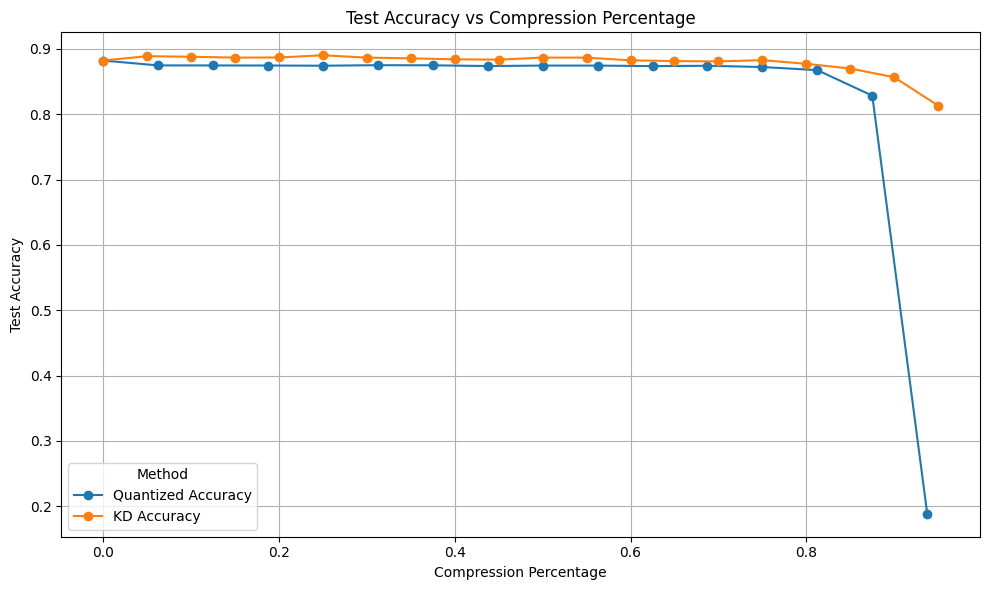

In [70]:
# Load the CSV files
kd = pd.read_csv("checkpoints_student/results_student.csv")
quant = pd.read_csv("checkpoints_teacher/results_teacher_quantization.csv")

# Normalize x-axis for both datasets to represent compression percentage
quant["Compress Percentage"] = 1 - quant["Bits"] / 32
kd["Compress Percentage"] = kd["Pruning Factor"]

# Normalize y-axis (accuracy) to use the same metric if needed
quant["Test Accuracy"] = quant["Quantized Test Accuracy"]

# Add a row with 'Compress Percentage' = 0 and 'Test Accuracy' = 0.8822 to both dataframes
new_row_quant = pd.DataFrame({"Compress Percentage": [0], "Test Accuracy": [0.8822]})
quant = pd.concat([quant, new_row_quant], ignore_index=True)

new_row_kd = pd.DataFrame({"Compress Percentage": [0], "Test Accuracy": [0.8822]})
kd = pd.concat([new_row_kd, kd], ignore_index=True)

# Plot both lines sharing the same axes
plt.figure(figsize=(10, 6))
plt.plot(quant["Compress Percentage"], quant["Test Accuracy"], marker='o', label="Quantized Accuracy")
plt.plot(kd["Compress Percentage"], kd["Test Accuracy"], marker='o', label="KD Accuracy")

# Add labels and title
plt.title("Test Accuracy vs Compression Percentage")
plt.xlabel("Compression Percentage")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.legend(title="Method", loc="best")

# Show the plot
plt.tight_layout()

# Save the plot
plt.savefig('images/kd_vs_quantization.png')

# Show the plot
plt.show()


### KD then Quantization

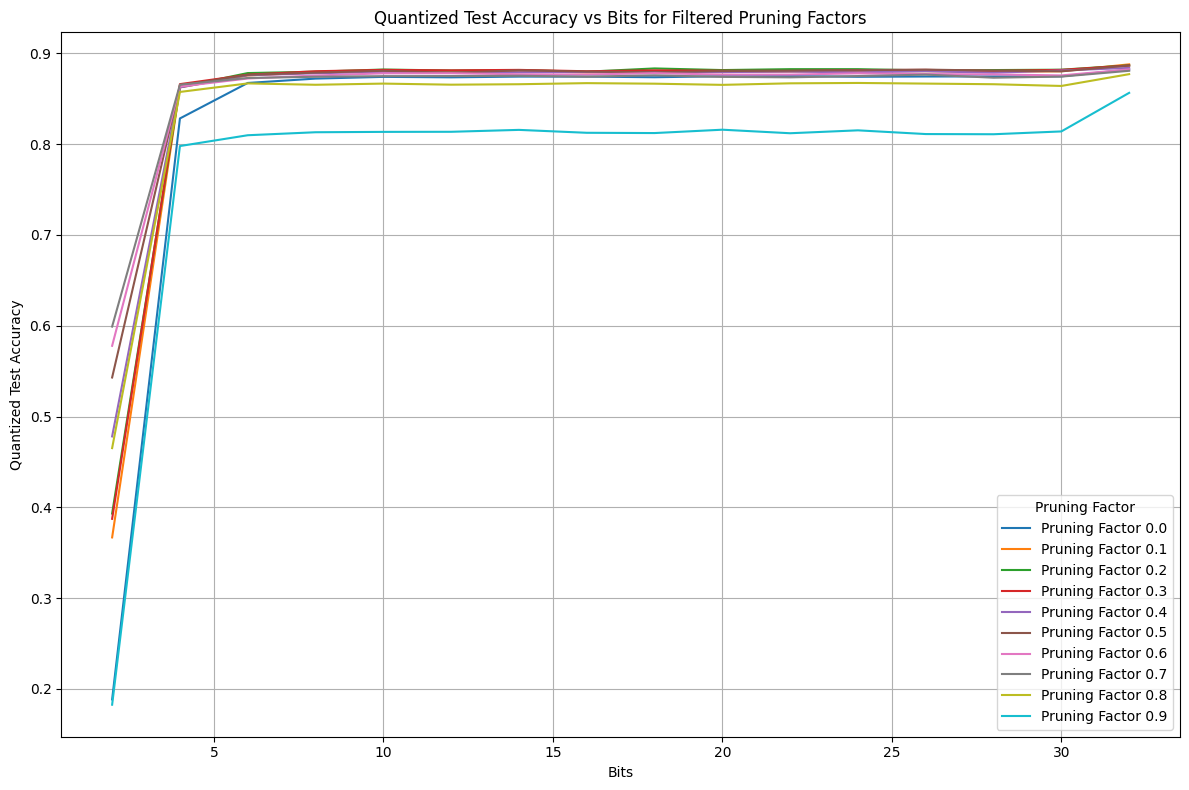

In [118]:
# Specify the path to your CSV file
student_quant_csv = "checkpoints_student/results_student_quantization.csv"

# Load the CSV file into a DataFrame
student_quant = pd.read_csv(student_quant_csv)

student_quant = student_quant[student_quant['Pruning Factor'].isin([i/10 for i in range(1, 10)])]

# Specify the path to your CSV file
teacher_quant_csv = "checkpoints_teacher/results_teacher_quantization.csv"

# Load the CSV file into a DataFrame
teacher_quant = pd.read_csv(teacher_quant_csv)

# Add a new column to teacher_quant for 'Pruning Factor' with value 0.00
teacher_quant['Pruning Factor'] = 0.00
teacher_quant['Parameter'] = 11173962

# Concatenate the teacher_quant and student_quant dataframes
combine_quant = pd.concat([teacher_quant, student_quant], ignore_index=True)

# Pivot the filtered data for plotting: pruning factors as lines, bits as x-axis
pivot_df = combine_quant.pivot(index="Bits", columns="Pruning Factor", values="Quantized Test Accuracy")

original = student_quant[['Pruning Factor', 'Original Test Accuracy']].drop_duplicates()
new_row = pd.DataFrame({'Pruning Factor': [0.00], 'Original Test Accuracy': [0.8822]})
original = pd.concat([new_row, original], ignore_index=True)

pivot_df.loc[32] = original['Original Test Accuracy'].values

# Plot the line graph
plt.figure(figsize=(12, 8))
for pruning_factor in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[pruning_factor], label=f"Pruning Factor {pruning_factor}")

plt.title("Quantized Test Accuracy vs Bits for Filtered Pruning Factors")
plt.xlabel("Bits")
plt.ylabel("Quantized Test Accuracy")
plt.legend(title="Pruning Factor", loc="best")
plt.grid(True)
plt.tight_layout()
plt.savefig('images/quantization.png')
plt.show()


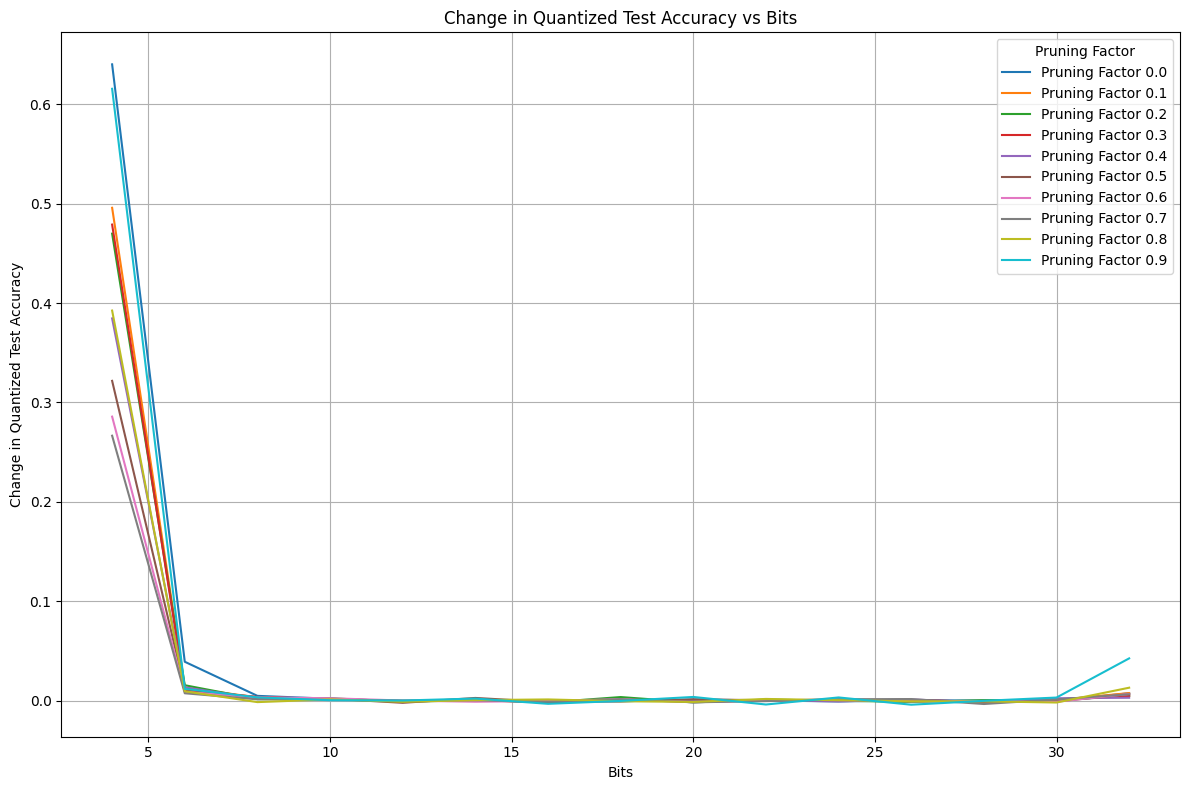

In [119]:
# Calculate the difference between consecutive rows for each pruning factor
change_df = pivot_df.diff()

# Plot the change for each pruning factor
plt.figure(figsize=(12, 8))
for pruning_factor in change_df.columns:
    plt.plot(change_df.index, change_df[pruning_factor], label=f"Pruning Factor {pruning_factor}")

plt.title("Change in Quantized Test Accuracy vs Bits")
plt.xlabel("Bits")
plt.ylabel("Change in Quantized Test Accuracy")
plt.legend(title="Pruning Factor", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

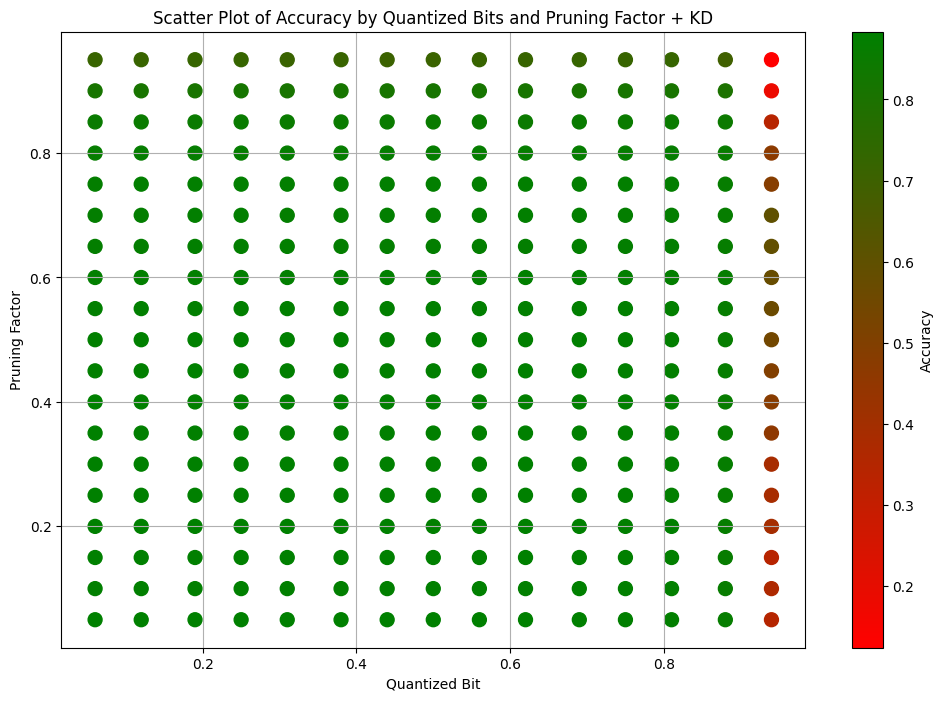

In [160]:
from matplotlib.colors import LinearSegmentedColormap

# Specify the path to your CSV file
student_quant_csv = "checkpoints_student/results_student_quantization.csv"

# Load the CSV file into a DataFrame
student_quant = pd.read_csv(student_quant_csv)

# Specify the path to your CSV file
teacher_quant_csv = "checkpoints_teacher/results_teacher_quantization.csv"

# Load the CSV file into a DataFrame
teacher_quant = pd.read_csv(teacher_quant_csv)

# Concatenate the teacher_quant and student_quant dataframes
combine_quant = pd.concat([teacher_quant, student_quant], ignore_index=True)

# Pivot the filtered data for plotting: pruning factors as lines, bits as x-axis
pivot_df = combine_quant.pivot(index="Bits", columns="Pruning Factor", values="Quantized Test Accuracy")

# Replace the first element in the columns (which is NaN) with '0.0'
new_columns = pivot_df.columns.tolist()
new_columns[0] = '0.0'  # Directly replace the first column name assuming it's the NaN

# Assign the new columns back to the DataFrame
pivot_df.columns = new_columns

pivot_temp = pivot_df
# Convert Bits to percentage of the maximum bits (32)
pivot_temp.index = (1- pivot_temp.index / 32).round(2)  # Normalize the bit values to a scale of 0-1

pivot_temp = pivot_temp.reset_index()

# Define a custom colormap from red to green
cmap = LinearSegmentedColormap.from_list("custom_red_green", ["red", "green"], N=256)

plt.figure(figsize=(12, 8))

# Loop through each pruning factor column except 'Bits' to plot
for col in pivot_temp.columns[2:]:  # Adjust this if column indexing is different
    # Scatter plot
    scatter = plt.scatter(x=pivot_temp['Bits'], 
                          y=[float(col)]*len(pivot_temp), 
                          c=pivot_temp[col], 
                          cmap=cmap, 
                          label=f"Pruning Factor {col}", 
                          s=100, 
                          vmin=pivot_temp.iloc[:, 2:].min().min(),  # Set minimum value for color scaling
                          vmax=pivot_temp.iloc[:, 2:].max().max())  # Set maximum value for color scaling

# Add a color bar
plt.colorbar(scatter, label='Accuracy')

plt.title("Scatter Plot of Accuracy by Quantized Bits and Pruning Factor + KD")
plt.xlabel("Quantized Bit")
plt.ylabel("Pruning Factor")
plt.grid(True)

plt.savefig('images/scatter_plot_accuracy.png')
plt.show()